# Driven Data - Richter's Predictor: Modeling Earthquake Damage

_The approach detailed in this notebook placed in the top 2% of submissions on the public leaderboard._

In this notebook, I explore a dataset from the [DrivenData competition](https://www.drivendata.org/competitions/57/nepal-earthquake/page/134/) focused on predicting the damage levels sustained by buildings during the 2015 Gorkha earthquake in Nepal. This catastrophic event resulted in widespread destruction, and the extensively collected data offers a comprehensive look at the impact. The dataset, one of the largest post-disaster collections ever assembled, includes critical information on the buildings' structure, household conditions, and socio-economic-demographic statistics. The objective is to predict the damage_grade—an ordinal variable indicating the severity of the damage, categorized into three grades: low damage (1), medium damage (2), and complete destruction (3). The dataset comprises 39 columns, with building_id serving as a unique identifier and the remaining 38 features detailing various aspects of the buildings.

In [1]:
# Imports
import os
import re
import time
from joblib import parallel_backend
import cupy as cp
import pickle
from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, f1_score, roc_auc_score, accuracy_score, silhouette_score, pairwise_distances
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, ClassifierMixin

from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix, coo_matrix
from scipy import stats

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

import xgboost as xgb
import catboost as cb # Requires numpy < 2.0.0
import lightgbm as lgb

import numba

import warnings
warnings.filterwarnings("ignore")

/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Table of Contents

1. [Approach](#Approach)
2. [Data](#Data)
3. [Helpers](#Helpers)
4. [AutoEncoding Geographical Features](#AutoEncoding-Geographical-Features)
5. [CatBoost Classifier](#CatBoost-Classifier)
6. [Deep Learning - BERT](#Deep-Learning---BERT)
    1. [Preprocessing](#Preprocessing-for-BERT)
    2. [Model Training](#Training-BERT)
    3. [ONNX Format](#ONNX-Format)
7. [Evaluation and Model Comparison](#Evaluation-and-Model-Comparison)
8. [Conclusion and Future Work](#Conclusion-and-Future-Work)

## Approach

__Ensembling GBMs:__

In this project, Gradient Boosting Machines (GBMs) are employed to predict building damage, utilizing classifier variants of these GBMs. Specifically, XGBoost, CatBoost, and LightGBM are trained on the dataset. Small perturbations are introduced during model construction to generate multiple versions of these models. An ensemble approach is then applied, where the mode of the predicted damage grades is used as the final prediction.

__Auto-encoder to extract latent geographical relationships:__

The dataset includes geographical features encoded hierarchically as integers. The top geographical feature has 30 possible values, while the middle and bottom features have 1,427 and 12,567 possible values, respectively. Aside from the hierarchy, there is no indication of proximity or relationships between the different geographical encodings within each layer. For an earthquake-related problem, buildings in close proximity are likely to experience similar levels of damage. In this project, an autoencoder is used to construct a representation of these geographical proximities, training on other features (e.g. building characteristics) in the dataset as well as the target variables. Hyperparameter tuning is performed carefully to avoid inadvertently using labels from the validation/test set during training. The resulting latent variables are extracted for model training.

## Data

As shown below, the dataset consists of:
1. Hierarchical geographical features represented by `geo_level_1_id`,`geo_level_2_id`,`geo_level_3_id`;
2. A few numerical features, namely `count_floors_pre_eq`, `age`, `area_percentage`, `height_percentage`, `count_families`;
3. A multitude of categorical features; and
4. The target `damage_grade`, an ordinal variable with a value of either 1, 2 or 3.

In [6]:
# Loading provided train and prediction datasets. Prediction dataset refers to the unlabelled dataset, to be predicted on and submitted
datapath = './data/'
df_train_features_raw = pd.read_csv(datapath+'train_values.csv').set_index('building_id')
df_train_labels_raw = pd.read_csv(datapath+'train_labels.csv').set_index('building_id')
df_pred_features_raw = pd.read_csv(datapath+'test_values.csv').set_index('building_id')

# Feature groups
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']


df_train_features_raw.sample(5)

geo_level_1_id  geo_level_2_id  geo_level_3_id  \
building_id                                                   
664346                   13             829            5582   
554800                   12            1103           12535   
297664                   17             399           11788   
507297                   21             107           11846   
478427                   30             954            5489   

             count_floors_pre_eq  age  area_percentage  height_percentage  \
building_id                                                                 
664346                         2   15                7                  6   
554800                         2    0               11                  5   
297664                         3   10                6                  7   
507297                         3   15                5                  6   
478427                         2   15               16                  4   

            land_surface_condition foundation_type roof_type  ...  \
building_id                                                   ...   
664346                           t               r         n  ...   
554800                           t               r         n  ...   
297664                           t               r         n  ...   
507297                           t               r         q  ...   
478427                           t               r         n  ...   

            has_secondary_use_agriculture has_secondary_use_hotel  \
building_id                                                         
664346                                  0                       0   
554800                                  0                       0   
297664                                  0                       0   
507297                                  1                       0   
478427                                  0                       0   

            has_secondary_use_rental has_secondary_use_institution  \
building_id                                                          
664346                             0                             0   
554800                             0                             0   
297664                             0                             0   
507297                             0                             0   
478427                             0                             0   

             has_secondary_use_school  has_secondary_use_industry  \
building_id                                                         
664346                              0                           0   
554800                              0                           0   
297664                              0                           0   
507297                              0                           0   
478427                              0                           0   

             has_secondary_use_health_post  has_secondary_use_gov_office  \
building_id                                                                
664346                                   0                             0   
554800                                   0                             0   
297664                                   0                             0   
507297                                   0                             0   
478427                                   0                             0   

             has_secondary_use_use_police  has_secondary_use_other  
building_id                                                         
664346                                  0                        0  
554800                                  0                        0  
297664                                  0                        0  
507297                                  0                        0  
478427                                  0                        0  

[5 rows x 38 columns]

The plots below provide a quick overview to the distribution of `damage_grade` with different features. Note the large number of categorical features given by the barplots.

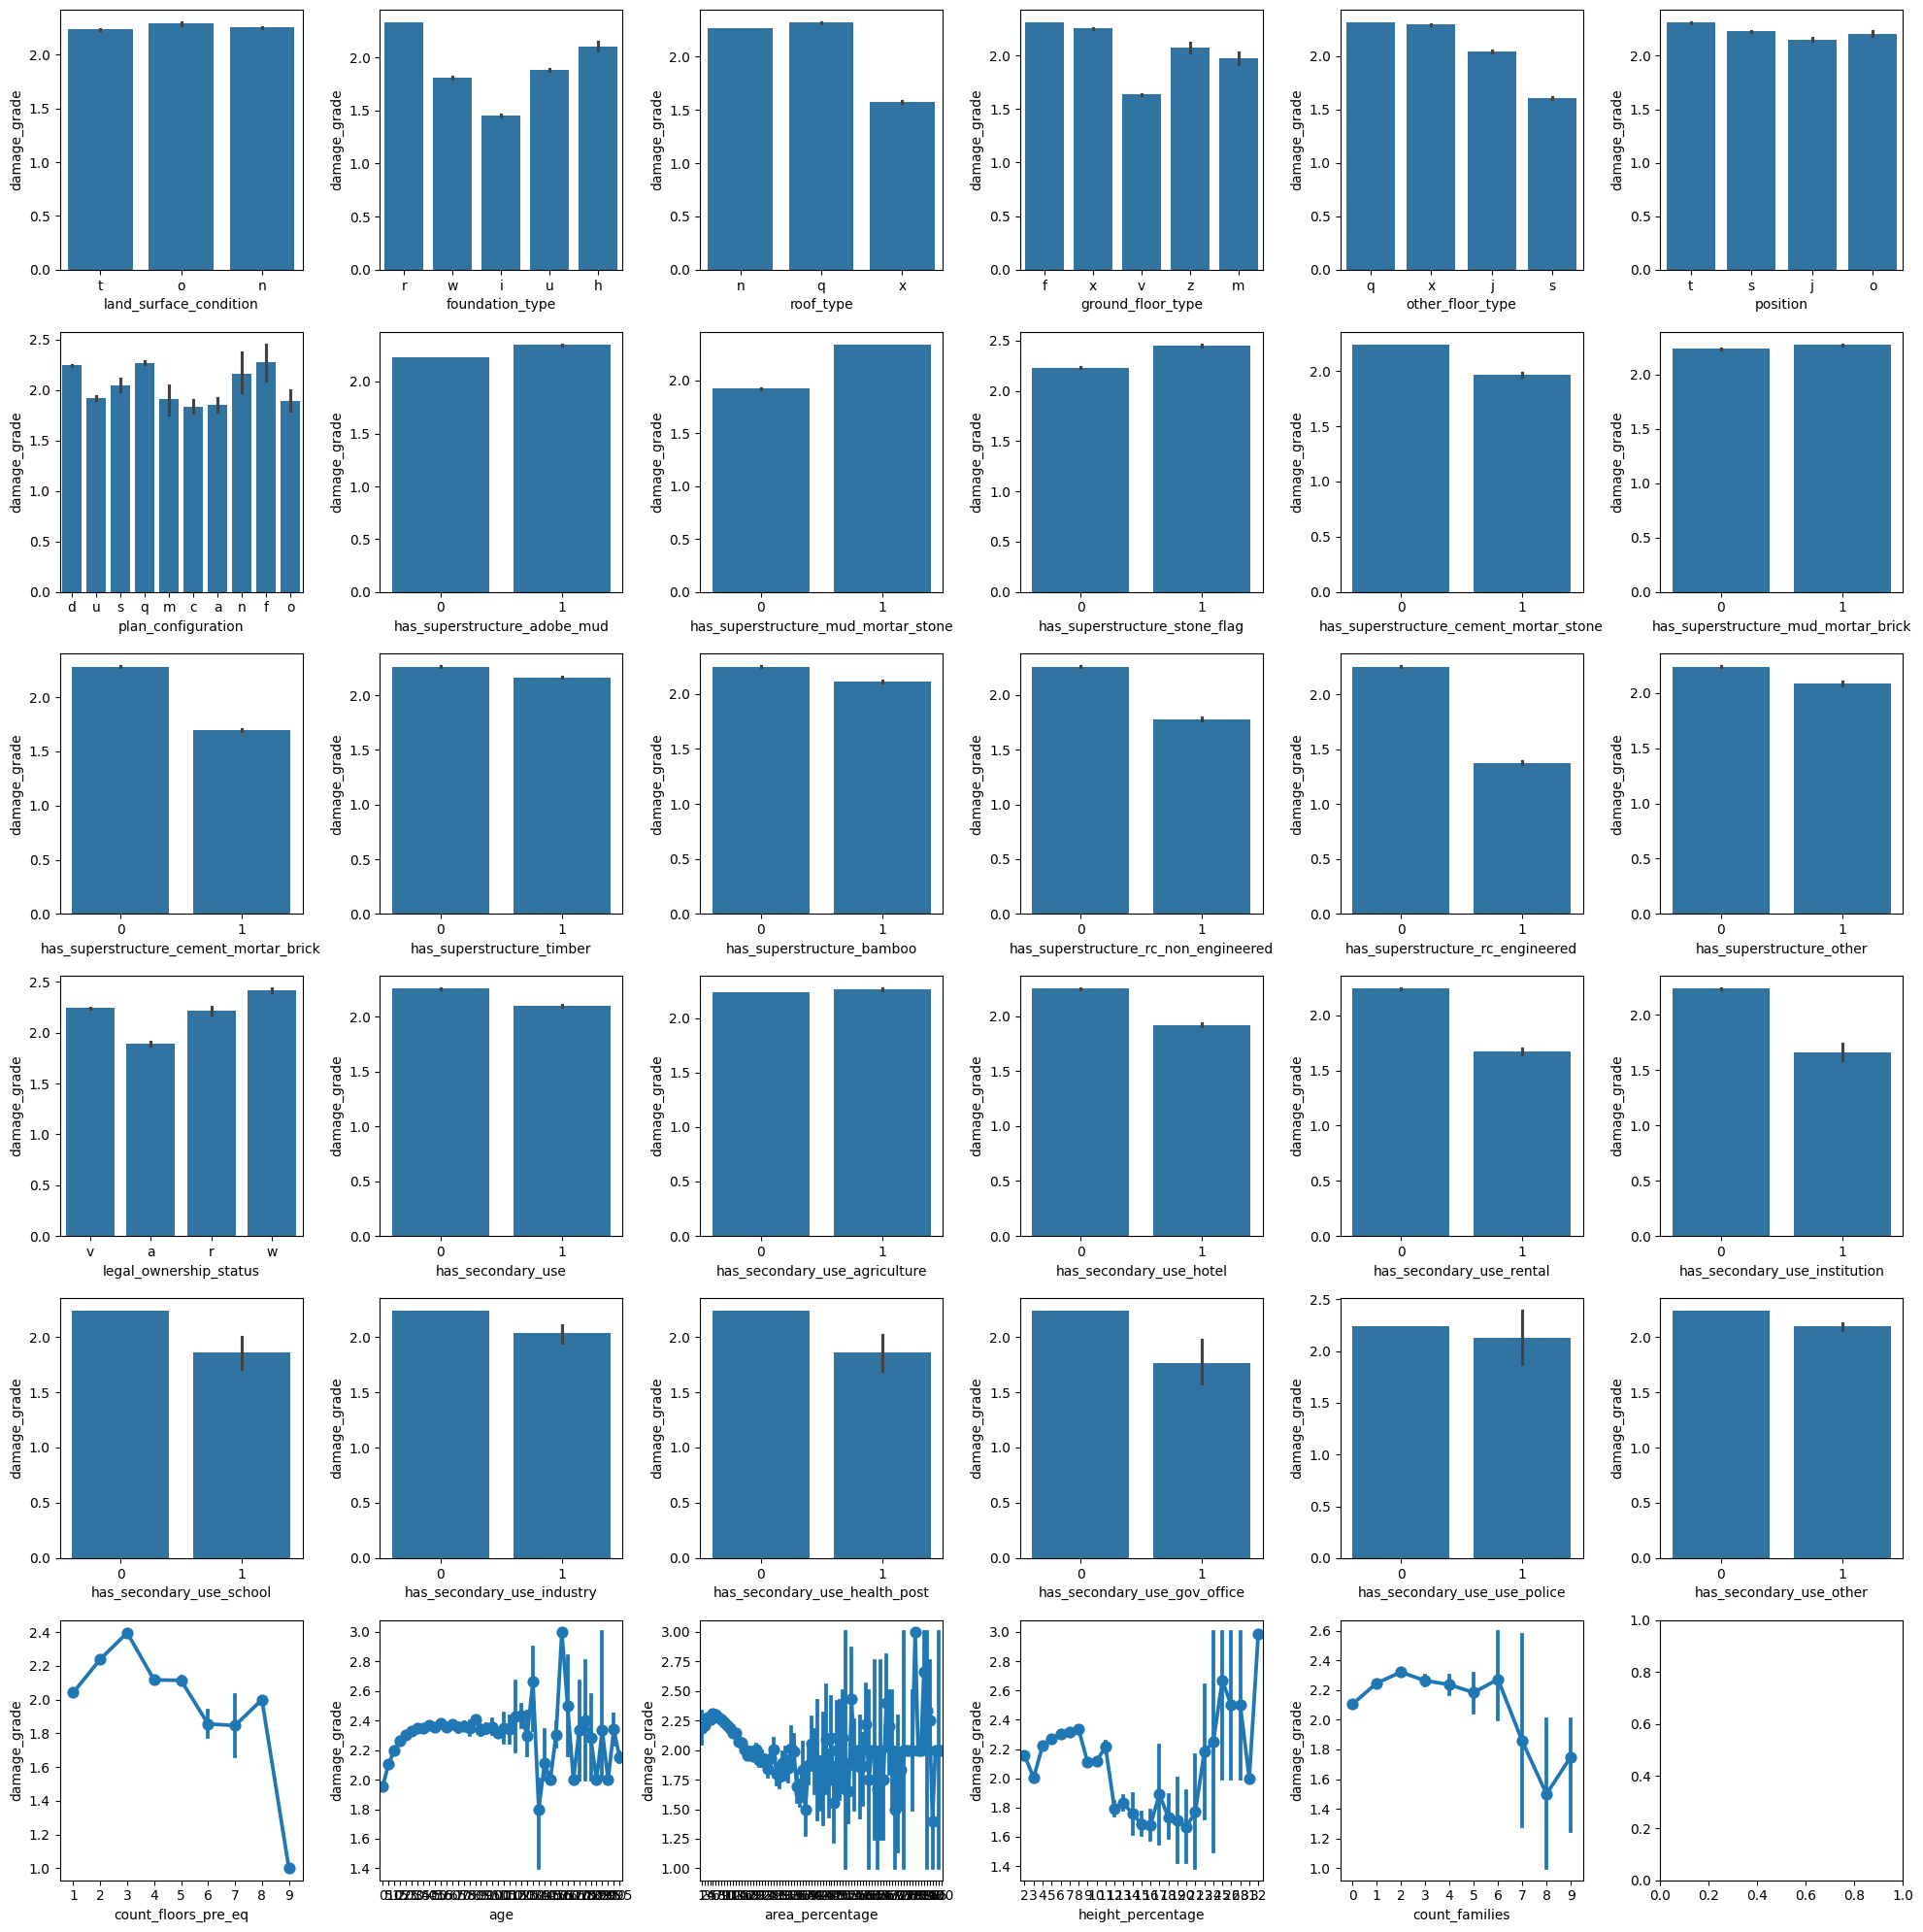

In [7]:
df_train_features = df_train_features_raw.copy()
df_train_labels = df_train_labels_raw.copy()
df_train = pd.concat([df_train_features,df_train_labels],axis=1)
non_geo_features = list(df_train.columns)
non_geo_features = [feat for feat in non_geo_features if not (feat in geo_features+['damage_grade'])]
non_geo_features_cat = [feat for feat in non_geo_features if not (feat in numerical_features)]
non_geo_features_num = numerical_features

fig,axs = plt.subplots(6,6,figsize=(20,20))
axs = axs.flatten()

for i,feat in enumerate(non_geo_features_cat):
    sns.barplot(df_train,x=feat,y='damage_grade',ax=axs[i])

for i,feat in enumerate(non_geo_features_num):
    sns.pointplot(df_train,x=feat,y='damage_grade',ax=axs[i+30])

fig.tight_layout()

## Helpers

In [3]:
def preprocess(df_features:pd.DataFrame)->pd.DataFrame:
    # Convert numeric features to float for automatic handling by some GBM packages
    df_features = df_features.astype({'count_floors_pre_eq':'float',
                                      'age':'float',
                                      'area_percentage':'float',
                                      'height_percentage':'float',
                                      'count_families':'float'})
    return df_features

## AutoEncoding Geographical Features

An auto-encoder network is deployed to uncover latent relationships between the different geographical locations at the same level, i.e. within `geo_level_1_id`, `geo_level_2_id` and `geo_level_3_id`. The model is typically trained on both features and labels (i.e. `damage_grade`). Missing labels, e.g. from the prediction dataset or withheld test set labels, are first imputed using the `impute_damage_grade` function given below. The imputation is done using mean values from other rows with the same geographical features. The resulting latent values replace the original geographical features.

In [6]:

def impute_damage_grade(df_train_X: pd.DataFrame,df_val_X: pd.DataFrame,
                        df_test_X: pd.DataFrame,df_pred_X: pd.DataFrame,
                        df_train_y: pd.DataFrame, df_val_y: Optional[pd.DataFrame]=None,
                        df_test_y: Optional[pd.DataFrame]=None,
                        df_pred_y: Optional[pd.DataFrame]=None) -> pd.DataFrame:
    '''
    Impute damage grade based on location (i.e. the three geo-features). This imputation is done to provide
    values for later geo-encoding. Buildings without damage grades are imputed with mean values of other
    buildings in the same geographical locations. If such values are unavailable, the mean values of the
    higher geographical feature is taken.
    
    The original labelled dataset should first be split into train, val, and test sets. The pred set
    refers to the unlabelled dataset meant for later prediction and submission.The imputation will be
    done using all features from all datasets, but only labels from the dataset(s) meant for training,
    and could include both the train and val datasets. At prediction, all labels (including those from
    test set) are used. Supply as many label sets as required.
    
    df_train_X: Train features assuming labelled dataset is split into train-val-test sets
    df_val_X: Validation features assuming labelled dataset is split into train-val-test sets
    df_test_X: Test features assuming labelled dataset is split into train-val-test sets
    df_pred_X: Prediction features from unlabelled dataset
    df_train_y: Train labels assuming labelled dataset is split into train-val-test sets
    df_val_y: Validation labels assuming labelled dataset is split into train-val-test sets
    df_test_y: Test labels assuming labelled dataset is split into train-val-test sets
    df_pred_y: Prediction labels predicted from first iteration model, for pseudo-labelling if needed
    '''
    
    # Preprocess to convert numerical features to float
    df_train_X = preprocess(df_train_X.copy())
    df_val_X = preprocess(df_val_X.copy())
    df_test_X = preprocess(df_test_X.copy())
    df_pred_X = preprocess(df_pred_X.copy())
    df_all = pd.concat([df_train_X,df_train_y],axis=1)

    # Include all labels involved in imputation
    if df_val_y is not None:
        df_val_X = pd.concat([df_val_X,df_val_y],axis=1)
    if df_test_y is not None:
        df_test_X = pd.concat([df_test_X,df_test_y],axis=1)
    if df_pred_y is not None:
        df_pred_X = pd.concat([df_pred_X,df_pred_y],axis=1)
    df_all = pd.concat([df_all,df_val_X,df_test_X,df_pred_X],axis=0)

    # Imputing from the bottom geographical feature up.
    if (df_val_y is None) or (df_test_y is None) or (df_pred_y is None):
        df_all['geo_combined3'] = df_all.apply(lambda row: str(row['geo_level_1_id']) + '_' + str(row['geo_level_2_id']) + '_' + str(row['geo_level_3_id']), axis=1)
        df_all['geo_combined2'] = df_all.apply(lambda row: str(row['geo_level_1_id']) + '_' + str(row['geo_level_2_id']), axis=1)

        # Fillna for damage_grade with means for geo level 3
        damage_means3 = df_all.groupby('geo_combined3')['damage_grade'].mean()
        df_all['damage_grade'] = df_all.apply(lambda row: damage_means3[row['geo_combined3']] if pd.isna(row['damage_grade']) else row['damage_grade'], axis=1)

        # Fillna for damage_grade with means for lowest geo level 2
        damage_means2 = df_all.groupby('geo_combined2')['damage_grade'].mean()
        df_all['damage_grade'] = df_all.apply(lambda row: damage_means2[row['geo_combined2']] if pd.isna(row['damage_grade']) else row['damage_grade'], axis=1)

        # Fillna for damage_grade with means for lowest geo level 2
        damage_means1 = df_all.groupby('geo_level_1_id')['damage_grade'].mean()
        df_all['damage_grade'] = df_all.apply(lambda row: damage_means1[row['geo_level_1_id']] if pd.isna(row['damage_grade']) else row['damage_grade'], axis=1)

        # Drop unwanted columns and OHE.
        df_all.drop(columns=['geo_combined2','geo_combined3'],inplace=True)

    # OHE needed for auto-encoder network.
    df_all = pd.get_dummies(df_all,columns=[col for col in categorical_features if not (col in geo_features)],drop_first=True)

    # Get feature names
    non_geo_features_OHE = [col for col in df_all.columns if not (col in geo_features)]

    return df_all, non_geo_features_OHE

After imputation, the dataset is fed into an autoencoder for training. The network is given by the `CategoricalAutoencoder` class below.

In [7]:
# Define the autoencoder
class CategoricalAutoencoder(nn.Module):
    # AutoEncoder network to produce latent encodings for the geographical features in the earthquake dataset.
    def __init__(self, geo1_size, geo2_size, geo3_size, inter_size, latent_size):
        super(CategoricalAutoencoder, self).__init__()
        self.geo1_size = geo1_size
        self.geo2_size = geo2_size
        self.geo3_size = geo3_size

        # Embedding layers for each categorical input
        self.embed1 = nn.Embedding(31, geo1_size)
        self.embed2 = nn.Embedding(1418, geo2_size)
        self.embed3 = nn.Embedding(11861, geo3_size)
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(geo1_size + geo2_size + geo3_size + 58, inter_size),
            nn.ReLU(),
            nn.Linear(inter_size, latent_size)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, inter_size),
            nn.ReLU(),
            nn.Linear(inter_size, geo1_size + geo2_size + geo3_size + 58)
        )
        
        # Output layers for each categorical input
        self.output1 = nn.Linear(geo1_size, 31)
        self.output2 = nn.Linear(geo2_size, 1418)
        self.output3 = nn.Linear(geo3_size, 11861)
        
    def forward(self, x1, x2, x3, feats):
        # Embedding the inputs
        x1 = self.embed1(x1)
        x2 = self.embed2(x2)
        x3 = self.embed3(x3)
        
        # Concatenate embeddings
        x = torch.cat([x1, x2, x3, feats], dim=1)
        
        # Encode
        z = self.encoder(x)
        
        # Decode
        x_recon = self.decoder(z)
        
        # Split the reconstructed output
        x1_recon, x2_recon, x3_recon, feats_recon = torch.split(x_recon, [self.geo1_size, self.geo2_size, self.geo3_size, 58], dim=1)
        
        # Get the output logits for each categorical input
        x1_out = self.output1(x1_recon)
        x2_out = self.output2(x2_recon)
        x3_out = self.output3(x3_recon)
        
        return x1_out, x2_out, x3_out, feats_recon

After training, the original dataset is fed through the encoder to produce the latent encoding. For simplicity, the latent encoding for each location represented by the original geographical features is simply taken as the mean value. The steps for producing `latent_geo`, the mapping between the original geographical features and their correspoding latent encoding, are carried out in the `get_latent_geo` function below.

In [4]:
def get_latent_geo(df_all:pd.DataFrame, non_geo_features_OHE:list, geo1_size:int = 16, geo2_size:int = 32,
                   geo3_size:int = 64, inter_size:int = 128,
                   latent_size:int = 64, epochs:int = 10):
    '''
    Build autoencoder network and get latent geo-encoding based on defined architecture.
    geo1_size: Embedding dimension for first geo level
    geo2_size: Embedding dimension for second geo level
    geo3_size: Embedding dimension for third geo level
    latent_size: Dimension of latent variables
    inter_size: Output (input) size of encoder's (decoder's) first (last) linear layer, interfacing with latent values
    epochs: Number of epochs to run model for
    '''
    # Instantiate the model
    model = CategoricalAutoencoder(geo1_size, geo2_size, geo3_size, inter_size, latent_size).cuda()

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Create DataLoader
    df = df_all.copy()
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(float)

    # Encode the categorical columns
    le_cat1 = LabelEncoder()
    le_cat2 = LabelEncoder()
    le_cat3 = LabelEncoder()

    df['geo_level_1_id'] = le_cat1.fit_transform(df['geo_level_1_id'])
    df['geo_level_2_id'] = le_cat2.fit_transform(df['geo_level_2_id'])
    df['geo_level_3_id'] = le_cat3.fit_transform(df['geo_level_3_id'])

    # Convert DataFrame to tensors
    x1 = torch.tensor(df['geo_level_1_id'].values, dtype=torch.long).cuda()
    x2 = torch.tensor(df['geo_level_2_id'].values, dtype=torch.long).cuda()
    x3 = torch.tensor(df['geo_level_3_id'].values, dtype=torch.long).cuda()

    feat_tensor = torch.tensor(df[non_geo_features_OHE].values, dtype=torch.float).cuda()

    # Create DataLoader
    dataset = TensorDataset(x1, x2, x3, feat_tensor)
    dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

    # Training loop with tqdm
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
            x1_batch, x2_batch, x3_batch, feats_batch = batch
            optimizer.zero_grad()
            
            # Forward pass
            x1_out, x2_out, x3_out, feats_recon = model(x1_batch, x2_batch, x3_batch, feats_batch)
            
            # Compute the loss
            loss = (criterion(x1_out, x1_batch) + \
                criterion(x2_out, x2_batch) + \
                criterion(x3_out, x3_batch))
            
            loss_feat = nn.MSELoss()(feats_recon, feats_batch)

            total_loss = loss + loss_feat

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += total_loss.item()
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader)}')


    # Extract encoding for each location
    # Pass the input through the encoder and plot the results
    model.eval()
    z_list = []

    eval_dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc='Evaluating'):
            x1_batch, x2_batch, x3_batch, feat_tensor = batch
            
            # Forward pass
            z_batch = model.encoder(torch.cat([model.embed1(x1_batch),
                                            model.embed2(x2_batch),
                                            model.embed3(x3_batch),
                                            feat_tensor],
                                            dim=1))
        
            # Move tensors to CPU
            z_list.append(z_batch.cpu())
            
            # Clear cache
            torch.cuda.empty_cache()

    # Concatenate results
    z = torch.cat(z_list, dim=0)
    latent_geo = pd.concat([df_all.iloc[:,:3].reset_index(drop=True),pd.DataFrame(z.cpu().numpy())],axis=1)
    latent_geo = latent_geo.groupby(geo_features).mean().reset_index() # Get average latent values

    return latent_geo, model, dataset, x1, x2, x3

## CatBoost Classifier

CatBoost is a natural choice of GBM, given the high number of categorical features. As a baseline for comparison with later models, we fit a vanilla CatBoost model with no geo-encoding.

In [ ]:
# Prep data for catboost vanilla
df_train_features = preprocess(df_train_features_raw)
df_test_features = preprocess(df_test_features_raw)

X_train_or, X_test, y_train_or, y_test = train_test_split(df_train_features, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
X_train, X_val, y_train, y_val = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
 
# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(X_train.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=X_train, label=y_train, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=X_val, label=y_val, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=X_test, label=y_test, cat_features=categorical_features_indices)

## CatBoost Regressor

Quick check with vanilla approach

In [17]:
# Instantiate catboost regressor model
model = cb.CatBoostRegressor(loss_function='RMSE',task_type='GPU',devices='0',metric_period=100)

# Grid search training
grid = {'iterations': [600,800],
        'learning_rate': [0.1,0.2],
        'depth': [8],
        'l2_leaf_reg': [5]}
model.grid_search(grid, train_dataset,verbose=False)

with open('cb_1.pkl','wb') as f:
    pickle.dump(model,f)

0:	learn: 2.0999503	test: 2.1026331	best: 2.1026331 (0)	total: 36.4ms	remaining: 21.8s
100:	learn: 0.4604643	test: 0.4565330	best: 0.4565330 (100)	total: 3.04s	remaining: 15s
200:	learn: 0.4570157	test: 0.4539142	best: 0.4539142 (200)	total: 5.98s	remaining: 11.9s
300:	learn: 0.4551188	test: 0.4528420	best: 0.4528420 (300)	total: 8.89s	remaining: 8.83s
400:	learn: 0.4534276	test: 0.4518584	best: 0.4518584 (400)	total: 11.8s	remaining: 5.85s
500:	learn: 0.4520410	test: 0.4511871	best: 0.4511871 (500)	total: 14.7s	remaining: 2.9s
599:	learn: 0.4509619	test: 0.4506409	best: 0.4506409 (599)	total: 17.6s	remaining: 0us
bestTest = 0.4506408541
bestIteration = 599
0:	learn: 1.8815759	test: 1.8839833	best: 1.8839833 (0)	total: 32.4ms	remaining: 19.4s
100:	learn: 0.4567280	test: 0.4537866	best: 0.4537866 (100)	total: 3.02s	remaining: 14.9s
200:	learn: 0.4543522	test: 0.4524706	best: 0.4524706 (200)	total: 5.84s	remaining: 11.6s
300:	learn: 0.4524312	test: 0.4515912	best: 0.4515912 (300)	total: 

In [22]:
# # Load model
# with open('cb_1.pkl','rb') as f:
#     model = pickle.load(f)
model.get_params()

{'loss_function': 'RMSE',
 'metric_period': 100,
 'task_type': 'GPU',
 'devices': '0',
 'depth': 8,
 'learning_rate': 0.2,
 'l2_leaf_reg': 5,
 'iterations': 800}

In [23]:
# Evaluation
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

pred_int = np.round(np.clip(pred,1,3))
f1_score(y_test,pred_int,average='micro')

Testing performance
RMSE: 0.44
R2: 0.48


0.7452354761965669

In [28]:
# Single model and evaluation
model = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model.fit(train_dataset)

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

pred_int = np.round(np.clip(pred,1,3))
f1_score(y_test,pred_int,average='micro')

0:	learn: 0.5696507	total: 14.1ms	remaining: 28.2s
500:	learn: 0.4266956	total: 5.68s	remaining: 17s
1000:	learn: 0.4061295	total: 11.4s	remaining: 11.4s
1500:	learn: 0.3882719	total: 17.1s	remaining: 5.69s
1999:	learn: 0.3722416	total: 22.9s	remaining: 0us
Testing performance
RMSE: 0.44
R2: 0.48


0.7470773323782968

## CatBoost Regressor geo encoded

### General Flow

In [53]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y, df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# # Save geo-encoding
# with open('latent_geo_1.pkl','wb') as f:
#     pickle.dump(latent_geo, f)

# # Load geo-encoding
# with open('latent_geo_1.pkl','rb') as f:
#     latent_geo = pickle.load(f)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost regressor model
model_reg = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model_reg.fit(train_val_dataset)

# Evaluation
pred = model_reg.predict(df_test_X)
rmse = (np.sqrt(mean_squared_error(df_test_y, pred)))
r2 = r2_score(df_test_y, pred)

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

pred_int = np.round(np.clip(pred,1,3))
f1_score(df_test_y,pred_int,average='micro')

Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 489.58it/s]


Epoch [1/10], Loss: 6.381945304759121


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 504.21it/s]


Epoch [2/10], Loss: 0.4117368398445476


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 497.42it/s]


Epoch [3/10], Loss: 0.22299644910896385


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 493.66it/s]


Epoch [4/10], Loss: 0.1559998493227389


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 497.80it/s]


Epoch [5/10], Loss: 0.10642670660961381


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 517.41it/s]


Epoch [6/10], Loss: 0.10007100788340115


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 496.48it/s]


Epoch [7/10], Loss: 0.09442488403578696


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 530.86it/s]


Epoch [8/10], Loss: 0.06710535363286983


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 488.63it/s]


Epoch [9/10], Loss: 0.06598407243159346


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 494.26it/s]


Epoch [10/10], Loss: 0.06855505707408666


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 2715/2715 [00:01<00:00, 1524.51it/s]


0:	learn: 0.5695910	total: 13.6ms	remaining: 27.3s
500:	learn: 0.4167618	total: 7.43s	remaining: 22.2s
1000:	learn: 0.3949673	total: 15s	remaining: 15s
1500:	learn: 0.3771462	total: 22.7s	remaining: 7.56s
1999:	learn: 0.3614305	total: 30.4s	remaining: 0us
Testing performance
RMSE: 0.44
R2: 0.49


0.7519889488629096

### Parametric Study - Select Best Encoding

In [7]:
# Prep dataframe for storing validation scores
encoding_path = './kaggle_output_1/'
encoders = []
for file in os.listdir(encoding_path):
    if file.endswith(".pkl"):
        encoders.append(file)

# Define the patterns to extract numbers after specific substrings
patterns = {
    'geo1': r'geo1_(\d+)',
    'geo2': r'geo2_(\d+)',
    'geo3': r'geo3_(\d+)',
    'inter': r'inter_(\d+)',
    'lat': r'lat_(\d+)',
    'epo': r'epo_(\d+)'
}

archis = []
for encoder in encoders:
    # Extract numbers using regex
    extracted_numbers = {}
    for key, pattern in patterns.items():
        match = re.search(pattern, encoder)
        if match:
            extracted_numbers[key] = int(match.group(1))
    archis.append(extracted_numbers)

archis = pd.DataFrame(archis)
archis['val_rmse'] = None
archis['val_r2'] = None
archis['val_f1'] = None
archis['iterations'] = None

In [8]:
# Prep data for catboost
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

num_encoders = len(encoders)

iterationss = [2000]
for iterations in iterationss:
    for j, encoder in enumerate(encoders):
        print(f'\n\n Running encoder: {encoder}, {j} of {num_encoders}')
        # Load encoder
        with open(encoding_path+encoder,'rb') as f:
            latent_geo = pickle.load(f)

        # Apply encoder
        df_train_X_temp = df_train_X.merge(latent_geo,on=geo_features,how='left')
        df_train_X_temp.drop(columns=geo_features, inplace=True)
        df_val_X_temp = df_val_X.merge(latent_geo,on=geo_features,how='left')
        df_val_X_temp.drop(columns=geo_features, inplace=True)

        # Get categorical feature indices and names
        categorical_features_indices = []
        for i,dtype in enumerate(df_train_X_temp.dtypes):
            if dtype in ['int64','int32','object','category']:
                categorical_features_indices.append(i)

        # Creating pooled datasets for catboost
        train_dataset = cb.Pool(data=df_train_X_temp, label=df_train_y, cat_features=categorical_features_indices)
        val_dataset = cb.Pool(data=df_val_X_temp, label=df_val_y, cat_features=categorical_features_indices)

        # Instantiate catboost regressor model and fit
        model = cb.CatBoostRegressor(loss_function='RMSE',
                                    task_type='GPU',devices='0',
                                    metric_period=500,
                                    iterations=iterations, learning_rate=0.2, depth=8,l2_leaf_reg=5)
        model.fit(train_dataset)

        # Evaluation
        pred = model.predict(df_val_X_temp)
        rmse = (np.sqrt(mean_squared_error(df_val_y, pred)))
        r2 = r2_score(df_val_y, pred)
        pred_int = np.round(np.clip(pred,1,3))
        f1 = f1_score(df_val_y,pred_int,average='micro')

        print(f'RMSE: {rmse}, R2-score: {r2}, F1-score: {f1}, iterations = {iterations}')

        archis.loc[j,'rmse'] = rmse
        archis.loc[j,'r2'] = r2
        archis.loc[j,'f1'] = f1
        archis.loc[j,'iterations'] = iterations



 Running encoder: latent_geo_geo1_8_geo2_16_geo3_32_inter_64_lat_64_epo_10.pkl, 0 of 165
0:	learn: 0.5843077	total: 15.9ms	remaining: 31.7s
500:	learn: 0.4138695	total: 6.26s	remaining: 18.7s
1000:	learn: 0.3904681	total: 12.8s	remaining: 12.8s
1500:	learn: 0.3719462	total: 19.4s	remaining: 6.46s
1999:	learn: 0.3563713	total: 26s	remaining: 0us
RMSE: 0.44442203062732943, R2-score: 0.47233073905325973, F1-score: 0.743160682577422, iterations = 2000


 Running encoder: latent_geo_geo1_16_geo2_32_geo3_64_inter_128_lat_32_epo_1.pkl, 1 of 165
0:	learn: 0.5868244	total: 12.3ms	remaining: 24.6s
500:	learn: 0.4168597	total: 6.07s	remaining: 18.2s
1000:	learn: 0.3920407	total: 12.4s	remaining: 12.3s
1500:	learn: 0.3729770	total: 18.6s	remaining: 6.19s
1999:	learn: 0.3564956	total: 25s	remaining: 0us
RMSE: 0.44473263359874626, R2-score: 0.47159291373522016, F1-score: 0.742107322358323, iterations = 2000


 Running encoder: latent_geo_geo1_16_geo2_32_geo3_64_inter_128_lat_32_epo_8.pkl, 2 of 165

In [9]:
archis.to_csv('param_study_2000.csv',index=None)

## Catboost Classifier

### General Flow

In [9]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X_or = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, df_test_X_or,df_pred_X_or, df_train_y_or,df_val_y_or)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = preprocess(df_train_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_val_X = preprocess(df_val_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_test_X = preprocess(df_test_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_pred_X = preprocess(df_pred_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y_or, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y_or, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y_or, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y_or,df_val_y_or],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y_or,df_val_y_or,df_test_y_or],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=5000,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y_or, pred)
f1 = f1_score(df_test_y_or,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')

Epoch 1/10: 100%|██████████████████████████| 1358/1358 [00:02<00:00, 494.00it/s]


Epoch [1/10], Loss: 7.976795309817142


Epoch 2/10: 100%|██████████████████████████| 1358/1358 [00:02<00:00, 534.92it/s]


Epoch [2/10], Loss: 0.5008421211622777


Epoch 3/10: 100%|██████████████████████████| 1358/1358 [00:02<00:00, 539.93it/s]


Epoch [3/10], Loss: 0.2930492579509039


Epoch 4/10: 100%|██████████████████████████| 1358/1358 [00:02<00:00, 522.62it/s]


Epoch [4/10], Loss: 0.22023486713597631


Epoch 5/10: 100%|██████████████████████████| 1358/1358 [00:02<00:00, 551.33it/s]


Epoch [5/10], Loss: 0.18361318472975835


Epoch 6/10: 100%|██████████████████████████| 1358/1358 [00:02<00:00, 528.84it/s]


Epoch [6/10], Loss: 0.16195308295008623


Epoch 7/10: 100%|██████████████████████████| 1358/1358 [00:02<00:00, 506.30it/s]


Epoch [7/10], Loss: 0.1598525253153339


Epoch 8/10: 100%|██████████████████████████| 1358/1358 [00:02<00:00, 518.35it/s]


Epoch [8/10], Loss: 0.1261121066114337


Epoch 9/10: 100%|██████████████████████████| 1358/1358 [00:02<00:00, 514.68it/s]


Epoch [9/10], Loss: 0.122190870459854


Epoch 10/10: 100%|█████████████████████████| 1358/1358 [00:02<00:00, 526.63it/s]


Epoch [10/10], Loss: 0.1270295658528761


Evaluating: 100%|█████████████████████████| 2715/2715 [00:01<00:00, 1458.12it/s]


0:	learn: 1.0930845	total: 11.5ms	remaining: 3m 49s
5000:	learn: 0.5394876	total: 41.5s	remaining: 2m 4s
10000:	learn: 0.4982637	total: 1m 22s	remaining: 1m 22s
15000:	learn: 0.4693036	total: 2m 2s	remaining: 40.9s
19999:	learn: 0.4455440	total: 2m 43s	remaining: 0us
Testing performance
Accuracy: 0.7557
F1-score: 0.7557


<BarContainer object of 99 artists>

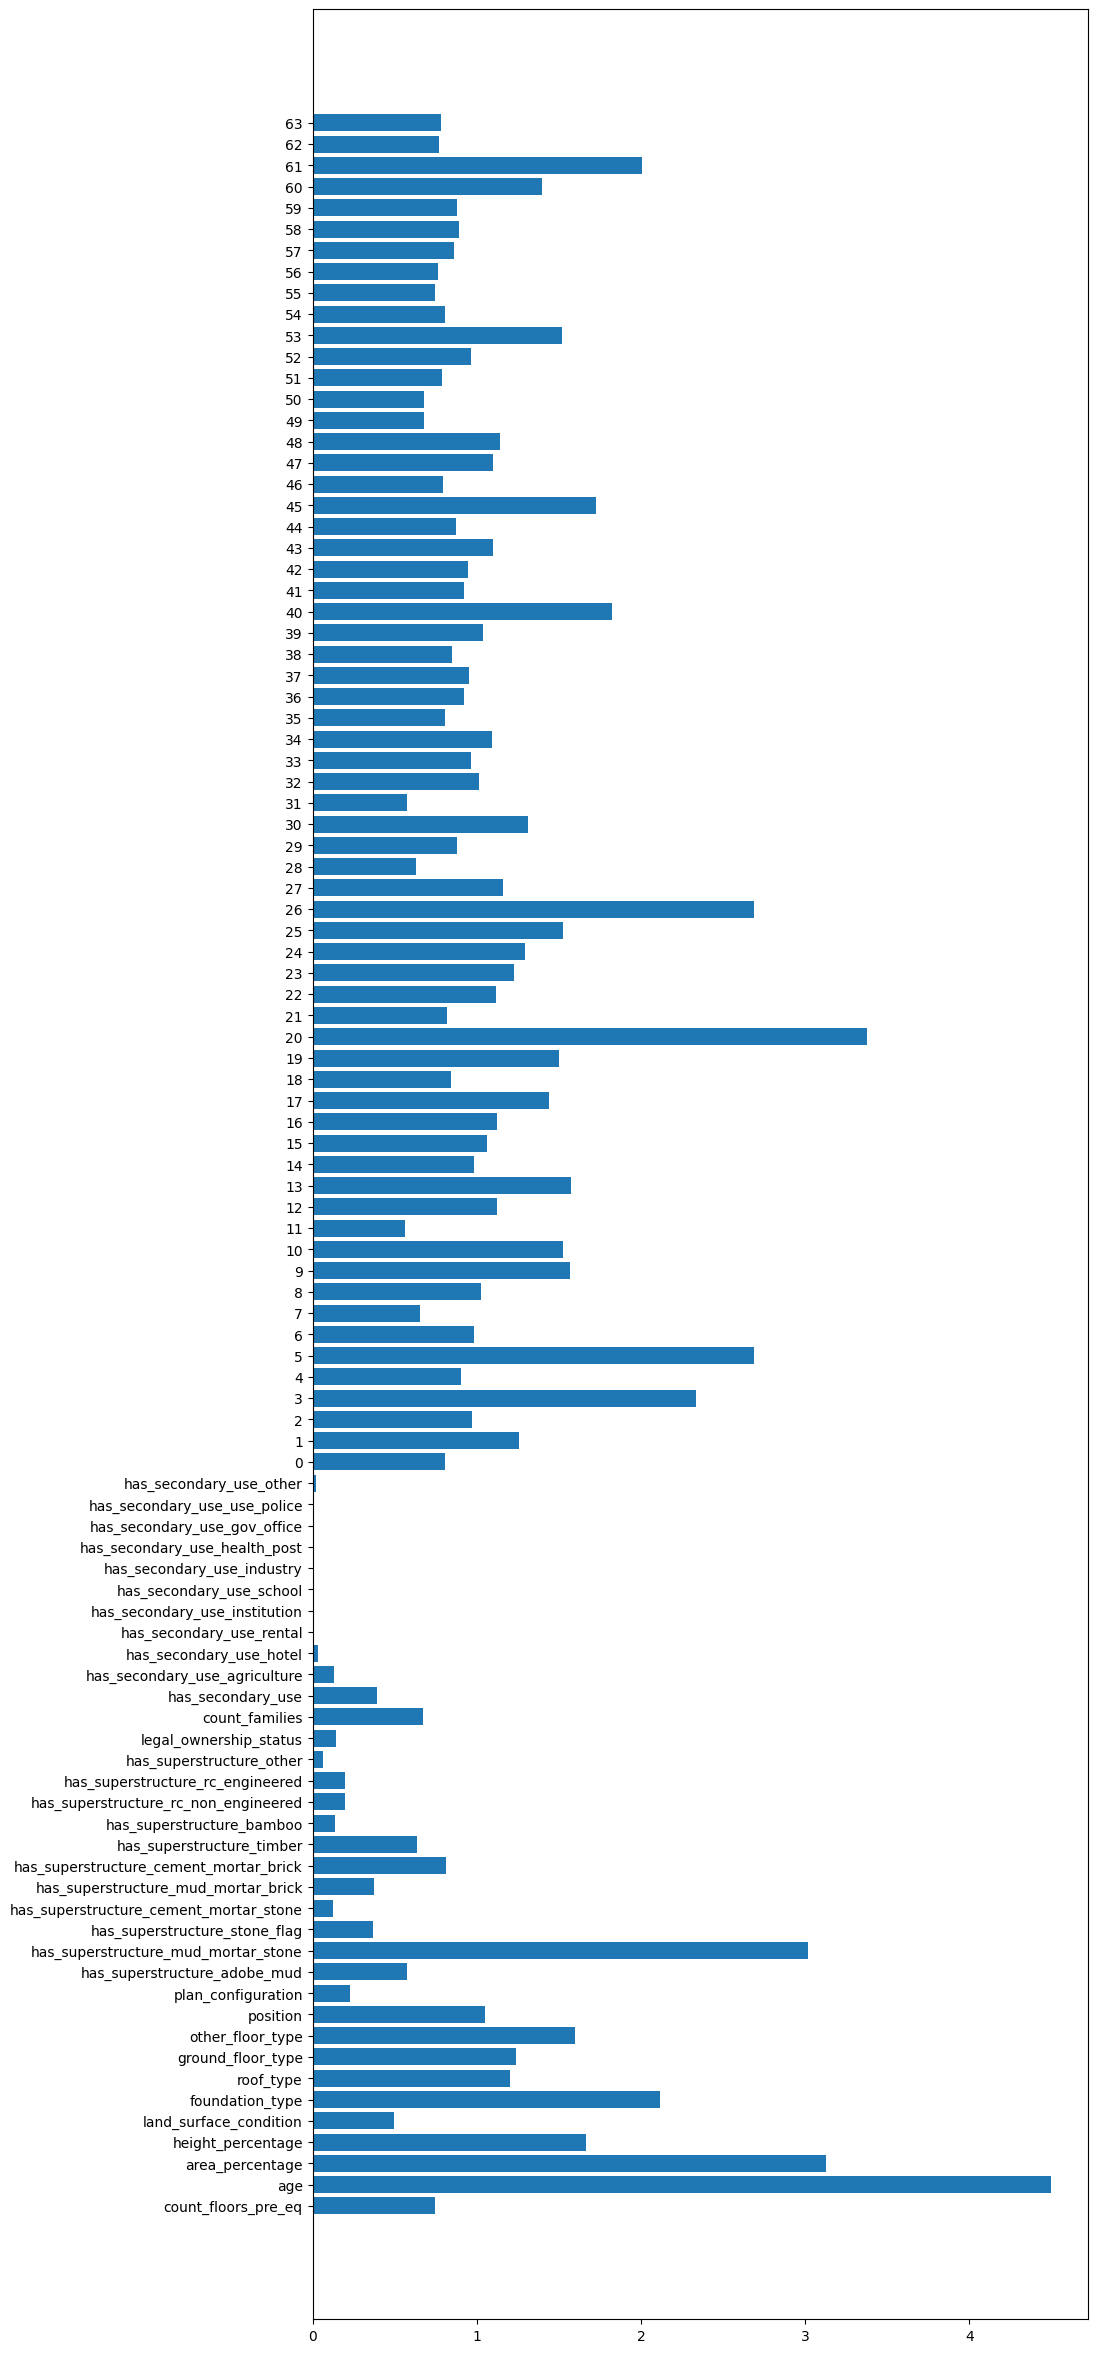

In [10]:
fig,ax = plt.subplots(1,1,figsize=(10,30))
ax.barh([str(col) for col in df_train_X.columns], model_cls.feature_importances_)

### Investigation into effect of dropping original geofeatures

Keeping original geo-features is marginally (or not at all) better it seems. We start with dropping original features here. Multiple runs of the same code, relying on inherent randomness in NN to get a distribution of accuracy scores.

In [8]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 492.62it/s]


Epoch [1/10], Loss: 6.782640874649183


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 521.78it/s]


Epoch [2/10], Loss: 0.48981128749334757


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 508.49it/s]


Epoch [3/10], Loss: 0.223856477984481


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 504.37it/s]


Epoch [4/10], Loss: 0.1679518491136725


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 506.98it/s]


Epoch [5/10], Loss: 0.11331088659977637


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 494.61it/s]


Epoch [6/10], Loss: 0.09789067879422061


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 506.86it/s]


Epoch [7/10], Loss: 0.09670259728849438


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 504.30it/s]


Epoch [8/10], Loss: 0.07115315349528425


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 513.06it/s]


Epoch [9/10], Loss: 0.06735512736537706


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 528.22it/s]


Epoch [10/10], Loss: 0.05679128009234267


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 2715/2715 [00:01<00:00, 1412.56it/s]


0:	learn: 1.0933435	total: 11.5ms	remaining: 3m 50s
500:	learn: 0.6898199	total: 4.26s	remaining: 2m 45s
1000:	learn: 0.6474783	total: 8.38s	remaining: 2m 39s
1500:	learn: 0.6200325	total: 12.5s	remaining: 2m 34s
2000:	learn: 0.6005645	total: 16.7s	remaining: 2m 30s
2500:	learn: 0.5858170	total: 20.9s	remaining: 2m 26s
3000:	learn: 0.5740629	total: 25s	remaining: 2m 21s
3500:	learn: 0.5646670	total: 29.1s	remaining: 2m 17s
4000:	learn: 0.5568061	total: 33.2s	remaining: 2m 12s
4500:	learn: 0.5498053	total: 37.3s	remaining: 2m 8s
5000:	learn: 0.5435957	total: 41.3s	remaining: 2m 3s
5500:	learn: 0.5381011	total: 45.4s	remaining: 1m 59s
6000:	learn: 0.5329855	total: 49.4s	remaining: 1m 55s
6500:	learn: 0.5281158	total: 53.4s	remaining: 1m 50s
7000:	learn: 0.5236366	total: 57.5s	remaining: 1m 46s
7500:	learn: 0.5193602	total: 1m 1s	remaining: 1m 42s
8000:	learn: 0.5152115	total: 1m 5s	remaining: 1m 38s
8500:	learn: 0.5112367	total: 1m 9s	remaining: 1m 34s
9000:	learn: 0.5074181	total: 1m 13

In [9]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 518.28it/s]


Epoch [1/10], Loss: 6.796340149746377


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 515.59it/s]


Epoch [2/10], Loss: 0.4660596183510785


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 521.69it/s]


Epoch [3/10], Loss: 0.21117265495733634


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 524.20it/s]


Epoch [4/10], Loss: 0.14800814544269061


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 500.24it/s]


Epoch [5/10], Loss: 0.11484621722485722


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 517.26it/s]


Epoch [6/10], Loss: 0.10861415196441948


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 513.83it/s]


Epoch [7/10], Loss: 0.0730076636130639


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 511.03it/s]


Epoch [8/10], Loss: 0.08516106641915146


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 532.08it/s]


Epoch [9/10], Loss: 0.06985021589811828


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 520.43it/s]


Epoch [10/10], Loss: 0.05234834615668194


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 2715/2715 [00:01<00:00, 1436.34it/s]


0:	learn: 1.0932638	total: 8.83ms	remaining: 2m 56s
500:	learn: 0.6856398	total: 4.24s	remaining: 2m 45s
1000:	learn: 0.6438140	total: 8.4s	remaining: 2m 39s
1500:	learn: 0.6168008	total: 12.6s	remaining: 2m 35s
2000:	learn: 0.5979483	total: 16.8s	remaining: 2m 30s
2500:	learn: 0.5834053	total: 20.9s	remaining: 2m 26s
3000:	learn: 0.5721337	total: 25.1s	remaining: 2m 21s
3500:	learn: 0.5627870	total: 29.2s	remaining: 2m 17s
4000:	learn: 0.5550126	total: 33.3s	remaining: 2m 13s
4500:	learn: 0.5480934	total: 37.4s	remaining: 2m 8s
5000:	learn: 0.5419405	total: 41.5s	remaining: 2m 4s
5500:	learn: 0.5363417	total: 45.5s	remaining: 2m
6000:	learn: 0.5313328	total: 49.6s	remaining: 1m 55s
6500:	learn: 0.5265231	total: 53.6s	remaining: 1m 51s
7000:	learn: 0.5220093	total: 57.7s	remaining: 1m 47s
7500:	learn: 0.5177292	total: 1m 1s	remaining: 1m 42s
8000:	learn: 0.5136619	total: 1m 5s	remaining: 1m 38s
8500:	learn: 0.5096361	total: 1m 9s	remaining: 1m 34s
9000:	learn: 0.5058565	total: 1m 14s	r

In [10]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 522.60it/s]


Epoch [1/10], Loss: 6.728486248951773


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 517.93it/s]


Epoch [2/10], Loss: 0.5034332297500964


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 520.96it/s]


Epoch [3/10], Loss: 0.21682476017772273


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 511.16it/s]


Epoch [4/10], Loss: 0.17196153251478924


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 529.38it/s]


Epoch [5/10], Loss: 0.12503371233859858


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 528.73it/s]


Epoch [6/10], Loss: 0.10136606609424788


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 519.75it/s]


Epoch [7/10], Loss: 0.09192001979060153


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 530.31it/s]


Epoch [8/10], Loss: 0.0785322539045939


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 530.51it/s]


Epoch [9/10], Loss: 0.06921407216916407


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 531.03it/s]


Epoch [10/10], Loss: 0.06324932696153746


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 2715/2715 [00:01<00:00, 1440.28it/s]


0:	learn: 1.0930650	total: 9.48ms	remaining: 3m 9s
500:	learn: 0.6845385	total: 4.23s	remaining: 2m 44s
1000:	learn: 0.6432885	total: 8.33s	remaining: 2m 38s
1500:	learn: 0.6164760	total: 12.5s	remaining: 2m 33s
2000:	learn: 0.5977253	total: 16.6s	remaining: 2m 28s
2500:	learn: 0.5832760	total: 20.7s	remaining: 2m 24s
3000:	learn: 0.5722756	total: 24.8s	remaining: 2m 20s
3500:	learn: 0.5629996	total: 28.8s	remaining: 2m 15s
4000:	learn: 0.5551564	total: 32.9s	remaining: 2m 11s
4500:	learn: 0.5482704	total: 37s	remaining: 2m 7s
5000:	learn: 0.5421819	total: 41s	remaining: 2m 2s
5500:	learn: 0.5367299	total: 45s	remaining: 1m 58s
6000:	learn: 0.5316195	total: 49s	remaining: 1m 54s
6500:	learn: 0.5267738	total: 53s	remaining: 1m 50s
7000:	learn: 0.5223125	total: 57s	remaining: 1m 45s
7500:	learn: 0.5180897	total: 1m 1s	remaining: 1m 41s
8000:	learn: 0.5141012	total: 1m 5s	remaining: 1m 37s
8500:	learn: 0.5101837	total: 1m 9s	remaining: 1m 33s
9000:	learn: 0.5064446	total: 1m 13s	remaining

In [11]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 523.35it/s]


Epoch [1/10], Loss: 6.8610282376167175


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 523.24it/s]


Epoch [2/10], Loss: 0.5478377847799233


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 508.80it/s]


Epoch [3/10], Loss: 0.2306849576686461


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 520.33it/s]


Epoch [4/10], Loss: 0.1595735556757371


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 518.38it/s]


Epoch [5/10], Loss: 0.1308948015773584


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 498.27it/s]


Epoch [6/10], Loss: 0.10769296239698731


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 509.84it/s]


Epoch [7/10], Loss: 0.07728631224514798


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 529.41it/s]


Epoch [8/10], Loss: 0.07502406125251115


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 514.85it/s]


Epoch [9/10], Loss: 0.07110086810253546


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 523.55it/s]


Epoch [10/10], Loss: 0.06635124701562949


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 2715/2715 [00:01<00:00, 1437.42it/s]


0:	learn: 1.0931583	total: 9.89ms	remaining: 3m 17s
500:	learn: 0.6859751	total: 4.27s	remaining: 2m 46s
1000:	learn: 0.6442479	total: 8.43s	remaining: 2m 39s
1500:	learn: 0.6180803	total: 12.6s	remaining: 2m 34s
2000:	learn: 0.5991367	total: 16.7s	remaining: 2m 30s
2500:	learn: 0.5844002	total: 20.9s	remaining: 2m 26s
3000:	learn: 0.5727477	total: 25.1s	remaining: 2m 21s
3500:	learn: 0.5633020	total: 29.2s	remaining: 2m 17s
4000:	learn: 0.5552943	total: 33.3s	remaining: 2m 13s
4500:	learn: 0.5483598	total: 37.4s	remaining: 2m 8s
5000:	learn: 0.5421608	total: 41.5s	remaining: 2m 4s
5500:	learn: 0.5365860	total: 45.5s	remaining: 2m
6000:	learn: 0.5314125	total: 49.6s	remaining: 1m 55s
6500:	learn: 0.5266743	total: 53.6s	remaining: 1m 51s
7000:	learn: 0.5220991	total: 57.7s	remaining: 1m 47s
7500:	learn: 0.5177165	total: 1m 1s	remaining: 1m 42s
8000:	learn: 0.5136441	total: 1m 5s	remaining: 1m 38s
8500:	learn: 0.5096754	total: 1m 9s	remaining: 1m 34s
9000:	learn: 0.5058912	total: 1m 14s	

In [12]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 507.38it/s]


Epoch [1/10], Loss: 6.752172339998394


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 519.25it/s]


Epoch [2/10], Loss: 0.4752893379953894


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 520.42it/s]


Epoch [3/10], Loss: 0.23810128622108162


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 529.51it/s]


Epoch [4/10], Loss: 0.14588200650280767


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 521.89it/s]


Epoch [5/10], Loss: 0.1264782852115348


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 519.87it/s]


Epoch [6/10], Loss: 0.09683231740918379


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 533.50it/s]


Epoch [7/10], Loss: 0.08742728001292005


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 545.81it/s]


Epoch [8/10], Loss: 0.08118170260044366


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 525.70it/s]


Epoch [9/10], Loss: 0.06618860209748541


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 518.94it/s]


Epoch [10/10], Loss: 0.05010957376823904


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 2715/2715 [00:01<00:00, 1435.48it/s]


0:	learn: 1.0932930	total: 9.44ms	remaining: 3m 8s
500:	learn: 0.6850428	total: 4.27s	remaining: 2m 46s
1000:	learn: 0.6423038	total: 8.42s	remaining: 2m 39s
1500:	learn: 0.6158127	total: 12.6s	remaining: 2m 34s
2000:	learn: 0.5967418	total: 16.7s	remaining: 2m 30s
2500:	learn: 0.5824407	total: 20.9s	remaining: 2m 25s
3000:	learn: 0.5714533	total: 24.9s	remaining: 2m 21s
3500:	learn: 0.5623445	total: 29s	remaining: 2m 16s
4000:	learn: 0.5546002	total: 33.1s	remaining: 2m 12s
4500:	learn: 0.5477681	total: 37.2s	remaining: 2m 8s
5000:	learn: 0.5416875	total: 41.3s	remaining: 2m 3s
5500:	learn: 0.5362919	total: 45.3s	remaining: 1m 59s
6000:	learn: 0.5312162	total: 49.3s	remaining: 1m 55s
6500:	learn: 0.5264845	total: 53.4s	remaining: 1m 50s
7000:	learn: 0.5218709	total: 57.4s	remaining: 1m 46s
7500:	learn: 0.5176483	total: 1m 1s	remaining: 1m 42s
8000:	learn: 0.5135951	total: 1m 5s	remaining: 1m 38s
8500:	learn: 0.5096869	total: 1m 9s	remaining: 1m 34s
9000:	learn: 0.5059280	total: 1m 13s

And move into keeping original features here.

In [13]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 490.68it/s]


Epoch [1/10], Loss: 6.896619075045143


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 518.57it/s]


Epoch [2/10], Loss: 0.5056063992482924


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 519.28it/s]


Epoch [3/10], Loss: 0.24794415396052538


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 529.92it/s]


Epoch [4/10], Loss: 0.1676918850842704


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 516.54it/s]


Epoch [5/10], Loss: 0.1316900666349119


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 521.72it/s]


Epoch [6/10], Loss: 0.11657994357074868


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 518.76it/s]


Epoch [7/10], Loss: 0.09034568825476036


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 518.47it/s]


Epoch [8/10], Loss: 0.08191326759540954


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 495.47it/s]


Epoch [9/10], Loss: 0.06642832316069718


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 508.80it/s]


Epoch [10/10], Loss: 0.06759281579546687


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 2715/2715 [00:01<00:00, 1471.56it/s]


0:	learn: 1.0911600	total: 8ms	remaining: 2m 40s
500:	learn: 0.6227098	total: 3.93s	remaining: 2m 32s
1000:	learn: 0.6008959	total: 8.01s	remaining: 2m 31s
1500:	learn: 0.5873463	total: 12.1s	remaining: 2m 28s
2000:	learn: 0.5770507	total: 16.1s	remaining: 2m 24s
2500:	learn: 0.5688953	total: 20.1s	remaining: 2m 20s
3000:	learn: 0.5618369	total: 24.2s	remaining: 2m 16s
3500:	learn: 0.5556014	total: 28.2s	remaining: 2m 12s
4000:	learn: 0.5499283	total: 32.2s	remaining: 2m 8s
4500:	learn: 0.5447012	total: 36.2s	remaining: 2m 4s
5000:	learn: 0.5395640	total: 40.3s	remaining: 2m
5500:	learn: 0.5348545	total: 44.3s	remaining: 1m 56s
6000:	learn: 0.5304355	total: 48.4s	remaining: 1m 52s
6500:	learn: 0.5262118	total: 52.4s	remaining: 1m 48s
7000:	learn: 0.5220321	total: 56.4s	remaining: 1m 44s
7500:	learn: 0.5180385	total: 1m	remaining: 1m 40s
8000:	learn: 0.5140808	total: 1m 4s	remaining: 1m 36s
8500:	learn: 0.5103179	total: 1m 8s	remaining: 1m 32s
9000:	learn: 0.5066715	total: 1m 12s	remain

In [14]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 504.97it/s]


Epoch [1/10], Loss: 6.584376604857255


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 507.22it/s]


Epoch [2/10], Loss: 0.4647097253296881


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 511.94it/s]


Epoch [3/10], Loss: 0.2167031158993517


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 531.29it/s]


Epoch [4/10], Loss: 0.16592896196700424


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 514.25it/s]


Epoch [5/10], Loss: 0.11449353979072027


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 505.30it/s]


Epoch [6/10], Loss: 0.10382535698342196


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 525.66it/s]


Epoch [7/10], Loss: 0.08306237221119407


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 511.34it/s]


Epoch [8/10], Loss: 0.07249072125656132


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 519.72it/s]


Epoch [9/10], Loss: 0.0707288843626568


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 531.87it/s]


Epoch [10/10], Loss: 0.053408489500377146


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 2715/2715 [00:01<00:00, 1436.80it/s]


0:	learn: 1.0911551	total: 8.02ms	remaining: 2m 40s
500:	learn: 0.6220218	total: 4.01s	remaining: 2m 36s
1000:	learn: 0.6003516	total: 8.2s	remaining: 2m 35s
1500:	learn: 0.5865190	total: 12.3s	remaining: 2m 32s
2000:	learn: 0.5764166	total: 16.5s	remaining: 2m 28s
2500:	learn: 0.5684421	total: 20.5s	remaining: 2m 23s
3000:	learn: 0.5613237	total: 24.6s	remaining: 2m 19s
3500:	learn: 0.5550898	total: 28.7s	remaining: 2m 15s
4000:	learn: 0.5493250	total: 32.8s	remaining: 2m 11s
4500:	learn: 0.5439219	total: 36.9s	remaining: 2m 7s
5000:	learn: 0.5389008	total: 41s	remaining: 2m 3s
5500:	learn: 0.5341679	total: 45.1s	remaining: 1m 58s
6000:	learn: 0.5296163	total: 49.2s	remaining: 1m 54s
6500:	learn: 0.5253149	total: 53.3s	remaining: 1m 50s
7000:	learn: 0.5211811	total: 57.4s	remaining: 1m 46s
7500:	learn: 0.5171974	total: 1m 1s	remaining: 1m 42s
8000:	learn: 0.5133341	total: 1m 5s	remaining: 1m 38s
8500:	learn: 0.5095650	total: 1m 9s	remaining: 1m 34s
9000:	learn: 0.5058747	total: 1m 13s

In [15]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 511.91it/s]


Epoch [1/10], Loss: 6.594942871179426


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 514.40it/s]


Epoch [2/10], Loss: 0.4585027894079246


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 513.11it/s]


Epoch [3/10], Loss: 0.23138353912179002


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 510.10it/s]


Epoch [4/10], Loss: 0.14936199517569482


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 500.53it/s]


Epoch [5/10], Loss: 0.1284105400421104


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 515.40it/s]


Epoch [6/10], Loss: 0.09372513686133266


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 503.84it/s]


Epoch [7/10], Loss: 0.08605022743770878


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 491.00it/s]


Epoch [8/10], Loss: 0.07867721560673818


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 507.28it/s]


Epoch [9/10], Loss: 0.064402498393527


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 502.60it/s]


Epoch [10/10], Loss: 0.06324416594057747


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 2715/2715 [00:01<00:00, 1435.26it/s]


0:	learn: 1.0911282	total: 7.78ms	remaining: 2m 35s
500:	learn: 0.6221730	total: 3.97s	remaining: 2m 34s
1000:	learn: 0.6001354	total: 8.11s	remaining: 2m 33s
1500:	learn: 0.5862117	total: 12.2s	remaining: 2m 30s
2000:	learn: 0.5759590	total: 16.3s	remaining: 2m 27s
2500:	learn: 0.5677772	total: 20.4s	remaining: 2m 23s
3000:	learn: 0.5607999	total: 24.5s	remaining: 2m 18s
3500:	learn: 0.5545177	total: 28.6s	remaining: 2m 14s
4000:	learn: 0.5488434	total: 32.6s	remaining: 2m 10s
4500:	learn: 0.5435089	total: 36.7s	remaining: 2m 6s
5000:	learn: 0.5384114	total: 40.8s	remaining: 2m 2s
5500:	learn: 0.5337046	total: 44.9s	remaining: 1m 58s
6000:	learn: 0.5291959	total: 49s	remaining: 1m 54s
6500:	learn: 0.5250091	total: 53s	remaining: 1m 50s
7000:	learn: 0.5209914	total: 57.1s	remaining: 1m 46s
7500:	learn: 0.5169722	total: 1m 1s	remaining: 1m 41s
8000:	learn: 0.5130522	total: 1m 5s	remaining: 1m 37s
8500:	learn: 0.5092951	total: 1m 9s	remaining: 1m 33s
9000:	learn: 0.5056587	total: 1m 13s	

In [16]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 495.12it/s]


Epoch [1/10], Loss: 6.719353992607176


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 515.12it/s]


Epoch [2/10], Loss: 0.4579818844356312


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 509.39it/s]


Epoch [3/10], Loss: 0.19781866437304266


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 507.16it/s]


Epoch [4/10], Loss: 0.1387510797412125


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 514.51it/s]


Epoch [5/10], Loss: 0.11872995926124841


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 510.73it/s]


Epoch [6/10], Loss: 0.08295366581459426


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 499.30it/s]


Epoch [7/10], Loss: 0.07768874817323118


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 522.67it/s]


Epoch [8/10], Loss: 0.06843632606231224


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 516.84it/s]


Epoch [9/10], Loss: 0.0667756191835535


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 510.22it/s]


Epoch [10/10], Loss: 0.05621691097540367


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 2715/2715 [00:01<00:00, 1432.15it/s]


0:	learn: 1.0911285	total: 8.39ms	remaining: 2m 47s
500:	learn: 0.6222378	total: 4s	remaining: 2m 35s
1000:	learn: 0.6004019	total: 8.14s	remaining: 2m 34s
1500:	learn: 0.5868299	total: 12.3s	remaining: 2m 31s
2000:	learn: 0.5764826	total: 16.4s	remaining: 2m 27s
2500:	learn: 0.5682653	total: 20.5s	remaining: 2m 23s
3000:	learn: 0.5612373	total: 24.6s	remaining: 2m 19s
3500:	learn: 0.5550156	total: 28.7s	remaining: 2m 15s
4000:	learn: 0.5493308	total: 32.8s	remaining: 2m 11s
4500:	learn: 0.5440234	total: 36.9s	remaining: 2m 6s
5000:	learn: 0.5390394	total: 41s	remaining: 2m 2s
5500:	learn: 0.5344062	total: 45.1s	remaining: 1m 58s
6000:	learn: 0.5299645	total: 49.1s	remaining: 1m 54s
6500:	learn: 0.5257219	total: 53.2s	remaining: 1m 50s
7000:	learn: 0.5215933	total: 57.3s	remaining: 1m 46s
7500:	learn: 0.5175818	total: 1m 1s	remaining: 1m 42s
8000:	learn: 0.5138315	total: 1m 5s	remaining: 1m 38s
8500:	learn: 0.5100990	total: 1m 9s	remaining: 1m 34s
9000:	learn: 0.5064568	total: 1m 13s	r

In [51]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 499.12it/s]


Epoch [1/10], Loss: 6.380747606766593


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 506.09it/s]


Epoch [2/10], Loss: 0.47425544360688227


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 556.78it/s]


Epoch [3/10], Loss: 0.2259955158092312


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 496.68it/s]


Epoch [4/10], Loss: 0.15590656117847482


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 530.57it/s]


Epoch [5/10], Loss: 0.11452381277493913


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 520.39it/s]


Epoch [6/10], Loss: 0.11256959767078101


Epoch 7/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 496.77it/s]


Epoch [7/10], Loss: 0.08220889131622237


Epoch 8/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 496.64it/s]


Epoch [8/10], Loss: 0.0767349766369152


Epoch 9/10: 100%|██████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 513.53it/s]


Epoch [9/10], Loss: 0.06206387587239526


Epoch 10/10: 100%|█████████████████████████████████████████████████████████████████| 1358/1358 [00:02<00:00, 504.11it/s]


Epoch [10/10], Loss: 0.057134957578350735


Evaluating: 100%|█████████████████████████████████████████████████████████████████| 2715/2715 [00:01<00:00, 1450.69it/s]


0:	learn: 1.0911282	total: 7.9ms	remaining: 2m 37s
500:	learn: 0.6221537	total: 3.87s	remaining: 2m 30s
1000:	learn: 0.5999348	total: 7.91s	remaining: 2m 30s
1500:	learn: 0.5860539	total: 11.9s	remaining: 2m 27s
2000:	learn: 0.5757823	total: 15.9s	remaining: 2m 23s
2500:	learn: 0.5677236	total: 19.9s	remaining: 2m 19s
3000:	learn: 0.5609084	total: 23.9s	remaining: 2m 15s
3500:	learn: 0.5546521	total: 27.8s	remaining: 2m 11s
4000:	learn: 0.5489061	total: 31.8s	remaining: 2m 7s
4500:	learn: 0.5438025	total: 35.7s	remaining: 2m 3s
5000:	learn: 0.5387409	total: 39.7s	remaining: 1m 59s
5500:	learn: 0.5340251	total: 43.7s	remaining: 1m 55s
6000:	learn: 0.5295888	total: 47.7s	remaining: 1m 51s
6500:	learn: 0.5253540	total: 51.7s	remaining: 1m 47s
7000:	learn: 0.5212842	total: 55.6s	remaining: 1m 43s
7500:	learn: 0.5173003	total: 59.6s	remaining: 1m 39s
8000:	learn: 0.5133216	total: 1m 3s	remaining: 1m 35s
8500:	learn: 0.5095639	total: 1m 7s	remaining: 1m 31s
9000:	learn: 0.5059428	total: 1m 1

### low learning rate grid search

looks like already using optimal config with depth 8, while l2_leaf_reg=5 and min_data_in_leaf=80 prob good to go.

In [8]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 476.11it/s]


Epoch [1/10], Loss: 6.5618051807992765


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 509.42it/s]


Epoch [2/10], Loss: 0.4694179732829815


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 495.07it/s]


Epoch [3/10], Loss: 0.20948076483262745


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 510.34it/s]


Epoch [4/10], Loss: 0.14512188072194276


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.54it/s]


Epoch [5/10], Loss: 0.1292664996061655


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 495.89it/s]


Epoch [6/10], Loss: 0.09873412295988046


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.57it/s]


Epoch [7/10], Loss: 0.09886563044118206


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.19it/s]


Epoch [8/10], Loss: 0.07131332111498959


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.04it/s]


Epoch [9/10], Loss: 0.06777031241455946


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.97it/s]


Epoch [10/10], Loss: 0.0688133216470316


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1254.57it/s]


In [9]:
l2_leaf_regs = [2,3,4,5,6,7,8]
depths = [6,7,8,9,10]
min_data_in_leafs = [1,5,10,25,50,75,100]

output_file = open('low_eta_gridsearch.txt', 'a')
counter=0

for l2_leaf_reg in l2_leaf_regs:
    for depth in depths:
        for min_data_in_leaf in min_data_in_leafs:
            start_time = time.time()
            print('\n\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
            counter+=1
            # Instantiate catboost classifier model
            model_cls = cb.CatBoostClassifier(
                objective='MultiClass',  # Use 'MultiClass' for classification
                task_type='GPU',  # Specify GPU if available
                devices='0',  # Specify GPU device(s) if multiple
                metric_period=5000,  # Period to print metrics
                iterations=20000,  # Number of boosting iterations
                learning_rate=0.01,  # Learning rate
                depth=depth,  # Depth of the trees
                min_data_in_leaf  = min_data_in_leaf,
                l2_leaf_reg=l2_leaf_reg,  # L2 regularization coefficient
                custom_metric=['Accuracy']  # Additional metrics to track
            )
            
            model_cls.fit(train_val_dataset)
            
            # Evaluation
            pred = model_cls.predict(df_test_X)
            acc = accuracy_score(df_test_y, pred)
            f1 = f1_score(df_test_y,pred,average='micro')
            output_text = f'{counter}: Testing performance for l2_leaf_reg: {l2_leaf_reg}, depth: {depth}, min_data_in_leaf: {min_data_in_leaf}, Accuracy: {acc:.4f}, F1-score: {f1:.4f}\n'
            print(output_text)
            output_file.write(output_text)
            output_file.flush()
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"Time taken: {elapsed_time} seconds")
output_file.close()



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0:	learn: 1.0912981	total: 9.9ms	remaining: 3m 18s
5000:	learn: 0.5715575	total: 21.7s	remaining: 1m 4s
10000:	learn: 0.5476586	total: 43.5s	remaining: 43.5s
15000:	learn: 0.5302109	total: 1m 5s	remaining: 21.8s
19999:	learn: 0.5155672	total: 1m 27s	remaining: 0us
1: Testing performance for l2_leaf_reg: 2, depth: 6, min_data_in_leaf: 1, Accuracy: 0.7549, F1-score: 0.7549
Time taken: 88.60651636123657 seconds


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0:	learn: 1.0912985	total: 4.87ms	remaining: 1m 37s
5000:	learn: 0.5715958	total: 20.8s	remaining: 1m 2s
10000:	learn: 0.5476349	total: 41.5s	remaining: 41.5s
15000:	learn: 0.5302649	total: 1m 2s	remaining: 20.8s
19999:	learn: 0.5156334	total: 1m 23s	remaining: 0us
2: Testing performance for l2_leaf_reg: 2, depth: 6, min_data_in_leaf: 5, Accuracy: 0.7548, F1-score: 0.7548
Time taken: 84.11472392082214 seconds


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0:	learn: 1.0912983	total: 4.13ms	remaining

In [35]:
# Load results text file
with open('low_eta_gridsearch2.txt','r') as f:
    low_eta_gs_text = f.readlines()
low_eta_gs_text = low_eta_gs_text[1:]
low_eta_gs_text = [line.rstrip('\n') for line in low_eta_gs_text]
pattern = re.compile(
    r'(\d+): Testing performance for l2_leaf_reg: (\d+), depth: (\d+), min_data_in_leaf: (\d+), Accuracy: (\d\.\d{4}), F1-score: (\d\.\d{4})'
)

# List to hold extracted data
data = []

# Extract values for each line
for line in low_eta_gs_text:
    match = pattern.match(line)
    if match:
        index = int(match.group(1))
        l2_leaf_reg = int(match.group(2))
        depth = int(match.group(3))
        min_data_in_leaf = int(match.group(4))
        accuracy = float(match.group(5))
        f1_score = float(match.group(6))
        data.append([index, l2_leaf_reg, depth, min_data_in_leaf, accuracy, f1_score])

# Create a DataFrame
df_low_eta_gs_results = pd.DataFrame(data, columns=['Index', 'L2_leaf_reg', 'Depth', 'Min_data_in_leaf', 'Accuracy', 'F1_score'])
df_low_eta_gs_results = df_low_eta_gs_results.drop_duplicates().drop(columns=['Index'])

In [38]:
df_low_eta_gs_results.columns

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


Index(['L2_leaf_reg', 'Depth', 'Min_data_in_leaf', 'Accuracy', 'F1_score'], dtype='object')

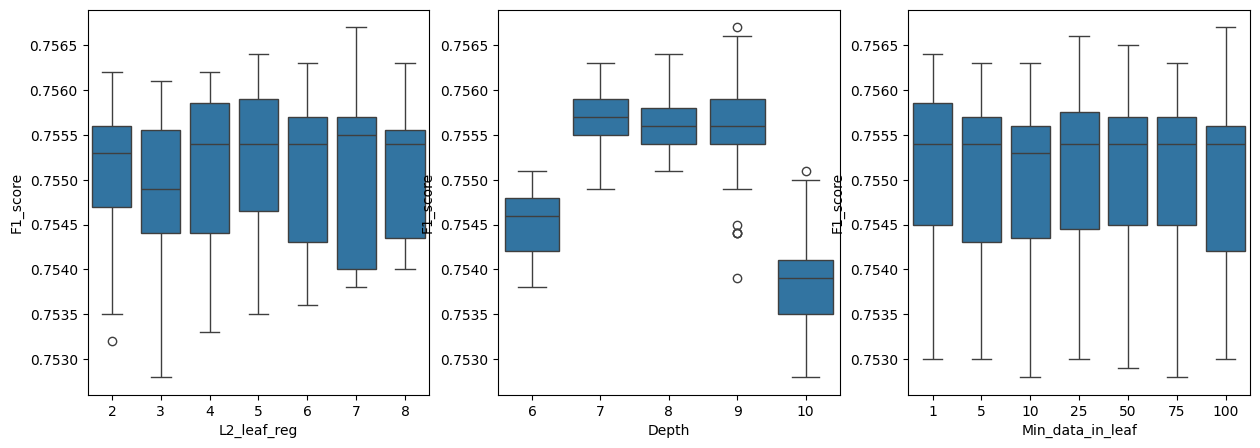

In [40]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

for i,param in enumerate(['L2_leaf_reg', 'Depth', 'Min_data_in_leaf']):
    sns.boxplot(df_low_eta_gs_results,x=param,y='F1_score',ax=axs[i])

<Axes: xlabel='Depth', ylabel='F1_score'>

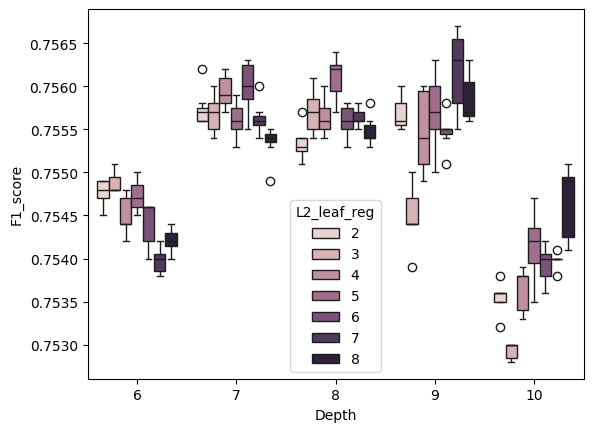

In [46]:
sns.boxplot(df_low_eta_gs_results,x='Depth',y='F1_score',hue='L2_leaf_reg')

<Axes: xlabel='Depth', ylabel='F1_score'>

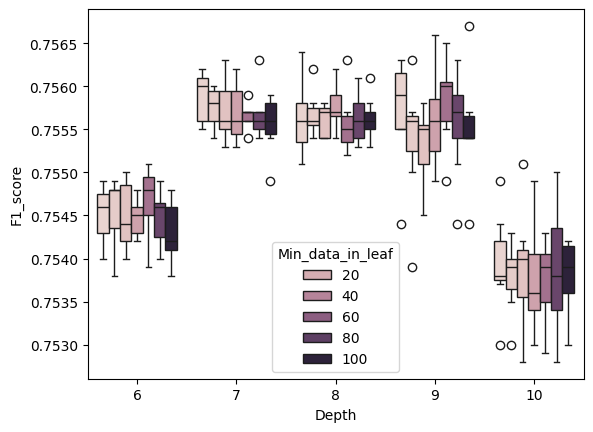

In [47]:
sns.boxplot(df_low_eta_gs_results,x='Depth',y='F1_score',hue='Min_data_in_leaf')

In [44]:
df_low_eta_gs_results['F1_score'].max()

0.7567

### Low learning rate, high n_estimators

In [24]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X_or = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, df_test_X_or,df_pred_X_or, df_train_y_or,df_val_y_or)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_val_X = df_val_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_test_X = df_test_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_pred_X = df_pred_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=5000,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.92it/s]


Epoch [1/10], Loss: 6.856513925478279


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 524.22it/s]


Epoch [2/10], Loss: 0.5419896949296584


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 519.01it/s]


Epoch [3/10], Loss: 0.2503449027707721


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 502.58it/s]


Epoch [4/10], Loss: 0.16232331361023597


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.56it/s]


Epoch [5/10], Loss: 0.11910646622150105


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 512.06it/s]


Epoch [6/10], Loss: 0.11331515474620774


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 520.14it/s]


Epoch [7/10], Loss: 0.0794277075127409


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.77it/s]


Epoch [8/10], Loss: 0.0805276481711425


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 507.13it/s]


Epoch [9/10], Loss: 0.07345391438997231


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 517.33it/s]


Epoch [10/10], Loss: 0.060264418280327865


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1614.70it/s]


0:	learn: 1.0934015	total: 9.47ms	remaining: 3m 9s
5000:	learn: 0.5442018	total: 44.4s	remaining: 2m 13s
10000:	learn: 0.5008243	total: 1m 27s	remaining: 1m 27s
15000:	learn: 0.4697064	total: 2m 10s	remaining: 43.7s
19999:	learn: 0.4438721	total: 2m 55s	remaining: 0us
Testing performance
Accuracy: 0.7552
F1-score: 0.7552


In [29]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X_or = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, df_test_X_or,df_pred_X_or, df_train_y_or,df_val_y_or)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 20

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_val_X = df_val_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_test_X = df_test_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_pred_X = df_pred_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=5000,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/20: 100%|██████████| 1358/1358 [00:02<00:00, 494.22it/s]


Epoch [1/20], Loss: 407.10947677488707


Epoch 2/20: 100%|██████████| 1358/1358 [00:02<00:00, 503.39it/s]


Epoch [2/20], Loss: 23.320576921478462


Epoch 3/20: 100%|██████████| 1358/1358 [00:02<00:00, 489.19it/s]


Epoch [3/20], Loss: 11.88737806524198


Epoch 4/20: 100%|██████████| 1358/1358 [00:02<00:00, 484.90it/s]


Epoch [4/20], Loss: 7.759655616683707


Epoch 5/20: 100%|██████████| 1358/1358 [00:02<00:00, 495.96it/s]


Epoch [5/20], Loss: 5.357760408786242


Epoch 6/20: 100%|██████████| 1358/1358 [00:02<00:00, 489.30it/s]


Epoch [6/20], Loss: 4.727027789021627


Epoch 7/20: 100%|██████████| 1358/1358 [00:02<00:00, 499.86it/s]


Epoch [7/20], Loss: 3.6091781005438897


Epoch 8/20: 100%|██████████| 1358/1358 [00:02<00:00, 473.89it/s]


Epoch [8/20], Loss: 3.6150039799719917


Epoch 9/20: 100%|██████████| 1358/1358 [00:02<00:00, 485.80it/s]


Epoch [9/20], Loss: 2.8710670027366136


Epoch 10/20: 100%|██████████| 1358/1358 [00:02<00:00, 498.02it/s]


Epoch [10/20], Loss: 2.7480176531185774


Epoch 11/20: 100%|██████████| 1358/1358 [00:02<00:00, 486.05it/s]


Epoch [11/20], Loss: 2.5381436153721


Epoch 12/20: 100%|██████████| 1358/1358 [00:02<00:00, 499.05it/s]


Epoch [12/20], Loss: 2.263731711683315


Epoch 13/20: 100%|██████████| 1358/1358 [00:02<00:00, 498.86it/s]


Epoch [13/20], Loss: 2.4387563251328226


Epoch 14/20: 100%|██████████| 1358/1358 [00:02<00:00, 489.16it/s]


Epoch [14/20], Loss: 2.5152209167646804


Epoch 15/20: 100%|██████████| 1358/1358 [00:02<00:00, 510.43it/s]


Epoch [15/20], Loss: 2.241825344246731


Epoch 16/20: 100%|██████████| 1358/1358 [00:02<00:00, 508.72it/s]


Epoch [16/20], Loss: 1.9633641158745299


Epoch 17/20: 100%|██████████| 1358/1358 [00:02<00:00, 494.80it/s]


Epoch [17/20], Loss: 2.431852744795884


Epoch 18/20: 100%|██████████| 1358/1358 [00:02<00:00, 510.95it/s]


Epoch [18/20], Loss: 1.9332505254062415


Epoch 19/20: 100%|██████████| 1358/1358 [00:02<00:00, 494.82it/s]


Epoch [19/20], Loss: 1.808109656698212


Epoch 20/20: 100%|██████████| 1358/1358 [00:02<00:00, 507.11it/s]


Epoch [20/20], Loss: 2.0166912074491954


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1392.64it/s]


0:	learn: 1.0936742	total: 10.7ms	remaining: 3m 33s
5000:	learn: 0.5465255	total: 44.3s	remaining: 2m 12s
10000:	learn: 0.5009309	total: 1m 27s	remaining: 1m 27s
15000:	learn: 0.4683068	total: 2m 12s	remaining: 44s
19999:	learn: 0.4412372	total: 2m 56s	remaining: 0us
Testing performance
Accuracy: 0.7549
F1-score: 0.7549


### CatBoost Classifier with PCA after geoencoding

Idea: smoothen geoencoding with PA. did not work, not seeing better results

In [13]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=5000,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.81it/s]


Epoch [1/10], Loss: 6.648085206505652


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.78it/s]


Epoch [2/10], Loss: 0.42554855503043126


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.24it/s]


Epoch [3/10], Loss: 0.2275404207029864


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.25it/s]


Epoch [4/10], Loss: 0.1543710349300473


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 432.11it/s]


Epoch [5/10], Loss: 0.12910016063931337


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.30it/s]


Epoch [6/10], Loss: 0.10490457802312791


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.46it/s]


Epoch [7/10], Loss: 0.07744364228210342


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 431.70it/s]


Epoch [8/10], Loss: 0.09358020106194039


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.66it/s]


Epoch [9/10], Loss: 0.06712314515075933


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 430.39it/s]


Epoch [10/10], Loss: 0.056576809480588124


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1290.82it/s]


0:	learn: 1.0932129	total: 9.19ms	remaining: 3m 3s
5000:	learn: 0.5433000	total: 45.1s	remaining: 2m 15s
10000:	learn: 0.4999048	total: 1m 29s	remaining: 1m 29s
15000:	learn: 0.4686687	total: 2m 13s	remaining: 44.6s
19999:	learn: 0.4427033	total: 2m 58s	remaining: 0us
Testing performance
Accuracy: 0.7544
F1-score: 0.7544


In [22]:
PCA(n_components=n_components).fit_transform(StandardScaler().fit_transform(latent_geo.loc[:,0:]))

array([[ 0.96356034, -1.7277426 , -0.98875386,  0.81919706, -0.1428654 ],
       [ 1.6666746 , -1.2642388 , -0.9932183 ,  0.29762638, -0.16417024],
       [ 1.8346497 , -1.1903653 , -1.1241075 ,  0.9316063 ,  0.21691784],
       ...,
       [ 2.1952388 , -0.31569153, -0.9895992 ,  2.4198248 , -0.5123643 ],
       [ 2.159487  , -0.03167177, -0.8452708 ,  2.7940893 ,  0.16866457],
       [ 2.646317  ,  0.00859806, -0.6533919 ,  2.2842503 ,  1.4479057 ]],
      dtype=float32)

In [ ]:
# Prep data for catboost
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)


In [31]:
n_components = 5
all_n_components = [3,5,10,15,20,40]

for n_components in all_n_components:
    latent_geo_pca = pd.concat([latent_geo[geo_features],
                                pd.DataFrame(
                                    PCA(n_components=n_components).fit_transform(
                                        StandardScaler().fit_transform(
                                            latent_geo.loc[:,0:])),
                                            columns=['PCA'+str(i) for i in range(n_components)])],axis=1)

    # Split into train, val, test and pred sets
    X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
    df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
    df_pred_X = df_pred_features_raw

    # Apply encoding
    df_train_X = df_train_X.merge(latent_geo_pca,on=geo_features,how='left')
    df_val_X = df_val_X.merge(latent_geo_pca,on=geo_features,how='left')
    df_test_X = df_test_X.merge(latent_geo_pca,on=geo_features,how='left')
    df_pred_X = df_pred_X.merge(latent_geo_pca,on=geo_features,how='left')

    df_train_X.drop(columns=geo_features, inplace=True)
    df_val_X.drop(columns=geo_features, inplace=True)
    df_test_X.drop(columns=geo_features, inplace=True)
    df_pred_X.drop(columns=geo_features, inplace=True)

    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_train_X.dtypes):
        if dtype in ['int64','int32','object','category']:
            categorical_features_indices.append(i)

    # Create pooled dataset following catboost requirements
    train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
    val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
    test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
    train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y],axis=0),
                                cat_features=categorical_features_indices)
    train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                                cat_features=categorical_features_indices)

    # Instantiate catboost classifier model
    model_cls = cb.CatBoostClassifier(
        objective='MultiClass',  # Use 'MultiClass' for classification
        task_type='GPU',  # Specify GPU if available
        devices='0',  # Specify GPU device(s) if multiple
        metric_period=5000,  # Period to print metrics
        iterations=20000,  # Number of boosting iterations
        learning_rate=0.01,  # Learning rate
        depth=8,  # Depth of the trees
        l2_leaf_reg=5,  # L2 regularization coefficient
        custom_metric=['Accuracy']  # Additional metrics to track
    )

    model_cls.fit(train_val_dataset)

    # Evaluation
    pred = model_cls.predict(df_test_X)
    acc = accuracy_score(df_test_y, pred)
    f1 = f1_score(df_test_y,pred,average='micro')

    print(f'\n\n\nTesting performance for n_components = {n_components}')
    print(f'Accuracy: {acc:.4f}')
    print(f'F1-score: {f1:.4f}')


0:	learn: 1.0932567	total: 8.9ms	remaining: 2m 57s
5000:	learn: 0.6154224	total: 39s	remaining: 1m 56s
10000:	learn: 0.5746999	total: 1m 18s	remaining: 1m 18s
15000:	learn: 0.5442747	total: 1m 57s	remaining: 39.2s
19999:	learn: 0.5185259	total: 2m 36s	remaining: 0us



Testing performance for n_components = 3
Accuracy: 0.7332
F1-score: 0.7332
0:	learn: 1.0930955	total: 9.05ms	remaining: 3m
5000:	learn: 0.5777056	total: 37.7s	remaining: 1m 53s
10000:	learn: 0.5358660	total: 1m 15s	remaining: 1m 15s
15000:	learn: 0.5053095	total: 1m 53s	remaining: 37.7s
19999:	learn: 0.4793061	total: 2m 31s	remaining: 0us



Testing performance for n_components = 5
Accuracy: 0.7501
F1-score: 0.7501
0:	learn: 1.0930956	total: 8.9ms	remaining: 2m 57s
5000:	learn: 0.5587113	total: 38.5s	remaining: 1m 55s
10000:	learn: 0.5149727	total: 1m 16s	remaining: 1m 16s
15000:	learn: 0.4825716	total: 1m 53s	remaining: 37.9s
19999:	learn: 0.4551158	total: 2m 31s	remaining: 0us



Testing performance for n_components = 

In [33]:
n_components = 5
all_n_components = [45,50,55,60]

for n_components in all_n_components:
    latent_geo_pca = pd.concat([latent_geo[geo_features],
                                pd.DataFrame(
                                    PCA(n_components=n_components).fit_transform(
                                        StandardScaler().fit_transform(
                                            latent_geo.loc[:,0:])),
                                            columns=['PCA'+str(i) for i in range(n_components)])],axis=1)

    # Split into train, val, test and pred sets
    X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
    df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
    df_pred_X = df_pred_features_raw

    # Apply encoding
    df_train_X = df_train_X.merge(latent_geo_pca,on=geo_features,how='left')
    df_val_X = df_val_X.merge(latent_geo_pca,on=geo_features,how='left')
    df_test_X = df_test_X.merge(latent_geo_pca,on=geo_features,how='left')
    df_pred_X = df_pred_X.merge(latent_geo_pca,on=geo_features,how='left')

    df_train_X.drop(columns=geo_features, inplace=True)
    df_val_X.drop(columns=geo_features, inplace=True)
    df_test_X.drop(columns=geo_features, inplace=True)
    df_pred_X.drop(columns=geo_features, inplace=True)

    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_train_X.dtypes):
        if dtype in ['int64','int32','object','category']:
            categorical_features_indices.append(i)

    # Create pooled dataset following catboost requirements
    train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
    val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
    test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
    train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y],axis=0),
                                cat_features=categorical_features_indices)
    train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                                cat_features=categorical_features_indices)

    # Instantiate catboost classifier model
    model_cls = cb.CatBoostClassifier(
        objective='MultiClass',  # Use 'MultiClass' for classification
        task_type='GPU',  # Specify GPU if available
        devices='0',  # Specify GPU device(s) if multiple
        metric_period=5000,  # Period to print metrics
        iterations=20000,  # Number of boosting iterations
        learning_rate=0.01,  # Learning rate
        depth=8,  # Depth of the trees
        l2_leaf_reg=5,  # L2 regularization coefficient
        custom_metric=['Accuracy']  # Additional metrics to track
    )

    model_cls.fit(train_val_dataset)

    # Evaluation
    pred = model_cls.predict(df_test_X)
    acc = accuracy_score(df_test_y, pred)
    f1 = f1_score(df_test_y,pred,average='micro')

    print(f'\n\n\nTesting performance for n_components = {n_components}')
    print(f'Accuracy: {acc:.4f}')
    print(f'F1-score: {f1:.4f}\n\n')


0:	learn: 1.0928591	total: 9.62ms	remaining: 3m 12s
5000:	learn: 0.5243761	total: 45.2s	remaining: 2m 15s
10000:	learn: 0.4839619	total: 1m 29s	remaining: 1m 29s
15000:	learn: 0.4532803	total: 2m 13s	remaining: 44.4s
19999:	learn: 0.4270812	total: 2m 57s	remaining: 0us



Testing performance for n_components = 45
Accuracy: 0.7553
F1-score: 0.7553


0:	learn: 1.0928590	total: 10.6ms	remaining: 3m 31s
5000:	learn: 0.5232017	total: 44.5s	remaining: 2m 13s
10000:	learn: 0.4827745	total: 1m 27s	remaining: 1m 27s
15000:	learn: 0.4522299	total: 2m 11s	remaining: 43.9s
19999:	learn: 0.4263449	total: 2m 55s	remaining: 0us



Testing performance for n_components = 50
Accuracy: 0.7546
F1-score: 0.7546


0:	learn: 1.0928591	total: 11.1ms	remaining: 3m 42s
5000:	learn: 0.5227590	total: 45.2s	remaining: 2m 15s
10000:	learn: 0.4823887	total: 1m 29s	remaining: 1m 29s
15000:	learn: 0.4516459	total: 2m 13s	remaining: 44.5s
19999:	learn: 0.4256518	total: 2m 58s	remaining: 0us



Testing performance for n

In [34]:
# Prep data for catboost
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 20

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)


Epoch 1/20: 100%|██████████| 1358/1358 [00:02<00:00, 497.90it/s]


Epoch [1/20], Loss: 6.479257000826947


Epoch 2/20: 100%|██████████| 1358/1358 [00:03<00:00, 434.61it/s]


Epoch [2/20], Loss: 0.4907413571688932


Epoch 3/20: 100%|██████████| 1358/1358 [00:02<00:00, 472.89it/s]


Epoch [3/20], Loss: 0.23133228686864493


Epoch 4/20: 100%|██████████| 1358/1358 [00:02<00:00, 505.85it/s]


Epoch [4/20], Loss: 0.14289324114370724


Epoch 5/20: 100%|██████████| 1358/1358 [00:03<00:00, 433.69it/s]


Epoch [5/20], Loss: 0.12275778815021329


Epoch 6/20: 100%|██████████| 1358/1358 [00:02<00:00, 452.89it/s]


Epoch [6/20], Loss: 0.1086673630293135


Epoch 7/20: 100%|██████████| 1358/1358 [00:02<00:00, 506.63it/s]


Epoch [7/20], Loss: 0.07615857900481052


Epoch 8/20: 100%|██████████| 1358/1358 [00:02<00:00, 469.37it/s]


Epoch [8/20], Loss: 0.08045358363719347


Epoch 9/20: 100%|██████████| 1358/1358 [00:03<00:00, 424.65it/s]


Epoch [9/20], Loss: 0.0625786866788428


Epoch 10/20: 100%|██████████| 1358/1358 [00:02<00:00, 492.03it/s]


Epoch [10/20], Loss: 0.058837882987537664


Epoch 11/20: 100%|██████████| 1358/1358 [00:02<00:00, 480.17it/s]


Epoch [11/20], Loss: 0.05252780413019736


Epoch 12/20: 100%|██████████| 1358/1358 [00:03<00:00, 430.03it/s]


Epoch [12/20], Loss: 0.04867056779620349


Epoch 13/20: 100%|██████████| 1358/1358 [00:02<00:00, 498.02it/s]


Epoch [13/20], Loss: 0.05064633631288506


Epoch 14/20: 100%|██████████| 1358/1358 [00:02<00:00, 497.83it/s]


Epoch [14/20], Loss: 0.048460982375623865


Epoch 15/20: 100%|██████████| 1358/1358 [00:03<00:00, 426.55it/s]


Epoch [15/20], Loss: 0.03985447493287157


Epoch 16/20: 100%|██████████| 1358/1358 [00:02<00:00, 480.47it/s]


Epoch [16/20], Loss: 0.04263559818529532


Epoch 17/20: 100%|██████████| 1358/1358 [00:02<00:00, 497.25it/s]


Epoch [17/20], Loss: 0.04175568947081336


Epoch 18/20: 100%|██████████| 1358/1358 [00:03<00:00, 435.11it/s]


Epoch [18/20], Loss: 0.04012726952389374


Epoch 19/20: 100%|██████████| 1358/1358 [00:02<00:00, 462.66it/s]


Epoch [19/20], Loss: 0.042618834498097384


Epoch 20/20: 100%|██████████| 1358/1358 [00:02<00:00, 501.15it/s]


Epoch [20/20], Loss: 0.027774272535599845


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1299.53it/s]


In [35]:
n_components = 5
all_n_components = [3,5,10,15,20,40,45,50,55,60]

for n_components in all_n_components:
    latent_geo_pca = pd.concat([latent_geo[geo_features],
                                pd.DataFrame(
                                    PCA(n_components=n_components).fit_transform(
                                        StandardScaler().fit_transform(
                                            latent_geo.loc[:,0:])),
                                            columns=['PCA'+str(i) for i in range(n_components)])],axis=1)

    # Split into train, val, test and pred sets
    X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
    df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
    df_pred_X = df_pred_features_raw

    # Apply encoding
    df_train_X = df_train_X.merge(latent_geo_pca,on=geo_features,how='left')
    df_val_X = df_val_X.merge(latent_geo_pca,on=geo_features,how='left')
    df_test_X = df_test_X.merge(latent_geo_pca,on=geo_features,how='left')
    df_pred_X = df_pred_X.merge(latent_geo_pca,on=geo_features,how='left')

    df_train_X.drop(columns=geo_features, inplace=True)
    df_val_X.drop(columns=geo_features, inplace=True)
    df_test_X.drop(columns=geo_features, inplace=True)
    df_pred_X.drop(columns=geo_features, inplace=True)

    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_train_X.dtypes):
        if dtype in ['int64','int32','object','category']:
            categorical_features_indices.append(i)

    # Create pooled dataset following catboost requirements
    train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
    val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
    test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
    train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y],axis=0),
                                cat_features=categorical_features_indices)
    train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                                cat_features=categorical_features_indices)

    # Instantiate catboost classifier model
    model_cls = cb.CatBoostClassifier(
        objective='MultiClass',  # Use 'MultiClass' for classification
        task_type='GPU',  # Specify GPU if available
        devices='0',  # Specify GPU device(s) if multiple
        metric_period=5000,  # Period to print metrics
        iterations=20000,  # Number of boosting iterations
        learning_rate=0.01,  # Learning rate
        depth=8,  # Depth of the trees
        l2_leaf_reg=5,  # L2 regularization coefficient
        custom_metric=['Accuracy']  # Additional metrics to track
    )

    model_cls.fit(train_val_dataset)

    # Evaluation
    pred = model_cls.predict(df_test_X)
    acc = accuracy_score(df_test_y, pred)
    f1 = f1_score(df_test_y,pred,average='micro')

    print(f'\n\n\nTesting performance for n_components = {n_components}')
    print(f'Accuracy: {acc:.4f}')
    print(f'F1-score: {f1:.4f}\n\n')


0:	learn: 1.0937541	total: 9.45ms	remaining: 3m 8s
5000:	learn: 0.6324910	total: 39s	remaining: 1m 56s
10000:	learn: 0.5892404	total: 1m 17s	remaining: 1m 17s
15000:	learn: 0.5572315	total: 1m 56s	remaining: 38.9s
19999:	learn: 0.5300078	total: 2m 36s	remaining: 0us



Testing performance for n_components = 3
Accuracy: 0.7262
F1-score: 0.7262


0:	learn: 1.0931323	total: 9.81ms	remaining: 3m 16s
5000:	learn: 0.5826082	total: 40s	remaining: 2m
10000:	learn: 0.5403452	total: 1m 19s	remaining: 1m 19s
15000:	learn: 0.5090571	total: 2m	remaining: 40.1s
19999:	learn: 0.4823195	total: 2m 41s	remaining: 0us



Testing performance for n_components = 5
Accuracy: 0.7474
F1-score: 0.7474


0:	learn: 1.0931322	total: 9.26ms	remaining: 3m 5s
5000:	learn: 0.5581926	total: 41.2s	remaining: 2m 3s
10000:	learn: 0.5137140	total: 1m 22s	remaining: 1m 22s
15000:	learn: 0.4812162	total: 2m 3s	remaining: 41.1s
19999:	learn: 0.4531995	total: 2m 45s	remaining: 0us



Testing performance for n_components = 10
A

## LightGBM geo encoded

### General Flow

Similar performance to catboost classifier

In [32]:
# Get latent geo
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X_or = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, df_test_X_or,df_pred_X_or, df_train_y_or,df_val_y_or)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = preprocess(df_train_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_val_X = preprocess(df_val_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_test_X = preprocess(df_test_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_pred_X = preprocess(df_pred_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 438.35it/s]


Epoch [1/10], Loss: 8.836456945635081


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 436.38it/s]


Epoch [2/10], Loss: 0.50185714535887


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 429.54it/s]


Epoch [3/10], Loss: 0.30651108188134935


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.76it/s]


Epoch [4/10], Loss: 0.2248426749150163


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.78it/s]


Epoch [5/10], Loss: 0.18645144797675037


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.05it/s]


Epoch [6/10], Loss: 0.16881358994936382


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.13it/s]


Epoch [7/10], Loss: 0.15914215162857293


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 430.86it/s]


Epoch [8/10], Loss: 0.11668755918664415


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 428.29it/s]


Epoch [9/10], Loss: 0.11851483907973029


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 425.25it/s]


Epoch [10/10], Loss: 0.0956945473380354


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1230.50it/s]


In [33]:
# Train lightgbm
categorical_features_lgb = []
for feat,dtype in df_train_X.dtypes.items():
    if dtype in ['int64','int32','object','category']:
        categorical_features_lgb.append(feat)
        
df_train_X[categorical_features_lgb] = df_train_X[categorical_features_lgb].astype('category')
df_val_X[categorical_features_lgb] = df_val_X[categorical_features_lgb].astype('category')
df_test_X[categorical_features_lgb] = df_test_X[categorical_features_lgb].astype('category')
df_pred_X[categorical_features_lgb] = df_pred_X[categorical_features_lgb].astype('category')

train_val_data = lgb.Dataset(pd.concat([df_train_X,df_val_X],axis=0),
                             label=pd.concat([df_train_y_or,df_val_y_or],axis=0)-1,
                             categorical_feature=categorical_features_lgb)
test_data = lgb.Dataset(df_test_X, label=df_test_y_or-1,
                        categorical_feature=categorical_features_lgb,
                        reference=train_val_data)

# Define model parameters
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 80,
    'max_depth': 8,
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'device':'gpu'
}

callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)]

# Train the model
model = lgb.train(
    params,
    train_val_data,
    valid_sets=[train_val_data, test_data],
    valid_names=['train', 'valid'],
    num_boost_round=1500,
    callbacks=callbacks
)

# # Save the model
# model.save_model('lightgbm_model.txt')

# Predict on test data
pred_lgb = model.predict(df_test_X, num_iteration=model.best_iteration)
pred_lgb = [list(x).index(max(x)) for x in pred_lgb]  # For multiclass classification

# Evaluation
acc = accuracy_score(df_test_y_or-1, pred_lgb)
f1 = f1_score(df_test_y_or-1,pred_lgb,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[929]	train's multi_logloss: 0.430482	valid's multi_logloss: 0.549519
Testing performance
Accuracy: 0.7573
F1-score: 0.7573


### Param study

In [9]:
# Get latent geo
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X_or = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, df_test_X_or,df_pred_X_or, df_train_y_or,df_val_y_or)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = preprocess(df_train_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_val_X = preprocess(df_val_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_test_X = preprocess(df_test_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_pred_X = preprocess(df_pred_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.74it/s]


Epoch [1/10], Loss: 8.573150523720154


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 513.26it/s]


Epoch [2/10], Loss: 0.570022152498123


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.98it/s]


Epoch [3/10], Loss: 0.32336545888120544


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 510.22it/s]


Epoch [4/10], Loss: 0.26761129725071575


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 518.78it/s]


Epoch [5/10], Loss: 0.18336136283048474


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.46it/s]


Epoch [6/10], Loss: 0.1703335951673572


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 502.86it/s]


Epoch [7/10], Loss: 0.1485577207058668


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.39it/s]


Epoch [8/10], Loss: 0.12970991311142213


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.85it/s]


Epoch [9/10], Loss: 0.12590839155841296


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.10it/s]


Epoch [10/10], Loss: 0.12396836134472064


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1320.71it/s]


In [13]:
# Train lightgbm
categorical_features_lgb = []
for feat,dtype in df_train_X.dtypes.items():
    if dtype in ['int64','int32','object','category']:
        categorical_features_lgb.append(feat)
        
df_train_X[categorical_features_lgb] = df_train_X[categorical_features_lgb].astype('category')
df_val_X[categorical_features_lgb] = df_val_X[categorical_features_lgb].astype('category')
df_test_X[categorical_features_lgb] = df_test_X[categorical_features_lgb].astype('category')
df_pred_X[categorical_features_lgb] = df_pred_X[categorical_features_lgb].astype('category')

train_val_data = lgb.Dataset(pd.concat([df_train_X,df_val_X],axis=0),
                             label=pd.concat([df_train_y_or,df_val_y_or],axis=0)-1,
                             categorical_feature=categorical_features_lgb,free_raw_data=False)
test_data = lgb.Dataset(df_test_X, label=df_test_y_or-1,
                        categorical_feature=categorical_features_lgb,
                        reference=train_val_data,free_raw_data=False)



all_learning_rate = [0.05,0.1,0.2]
all_num_leaves = [60,80,100]
all_max_depth = [5,8,-1]
all_feature_fraction = [0.6,0.8,1]
all_bagging_fraction = [0.6,0.8,1]
all_bagging_frequency = [0,5,10]
all_num_boost_round = [500,1000,1500]
counter = 0
results = []

callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)]

with open("grid_search_lgbm.txt", "w") as f:
    for learning_rate in all_learning_rate:
        for num_leaves in all_num_leaves:
            for max_depth in all_max_depth:
                for feature_fraction in all_feature_fraction:
                    for bagging_fraction in all_bagging_fraction:
                        for bagging_frequency in all_bagging_frequency:
                            for num_boost_round in all_num_boost_round:
                                start_time = time.time()
                                counter += 1

                                # Define model parameters
                                params = {
                                    'objective': 'multiclass',
                                    'num_class': 3,
                                    'metric': 'multi_logloss',
                                    'boosting_type': 'gbdt',
                                    'learning_rate': learning_rate,
                                    'num_leaves': num_leaves,
                                    'max_depth': max_depth,
                                    'feature_fraction': feature_fraction,
                                    'bagging_fraction': bagging_fraction,
                                    'bagging_freq': bagging_frequency,
                                    'num_boost_round': num_boost_round,
                                    'verbose': -1,
                                    'device':'gpu'
                                }
                                # Train the model
                                model_lgb = lgb.train(
                                    params,
                                    train_val_data,
                                    valid_sets=[train_val_data, test_data],
                                    valid_names=['train', 'valid'],
                                    # num_boost_round = num_boost_round,
                                    callbacks=callbacks
                                )

                                # Predict on test data
                                pred_lgb = model_lgb.predict(df_test_X, num_iteration=model_lgb.best_iteration)
                                pred_lgb = [list(x).index(max(x)) for x in pred_lgb]  # For multiclass classification

                                # Evaluation
                                acc = accuracy_score(df_test_y_or-1, pred_lgb)
                                f1 = f1_score(df_test_y_or-1,pred_lgb,average='micro')

                                outstring = f'model: {counter}, learning_rate: {learning_rate}, num_leaves: {num_leaves}, max_depth: {max_depth}, feature_fraction: {feature_fraction}, bagging_fraction: {bagging_fraction}, bagging_frequency: {bagging_frequency}, num_boost_round: {num_boost_round}, acc: {acc}, f1: {f1}\n'
                                end_time = time.time()
                                elapsed_time = end_time - start_time

                                print('\n\n')
                                print(outstring)
                                print(f'Time taken = {elapsed_time}')
                                print(f'Accuracy: {acc:.4f}')
                                print(f'F1-score: {f1:.4f}\n\n')
                                results.append((counter, learning_rate, num_leaves, max_depth, feature_fraction, bagging_fraction, bagging_frequency, num_boost_round, acc, f1))
                                f.write(outstring)
                                f.flush()  # Ensure the file is flushed after each write

/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563833	valid's multi_logloss: 0.588419



model: 1, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 7.85488224029541
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.519003	valid's multi_logloss: 0.564538



model: 2, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7538308050446394, f1: 0.7538308050446394

Time taken = 14.958897113800049
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.492938	valid's multi_logloss: 0.556265



model: 3, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 21.41935920715332
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562899	valid's multi_logloss: 0.586028



model: 4, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7468215190197232, f1: 0.7468215190197232

Time taken = 8.114124536514282
Accuracy: 0.7468
F1-score: 0.7468


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.520778	valid's multi_logloss: 0.56359



model: 5, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.753447085006779, f1: 0.753447085006779

Time taken = 16.34219789505005
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.49698	valid's multi_logloss: 0.55615



model: 6, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 24.368290901184082
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563142	valid's multi_logloss: 0.586084



model: 7, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.746872681691438, f1: 0.746872681691438

Time taken = 7.888036727905273
Accuracy: 0.7469
F1-score: 0.7469


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.520877	valid's multi_logloss: 0.563613



model: 8, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7539331303880689, f1: 0.7539331303880689

Time taken = 15.477495431900024
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.497687	valid's multi_logloss: 0.556684



model: 9, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 22.978156805038452
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563833	valid's multi_logloss: 0.588418



model: 10, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 7.465603590011597
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.519003	valid's multi_logloss: 0.564536



model: 11, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7538308050446394, f1: 0.7538308050446394

Time taken = 14.808472633361816
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.492938	valid's multi_logloss: 0.556276



model: 12, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 22.39191699028015
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562535	valid's multi_logloss: 0.586065



model: 13, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7474098897444424, f1: 0.7474098897444424

Time taken = 8.81085753440857
Accuracy: 0.7474
F1-score: 0.7474


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.518736	valid's multi_logloss: 0.562807



model: 14, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 17.052372217178345
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.493577	valid's multi_logloss: 0.554883



model: 15, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7555703358829398, f1: 0.7555703358829398

Time taken = 25.79853081703186
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563441	valid's multi_logloss: 0.587117



model: 16, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.746028497608145, f1: 0.746028497608145

Time taken = 8.159357786178589
Accuracy: 0.7460
F1-score: 0.7460


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.519571	valid's multi_logloss: 0.56348



model: 17, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7551866158450794, f1: 0.7551866158450794

Time taken = 16.287066221237183
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.494078	valid's multi_logloss: 0.555618



model: 18, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7551866158450794, f1: 0.7551866158450794

Time taken = 24.250754356384277
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563833	valid's multi_logloss: 0.588416



model: 19, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 7.494770765304565
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.519003	valid's multi_logloss: 0.564535



model: 20, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7538308050446394, f1: 0.7538308050446394

Time taken = 14.913888692855835
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.492938	valid's multi_logloss: 0.556275



model: 21, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 21.93886637687683
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563833	valid's multi_logloss: 0.588419



model: 22, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 7.458892107009888
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.519003	valid's multi_logloss: 0.564539



model: 23, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7538308050446394, f1: 0.7538308050446394

Time taken = 14.708962678909302
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.492951	valid's multi_logloss: 0.556455



model: 24, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7547773144713616, f1: 0.7547773144713616

Time taken = 21.968180179595947
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563833	valid's multi_logloss: 0.588418



model: 25, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 7.555597543716431
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.519003	valid's multi_logloss: 0.564541



model: 26, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7538308050446394, f1: 0.7538308050446394

Time taken = 14.545439720153809
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.492938	valid's multi_logloss: 0.556275



model: 27, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 21.392067193984985
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562693	valid's multi_logloss: 0.588577



model: 28, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7454912895551405, f1: 0.7454912895551405

Time taken = 7.110698223114014
Accuracy: 0.7455
F1-score: 0.7455


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516949	valid's multi_logloss: 0.564525



model: 29, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7529866209613466, f1: 0.7529866209613466

Time taken = 14.12874960899353
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.490794	valid's multi_logloss: 0.556568



model: 30, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 20.81830596923828
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.560911	valid's multi_logloss: 0.584837



model: 31, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7474610524161571, f1: 0.7474610524161571

Time taken = 7.963932991027832
Accuracy: 0.7475
F1-score: 0.7475


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.518809	valid's multi_logloss: 0.563708



model: 32, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7529098769537745, f1: 0.7529098769537745

Time taken = 15.629318237304688
Accuracy: 0.7529
F1-score: 0.7529


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1494]	train's multi_logloss: 0.494895	valid's multi_logloss: 0.556672



model: 33, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 22.97143316268921
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.561919	valid's multi_logloss: 0.585513



model: 34, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.746668031004579, f1: 0.746668031004579

Time taken = 7.492919683456421
Accuracy: 0.7467
F1-score: 0.7467


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.51845	valid's multi_logloss: 0.562846



model: 35, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.753651735693638, f1: 0.753651735693638

Time taken = 14.621129512786865
Accuracy: 0.7537
F1-score: 0.7537


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1497]	train's multi_logloss: 0.496209	valid's multi_logloss: 0.555989



model: 36, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7555703358829398, f1: 0.7555703358829398

Time taken = 21.832727432250977
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562693	valid's multi_logloss: 0.588579



model: 37, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7454657082192833, f1: 0.7454657082192833

Time taken = 7.084338665008545
Accuracy: 0.7455
F1-score: 0.7455


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516949	valid's multi_logloss: 0.564526



model: 38, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7529866209613466, f1: 0.7529866209613466

Time taken = 14.041204690933228
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.490704	valid's multi_logloss: 0.55681



model: 39, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 20.734777450561523
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.560876	valid's multi_logloss: 0.585575



model: 40, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7473331457368704, f1: 0.7473331457368704

Time taken = 8.449413537979126
Accuracy: 0.7473
F1-score: 0.7473


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.51661	valid's multi_logloss: 0.563107



model: 41, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7549052211506485, f1: 0.7549052211506485

Time taken = 16.230109214782715
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.490992	valid's multi_logloss: 0.555627



model: 42, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 24.24933409690857
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562059	valid's multi_logloss: 0.586689



model: 43, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7471540763858688, f1: 0.7471540763858688

Time taken = 7.869264841079712
Accuracy: 0.7472
F1-score: 0.7472


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.517311	valid's multi_logloss: 0.563372



model: 44, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7541633624107851, f1: 0.7541633624107851

Time taken = 15.16262412071228
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1499]	train's multi_logloss: 0.491914	valid's multi_logloss: 0.556153



model: 45, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7544447571052161, f1: 0.7544447571052161

Time taken = 22.850961208343506
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562693	valid's multi_logloss: 0.588578



model: 46, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7454912895551405, f1: 0.7454912895551405

Time taken = 7.1563262939453125
Accuracy: 0.7455
F1-score: 0.7455


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516949	valid's multi_logloss: 0.564526



model: 47, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7529866209613466, f1: 0.7529866209613466

Time taken = 14.247791051864624
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.49081	valid's multi_logloss: 0.556665



model: 48, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 20.878379583358765
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562693	valid's multi_logloss: 0.588581



model: 49, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7454912895551405, f1: 0.7454912895551405

Time taken = 7.2128400802612305
Accuracy: 0.7455
F1-score: 0.7455


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.517017	valid's multi_logloss: 0.564498



model: 50, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7529866209613466, f1: 0.7529866209613466

Time taken = 14.23098635673523
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.490794	valid's multi_logloss: 0.556566



model: 51, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 20.767740488052368
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562693	valid's multi_logloss: 0.588577



model: 52, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7454912895551405, f1: 0.7454912895551405

Time taken = 7.219366550445557
Accuracy: 0.7455
F1-score: 0.7455


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516949	valid's multi_logloss: 0.564526



model: 53, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7529866209613466, f1: 0.7529866209613466

Time taken = 14.157008409500122
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.490704	valid's multi_logloss: 0.556811



model: 54, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 20.303380727767944
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562171	valid's multi_logloss: 0.588432



model: 55, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7453378015399964, f1: 0.7453378015399964

Time taken = 6.689760684967041
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516454	valid's multi_logloss: 0.564782



model: 56, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 13.57096552848816
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.489746	valid's multi_logloss: 0.557196



model: 57, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 19.927416563034058
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.560343	valid's multi_logloss: 0.584602



model: 58, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7466936123404364, f1: 0.7466936123404364

Time taken = 7.844724416732788
Accuracy: 0.7467
F1-score: 0.7467


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.518529	valid's multi_logloss: 0.563911



model: 59, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7529354582896319, f1: 0.7529354582896319

Time taken = 14.94875717163086
Accuracy: 0.7529
F1-score: 0.7529


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1497]	train's multi_logloss: 0.493672	valid's multi_logloss: 0.55707



model: 60, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7551098718375073, f1: 0.7551098718375073

Time taken = 22.42548942565918
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.561341	valid's multi_logloss: 0.585659



model: 61, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7456191962344274, f1: 0.7456191962344274

Time taken = 7.277066946029663
Accuracy: 0.7456
F1-score: 0.7456


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.518384	valid's multi_logloss: 0.563584



model: 62, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.754368013097644, f1: 0.754368013097644

Time taken = 14.28867506980896
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1495]	train's multi_logloss: 0.494996	valid's multi_logloss: 0.557679



model: 63, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7538819677163542, f1: 0.7538819677163542

Time taken = 21.030996561050415
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562171	valid's multi_logloss: 0.588433



model: 64, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7453378015399964, f1: 0.7453378015399964

Time taken = 6.8487513065338135
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516454	valid's multi_logloss: 0.564784



model: 65, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 13.279569387435913
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.489746	valid's multi_logloss: 0.557201



model: 66, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 20.14230227470398
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.560352	valid's multi_logloss: 0.585212



model: 67, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7477936097823028, f1: 0.7477936097823028

Time taken = 8.034708738327026
Accuracy: 0.7478
F1-score: 0.7478


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.515922	valid's multi_logloss: 0.563235



model: 68, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7540610370673556, f1: 0.7540610370673556

Time taken = 15.74297833442688
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.489949	valid's multi_logloss: 0.555659



model: 69, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 23.481926679611206
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.560907	valid's multi_logloss: 0.586408



model: 70, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7467191936762938, f1: 0.7467191936762938

Time taken = 7.469255208969116
Accuracy: 0.7467
F1-score: 0.7467


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516278	valid's multi_logloss: 0.563862



model: 71, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 14.69584345817566
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.490604	valid's multi_logloss: 0.556796



model: 72, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7537540610370673, f1: 0.7537540610370673

Time taken = 21.90568470954895
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562171	valid's multi_logloss: 0.588432



model: 73, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7453633828758538, f1: 0.7453633828758538

Time taken = 6.955304145812988
Accuracy: 0.7454
F1-score: 0.7454


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516442	valid's multi_logloss: 0.56492



model: 74, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7533191783274923, f1: 0.7533191783274923

Time taken = 13.424492359161377
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.489794	valid's multi_logloss: 0.557016



model: 75, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.755723823898084, f1: 0.755723823898084

Time taken = 19.911046981811523
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562171	valid's multi_logloss: 0.588434



model: 76, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7453633828758538, f1: 0.7453633828758538

Time taken = 6.90611720085144
Accuracy: 0.7454
F1-score: 0.7454


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516454	valid's multi_logloss: 0.564781



model: 77, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 13.556737184524536
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.489746	valid's multi_logloss: 0.557195



model: 78, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 20.291499614715576
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562171	valid's multi_logloss: 0.588432



model: 79, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7453633828758538, f1: 0.7453633828758538

Time taken = 6.9417030811309814
Accuracy: 0.7454
F1-score: 0.7454


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516454	valid's multi_logloss: 0.56479



model: 80, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 13.550124168395996
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.489746	valid's multi_logloss: 0.557199



model: 81, learning_rate: 0.05, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 19.93674612045288
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.500975	valid's multi_logloss: 0.559905



model: 82, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 13.57794737815857
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.447513	valid's multi_logloss: 0.550475



model: 83, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7559796372566575, f1: 0.7559796372566575

Time taken = 26.119054079055786
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1223]	train's multi_logloss: 0.429934	valid's multi_logloss: 0.549776



model: 84, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7563889386303753, f1: 0.7563889386303753

Time taken = 34.54684114456177
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.501293	valid's multi_logloss: 0.557039



model: 85, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7557749865697987, f1: 0.7557749865697987

Time taken = 15.068740129470825
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[997]	train's multi_logloss: 0.453958	valid's multi_logloss: 0.549861



model: 86, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7569005653475225, f1: 0.7569005653475225

Time taken = 30.009161472320557
Accuracy: 0.7569
F1-score: 0.7569


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1144]	train's multi_logloss: 0.443987	valid's multi_logloss: 0.549592



model: 87, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7570284720268092, f1: 0.7570284720268092

Time taken = 36.87350845336914
Accuracy: 0.7570
F1-score: 0.7570


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.501862	valid's multi_logloss: 0.558156



model: 88, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.754726151799647, f1: 0.754726151799647

Time taken = 14.806610822677612
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.453519	valid's multi_logloss: 0.549753



model: 89, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.757156378706096, f1: 0.757156378706096

Time taken = 28.964409112930298
Accuracy: 0.7572
F1-score: 0.7572


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1066]	train's multi_logloss: 0.448842	valid's multi_logloss: 0.549992



model: 90, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 33.46724605560303
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.500975	valid's multi_logloss: 0.559898



model: 91, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 13.5409517288208
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.447513	valid's multi_logloss: 0.550476



model: 92, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7559540559208002, f1: 0.7559540559208002

Time taken = 26.234192371368408
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1237]	train's multi_logloss: 0.428923	valid's multi_logloss: 0.549898



model: 93, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 34.78395700454712
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.499604	valid's multi_logloss: 0.557865



model: 94, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7559284745849428, f1: 0.7559284745849428

Time taken = 15.530459880828857
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.447494	valid's multi_logloss: 0.54921



model: 95, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7568494026758077, f1: 0.7568494026758077

Time taken = 29.877819776535034
Accuracy: 0.7568
F1-score: 0.7568


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1164]	train's multi_logloss: 0.434687	valid's multi_logloss: 0.549493



model: 96, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 37.62904477119446
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.500462	valid's multi_logloss: 0.558006



model: 97, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7553656851960809, f1: 0.7553656851960809

Time taken = 15.05270767211914
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.447516	valid's multi_logloss: 0.549588



model: 98, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7563377759586606, f1: 0.7563377759586606

Time taken = 29.077917337417603
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1139]	train's multi_logloss: 0.436993	valid's multi_logloss: 0.549466



model: 99, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 35.67581367492676
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.500975	valid's multi_logloss: 0.559897



model: 100, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 13.55283522605896
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.447513	valid's multi_logloss: 0.550479



model: 101, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7559796372566575, f1: 0.7559796372566575

Time taken = 26.56558394432068
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1237]	train's multi_logloss: 0.428923	valid's multi_logloss: 0.549894



model: 102, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 34.88891935348511
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.500975	valid's multi_logloss: 0.5599



model: 103, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 13.752604246139526
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.447513	valid's multi_logloss: 0.550476



model: 104, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7559540559208002, f1: 0.7559540559208002

Time taken = 26.4906485080719
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1237]	train's multi_logloss: 0.428923	valid's multi_logloss: 0.549895



model: 105, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 34.987305879592896
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.500975	valid's multi_logloss: 0.559903



model: 106, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 13.679259777069092
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.447513	valid's multi_logloss: 0.550478



model: 107, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7559796372566575, f1: 0.7559796372566575

Time taken = 26.300048828125
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1223]	train's multi_logloss: 0.429934	valid's multi_logloss: 0.549776



model: 108, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7563889386303753, f1: 0.7563889386303753

Time taken = 34.24455285072327
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.499046	valid's multi_logloss: 0.559595



model: 109, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7547773144713616, f1: 0.7547773144713616

Time taken = 13.006590127944946
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.445236	valid's multi_logloss: 0.551025



model: 110, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7558005679056561, f1: 0.7558005679056561

Time taken = 25.48873496055603
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1178]	train's multi_logloss: 0.430318	valid's multi_logloss: 0.550748



model: 111, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 31.921552896499634
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.498683	valid's multi_logloss: 0.556586



model: 112, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 14.786738634109497
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[978]	train's multi_logloss: 0.451614	valid's multi_logloss: 0.550039



model: 113, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.755007546494078, f1: 0.755007546494078

Time taken = 28.911579847335815
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1029]	train's multi_logloss: 0.448002	valid's multi_logloss: 0.550468



model: 114, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 32.57374668121338
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.499422	valid's multi_logloss: 0.557358



model: 115, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 14.267897844314575
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.450541	valid's multi_logloss: 0.550315



model: 116, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 27.940295696258545
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1003]	train's multi_logloss: 0.450093	valid's multi_logloss: 0.550635



model: 117, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7566191706530915, f1: 0.7566191706530915

Time taken = 30.129408359527588
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.499046	valid's multi_logloss: 0.559599



model: 118, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7547773144713616, f1: 0.7547773144713616

Time taken = 13.153115034103394
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.445236	valid's multi_logloss: 0.551031



model: 119, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7557749865697987, f1: 0.7557749865697987

Time taken = 25.527724981307983
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1178]	train's multi_logloss: 0.430318	valid's multi_logloss: 0.550753



model: 120, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 32.23314690589905
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.497417	valid's multi_logloss: 0.557195



model: 121, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 14.994808197021484
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[997]	train's multi_logloss: 0.444479	valid's multi_logloss: 0.549785



model: 122, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7571052160343813, f1: 0.7571052160343813

Time taken = 29.086193323135376
Accuracy: 0.7571
F1-score: 0.7571


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1006]	train's multi_logloss: 0.443252	valid's multi_logloss: 0.549464



model: 123, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7573866107288123, f1: 0.7573866107288123

Time taken = 31.945910453796387
Accuracy: 0.7574
F1-score: 0.7574


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.497928	valid's multi_logloss: 0.557986



model: 124, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7534215036709216, f1: 0.7534215036709216

Time taken = 14.269664287567139
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.444136	valid's multi_logloss: 0.550066



model: 125, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7560563812642296, f1: 0.7560563812642296

Time taken = 27.899662256240845
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1056]	train's multi_logloss: 0.439139	valid's multi_logloss: 0.550142



model: 126, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7570796346985239, f1: 0.7570796346985239

Time taken = 32.14353084564209
Accuracy: 0.7571
F1-score: 0.7571


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.499046	valid's multi_logloss: 0.559595



model: 127, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7547773144713616, f1: 0.7547773144713616

Time taken = 13.134268999099731
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[992]	train's multi_logloss: 0.445014	valid's multi_logloss: 0.550957



model: 128, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7557494052339413, f1: 0.7557494052339413

Time taken = 25.533567190170288
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1178]	train's multi_logloss: 0.430318	valid's multi_logloss: 0.550757



model: 129, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 32.397847175598145
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.499046	valid's multi_logloss: 0.559602



model: 130, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7547773144713616, f1: 0.7547773144713616

Time taken = 13.289429903030396
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.445236	valid's multi_logloss: 0.551029



model: 131, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7557749865697987, f1: 0.7557749865697987

Time taken = 25.71032166481018
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1178]	train's multi_logloss: 0.430318	valid's multi_logloss: 0.550755



model: 132, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 32.098756551742554
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.499046	valid's multi_logloss: 0.5596



model: 133, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7547773144713616, f1: 0.7547773144713616

Time taken = 13.005315065383911
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.445236	valid's multi_logloss: 0.551018



model: 134, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7558005679056561, f1: 0.7558005679056561

Time taken = 25.399471521377563
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1178]	train's multi_logloss: 0.430318	valid's multi_logloss: 0.550755



model: 135, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 32.16676330566406
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.498152	valid's multi_logloss: 0.560016



model: 136, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7536261543577806, f1: 0.7536261543577806

Time taken = 13.008372068405151
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.443337	valid's multi_logloss: 0.551807



model: 137, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.755723823898084, f1: 0.755723823898084

Time taken = 24.97621440887451
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1171]	train's multi_logloss: 0.428798	valid's multi_logloss: 0.551405



model: 138, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 31.708223342895508
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.497627	valid's multi_logloss: 0.55689



model: 139, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 14.5729501247406
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[986]	train's multi_logloss: 0.449588	valid's multi_logloss: 0.55091



model: 140, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 28.496994733810425
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[905]	train's multi_logloss: 0.455937	valid's multi_logloss: 0.550705



model: 141, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7561842879435164, f1: 0.7561842879435164

Time taken = 28.509581327438354
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.498175	valid's multi_logloss: 0.557997



model: 142, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7534215036709216, f1: 0.7534215036709216

Time taken = 14.221482992172241
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[988]	train's multi_logloss: 0.449767	valid's multi_logloss: 0.550811



model: 143, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 27.61725640296936
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[882]	train's multi_logloss: 0.457934	valid's multi_logloss: 0.55135



model: 144, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7549052211506485, f1: 0.7549052211506485

Time taken = 26.850730895996094
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.498121	valid's multi_logloss: 0.559905



model: 145, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7537028983653526, f1: 0.7537028983653526

Time taken = 13.136929035186768
Accuracy: 0.7537
F1-score: 0.7537


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[998]	train's multi_logloss: 0.443149	valid's multi_logloss: 0.551674



model: 146, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 25.13506555557251
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1086]	train's multi_logloss: 0.435567	valid's multi_logloss: 0.551903



model: 147, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 29.736814260482788
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.496372	valid's multi_logloss: 0.557925



model: 148, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 14.79560136795044
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[981]	train's multi_logloss: 0.444108	valid's multi_logloss: 0.550672



model: 149, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7562866132869458, f1: 0.7562866132869458

Time taken = 29.060466051101685
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1016]	train's multi_logloss: 0.440787	valid's multi_logloss: 0.550659



model: 150, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7559796372566575, f1: 0.7559796372566575

Time taken = 32.015695571899414
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.496563	valid's multi_logloss: 0.558467



model: 151, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7537540610370673, f1: 0.7537540610370673

Time taken = 14.316263914108276
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[877]	train's multi_logloss: 0.453538	valid's multi_logloss: 0.550724



model: 152, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 27.094112157821655
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1016]	train's multi_logloss: 0.440973	valid's multi_logloss: 0.550624



model: 153, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7562098692793737, f1: 0.7562098692793737

Time taken = 30.889357805252075
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.498107	valid's multi_logloss: 0.559938



model: 154, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 13.10218620300293
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.443337	valid's multi_logloss: 0.551814



model: 155, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7557494052339413, f1: 0.7557494052339413

Time taken = 25.168770790100098
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1038]	train's multi_logloss: 0.439788	valid's multi_logloss: 0.551648



model: 156, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.754726151799647, f1: 0.754726151799647

Time taken = 28.573209285736084
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.498107	valid's multi_logloss: 0.559938



model: 157, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 12.842592716217041
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[997]	train's multi_logloss: 0.443183	valid's multi_logloss: 0.552145



model: 158, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7547005704637896, f1: 0.7547005704637896

Time taken = 25.307265758514404
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1114]	train's multi_logloss: 0.433293	valid's multi_logloss: 0.551855



model: 159, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 30.06696891784668
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.498107	valid's multi_logloss: 0.559945



model: 160, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 13.103454828262329
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.443337	valid's multi_logloss: 0.551805



model: 161, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.755723823898084, f1: 0.755723823898084

Time taken = 25.28404140472412
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1114]	train's multi_logloss: 0.433293	valid's multi_logloss: 0.551841



model: 162, learning_rate: 0.05, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7544447571052161, f1: 0.7544447571052161

Time taken = 30.21820569038391
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.493534	valid's multi_logloss: 0.557817



model: 163, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558005679056561, f1: 0.7558005679056561

Time taken = 15.236005306243896
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.436157	valid's multi_logloss: 0.550148



model: 164, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7559540559208002, f1: 0.7559540559208002

Time taken = 29.957043409347534
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1253]	train's multi_logloss: 0.414865	valid's multi_logloss: 0.549607



model: 165, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7563889386303753, f1: 0.7563889386303753

Time taken = 39.90398335456848
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.493767	valid's multi_logloss: 0.555301



model: 166, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7563633572945179, f1: 0.7563633572945179

Time taken = 16.85141372680664
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.441034	valid's multi_logloss: 0.54938



model: 167, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7563121946228032, f1: 0.7563121946228032

Time taken = 32.93993043899536
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1030]	train's multi_logloss: 0.43866	valid's multi_logloss: 0.548604



model: 168, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7566959146606635, f1: 0.7566959146606635

Time taken = 37.00447368621826
Accuracy: 0.7567
F1-score: 0.7567


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.493966	valid's multi_logloss: 0.555735



model: 169, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 16.303789377212524
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[904]	train's multi_logloss: 0.449248	valid's multi_logloss: 0.549185



model: 170, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7567726586682356, f1: 0.7567726586682356

Time taken = 32.151583671569824
Accuracy: 0.7568
F1-score: 0.7568


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[990]	train's multi_logloss: 0.441327	valid's multi_logloss: 0.548689



model: 171, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7559284745849428, f1: 0.7559284745849428

Time taken = 34.789385080337524
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.493534	valid's multi_logloss: 0.557816



model: 172, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 15.318394422531128
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.436157	valid's multi_logloss: 0.550146



model: 173, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7559540559208002, f1: 0.7559540559208002

Time taken = 29.66813373565674
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1253]	train's multi_logloss: 0.414865	valid's multi_logloss: 0.549594



model: 174, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7564145199662327, f1: 0.7564145199662327

Time taken = 39.90576934814453
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.492757	valid's multi_logloss: 0.555209



model: 175, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7560563812642296, f1: 0.7560563812642296

Time taken = 16.94491219520569
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.436207	valid's multi_logloss: 0.548437



model: 176, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7561842879435164, f1: 0.7561842879435164

Time taken = 33.07114291191101
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1191]	train's multi_logloss: 0.419842	valid's multi_logloss: 0.547734



model: 177, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7569005653475225, f1: 0.7569005653475225

Time taken = 42.452433347702026
Accuracy: 0.7569
F1-score: 0.7569


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.493093	valid's multi_logloss: 0.556288



model: 178, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7553401038602235, f1: 0.7553401038602235

Time taken = 16.83529257774353
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.436393	valid's multi_logloss: 0.548703



model: 179, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7573610293929549, f1: 0.7573610293929549

Time taken = 32.1277859210968
Accuracy: 0.7574
F1-score: 0.7574


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1051]	train's multi_logloss: 0.431627	valid's multi_logloss: 0.547868



model: 180, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7581028881328183, f1: 0.7581028881328183

Time taken = 36.53906798362732
Accuracy: 0.7581
F1-score: 0.7581


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.493534	valid's multi_logloss: 0.557813



model: 181, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 15.416268110275269
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.436157	valid's multi_logloss: 0.550145



model: 182, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7559540559208002, f1: 0.7559540559208002

Time taken = 29.891483783721924
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1253]	train's multi_logloss: 0.414865	valid's multi_logloss: 0.549598



model: 183, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7564401013020899, f1: 0.7564401013020899

Time taken = 39.826913595199585
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.493534	valid's multi_logloss: 0.557823



model: 184, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 15.42428708076477
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.436157	valid's multi_logloss: 0.550141



model: 185, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7559540559208002, f1: 0.7559540559208002

Time taken = 30.04537868499756
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1253]	train's multi_logloss: 0.414865	valid's multi_logloss: 0.549601



model: 186, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7564656826379473, f1: 0.7564656826379473

Time taken = 39.78458619117737
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.493534	valid's multi_logloss: 0.557815



model: 187, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 15.396466493606567
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.436157	valid's multi_logloss: 0.55014



model: 188, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7559540559208002, f1: 0.7559540559208002

Time taken = 30.01609468460083
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1253]	train's multi_logloss: 0.414865	valid's multi_logloss: 0.549585



model: 189, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7564145199662327, f1: 0.7564145199662327

Time taken = 39.86716175079346
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.491153	valid's multi_logloss: 0.558166



model: 190, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 14.86724042892456
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.433055	valid's multi_logloss: 0.550595



model: 191, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7565168453096621, f1: 0.7565168453096621

Time taken = 28.79539704322815
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1132]	train's multi_logloss: 0.42142	valid's multi_logloss: 0.55037



model: 192, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7561075439359444, f1: 0.7561075439359444

Time taken = 35.25386595726013
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.490781	valid's multi_logloss: 0.554945



model: 193, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7560052185925149, f1: 0.7560052185925149

Time taken = 16.486700296401978
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[994]	train's multi_logloss: 0.437116	valid's multi_logloss: 0.549131



model: 194, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7568494026758077, f1: 0.7568494026758077

Time taken = 32.303953409194946
Accuracy: 0.7568
F1-score: 0.7568


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[946]	train's multi_logloss: 0.441124	valid's multi_logloss: 0.548474



model: 195, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.757514517408099, f1: 0.757514517408099

Time taken = 33.33728814125061
Accuracy: 0.7575
F1-score: 0.7575


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.491499	valid's multi_logloss: 0.555316



model: 196, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7547773144713616, f1: 0.7547773144713616

Time taken = 15.877724170684814
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.436652	valid's multi_logloss: 0.549181



model: 197, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7566959146606635, f1: 0.7566959146606635

Time taken = 30.89765763282776
Accuracy: 0.7567
F1-score: 0.7567


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1011]	train's multi_logloss: 0.43597	valid's multi_logloss: 0.548899



model: 198, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7567470773323783, f1: 0.7567470773323783

Time taken = 34.286558628082275
Accuracy: 0.7567
F1-score: 0.7567


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.491153	valid's multi_logloss: 0.558165



model: 199, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 14.907680749893188
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.433055	valid's multi_logloss: 0.550601



model: 200, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7565168453096621, f1: 0.7565168453096621

Time taken = 29.110196590423584
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1132]	train's multi_logloss: 0.42142	valid's multi_logloss: 0.550365



model: 201, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 35.21166658401489
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.490086	valid's multi_logloss: 0.555864



model: 202, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 16.773841381072998
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.432334	valid's multi_logloss: 0.549288



model: 203, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7553401038602235, f1: 0.7553401038602235

Time taken = 32.043997049331665
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1022]	train's multi_logloss: 0.430481	valid's multi_logloss: 0.54927



model: 204, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 35.911664724349976
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.490399	valid's multi_logloss: 0.55604



model: 205, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 15.981055498123169
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[996]	train's multi_logloss: 0.432994	valid's multi_logloss: 0.548948



model: 206, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 30.86403226852417
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1138]	train's multi_logloss: 0.41981	valid's multi_logloss: 0.548409



model: 207, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7556470798905118, f1: 0.7556470798905118

Time taken = 37.90975046157837
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.491153	valid's multi_logloss: 0.55816



model: 208, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 14.892778396606445
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.433055	valid's multi_logloss: 0.550606



model: 209, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7565168453096621, f1: 0.7565168453096621

Time taken = 29.158422231674194
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1230]	train's multi_logloss: 0.412878	valid's multi_logloss: 0.55025



model: 210, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7553656851960809, f1: 0.7553656851960809

Time taken = 38.27238631248474
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.491153	valid's multi_logloss: 0.558161



model: 211, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 14.915313243865967
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.433055	valid's multi_logloss: 0.550599



model: 212, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7565168453096621, f1: 0.7565168453096621

Time taken = 29.1081485748291
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1135]	train's multi_logloss: 0.42116	valid's multi_logloss: 0.550364



model: 213, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7561075439359444, f1: 0.7561075439359444

Time taken = 35.25226545333862
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.491153	valid's multi_logloss: 0.558162



model: 214, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 15.089351892471313
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.433055	valid's multi_logloss: 0.550604



model: 215, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7565168453096621, f1: 0.7565168453096621

Time taken = 29.13442325592041
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1135]	train's multi_logloss: 0.42116	valid's multi_logloss: 0.55037



model: 216, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7561075439359444, f1: 0.7561075439359444

Time taken = 35.28015470504761
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.489928	valid's multi_logloss: 0.558343



model: 217, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 14.77161979675293
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[991]	train's multi_logloss: 0.431799	valid's multi_logloss: 0.551005



model: 218, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 28.79160475730896
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1153]	train's multi_logloss: 0.417218	valid's multi_logloss: 0.55055



model: 219, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7561842879435164, f1: 0.7561842879435164

Time taken = 35.70761442184448
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.489329	valid's multi_logloss: 0.555317



model: 220, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7560563812642296, f1: 0.7560563812642296

Time taken = 16.312016010284424
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[975]	train's multi_logloss: 0.43602	valid's multi_logloss: 0.549867



model: 221, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 31.669034481048584
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[956]	train's multi_logloss: 0.437761	valid's multi_logloss: 0.549816



model: 222, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7556470798905118, f1: 0.7556470798905118

Time taken = 32.857529640197754
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.490262	valid's multi_logloss: 0.555791



model: 223, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7547517331355044, f1: 0.7547517331355044

Time taken = 15.540855646133423
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[994]	train's multi_logloss: 0.435247	valid's multi_logloss: 0.550805



model: 224, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7546238264562175, f1: 0.7546238264562175

Time taken = 30.881590127944946
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[918]	train's multi_logloss: 0.441968	valid's multi_logloss: 0.550369



model: 225, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 31.057714223861694
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.489928	valid's multi_logloss: 0.558335



model: 226, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 14.80087685585022
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[991]	train's multi_logloss: 0.431799	valid's multi_logloss: 0.551001



model: 227, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7561075439359444, f1: 0.7561075439359444

Time taken = 28.5271155834198
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1059]	train's multi_logloss: 0.425745	valid's multi_logloss: 0.550945



model: 228, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 32.92504096031189
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.488262	valid's multi_logloss: 0.555422



model: 229, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7551354531733647, f1: 0.7551354531733647

Time taken = 16.410196781158447
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.430427	valid's multi_logloss: 0.549287



model: 230, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 31.57393789291382
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1014]	train's multi_logloss: 0.428607	valid's multi_logloss: 0.54926



model: 231, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7541633624107851, f1: 0.7541633624107851

Time taken = 34.9767849445343
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.488907	valid's multi_logloss: 0.55702



model: 232, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7547517331355044, f1: 0.7547517331355044

Time taken = 16.072567224502563
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.429884	valid's multi_logloss: 0.550206



model: 233, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 30.73921012878418
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[993]	train's multi_logloss: 0.430515	valid's multi_logloss: 0.550637



model: 234, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7551098718375073, f1: 0.7551098718375073

Time taken = 33.27686357498169
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.489928	valid's multi_logloss: 0.558338



model: 235, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 14.790277242660522
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[991]	train's multi_logloss: 0.431799	valid's multi_logloss: 0.550997



model: 236, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 28.541104078292847
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1153]	train's multi_logloss: 0.417218	valid's multi_logloss: 0.55056



model: 237, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 35.14525055885315
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.489928	valid's multi_logloss: 0.558339



model: 238, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 14.727196216583252
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[994]	train's multi_logloss: 0.431297	valid's multi_logloss: 0.550898



model: 239, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7559540559208002, f1: 0.7559540559208002

Time taken = 28.524772882461548
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1153]	train's multi_logloss: 0.417218	valid's multi_logloss: 0.550559



model: 240, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 35.76239824295044
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.489928	valid's multi_logloss: 0.558333



model: 241, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 14.875439882278442
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[991]	train's multi_logloss: 0.431799	valid's multi_logloss: 0.550994



model: 242, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7561075439359444, f1: 0.7561075439359444

Time taken = 28.692124605178833
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1059]	train's multi_logloss: 0.425745	valid's multi_logloss: 0.550938



model: 243, learning_rate: 0.05, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 32.86107635498047
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563833	valid's multi_logloss: 0.588419



model: 244, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 7.404703855514526
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.519003	valid's multi_logloss: 0.564541



model: 245, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7538308050446394, f1: 0.7538308050446394

Time taken = 14.375420570373535
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.492938	valid's multi_logloss: 0.556275



model: 246, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 21.568907022476196
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562606	valid's multi_logloss: 0.585915



model: 247, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7472308203934409, f1: 0.7472308203934409

Time taken = 8.07262921333313
Accuracy: 0.7472
F1-score: 0.7472


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.520941	valid's multi_logloss: 0.563841



model: 248, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7536773170294953, f1: 0.7536773170294953

Time taken = 16.369922161102295
Accuracy: 0.7537
F1-score: 0.7537


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.497093	valid's multi_logloss: 0.55624



model: 249, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 23.95173168182373
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563386	valid's multi_logloss: 0.58656



model: 250, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7465657056611497, f1: 0.7465657056611497

Time taken = 7.9706220626831055
Accuracy: 0.7466
F1-score: 0.7466


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.520683	valid's multi_logloss: 0.563562



model: 251, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7531401089764908, f1: 0.7531401089764908

Time taken = 15.362542152404785
Accuracy: 0.7531
F1-score: 0.7531


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.49789	valid's multi_logloss: 0.556493



model: 252, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 22.906798601150513
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563833	valid's multi_logloss: 0.588418



model: 253, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 7.386357307434082
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.519003	valid's multi_logloss: 0.56454



model: 254, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7538308050446394, f1: 0.7538308050446394

Time taken = 14.583403587341309
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.492938	valid's multi_logloss: 0.556275



model: 255, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 21.175480842590332
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562475	valid's multi_logloss: 0.585775



model: 256, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7469238443631526, f1: 0.7469238443631526

Time taken = 8.603809595108032
Accuracy: 0.7469
F1-score: 0.7469


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.518599	valid's multi_logloss: 0.562786



model: 257, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7537540610370673, f1: 0.7537540610370673

Time taken = 16.972004175186157
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.493403	valid's multi_logloss: 0.555209



model: 258, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 25.337105751037598
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563644	valid's multi_logloss: 0.587055



model: 259, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7461052416157171, f1: 0.7461052416157171

Time taken = 8.3083655834198
Accuracy: 0.7461
F1-score: 0.7461


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.519327	valid's multi_logloss: 0.563486



model: 260, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 16.011265516281128
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.494416	valid's multi_logloss: 0.555745



model: 261, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 24.019429445266724
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563833	valid's multi_logloss: 0.588418



model: 262, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 7.49955415725708
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.519003	valid's multi_logloss: 0.564537



model: 263, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7538308050446394, f1: 0.7538308050446394

Time taken = 14.61957049369812
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.492938	valid's multi_logloss: 0.556276



model: 264, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 21.482015132904053
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563833	valid's multi_logloss: 0.588414



model: 265, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 7.348393678665161
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.519003	valid's multi_logloss: 0.564536



model: 266, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7538308050446394, f1: 0.7538308050446394

Time taken = 14.715683937072754
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.492938	valid's multi_logloss: 0.556277



model: 267, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 21.221548318862915
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563833	valid's multi_logloss: 0.588419



model: 268, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 7.281278610229492
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.519003	valid's multi_logloss: 0.564538



model: 269, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7538308050446394, f1: 0.7538308050446394

Time taken = 14.514439105987549
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.493202	valid's multi_logloss: 0.556508



model: 270, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7545982451203602, f1: 0.7545982451203602

Time taken = 21.515968322753906
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562693	valid's multi_logloss: 0.58858



model: 271, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7454657082192833, f1: 0.7454657082192833

Time taken = 7.038891077041626
Accuracy: 0.7455
F1-score: 0.7455


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516949	valid's multi_logloss: 0.564525



model: 272, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7529866209613466, f1: 0.7529866209613466

Time taken = 13.604062795639038
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.490794	valid's multi_logloss: 0.55657



model: 273, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 20.507912397384644
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.560576	valid's multi_logloss: 0.584735



model: 274, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7476912844388734, f1: 0.7476912844388734

Time taken = 7.775019884109497
Accuracy: 0.7477
F1-score: 0.7477


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.518476	valid's multi_logloss: 0.563438



model: 275, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7537540610370673, f1: 0.7537540610370673

Time taken = 15.475247621536255
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1487]	train's multi_logloss: 0.494946	valid's multi_logloss: 0.556161



model: 276, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 22.83435583114624
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.561903	valid's multi_logloss: 0.585112



model: 277, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7465912869970069, f1: 0.7465912869970069

Time taken = 7.437842607498169
Accuracy: 0.7466
F1-score: 0.7466


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.518748	valid's multi_logloss: 0.56271



model: 278, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 14.549933910369873
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1498]	train's multi_logloss: 0.495593	valid's multi_logloss: 0.55633



model: 279, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 21.488704919815063
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562693	valid's multi_logloss: 0.58858



model: 280, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7454657082192833, f1: 0.7454657082192833

Time taken = 6.8964807987213135
Accuracy: 0.7455
F1-score: 0.7455


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516949	valid's multi_logloss: 0.564523



model: 281, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7529866209613466, f1: 0.7529866209613466

Time taken = 13.692368745803833
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.490794	valid's multi_logloss: 0.556564



model: 282, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 20.344741582870483
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.560772	valid's multi_logloss: 0.585507



model: 283, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7467191936762938, f1: 0.7467191936762938

Time taken = 8.285218477249146
Accuracy: 0.7467
F1-score: 0.7467


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516638	valid's multi_logloss: 0.563157



model: 284, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7537796423729247, f1: 0.7537796423729247

Time taken = 16.066633939743042
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.49122	valid's multi_logloss: 0.555552



model: 285, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7555703358829398, f1: 0.7555703358829398

Time taken = 24.069730043411255
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562032	valid's multi_logloss: 0.586839



model: 286, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7471284950500116, f1: 0.7471284950500116

Time taken = 7.781213998794556
Accuracy: 0.7471
F1-score: 0.7471


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.517317	valid's multi_logloss: 0.563683



model: 287, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7530633649689187, f1: 0.7530633649689187

Time taken = 15.172703981399536
Accuracy: 0.7531
F1-score: 0.7531


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.492039	valid's multi_logloss: 0.556223



model: 288, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.754368013097644, f1: 0.754368013097644

Time taken = 22.540915489196777
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562693	valid's multi_logloss: 0.588577



model: 289, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7454912895551405, f1: 0.7454912895551405

Time taken = 7.0588462352752686
Accuracy: 0.7455
F1-score: 0.7455


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.517017	valid's multi_logloss: 0.564502



model: 290, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7529866209613466, f1: 0.7529866209613466

Time taken = 13.772130966186523
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.490704	valid's multi_logloss: 0.556807



model: 291, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 20.420253038406372
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562693	valid's multi_logloss: 0.588579



model: 292, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7454657082192833, f1: 0.7454657082192833

Time taken = 6.90749716758728
Accuracy: 0.7455
F1-score: 0.7455


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516949	valid's multi_logloss: 0.564524



model: 293, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7529866209613466, f1: 0.7529866209613466

Time taken = 13.728646516799927
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.490794	valid's multi_logloss: 0.556562



model: 294, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 20.309430837631226
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562693	valid's multi_logloss: 0.588579



model: 295, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7454912895551405, f1: 0.7454912895551405

Time taken = 6.927497863769531
Accuracy: 0.7455
F1-score: 0.7455


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.517017	valid's multi_logloss: 0.5645



model: 296, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7529866209613466, f1: 0.7529866209613466

Time taken = 13.825941562652588
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.490704	valid's multi_logloss: 0.556805



model: 297, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 20.441620588302612
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562171	valid's multi_logloss: 0.588432



model: 298, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7453633828758538, f1: 0.7453633828758538

Time taken = 6.761239051818848
Accuracy: 0.7454
F1-score: 0.7454


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516454	valid's multi_logloss: 0.564786



model: 299, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 13.682162761688232
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1495]	train's multi_logloss: 0.489998	valid's multi_logloss: 0.557085



model: 300, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7557494052339413, f1: 0.7557494052339413

Time taken = 19.8846218585968
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.560209	valid's multi_logloss: 0.584355



model: 301, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7457982655854288, f1: 0.7457982655854288

Time taken = 7.698307037353516
Accuracy: 0.7458
F1-score: 0.7458


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.517954	valid's multi_logloss: 0.563567



model: 302, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7523470875649126, f1: 0.7523470875649126

Time taken = 15.315769910812378
Accuracy: 0.7523
F1-score: 0.7523


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1488]	train's multi_logloss: 0.49452	valid's multi_logloss: 0.557143



model: 303, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7538819677163542, f1: 0.7538819677163542

Time taken = 22.60881209373474
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.561586	valid's multi_logloss: 0.586029



model: 304, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7458494282571436, f1: 0.7458494282571436

Time taken = 7.2999351024627686
Accuracy: 0.7458
F1-score: 0.7458


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[998]	train's multi_logloss: 0.518423	valid's multi_logloss: 0.563902



model: 305, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7526796449310583, f1: 0.7526796449310583

Time taken = 14.308864831924438
Accuracy: 0.7527
F1-score: 0.7527


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.494738	valid's multi_logloss: 0.556761



model: 306, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7540354557314983, f1: 0.7540354557314983

Time taken = 21.174492597579956
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562171	valid's multi_logloss: 0.588433



model: 307, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7453378015399964, f1: 0.7453378015399964

Time taken = 6.862679481506348
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516454	valid's multi_logloss: 0.564782



model: 308, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 13.566577672958374
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.489746	valid's multi_logloss: 0.557198



model: 309, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 20.095745086669922
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.560585	valid's multi_logloss: 0.585259



model: 310, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.747307564401013, f1: 0.747307564401013

Time taken = 8.056764364242554
Accuracy: 0.7473
F1-score: 0.7473


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.515817	valid's multi_logloss: 0.562952



model: 311, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7534982476784937, f1: 0.7534982476784937

Time taken = 15.919152975082397
Accuracy: 0.7535
F1-score: 0.7535


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1498]	train's multi_logloss: 0.489953	valid's multi_logloss: 0.55581



model: 312, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7555703358829398, f1: 0.7555703358829398

Time taken = 23.741097927093506
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.561141	valid's multi_logloss: 0.586579



model: 313, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.746872681691438, f1: 0.746872681691438

Time taken = 7.535944223403931
Accuracy: 0.7469
F1-score: 0.7469


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516598	valid's multi_logloss: 0.563829



model: 314, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7537796423729247, f1: 0.7537796423729247

Time taken = 14.950705289840698
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1499]	train's multi_logloss: 0.49094	valid's multi_logloss: 0.556243



model: 315, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7540610370673556, f1: 0.7540610370673556

Time taken = 22.254129648208618
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562171	valid's multi_logloss: 0.58843



model: 316, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7453378015399964, f1: 0.7453378015399964

Time taken = 6.848905086517334
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516442	valid's multi_logloss: 0.564918



model: 317, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7533191783274923, f1: 0.7533191783274923

Time taken = 13.623319864273071
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.489746	valid's multi_logloss: 0.557201



model: 318, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 20.25268530845642
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.56189	valid's multi_logloss: 0.58838



model: 319, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 6.912676572799683
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516454	valid's multi_logloss: 0.564783



model: 320, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 13.557602167129517
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.489746	valid's multi_logloss: 0.557204



model: 321, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 20.07918071746826
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.56189	valid's multi_logloss: 0.588376



model: 322, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 6.869108438491821
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516454	valid's multi_logloss: 0.564788



model: 323, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 13.478161096572876
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.489746	valid's multi_logloss: 0.557197



model: 324, learning_rate: 0.05, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 19.95959448814392
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.480295	valid's multi_logloss: 0.555983



model: 325, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 16.872344493865967
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[963]	train's multi_logloss: 0.4254	valid's multi_logloss: 0.549475



model: 326, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 32.794267416000366
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[963]	train's multi_logloss: 0.4254	valid's multi_logloss: 0.549481



model: 327, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 34.739821434020996
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.482902	valid's multi_logloss: 0.553654



model: 328, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 18.585779666900635
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[800]	train's multi_logloss: 0.449935	valid's multi_logloss: 0.550208



model: 329, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7563633572945179, f1: 0.7563633572945179

Time taken = 32.97067308425903
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[908]	train's multi_logloss: 0.440265	valid's multi_logloss: 0.549454



model: 330, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7559540559208002, f1: 0.7559540559208002

Time taken = 36.97362422943115
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.483415	valid's multi_logloss: 0.554429



model: 331, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7566703333248063, f1: 0.7566703333248063

Time taken = 18.236005544662476
Accuracy: 0.7567
F1-score: 0.7567


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[885]	train's multi_logloss: 0.441662	valid's multi_logloss: 0.54951



model: 332, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7566959146606635, f1: 0.7566959146606635

Time taken = 35.28690552711487
Accuracy: 0.7567
F1-score: 0.7567


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[896]	train's multi_logloss: 0.441261	valid's multi_logloss: 0.549991



model: 333, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7566703333248063, f1: 0.7566703333248063

Time taken = 35.71893858909607
Accuracy: 0.7567
F1-score: 0.7567


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.480295	valid's multi_logloss: 0.555981



model: 334, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 16.847578763961792
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[953]	train's multi_logloss: 0.426484	valid's multi_logloss: 0.55027



model: 335, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 32.88769483566284
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1010]	train's multi_logloss: 0.421606	valid's multi_logloss: 0.549962



model: 336, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7560563812642296, f1: 0.7560563812642296

Time taken = 36.29946422576904
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.479859	valid's multi_logloss: 0.553421



model: 337, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7562354506152311, f1: 0.7562354506152311

Time taken = 19.00080180168152
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[957]	train's multi_logloss: 0.427458	valid's multi_logloss: 0.549581



model: 338, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7565935893172342, f1: 0.7565935893172342

Time taken = 37.08856201171875
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[951]	train's multi_logloss: 0.427905	valid's multi_logloss: 0.549225



model: 339, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7556726612263692, f1: 0.7556726612263692

Time taken = 38.844884157180786
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.480685	valid's multi_logloss: 0.55411



model: 340, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7553656851960809, f1: 0.7553656851960809

Time taken = 18.5969500541687
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[906]	train's multi_logloss: 0.43258	valid's multi_logloss: 0.549116



model: 341, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7567470773323783, f1: 0.7567470773323783

Time taken = 36.16263556480408
Accuracy: 0.7567
F1-score: 0.7567


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[888]	train's multi_logloss: 0.434378	valid's multi_logloss: 0.549123



model: 342, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 35.60164475440979
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.480297	valid's multi_logloss: 0.555107



model: 343, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 17.061765909194946
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[963]	train's multi_logloss: 0.4254	valid's multi_logloss: 0.54948



model: 344, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 32.96376609802246
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1028]	train's multi_logloss: 0.419366	valid's multi_logloss: 0.549687



model: 345, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 36.98998236656189
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.480297	valid's multi_logloss: 0.5551



model: 346, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 17.016141176223755
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.421756	valid's multi_logloss: 0.549787



model: 347, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7564912639738047, f1: 0.7564912639738047

Time taken = 33.21780824661255
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[953]	train's multi_logloss: 0.426484	valid's multi_logloss: 0.550268



model: 348, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7558517305773708, f1: 0.7558517305773708

Time taken = 34.42002296447754
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.480297	valid's multi_logloss: 0.555109



model: 349, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 16.997177362442017
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[963]	train's multi_logloss: 0.4254	valid's multi_logloss: 0.549472



model: 350, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 32.80370283126831
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[953]	train's multi_logloss: 0.426484	valid's multi_logloss: 0.550275



model: 351, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7558517305773708, f1: 0.7558517305773708

Time taken = 34.31241846084595
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.477955	valid's multi_logloss: 0.55586



model: 352, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7551354531733647, f1: 0.7551354531733647

Time taken = 16.49112319946289
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[960]	train's multi_logloss: 0.422044	valid's multi_logloss: 0.550735



model: 353, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7563377759586606, f1: 0.7563377759586606

Time taken = 31.791102409362793
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[952]	train's multi_logloss: 0.423052	valid's multi_logloss: 0.550665



model: 354, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7562866132869458, f1: 0.7562866132869458

Time taken = 33.41560482978821
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.479918	valid's multi_logloss: 0.553704



model: 355, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7552377785167942, f1: 0.7552377785167942

Time taken = 18.179874181747437
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[912]	train's multi_logloss: 0.435731	valid's multi_logloss: 0.549752



model: 356, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7560052185925149, f1: 0.7560052185925149

Time taken = 35.85956907272339
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[786]	train's multi_logloss: 0.447129	valid's multi_logloss: 0.550464



model: 357, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7560563812642296, f1: 0.7560563812642296

Time taken = 31.68053436279297
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.480495	valid's multi_logloss: 0.554652



model: 358, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 17.562300443649292
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[912]	train's multi_logloss: 0.435546	valid's multi_logloss: 0.550192



model: 359, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7562354506152311, f1: 0.7562354506152311

Time taken = 34.94004559516907
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[896]	train's multi_logloss: 0.437061	valid's multi_logloss: 0.550152



model: 360, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7557749865697987, f1: 0.7557749865697987

Time taken = 34.55947399139404
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.477955	valid's multi_logloss: 0.555855



model: 361, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7551354531733647, f1: 0.7551354531733647

Time taken = 16.408430337905884
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[952]	train's multi_logloss: 0.423052	valid's multi_logloss: 0.550666



model: 362, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7562866132869458, f1: 0.7562866132869458

Time taken = 31.770396947860718
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[952]	train's multi_logloss: 0.423052	valid's multi_logloss: 0.550671



model: 363, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7562866132869458, f1: 0.7562866132869458

Time taken = 33.535850524902344
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.476773	valid's multi_logloss: 0.553682



model: 364, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 18.518787622451782
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[740]	train's multi_logloss: 0.44585	valid's multi_logloss: 0.549392



model: 365, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7562866132869458, f1: 0.7562866132869458

Time taken = 30.33164095878601
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[911]	train's multi_logloss: 0.427838	valid's multi_logloss: 0.54918



model: 366, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7559540559208002, f1: 0.7559540559208002

Time taken = 36.44558835029602
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.477841	valid's multi_logloss: 0.553945



model: 367, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7561842879435164, f1: 0.7561842879435164

Time taken = 17.80941867828369
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[895]	train's multi_logloss: 0.429814	valid's multi_logloss: 0.549757



model: 368, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7563377759586606, f1: 0.7563377759586606

Time taken = 34.52724313735962
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[852]	train's multi_logloss: 0.433977	valid's multi_logloss: 0.549648



model: 369, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7562098692793737, f1: 0.7562098692793737

Time taken = 33.11406230926514
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.477955	valid's multi_logloss: 0.555863



model: 370, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7551354531733647, f1: 0.7551354531733647

Time taken = 16.321914672851562
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[952]	train's multi_logloss: 0.423052	valid's multi_logloss: 0.550674



model: 371, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7563377759586606, f1: 0.7563377759586606

Time taken = 31.616986989974976
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[997]	train's multi_logloss: 0.418304	valid's multi_logloss: 0.550717



model: 372, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 34.951523542404175
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.477955	valid's multi_logloss: 0.555859



model: 373, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7551610345092221, f1: 0.7551610345092221

Time taken = 16.249672412872314
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[952]	train's multi_logloss: 0.423052	valid's multi_logloss: 0.550657



model: 374, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7563377759586606, f1: 0.7563377759586606

Time taken = 31.73746943473816
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[997]	train's multi_logloss: 0.418304	valid's multi_logloss: 0.550732



model: 375, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 34.82732319831848
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.477955	valid's multi_logloss: 0.55585



model: 376, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7551610345092221, f1: 0.7551610345092221

Time taken = 16.351859092712402
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[960]	train's multi_logloss: 0.422044	valid's multi_logloss: 0.550731



model: 377, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7563633572945179, f1: 0.7563633572945179

Time taken = 31.821390628814697
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[910]	train's multi_logloss: 0.427446	valid's multi_logloss: 0.550505



model: 378, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7562098692793737, f1: 0.7562098692793737

Time taken = 32.094486474990845
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.476865	valid's multi_logloss: 0.556114



model: 379, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 16.309358596801758
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[880]	train's multi_logloss: 0.428832	valid's multi_logloss: 0.551326



model: 380, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7551098718375073, f1: 0.7551098718375073

Time taken = 30.957319974899292
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[880]	train's multi_logloss: 0.428832	valid's multi_logloss: 0.551339



model: 381, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7551098718375073, f1: 0.7551098718375073

Time taken = 31.02688479423523
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.479169	valid's multi_logloss: 0.554057



model: 382, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7559284745849428, f1: 0.7559284745849428

Time taken = 17.96525478363037
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[911]	train's multi_logloss: 0.434046	valid's multi_logloss: 0.551494



model: 383, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7556726612263692, f1: 0.7556726612263692

Time taken = 35.26370120048523
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[809]	train's multi_logloss: 0.443378	valid's multi_logloss: 0.551266



model: 384, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7549052211506485, f1: 0.7549052211506485

Time taken = 32.058135747909546
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.479705	valid's multi_logloss: 0.555233



model: 385, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7536773170294953, f1: 0.7536773170294953

Time taken = 17.709800958633423
Accuracy: 0.7537
F1-score: 0.7537


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[900]	train's multi_logloss: 0.435064	valid's multi_logloss: 0.551255



model: 386, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7540354557314983, f1: 0.7540354557314983

Time taken = 34.1804039478302
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[783]	train's multi_logloss: 0.446344	valid's multi_logloss: 0.552325



model: 387, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7544447571052161, f1: 0.7544447571052161

Time taken = 30.687090396881104
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.476865	valid's multi_logloss: 0.556115



model: 388, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 16.42467761039734
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[900]	train's multi_logloss: 0.426801	valid's multi_logloss: 0.552288



model: 389, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7538308050446394, f1: 0.7538308050446394

Time taken = 31.901979207992554
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[880]	train's multi_logloss: 0.428832	valid's multi_logloss: 0.55133



model: 390, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7551098718375073, f1: 0.7551098718375073

Time taken = 30.905515909194946
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.475601	valid's multi_logloss: 0.553898



model: 391, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7556214985546545, f1: 0.7556214985546545

Time taken = 18.50359606742859
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[926]	train's multi_logloss: 0.424438	valid's multi_logloss: 0.550363



model: 392, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7547517331355044, f1: 0.7547517331355044

Time taken = 35.93986988067627
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[893]	train's multi_logloss: 0.42757	valid's multi_logloss: 0.550566



model: 393, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 35.20721960067749
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.476525	valid's multi_logloss: 0.554269



model: 394, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 17.981573820114136
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[878]	train's multi_logloss: 0.429347	valid's multi_logloss: 0.550592



model: 395, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7556726612263692, f1: 0.7556726612263692

Time taken = 33.73261308670044
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[866]	train's multi_logloss: 0.430649	valid's multi_logloss: 0.551186



model: 396, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7555959172187972, f1: 0.7555959172187972

Time taken = 33.34848594665527
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.476865	valid's multi_logloss: 0.556119



model: 397, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 16.179655075073242
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[880]	train's multi_logloss: 0.428832	valid's multi_logloss: 0.551337



model: 398, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7551098718375073, f1: 0.7551098718375073

Time taken = 30.996063470840454
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[880]	train's multi_logloss: 0.428832	valid's multi_logloss: 0.551332



model: 399, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7551098718375073, f1: 0.7551098718375073

Time taken = 30.980159759521484
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.476865	valid's multi_logloss: 0.556112



model: 400, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 16.33474111557007
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[833]	train's multi_logloss: 0.433717	valid's multi_logloss: 0.551295



model: 401, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7542912690900719, f1: 0.7542912690900719

Time taken = 29.372191667556763
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[880]	train's multi_logloss: 0.428832	valid's multi_logloss: 0.551333



model: 402, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7551098718375073, f1: 0.7551098718375073

Time taken = 31.093687057495117
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.476969	valid's multi_logloss: 0.556688



model: 403, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 16.33094096183777
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[880]	train's multi_logloss: 0.428832	valid's multi_logloss: 0.551331



model: 404, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7551098718375073, f1: 0.7551098718375073

Time taken = 31.422640323638916
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[880]	train's multi_logloss: 0.428832	valid's multi_logloss: 0.551329



model: 405, learning_rate: 0.05, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7551098718375073, f1: 0.7551098718375073

Time taken = 31.037121295928955
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[498]	train's multi_logloss: 0.470479	valid's multi_logloss: 0.554217



model: 406, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7560052185925149, f1: 0.7560052185925149

Time taken = 19.623521089553833
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[894]	train's multi_logloss: 0.417569	valid's multi_logloss: 0.549237



model: 407, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7558517305773708, f1: 0.7558517305773708

Time taken = 37.98049974441528
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[942]	train's multi_logloss: 0.412518	valid's multi_logloss: 0.549529



model: 408, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7559028932490854, f1: 0.7559028932490854

Time taken = 39.79454708099365
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.471381	valid's multi_logloss: 0.551007



model: 409, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7563121946228032, f1: 0.7563121946228032

Time taken = 21.482494115829468
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[849]	train's multi_logloss: 0.427786	valid's multi_logloss: 0.548909



model: 410, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7572587040495254, f1: 0.7572587040495254

Time taken = 39.64686989784241
Accuracy: 0.7573
F1-score: 0.7573


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[798]	train's multi_logloss: 0.433075	valid's multi_logloss: 0.548155



model: 411, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7567470773323783, f1: 0.7567470773323783

Time taken = 37.60899901390076
Accuracy: 0.7567
F1-score: 0.7567


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[498]	train's multi_logloss: 0.471689	valid's multi_logloss: 0.552106



model: 412, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7569773093550946, f1: 0.7569773093550946

Time taken = 20.871217489242554
Accuracy: 0.7570
F1-score: 0.7570


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[904]	train's multi_logloss: 0.42206	valid's multi_logloss: 0.548669



model: 413, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7568238213399504, f1: 0.7568238213399504

Time taken = 41.077956199645996
Accuracy: 0.7568
F1-score: 0.7568


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[888]	train's multi_logloss: 0.423766	valid's multi_logloss: 0.548709



model: 414, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 40.37458610534668
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[498]	train's multi_logloss: 0.470479	valid's multi_logloss: 0.554214



model: 415, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7560052185925149, f1: 0.7560052185925149

Time taken = 19.50374746322632
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[894]	train's multi_logloss: 0.418267	valid's multi_logloss: 0.550222



model: 416, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 38.099550008773804
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[909]	train's multi_logloss: 0.416582	valid's multi_logloss: 0.549726



model: 417, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7564145199662327, f1: 0.7564145199662327

Time taken = 38.64360737800598
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.468748	valid's multi_logloss: 0.551661



model: 418, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 21.850905895233154
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[889]	train's multi_logloss: 0.418147	valid's multi_logloss: 0.54783



model: 419, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.757514517408099, f1: 0.757514517408099

Time taken = 41.21076560020447
Accuracy: 0.7575
F1-score: 0.7575


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[881]	train's multi_logloss: 0.419034	valid's multi_logloss: 0.548155



model: 420, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7569005653475225, f1: 0.7569005653475225

Time taken = 41.084477186203
Accuracy: 0.7569
F1-score: 0.7569


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.469345	valid's multi_logloss: 0.55192



model: 421, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7570540533626666, f1: 0.7570540533626666

Time taken = 21.080724239349365
Accuracy: 0.7571
F1-score: 0.7571


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[837]	train's multi_logloss: 0.424073	valid's multi_logloss: 0.548633



model: 422, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7569773093550946, f1: 0.7569773093550946

Time taken = 38.375871896743774
Accuracy: 0.7570
F1-score: 0.7570


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[851]	train's multi_logloss: 0.422284	valid's multi_logloss: 0.547902



model: 423, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7563633572945179, f1: 0.7563633572945179

Time taken = 38.600443601608276
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[498]	train's multi_logloss: 0.470479	valid's multi_logloss: 0.554223



model: 424, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7560052185925149, f1: 0.7560052185925149

Time taken = 19.76037335395813
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[909]	train's multi_logloss: 0.416582	valid's multi_logloss: 0.549722



model: 425, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7564145199662327, f1: 0.7564145199662327

Time taken = 38.08151960372925
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[942]	train's multi_logloss: 0.412518	valid's multi_logloss: 0.549522



model: 426, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 39.46498513221741
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[498]	train's multi_logloss: 0.470479	valid's multi_logloss: 0.554222



model: 427, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7560052185925149, f1: 0.7560052185925149

Time taken = 19.541681051254272
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[894]	train's multi_logloss: 0.418267	valid's multi_logloss: 0.550209



model: 428, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 37.79102826118469
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[909]	train's multi_logloss: 0.416582	valid's multi_logloss: 0.549735



model: 429, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7563889386303753, f1: 0.7563889386303753

Time taken = 38.4731879234314
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[498]	train's multi_logloss: 0.470479	valid's multi_logloss: 0.554217



model: 430, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7560052185925149, f1: 0.7560052185925149

Time taken = 19.88328266143799
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[894]	train's multi_logloss: 0.418267	valid's multi_logloss: 0.550209



model: 431, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 37.99242806434631
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[894]	train's multi_logloss: 0.417569	valid's multi_logloss: 0.549238



model: 432, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7558517305773708, f1: 0.7558517305773708

Time taken = 37.59758543968201
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.466974	valid's multi_logloss: 0.554389



model: 433, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7549819651582206, f1: 0.7549819651582206

Time taken = 18.855820178985596
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[865]	train's multi_logloss: 0.417408	valid's multi_logloss: 0.550296



model: 434, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7547517331355044, f1: 0.7547517331355044

Time taken = 35.76069617271423
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[865]	train's multi_logloss: 0.417408	valid's multi_logloss: 0.550287



model: 435, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7547517331355044, f1: 0.7547517331355044

Time taken = 35.786275148391724
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.467359	valid's multi_logloss: 0.550988



model: 436, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7566703333248063, f1: 0.7566703333248063

Time taken = 20.795942544937134
Accuracy: 0.7567
F1-score: 0.7567


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[787]	train's multi_logloss: 0.429827	valid's multi_logloss: 0.548656



model: 437, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7557494052339413, f1: 0.7557494052339413

Time taken = 36.3867347240448
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[787]	train's multi_logloss: 0.429659	valid's multi_logloss: 0.549112



model: 438, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7561075439359444, f1: 0.7561075439359444

Time taken = 36.4818172454834
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[497]	train's multi_logloss: 0.468768	valid's multi_logloss: 0.55169



model: 439, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 20.072189569473267
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[807]	train's multi_logloss: 0.427738	valid's multi_logloss: 0.549139



model: 440, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7567470773323783, f1: 0.7567470773323783

Time taken = 36.11348104476929
Accuracy: 0.7567
F1-score: 0.7567


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[888]	train's multi_logloss: 0.418816	valid's multi_logloss: 0.549573



model: 441, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7559796372566575, f1: 0.7559796372566575

Time taken = 39.172735929489136
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.466974	valid's multi_logloss: 0.554387



model: 442, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7549819651582206, f1: 0.7549819651582206

Time taken = 19.093403816223145
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[865]	train's multi_logloss: 0.417408	valid's multi_logloss: 0.550289



model: 443, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7547517331355044, f1: 0.7547517331355044

Time taken = 35.79461598396301
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[865]	train's multi_logloss: 0.417408	valid's multi_logloss: 0.550286



model: 444, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7547773144713616, f1: 0.7547773144713616

Time taken = 35.827499866485596
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.465499	valid's multi_logloss: 0.552178



model: 445, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 20.815998077392578
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[871]	train's multi_logloss: 0.41533	valid's multi_logloss: 0.549094



model: 446, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 39.469383001327515
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[873]	train's multi_logloss: 0.415382	valid's multi_logloss: 0.548803



model: 447, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 39.23650789260864
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.465611	valid's multi_logloss: 0.55202



model: 448, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7560563812642296, f1: 0.7560563812642296

Time taken = 20.382158279418945
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[827]	train's multi_logloss: 0.420569	valid's multi_logloss: 0.54909



model: 449, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.756081962600087, f1: 0.756081962600087

Time taken = 36.637694120407104
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[795]	train's multi_logloss: 0.424496	valid's multi_logloss: 0.549317



model: 450, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 35.72564363479614
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.467079	valid's multi_logloss: 0.554381



model: 451, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 19.00939130783081
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[929]	train's multi_logloss: 0.409955	valid's multi_logloss: 0.550391



model: 452, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 36.980740785598755
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[865]	train's multi_logloss: 0.417408	valid's multi_logloss: 0.550287



model: 453, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.754726151799647, f1: 0.754726151799647

Time taken = 35.57408905029297
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.466974	valid's multi_logloss: 0.554384



model: 454, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7549819651582206, f1: 0.7549819651582206

Time taken = 19.04393458366394
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[865]	train's multi_logloss: 0.417408	valid's multi_logloss: 0.550282



model: 455, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.754726151799647, f1: 0.754726151799647

Time taken = 36.056336641311646
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[929]	train's multi_logloss: 0.409955	valid's multi_logloss: 0.550388



model: 456, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 38.20638632774353
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.466974	valid's multi_logloss: 0.554386



model: 457, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7549819651582206, f1: 0.7549819651582206

Time taken = 19.119574069976807
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[929]	train's multi_logloss: 0.409955	valid's multi_logloss: 0.550388



model: 458, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 36.94171690940857
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[929]	train's multi_logloss: 0.409955	valid's multi_logloss: 0.55038



model: 459, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 37.85424757003784
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.465214	valid's multi_logloss: 0.554873



model: 460, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.75372847970121, f1: 0.75372847970121

Time taken = 18.96912121772766
Accuracy: 0.7537
F1-score: 0.7537


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[828]	train's multi_logloss: 0.418966	valid's multi_logloss: 0.551466



model: 461, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7552377785167942, f1: 0.7552377785167942

Time taken = 34.319881200790405
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[828]	train's multi_logloss: 0.418966	valid's multi_logloss: 0.551464



model: 462, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 34.204181432724
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.465478	valid's multi_logloss: 0.550968



model: 463, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 20.76284670829773
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[733]	train's multi_logloss: 0.433492	valid's multi_logloss: 0.549225



model: 464, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7564656826379473, f1: 0.7564656826379473

Time taken = 34.07042670249939
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[732]	train's multi_logloss: 0.433743	valid's multi_logloss: 0.549606



model: 465, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 33.79436659812927
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[498]	train's multi_logloss: 0.466743	valid's multi_logloss: 0.55277



model: 466, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7547773144713616, f1: 0.7547773144713616

Time taken = 20.18390941619873
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[795]	train's multi_logloss: 0.426205	valid's multi_logloss: 0.551198



model: 467, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7542145250824998, f1: 0.7542145250824998

Time taken = 35.571552991867065
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[646]	train's multi_logloss: 0.444857	valid's multi_logloss: 0.551009



model: 468, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 29.69156265258789
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.465016	valid's multi_logloss: 0.554715



model: 469, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 18.890785694122314
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[858]	train's multi_logloss: 0.415793	valid's multi_logloss: 0.551241



model: 470, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7555703358829398, f1: 0.7555703358829398

Time taken = 35.255115270614624
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[858]	train's multi_logloss: 0.415793	valid's multi_logloss: 0.551247



model: 471, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7555703358829398, f1: 0.7555703358829398

Time taken = 35.36376333236694
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.463785	valid's multi_logloss: 0.551501



model: 472, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7567470773323783, f1: 0.7567470773323783

Time taken = 20.98603868484497
Accuracy: 0.7567
F1-score: 0.7567


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[845]	train's multi_logloss: 0.416168	valid's multi_logloss: 0.549218



model: 473, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 38.09757614135742
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[752]	train's multi_logloss: 0.427439	valid's multi_logloss: 0.548872



model: 474, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7555959172187972, f1: 0.7555959172187972

Time taken = 34.44478917121887
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.464401	valid's multi_logloss: 0.553043



model: 475, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7541633624107851, f1: 0.7541633624107851

Time taken = 20.180426836013794
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[807]	train's multi_logloss: 0.420761	valid's multi_logloss: 0.549794



model: 476, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7560052185925149, f1: 0.7560052185925149

Time taken = 35.554184675216675
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[807]	train's multi_logloss: 0.420737	valid's multi_logloss: 0.549852



model: 477, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7565935893172342, f1: 0.7565935893172342

Time taken = 35.82532811164856
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.465016	valid's multi_logloss: 0.554712



model: 478, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 18.951793909072876
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[828]	train's multi_logloss: 0.418966	valid's multi_logloss: 0.551459



model: 479, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 34.332154750823975
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[813]	train's multi_logloss: 0.420992	valid's multi_logloss: 0.551657



model: 480, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 33.54957461357117
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.465016	valid's multi_logloss: 0.554707



model: 481, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 18.90818190574646
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[858]	train's multi_logloss: 0.415793	valid's multi_logloss: 0.551244



model: 482, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 35.09732794761658
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[828]	train's multi_logloss: 0.418966	valid's multi_logloss: 0.551465



model: 483, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 34.17074227333069
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.465016	valid's multi_logloss: 0.554713



model: 484, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.754368013097644, f1: 0.754368013097644

Time taken = 18.984211444854736
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[858]	train's multi_logloss: 0.415793	valid's multi_logloss: 0.551244



model: 485, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7555703358829398, f1: 0.7555703358829398

Time taken = 35.30555725097656
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[830]	train's multi_logloss: 0.418734	valid's multi_logloss: 0.551437



model: 486, learning_rate: 0.05, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7550331278299353, f1: 0.7550331278299353

Time taken = 34.136115312576294
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563833	valid's multi_logloss: 0.588418



model: 487, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 7.52764892578125
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.519003	valid's multi_logloss: 0.564539



model: 488, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7538308050446394, f1: 0.7538308050446394

Time taken = 14.709073305130005
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.492938	valid's multi_logloss: 0.556271



model: 489, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 21.535528421401978
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562821	valid's multi_logloss: 0.58561



model: 490, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7472052390575836, f1: 0.7472052390575836

Time taken = 8.142651557922363
Accuracy: 0.7472
F1-score: 0.7472


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.520769	valid's multi_logloss: 0.563587



model: 491, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7535238290143511, f1: 0.7535238290143511

Time taken = 16.284189462661743
Accuracy: 0.7535
F1-score: 0.7535


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.497076	valid's multi_logloss: 0.556169



model: 492, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7553656851960809, f1: 0.7553656851960809

Time taken = 24.079166173934937
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563245	valid's multi_logloss: 0.586315



model: 493, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7456703589061421, f1: 0.7456703589061421

Time taken = 7.782656669616699
Accuracy: 0.7457
F1-score: 0.7457


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.52095	valid's multi_logloss: 0.563552



model: 494, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7529610396254892, f1: 0.7529610396254892

Time taken = 15.549497365951538
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.497943	valid's multi_logloss: 0.556692



model: 495, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7552377785167942, f1: 0.7552377785167942

Time taken = 23.123340129852295
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563833	valid's multi_logloss: 0.588418



model: 496, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 7.368489503860474
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.519003	valid's multi_logloss: 0.564533



model: 497, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7538308050446394, f1: 0.7538308050446394

Time taken = 14.54881501197815
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.492951	valid's multi_logloss: 0.556461



model: 498, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7547773144713616, f1: 0.7547773144713616

Time taken = 21.380247116088867
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562634	valid's multi_logloss: 0.586095



model: 499, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7468471003555806, f1: 0.7468471003555806

Time taken = 8.775599718093872
Accuracy: 0.7468
F1-score: 0.7468


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.518685	valid's multi_logloss: 0.562677



model: 500, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 17.276320695877075
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.493494	valid's multi_logloss: 0.555068



model: 501, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.754726151799647, f1: 0.754726151799647

Time taken = 25.405846118927002
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563406	valid's multi_logloss: 0.586552



model: 502, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7467959376838659, f1: 0.7467959376838659

Time taken = 8.282804012298584
Accuracy: 0.7468
F1-score: 0.7468


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.519121	valid's multi_logloss: 0.563555



model: 503, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 16.394670486450195
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.494091	valid's multi_logloss: 0.555793



model: 504, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 24.038060188293457
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563833	valid's multi_logloss: 0.588419



model: 505, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 7.278732061386108
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.519003	valid's multi_logloss: 0.564539



model: 506, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7538308050446394, f1: 0.7538308050446394

Time taken = 14.570332288742065
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.493202	valid's multi_logloss: 0.556507



model: 507, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7546238264562175, f1: 0.7546238264562175

Time taken = 21.73835515975952
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563833	valid's multi_logloss: 0.588416



model: 508, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 7.38569712638855
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.519003	valid's multi_logloss: 0.564535



model: 509, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7538308050446394, f1: 0.7538308050446394

Time taken = 14.6043701171875
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.492951	valid's multi_logloss: 0.556455



model: 510, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7547773144713616, f1: 0.7547773144713616

Time taken = 21.693141222000122
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.563833	valid's multi_logloss: 0.588418



model: 511, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 7.312339544296265
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.519003	valid's multi_logloss: 0.564537



model: 512, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7538308050446394, f1: 0.7538308050446394

Time taken = 14.76086139678955
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.492938	valid's multi_logloss: 0.556272



model: 513, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 21.78794503211975
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562693	valid's multi_logloss: 0.588581



model: 514, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7454657082192833, f1: 0.7454657082192833

Time taken = 7.025438070297241
Accuracy: 0.7455
F1-score: 0.7455


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516949	valid's multi_logloss: 0.564522



model: 515, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7529866209613466, f1: 0.7529866209613466

Time taken = 13.834054708480835
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.490704	valid's multi_logloss: 0.556805



model: 516, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 20.414451122283936
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.560844	valid's multi_logloss: 0.584991



model: 517, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7469750070348674, f1: 0.7469750070348674

Time taken = 7.764431953430176
Accuracy: 0.7470
F1-score: 0.7470


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.518495	valid's multi_logloss: 0.563333



model: 518, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7540098743956409, f1: 0.7540098743956409

Time taken = 15.42481255531311
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1488]	train's multi_logloss: 0.494903	valid's multi_logloss: 0.556271



model: 519, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 22.862898111343384
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562064	valid's multi_logloss: 0.585286



model: 520, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7468471003555806, f1: 0.7468471003555806

Time taken = 7.3864991664886475
Accuracy: 0.7468
F1-score: 0.7468


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.518872	valid's multi_logloss: 0.562698



model: 521, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 14.61362600326538
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1498]	train's multi_logloss: 0.495834	valid's multi_logloss: 0.555867



model: 522, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 21.653899431228638
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562693	valid's multi_logloss: 0.588578



model: 523, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7454657082192833, f1: 0.7454657082192833

Time taken = 6.945258140563965
Accuracy: 0.7455
F1-score: 0.7455


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516949	valid's multi_logloss: 0.564524



model: 524, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7529866209613466, f1: 0.7529866209613466

Time taken = 13.80763578414917
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.490794	valid's multi_logloss: 0.556566



model: 525, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 20.415587902069092
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.561115	valid's multi_logloss: 0.585974



model: 526, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7472819830651557, f1: 0.7472819830651557

Time taken = 8.201643943786621
Accuracy: 0.7473
F1-score: 0.7473


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516569	valid's multi_logloss: 0.563346



model: 527, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7533959223350644, f1: 0.7533959223350644

Time taken = 16.379746198654175
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.490899	valid's multi_logloss: 0.555571



model: 528, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7551610345092221, f1: 0.7551610345092221

Time taken = 24.168408393859863
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.561672	valid's multi_logloss: 0.586557



model: 529, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7472564017292983, f1: 0.7472564017292983

Time taken = 7.882443904876709
Accuracy: 0.7473
F1-score: 0.7473


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.517695	valid's multi_logloss: 0.5637



model: 530, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7534982476784937, f1: 0.7534982476784937

Time taken = 15.328241109848022
Accuracy: 0.7535
F1-score: 0.7535


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1499]	train's multi_logloss: 0.491948	valid's multi_logloss: 0.556166



model: 531, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 22.85810613632202
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562693	valid's multi_logloss: 0.588579



model: 532, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7454657082192833, f1: 0.7454657082192833

Time taken = 6.9502952098846436
Accuracy: 0.7455
F1-score: 0.7455


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516949	valid's multi_logloss: 0.564527



model: 533, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7529866209613466, f1: 0.7529866209613466

Time taken = 13.68166995048523
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.490794	valid's multi_logloss: 0.55656



model: 534, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 20.272371292114258
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562693	valid's multi_logloss: 0.588581



model: 535, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7454657082192833, f1: 0.7454657082192833

Time taken = 7.033243417739868
Accuracy: 0.7455
F1-score: 0.7455


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.517017	valid's multi_logloss: 0.564502



model: 536, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7529866209613466, f1: 0.7529866209613466

Time taken = 13.914799928665161
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.490794	valid's multi_logloss: 0.556566



model: 537, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 20.487964868545532
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562693	valid's multi_logloss: 0.588577



model: 538, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7454912895551405, f1: 0.7454912895551405

Time taken = 6.998691558837891
Accuracy: 0.7455
F1-score: 0.7455


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.517017	valid's multi_logloss: 0.564503



model: 539, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7529866209613466, f1: 0.7529866209613466

Time taken = 13.857927322387695
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.490704	valid's multi_logloss: 0.556802



model: 540, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.754368013097644, f1: 0.754368013097644

Time taken = 20.493391275405884
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562171	valid's multi_logloss: 0.588434



model: 541, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7453378015399964, f1: 0.7453378015399964

Time taken = 6.92856764793396
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516454	valid's multi_logloss: 0.564784



model: 542, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 13.731549501419067
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.489807	valid's multi_logloss: 0.556922



model: 543, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7563121946228032, f1: 0.7563121946228032

Time taken = 20.106536865234375
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.560567	valid's multi_logloss: 0.58453



model: 544, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7469238443631526, f1: 0.7469238443631526

Time taken = 7.790277004241943
Accuracy: 0.7469
F1-score: 0.7469


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.518474	valid's multi_logloss: 0.563842



model: 545, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7532935969916349, f1: 0.7532935969916349

Time taken = 15.086013078689575
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.493652	valid's multi_logloss: 0.556424



model: 546, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 22.726036071777344
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.561431	valid's multi_logloss: 0.585919



model: 547, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.745951753600573, f1: 0.745951753600573

Time taken = 7.225483655929565
Accuracy: 0.7460
F1-score: 0.7460


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.518342	valid's multi_logloss: 0.563469



model: 548, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 14.446270942687988
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1498]	train's multi_logloss: 0.495013	valid's multi_logloss: 0.55701



model: 549, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7545982451203602, f1: 0.7545982451203602

Time taken = 21.399806022644043
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.56189	valid's multi_logloss: 0.588375



model: 550, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 6.990332365036011
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516454	valid's multi_logloss: 0.564783



model: 551, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 13.667141675949097
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.489746	valid's multi_logloss: 0.5572



model: 552, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 20.26296305656433
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.560592	valid's multi_logloss: 0.585886



model: 553, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7465657056611497, f1: 0.7465657056611497

Time taken = 8.30732274055481
Accuracy: 0.7466
F1-score: 0.7466


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.515556	valid's multi_logloss: 0.563093



model: 554, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7531912716482054, f1: 0.7531912716482054

Time taken = 15.868727922439575
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.489745	valid's multi_logloss: 0.555976



model: 555, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7540610370673556, f1: 0.7540610370673556

Time taken = 23.928260326385498
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.560933	valid's multi_logloss: 0.586249



model: 556, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7475633777595866, f1: 0.7475633777595866

Time taken = 7.5772716999053955
Accuracy: 0.7476
F1-score: 0.7476


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516275	valid's multi_logloss: 0.563963



model: 557, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7536005730219232, f1: 0.7536005730219232

Time taken = 15.042792797088623
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1496]	train's multi_logloss: 0.490904	valid's multi_logloss: 0.556528



model: 558, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7544703384410734, f1: 0.7544703384410734

Time taken = 22.340596437454224
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.56189	valid's multi_logloss: 0.588377



model: 559, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.745312220204139, f1: 0.745312220204139

Time taken = 7.044863700866699
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516454	valid's multi_logloss: 0.564788



model: 560, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 13.731823444366455
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.489746	valid's multi_logloss: 0.5572



model: 561, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 19.967852354049683
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562171	valid's multi_logloss: 0.588437



model: 562, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7453378015399964, f1: 0.7453378015399964

Time taken = 6.9021313190460205
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516454	valid's multi_logloss: 0.564782



model: 563, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 13.574583292007446
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.489746	valid's multi_logloss: 0.557199



model: 564, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 19.994579076766968
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.562171	valid's multi_logloss: 0.588431



model: 565, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7453378015399964, f1: 0.7453378015399964

Time taken = 6.89973783493042
Accuracy: 0.7453
F1-score: 0.7453


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.516442	valid's multi_logloss: 0.564916



model: 566, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7533191783274923, f1: 0.7533191783274923

Time taken = 13.648181676864624
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.489746	valid's multi_logloss: 0.557197



model: 567, learning_rate: 0.05, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 20.18940830230713
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.464519	valid's multi_logloss: 0.554139



model: 568, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 20.024682760238647
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[862]	train's multi_logloss: 0.416753	valid's multi_logloss: 0.550597



model: 569, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7560052185925149, f1: 0.7560052185925149

Time taken = 37.2322142124176
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[820]	train's multi_logloss: 0.421464	valid's multi_logloss: 0.550509



model: 570, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 35.78102159500122
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.469581	valid's multi_logloss: 0.552029



model: 571, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7565935893172342, f1: 0.7565935893172342

Time taken = 21.963387727737427
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[784]	train's multi_logloss: 0.436968	valid's multi_logloss: 0.549737



model: 572, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 37.951356649398804
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[809]	train's multi_logloss: 0.434167	valid's multi_logloss: 0.549644



model: 573, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7566447519889489, f1: 0.7566447519889489

Time taken = 39.12501001358032
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[497]	train's multi_logloss: 0.470998	valid's multi_logloss: 0.553119



model: 574, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7562354506152311, f1: 0.7562354506152311

Time taken = 21.363982677459717
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[806]	train's multi_logloss: 0.434302	valid's multi_logloss: 0.549674



model: 575, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 37.84311771392822
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[806]	train's multi_logloss: 0.434398	valid's multi_logloss: 0.549403



model: 576, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 38.030587911605835
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.464519	valid's multi_logloss: 0.554146



model: 577, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 20.073040008544922
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[862]	train's multi_logloss: 0.416753	valid's multi_logloss: 0.550594



model: 578, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7560307999283723, f1: 0.7560307999283723

Time taken = 36.87020230293274
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[862]	train's multi_logloss: 0.416753	valid's multi_logloss: 0.550591



model: 579, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7560563812642296, f1: 0.7560563812642296

Time taken = 37.4214084148407
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.465108	valid's multi_logloss: 0.552018



model: 580, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7573610293929549, f1: 0.7573610293929549

Time taken = 22.407679557800293
Accuracy: 0.7574
F1-score: 0.7574


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[791]	train's multi_logloss: 0.427899	valid's multi_logloss: 0.549503



model: 581, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7570796346985239, f1: 0.7570796346985239

Time taken = 39.346370458602905
Accuracy: 0.7571
F1-score: 0.7571


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[738]	train's multi_logloss: 0.433564	valid's multi_logloss: 0.549241



model: 582, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7567214959965209, f1: 0.7567214959965209

Time taken = 36.57993245124817
Accuracy: 0.7567
F1-score: 0.7567


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.466208	valid's multi_logloss: 0.552381



model: 583, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7562610319510885, f1: 0.7562610319510885

Time taken = 21.895751953125
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[805]	train's multi_logloss: 0.426068	valid's multi_logloss: 0.549349



model: 584, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7566191706530915, f1: 0.7566191706530915

Time taken = 38.29053711891174
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[809]	train's multi_logloss: 0.425479	valid's multi_logloss: 0.549316



model: 585, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7563121946228032, f1: 0.7563121946228032

Time taken = 38.82664346694946
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.464519	valid's multi_logloss: 0.554149



model: 586, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 20.147599697113037
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[852]	train's multi_logloss: 0.417862	valid's multi_logloss: 0.550576



model: 587, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7558005679056561, f1: 0.7558005679056561

Time taken = 37.03170847892761
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[852]	train's multi_logloss: 0.417862	valid's multi_logloss: 0.550588



model: 588, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7557749865697987, f1: 0.7557749865697987

Time taken = 37.00873064994812
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.464519	valid's multi_logloss: 0.554147



model: 589, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 20.059964656829834
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[814]	train's multi_logloss: 0.42212	valid's multi_logloss: 0.550404



model: 590, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7559540559208002, f1: 0.7559540559208002

Time taken = 35.637277126312256
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[852]	train's multi_logloss: 0.417862	valid's multi_logloss: 0.550582



model: 591, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7557749865697987, f1: 0.7557749865697987

Time taken = 36.7455267906189
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.464519	valid's multi_logloss: 0.554142



model: 592, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 20.166178703308105
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[852]	train's multi_logloss: 0.417862	valid's multi_logloss: 0.550579



model: 593, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7558005679056561, f1: 0.7558005679056561

Time taken = 36.89356780052185
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[814]	train's multi_logloss: 0.42212	valid's multi_logloss: 0.550406



model: 594, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7559284745849428, f1: 0.7559284745849428

Time taken = 35.74592852592468
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.462365	valid's multi_logloss: 0.554204



model: 595, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 19.42248272895813
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[808]	train's multi_logloss: 0.420362	valid's multi_logloss: 0.550852



model: 596, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7574633547363844, f1: 0.7574633547363844

Time taken = 34.05889654159546
Accuracy: 0.7575
F1-score: 0.7575


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[808]	train's multi_logloss: 0.420362	valid's multi_logloss: 0.550845



model: 597, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7574121920646696, f1: 0.7574121920646696

Time taken = 34.536089181900024
Accuracy: 0.7574
F1-score: 0.7574


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.466753	valid's multi_logloss: 0.552729



model: 598, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7547517331355044, f1: 0.7547517331355044

Time taken = 21.215726137161255
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[790]	train's multi_logloss: 0.431713	valid's multi_logloss: 0.550319



model: 599, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7565935893172342, f1: 0.7565935893172342

Time taken = 37.319989919662476
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[733]	train's multi_logloss: 0.437607	valid's multi_logloss: 0.550208



model: 600, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7549819651582206, f1: 0.7549819651582206

Time taken = 34.92208743095398
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.467339	valid's multi_logloss: 0.553217



model: 601, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7551098718375073, f1: 0.7551098718375073

Time taken = 20.774734258651733
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[800]	train's multi_logloss: 0.430653	valid's multi_logloss: 0.550688



model: 602, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.755723823898084, f1: 0.755723823898084

Time taken = 36.836206912994385
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[736]	train's multi_logloss: 0.437331	valid's multi_logloss: 0.550646



model: 603, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7560307999283723, f1: 0.7560307999283723

Time taken = 34.482468366622925
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.462365	valid's multi_logloss: 0.554209



model: 604, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 19.57365393638611
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[808]	train's multi_logloss: 0.420362	valid's multi_logloss: 0.55084



model: 605, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7574121920646696, f1: 0.7574121920646696

Time taken = 34.173417806625366
Accuracy: 0.7574
F1-score: 0.7574


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[808]	train's multi_logloss: 0.420362	valid's multi_logloss: 0.550843



model: 606, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.757437773400527, f1: 0.757437773400527

Time taken = 34.37402272224426
Accuracy: 0.7574
F1-score: 0.7574


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.462188	valid's multi_logloss: 0.551647



model: 607, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7574633547363844, f1: 0.7574633547363844

Time taken = 21.862858057022095
Accuracy: 0.7575
F1-score: 0.7575


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[699]	train's multi_logloss: 0.434137	valid's multi_logloss: 0.549482



model: 608, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7560052185925149, f1: 0.7560052185925149

Time taken = 33.789308071136475
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[700]	train's multi_logloss: 0.433702	valid's multi_logloss: 0.550137



model: 609, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7562098692793737, f1: 0.7562098692793737

Time taken = 34.35913348197937
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.46282	valid's multi_logloss: 0.553232



model: 610, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 21.20949077606201
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[809]	train's multi_logloss: 0.42127	valid's multi_logloss: 0.550123



model: 611, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7562354506152311, f1: 0.7562354506152311

Time taken = 37.62184190750122
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[779]	train's multi_logloss: 0.424634	valid's multi_logloss: 0.550406



model: 612, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7556214985546545, f1: 0.7556214985546545

Time taken = 36.23560833930969
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.462365	valid's multi_logloss: 0.554207



model: 613, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7553656851960809, f1: 0.7553656851960809

Time taken = 19.390694856643677
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[808]	train's multi_logloss: 0.420362	valid's multi_logloss: 0.550852



model: 614, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7574121920646696, f1: 0.7574121920646696

Time taken = 34.27645015716553
Accuracy: 0.7574
F1-score: 0.7574


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[808]	train's multi_logloss: 0.420362	valid's multi_logloss: 0.550846



model: 615, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7574121920646696, f1: 0.7574121920646696

Time taken = 34.23576259613037
Accuracy: 0.7574
F1-score: 0.7574


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.462365	valid's multi_logloss: 0.554209



model: 616, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 19.514228582382202
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[691]	train's multi_logloss: 0.43451	valid's multi_logloss: 0.551458



model: 617, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7571052160343813, f1: 0.7571052160343813

Time taken = 30.106441736221313
Accuracy: 0.7571
F1-score: 0.7571


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[691]	train's multi_logloss: 0.43451	valid's multi_logloss: 0.551453



model: 618, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7571052160343813, f1: 0.7571052160343813

Time taken = 30.18235421180725
Accuracy: 0.7571
F1-score: 0.7571


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.462365	valid's multi_logloss: 0.554209



model: 619, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 19.460693359375
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[808]	train's multi_logloss: 0.420362	valid's multi_logloss: 0.550841



model: 620, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7573866107288123, f1: 0.7573866107288123

Time taken = 34.41148114204407
Accuracy: 0.7574
F1-score: 0.7574


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[808]	train's multi_logloss: 0.420362	valid's multi_logloss: 0.550848



model: 621, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7574121920646696, f1: 0.7574121920646696

Time taken = 34.37854814529419
Accuracy: 0.7574
F1-score: 0.7574


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.461303	valid's multi_logloss: 0.554618



model: 622, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7542656877542145, f1: 0.7542656877542145

Time taken = 19.32232666015625
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[690]	train's multi_logloss: 0.432764	valid's multi_logloss: 0.551969



model: 623, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 29.799891471862793
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[690]	train's multi_logloss: 0.432764	valid's multi_logloss: 0.551967



model: 624, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 29.844478130340576
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.465335	valid's multi_logloss: 0.553234



model: 625, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7556982425622266, f1: 0.7556982425622266

Time taken = 21.24183678627014
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[732]	train's multi_logloss: 0.436419	valid's multi_logloss: 0.551442



model: 626, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 34.67935848236084
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[736]	train's multi_logloss: 0.435727	valid's multi_logloss: 0.551019



model: 627, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 34.77649712562561
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.466693	valid's multi_logloss: 0.554675



model: 628, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7547005704637896, f1: 0.7547005704637896

Time taken = 20.5986111164093
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[696]	train's multi_logloss: 0.439942	valid's multi_logloss: 0.552207



model: 629, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7555959172187972, f1: 0.7555959172187972

Time taken = 32.3483452796936
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[741]	train's multi_logloss: 0.435086	valid's multi_logloss: 0.552419



model: 630, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 34.315897941589355
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.46121	valid's multi_logloss: 0.554613



model: 631, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 19.437931060791016
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[805]	train's multi_logloss: 0.418367	valid's multi_logloss: 0.55208



model: 632, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 33.815348625183105
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[823]	train's multi_logloss: 0.416314	valid's multi_logloss: 0.551952



model: 633, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 34.60861349105835
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.460887	valid's multi_logloss: 0.552292



model: 634, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 21.531193494796753
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[744]	train's multi_logloss: 0.427024	valid's multi_logloss: 0.550733



model: 635, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 36.01436400413513
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[684]	train's multi_logloss: 0.434254	valid's multi_logloss: 0.550822



model: 636, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 33.498345375061035
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.46193	valid's multi_logloss: 0.553708



model: 637, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7546494077920749, f1: 0.7546494077920749

Time taken = 21.217411518096924
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[804]	train's multi_logloss: 0.419964	valid's multi_logloss: 0.551413



model: 638, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 37.56811714172363
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[668]	train's multi_logloss: 0.436568	valid's multi_logloss: 0.551233



model: 639, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.755723823898084, f1: 0.755723823898084

Time taken = 31.999877214431763
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.46121	valid's multi_logloss: 0.554613



model: 640, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 19.230740785598755
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[760]	train's multi_logloss: 0.42391	valid's multi_logloss: 0.552014



model: 641, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 32.404754638671875
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[690]	train's multi_logloss: 0.432764	valid's multi_logloss: 0.551962



model: 642, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 29.80522108078003
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.46121	valid's multi_logloss: 0.554612



model: 643, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 19.467097282409668
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[690]	train's multi_logloss: 0.432764	valid's multi_logloss: 0.551966



model: 644, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 29.97174596786499
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[690]	train's multi_logloss: 0.432764	valid's multi_logloss: 0.551963



model: 645, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 30.121442317962646
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.46121	valid's multi_logloss: 0.554617



model: 646, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 19.42295265197754
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[805]	train's multi_logloss: 0.418367	valid's multi_logloss: 0.552076



model: 647, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.755007546494078, f1: 0.755007546494078

Time taken = 34.21327781677246
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[823]	train's multi_logloss: 0.416314	valid's multi_logloss: 0.551957



model: 648, learning_rate: 0.05, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 34.501319885253906
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.449536	valid's multi_logloss: 0.551616



model: 649, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 23.953795909881592
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[746]	train's multi_logloss: 0.411751	valid's multi_logloss: 0.549745



model: 650, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 39.36989712715149
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[746]	train's multi_logloss: 0.411751	valid's multi_logloss: 0.549751



model: 651, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 39.15482306480408
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.452448	valid's multi_logloss: 0.549253



model: 652, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 25.892168045043945
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[748]	train's multi_logloss: 0.417253	valid's multi_logloss: 0.54809



model: 653, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7562098692793737, f1: 0.7562098692793737

Time taken = 43.27376103401184
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[630]	train's multi_logloss: 0.432678	valid's multi_logloss: 0.548628



model: 654, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7560563812642296, f1: 0.7560563812642296

Time taken = 37.406397342681885
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[497]	train's multi_logloss: 0.452606	valid's multi_logloss: 0.549617



model: 655, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7570284720268092, f1: 0.7570284720268092

Time taken = 25.327537536621094
Accuracy: 0.7570
F1-score: 0.7570


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[634]	train's multi_logloss: 0.432233	valid's multi_logloss: 0.548616



model: 656, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7547005704637896, f1: 0.7547005704637896

Time taken = 36.66222357749939
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[645]	train's multi_logloss: 0.430144	valid's multi_logloss: 0.548359



model: 657, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7551354531733647, f1: 0.7551354531733647

Time taken = 37.426214933395386
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.449618	valid's multi_logloss: 0.55164



model: 658, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 23.853919506072998
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[746]	train's multi_logloss: 0.411751	valid's multi_logloss: 0.549752



model: 659, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 39.250109910964966
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[746]	train's multi_logloss: 0.411751	valid's multi_logloss: 0.549748



model: 660, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 39.24405288696289
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.448603	valid's multi_logloss: 0.549421



model: 661, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7573354480570975, f1: 0.7573354480570975

Time taken = 26.1237633228302
Accuracy: 0.7573
F1-score: 0.7573


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[637]	train's multi_logloss: 0.426642	valid's multi_logloss: 0.548034



model: 662, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7569517280192372, f1: 0.7569517280192372

Time taken = 37.674038887023926
Accuracy: 0.7570
F1-score: 0.7570


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[696]	train's multi_logloss: 0.41856	valid's multi_logloss: 0.54787



model: 663, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7568749840116651, f1: 0.7568749840116651

Time taken = 40.8255033493042
Accuracy: 0.7569
F1-score: 0.7569


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.448904	valid's multi_logloss: 0.550111



model: 664, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7569517280192372, f1: 0.7569517280192372

Time taken = 25.5536048412323
Accuracy: 0.7570
F1-score: 0.7570


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[796]	train's multi_logloss: 0.405295	valid's multi_logloss: 0.547659



model: 665, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7560307999283723, f1: 0.7560307999283723

Time taken = 44.419013261795044
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[688]	train's multi_logloss: 0.419694	valid's multi_logloss: 0.54803



model: 666, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7557749865697987, f1: 0.7557749865697987

Time taken = 39.259679079055786
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.449583	valid's multi_logloss: 0.551798



model: 667, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7551866158450794, f1: 0.7551866158450794

Time taken = 23.92364263534546
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[746]	train's multi_logloss: 0.411751	valid's multi_logloss: 0.549735



model: 668, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 39.30682158470154
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[746]	train's multi_logloss: 0.411751	valid's multi_logloss: 0.549747



model: 669, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 39.22267770767212
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.449618	valid's multi_logloss: 0.551628



model: 670, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 23.761530876159668
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[742]	train's multi_logloss: 0.412601	valid's multi_logloss: 0.549689



model: 671, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 39.38116383552551
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[746]	train's multi_logloss: 0.411751	valid's multi_logloss: 0.549744



model: 672, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 39.252458810806274
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.449583	valid's multi_logloss: 0.551803



model: 673, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7551866158450794, f1: 0.7551866158450794

Time taken = 24.029253482818604
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[746]	train's multi_logloss: 0.411751	valid's multi_logloss: 0.549746



model: 674, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7553401038602235, f1: 0.7553401038602235

Time taken = 39.46345376968384
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[746]	train's multi_logloss: 0.411751	valid's multi_logloss: 0.54975



model: 675, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 39.16024827957153
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.446235	valid's multi_logloss: 0.551313



model: 676, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 23.21879482269287
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[681]	train's multi_logloss: 0.416949	valid's multi_logloss: 0.549634



model: 677, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7565168453096621, f1: 0.7565168453096621

Time taken = 35.17235541343689
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[689]	train's multi_logloss: 0.415831	valid's multi_logloss: 0.55004



model: 678, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.756081962600087, f1: 0.756081962600087

Time taken = 35.93283677101135
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.44773	valid's multi_logloss: 0.549437



model: 679, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.756798240004093, f1: 0.756798240004093

Time taken = 25.53438663482666
Accuracy: 0.7568
F1-score: 0.7568


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[565]	train's multi_logloss: 0.43709	valid's multi_logloss: 0.549422



model: 680, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7572075413778108, f1: 0.7572075413778108

Time taken = 33.258750200271606
Accuracy: 0.7572
F1-score: 0.7572


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[595]	train's multi_logloss: 0.432637	valid's multi_logloss: 0.549056



model: 681, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7559540559208002, f1: 0.7559540559208002

Time taken = 34.742016315460205
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[497]	train's multi_logloss: 0.449171	valid's multi_logloss: 0.550284



model: 682, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.756081962600087, f1: 0.756081962600087

Time taken = 24.760770559310913
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[631]	train's multi_logloss: 0.428406	valid's multi_logloss: 0.549608



model: 683, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7562098692793737, f1: 0.7562098692793737

Time taken = 36.181408166885376
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[597]	train's multi_logloss: 0.433449	valid's multi_logloss: 0.549188



model: 684, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7555703358829398, f1: 0.7555703358829398

Time taken = 33.8731951713562
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.446104	valid's multi_logloss: 0.551679



model: 685, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558005679056561, f1: 0.7558005679056561

Time taken = 23.076109170913696
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[681]	train's multi_logloss: 0.416949	valid's multi_logloss: 0.549642



model: 686, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7565168453096621, f1: 0.7565168453096621

Time taken = 35.58252811431885
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[677]	train's multi_logloss: 0.417577	valid's multi_logloss: 0.549976



model: 687, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 35.412888050079346
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.444772	valid's multi_logloss: 0.549745



model: 688, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7558517305773708, f1: 0.7558517305773708

Time taken = 25.399346113204956
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[685]	train's multi_logloss: 0.415276	valid's multi_logloss: 0.548694



model: 689, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7557494052339413, f1: 0.7557494052339413

Time taken = 38.52577352523804
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[652]	train's multi_logloss: 0.420191	valid's multi_logloss: 0.5478



model: 690, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7555703358829398, f1: 0.7555703358829398

Time taken = 37.15736365318298
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.445503	valid's multi_logloss: 0.550295



model: 691, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7566191706530915, f1: 0.7566191706530915

Time taken = 24.89240288734436
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[697]	train's multi_logloss: 0.41423	valid's multi_logloss: 0.548966



model: 692, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 38.70030951499939
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[679]	train's multi_logloss: 0.416228	valid's multi_logloss: 0.54929



model: 693, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7560052185925149, f1: 0.7560052185925149

Time taken = 37.82325196266174
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.446104	valid's multi_logloss: 0.551673



model: 694, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558005679056561, f1: 0.7558005679056561

Time taken = 23.05998134613037
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[677]	train's multi_logloss: 0.417577	valid's multi_logloss: 0.549974



model: 695, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 35.17547631263733
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[719]	train's multi_logloss: 0.411923	valid's multi_logloss: 0.550241



model: 696, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7551098718375073, f1: 0.7551098718375073

Time taken = 37.17150163650513
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.446235	valid's multi_logloss: 0.551317



model: 697, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 23.184978485107422
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[681]	train's multi_logloss: 0.416949	valid's multi_logloss: 0.549627



model: 698, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 35.29148268699646
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[681]	train's multi_logloss: 0.416949	valid's multi_logloss: 0.549638



model: 699, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 35.160937547683716
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.446235	valid's multi_logloss: 0.551313



model: 700, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 22.9801824092865
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[681]	train's multi_logloss: 0.416949	valid's multi_logloss: 0.549643



model: 701, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 35.592693567276
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[681]	train's multi_logloss: 0.416949	valid's multi_logloss: 0.54964



model: 702, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 35.418495416641235
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.444184	valid's multi_logloss: 0.552751



model: 703, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 23.18879747390747
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[722]	train's multi_logloss: 0.408579	valid's multi_logloss: 0.551124



model: 704, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7552377785167942, f1: 0.7552377785167942

Time taken = 37.03095531463623
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[721]	train's multi_logloss: 0.408737	valid's multi_logloss: 0.551122



model: 705, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7550331278299353, f1: 0.7550331278299353

Time taken = 36.838906049728394
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.445652	valid's multi_logloss: 0.550256



model: 706, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.756081962600087, f1: 0.756081962600087

Time taken = 25.026132583618164
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[592]	train's multi_logloss: 0.431022	valid's multi_logloss: 0.549929



model: 707, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7556214985546545, f1: 0.7556214985546545

Time taken = 34.32729649543762
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[632]	train's multi_logloss: 0.424966	valid's multi_logloss: 0.549475



model: 708, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7567470773323783, f1: 0.7567470773323783

Time taken = 36.40094494819641
Accuracy: 0.7567
F1-score: 0.7567


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.446318	valid's multi_logloss: 0.551848



model: 709, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7547517331355044, f1: 0.7547517331355044

Time taken = 24.805049896240234
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[524]	train's multi_logloss: 0.442274	valid's multi_logloss: 0.550896



model: 710, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7555959172187972, f1: 0.7555959172187972

Time taken = 30.402267932891846
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[571]	train's multi_logloss: 0.435012	valid's multi_logloss: 0.551341



model: 711, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.754086618403213, f1: 0.754086618403213

Time taken = 32.52608108520508
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.444184	valid's multi_logloss: 0.55275



model: 712, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 23.12271738052368
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[722]	train's multi_logloss: 0.408579	valid's multi_logloss: 0.551113



model: 713, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7552377785167942, f1: 0.7552377785167942

Time taken = 37.125869035720825
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[673]	train's multi_logloss: 0.415724	valid's multi_logloss: 0.55102



model: 714, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7550331278299353, f1: 0.7550331278299353

Time taken = 35.2336962223053
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.44321	valid's multi_logloss: 0.550541



model: 715, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 25.246256113052368
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[653]	train's multi_logloss: 0.417771	valid's multi_logloss: 0.549192



model: 716, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 37.29957056045532
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[658]	train's multi_logloss: 0.417063	valid's multi_logloss: 0.548896



model: 717, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7560563812642296, f1: 0.7560563812642296

Time taken = 37.232808113098145
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[495]	train's multi_logloss: 0.444403	valid's multi_logloss: 0.55085



model: 718, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 24.688862800598145
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[695]	train's multi_logloss: 0.411856	valid's multi_logloss: 0.549948



model: 719, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7549819651582206, f1: 0.7549819651582206

Time taken = 38.34434461593628
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[600]	train's multi_logloss: 0.426263	valid's multi_logloss: 0.550159



model: 720, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 33.86237454414368
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.444184	valid's multi_logloss: 0.552751



model: 721, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 23.126951694488525
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[664]	train's multi_logloss: 0.417534	valid's multi_logloss: 0.550948



model: 722, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7546494077920749, f1: 0.7546494077920749

Time taken = 34.744396686553955
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[722]	train's multi_logloss: 0.408579	valid's multi_logloss: 0.551124



model: 723, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7552377785167942, f1: 0.7552377785167942

Time taken = 37.0855667591095
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.444184	valid's multi_logloss: 0.552748



model: 724, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 23.06697130203247
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[673]	train's multi_logloss: 0.415724	valid's multi_logloss: 0.551022



model: 725, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7550331278299353, f1: 0.7550331278299353

Time taken = 35.11145758628845
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[721]	train's multi_logloss: 0.408737	valid's multi_logloss: 0.551113



model: 726, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7551098718375073, f1: 0.7551098718375073

Time taken = 37.31121635437012
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.444184	valid's multi_logloss: 0.552751



model: 727, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 23.288426637649536
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[721]	train's multi_logloss: 0.408737	valid's multi_logloss: 0.551115



model: 728, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 37.002378940582275
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[721]	train's multi_logloss: 0.408737	valid's multi_logloss: 0.551115



model: 729, learning_rate: 0.05, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 36.97384810447693
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518483	valid's multi_logloss: 0.56488



model: 730, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 7.277186155319214
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.472915	valid's multi_logloss: 0.553726



model: 731, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 14.444411277770996
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1405]	train's multi_logloss: 0.446738	valid's multi_logloss: 0.552474



model: 732, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7555959172187972, f1: 0.7555959172187972

Time taken = 21.372341871261597
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.52182	valid's multi_logloss: 0.564978



model: 733, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7532424343199202, f1: 0.7532424343199202

Time taken = 8.372014999389648
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[994]	train's multi_logloss: 0.482093	valid's multi_logloss: 0.555384



model: 734, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7549308024865058, f1: 0.7549308024865058

Time taken = 16.195911407470703
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1276]	train's multi_logloss: 0.467136	valid's multi_logloss: 0.553786



model: 735, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 22.208943605422974
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.52277	valid's multi_logloss: 0.565769



model: 736, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7525773195876289, f1: 0.7525773195876289

Time taken = 7.7158942222595215
Accuracy: 0.7526
F1-score: 0.7526


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[989]	train's multi_logloss: 0.482969	valid's multi_logloss: 0.555066



model: 737, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7558517305773708, f1: 0.7558517305773708

Time taken = 15.410011291503906
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1243]	train's multi_logloss: 0.469007	valid's multi_logloss: 0.554281



model: 738, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 20.218964099884033
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518483	valid's multi_logloss: 0.564875



model: 739, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7536005730219232, f1: 0.7536005730219232

Time taken = 7.467852592468262
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.473181	valid's multi_logloss: 0.554045



model: 740, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7552377785167942, f1: 0.7552377785167942

Time taken = 14.429979085922241
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1245]	train's multi_logloss: 0.456977	valid's multi_logloss: 0.553157



model: 741, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 19.140495538711548
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.519117	valid's multi_logloss: 0.564413



model: 742, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7542401064183571, f1: 0.7542401064183571

Time taken = 8.860357999801636
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.475902	valid's multi_logloss: 0.554317



model: 743, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7547005704637896, f1: 0.7547005704637896

Time taken = 16.950491666793823
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1373]	train's multi_logloss: 0.453283	valid's multi_logloss: 0.552582



model: 744, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7555703358829398, f1: 0.7555703358829398

Time taken = 24.84599733352661
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.520384	valid's multi_logloss: 0.565531



model: 745, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7525773195876289, f1: 0.7525773195876289

Time taken = 8.063533067703247
Accuracy: 0.7526
F1-score: 0.7526


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.475843	valid's multi_logloss: 0.55491



model: 746, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7552377785167942, f1: 0.7552377785167942

Time taken = 15.881370067596436
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1225]	train's multi_logloss: 0.462348	valid's multi_logloss: 0.553465



model: 747, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7547773144713616, f1: 0.7547773144713616

Time taken = 21.216474533081055
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518483	valid's multi_logloss: 0.564871



model: 748, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7536005730219232, f1: 0.7536005730219232

Time taken = 7.237898826599121
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.472915	valid's multi_logloss: 0.553728



model: 749, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 14.135420560836792
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1405]	train's multi_logloss: 0.446738	valid's multi_logloss: 0.552468



model: 750, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7555703358829398, f1: 0.7555703358829398

Time taken = 21.25580644607544
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518483	valid's multi_logloss: 0.564875



model: 751, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 7.225081920623779
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.472915	valid's multi_logloss: 0.553723



model: 752, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 14.494019031524658
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1282]	train's multi_logloss: 0.454044	valid's multi_logloss: 0.552525



model: 753, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 19.511964321136475
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518483	valid's multi_logloss: 0.564878



model: 754, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 7.30171275138855
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.473181	valid's multi_logloss: 0.554045



model: 755, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7552377785167942, f1: 0.7552377785167942

Time taken = 14.394103527069092
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1282]	train's multi_logloss: 0.454044	valid's multi_logloss: 0.55252



model: 756, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 19.722135543823242
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516658	valid's multi_logloss: 0.563883



model: 757, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7525261569159142, f1: 0.7525261569159142

Time taken = 6.895091533660889
Accuracy: 0.7525
F1-score: 0.7525


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.470514	valid's multi_logloss: 0.553438



model: 758, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7548796398147911, f1: 0.7548796398147911

Time taken = 13.696678638458252
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1315]	train's multi_logloss: 0.448871	valid's multi_logloss: 0.552488



model: 759, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 18.984561920166016
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.519265	valid's multi_logloss: 0.564096



model: 760, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7531145276406334, f1: 0.7531145276406334

Time taken = 7.9314165115356445
Accuracy: 0.7531
F1-score: 0.7531


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[976]	train's multi_logloss: 0.480072	valid's multi_logloss: 0.555591



model: 761, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 15.45992136001587
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1280]	train's multi_logloss: 0.463495	valid's multi_logloss: 0.554234



model: 762, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7552377785167942, f1: 0.7552377785167942

Time taken = 21.194287061691284
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.5212	valid's multi_logloss: 0.565199



model: 763, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7530377836330613, f1: 0.7530377836330613

Time taken = 7.35425066947937
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[992]	train's multi_logloss: 0.479924	valid's multi_logloss: 0.555075



model: 764, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7545982451203602, f1: 0.7545982451203602

Time taken = 14.640910387039185
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1117]	train's multi_logloss: 0.472595	valid's multi_logloss: 0.554673



model: 765, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.756081962600087, f1: 0.756081962600087

Time taken = 17.58564829826355
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516658	valid's multi_logloss: 0.563879



model: 766, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7525261569159142, f1: 0.7525261569159142

Time taken = 7.021578788757324
Accuracy: 0.7525
F1-score: 0.7525


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.470452	valid's multi_logloss: 0.553196



model: 767, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 13.619184017181396
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1315]	train's multi_logloss: 0.448867	valid's multi_logloss: 0.552486



model: 768, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 18.8077552318573
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.517336	valid's multi_logloss: 0.56432



model: 769, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7534982476784937, f1: 0.7534982476784937

Time taken = 8.218281745910645
Accuracy: 0.7535
F1-score: 0.7535


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.47244	valid's multi_logloss: 0.553053



model: 770, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 16.114058017730713
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1329]	train's multi_logloss: 0.452194	valid's multi_logloss: 0.552806



model: 771, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7559540559208002, f1: 0.7559540559208002

Time taken = 22.93047547340393
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518479	valid's multi_logloss: 0.564791



model: 772, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7532424343199202, f1: 0.7532424343199202

Time taken = 7.521474123001099
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.472824	valid's multi_logloss: 0.554517



model: 773, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.755007546494078, f1: 0.755007546494078

Time taken = 15.070968627929688
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1206]	train's multi_logloss: 0.460253	valid's multi_logloss: 0.554389



model: 774, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 19.393998622894287
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516658	valid's multi_logloss: 0.563898



model: 775, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7525005755800568, f1: 0.7525005755800568

Time taken = 6.9427490234375
Accuracy: 0.7525
F1-score: 0.7525


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.470452	valid's multi_logloss: 0.55319



model: 776, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 13.652989625930786
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1315]	train's multi_logloss: 0.448871	valid's multi_logloss: 0.552459



model: 777, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 19.086792945861816
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516658	valid's multi_logloss: 0.563881



model: 778, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7525261569159142, f1: 0.7525261569159142

Time taken = 6.767518997192383
Accuracy: 0.7525
F1-score: 0.7525


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.470452	valid's multi_logloss: 0.553222



model: 779, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 13.683084487915039
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1315]	train's multi_logloss: 0.448871	valid's multi_logloss: 0.552463



model: 780, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 19.090566158294678
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516658	valid's multi_logloss: 0.563884



model: 781, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7525261569159142, f1: 0.7525261569159142

Time taken = 7.057703495025635
Accuracy: 0.7525
F1-score: 0.7525


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.470452	valid's multi_logloss: 0.553198



model: 782, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 13.854240894317627
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1316]	train's multi_logloss: 0.449073	valid's multi_logloss: 0.552606



model: 783, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7553401038602235, f1: 0.7553401038602235

Time taken = 19.0053653717041
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516047	valid's multi_logloss: 0.56478



model: 784, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7531912716482054, f1: 0.7531912716482054

Time taken = 6.834770202636719
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.468794	valid's multi_logloss: 0.554444



model: 785, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7564401013020899, f1: 0.7564401013020899

Time taken = 13.604763984680176
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1284]	train's multi_logloss: 0.449268	valid's multi_logloss: 0.55398



model: 786, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7551866158450794, f1: 0.7551866158450794

Time taken = 18.47098469734192
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518606	valid's multi_logloss: 0.563907



model: 787, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7531656903123481, f1: 0.7531656903123481

Time taken = 7.718019247055054
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[994]	train's multi_logloss: 0.477405	valid's multi_logloss: 0.555473



model: 788, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7556214985546545, f1: 0.7556214985546545

Time taken = 15.261276245117188
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1129]	train's multi_logloss: 0.469673	valid's multi_logloss: 0.555208



model: 789, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 18.65581202507019
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.519478	valid's multi_logloss: 0.565698



model: 790, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7516052288250492, f1: 0.7516052288250492

Time taken = 7.2481255531311035
Accuracy: 0.7516
F1-score: 0.7516


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[989]	train's multi_logloss: 0.477631	valid's multi_logloss: 0.5557



model: 791, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7548796398147911, f1: 0.7548796398147911

Time taken = 14.37632155418396
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1342]	train's multi_logloss: 0.458613	valid's multi_logloss: 0.555149



model: 792, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7547773144713616, f1: 0.7547773144713616

Time taken = 20.14634394645691
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516047	valid's multi_logloss: 0.564792



model: 793, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7531912716482054, f1: 0.7531912716482054

Time taken = 6.8977227210998535
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[993]	train's multi_logloss: 0.469265	valid's multi_logloss: 0.554103



model: 794, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7559796372566575, f1: 0.7559796372566575

Time taken = 13.420642375946045
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1270]	train's multi_logloss: 0.450296	valid's multi_logloss: 0.552949



model: 795, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7562866132869458, f1: 0.7562866132869458

Time taken = 18.31624698638916
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.515885	valid's multi_logloss: 0.563478



model: 796, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7538819677163542, f1: 0.7538819677163542

Time taken = 8.002930164337158
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.470861	valid's multi_logloss: 0.553608



model: 797, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 16.094472408294678
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1157]	train's multi_logloss: 0.460446	valid's multi_logloss: 0.553472



model: 798, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7557749865697987, f1: 0.7557749865697987

Time taken = 20.310412883758545
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.517319	valid's multi_logloss: 0.565457



model: 799, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7518866235194802, f1: 0.7518866235194802

Time taken = 7.5876240730285645
Accuracy: 0.7519
F1-score: 0.7519


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.471124	valid's multi_logloss: 0.555508



model: 800, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 14.868690490722656
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1095]	train's multi_logloss: 0.464231	valid's multi_logloss: 0.554184



model: 801, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 17.923510313034058
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516047	valid's multi_logloss: 0.564794



model: 802, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7531656903123481, f1: 0.7531656903123481

Time taken = 6.886247873306274
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[993]	train's multi_logloss: 0.469265	valid's multi_logloss: 0.554097



model: 803, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7559796372566575, f1: 0.7559796372566575

Time taken = 13.387780666351318
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1307]	train's multi_logloss: 0.447746	valid's multi_logloss: 0.553347



model: 804, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7556470798905118, f1: 0.7556470798905118

Time taken = 18.813637495040894
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.515726	valid's multi_logloss: 0.564327



model: 805, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 6.824907302856445
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.468794	valid's multi_logloss: 0.554447



model: 806, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7564145199662327, f1: 0.7564145199662327

Time taken = 13.552252054214478
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1345]	train's multi_logloss: 0.44542	valid's multi_logloss: 0.552947



model: 807, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7560563812642296, f1: 0.7560563812642296

Time taken = 18.917256116867065
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.515726	valid's multi_logloss: 0.564321



model: 808, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 6.919703722000122
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.468794	valid's multi_logloss: 0.554454



model: 809, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7564401013020899, f1: 0.7564401013020899

Time taken = 13.571316480636597
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1342]	train's multi_logloss: 0.445443	valid's multi_logloss: 0.55305



model: 810, learning_rate: 0.1, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7551098718375073, f1: 0.7551098718375073

Time taken = 19.189364194869995
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.447693	valid's multi_logloss: 0.55207



model: 811, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7563633572945179, f1: 0.7563633572945179

Time taken = 13.345046043395996
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[631]	train's multi_logloss: 0.427278	valid's multi_logloss: 0.551506



model: 812, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 19.16733980178833
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[631]	train's multi_logloss: 0.427278	valid's multi_logloss: 0.551514



model: 813, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 19.185129165649414
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[494]	train's multi_logloss: 0.455666	valid's multi_logloss: 0.552026



model: 814, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 15.376022100448608
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[533]	train's multi_logloss: 0.450352	valid's multi_logloss: 0.551742



model: 815, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 18.98568344116211
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[489]	train's multi_logloss: 0.456673	valid's multi_logloss: 0.551903



model: 816, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7572331227136682, f1: 0.7572331227136682

Time taken = 17.57357692718506
Accuracy: 0.7572
F1-score: 0.7572


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[477]	train's multi_logloss: 0.459423	valid's multi_logloss: 0.553126



model: 817, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7560563812642296, f1: 0.7560563812642296

Time taken = 14.373942852020264
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[557]	train's multi_logloss: 0.447526	valid's multi_logloss: 0.551804



model: 818, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 19.180872201919556
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[596]	train's multi_logloss: 0.442118	valid's multi_logloss: 0.552532



model: 819, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7550331278299353, f1: 0.7550331278299353

Time taken = 20.212810516357422
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.447693	valid's multi_logloss: 0.552064



model: 820, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7563633572945179, f1: 0.7563633572945179

Time taken = 13.275022029876709
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[631]	train's multi_logloss: 0.427278	valid's multi_logloss: 0.551505



model: 821, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 19.088815450668335
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[631]	train's multi_logloss: 0.427278	valid's multi_logloss: 0.551509



model: 822, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 18.920973777770996
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.448703	valid's multi_logloss: 0.551115



model: 823, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 15.163496017456055
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[581]	train's multi_logloss: 0.436462	valid's multi_logloss: 0.551682



model: 824, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.756798240004093, f1: 0.756798240004093

Time taken = 20.508419513702393
Accuracy: 0.7568
F1-score: 0.7568


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[571]	train's multi_logloss: 0.437471	valid's multi_logloss: 0.550626



model: 825, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7560307999283723, f1: 0.7560307999283723

Time taken = 20.283746242523193
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[497]	train's multi_logloss: 0.449956	valid's multi_logloss: 0.552253



model: 826, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7552121971809368, f1: 0.7552121971809368

Time taken = 14.752537488937378
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[583]	train's multi_logloss: 0.436221	valid's multi_logloss: 0.551387



model: 827, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.756081962600087, f1: 0.756081962600087

Time taken = 19.966590881347656
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[597]	train's multi_logloss: 0.433955	valid's multi_logloss: 0.551976



model: 828, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7542145250824998, f1: 0.7542145250824998

Time taken = 20.092906951904297
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.447693	valid's multi_logloss: 0.552074



model: 829, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7563633572945179, f1: 0.7563633572945179

Time taken = 13.224944114685059
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[631]	train's multi_logloss: 0.427278	valid's multi_logloss: 0.551513



model: 830, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 19.055880308151245
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[631]	train's multi_logloss: 0.427278	valid's multi_logloss: 0.551509



model: 831, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 19.03756880760193
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.447693	valid's multi_logloss: 0.552083



model: 832, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7563633572945179, f1: 0.7563633572945179

Time taken = 13.448695182800293
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[631]	train's multi_logloss: 0.427278	valid's multi_logloss: 0.551508



model: 833, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 19.130055904388428
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[631]	train's multi_logloss: 0.427278	valid's multi_logloss: 0.551501



model: 834, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 19.05364418029785
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[498]	train's multi_logloss: 0.448155	valid's multi_logloss: 0.552649



model: 835, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7544703384410734, f1: 0.7544703384410734

Time taken = 13.365987062454224
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[631]	train's multi_logloss: 0.427278	valid's multi_logloss: 0.551508



model: 836, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 19.04331874847412
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[631]	train's multi_logloss: 0.427278	valid's multi_logloss: 0.551503



model: 837, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 19.19203519821167
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.444371	valid's multi_logloss: 0.552132



model: 838, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 12.905906438827515
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[550]	train's multi_logloss: 0.435759	valid's multi_logloss: 0.551653



model: 839, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 16.278082609176636
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[586]	train's multi_logloss: 0.430484	valid's multi_logloss: 0.551852



model: 840, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7559028932490854, f1: 0.7559028932490854

Time taken = 17.369866132736206
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[462]	train's multi_logloss: 0.457129	valid's multi_logloss: 0.552458



model: 841, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7551866158450794, f1: 0.7551866158450794

Time taken = 14.640177488327026
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[449]	train's multi_logloss: 0.459097	valid's multi_logloss: 0.552445



model: 842, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 15.791295528411865
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[451]	train's multi_logloss: 0.459069	valid's multi_logloss: 0.551631



model: 843, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7571819600419534, f1: 0.7571819600419534

Time taken = 15.835018873214722
Accuracy: 0.7572
F1-score: 0.7572


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[487]	train's multi_logloss: 0.453784	valid's multi_logloss: 0.553706



model: 844, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 14.1149582862854
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[483]	train's multi_logloss: 0.454323	valid's multi_logloss: 0.552939



model: 845, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7551610345092221, f1: 0.7551610345092221

Time taken = 16.19949245452881
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[465]	train's multi_logloss: 0.457522	valid's multi_logloss: 0.552536



model: 846, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 15.92501449584961
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.444371	valid's multi_logloss: 0.552134



model: 847, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 12.834737062454224
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[592]	train's multi_logloss: 0.429533	valid's multi_logloss: 0.55185



model: 848, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7557749865697987, f1: 0.7557749865697987

Time taken = 17.546244859695435
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[592]	train's multi_logloss: 0.429533	valid's multi_logloss: 0.55186



model: 849, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7558005679056561, f1: 0.7558005679056561

Time taken = 17.340466737747192
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[495]	train's multi_logloss: 0.445838	valid's multi_logloss: 0.552269



model: 850, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7550331278299353, f1: 0.7550331278299353

Time taken = 14.812845706939697
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[516]	train's multi_logloss: 0.442124	valid's multi_logloss: 0.550868



model: 851, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.756798240004093, f1: 0.756798240004093

Time taken = 18.189051151275635
Accuracy: 0.7568
F1-score: 0.7568


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[506]	train's multi_logloss: 0.443644	valid's multi_logloss: 0.551454



model: 852, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7573610293929549, f1: 0.7573610293929549

Time taken = 17.79424476623535
Accuracy: 0.7574
F1-score: 0.7574


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[497]	train's multi_logloss: 0.445949	valid's multi_logloss: 0.55201



model: 853, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7556470798905118, f1: 0.7556470798905118

Time taken = 14.23415732383728
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[593]	train's multi_logloss: 0.431052	valid's multi_logloss: 0.551525



model: 854, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7544703384410734, f1: 0.7544703384410734

Time taken = 19.31052565574646
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[559]	train's multi_logloss: 0.436007	valid's multi_logloss: 0.552092



model: 855, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7549819651582206, f1: 0.7549819651582206

Time taken = 18.334674835205078
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.444371	valid's multi_logloss: 0.552134



model: 856, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 12.779783010482788
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[550]	train's multi_logloss: 0.435759	valid's multi_logloss: 0.551643



model: 857, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 16.337296724319458
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[586]	train's multi_logloss: 0.430484	valid's multi_logloss: 0.551857



model: 858, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 17.576267957687378
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[498]	train's multi_logloss: 0.444464	valid's multi_logloss: 0.551972



model: 859, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7558517305773708, f1: 0.7558517305773708

Time taken = 12.891538619995117
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[592]	train's multi_logloss: 0.429533	valid's multi_logloss: 0.551865



model: 860, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7557749865697987, f1: 0.7557749865697987

Time taken = 17.63402533531189
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[550]	train's multi_logloss: 0.435759	valid's multi_logloss: 0.551657



model: 861, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 16.59404945373535
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.444371	valid's multi_logloss: 0.552125



model: 862, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 13.013670921325684
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[592]	train's multi_logloss: 0.429533	valid's multi_logloss: 0.551856



model: 863, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7558005679056561, f1: 0.7558005679056561

Time taken = 17.709084510803223
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[592]	train's multi_logloss: 0.429533	valid's multi_logloss: 0.551855



model: 864, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7558005679056561, f1: 0.7558005679056561

Time taken = 17.436429977416992
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.442532	valid's multi_logloss: 0.552803



model: 865, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 12.642903804779053
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[559]	train's multi_logloss: 0.432285	valid's multi_logloss: 0.552354



model: 866, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 16.558542490005493
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[559]	train's multi_logloss: 0.432285	valid's multi_logloss: 0.552359



model: 867, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 16.69762921333313
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[494]	train's multi_logloss: 0.449487	valid's multi_logloss: 0.552932



model: 868, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 14.457653522491455
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[451]	train's multi_logloss: 0.45698	valid's multi_logloss: 0.553156



model: 869, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7547005704637896, f1: 0.7547005704637896

Time taken = 15.736400842666626
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[491]	train's multi_logloss: 0.450042	valid's multi_logloss: 0.552815



model: 870, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7547517331355044, f1: 0.7547517331355044

Time taken = 16.998801708221436
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[466]	train's multi_logloss: 0.454741	valid's multi_logloss: 0.553863



model: 871, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7552377785167942, f1: 0.7552377785167942

Time taken = 13.914496183395386
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[597]	train's multi_logloss: 0.435674	valid's multi_logloss: 0.553684



model: 872, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 19.363155841827393
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[479]	train's multi_logloss: 0.452548	valid's multi_logloss: 0.554198



model: 873, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7557749865697987, f1: 0.7557749865697987

Time taken = 15.984259366989136
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.442532	valid's multi_logloss: 0.552804



model: 874, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7541377810749277, f1: 0.7541377810749277

Time taken = 12.814845085144043
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[559]	train's multi_logloss: 0.432285	valid's multi_logloss: 0.552361



model: 875, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 16.416695833206177
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[559]	train's multi_logloss: 0.432285	valid's multi_logloss: 0.55236



model: 876, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 16.579980850219727
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.441817	valid's multi_logloss: 0.551009



model: 877, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7555959172187972, f1: 0.7555959172187972

Time taken = 14.779755115509033
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[502]	train's multi_logloss: 0.442332	valid's multi_logloss: 0.552734



model: 878, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7562098692793737, f1: 0.7562098692793737

Time taken = 17.40921139717102
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[439]	train's multi_logloss: 0.453306	valid's multi_logloss: 0.552019



model: 879, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7546494077920749, f1: 0.7546494077920749

Time taken = 15.595540285110474
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[493]	train's multi_logloss: 0.444263	valid's multi_logloss: 0.553764



model: 880, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 13.937288761138916
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[561]	train's multi_logloss: 0.433074	valid's multi_logloss: 0.552775



model: 881, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7540098743956409, f1: 0.7540098743956409

Time taken = 18.1280198097229
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[463]	train's multi_logloss: 0.450389	valid's multi_logloss: 0.553343



model: 882, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7551354531733647, f1: 0.7551354531733647

Time taken = 15.50849175453186
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.442532	valid's multi_logloss: 0.552796



model: 883, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7541377810749277, f1: 0.7541377810749277

Time taken = 12.535463809967041
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[559]	train's multi_logloss: 0.432285	valid's multi_logloss: 0.552367



model: 884, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 16.60309386253357
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[559]	train's multi_logloss: 0.432285	valid's multi_logloss: 0.55236



model: 885, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 16.448906898498535
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.442532	valid's multi_logloss: 0.552802



model: 886, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7541377810749277, f1: 0.7541377810749277

Time taken = 12.76507019996643
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[559]	train's multi_logloss: 0.432285	valid's multi_logloss: 0.552358



model: 887, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 16.498250246047974
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[559]	train's multi_logloss: 0.432285	valid's multi_logloss: 0.552361



model: 888, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 16.601733446121216
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.442532	valid's multi_logloss: 0.552802



model: 889, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 12.731739521026611
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[559]	train's multi_logloss: 0.432285	valid's multi_logloss: 0.552359



model: 890, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 16.581212759017944
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[559]	train's multi_logloss: 0.432285	valid's multi_logloss: 0.552365



model: 891, learning_rate: 0.1, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 16.501341581344604
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.437114	valid's multi_logloss: 0.552251



model: 892, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 15.100929737091064
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[573]	train's multi_logloss: 0.424421	valid's multi_logloss: 0.551655



model: 893, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 20.059865951538086
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[594]	train's multi_logloss: 0.420602	valid's multi_logloss: 0.551792



model: 894, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 20.57005476951599
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.442518	valid's multi_logloss: 0.55151



model: 895, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7552121971809368, f1: 0.7552121971809368

Time taken = 16.688990116119385
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[505]	train's multi_logloss: 0.441694	valid's multi_logloss: 0.551508



model: 896, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 19.93261981010437
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[502]	train's multi_logloss: 0.442014	valid's multi_logloss: 0.551701



model: 897, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 19.82542872428894
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[464]	train's multi_logloss: 0.449276	valid's multi_logloss: 0.551289



model: 898, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7557494052339413, f1: 0.7557494052339413

Time taken = 16.145259618759155
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[466]	train's multi_logloss: 0.448914	valid's multi_logloss: 0.55195



model: 899, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 17.979305505752563
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[462]	train's multi_logloss: 0.449251	valid's multi_logloss: 0.551322



model: 900, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 18.028335571289062
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.437114	valid's multi_logloss: 0.552237



model: 901, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 15.165930986404419
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[594]	train's multi_logloss: 0.420602	valid's multi_logloss: 0.551792



model: 902, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 20.582767248153687
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[594]	train's multi_logloss: 0.420602	valid's multi_logloss: 0.551791



model: 903, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 20.702610731124878
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[480]	train's multi_logloss: 0.440768	valid's multi_logloss: 0.550661



model: 904, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7552121971809368, f1: 0.7552121971809368

Time taken = 16.598897457122803
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[533]	train's multi_logloss: 0.431006	valid's multi_logloss: 0.549704



model: 905, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7556214985546545, f1: 0.7556214985546545

Time taken = 20.97023606300354
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[507]	train's multi_logloss: 0.435627	valid's multi_logloss: 0.550735



model: 906, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7569261466833798, f1: 0.7569261466833798

Time taken = 19.982460498809814
Accuracy: 0.7569
F1-score: 0.7569


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[483]	train's multi_logloss: 0.440934	valid's multi_logloss: 0.551297



model: 907, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7562354506152311, f1: 0.7562354506152311

Time taken = 16.286423444747925
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[553]	train's multi_logloss: 0.428214	valid's multi_logloss: 0.55061



model: 908, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7565680079813768, f1: 0.7565680079813768

Time taken = 20.9228777885437
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[558]	train's multi_logloss: 0.427351	valid's multi_logloss: 0.550792



model: 909, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.755007546494078, f1: 0.755007546494078

Time taken = 21.181222677230835
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.437114	valid's multi_logloss: 0.55223



model: 910, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 15.0632004737854
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[594]	train's multi_logloss: 0.420602	valid's multi_logloss: 0.551795



model: 911, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7553401038602235, f1: 0.7553401038602235

Time taken = 20.568796396255493
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[594]	train's multi_logloss: 0.420602	valid's multi_logloss: 0.551768



model: 912, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 20.5797381401062
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.437114	valid's multi_logloss: 0.55223



model: 913, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 14.952792406082153
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[594]	train's multi_logloss: 0.420602	valid's multi_logloss: 0.551781



model: 914, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 20.56457757949829
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[573]	train's multi_logloss: 0.424421	valid's multi_logloss: 0.551656



model: 915, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 19.83338236808777
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.437313	valid's multi_logloss: 0.551998



model: 916, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 15.025825262069702
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[573]	train's multi_logloss: 0.424421	valid's multi_logloss: 0.551642



model: 917, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 19.914193868637085
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[573]	train's multi_logloss: 0.424421	valid's multi_logloss: 0.551663



model: 918, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 19.94991683959961
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[486]	train's multi_logloss: 0.436415	valid's multi_logloss: 0.552282



model: 919, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 14.639199495315552
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[568]	train's multi_logloss: 0.421424	valid's multi_logloss: 0.551901



model: 920, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7545982451203602, f1: 0.7545982451203602

Time taken = 19.22229528427124
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[607]	train's multi_logloss: 0.415054	valid's multi_logloss: 0.552355



model: 921, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7544447571052161, f1: 0.7544447571052161

Time taken = 20.109360456466675
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[447]	train's multi_logloss: 0.447266	valid's multi_logloss: 0.551247



model: 922, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7547517331355044, f1: 0.7547517331355044

Time taken = 15.954859018325806
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[502]	train's multi_logloss: 0.437767	valid's multi_logloss: 0.551871



model: 923, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 19.200443983078003
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[492]	train's multi_logloss: 0.439403	valid's multi_logloss: 0.551715



model: 924, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.755723823898084, f1: 0.755723823898084

Time taken = 19.14566421508789
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[467]	train's multi_logloss: 0.445006	valid's multi_logloss: 0.553021



model: 925, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7529354582896319, f1: 0.7529354582896319

Time taken = 15.509250164031982
Accuracy: 0.7529
F1-score: 0.7529


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[464]	train's multi_logloss: 0.444977	valid's multi_logloss: 0.552844



model: 926, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7538308050446394, f1: 0.7538308050446394

Time taken = 17.417033910751343
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[470]	train's multi_logloss: 0.443949	valid's multi_logloss: 0.552583



model: 927, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7548796398147911, f1: 0.7548796398147911

Time taken = 17.587987184524536
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[486]	train's multi_logloss: 0.436415	valid's multi_logloss: 0.552299



model: 928, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7546494077920749, f1: 0.7546494077920749

Time taken = 14.375994443893433
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[568]	train's multi_logloss: 0.421424	valid's multi_logloss: 0.551897



model: 929, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 19.175789833068848
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[568]	train's multi_logloss: 0.421424	valid's multi_logloss: 0.5519



model: 930, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 19.09521746635437
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.432875	valid's multi_logloss: 0.550448



model: 931, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7562098692793737, f1: 0.7562098692793737

Time taken = 16.116438627243042
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[550]	train's multi_logloss: 0.423691	valid's multi_logloss: 0.550472



model: 932, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7573354480570975, f1: 0.7573354480570975

Time taken = 20.50315022468567
Accuracy: 0.7573
F1-score: 0.7573


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[526]	train's multi_logloss: 0.428407	valid's multi_logloss: 0.550095



model: 933, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 19.834639310836792
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[490]	train's multi_logloss: 0.43558	valid's multi_logloss: 0.551262



model: 934, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7558517305773708, f1: 0.7558517305773708

Time taken = 15.480189085006714
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[518]	train's multi_logloss: 0.430311	valid's multi_logloss: 0.551889



model: 935, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7555703358829398, f1: 0.7555703358829398

Time taken = 18.91670060157776
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[547]	train's multi_logloss: 0.425037	valid's multi_logloss: 0.551333



model: 936, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7547005704637896, f1: 0.7547005704637896

Time taken = 19.984094619750977
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.433801	valid's multi_logloss: 0.552582



model: 937, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7542656877542145, f1: 0.7542656877542145

Time taken = 14.576305389404297
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[568]	train's multi_logloss: 0.421424	valid's multi_logloss: 0.55189



model: 938, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 19.195276260375977
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[568]	train's multi_logloss: 0.421424	valid's multi_logloss: 0.551871



model: 939, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7546238264562175, f1: 0.7546238264562175

Time taken = 19.107195138931274
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[486]	train's multi_logloss: 0.436415	valid's multi_logloss: 0.552292



model: 940, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7546494077920749, f1: 0.7546494077920749

Time taken = 14.532613277435303
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[607]	train's multi_logloss: 0.415054	valid's multi_logloss: 0.552361



model: 941, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7544703384410734, f1: 0.7544703384410734

Time taken = 20.319624662399292
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[568]	train's multi_logloss: 0.421424	valid's multi_logloss: 0.551902



model: 942, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 19.011516094207764
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[486]	train's multi_logloss: 0.436415	valid's multi_logloss: 0.55228



model: 943, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7546238264562175, f1: 0.7546238264562175

Time taken = 14.422409296035767
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[568]	train's multi_logloss: 0.421424	valid's multi_logloss: 0.551913



model: 944, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 19.05777335166931
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[568]	train's multi_logloss: 0.421424	valid's multi_logloss: 0.551901



model: 945, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 19.088839530944824
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[492]	train's multi_logloss: 0.432468	valid's multi_logloss: 0.552233



model: 946, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 14.381163358688354
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[516]	train's multi_logloss: 0.427815	valid's multi_logloss: 0.552153



model: 947, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7544703384410734, f1: 0.7544703384410734

Time taken = 17.59954285621643
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[516]	train's multi_logloss: 0.427815	valid's multi_logloss: 0.552135



model: 948, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7544703384410734, f1: 0.7544703384410734

Time taken = 17.597109079360962
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[498]	train's multi_logloss: 0.435342	valid's multi_logloss: 0.552172



model: 949, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7544191757693587, f1: 0.7544191757693587

Time taken = 16.026150941848755
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[462]	train's multi_logloss: 0.44183	valid's multi_logloss: 0.552195



model: 950, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7532424343199202, f1: 0.7532424343199202

Time taken = 17.99118995666504
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[505]	train's multi_logloss: 0.434257	valid's multi_logloss: 0.552029



model: 951, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7547517331355044, f1: 0.7547517331355044

Time taken = 19.415573358535767
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[459]	train's multi_logloss: 0.443814	valid's multi_logloss: 0.552661



model: 952, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 15.332593441009521
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[463]	train's multi_logloss: 0.442316	valid's multi_logloss: 0.554163



model: 953, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7537540610370673, f1: 0.7537540610370673

Time taken = 17.12793493270874
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[464]	train's multi_logloss: 0.442527	valid's multi_logloss: 0.552641



model: 954, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7552121971809368, f1: 0.7552121971809368

Time taken = 17.200565576553345
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[492]	train's multi_logloss: 0.432468	valid's multi_logloss: 0.552225



model: 955, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7547005704637896, f1: 0.7547005704637896

Time taken = 14.505871534347534
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[516]	train's multi_logloss: 0.427815	valid's multi_logloss: 0.552141



model: 956, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 17.732834577560425
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[516]	train's multi_logloss: 0.427815	valid's multi_logloss: 0.552158



model: 957, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 17.632656812667847
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[439]	train's multi_logloss: 0.441721	valid's multi_logloss: 0.551528



model: 958, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7546494077920749, f1: 0.7546494077920749

Time taken = 16.032933712005615
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[499]	train's multi_logloss: 0.430122	valid's multi_logloss: 0.550849



model: 959, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 19.046525955200195
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[499]	train's multi_logloss: 0.429919	valid's multi_logloss: 0.551253



model: 960, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7535494103502085, f1: 0.7535494103502085

Time taken = 19.04975938796997
Accuracy: 0.7535
F1-score: 0.7535


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[492]	train's multi_logloss: 0.432709	valid's multi_logloss: 0.552945



model: 961, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7551610345092221, f1: 0.7551610345092221

Time taken = 15.499423503875732
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[563]	train's multi_logloss: 0.419409	valid's multi_logloss: 0.551912



model: 962, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 20.327378511428833
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[547]	train's multi_logloss: 0.422059	valid's multi_logloss: 0.551458



model: 963, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7549308024865058, f1: 0.7549308024865058

Time taken = 19.858256340026855
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[492]	train's multi_logloss: 0.432468	valid's multi_logloss: 0.55223



model: 964, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7547005704637896, f1: 0.7547005704637896

Time taken = 14.326987266540527
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[512]	train's multi_logloss: 0.428531	valid's multi_logloss: 0.552144



model: 965, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7542401064183571, f1: 0.7542401064183571

Time taken = 17.501753568649292
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[512]	train's multi_logloss: 0.428531	valid's multi_logloss: 0.552126



model: 966, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7542401064183571, f1: 0.7542401064183571

Time taken = 17.45409893989563
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[492]	train's multi_logloss: 0.432468	valid's multi_logloss: 0.552232



model: 967, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 14.51462173461914
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[516]	train's multi_logloss: 0.427815	valid's multi_logloss: 0.552142



model: 968, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7544703384410734, f1: 0.7544703384410734

Time taken = 17.481420755386353
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[516]	train's multi_logloss: 0.427815	valid's multi_logloss: 0.552148



model: 969, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 17.615917682647705
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[492]	train's multi_logloss: 0.432468	valid's multi_logloss: 0.55224



model: 970, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7547005704637896, f1: 0.7547005704637896

Time taken = 14.4685959815979
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[516]	train's multi_logloss: 0.427815	valid's multi_logloss: 0.552142



model: 971, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7544447571052161, f1: 0.7544447571052161

Time taken = 17.649071216583252
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[516]	train's multi_logloss: 0.427815	valid's multi_logloss: 0.552135



model: 972, learning_rate: 0.1, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7544447571052161, f1: 0.7544447571052161

Time taken = 17.62327289581299
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518483	valid's multi_logloss: 0.564881



model: 973, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 7.511765003204346
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.472915	valid's multi_logloss: 0.553731



model: 974, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 14.329158067703247
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1282]	train's multi_logloss: 0.454044	valid's multi_logloss: 0.552527



model: 975, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 19.621877670288086
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.521277	valid's multi_logloss: 0.564198



model: 976, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 8.239309787750244
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.482082	valid's multi_logloss: 0.555272



model: 977, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7556214985546545, f1: 0.7556214985546545

Time taken = 16.036214113235474
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1251]	train's multi_logloss: 0.468497	valid's multi_logloss: 0.554226



model: 978, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.755723823898084, f1: 0.755723823898084

Time taken = 21.32489848136902
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.522638	valid's multi_logloss: 0.565806



model: 979, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7529610396254892, f1: 0.7529610396254892

Time taken = 7.6494317054748535
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[992]	train's multi_logloss: 0.48225	valid's multi_logloss: 0.554936



model: 980, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 15.28784441947937
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1305]	train's multi_logloss: 0.46636	valid's multi_logloss: 0.55453



model: 981, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7549308024865058, f1: 0.7549308024865058

Time taken = 21.065153121948242
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518483	valid's multi_logloss: 0.564876



model: 982, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7536005730219232, f1: 0.7536005730219232

Time taken = 7.347830295562744
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.473181	valid's multi_logloss: 0.554046



model: 983, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7552121971809368, f1: 0.7552121971809368

Time taken = 14.42872166633606
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1245]	train's multi_logloss: 0.456977	valid's multi_logloss: 0.553159



model: 984, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 19.196096897125244
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.51939	valid's multi_logloss: 0.564701



model: 985, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7532680156557775, f1: 0.7532680156557775

Time taken = 8.706300497055054
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.475174	valid's multi_logloss: 0.553642



model: 986, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 17.1400249004364
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1247]	train's multi_logloss: 0.459827	valid's multi_logloss: 0.552581



model: 987, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 22.76238226890564
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.520259	valid's multi_logloss: 0.565266



model: 988, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7523215062290552, f1: 0.7523215062290552

Time taken = 8.122807025909424
Accuracy: 0.7523
F1-score: 0.7523


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.476143	valid's multi_logloss: 0.554478



model: 989, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7541633624107851, f1: 0.7541633624107851

Time taken = 16.102187871932983
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1228]	train's multi_logloss: 0.461761	valid's multi_logloss: 0.553036



model: 990, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7556214985546545, f1: 0.7556214985546545

Time taken = 21.115187168121338
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518483	valid's multi_logloss: 0.564879



model: 991, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7536005730219232, f1: 0.7536005730219232

Time taken = 7.437630653381348
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.472915	valid's multi_logloss: 0.553727



model: 992, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 14.360487222671509
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1405]	train's multi_logloss: 0.446738	valid's multi_logloss: 0.552462



model: 993, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7555703358829398, f1: 0.7555703358829398

Time taken = 21.161621809005737
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518483	valid's multi_logloss: 0.56488



model: 994, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7536005730219232, f1: 0.7536005730219232

Time taken = 7.323039770126343
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.472915	valid's multi_logloss: 0.55373



model: 995, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 14.68188762664795
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1245]	train's multi_logloss: 0.456977	valid's multi_logloss: 0.553153



model: 996, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 18.983017683029175
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518483	valid's multi_logloss: 0.564883



model: 997, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7535494103502085, f1: 0.7535494103502085

Time taken = 7.242099761962891
Accuracy: 0.7535
F1-score: 0.7535


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.472915	valid's multi_logloss: 0.553723



model: 998, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 14.299596548080444
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1282]	train's multi_logloss: 0.454044	valid's multi_logloss: 0.552529



model: 999, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7553401038602235, f1: 0.7553401038602235

Time taken = 19.849665880203247
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516658	valid's multi_logloss: 0.563896



model: 1000, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7525005755800568, f1: 0.7525005755800568

Time taken = 7.006357192993164
Accuracy: 0.7525
F1-score: 0.7525


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.470452	valid's multi_logloss: 0.553223



model: 1001, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 13.663684368133545
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1195]	train's multi_logloss: 0.456805	valid's multi_logloss: 0.552648



model: 1002, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7552377785167942, f1: 0.7552377785167942

Time taken = 17.368314027786255
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.519546	valid's multi_logloss: 0.564215



model: 1003, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7525517382517715, f1: 0.7525517382517715

Time taken = 7.825561285018921
Accuracy: 0.7526
F1-score: 0.7526


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[994]	train's multi_logloss: 0.479234	valid's multi_logloss: 0.555106



model: 1004, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7547773144713616, f1: 0.7547773144713616

Time taken = 15.465544700622559
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1111]	train's multi_logloss: 0.472331	valid's multi_logloss: 0.554633



model: 1005, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.755723823898084, f1: 0.755723823898084

Time taken = 18.616514205932617
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.520985	valid's multi_logloss: 0.565087



model: 1006, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7530377836330613, f1: 0.7530377836330613

Time taken = 7.2137768268585205
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[988]	train's multi_logloss: 0.480015	valid's multi_logloss: 0.55504



model: 1007, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7552377785167942, f1: 0.7552377785167942

Time taken = 14.339745044708252
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1257]	train's multi_logloss: 0.465222	valid's multi_logloss: 0.554688



model: 1008, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7556982425622266, f1: 0.7556982425622266

Time taken = 19.592605113983154
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516658	valid's multi_logloss: 0.563894



model: 1009, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7525261569159142, f1: 0.7525261569159142

Time taken = 7.0160017013549805
Accuracy: 0.7525
F1-score: 0.7525


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.470514	valid's multi_logloss: 0.553452



model: 1010, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7549052211506485, f1: 0.7549052211506485

Time taken = 13.753089666366577
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1409]	train's multi_logloss: 0.443652	valid's multi_logloss: 0.55221



model: 1011, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7555959172187972, f1: 0.7555959172187972

Time taken = 20.333902597427368
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.517769	valid's multi_logloss: 0.5644



model: 1012, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7534215036709216, f1: 0.7534215036709216

Time taken = 8.10382866859436
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[998]	train's multi_logloss: 0.472701	valid's multi_logloss: 0.554042



model: 1013, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7549819651582206, f1: 0.7549819651582206

Time taken = 16.246158838272095
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1193]	train's multi_logloss: 0.45981	valid's multi_logloss: 0.552365



model: 1014, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 20.807142972946167
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518581	valid's multi_logloss: 0.565018



model: 1015, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7524494129083421, f1: 0.7524494129083421

Time taken = 7.679628372192383
Accuracy: 0.7524
F1-score: 0.7524


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[993]	train's multi_logloss: 0.474202	valid's multi_logloss: 0.554067



model: 1016, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7541633624107851, f1: 0.7541633624107851

Time taken = 14.992546558380127
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1109]	train's multi_logloss: 0.466112	valid's multi_logloss: 0.553722



model: 1017, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 18.11189341545105
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516658	valid's multi_logloss: 0.563896



model: 1018, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7525005755800568, f1: 0.7525005755800568

Time taken = 6.842357397079468
Accuracy: 0.7525
F1-score: 0.7525


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.470086	valid's multi_logloss: 0.553486



model: 1019, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7546494077920749, f1: 0.7546494077920749

Time taken = 13.596051454544067
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1195]	train's multi_logloss: 0.456805	valid's multi_logloss: 0.552622



model: 1020, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7552377785167942, f1: 0.7552377785167942

Time taken = 17.61370539665222
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516658	valid's multi_logloss: 0.563893



model: 1021, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7525005755800568, f1: 0.7525005755800568

Time taken = 7.050205707550049
Accuracy: 0.7525
F1-score: 0.7525


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.470452	valid's multi_logloss: 0.553192



model: 1022, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 13.75436544418335
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1315]	train's multi_logloss: 0.448871	valid's multi_logloss: 0.552489



model: 1023, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 18.916906595230103
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516658	valid's multi_logloss: 0.563886



model: 1024, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7525261569159142, f1: 0.7525261569159142

Time taken = 6.869929075241089
Accuracy: 0.7525
F1-score: 0.7525


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.470514	valid's multi_logloss: 0.553463



model: 1025, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7549052211506485, f1: 0.7549052211506485

Time taken = 13.674575090408325
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1195]	train's multi_logloss: 0.456805	valid's multi_logloss: 0.552653



model: 1026, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7552121971809368, f1: 0.7552121971809368

Time taken = 17.604759454727173
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.515726	valid's multi_logloss: 0.564329



model: 1027, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7536005730219232, f1: 0.7536005730219232

Time taken = 6.838821172714233
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.468991	valid's multi_logloss: 0.554277



model: 1028, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7552377785167942, f1: 0.7552377785167942

Time taken = 13.617303133010864
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1307]	train's multi_logloss: 0.447746	valid's multi_logloss: 0.553344



model: 1029, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7556214985546545, f1: 0.7556214985546545

Time taken = 18.590795040130615
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518031	valid's multi_logloss: 0.563989



model: 1030, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7535238290143511, f1: 0.7535238290143511

Time taken = 7.752400875091553
Accuracy: 0.7535
F1-score: 0.7535


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[994]	train's multi_logloss: 0.477425	valid's multi_logloss: 0.554727



model: 1031, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 15.135488033294678
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1129]	train's multi_logloss: 0.469005	valid's multi_logloss: 0.554913



model: 1032, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 18.74955701828003
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.51962	valid's multi_logloss: 0.56552



model: 1033, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7526029009234863, f1: 0.7526029009234863

Time taken = 7.161369800567627
Accuracy: 0.7526
F1-score: 0.7526


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.477772	valid's multi_logloss: 0.555806



model: 1034, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7541889437466425, f1: 0.7541889437466425

Time taken = 14.227853536605835
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1160]	train's multi_logloss: 0.467933	valid's multi_logloss: 0.55485



model: 1035, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 17.726924180984497
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.515726	valid's multi_logloss: 0.564331



model: 1036, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 6.891819477081299
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.468794	valid's multi_logloss: 0.554449



model: 1037, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7564145199662327, f1: 0.7564145199662327

Time taken = 13.52213430404663
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1284]	train's multi_logloss: 0.449268	valid's multi_logloss: 0.553981



model: 1038, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7552121971809368, f1: 0.7552121971809368

Time taken = 18.220513343811035
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516387	valid's multi_logloss: 0.564024



model: 1039, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7532935969916349, f1: 0.7532935969916349

Time taken = 7.872252941131592
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.470461	valid's multi_logloss: 0.554242



model: 1040, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 16.085326194763184
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1190]	train's multi_logloss: 0.458164	valid's multi_logloss: 0.553612



model: 1041, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7562866132869458, f1: 0.7562866132869458

Time taken = 20.47476863861084
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516286	valid's multi_logloss: 0.564704



model: 1042, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.752730807602773, f1: 0.752730807602773

Time taken = 7.550272703170776
Accuracy: 0.7527
F1-score: 0.7527


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.471417	valid's multi_logloss: 0.554864



model: 1043, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7560052185925149, f1: 0.7560052185925149

Time taken = 14.847506284713745
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1241]	train's multi_logloss: 0.455909	valid's multi_logloss: 0.553659



model: 1044, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 19.772473335266113
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.515726	valid's multi_logloss: 0.564333



model: 1045, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 6.751128673553467
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.468794	valid's multi_logloss: 0.554437



model: 1046, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7564145199662327, f1: 0.7564145199662327

Time taken = 13.372012376785278
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1284]	train's multi_logloss: 0.449268	valid's multi_logloss: 0.55397



model: 1047, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7552121971809368, f1: 0.7552121971809368

Time taken = 18.378377437591553
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516047	valid's multi_logloss: 0.564799



model: 1048, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7531912716482054, f1: 0.7531912716482054

Time taken = 6.790006637573242
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[993]	train's multi_logloss: 0.469265	valid's multi_logloss: 0.554104



model: 1049, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7559796372566575, f1: 0.7559796372566575

Time taken = 13.381553411483765
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1284]	train's multi_logloss: 0.449268	valid's multi_logloss: 0.553977



model: 1050, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7552121971809368, f1: 0.7552121971809368

Time taken = 18.525208234786987
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.515726	valid's multi_logloss: 0.564327



model: 1051, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 6.892724275588989
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.468794	valid's multi_logloss: 0.554431



model: 1052, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7564145199662327, f1: 0.7564145199662327

Time taken = 13.463572978973389
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1342]	train's multi_logloss: 0.445443	valid's multi_logloss: 0.55307



model: 1053, learning_rate: 0.1, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 19.100305795669556
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[462]	train's multi_logloss: 0.429079	valid's multi_logloss: 0.55129



model: 1054, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 16.335461378097534
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[462]	train's multi_logloss: 0.429079	valid's multi_logloss: 0.551286



model: 1055, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 18.35068440437317
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[462]	train's multi_logloss: 0.429079	valid's multi_logloss: 0.551289



model: 1056, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 18.334856271743774
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[379]	train's multi_logloss: 0.455156	valid's multi_logloss: 0.552278



model: 1057, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 17.538041353225708
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[450]	train's multi_logloss: 0.441965	valid's multi_logloss: 0.552565



model: 1058, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 20.079187631607056
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[453]	train's multi_logloss: 0.4417	valid's multi_logloss: 0.551895



model: 1059, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 20.479530811309814
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[367]	train's multi_logloss: 0.458267	valid's multi_logloss: 0.552909



model: 1060, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7549819651582206, f1: 0.7549819651582206

Time taken = 16.74787163734436
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[453]	train's multi_logloss: 0.442487	valid's multi_logloss: 0.552526



model: 1061, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.754368013097644, f1: 0.754368013097644

Time taken = 19.888386964797974
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[462]	train's multi_logloss: 0.441222	valid's multi_logloss: 0.552556



model: 1062, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 20.259687423706055
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[462]	train's multi_logloss: 0.429079	valid's multi_logloss: 0.551282



model: 1063, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 16.62462878227234
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[462]	train's multi_logloss: 0.429079	valid's multi_logloss: 0.551295



model: 1064, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 18.409389972686768
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[493]	train's multi_logloss: 0.423257	valid's multi_logloss: 0.551247



model: 1065, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 19.300770044326782
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[406]	train's multi_logloss: 0.442978	valid's multi_logloss: 0.551117



model: 1066, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 18.439981698989868
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[448]	train's multi_logloss: 0.434608	valid's multi_logloss: 0.550995



model: 1067, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7565935893172342, f1: 0.7565935893172342

Time taken = 20.48771071434021
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[475]	train's multi_logloss: 0.429665	valid's multi_logloss: 0.551368



model: 1068, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7562354506152311, f1: 0.7562354506152311

Time taken = 21.547855854034424
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[410]	train's multi_logloss: 0.443379	valid's multi_logloss: 0.552304



model: 1069, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7563121946228032, f1: 0.7563121946228032

Time taken = 18.130760431289673
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[466]	train's multi_logloss: 0.432481	valid's multi_logloss: 0.55169



model: 1070, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7551610345092221, f1: 0.7551610345092221

Time taken = 20.25031065940857
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[408]	train's multi_logloss: 0.443881	valid's multi_logloss: 0.55175



model: 1071, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7556982425622266, f1: 0.7556982425622266

Time taken = 18.304096698760986
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[462]	train's multi_logloss: 0.429079	valid's multi_logloss: 0.551292



model: 1072, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 16.5258526802063
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[462]	train's multi_logloss: 0.429079	valid's multi_logloss: 0.551292



model: 1073, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 18.584625482559204
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[493]	train's multi_logloss: 0.423257	valid's multi_logloss: 0.551251



model: 1074, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 19.47725486755371
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[462]	train's multi_logloss: 0.429079	valid's multi_logloss: 0.551305



model: 1075, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 16.54688286781311
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[462]	train's multi_logloss: 0.429079	valid's multi_logloss: 0.551285



model: 1076, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 18.515232801437378
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[462]	train's multi_logloss: 0.429079	valid's multi_logloss: 0.551294



model: 1077, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 18.439904928207397
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[462]	train's multi_logloss: 0.429079	valid's multi_logloss: 0.551289



model: 1078, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 16.682685613632202
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[462]	train's multi_logloss: 0.429079	valid's multi_logloss: 0.551287



model: 1079, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 18.521571159362793
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[493]	train's multi_logloss: 0.423257	valid's multi_logloss: 0.551244



model: 1080, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 19.489096641540527
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[404]	train's multi_logloss: 0.438267	valid's multi_logloss: 0.551867



model: 1081, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558517305773708, f1: 0.7558517305773708

Time taken = 15.983140468597412
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[445]	train's multi_logloss: 0.429846	valid's multi_logloss: 0.552042



model: 1082, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7559796372566575, f1: 0.7559796372566575

Time taken = 17.5694317817688
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[487]	train's multi_logloss: 0.42132	valid's multi_logloss: 0.551787



model: 1083, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 18.561419010162354
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[408]	train's multi_logloss: 0.445727	valid's multi_logloss: 0.552949



model: 1084, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7556726612263692, f1: 0.7556726612263692

Time taken = 17.74191904067993
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[449]	train's multi_logloss: 0.438317	valid's multi_logloss: 0.552557



model: 1085, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7547773144713616, f1: 0.7547773144713616

Time taken = 19.518304347991943
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[372]	train's multi_logloss: 0.453148	valid's multi_logloss: 0.552997



model: 1086, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 17.011869430541992
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[403]	train's multi_logloss: 0.447292	valid's multi_logloss: 0.554409



model: 1087, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.754086618403213, f1: 0.754086618403213

Time taken = 17.261354684829712
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[429]	train's multi_logloss: 0.442358	valid's multi_logloss: 0.553459



model: 1088, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 18.17932415008545
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[458]	train's multi_logloss: 0.437701	valid's multi_logloss: 0.554159



model: 1089, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7532935969916349, f1: 0.7532935969916349

Time taken = 19.300163745880127
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[404]	train's multi_logloss: 0.438267	valid's multi_logloss: 0.551866



model: 1090, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558517305773708, f1: 0.7558517305773708

Time taken = 15.928127765655518
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[404]	train's multi_logloss: 0.438267	valid's multi_logloss: 0.551864



model: 1091, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7558517305773708, f1: 0.7558517305773708

Time taken = 16.001711130142212
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[445]	train's multi_logloss: 0.429846	valid's multi_logloss: 0.552048



model: 1092, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7559796372566575, f1: 0.7559796372566575

Time taken = 17.471165657043457
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[444]	train's multi_logloss: 0.431436	valid's multi_logloss: 0.550816



model: 1093, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7553401038602235, f1: 0.7553401038602235

Time taken = 18.136603355407715
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[439]	train's multi_logloss: 0.432098	valid's multi_logloss: 0.551113



model: 1094, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7559796372566575, f1: 0.7559796372566575

Time taken = 19.63163185119629
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[393]	train's multi_logloss: 0.441755	valid's multi_logloss: 0.551207



model: 1095, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7550331278299353, f1: 0.7550331278299353

Time taken = 17.63422703742981
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[426]	train's multi_logloss: 0.435392	valid's multi_logloss: 0.552711



model: 1096, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 17.563453674316406
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[423]	train's multi_logloss: 0.437089	valid's multi_logloss: 0.553091



model: 1097, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7541633624107851, f1: 0.7541633624107851

Time taken = 18.236207723617554
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[414]	train's multi_logloss: 0.438387	valid's multi_logloss: 0.552148



model: 1098, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7542401064183571, f1: 0.7542401064183571

Time taken = 18.00690007209778
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[487]	train's multi_logloss: 0.42132	valid's multi_logloss: 0.551793



model: 1099, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 16.08030915260315
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[404]	train's multi_logloss: 0.438267	valid's multi_logloss: 0.551877



model: 1100, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7558517305773708, f1: 0.7558517305773708

Time taken = 16.016451835632324
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[487]	train's multi_logloss: 0.42132	valid's multi_logloss: 0.551799



model: 1101, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 18.771683931350708
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[404]	train's multi_logloss: 0.438267	valid's multi_logloss: 0.551876



model: 1102, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 15.933202505111694
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[487]	train's multi_logloss: 0.42132	valid's multi_logloss: 0.551782



model: 1103, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 18.59512209892273
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[404]	train's multi_logloss: 0.438267	valid's multi_logloss: 0.551871



model: 1104, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 15.988250017166138
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[404]	train's multi_logloss: 0.438267	valid's multi_logloss: 0.551871



model: 1105, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7558517305773708, f1: 0.7558517305773708

Time taken = 15.93787169456482
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[445]	train's multi_logloss: 0.429846	valid's multi_logloss: 0.552056



model: 1106, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7559796372566575, f1: 0.7559796372566575

Time taken = 17.422664165496826
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[404]	train's multi_logloss: 0.438267	valid's multi_logloss: 0.551864



model: 1107, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7558517305773708, f1: 0.7558517305773708

Time taken = 16.166228771209717
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[443]	train's multi_logloss: 0.427492	valid's multi_logloss: 0.552092



model: 1108, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 16.06460475921631
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[433]	train's multi_logloss: 0.429479	valid's multi_logloss: 0.552099



model: 1109, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 16.87873148918152
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[443]	train's multi_logloss: 0.427492	valid's multi_logloss: 0.552099



model: 1110, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7558005679056561, f1: 0.7558005679056561

Time taken = 17.221225261688232
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[449]	train's multi_logloss: 0.435355	valid's multi_logloss: 0.553434



model: 1111, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 17.82323718070984
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[446]	train's multi_logloss: 0.436281	valid's multi_logloss: 0.552538



model: 1112, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 19.25434684753418
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[441]	train's multi_logloss: 0.436762	valid's multi_logloss: 0.55265



model: 1113, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 19.216670989990234
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[456]	train's multi_logloss: 0.43575	valid's multi_logloss: 0.554769



model: 1114, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 17.377066612243652
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[426]	train's multi_logloss: 0.441288	valid's multi_logloss: 0.553673



model: 1115, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7535238290143511, f1: 0.7535238290143511

Time taken = 18.51826047897339
Accuracy: 0.7535
F1-score: 0.7535


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[366]	train's multi_logloss: 0.451904	valid's multi_logloss: 0.555322



model: 1116, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.753012202297204, f1: 0.753012202297204

Time taken = 16.116129398345947
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[443]	train's multi_logloss: 0.427492	valid's multi_logloss: 0.552092



model: 1117, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 15.88589859008789
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[443]	train's multi_logloss: 0.427492	valid's multi_logloss: 0.552098



model: 1118, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7558005679056561, f1: 0.7558005679056561

Time taken = 17.134989261627197
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[443]	train's multi_logloss: 0.427492	valid's multi_logloss: 0.552097



model: 1119, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 17.026001691818237
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[403]	train's multi_logloss: 0.436532	valid's multi_logloss: 0.55218



model: 1120, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.754368013097644, f1: 0.754368013097644

Time taken = 18.021926879882812
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[406]	train's multi_logloss: 0.436141	valid's multi_logloss: 0.55168



model: 1121, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7553401038602235, f1: 0.7553401038602235

Time taken = 18.076236248016357
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[421]	train's multi_logloss: 0.433551	valid's multi_logloss: 0.55172



model: 1122, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7551610345092221, f1: 0.7551610345092221

Time taken = 18.626426458358765
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[426]	train's multi_logloss: 0.433629	valid's multi_logloss: 0.552689



model: 1123, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 17.552916526794434
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[463]	train's multi_logloss: 0.426173	valid's multi_logloss: 0.553439



model: 1124, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 19.44400119781494
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[454]	train's multi_logloss: 0.427801	valid's multi_logloss: 0.551986



model: 1125, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 19.332942962646484
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[443]	train's multi_logloss: 0.427492	valid's multi_logloss: 0.55209



model: 1126, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 15.726813077926636
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[443]	train's multi_logloss: 0.427492	valid's multi_logloss: 0.55209



model: 1127, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7558005679056561, f1: 0.7558005679056561

Time taken = 16.918653964996338
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[443]	train's multi_logloss: 0.427492	valid's multi_logloss: 0.552099



model: 1128, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 17.04884433746338
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[443]	train's multi_logloss: 0.427492	valid's multi_logloss: 0.552102



model: 1129, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 15.945955514907837
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[443]	train's multi_logloss: 0.427492	valid's multi_logloss: 0.552094



model: 1130, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 17.26648473739624
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[443]	train's multi_logloss: 0.427492	valid's multi_logloss: 0.552108



model: 1131, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7558005679056561, f1: 0.7558005679056561

Time taken = 17.10053038597107
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[443]	train's multi_logloss: 0.427492	valid's multi_logloss: 0.552096



model: 1132, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7558005679056561, f1: 0.7558005679056561

Time taken = 16.015448570251465
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[443]	train's multi_logloss: 0.427492	valid's multi_logloss: 0.5521



model: 1133, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 17.00666880607605
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[443]	train's multi_logloss: 0.427492	valid's multi_logloss: 0.552101



model: 1134, learning_rate: 0.1, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 16.987553596496582
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[434]	train's multi_logloss: 0.420932	valid's multi_logloss: 0.550432



model: 1135, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 19.04039478302002
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[476]	train's multi_logloss: 0.411625	valid's multi_logloss: 0.550418



model: 1136, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7562354506152311, f1: 0.7562354506152311

Time taken = 21.8813214302063
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[434]	train's multi_logloss: 0.420932	valid's multi_logloss: 0.550421



model: 1137, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7565935893172342, f1: 0.7565935893172342

Time taken = 20.43115758895874
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[411]	train's multi_logloss: 0.431984	valid's multi_logloss: 0.551688



model: 1138, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7548796398147911, f1: 0.7548796398147911

Time taken = 21.04449987411499
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[391]	train's multi_logloss: 0.436866	valid's multi_logloss: 0.551676



model: 1139, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7552377785167942, f1: 0.7552377785167942

Time taken = 20.62430477142334
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[380]	train's multi_logloss: 0.438972	valid's multi_logloss: 0.551196



model: 1140, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 20.391758680343628
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[332]	train's multi_logloss: 0.450518	valid's multi_logloss: 0.551886



model: 1141, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7544191757693587, f1: 0.7544191757693587

Time taken = 17.685585737228394
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[334]	train's multi_logloss: 0.450005	valid's multi_logloss: 0.552565



model: 1142, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 17.782145261764526
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[406]	train's multi_logloss: 0.433333	valid's multi_logloss: 0.551701



model: 1143, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7556214985546545, f1: 0.7556214985546545

Time taken = 20.770673513412476
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[434]	train's multi_logloss: 0.420932	valid's multi_logloss: 0.55041



model: 1144, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7565935893172342, f1: 0.7565935893172342

Time taken = 19.02560329437256
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[434]	train's multi_logloss: 0.420932	valid's multi_logloss: 0.550436



model: 1145, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7565935893172342, f1: 0.7565935893172342

Time taken = 20.392990112304688
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[434]	train's multi_logloss: 0.420932	valid's multi_logloss: 0.550429



model: 1146, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 20.34690022468567
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[440]	train's multi_logloss: 0.419592	valid's multi_logloss: 0.551259



model: 1147, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 20.91135835647583
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[440]	train's multi_logloss: 0.419959	valid's multi_logloss: 0.550675



model: 1148, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 22.58968496322632
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[405]	train's multi_logloss: 0.427516	valid's multi_logloss: 0.550391



model: 1149, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7564145199662327, f1: 0.7564145199662327

Time taken = 21.103910207748413
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[436]	train's multi_logloss: 0.421362	valid's multi_logloss: 0.550267



model: 1150, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 20.423919439315796
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[383]	train's multi_logloss: 0.433925	valid's multi_logloss: 0.550082



model: 1151, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7560052185925149, f1: 0.7560052185925149

Time taken = 19.779330253601074
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[432]	train's multi_logloss: 0.421834	valid's multi_logloss: 0.551079



model: 1152, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 21.790960550308228
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[434]	train's multi_logloss: 0.420932	valid's multi_logloss: 0.550422



model: 1153, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7566191706530915, f1: 0.7566191706530915

Time taken = 19.156049013137817
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[434]	train's multi_logloss: 0.420932	valid's multi_logloss: 0.550439



model: 1154, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7565680079813768, f1: 0.7565680079813768

Time taken = 20.362046718597412
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[464]	train's multi_logloss: 0.414901	valid's multi_logloss: 0.550512



model: 1155, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 21.35093331336975
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[434]	train's multi_logloss: 0.420932	valid's multi_logloss: 0.550412



model: 1156, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7565680079813768, f1: 0.7565680079813768

Time taken = 19.089558362960815
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[476]	train's multi_logloss: 0.411625	valid's multi_logloss: 0.550426



model: 1157, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7562866132869458, f1: 0.7562866132869458

Time taken = 21.800403594970703
Accuracy: 0.7563
F1-score: 0.7563


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[434]	train's multi_logloss: 0.420932	valid's multi_logloss: 0.550422



model: 1158, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7565935893172342, f1: 0.7565935893172342

Time taken = 20.64026713371277
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[434]	train's multi_logloss: 0.420932	valid's multi_logloss: 0.550415



model: 1159, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7566191706530915, f1: 0.7566191706530915

Time taken = 19.14271640777588
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[434]	train's multi_logloss: 0.420932	valid's multi_logloss: 0.550411



model: 1160, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7565680079813768, f1: 0.7565680079813768

Time taken = 20.28916597366333
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[426]	train's multi_logloss: 0.423417	valid's multi_logloss: 0.550608



model: 1161, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7560052185925149, f1: 0.7560052185925149

Time taken = 20.219043016433716
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[421]	train's multi_logloss: 0.420504	valid's multi_logloss: 0.551101



model: 1162, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7559028932490854, f1: 0.7559028932490854

Time taken = 18.528926849365234
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[421]	train's multi_logloss: 0.420504	valid's multi_logloss: 0.551096



model: 1163, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 19.16939616203308
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[421]	train's multi_logloss: 0.420504	valid's multi_logloss: 0.551106



model: 1164, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7559028932490854, f1: 0.7559028932490854

Time taken = 19.234490394592285
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[321]	train's multi_logloss: 0.448888	valid's multi_logloss: 0.552318



model: 1165, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7557494052339413, f1: 0.7557494052339413

Time taken = 17.0031840801239
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[369]	train's multi_logloss: 0.437561	valid's multi_logloss: 0.551658



model: 1166, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 19.169148206710815
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[447]	train's multi_logloss: 0.420356	valid's multi_logloss: 0.55144



model: 1167, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 22.202231645584106
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[319]	train's multi_logloss: 0.450395	valid's multi_logloss: 0.552794



model: 1168, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7541889437466425, f1: 0.7541889437466425

Time taken = 16.640220403671265
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[329]	train's multi_logloss: 0.447959	valid's multi_logloss: 0.551925



model: 1169, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7540098743956409, f1: 0.7540098743956409

Time taken = 17.021647691726685
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[333]	train's multi_logloss: 0.446048	valid's multi_logloss: 0.551721



model: 1170, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7561075439359444, f1: 0.7561075439359444

Time taken = 17.054401636123657
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[421]	train's multi_logloss: 0.420504	valid's multi_logloss: 0.551101



model: 1171, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 18.571762084960938
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[421]	train's multi_logloss: 0.420504	valid's multi_logloss: 0.551109



model: 1172, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 19.40594983100891
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[421]	train's multi_logloss: 0.420504	valid's multi_logloss: 0.551113



model: 1173, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 19.191993236541748
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[405]	train's multi_logloss: 0.423716	valid's multi_logloss: 0.550734



model: 1174, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 20.165029525756836
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[417]	train's multi_logloss: 0.420627	valid's multi_logloss: 0.549769



model: 1175, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 21.065223932266235
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[405]	train's multi_logloss: 0.423319	valid's multi_logloss: 0.550252



model: 1176, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.757514517408099, f1: 0.757514517408099

Time taken = 20.420942544937134
Accuracy: 0.7575
F1-score: 0.7575


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[385]	train's multi_logloss: 0.428973	valid's multi_logloss: 0.552167



model: 1177, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 19.222607612609863
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[390]	train's multi_logloss: 0.428244	valid's multi_logloss: 0.552116



model: 1178, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7551354531733647, f1: 0.7551354531733647

Time taken = 19.305071115493774
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[411]	train's multi_logloss: 0.422575	valid's multi_logloss: 0.551487



model: 1179, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7558517305773708, f1: 0.7558517305773708

Time taken = 20.00592613220215
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[421]	train's multi_logloss: 0.420504	valid's multi_logloss: 0.551094



model: 1180, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7559028932490854, f1: 0.7559028932490854

Time taken = 18.52088212966919
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[421]	train's multi_logloss: 0.420504	valid's multi_logloss: 0.551096



model: 1181, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7559028932490854, f1: 0.7559028932490854

Time taken = 19.390175580978394
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[421]	train's multi_logloss: 0.420504	valid's multi_logloss: 0.551109



model: 1182, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 19.28619623184204
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[421]	train's multi_logloss: 0.420504	valid's multi_logloss: 0.551091



model: 1183, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 18.566370964050293
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[421]	train's multi_logloss: 0.420504	valid's multi_logloss: 0.551099



model: 1184, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 19.315191507339478
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[421]	train's multi_logloss: 0.420504	valid's multi_logloss: 0.5511



model: 1185, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 19.170554637908936
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[421]	train's multi_logloss: 0.420504	valid's multi_logloss: 0.55111



model: 1186, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7559028932490854, f1: 0.7559028932490854

Time taken = 18.451782703399658
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[421]	train's multi_logloss: 0.420504	valid's multi_logloss: 0.551089



model: 1187, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7559028932490854, f1: 0.7559028932490854

Time taken = 19.35607385635376
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[421]	train's multi_logloss: 0.420504	valid's multi_logloss: 0.551104



model: 1188, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 19.257129907608032
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[416]	train's multi_logloss: 0.418735	valid's multi_logloss: 0.551966



model: 1189, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 18.29245376586914
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[401]	train's multi_logloss: 0.422431	valid's multi_logloss: 0.55223



model: 1190, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7551610345092221, f1: 0.7551610345092221

Time taken = 18.470932960510254
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[416]	train's multi_logloss: 0.418735	valid's multi_logloss: 0.551979



model: 1191, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 18.996057987213135
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[354]	train's multi_logloss: 0.437832	valid's multi_logloss: 0.55313



model: 1192, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7538052237087821, f1: 0.7538052237087821

Time taken = 18.601048469543457
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[332]	train's multi_logloss: 0.442941	valid's multi_logloss: 0.55186



model: 1193, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 17.64485502243042
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[371]	train's multi_logloss: 0.433667	valid's multi_logloss: 0.552678



model: 1194, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7546494077920749, f1: 0.7546494077920749

Time taken = 19.310481548309326
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[329]	train's multi_logloss: 0.444252	valid's multi_logloss: 0.553206



model: 1195, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 17.114908933639526
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[317]	train's multi_logloss: 0.447526	valid's multi_logloss: 0.553281



model: 1196, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7555959172187972, f1: 0.7555959172187972

Time taken = 16.5000422000885
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[315]	train's multi_logloss: 0.448308	valid's multi_logloss: 0.552997



model: 1197, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7556726612263692, f1: 0.7556726612263692

Time taken = 16.32282304763794
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[416]	train's multi_logloss: 0.418735	valid's multi_logloss: 0.551967



model: 1198, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7551354531733647, f1: 0.7551354531733647

Time taken = 18.235939264297485
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[416]	train's multi_logloss: 0.418735	valid's multi_logloss: 0.551977



model: 1199, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 18.823805570602417
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[416]	train's multi_logloss: 0.418735	valid's multi_logloss: 0.551984



model: 1200, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 18.88844108581543
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[398]	train's multi_logloss: 0.421943	valid's multi_logloss: 0.55131



model: 1201, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7545982451203602, f1: 0.7545982451203602

Time taken = 20.09616208076477
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[406]	train's multi_logloss: 0.420002	valid's multi_logloss: 0.55107



model: 1202, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7556982425622266, f1: 0.7556982425622266

Time taken = 20.607791423797607
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[392]	train's multi_logloss: 0.42337	valid's multi_logloss: 0.551913



model: 1203, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.753447085006779, f1: 0.753447085006779

Time taken = 19.813297986984253
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[426]	train's multi_logloss: 0.416191	valid's multi_logloss: 0.551937



model: 1204, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 19.74557662010193
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[413]	train's multi_logloss: 0.419612	valid's multi_logloss: 0.55294



model: 1205, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 20.116848707199097
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[411]	train's multi_logloss: 0.419928	valid's multi_logloss: 0.552055



model: 1206, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7557749865697987, f1: 0.7557749865697987

Time taken = 20.119252920150757
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[401]	train's multi_logloss: 0.422431	valid's multi_logloss: 0.552213



model: 1207, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7551354531733647, f1: 0.7551354531733647

Time taken = 18.425746202468872
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[416]	train's multi_logloss: 0.418735	valid's multi_logloss: 0.551973



model: 1208, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7550331278299353, f1: 0.7550331278299353

Time taken = 19.006601095199585
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[416]	train's multi_logloss: 0.418735	valid's multi_logloss: 0.551967



model: 1209, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 18.867528200149536
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[416]	train's multi_logloss: 0.418735	valid's multi_logloss: 0.551985



model: 1210, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 18.533942699432373
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[416]	train's multi_logloss: 0.418735	valid's multi_logloss: 0.55198



model: 1211, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 18.805846452713013
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[416]	train's multi_logloss: 0.418735	valid's multi_logloss: 0.551974



model: 1212, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7551098718375073, f1: 0.7551098718375073

Time taken = 19.111757040023804
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[416]	train's multi_logloss: 0.418735	valid's multi_logloss: 0.551981



model: 1213, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 18.35519289970398
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[416]	train's multi_logloss: 0.418735	valid's multi_logloss: 0.551991



model: 1214, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 19.018327713012695
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[416]	train's multi_logloss: 0.418735	valid's multi_logloss: 0.55198



model: 1215, learning_rate: 0.1, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 19.075636386871338
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518483	valid's multi_logloss: 0.564872



model: 1216, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7536005730219232, f1: 0.7536005730219232

Time taken = 7.402329921722412
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.472915	valid's multi_logloss: 0.553726



model: 1217, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 14.491450309753418
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1405]	train's multi_logloss: 0.446738	valid's multi_logloss: 0.552469



model: 1218, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7555703358829398, f1: 0.7555703358829398

Time taken = 21.305994987487793
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.521355	valid's multi_logloss: 0.564366



model: 1219, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7537028983653526, f1: 0.7537028983653526

Time taken = 8.18788456916809
Accuracy: 0.7537
F1-score: 0.7537


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[997]	train's multi_logloss: 0.481896	valid's multi_logloss: 0.555258



model: 1220, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.754086618403213, f1: 0.754086618403213

Time taken = 16.267277002334595
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1467]	train's multi_logloss: 0.45842	valid's multi_logloss: 0.55377



model: 1221, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 24.468552589416504
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.522597	valid's multi_logloss: 0.565663



model: 1222, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7527563889386304, f1: 0.7527563889386304

Time taken = 7.683765411376953
Accuracy: 0.7528
F1-score: 0.7528


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[996]	train's multi_logloss: 0.482162	valid's multi_logloss: 0.555068



model: 1223, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 15.30011773109436
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1244]	train's multi_logloss: 0.469107	valid's multi_logloss: 0.554913



model: 1224, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 20.254023551940918
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518483	valid's multi_logloss: 0.564877



model: 1225, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 7.335669994354248
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.472915	valid's multi_logloss: 0.553719



model: 1226, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 14.718686819076538
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1245]	train's multi_logloss: 0.456977	valid's multi_logloss: 0.55316



model: 1227, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 18.78151535987854
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.519518	valid's multi_logloss: 0.564715



model: 1228, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7533191783274923, f1: 0.7533191783274923

Time taken = 8.65135383605957
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.475598	valid's multi_logloss: 0.553719



model: 1229, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7551098718375073, f1: 0.7551098718375073

Time taken = 17.08195161819458
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1326]	train's multi_logloss: 0.456007	valid's multi_logloss: 0.552974



model: 1230, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 24.20030903816223
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.520234	valid's multi_logloss: 0.565363



model: 1231, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7523982502366273, f1: 0.7523982502366273

Time taken = 8.203988313674927
Accuracy: 0.7524
F1-score: 0.7524


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.476041	valid's multi_logloss: 0.554478



model: 1232, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 16.180654764175415
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1352]	train's multi_logloss: 0.455582	valid's multi_logloss: 0.553799



model: 1233, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7544703384410734, f1: 0.7544703384410734

Time taken = 23.179495334625244
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518483	valid's multi_logloss: 0.564876



model: 1234, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 7.384541034698486
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.472915	valid's multi_logloss: 0.553725



model: 1235, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 14.550830125808716
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1282]	train's multi_logloss: 0.454044	valid's multi_logloss: 0.552519



model: 1236, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 19.506191730499268
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518483	valid's multi_logloss: 0.564877



model: 1237, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7536005730219232, f1: 0.7536005730219232

Time taken = 7.413369655609131
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.472915	valid's multi_logloss: 0.553722



model: 1238, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 14.564441919326782
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1282]	train's multi_logloss: 0.454044	valid's multi_logloss: 0.55253



model: 1239, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 19.72183132171631
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518483	valid's multi_logloss: 0.564877



model: 1240, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 7.317907810211182
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.472915	valid's multi_logloss: 0.553724



model: 1241, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 14.314382076263428
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1282]	train's multi_logloss: 0.454044	valid's multi_logloss: 0.552528



model: 1242, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 19.58571171760559
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516658	valid's multi_logloss: 0.563895



model: 1243, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7525005755800568, f1: 0.7525005755800568

Time taken = 7.042494297027588
Accuracy: 0.7525
F1-score: 0.7525


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.470514	valid's multi_logloss: 0.553432



model: 1244, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7549052211506485, f1: 0.7549052211506485

Time taken = 13.670336961746216
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1315]	train's multi_logloss: 0.448871	valid's multi_logloss: 0.552459



model: 1245, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 19.081206560134888
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518984	valid's multi_logloss: 0.563894



model: 1246, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 8.00282883644104
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.479096	valid's multi_logloss: 0.555224



model: 1247, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 15.540046215057373
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1147]	train's multi_logloss: 0.470652	valid's multi_logloss: 0.554561



model: 1248, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 19.503204345703125
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.52087	valid's multi_logloss: 0.56555



model: 1249, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7524749942441994, f1: 0.7524749942441994

Time taken = 7.346351146697998
Accuracy: 0.7525
F1-score: 0.7525


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[988]	train's multi_logloss: 0.479792	valid's multi_logloss: 0.555446



model: 1250, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7542145250824998, f1: 0.7542145250824998

Time taken = 14.389061212539673
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1172]	train's multi_logloss: 0.46931	valid's multi_logloss: 0.554976



model: 1251, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7549052211506485, f1: 0.7549052211506485

Time taken = 18.367794275283813
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516658	valid's multi_logloss: 0.563883



model: 1252, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7525261569159142, f1: 0.7525261569159142

Time taken = 6.914157390594482
Accuracy: 0.7525
F1-score: 0.7525


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.470452	valid's multi_logloss: 0.553198



model: 1253, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 13.365373849868774
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1315]	train's multi_logloss: 0.448871	valid's multi_logloss: 0.552461



model: 1254, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 18.984060525894165
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.517089	valid's multi_logloss: 0.564098



model: 1255, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7532935969916349, f1: 0.7532935969916349

Time taken = 8.329282283782959
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.472599	valid's multi_logloss: 0.553538



model: 1256, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7553656851960809, f1: 0.7553656851960809

Time taken = 16.17576265335083
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1243]	train's multi_logloss: 0.45704	valid's multi_logloss: 0.552843



model: 1257, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7561075439359444, f1: 0.7561075439359444

Time taken = 21.92817258834839
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.518346	valid's multi_logloss: 0.565149



model: 1258, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.751656391496764, f1: 0.751656391496764

Time taken = 7.729580640792847
Accuracy: 0.7517
F1-score: 0.7517


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.473369	valid's multi_logloss: 0.554545



model: 1259, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7546238264562175, f1: 0.7546238264562175

Time taken = 15.174757719039917
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1103]	train's multi_logloss: 0.466274	valid's multi_logloss: 0.553822



model: 1260, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7547517331355044, f1: 0.7547517331355044

Time taken = 18.066728115081787
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516658	valid's multi_logloss: 0.563898



model: 1261, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7525005755800568, f1: 0.7525005755800568

Time taken = 6.920173406600952
Accuracy: 0.7525
F1-score: 0.7525


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.470452	valid's multi_logloss: 0.553221



model: 1262, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 13.611385345458984
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1391]	train's multi_logloss: 0.4448	valid's multi_logloss: 0.552408



model: 1263, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 19.90580940246582
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516658	valid's multi_logloss: 0.563897



model: 1264, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7525005755800568, f1: 0.7525005755800568

Time taken = 6.961483955383301
Accuracy: 0.7525
F1-score: 0.7525


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.470086	valid's multi_logloss: 0.553515



model: 1265, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7546494077920749, f1: 0.7546494077920749

Time taken = 13.559199810028076
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1316]	train's multi_logloss: 0.449073	valid's multi_logloss: 0.552569



model: 1266, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7553401038602235, f1: 0.7553401038602235

Time taken = 19.110753774642944
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516658	valid's multi_logloss: 0.56388



model: 1267, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7525261569159142, f1: 0.7525261569159142

Time taken = 6.959607839584351
Accuracy: 0.7525
F1-score: 0.7525


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[995]	train's multi_logloss: 0.470452	valid's multi_logloss: 0.553202



model: 1268, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 13.64793872833252
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1315]	train's multi_logloss: 0.448871	valid's multi_logloss: 0.55246



model: 1269, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 18.86817717552185
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.515726	valid's multi_logloss: 0.564328



model: 1270, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 6.970141649246216
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[993]	train's multi_logloss: 0.469265	valid's multi_logloss: 0.554109



model: 1271, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7559796372566575, f1: 0.7559796372566575

Time taken = 13.65503716468811
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1280]	train's multi_logloss: 0.449582	valid's multi_logloss: 0.553451



model: 1272, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 18.43473768234253
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.517969	valid's multi_logloss: 0.563926



model: 1273, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7534215036709216, f1: 0.7534215036709216

Time taken = 7.833941459655762
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[975]	train's multi_logloss: 0.478719	valid's multi_logloss: 0.555475



model: 1274, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7542401064183571, f1: 0.7542401064183571

Time taken = 15.098716974258423
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1130]	train's multi_logloss: 0.469234	valid's multi_logloss: 0.555339



model: 1275, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 18.76109218597412
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.519804	valid's multi_logloss: 0.565624



model: 1276, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7529866209613466, f1: 0.7529866209613466

Time taken = 7.189798593521118
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[986]	train's multi_logloss: 0.478472	valid's multi_logloss: 0.555682



model: 1277, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7538308050446394, f1: 0.7538308050446394

Time taken = 14.322201251983643
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1115]	train's multi_logloss: 0.470716	valid's multi_logloss: 0.554764



model: 1278, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7551610345092221, f1: 0.7551610345092221

Time taken = 17.24541735649109
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516047	valid's multi_logloss: 0.564792



model: 1279, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7531656903123481, f1: 0.7531656903123481

Time taken = 6.986079692840576
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[993]	train's multi_logloss: 0.469265	valid's multi_logloss: 0.554104



model: 1280, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7559796372566575, f1: 0.7559796372566575

Time taken = 13.525858640670776
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1266]	train's multi_logloss: 0.450342	valid's multi_logloss: 0.553259



model: 1281, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7551866158450794, f1: 0.7551866158450794

Time taken = 18.112263917922974
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516027	valid's multi_logloss: 0.564112



model: 1282, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.754368013097644, f1: 0.754368013097644

Time taken = 8.146136283874512
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.470883	valid's multi_logloss: 0.554548



model: 1283, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7549052211506485, f1: 0.7549052211506485

Time taken = 16.057103157043457
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1247]	train's multi_logloss: 0.454718	valid's multi_logloss: 0.55289



model: 1284, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 21.365567445755005
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516719	valid's multi_logloss: 0.564695



model: 1285, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7531912716482054, f1: 0.7531912716482054

Time taken = 7.52501106262207
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.471393	valid's multi_logloss: 0.554365



model: 1286, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7542656877542145, f1: 0.7542656877542145

Time taken = 15.151248931884766
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1052]	train's multi_logloss: 0.467273	valid's multi_logloss: 0.554307



model: 1287, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 17.13150668144226
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516047	valid's multi_logloss: 0.564784



model: 1288, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7531912716482054, f1: 0.7531912716482054

Time taken = 6.935462713241577
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.468505	valid's multi_logloss: 0.553915



model: 1289, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 13.55483889579773
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1266]	train's multi_logloss: 0.450342	valid's multi_logloss: 0.55325



model: 1290, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7551866158450794, f1: 0.7551866158450794

Time taken = 18.156412601470947
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.515726	valid's multi_logloss: 0.564325



model: 1291, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7536005730219232, f1: 0.7536005730219232

Time taken = 6.867605209350586
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[999]	train's multi_logloss: 0.46865	valid's multi_logloss: 0.554425



model: 1292, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7558517305773708, f1: 0.7558517305773708

Time taken = 13.66132664680481
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1342]	train's multi_logloss: 0.445443	valid's multi_logloss: 0.55306



model: 1293, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 19.132099628448486
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.516047	valid's multi_logloss: 0.564794



model: 1294, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7531656903123481, f1: 0.7531656903123481

Time taken = 6.9306275844573975
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[993]	train's multi_logloss: 0.469265	valid's multi_logloss: 0.554112



model: 1295, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7559796372566575, f1: 0.7559796372566575

Time taken = 13.327652215957642
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[1266]	train's multi_logloss: 0.450342	valid's multi_logloss: 0.553252



model: 1296, learning_rate: 0.1, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7551866158450794, f1: 0.7551866158450794

Time taken = 18.177331686019897
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[380]	train's multi_logloss: 0.429402	valid's multi_logloss: 0.551645



model: 1297, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 18.538854837417603
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[380]	train's multi_logloss: 0.429402	valid's multi_logloss: 0.551652



model: 1298, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 18.74142050743103
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[380]	train's multi_logloss: 0.429402	valid's multi_logloss: 0.55166



model: 1299, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 18.535103797912598
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[366]	train's multi_logloss: 0.443138	valid's multi_logloss: 0.551742



model: 1300, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 20.08320641517639
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[352]	train's multi_logloss: 0.445626	valid's multi_logloss: 0.552068



model: 1301, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7563889386303753, f1: 0.7563889386303753

Time taken = 19.376261472702026
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[360]	train's multi_logloss: 0.44454	valid's multi_logloss: 0.552863



model: 1302, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 19.884807586669922
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[324]	train's multi_logloss: 0.453246	valid's multi_logloss: 0.554119



model: 1303, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 17.848774909973145
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[332]	train's multi_logloss: 0.450992	valid's multi_logloss: 0.553609



model: 1304, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 17.975199699401855
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[323]	train's multi_logloss: 0.453596	valid's multi_logloss: 0.553489



model: 1305, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7549052211506485, f1: 0.7549052211506485

Time taken = 17.91258931159973
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[380]	train's multi_logloss: 0.429402	valid's multi_logloss: 0.551648



model: 1306, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 18.645244359970093
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[380]	train's multi_logloss: 0.429402	valid's multi_logloss: 0.551657



model: 1307, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 18.630650758743286
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[380]	train's multi_logloss: 0.429402	valid's multi_logloss: 0.551642



model: 1308, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 18.729053497314453
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[401]	train's multi_logloss: 0.426887	valid's multi_logloss: 0.551197



model: 1309, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7569517280192372, f1: 0.7569517280192372

Time taken = 21.743857383728027
Accuracy: 0.7570
F1-score: 0.7570


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[334]	train's multi_logloss: 0.443049	valid's multi_logloss: 0.551754



model: 1310, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7559284745849428, f1: 0.7559284745849428

Time taken = 19.07487440109253
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[371]	train's multi_logloss: 0.434154	valid's multi_logloss: 0.551559



model: 1311, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7555959172187972, f1: 0.7555959172187972

Time taken = 20.66636371612549
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[377]	train's multi_logloss: 0.433217	valid's multi_logloss: 0.551643



model: 1312, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7566191706530915, f1: 0.7566191706530915

Time taken = 20.243247509002686
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[342]	train's multi_logloss: 0.441489	valid's multi_logloss: 0.551843



model: 1313, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 18.724998235702515
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[364]	train's multi_logloss: 0.437297	valid's multi_logloss: 0.551835



model: 1314, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7566703333248063, f1: 0.7566703333248063

Time taken = 20.124706506729126
Accuracy: 0.7567
F1-score: 0.7567


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[380]	train's multi_logloss: 0.429402	valid's multi_logloss: 0.551652



model: 1315, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 18.665765523910522
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[380]	train's multi_logloss: 0.429402	valid's multi_logloss: 0.551659



model: 1316, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 18.765493154525757
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[380]	train's multi_logloss: 0.429402	valid's multi_logloss: 0.551656



model: 1317, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 18.661144018173218
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[380]	train's multi_logloss: 0.429402	valid's multi_logloss: 0.55165



model: 1318, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 18.60399866104126
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[380]	train's multi_logloss: 0.429402	valid's multi_logloss: 0.551649



model: 1319, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 18.69680428504944
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[380]	train's multi_logloss: 0.429402	valid's multi_logloss: 0.551644



model: 1320, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 18.72450041770935
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[380]	train's multi_logloss: 0.429402	valid's multi_logloss: 0.551652



model: 1321, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 18.88473081588745
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[380]	train's multi_logloss: 0.429402	valid's multi_logloss: 0.551652



model: 1322, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 18.65170693397522
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[380]	train's multi_logloss: 0.429402	valid's multi_logloss: 0.55164



model: 1323, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 18.800173044204712
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[375]	train's multi_logloss: 0.426738	valid's multi_logloss: 0.552695



model: 1324, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 18.238970279693604
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[375]	train's multi_logloss: 0.426738	valid's multi_logloss: 0.552718



model: 1325, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 18.122008323669434
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[375]	train's multi_logloss: 0.426738	valid's multi_logloss: 0.552715



model: 1326, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 18.020559549331665
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[343]	train's multi_logloss: 0.44429	valid's multi_logloss: 0.552995



model: 1327, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 18.51285219192505
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[312]	train's multi_logloss: 0.451435	valid's multi_logloss: 0.553079



model: 1328, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 17.32481074333191
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[380]	train's multi_logloss: 0.436307	valid's multi_logloss: 0.552971



model: 1329, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 20.094853162765503
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[369]	train's multi_logloss: 0.439561	valid's multi_logloss: 0.554485



model: 1330, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 19.22842526435852
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[355]	train's multi_logloss: 0.443031	valid's multi_logloss: 0.554776



model: 1331, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7542401064183571, f1: 0.7542401064183571

Time taken = 18.53449296951294
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[322]	train's multi_logloss: 0.450524	valid's multi_logloss: 0.554302



model: 1332, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 17.131949424743652
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[375]	train's multi_logloss: 0.426738	valid's multi_logloss: 0.552718



model: 1333, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 17.95508098602295
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[375]	train's multi_logloss: 0.426738	valid's multi_logloss: 0.552716



model: 1334, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 18.173017740249634
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[375]	train's multi_logloss: 0.426738	valid's multi_logloss: 0.552701



model: 1335, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 18.187756538391113
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[441]	train's multi_logloss: 0.413882	valid's multi_logloss: 0.552318



model: 1336, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 21.68882727622986
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[392]	train's multi_logloss: 0.4248	valid's multi_logloss: 0.552167



model: 1337, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 21.01683521270752
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[430]	train's multi_logloss: 0.416559	valid's multi_logloss: 0.552026



model: 1338, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.755007546494078, f1: 0.755007546494078

Time taken = 22.85901975631714
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[381]	train's multi_logloss: 0.429255	valid's multi_logloss: 0.552358



model: 1339, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7558517305773708, f1: 0.7558517305773708

Time taken = 19.972381353378296
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[342]	train's multi_logloss: 0.437757	valid's multi_logloss: 0.552218



model: 1340, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7562098692793737, f1: 0.7562098692793737

Time taken = 18.472131967544556
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[331]	train's multi_logloss: 0.440886	valid's multi_logloss: 0.552693



model: 1341, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 18.109338998794556
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[375]	train's multi_logloss: 0.426738	valid's multi_logloss: 0.552709



model: 1342, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 18.203720092773438
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[375]	train's multi_logloss: 0.426738	valid's multi_logloss: 0.552707



model: 1343, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 17.835254669189453
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[375]	train's multi_logloss: 0.426738	valid's multi_logloss: 0.552721



model: 1344, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 18.090868711471558
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[375]	train's multi_logloss: 0.426738	valid's multi_logloss: 0.552708



model: 1345, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7552633598526515, f1: 0.7552633598526515

Time taken = 17.91953444480896
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[375]	train's multi_logloss: 0.426738	valid's multi_logloss: 0.552722



model: 1346, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 17.922260999679565
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[375]	train's multi_logloss: 0.426738	valid's multi_logloss: 0.55272



model: 1347, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 17.93318462371826
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[375]	train's multi_logloss: 0.426738	valid's multi_logloss: 0.552715



model: 1348, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 17.94604754447937
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[375]	train's multi_logloss: 0.426738	valid's multi_logloss: 0.552722



model: 1349, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 17.983985900878906
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[375]	train's multi_logloss: 0.426738	valid's multi_logloss: 0.552722



model: 1350, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7552889411885089, f1: 0.7552889411885089

Time taken = 18.15115237236023
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[372]	train's multi_logloss: 0.425802	valid's multi_logloss: 0.553671



model: 1351, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 18.049325466156006
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[372]	train's multi_logloss: 0.425802	valid's multi_logloss: 0.553672



model: 1352, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7538819677163542, f1: 0.7538819677163542

Time taken = 17.82285237312317
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[372]	train's multi_logloss: 0.425802	valid's multi_logloss: 0.553691



model: 1353, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 17.810359477996826
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[392]	train's multi_logloss: 0.430975	valid's multi_logloss: 0.553339



model: 1354, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7532168529840628, f1: 0.7532168529840628

Time taken = 20.21661877632141
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[322]	train's multi_logloss: 0.446866	valid's multi_logloss: 0.553193



model: 1355, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 17.715755462646484
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[324]	train's multi_logloss: 0.445887	valid's multi_logloss: 0.554033



model: 1356, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7541377810749277, f1: 0.7541377810749277

Time taken = 17.64134192466736
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[334]	train's multi_logloss: 0.444861	valid's multi_logloss: 0.554883



model: 1357, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 17.576775312423706
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[322]	train's multi_logloss: 0.448697	valid's multi_logloss: 0.555781



model: 1358, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.754726151799647, f1: 0.754726151799647

Time taken = 17.19122886657715
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[340]	train's multi_logloss: 0.445088	valid's multi_logloss: 0.555831



model: 1359, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.753651735693638, f1: 0.753651735693638

Time taken = 17.88713049888611
Accuracy: 0.7537
F1-score: 0.7537


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[372]	train's multi_logloss: 0.425802	valid's multi_logloss: 0.553687



model: 1360, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7538819677163542, f1: 0.7538819677163542

Time taken = 17.747655868530273
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[372]	train's multi_logloss: 0.425802	valid's multi_logloss: 0.553687



model: 1361, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 17.925528287887573
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[372]	train's multi_logloss: 0.425802	valid's multi_logloss: 0.553699



model: 1362, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7538819677163542, f1: 0.7538819677163542

Time taken = 17.769831657409668
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[344]	train's multi_logloss: 0.434424	valid's multi_logloss: 0.552876



model: 1363, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7541889437466425, f1: 0.7541889437466425

Time taken = 19.154387950897217
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[337]	train's multi_logloss: 0.435874	valid's multi_logloss: 0.552263



model: 1364, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7555959172187972, f1: 0.7555959172187972

Time taken = 18.5682053565979
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[373]	train's multi_logloss: 0.426325	valid's multi_logloss: 0.552671



model: 1365, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7553401038602235, f1: 0.7553401038602235

Time taken = 20.01260209083557
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[331]	train's multi_logloss: 0.439074	valid's multi_logloss: 0.553837



model: 1366, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7551610345092221, f1: 0.7551610345092221

Time taken = 17.792333126068115
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[328]	train's multi_logloss: 0.439902	valid's multi_logloss: 0.553944



model: 1367, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7547517331355044, f1: 0.7547517331355044

Time taken = 17.66098165512085
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[345]	train's multi_logloss: 0.435645	valid's multi_logloss: 0.553237



model: 1368, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 18.330090045928955
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[372]	train's multi_logloss: 0.425802	valid's multi_logloss: 0.553683



model: 1369, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7538819677163542, f1: 0.7538819677163542

Time taken = 17.548956155776978
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[372]	train's multi_logloss: 0.425802	valid's multi_logloss: 0.553689



model: 1370, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7538819677163542, f1: 0.7538819677163542

Time taken = 17.931994199752808
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[372]	train's multi_logloss: 0.425802	valid's multi_logloss: 0.553692



model: 1371, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7538819677163542, f1: 0.7538819677163542

Time taken = 17.887086391448975
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[372]	train's multi_logloss: 0.425802	valid's multi_logloss: 0.553685



model: 1372, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 17.843662977218628
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[372]	train's multi_logloss: 0.425802	valid's multi_logloss: 0.553684



model: 1373, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7538819677163542, f1: 0.7538819677163542

Time taken = 17.990185499191284
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[372]	train's multi_logloss: 0.425802	valid's multi_logloss: 0.553687



model: 1374, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7538819677163542, f1: 0.7538819677163542

Time taken = 17.87131381034851
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[372]	train's multi_logloss: 0.425802	valid's multi_logloss: 0.553673



model: 1375, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7538819677163542, f1: 0.7538819677163542

Time taken = 17.759161949157715
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[372]	train's multi_logloss: 0.425802	valid's multi_logloss: 0.553683



model: 1376, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 17.68326711654663
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[372]	train's multi_logloss: 0.425802	valid's multi_logloss: 0.55369



model: 1377, learning_rate: 0.1, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7538563863804968, f1: 0.7538563863804968

Time taken = 17.59311056137085
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[325]	train's multi_logloss: 0.426438	valid's multi_logloss: 0.551007



model: 1378, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7565680079813768, f1: 0.7565680079813768

Time taken = 19.856903076171875
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[398]	train's multi_logloss: 0.405979	valid's multi_logloss: 0.550663



model: 1379, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7563889386303753, f1: 0.7563889386303753

Time taken = 23.163878202438354
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[325]	train's multi_logloss: 0.426438	valid's multi_logloss: 0.551006



model: 1380, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 19.790042400360107
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[314]	train's multi_logloss: 0.434512	valid's multi_logloss: 0.551931



model: 1381, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 21.23902201652527
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[298]	train's multi_logloss: 0.438774	valid's multi_logloss: 0.551848



model: 1382, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 20.41132950782776
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[347]	train's multi_logloss: 0.425466	valid's multi_logloss: 0.551278



model: 1383, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7552121971809368, f1: 0.7552121971809368

Time taken = 22.708425045013428
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[322]	train's multi_logloss: 0.432909	valid's multi_logloss: 0.552543



model: 1384, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7549308024865058, f1: 0.7549308024865058

Time taken = 21.13531494140625
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[331]	train's multi_logloss: 0.430095	valid's multi_logloss: 0.55291



model: 1385, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7540610370673556, f1: 0.7540610370673556

Time taken = 21.58170509338379
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[326]	train's multi_logloss: 0.43173	valid's multi_logloss: 0.552073



model: 1386, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7556982425622266, f1: 0.7556982425622266

Time taken = 21.129175901412964
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[325]	train's multi_logloss: 0.426438	valid's multi_logloss: 0.551021



model: 1387, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7565168453096621, f1: 0.7565168453096621

Time taken = 19.78976058959961
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[325]	train's multi_logloss: 0.426438	valid's multi_logloss: 0.551007



model: 1388, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7565680079813768, f1: 0.7565680079813768

Time taken = 19.699331283569336
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[325]	train's multi_logloss: 0.426438	valid's multi_logloss: 0.551011



model: 1389, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7565935893172342, f1: 0.7565935893172342

Time taken = 19.956854581832886
Accuracy: 0.7566
F1-score: 0.7566


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[321]	train's multi_logloss: 0.427068	valid's multi_logloss: 0.550058



model: 1390, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7558773119132282, f1: 0.7558773119132282

Time taken = 21.34800434112549
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[349]	train's multi_logloss: 0.419303	valid's multi_logloss: 0.55038



model: 1391, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7562354506152311, f1: 0.7562354506152311

Time taken = 22.710599184036255
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[296]	train's multi_logloss: 0.435223	valid's multi_logloss: 0.549821



model: 1392, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7569517280192372, f1: 0.7569517280192372

Time taken = 20.060207843780518
Accuracy: 0.7570
F1-score: 0.7570


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[327]	train's multi_logloss: 0.425813	valid's multi_logloss: 0.552371



model: 1393, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7564656826379473, f1: 0.7564656826379473

Time taken = 21.370981216430664
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[323]	train's multi_logloss: 0.427433	valid's multi_logloss: 0.551639



model: 1394, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7558517305773708, f1: 0.7558517305773708

Time taken = 21.15637493133545
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[312]	train's multi_logloss: 0.430021	valid's multi_logloss: 0.551275



model: 1395, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7567470773323783, f1: 0.7567470773323783

Time taken = 20.59825563430786
Accuracy: 0.7567
F1-score: 0.7567


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[325]	train's multi_logloss: 0.426438	valid's multi_logloss: 0.551017



model: 1396, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 19.871161699295044
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[325]	train's multi_logloss: 0.426438	valid's multi_logloss: 0.551033



model: 1397, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7565168453096621, f1: 0.7565168453096621

Time taken = 19.724961757659912
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[325]	train's multi_logloss: 0.426438	valid's multi_logloss: 0.551013



model: 1398, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 19.788715362548828
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[398]	train's multi_logloss: 0.405979	valid's multi_logloss: 0.550657



model: 1399, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7563889386303753, f1: 0.7563889386303753

Time taken = 22.91446304321289
Accuracy: 0.7564
F1-score: 0.7564


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[325]	train's multi_logloss: 0.426438	valid's multi_logloss: 0.551014



model: 1400, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 19.95044183731079
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[325]	train's multi_logloss: 0.426438	valid's multi_logloss: 0.551007



model: 1401, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7565168453096621, f1: 0.7565168453096621

Time taken = 19.76234769821167
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[325]	train's multi_logloss: 0.426438	valid's multi_logloss: 0.551013



model: 1402, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7564912639738047, f1: 0.7564912639738047

Time taken = 19.91519069671631
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[325]	train's multi_logloss: 0.426438	valid's multi_logloss: 0.551026



model: 1403, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 19.739967823028564
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[325]	train's multi_logloss: 0.426438	valid's multi_logloss: 0.551018



model: 1404, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 19.829151153564453
Accuracy: 0.7565
F1-score: 0.7565


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[321]	train's multi_logloss: 0.423386	valid's multi_logloss: 0.551825



model: 1405, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 19.112345457077026
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[357]	train's multi_logloss: 0.412842	valid's multi_logloss: 0.551599



model: 1406, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7541889437466425, f1: 0.7541889437466425

Time taken = 20.676836729049683
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[357]	train's multi_logloss: 0.412842	valid's multi_logloss: 0.551573



model: 1407, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7542145250824998, f1: 0.7542145250824998

Time taken = 20.689368963241577
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[313]	train's multi_logloss: 0.430228	valid's multi_logloss: 0.552411



model: 1408, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 20.640738010406494
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[313]	train's multi_logloss: 0.430323	valid's multi_logloss: 0.552008



model: 1409, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7559284745849428, f1: 0.7559284745849428

Time taken = 20.47071385383606
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[278]	train's multi_logloss: 0.441492	valid's multi_logloss: 0.552583



model: 1410, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7560307999283723, f1: 0.7560307999283723

Time taken = 18.799302339553833
Accuracy: 0.7560
F1-score: 0.7560


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[326]	train's multi_logloss: 0.427393	valid's multi_logloss: 0.551707



model: 1411, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7544703384410734, f1: 0.7544703384410734

Time taken = 20.806812524795532
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[316]	train's multi_logloss: 0.429611	valid's multi_logloss: 0.552841



model: 1412, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 20.232298612594604
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[279]	train's multi_logloss: 0.440463	valid's multi_logloss: 0.551675



model: 1413, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7555703358829398, f1: 0.7555703358829398

Time taken = 18.653921604156494
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[357]	train's multi_logloss: 0.412842	valid's multi_logloss: 0.551584



model: 1414, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7542145250824998, f1: 0.7542145250824998

Time taken = 20.632848501205444
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[357]	train's multi_logloss: 0.412842	valid's multi_logloss: 0.551572



model: 1415, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7541889437466425, f1: 0.7541889437466425

Time taken = 20.626455068588257
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[357]	train's multi_logloss: 0.412842	valid's multi_logloss: 0.551595



model: 1416, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7541633624107851, f1: 0.7541633624107851

Time taken = 20.527035236358643
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[328]	train's multi_logloss: 0.420981	valid's multi_logloss: 0.55021



model: 1417, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.756081962600087, f1: 0.756081962600087

Time taken = 21.11730980873108
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[321]	train's multi_logloss: 0.423082	valid's multi_logloss: 0.55135



model: 1418, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7559284745849428, f1: 0.7559284745849428

Time taken = 20.645134210586548
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[323]	train's multi_logloss: 0.422204	valid's multi_logloss: 0.550927



model: 1419, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7549308024865058, f1: 0.7549308024865058

Time taken = 20.803951501846313
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[325]	train's multi_logloss: 0.422146	valid's multi_logloss: 0.55132



model: 1420, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7555703358829398, f1: 0.7555703358829398

Time taken = 20.512470960617065
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[324]	train's multi_logloss: 0.42218	valid's multi_logloss: 0.551212



model: 1421, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7559284745849428, f1: 0.7559284745849428

Time taken = 20.425862073898315
Accuracy: 0.7559
F1-score: 0.7559


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[329]	train's multi_logloss: 0.420969	valid's multi_logloss: 0.551754



model: 1422, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7557749865697987, f1: 0.7557749865697987

Time taken = 20.757930278778076
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[357]	train's multi_logloss: 0.412842	valid's multi_logloss: 0.551589



model: 1423, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7541633624107851, f1: 0.7541633624107851

Time taken = 20.644018411636353
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[357]	train's multi_logloss: 0.412842	valid's multi_logloss: 0.551604



model: 1424, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7541889437466425, f1: 0.7541889437466425

Time taken = 20.81972575187683
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[357]	train's multi_logloss: 0.412842	valid's multi_logloss: 0.551587



model: 1425, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7541633624107851, f1: 0.7541633624107851

Time taken = 20.43396019935608
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[330]	train's multi_logloss: 0.420574	valid's multi_logloss: 0.55144



model: 1426, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7534726663426364, f1: 0.7534726663426364

Time taken = 19.440378189086914
Accuracy: 0.7535
F1-score: 0.7535


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[321]	train's multi_logloss: 0.423386	valid's multi_logloss: 0.551825



model: 1427, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7561842879435164, f1: 0.7561842879435164

Time taken = 19.098711013793945
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[321]	train's multi_logloss: 0.423386	valid's multi_logloss: 0.551828



model: 1428, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 20.039580821990967
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[357]	train's multi_logloss: 0.412842	valid's multi_logloss: 0.551589



model: 1429, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7541633624107851, f1: 0.7541633624107851

Time taken = 21.330766916275024
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[357]	train's multi_logloss: 0.412842	valid's multi_logloss: 0.551579



model: 1430, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7541889437466425, f1: 0.7541889437466425

Time taken = 21.672621965408325
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[357]	train's multi_logloss: 0.412842	valid's multi_logloss: 0.551578



model: 1431, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7541889437466425, f1: 0.7541889437466425

Time taken = 21.712391138076782
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[321]	train's multi_logloss: 0.421505	valid's multi_logloss: 0.550668



model: 1432, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 19.732888221740723
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[332]	train's multi_logloss: 0.417697	valid's multi_logloss: 0.550927



model: 1433, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7550331278299353, f1: 0.7550331278299353

Time taken = 20.216765880584717
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[332]	train's multi_logloss: 0.417697	valid's multi_logloss: 0.550941



model: 1434, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7550331278299353, f1: 0.7550331278299353

Time taken = 19.612120151519775
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[278]	train's multi_logloss: 0.43776	valid's multi_logloss: 0.552873



model: 1435, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.754086618403213, f1: 0.754086618403213

Time taken = 18.544448852539062
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[260]	train's multi_logloss: 0.444397	valid's multi_logloss: 0.553078



model: 1436, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7556982425622266, f1: 0.7556982425622266

Time taken = 17.72641086578369
Accuracy: 0.7557
F1-score: 0.7557


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[286]	train's multi_logloss: 0.435201	valid's multi_logloss: 0.552868



model: 1437, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7544447571052161, f1: 0.7544447571052161

Time taken = 19.13987159729004
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[274]	train's multi_logloss: 0.44011	valid's multi_logloss: 0.55346



model: 1438, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7544447571052161, f1: 0.7544447571052161

Time taken = 17.878129959106445
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[325]	train's multi_logloss: 0.423654	valid's multi_logloss: 0.553249



model: 1439, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7546238264562175, f1: 0.7546238264562175

Time taken = 20.25310778617859
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[277]	train's multi_logloss: 0.438602	valid's multi_logloss: 0.553369



model: 1440, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.754726151799647, f1: 0.754726151799647

Time taken = 18.010634660720825
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[321]	train's multi_logloss: 0.421505	valid's multi_logloss: 0.550672



model: 1441, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7547773144713616, f1: 0.7547773144713616

Time taken = 18.667078971862793
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[311]	train's multi_logloss: 0.423973	valid's multi_logloss: 0.551597



model: 1442, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7537796423729247, f1: 0.7537796423729247

Time taken = 18.352200508117676
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[305]	train's multi_logloss: 0.425886	valid's multi_logloss: 0.551599



model: 1443, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539331303880689, f1: 0.7539331303880689

Time taken = 18.09049344062805
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[322]	train's multi_logloss: 0.419245	valid's multi_logloss: 0.550914



model: 1444, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7547005704637896, f1: 0.7547005704637896

Time taken = 20.581418991088867
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[311]	train's multi_logloss: 0.422714	valid's multi_logloss: 0.550919



model: 1445, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7550331278299353, f1: 0.7550331278299353

Time taken = 19.986079454421997
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[336]	train's multi_logloss: 0.415155	valid's multi_logloss: 0.551683



model: 1446, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7552377785167942, f1: 0.7552377785167942

Time taken = 21.24610447883606
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[282]	train's multi_logloss: 0.432568	valid's multi_logloss: 0.553549



model: 1447, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7538563863804968, f1: 0.7538563863804968

Time taken = 18.254722356796265
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[313]	train's multi_logloss: 0.422436	valid's multi_logloss: 0.552141



model: 1448, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7549819651582206, f1: 0.7549819651582206

Time taken = 19.615556955337524
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[282]	train's multi_logloss: 0.433046	valid's multi_logloss: 0.552454



model: 1449, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7550331278299353, f1: 0.7550331278299353

Time taken = 18.189209938049316
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[321]	train's multi_logloss: 0.421505	valid's multi_logloss: 0.550681



model: 1450, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 18.914157152175903
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[332]	train's multi_logloss: 0.417697	valid's multi_logloss: 0.550928



model: 1451, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.755007546494078, f1: 0.755007546494078

Time taken = 19.11219596862793
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[321]	train's multi_logloss: 0.421505	valid's multi_logloss: 0.550664



model: 1452, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 18.820255041122437
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[342]	train's multi_logloss: 0.414657	valid's multi_logloss: 0.550893



model: 1453, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 19.563514947891235
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[332]	train's multi_logloss: 0.417697	valid's multi_logloss: 0.550943



model: 1454, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.755007546494078, f1: 0.755007546494078

Time taken = 19.223289251327515
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[332]	train's multi_logloss: 0.417697	valid's multi_logloss: 0.550945



model: 1455, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.755007546494078, f1: 0.755007546494078

Time taken = 19.358856439590454
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[332]	train's multi_logloss: 0.417697	valid's multi_logloss: 0.550931



model: 1456, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7550331278299353, f1: 0.7550331278299353

Time taken = 19.209855556488037
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[314]	train's multi_logloss: 0.423216	valid's multi_logloss: 0.551746



model: 1457, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7542912690900719, f1: 0.7542912690900719

Time taken = 18.58770251274109
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[332]	train's multi_logloss: 0.417697	valid's multi_logloss: 0.550933



model: 1458, learning_rate: 0.1, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.755007546494078, f1: 0.755007546494078

Time taken = 19.189117193222046
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.474304	valid's multi_logloss: 0.555849



model: 1459, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 7.2145912647247314
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554307



model: 1460, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 10.148197889328003
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554317



model: 1461, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 9.898548603057861
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[494]	train's multi_logloss: 0.484733	valid's multi_logloss: 0.559099



model: 1462, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7531656903123481, f1: 0.7531656903123481

Time taken = 7.9549400806427
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[482]	train's multi_logloss: 0.486024	valid's multi_logloss: 0.558853



model: 1463, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7522191808856259, f1: 0.7522191808856259

Time taken = 9.38068413734436
Accuracy: 0.7522
F1-score: 0.7522


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[537]	train's multi_logloss: 0.480105	valid's multi_logloss: 0.55906



model: 1464, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 10.104633331298828
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.486163	valid's multi_logloss: 0.55968



model: 1465, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7537028983653526, f1: 0.7537028983653526

Time taken = 7.385255575180054
Accuracy: 0.7537
F1-score: 0.7537


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[618]	train's multi_logloss: 0.47251	valid's multi_logloss: 0.558979



model: 1466, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.752014530198767, f1: 0.752014530198767

Time taken = 10.905455350875854
Accuracy: 0.7520
F1-score: 0.7520


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[617]	train's multi_logloss: 0.472498	valid's multi_logloss: 0.559054



model: 1467, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.75237266890077, f1: 0.75237266890077

Time taken = 10.892588138580322
Accuracy: 0.7524
F1-score: 0.7524


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.474304	valid's multi_logloss: 0.555851



model: 1468, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 7.250906944274902
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554307



model: 1469, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 10.179683923721313
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554306



model: 1470, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 10.081554174423218
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.477668	valid's multi_logloss: 0.557893



model: 1471, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7538819677163542, f1: 0.7538819677163542

Time taken = 8.589544534683228
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[544]	train's multi_logloss: 0.4716	valid's multi_logloss: 0.556053



model: 1472, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7551098718375073, f1: 0.7551098718375073

Time taken = 10.716654777526855
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[628]	train's multi_logloss: 0.461782	valid's multi_logloss: 0.555998



model: 1473, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7547517331355044, f1: 0.7547517331355044

Time taken = 12.336628913879395
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[493]	train's multi_logloss: 0.479786	valid's multi_logloss: 0.556923



model: 1474, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7546494077920749, f1: 0.7546494077920749

Time taken = 7.928492307662964
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[670]	train's multi_logloss: 0.458756	valid's multi_logloss: 0.555419



model: 1475, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7527052262669156, f1: 0.7527052262669156

Time taken = 12.083449602127075
Accuracy: 0.7527
F1-score: 0.7527


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[693]	train's multi_logloss: 0.456059	valid's multi_logloss: 0.556149



model: 1476, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.754726151799647, f1: 0.754726151799647

Time taken = 12.334875106811523
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.474304	valid's multi_logloss: 0.555845



model: 1477, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 7.117502689361572
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[676]	train's multi_logloss: 0.451048	valid's multi_logloss: 0.554794



model: 1478, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7548796398147911, f1: 0.7548796398147911

Time taken = 11.016435384750366
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554307



model: 1479, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 10.09338092803955
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.474304	valid's multi_logloss: 0.555848



model: 1480, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 7.132009983062744
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[676]	train's multi_logloss: 0.451048	valid's multi_logloss: 0.554799



model: 1481, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 10.894390344619751
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.55431



model: 1482, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 10.197977542877197
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.474304	valid's multi_logloss: 0.555851



model: 1483, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 6.97796630859375
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554308



model: 1484, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 10.306487798690796
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[676]	train's multi_logloss: 0.451048	valid's multi_logloss: 0.554793



model: 1485, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 10.908375024795532
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.471962	valid's multi_logloss: 0.555144



model: 1486, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 6.915221214294434
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[706]	train's multi_logloss: 0.444375	valid's multi_logloss: 0.554838



model: 1487, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 10.571651697158813
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[649]	train's multi_logloss: 0.451237	valid's multi_logloss: 0.554885



model: 1488, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 10.041401863098145
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.481837	valid's multi_logloss: 0.558157



model: 1489, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7528587142820599, f1: 0.7528587142820599

Time taken = 7.500699758529663
Accuracy: 0.7529
F1-score: 0.7529


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[507]	train's multi_logloss: 0.479744	valid's multi_logloss: 0.558258



model: 1490, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7535238290143511, f1: 0.7535238290143511

Time taken = 9.301237106323242
Accuracy: 0.7535
F1-score: 0.7535


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[559]	train's multi_logloss: 0.474147	valid's multi_logloss: 0.558743



model: 1491, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7529354582896319, f1: 0.7529354582896319

Time taken = 10.108924150466919
Accuracy: 0.7529
F1-score: 0.7529


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[495]	train's multi_logloss: 0.48305	valid's multi_logloss: 0.560953



model: 1492, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7531912716482054, f1: 0.7531912716482054

Time taken = 7.166392087936401
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[517]	train's multi_logloss: 0.480554	valid's multi_logloss: 0.560415



model: 1493, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7525773195876289, f1: 0.7525773195876289

Time taken = 8.858852624893188
Accuracy: 0.7526
F1-score: 0.7526


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[674]	train's multi_logloss: 0.463597	valid's multi_logloss: 0.558421



model: 1494, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7523982502366273, f1: 0.7523982502366273

Time taken = 11.013189315795898
Accuracy: 0.7524
F1-score: 0.7524


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.471962	valid's multi_logloss: 0.555142



model: 1495, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 6.8842010498046875
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[649]	train's multi_logloss: 0.451237	valid's multi_logloss: 0.554866



model: 1496, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 10.01652216911316
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[649]	train's multi_logloss: 0.451237	valid's multi_logloss: 0.554891



model: 1497, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 9.881212711334229
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.47482	valid's multi_logloss: 0.556164



model: 1498, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7536261543577806, f1: 0.7536261543577806

Time taken = 8.09874439239502
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[546]	train's multi_logloss: 0.46828	valid's multi_logloss: 0.555854



model: 1499, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7539331303880689, f1: 0.7539331303880689

Time taken = 10.085469961166382
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[543]	train's multi_logloss: 0.468126	valid's multi_logloss: 0.554971



model: 1500, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7541889437466425, f1: 0.7541889437466425

Time taken = 10.305610179901123
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.476003	valid's multi_logloss: 0.55683



model: 1501, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7531912716482054, f1: 0.7531912716482054

Time taken = 7.428487300872803
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[557]	train's multi_logloss: 0.467894	valid's multi_logloss: 0.55637



model: 1502, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7541377810749277, f1: 0.7541377810749277

Time taken = 9.568227052688599
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[582]	train's multi_logloss: 0.464567	valid's multi_logloss: 0.556222



model: 1503, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7533959223350644, f1: 0.7533959223350644

Time taken = 10.031785011291504
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.471962	valid's multi_logloss: 0.555134



model: 1504, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 6.748966932296753
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[649]	train's multi_logloss: 0.451237	valid's multi_logloss: 0.554866



model: 1505, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 9.89292573928833
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[706]	train's multi_logloss: 0.444375	valid's multi_logloss: 0.554857



model: 1506, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 10.857385396957397
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.471962	valid's multi_logloss: 0.55514



model: 1507, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 6.697767496109009
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[649]	train's multi_logloss: 0.451237	valid's multi_logloss: 0.554879



model: 1508, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 9.94031572341919
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[561]	train's multi_logloss: 0.462585	valid's multi_logloss: 0.554902



model: 1509, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7562354506152311, f1: 0.7562354506152311

Time taken = 8.690279960632324
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.471962	valid's multi_logloss: 0.555137



model: 1510, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 6.725677490234375
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[706]	train's multi_logloss: 0.444375	valid's multi_logloss: 0.554866



model: 1511, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 10.696353435516357
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[649]	train's multi_logloss: 0.451237	valid's multi_logloss: 0.554887



model: 1512, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 10.041545629501343
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.468957	valid's multi_logloss: 0.555688



model: 1513, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7542912690900719, f1: 0.7542912690900719

Time taken = 6.6605916023254395
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555272



model: 1514, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 8.947667598724365
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555269



model: 1515, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.042115688323975
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[497]	train's multi_logloss: 0.478453	valid's multi_logloss: 0.558622



model: 1516, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7531145276406334, f1: 0.7531145276406334

Time taken = 7.47026252746582
Accuracy: 0.7531
F1-score: 0.7531


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[530]	train's multi_logloss: 0.474994	valid's multi_logloss: 0.557966



model: 1517, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7542401064183571, f1: 0.7542401064183571

Time taken = 9.479499816894531
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[532]	train's multi_logloss: 0.474227	valid's multi_logloss: 0.558198



model: 1518, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7522191808856259, f1: 0.7522191808856259

Time taken = 9.385351419448853
Accuracy: 0.7522
F1-score: 0.7522


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[484]	train's multi_logloss: 0.481659	valid's multi_logloss: 0.559315



model: 1519, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7541633624107851, f1: 0.7541633624107851

Time taken = 7.175166368484497
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[558]	train's multi_logloss: 0.4729	valid's multi_logloss: 0.558596



model: 1520, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7530633649689187, f1: 0.7530633649689187

Time taken = 9.109768867492676
Accuracy: 0.7531
F1-score: 0.7531


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[577]	train's multi_logloss: 0.470768	valid's multi_logloss: 0.560096



model: 1521, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7529098769537745, f1: 0.7529098769537745

Time taken = 9.356332302093506
Accuracy: 0.7529
F1-score: 0.7529


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.468957	valid's multi_logloss: 0.555696



model: 1522, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7542912690900719, f1: 0.7542912690900719

Time taken = 6.70106840133667
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555267



model: 1523, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 8.927069425582886
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555268



model: 1524, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.07004165649414
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.471658	valid's multi_logloss: 0.558176



model: 1525, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7533191783274923, f1: 0.7533191783274923

Time taken = 8.071492433547974
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[597]	train's multi_logloss: 0.458661	valid's multi_logloss: 0.556897



model: 1526, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 11.076563119888306
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[532]	train's multi_logloss: 0.467038	valid's multi_logloss: 0.557708



model: 1527, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7529866209613466, f1: 0.7529866209613466

Time taken = 9.83911919593811
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[485]	train's multi_logloss: 0.474906	valid's multi_logloss: 0.55648



model: 1528, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7541377810749277, f1: 0.7541377810749277

Time taken = 7.332231283187866
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[621]	train's multi_logloss: 0.45741	valid's multi_logloss: 0.556633



model: 1529, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7541377810749277, f1: 0.7541377810749277

Time taken = 10.65950870513916
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[624]	train's multi_logloss: 0.457216	valid's multi_logloss: 0.55659



model: 1530, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7547517331355044, f1: 0.7547517331355044

Time taken = 11.070822715759277
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.468957	valid's multi_logloss: 0.5557



model: 1531, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7542656877542145, f1: 0.7542656877542145

Time taken = 6.839151859283447
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555265



model: 1532, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.159546613693237
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555267



model: 1533, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.293292760848999
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.468957	valid's multi_logloss: 0.5557



model: 1534, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 6.674287557601929
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555272



model: 1535, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.216944217681885
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555273



model: 1536, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 9.282478094100952
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.468957	valid's multi_logloss: 0.555694



model: 1537, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7542912690900719, f1: 0.7542912690900719

Time taken = 6.9782750606536865
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555264



model: 1538, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.279841423034668
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555258



model: 1539, learning_rate: 0.2, num_leaves: 60, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.464021921157837
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[276]	train's multi_logloss: 0.440161	valid's multi_logloss: 0.554347



model: 1540, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 10.220004796981812
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[276]	train's multi_logloss: 0.440161	valid's multi_logloss: 0.554358



model: 1541, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 10.019713640213013
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[276]	train's multi_logloss: 0.440161	valid's multi_logloss: 0.554346



model: 1542, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 10.027255773544312
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[236]	train's multi_logloss: 0.46318	valid's multi_logloss: 0.557449



model: 1543, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7528075516103451, f1: 0.7528075516103451

Time taken = 10.398147106170654
Accuracy: 0.7528
F1-score: 0.7528


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[236]	train's multi_logloss: 0.463245	valid's multi_logloss: 0.556848



model: 1544, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 10.289201259613037
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[243]	train's multi_logloss: 0.460581	valid's multi_logloss: 0.557715



model: 1545, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7552121971809368, f1: 0.7552121971809368

Time taken = 10.599947452545166
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[266]	train's multi_logloss: 0.455042	valid's multi_logloss: 0.557635



model: 1546, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7537028983653526, f1: 0.7537028983653526

Time taken = 10.670473575592041
Accuracy: 0.7537
F1-score: 0.7537


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[268]	train's multi_logloss: 0.454621	valid's multi_logloss: 0.557701



model: 1547, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7541889437466425, f1: 0.7541889437466425

Time taken = 11.01170539855957
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[275]	train's multi_logloss: 0.452646	valid's multi_logloss: 0.55779



model: 1548, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7521935995497685, f1: 0.7521935995497685

Time taken = 10.792691230773926
Accuracy: 0.7522
F1-score: 0.7522


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[276]	train's multi_logloss: 0.440161	valid's multi_logloss: 0.554361



model: 1549, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 9.597386598587036
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[276]	train's multi_logloss: 0.440161	valid's multi_logloss: 0.554342



model: 1550, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 9.624552249908447
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[276]	train's multi_logloss: 0.440161	valid's multi_logloss: 0.55435



model: 1551, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 9.551161289215088
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[273]	train's multi_logloss: 0.444076	valid's multi_logloss: 0.554893



model: 1552, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7549819651582206, f1: 0.7549819651582206

Time taken = 11.217780113220215
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[274]	train's multi_logloss: 0.44336	valid's multi_logloss: 0.555381



model: 1553, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7541377810749277, f1: 0.7541377810749277

Time taken = 10.965211391448975
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[242]	train's multi_logloss: 0.453802	valid's multi_logloss: 0.555078



model: 1554, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7550587091657927, f1: 0.7550587091657927

Time taken = 10.345700979232788
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[315]	train's multi_logloss: 0.43219	valid's multi_logloss: 0.555883



model: 1555, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7531912716482054, f1: 0.7531912716482054

Time taken = 11.783015012741089
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[276]	train's multi_logloss: 0.443329	valid's multi_logloss: 0.555166



model: 1556, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7549052211506485, f1: 0.7549052211506485

Time taken = 10.787603378295898
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[251]	train's multi_logloss: 0.451673	valid's multi_logloss: 0.556048



model: 1557, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7547773144713616, f1: 0.7547773144713616

Time taken = 10.141737222671509
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[276]	train's multi_logloss: 0.440161	valid's multi_logloss: 0.554373



model: 1558, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 9.76473355293274
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[276]	train's multi_logloss: 0.440161	valid's multi_logloss: 0.554357



model: 1559, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7553656851960809, f1: 0.7553656851960809

Time taken = 9.608015537261963
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[276]	train's multi_logloss: 0.440161	valid's multi_logloss: 0.554344



model: 1560, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 9.667949438095093
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[276]	train's multi_logloss: 0.440161	valid's multi_logloss: 0.554354



model: 1561, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 9.622836828231812
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[276]	train's multi_logloss: 0.440161	valid's multi_logloss: 0.554361



model: 1562, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 9.679082155227661
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[276]	train's multi_logloss: 0.440161	valid's multi_logloss: 0.554368



model: 1563, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 9.735069513320923
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[276]	train's multi_logloss: 0.440161	valid's multi_logloss: 0.554365



model: 1564, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 9.718600988388062
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[276]	train's multi_logloss: 0.440161	valid's multi_logloss: 0.554363



model: 1565, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 9.83713674545288
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[276]	train's multi_logloss: 0.440161	valid's multi_logloss: 0.554346



model: 1566, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7553656851960809, f1: 0.7553656851960809

Time taken = 9.813652276992798
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[253]	train's multi_logloss: 0.443939	valid's multi_logloss: 0.554169



model: 1567, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 8.808188915252686
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[253]	train's multi_logloss: 0.443939	valid's multi_logloss: 0.554171



model: 1568, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 8.826905250549316
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[253]	train's multi_logloss: 0.443939	valid's multi_logloss: 0.554186



model: 1569, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7544703384410734, f1: 0.7544703384410734

Time taken = 8.865376710891724
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[232]	train's multi_logloss: 0.460427	valid's multi_logloss: 0.55699



model: 1570, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.753651735693638, f1: 0.753651735693638

Time taken = 9.407259702682495
Accuracy: 0.7537
F1-score: 0.7537


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[226]	train's multi_logloss: 0.46233	valid's multi_logloss: 0.557863



model: 1571, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7526796449310583, f1: 0.7526796449310583

Time taken = 9.361509323120117
Accuracy: 0.7527
F1-score: 0.7527


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[233]	train's multi_logloss: 0.460302	valid's multi_logloss: 0.557653



model: 1572, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7528842956179171, f1: 0.7528842956179171

Time taken = 9.60741901397705
Accuracy: 0.7529
F1-score: 0.7529


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[272]	train's multi_logloss: 0.449539	valid's multi_logloss: 0.558462



model: 1573, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7526029009234863, f1: 0.7526029009234863

Time taken = 10.162123203277588
Accuracy: 0.7526
F1-score: 0.7526


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[275]	train's multi_logloss: 0.447863	valid's multi_logloss: 0.558498



model: 1574, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7525517382517715, f1: 0.7525517382517715

Time taken = 10.206583023071289
Accuracy: 0.7526
F1-score: 0.7526


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[246]	train's multi_logloss: 0.456517	valid's multi_logloss: 0.557627



model: 1575, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7534215036709216, f1: 0.7534215036709216

Time taken = 9.40071177482605
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[253]	train's multi_logloss: 0.443939	valid's multi_logloss: 0.554168



model: 1576, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7544703384410734, f1: 0.7544703384410734

Time taken = 8.721687316894531
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[253]	train's multi_logloss: 0.443939	valid's multi_logloss: 0.554163



model: 1577, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7544703384410734, f1: 0.7544703384410734

Time taken = 8.798545122146606
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[253]	train's multi_logloss: 0.443939	valid's multi_logloss: 0.554178



model: 1578, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7544703384410734, f1: 0.7544703384410734

Time taken = 8.754752397537231
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[262]	train's multi_logloss: 0.443529	valid's multi_logloss: 0.554966



model: 1579, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 10.570568799972534
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[243]	train's multi_logloss: 0.450203	valid's multi_logloss: 0.555191



model: 1580, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 9.865692138671875
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[253]	train's multi_logloss: 0.446767	valid's multi_logloss: 0.556378



model: 1581, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7549308024865058, f1: 0.7549308024865058

Time taken = 10.237293720245361
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[248]	train's multi_logloss: 0.448771	valid's multi_logloss: 0.554995



model: 1582, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7562354506152311, f1: 0.7562354506152311

Time taken = 9.549688577651978
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[257]	train's multi_logloss: 0.446193	valid's multi_logloss: 0.554426



model: 1583, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 9.794455289840698
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[256]	train's multi_logloss: 0.445913	valid's multi_logloss: 0.555748



model: 1584, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7545982451203602, f1: 0.7545982451203602

Time taken = 9.835368394851685
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[253]	train's multi_logloss: 0.443939	valid's multi_logloss: 0.554165



model: 1585, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7544447571052161, f1: 0.7544447571052161

Time taken = 8.742125511169434
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[253]	train's multi_logloss: 0.443939	valid's multi_logloss: 0.554169



model: 1586, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7544447571052161, f1: 0.7544447571052161

Time taken = 8.777387142181396
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[253]	train's multi_logloss: 0.443939	valid's multi_logloss: 0.554178



model: 1587, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7544447571052161, f1: 0.7544447571052161

Time taken = 8.694692373275757
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[253]	train's multi_logloss: 0.443939	valid's multi_logloss: 0.554187



model: 1588, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7544191757693587, f1: 0.7544191757693587

Time taken = 8.789380073547363
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[253]	train's multi_logloss: 0.443939	valid's multi_logloss: 0.55418



model: 1589, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7544703384410734, f1: 0.7544703384410734

Time taken = 8.934039115905762
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[253]	train's multi_logloss: 0.443939	valid's multi_logloss: 0.554172



model: 1590, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7544703384410734, f1: 0.7544703384410734

Time taken = 8.858388185501099
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[253]	train's multi_logloss: 0.443939	valid's multi_logloss: 0.554169



model: 1591, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7544703384410734, f1: 0.7544703384410734

Time taken = 8.709787607192993
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[253]	train's multi_logloss: 0.443939	valid's multi_logloss: 0.554173



model: 1592, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7544447571052161, f1: 0.7544447571052161

Time taken = 8.693912267684937
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[253]	train's multi_logloss: 0.443939	valid's multi_logloss: 0.554179



model: 1593, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7544703384410734, f1: 0.7544703384410734

Time taken = 8.855723857879639
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[266]	train's multi_logloss: 0.437894	valid's multi_logloss: 0.555675



model: 1594, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 9.01407265663147
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[266]	train's multi_logloss: 0.437894	valid's multi_logloss: 0.555677



model: 1595, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 8.935697555541992
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[266]	train's multi_logloss: 0.437894	valid's multi_logloss: 0.555702



model: 1596, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 9.05003547668457
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[239]	train's multi_logloss: 0.455184	valid's multi_logloss: 0.557567



model: 1597, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7534982476784937, f1: 0.7534982476784937

Time taken = 9.520862817764282
Accuracy: 0.7535
F1-score: 0.7535


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[229]	train's multi_logloss: 0.459201	valid's multi_logloss: 0.55758



model: 1598, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.752730807602773, f1: 0.752730807602773

Time taken = 9.274488687515259
Accuracy: 0.7527
F1-score: 0.7527


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[229]	train's multi_logloss: 0.458594	valid's multi_logloss: 0.558304



model: 1599, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7529610396254892, f1: 0.7529610396254892

Time taken = 9.297593355178833
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[227]	train's multi_logloss: 0.459868	valid's multi_logloss: 0.559468



model: 1600, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7527819702744878, f1: 0.7527819702744878

Time taken = 8.860016107559204
Accuracy: 0.7528
F1-score: 0.7528


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[268]	train's multi_logloss: 0.446182	valid's multi_logloss: 0.558602



model: 1601, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7534982476784937, f1: 0.7534982476784937

Time taken = 9.835265398025513
Accuracy: 0.7535
F1-score: 0.7535


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[272]	train's multi_logloss: 0.445979	valid's multi_logloss: 0.559576



model: 1602, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7520656928704818, f1: 0.7520656928704818

Time taken = 9.975952386856079
Accuracy: 0.7521
F1-score: 0.7521


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[266]	train's multi_logloss: 0.437894	valid's multi_logloss: 0.555685



model: 1603, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 8.985168695449829
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[266]	train's multi_logloss: 0.437894	valid's multi_logloss: 0.555682



model: 1604, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 9.064736366271973
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[266]	train's multi_logloss: 0.437894	valid's multi_logloss: 0.555693



model: 1605, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 9.071885108947754
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[228]	train's multi_logloss: 0.453447	valid's multi_logloss: 0.555944



model: 1606, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7533447596633496, f1: 0.7533447596633496

Time taken = 9.428404569625854
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[271]	train's multi_logloss: 0.43741	valid's multi_logloss: 0.557339



model: 1607, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7546494077920749, f1: 0.7546494077920749

Time taken = 10.424514055252075
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[224]	train's multi_logloss: 0.454034	valid's multi_logloss: 0.555924



model: 1608, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7537028983653526, f1: 0.7537028983653526

Time taken = 9.112167835235596
Accuracy: 0.7537
F1-score: 0.7537


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[272]	train's multi_logloss: 0.437215	valid's multi_logloss: 0.555522



model: 1609, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7547517331355044, f1: 0.7547517331355044

Time taken = 10.06136703491211
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[245]	train's multi_logloss: 0.447111	valid's multi_logloss: 0.556615



model: 1610, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7536261543577806, f1: 0.7536261543577806

Time taken = 9.45513105392456
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[250]	train's multi_logloss: 0.444616	valid's multi_logloss: 0.55607



model: 1611, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 9.586776494979858
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[266]	train's multi_logloss: 0.437894	valid's multi_logloss: 0.555685



model: 1612, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 8.970577955245972
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[266]	train's multi_logloss: 0.437894	valid's multi_logloss: 0.555684



model: 1613, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 9.011342525482178
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[266]	train's multi_logloss: 0.437894	valid's multi_logloss: 0.555686



model: 1614, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 8.993628740310669
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[266]	train's multi_logloss: 0.437894	valid's multi_logloss: 0.555681



model: 1615, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 8.925855875015259
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[266]	train's multi_logloss: 0.437894	valid's multi_logloss: 0.555681



model: 1616, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 9.121172428131104
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[266]	train's multi_logloss: 0.437894	valid's multi_logloss: 0.555681



model: 1617, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 9.003791809082031
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[266]	train's multi_logloss: 0.437894	valid's multi_logloss: 0.555697



model: 1618, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 8.98001766204834
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[266]	train's multi_logloss: 0.437894	valid's multi_logloss: 0.555678



model: 1619, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 9.078129291534424
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[266]	train's multi_logloss: 0.437894	valid's multi_logloss: 0.555672



model: 1620, learning_rate: 0.2, num_leaves: 60, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 9.06969666481018
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[268]	train's multi_logloss: 0.432414	valid's multi_logloss: 0.556116



model: 1621, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7528075516103451, f1: 0.7528075516103451

Time taken = 10.77518081665039
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.432414	valid's multi_logloss: 0.556093



model: 1622, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7528331329462025, f1: 0.7528331329462025

Time taken = 10.620928764343262
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[269]	train's multi_logloss: 0.432109	valid's multi_logloss: 0.556123



model: 1623, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7528075516103451, f1: 0.7528075516103451

Time taken = 10.800424098968506
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[233]	train's multi_logloss: 0.451464	valid's multi_logloss: 0.556834



model: 1624, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7544959197769308, f1: 0.7544959197769308

Time taken = 10.914946556091309
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[222]	train's multi_logloss: 0.45568	valid's multi_logloss: 0.557523



model: 1625, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7535238290143511, f1: 0.7535238290143511

Time taken = 10.46528935432434
Accuracy: 0.7535
F1-score: 0.7535


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[234]	train's multi_logloss: 0.451593	valid's multi_logloss: 0.557135



model: 1626, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7537540610370673, f1: 0.7537540610370673

Time taken = 10.898584365844727
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[272]	train's multi_logloss: 0.439694	valid's multi_logloss: 0.557111



model: 1627, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7512982527947609, f1: 0.7512982527947609

Time taken = 11.75468897819519
Accuracy: 0.7513
F1-score: 0.7513


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[272]	train's multi_logloss: 0.44021	valid's multi_logloss: 0.559



model: 1628, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7518866235194802, f1: 0.7518866235194802

Time taken = 11.525766134262085
Accuracy: 0.7519
F1-score: 0.7519


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[209]	train's multi_logloss: 0.461735	valid's multi_logloss: 0.557751



model: 1629, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7527563889386304, f1: 0.7527563889386304

Time taken = 9.750672101974487
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.432414	valid's multi_logloss: 0.556108



model: 1630, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7528331329462025, f1: 0.7528331329462025

Time taken = 10.803528308868408
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.432414	valid's multi_logloss: 0.556111



model: 1631, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7528587142820599, f1: 0.7528587142820599

Time taken = 10.734053134918213
Accuracy: 0.7529
F1-score: 0.7529




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[269]	train's multi_logloss: 0.432109	valid's multi_logloss: 0.556115



model: 1632, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7527819702744878, f1: 0.7527819702744878

Time taken = 10.770268440246582
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[237]	train's multi_logloss: 0.443992	valid's multi_logloss: 0.556628



model: 1633, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.755007546494078, f1: 0.755007546494078

Time taken = 10.997414112091064
Accuracy: 0.7550
F1-score: 0.7550




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[254]	train's multi_logloss: 0.437838	valid's multi_logloss: 0.554974



model: 1634, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7542401064183571, f1: 0.7542401064183571

Time taken = 11.726565837860107
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[246]	train's multi_logloss: 0.440969	valid's multi_logloss: 0.555401



model: 1635, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7528331329462025, f1: 0.7528331329462025

Time taken = 11.185257911682129
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[278]	train's multi_logloss: 0.431306	valid's multi_logloss: 0.55553



model: 1636, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7546494077920749, f1: 0.7546494077920749

Time taken = 11.725287199020386
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[278]	train's multi_logloss: 0.430252	valid's multi_logloss: 0.555882



model: 1637, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7528587142820599, f1: 0.7528587142820599

Time taken = 11.89805555343628
Accuracy: 0.7529
F1-score: 0.7529


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[266]	train's multi_logloss: 0.434671	valid's multi_logloss: 0.556155



model: 1638, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 11.512632369995117
Accuracy: 0.7545
F1-score: 0.7545




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.432414	valid's multi_logloss: 0.556093



model: 1639, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7528331329462025, f1: 0.7528331329462025

Time taken = 10.502271890640259
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[269]	train's multi_logloss: 0.432109	valid's multi_logloss: 0.556115



model: 1640, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7528075516103451, f1: 0.7528075516103451

Time taken = 10.785534143447876
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.432414	valid's multi_logloss: 0.556118



model: 1641, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7528075516103451, f1: 0.7528075516103451

Time taken = 10.634293556213379
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.432414	valid's multi_logloss: 0.556108



model: 1642, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7528075516103451, f1: 0.7528075516103451

Time taken = 10.75373387336731
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.432414	valid's multi_logloss: 0.55611



model: 1643, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7528331329462025, f1: 0.7528331329462025

Time taken = 10.761150121688843
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.432414	valid's multi_logloss: 0.556121



model: 1644, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7528331329462025, f1: 0.7528331329462025

Time taken = 10.938071966171265
Accuracy: 0.7528
F1-score: 0.7528


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[268]	train's multi_logloss: 0.432414	valid's multi_logloss: 0.556097



model: 1645, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7528331329462025, f1: 0.7528331329462025

Time taken = 10.805117130279541
Accuracy: 0.7528
F1-score: 0.7528


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[268]	train's multi_logloss: 0.432414	valid's multi_logloss: 0.556105



model: 1646, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7528331329462025, f1: 0.7528331329462025

Time taken = 10.872278690338135
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.432414	valid's multi_logloss: 0.556113



model: 1647, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7528331329462025, f1: 0.7528331329462025

Time taken = 10.77525806427002
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	train's multi_logloss: 0.437414	valid's multi_logloss: 0.554972



model: 1648, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7530889463047761, f1: 0.7530889463047761

Time taken = 9.633949756622314
Accuracy: 0.7531
F1-score: 0.7531




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	train's multi_logloss: 0.437414	valid's multi_logloss: 0.554965



model: 1649, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7531145276406334, f1: 0.7531145276406334

Time taken = 9.738799571990967
Accuracy: 0.7531
F1-score: 0.7531




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	train's multi_logloss: 0.437414	valid's multi_logloss: 0.554968



model: 1650, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7531401089764908, f1: 0.7531401089764908

Time taken = 9.896698236465454
Accuracy: 0.7531
F1-score: 0.7531




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[231]	train's multi_logloss: 0.448992	valid's multi_logloss: 0.556443



model: 1651, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 10.344931840896606
Accuracy: 0.7536
F1-score: 0.7536




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[186]	train's multi_logloss: 0.465833	valid's multi_logloss: 0.558336



model: 1652, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7547517331355044, f1: 0.7547517331355044

Time taken = 9.022836446762085
Accuracy: 0.7548
F1-score: 0.7548




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	train's multi_logloss: 0.463385	valid's multi_logloss: 0.557942



model: 1653, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7545982451203602, f1: 0.7545982451203602

Time taken = 9.16459059715271
Accuracy: 0.7546
F1-score: 0.7546




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.460779	valid's multi_logloss: 0.558415



model: 1654, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7531401089764908, f1: 0.7531401089764908

Time taken = 9.226153135299683
Accuracy: 0.7531
F1-score: 0.7531




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[208]	train's multi_logloss: 0.457441	valid's multi_logloss: 0.557452



model: 1655, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7528842956179171, f1: 0.7528842956179171

Time taken = 9.406187295913696
Accuracy: 0.7529
F1-score: 0.7529




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	train's multi_logloss: 0.456061	valid's multi_logloss: 0.558664



model: 1656, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7519889488629096, f1: 0.7519889488629096

Time taken = 9.66977572441101
Accuracy: 0.7520
F1-score: 0.7520




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	train's multi_logloss: 0.437414	valid's multi_logloss: 0.554978



model: 1657, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7531401089764908, f1: 0.7531401089764908

Time taken = 9.801984548568726
Accuracy: 0.7531
F1-score: 0.7531




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	train's multi_logloss: 0.437414	valid's multi_logloss: 0.554984



model: 1658, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7531401089764908, f1: 0.7531401089764908

Time taken = 9.649008989334106
Accuracy: 0.7531
F1-score: 0.7531




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	train's multi_logloss: 0.437414	valid's multi_logloss: 0.554964



model: 1659, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7531401089764908, f1: 0.7531401089764908

Time taken = 9.798689365386963
Accuracy: 0.7531
F1-score: 0.7531




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[257]	train's multi_logloss: 0.432438	valid's multi_logloss: 0.556189



model: 1660, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7526540635952009, f1: 0.7526540635952009

Time taken = 10.999023914337158
Accuracy: 0.7527
F1-score: 0.7527




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[248]	train's multi_logloss: 0.436129	valid's multi_logloss: 0.555985



model: 1661, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7547773144713616, f1: 0.7547773144713616

Time taken = 10.839681386947632
Accuracy: 0.7548
F1-score: 0.7548




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[209]	train's multi_logloss: 0.451539	valid's multi_logloss: 0.556725



model: 1662, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7539331303880689, f1: 0.7539331303880689

Time taken = 9.680933713912964
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[256]	train's multi_logloss: 0.434206	valid's multi_logloss: 0.555815



model: 1663, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7551354531733647, f1: 0.7551354531733647

Time taken = 10.70130729675293
Accuracy: 0.7551
F1-score: 0.7551




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[223]	train's multi_logloss: 0.44696	valid's multi_logloss: 0.556747



model: 1664, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7546238264562175, f1: 0.7546238264562175

Time taken = 9.73365330696106
Accuracy: 0.7546
F1-score: 0.7546




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[222]	train's multi_logloss: 0.447145	valid's multi_logloss: 0.556222



model: 1665, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 9.79517936706543
Accuracy: 0.7543
F1-score: 0.7543




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	train's multi_logloss: 0.437414	valid's multi_logloss: 0.55498



model: 1666, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7531145276406334, f1: 0.7531145276406334

Time taken = 9.773175477981567
Accuracy: 0.7531
F1-score: 0.7531




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	train's multi_logloss: 0.437414	valid's multi_logloss: 0.554962



model: 1667, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7531656903123481, f1: 0.7531656903123481

Time taken = 9.72056269645691
Accuracy: 0.7532
F1-score: 0.7532




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	train's multi_logloss: 0.437414	valid's multi_logloss: 0.554976



model: 1668, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7531401089764908, f1: 0.7531401089764908

Time taken = 9.815416097640991
Accuracy: 0.7531
F1-score: 0.7531




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	train's multi_logloss: 0.437414	valid's multi_logloss: 0.554976



model: 1669, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7531656903123481, f1: 0.7531656903123481

Time taken = 9.779666423797607
Accuracy: 0.7532
F1-score: 0.7532




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	train's multi_logloss: 0.437414	valid's multi_logloss: 0.554994



model: 1670, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7531145276406334, f1: 0.7531145276406334

Time taken = 9.74162769317627
Accuracy: 0.7531
F1-score: 0.7531




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	train's multi_logloss: 0.437414	valid's multi_logloss: 0.554966



model: 1671, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7531401089764908, f1: 0.7531401089764908

Time taken = 9.720086574554443
Accuracy: 0.7531
F1-score: 0.7531




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	train's multi_logloss: 0.437414	valid's multi_logloss: 0.554979



model: 1672, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7531401089764908, f1: 0.7531401089764908

Time taken = 9.708556652069092
Accuracy: 0.7531
F1-score: 0.7531




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	train's multi_logloss: 0.437414	valid's multi_logloss: 0.554982



model: 1673, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7531656903123481, f1: 0.7531656903123481

Time taken = 9.749110460281372
Accuracy: 0.7532
F1-score: 0.7532




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	train's multi_logloss: 0.437414	valid's multi_logloss: 0.554992



model: 1674, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7531401089764908, f1: 0.7531401089764908

Time taken = 9.682292699813843
Accuracy: 0.7531
F1-score: 0.7531




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.425823	valid's multi_logloss: 0.55622



model: 1675, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7532935969916349, f1: 0.7532935969916349

Time taken = 10.269248247146606
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.425823	valid's multi_logloss: 0.556203



model: 1676, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7532680156557775, f1: 0.7532680156557775

Time taken = 10.132489204406738
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.425823	valid's multi_logloss: 0.556214



model: 1677, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7533191783274923, f1: 0.7533191783274923

Time taken = 10.402242660522461
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[227]	train's multi_logloss: 0.446889	valid's multi_logloss: 0.558563



model: 1678, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7528331329462025, f1: 0.7528331329462025

Time taken = 10.245041370391846
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[187]	train's multi_logloss: 0.462611	valid's multi_logloss: 0.558099



model: 1679, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7531401089764908, f1: 0.7531401089764908

Time taken = 8.900486469268799
Accuracy: 0.7531
F1-score: 0.7531




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	train's multi_logloss: 0.470982	valid's multi_logloss: 0.557995



model: 1680, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7531401089764908, f1: 0.7531401089764908

Time taken = 8.331987619400024
Accuracy: 0.7531
F1-score: 0.7531




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	train's multi_logloss: 0.465245	valid's multi_logloss: 0.558346



model: 1681, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7548796398147911, f1: 0.7548796398147911

Time taken = 8.681674480438232
Accuracy: 0.7549
F1-score: 0.7549




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[201]	train's multi_logloss: 0.457968	valid's multi_logloss: 0.558677



model: 1682, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7538819677163542, f1: 0.7538819677163542

Time taken = 9.219696044921875
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[274]	train's multi_logloss: 0.431443	valid's multi_logloss: 0.558396



model: 1683, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7518610421836228, f1: 0.7518610421836228

Time taken = 11.097674131393433
Accuracy: 0.7519
F1-score: 0.7519


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[268]	train's multi_logloss: 0.425823	valid's multi_logloss: 0.556224



model: 1684, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7532935969916349, f1: 0.7532935969916349

Time taken = 10.205387353897095
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.425823	valid's multi_logloss: 0.556201



model: 1685, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7533191783274923, f1: 0.7533191783274923

Time taken = 10.268169164657593
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.425823	valid's multi_logloss: 0.556216



model: 1686, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7533191783274923, f1: 0.7533191783274923

Time taken = 10.46868348121643
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[213]	train's multi_logloss: 0.44721	valid's multi_logloss: 0.556757



model: 1687, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.753012202297204, f1: 0.753012202297204

Time taken = 9.6748526096344
Accuracy: 0.7530
F1-score: 0.7530




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	train's multi_logloss: 0.441228	valid's multi_logloss: 0.556865



model: 1688, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7529354582896319, f1: 0.7529354582896319

Time taken = 10.22393274307251
Accuracy: 0.7529
F1-score: 0.7529




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[216]	train's multi_logloss: 0.445578	valid's multi_logloss: 0.556152



model: 1689, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.755007546494078, f1: 0.755007546494078

Time taken = 9.985116720199585
Accuracy: 0.7550
F1-score: 0.7550




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[253]	train's multi_logloss: 0.431781	valid's multi_logloss: 0.555096



model: 1690, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7540610370673556, f1: 0.7540610370673556

Time taken = 10.662497520446777
Accuracy: 0.7541
F1-score: 0.7541




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[211]	train's multi_logloss: 0.448185	valid's multi_logloss: 0.555733



model: 1691, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 9.443991661071777
Accuracy: 0.7543
F1-score: 0.7543




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	train's multi_logloss: 0.456156	valid's multi_logloss: 0.557319



model: 1692, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7530377836330613, f1: 0.7530377836330613

Time taken = 8.900261878967285
Accuracy: 0.7530
F1-score: 0.7530




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.425823	valid's multi_logloss: 0.55622



model: 1693, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7533191783274923, f1: 0.7533191783274923

Time taken = 10.3505699634552
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.425823	valid's multi_logloss: 0.556194



model: 1694, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7532935969916349, f1: 0.7532935969916349

Time taken = 10.232367992401123
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.425823	valid's multi_logloss: 0.556189



model: 1695, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7533191783274923, f1: 0.7533191783274923

Time taken = 10.491992473602295
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[268]	train's multi_logloss: 0.425823	valid's multi_logloss: 0.556217



model: 1696, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7532935969916349, f1: 0.7532935969916349

Time taken = 10.276605367660522
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.425823	valid's multi_logloss: 0.556221



model: 1697, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7532935969916349, f1: 0.7532935969916349

Time taken = 10.282087326049805
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.425823	valid's multi_logloss: 0.556215



model: 1698, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7532935969916349, f1: 0.7532935969916349

Time taken = 10.351865530014038
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.425823	valid's multi_logloss: 0.556213



model: 1699, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7532935969916349, f1: 0.7532935969916349

Time taken = 10.38933777809143
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.425823	valid's multi_logloss: 0.556217



model: 1700, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7532935969916349, f1: 0.7532935969916349

Time taken = 10.37129831314087
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[268]	train's multi_logloss: 0.425823	valid's multi_logloss: 0.556217



model: 1701, learning_rate: 0.2, num_leaves: 60, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7532935969916349, f1: 0.7532935969916349

Time taken = 10.350130319595337
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.474304	valid's multi_logloss: 0.55585



model: 1702, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 7.285484075546265
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554306



model: 1703, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 10.06135630607605
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554306



model: 1704, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 10.03615427017212
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[498]	train's multi_logloss: 0.484136	valid's multi_logloss: 0.558267



model: 1705, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7529098769537745, f1: 0.7529098769537745

Time taken = 8.010834455490112
Accuracy: 0.7529
F1-score: 0.7529


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[589]	train's multi_logloss: 0.474923	valid's multi_logloss: 0.558479



model: 1706, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7536005730219232, f1: 0.7536005730219232

Time taken = 11.15016508102417
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[532]	train's multi_logloss: 0.480154	valid's multi_logloss: 0.558095



model: 1707, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7532935969916349, f1: 0.7532935969916349

Time taken = 10.194563627243042
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[482]	train's multi_logloss: 0.487848	valid's multi_logloss: 0.559092



model: 1708, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7514005781381904, f1: 0.7514005781381904

Time taken = 7.422589540481567
Accuracy: 0.7514
F1-score: 0.7514


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[601]	train's multi_logloss: 0.474567	valid's multi_logloss: 0.557744



model: 1709, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7533447596633496, f1: 0.7533447596633496

Time taken = 10.323194980621338
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[604]	train's multi_logloss: 0.47407	valid's multi_logloss: 0.557939



model: 1710, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7533959223350644, f1: 0.7533959223350644

Time taken = 10.573764085769653
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.474304	valid's multi_logloss: 0.555845



model: 1711, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 7.22648024559021
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554316



model: 1712, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 10.035180807113647
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554303



model: 1713, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 10.224121332168579
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.476536	valid's multi_logloss: 0.557166



model: 1714, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7542145250824998, f1: 0.7542145250824998

Time taken = 8.442473888397217
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[601]	train's multi_logloss: 0.464498	valid's multi_logloss: 0.556444



model: 1715, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 11.594719409942627
Accuracy: 0.7554
F1-score: 0.7554


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[596]	train's multi_logloss: 0.465551	valid's multi_logloss: 0.556079



model: 1716, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7550331278299353, f1: 0.7550331278299353

Time taken = 11.678354263305664
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.479464	valid's multi_logloss: 0.556558



model: 1717, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7533447596633496, f1: 0.7533447596633496

Time taken = 7.955381393432617
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[638]	train's multi_logloss: 0.462285	valid's multi_logloss: 0.555664



model: 1718, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7534215036709216, f1: 0.7534215036709216

Time taken = 11.632282018661499
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[671]	train's multi_logloss: 0.457935	valid's multi_logloss: 0.555783



model: 1719, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 12.154402256011963
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.474304	valid's multi_logloss: 0.555852



model: 1720, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 7.165754556655884
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554305



model: 1721, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 10.07372498512268
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[676]	train's multi_logloss: 0.451048	valid's multi_logloss: 0.554793



model: 1722, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 10.973807334899902
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.474304	valid's multi_logloss: 0.555848



model: 1723, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 7.104073762893677
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554305



model: 1724, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 9.998608350753784
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554302



model: 1725, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 10.05604076385498
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.474292	valid's multi_logloss: 0.55593



model: 1726, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 7.185895204544067
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.55431



model: 1727, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 10.057927131652832
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[676]	train's multi_logloss: 0.451048	valid's multi_logloss: 0.554785



model: 1728, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 10.848191738128662
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.471962	valid's multi_logloss: 0.555135



model: 1729, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 6.672014474868774
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[649]	train's multi_logloss: 0.451237	valid's multi_logloss: 0.554891



model: 1730, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 10.117303371429443
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[649]	train's multi_logloss: 0.451237	valid's multi_logloss: 0.554877



model: 1731, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 9.775084257125854
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[489]	train's multi_logloss: 0.482438	valid's multi_logloss: 0.558797



model: 1732, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7526029009234863, f1: 0.7526029009234863

Time taken = 7.599256753921509
Accuracy: 0.7526
F1-score: 0.7526


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[537]	train's multi_logloss: 0.476049	valid's multi_logloss: 0.558024



model: 1733, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7539331303880689, f1: 0.7539331303880689

Time taken = 9.60976243019104
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[539]	train's multi_logloss: 0.476112	valid's multi_logloss: 0.556988



model: 1734, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7534982476784937, f1: 0.7534982476784937

Time taken = 9.583297967910767
Accuracy: 0.7535
F1-score: 0.7535


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[490]	train's multi_logloss: 0.483612	valid's multi_logloss: 0.559899



model: 1735, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.752091274206339, f1: 0.752091274206339

Time taken = 7.239272594451904
Accuracy: 0.7521
F1-score: 0.7521


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[589]	train's multi_logloss: 0.471926	valid's multi_logloss: 0.560488



model: 1736, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.75237266890077, f1: 0.75237266890077

Time taken = 9.613511562347412
Accuracy: 0.7524
F1-score: 0.7524


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[556]	train's multi_logloss: 0.476102	valid's multi_logloss: 0.560422



model: 1737, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7521168555421964, f1: 0.7521168555421964

Time taken = 9.296830177307129
Accuracy: 0.7521
F1-score: 0.7521


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.471962	valid's multi_logloss: 0.55514



model: 1738, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 6.718788385391235
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[649]	train's multi_logloss: 0.451237	valid's multi_logloss: 0.554902



model: 1739, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 9.887224912643433
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[561]	train's multi_logloss: 0.462585	valid's multi_logloss: 0.55491



model: 1740, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7562098692793737, f1: 0.7562098692793737

Time taken = 8.921933650970459
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.474383	valid's multi_logloss: 0.55585



model: 1741, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7549563838223632, f1: 0.7549563838223632

Time taken = 8.062414646148682
Accuracy: 0.7550
F1-score: 0.7550


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[507]	train's multi_logloss: 0.473478	valid's multi_logloss: 0.55676



model: 1742, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 9.675182580947876
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[542]	train's multi_logloss: 0.468388	valid's multi_logloss: 0.556188



model: 1743, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7553145225243663, f1: 0.7553145225243663

Time taken = 10.222953796386719
Accuracy: 0.7553
F1-score: 0.7553


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[484]	train's multi_logloss: 0.477782	valid's multi_logloss: 0.55681



model: 1744, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 7.471982955932617
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[614]	train's multi_logloss: 0.461003	valid's multi_logloss: 0.555374



model: 1745, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7527052262669156, f1: 0.7527052262669156

Time taken = 10.415634393692017
Accuracy: 0.7527
F1-score: 0.7527


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[585]	train's multi_logloss: 0.465223	valid's multi_logloss: 0.556166



model: 1746, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.752730807602773, f1: 0.752730807602773

Time taken = 10.144232749938965
Accuracy: 0.7527
F1-score: 0.7527


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.471962	valid's multi_logloss: 0.55515



model: 1747, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 6.68659520149231
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[706]	train's multi_logloss: 0.444375	valid's multi_logloss: 0.554841



model: 1748, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 10.551617860794067
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[706]	train's multi_logloss: 0.444375	valid's multi_logloss: 0.554857



model: 1749, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 10.68166208267212
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.471528	valid's multi_logloss: 0.555126



model: 1750, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 6.633781671524048
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[649]	train's multi_logloss: 0.451237	valid's multi_logloss: 0.554875



model: 1751, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 9.969009637832642
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[603]	train's multi_logloss: 0.456976	valid's multi_logloss: 0.554202



model: 1752, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 9.304579257965088
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.471962	valid's multi_logloss: 0.55514



model: 1753, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 6.650950193405151
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[649]	train's multi_logloss: 0.451237	valid's multi_logloss: 0.55488



model: 1754, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 10.011075496673584
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[649]	train's multi_logloss: 0.451237	valid's multi_logloss: 0.554881



model: 1755, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 9.865283966064453
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.468957	valid's multi_logloss: 0.55571



model: 1756, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7542912690900719, f1: 0.7542912690900719

Time taken = 6.829366445541382
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555259



model: 1757, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.012743949890137
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555267



model: 1758, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.109235048294067
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[498]	train's multi_logloss: 0.478663	valid's multi_logloss: 0.55949



model: 1759, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7511959274513315, f1: 0.7511959274513315

Time taken = 7.697181463241577
Accuracy: 0.7512
F1-score: 0.7512


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[493]	train's multi_logloss: 0.479315	valid's multi_logloss: 0.559251



model: 1760, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7531145276406334, f1: 0.7531145276406334

Time taken = 8.815061569213867
Accuracy: 0.7531
F1-score: 0.7531


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[531]	train's multi_logloss: 0.474564	valid's multi_logloss: 0.557733



model: 1761, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 9.379130840301514
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[487]	train's multi_logloss: 0.482271	valid's multi_logloss: 0.559671



model: 1762, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7526029009234863, f1: 0.7526029009234863

Time taken = 6.843895196914673
Accuracy: 0.7526
F1-score: 0.7526


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[597]	train's multi_logloss: 0.468803	valid's multi_logloss: 0.55839



model: 1763, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7519633675270523, f1: 0.7519633675270523

Time taken = 9.864270210266113
Accuracy: 0.7520
F1-score: 0.7520


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[606]	train's multi_logloss: 0.467266	valid's multi_logloss: 0.559426



model: 1764, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7536773170294953, f1: 0.7536773170294953

Time taken = 9.663491010665894
Accuracy: 0.7537
F1-score: 0.7537


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.468957	valid's multi_logloss: 0.555707



model: 1765, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7542656877542145, f1: 0.7542656877542145

Time taken = 6.653051137924194
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555272



model: 1766, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.023740530014038
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555268



model: 1767, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.118411779403687
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.47152	valid's multi_logloss: 0.557324



model: 1768, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7542912690900719, f1: 0.7542912690900719

Time taken = 7.9338579177856445
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[547]	train's multi_logloss: 0.464762	valid's multi_logloss: 0.55702



model: 1769, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7532680156557775, f1: 0.7532680156557775

Time taken = 10.157158374786377
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[579]	train's multi_logloss: 0.461675	valid's multi_logloss: 0.556188



model: 1770, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7538052237087821, f1: 0.7538052237087821

Time taken = 10.582442283630371
Accuracy: 0.7538
F1-score: 0.7538


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[482]	train's multi_logloss: 0.474979	valid's multi_logloss: 0.556427



model: 1771, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7539331303880689, f1: 0.7539331303880689

Time taken = 7.405143976211548
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[558]	train's multi_logloss: 0.464855	valid's multi_logloss: 0.557017



model: 1772, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.754086618403213, f1: 0.754086618403213

Time taken = 9.449684858322144
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[559]	train's multi_logloss: 0.465136	valid's multi_logloss: 0.557153



model: 1773, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7534982476784937, f1: 0.7534982476784937

Time taken = 9.600733518600464
Accuracy: 0.7535
F1-score: 0.7535


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.468957	valid's multi_logloss: 0.555706



model: 1774, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 6.6636128425598145
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555278



model: 1775, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 8.954811096191406
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555262



model: 1776, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.022290468215942
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.468957	valid's multi_logloss: 0.555687



model: 1777, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7542912690900719, f1: 0.7542912690900719

Time taken = 6.701484441757202
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.55527



model: 1778, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.042200565338135
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555262



model: 1779, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.105070352554321
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.468957	valid's multi_logloss: 0.555702



model: 1780, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7542912690900719, f1: 0.7542912690900719

Time taken = 6.706711292266846
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555272



model: 1781, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.1602303981781
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555262



model: 1782, learning_rate: 0.2, num_leaves: 80, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.129422187805176
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[203]	train's multi_logloss: 0.442495	valid's multi_logloss: 0.553924



model: 1783, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 9.680716276168823
Accuracy: 0.7555
F1-score: 0.7555




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.442495	valid's multi_logloss: 0.553924



model: 1784, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 9.785007953643799
Accuracy: 0.7555
F1-score: 0.7555




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.442495	valid's multi_logloss: 0.553917



model: 1785, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 9.73201608657837
Accuracy: 0.7555
F1-score: 0.7555




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.453742	valid's multi_logloss: 0.556844



model: 1786, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 11.042139530181885
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[167]	train's multi_logloss: 0.467752	valid's multi_logloss: 0.558145



model: 1787, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7534726663426364, f1: 0.7534726663426364

Time taken = 9.575936794281006
Accuracy: 0.7535
F1-score: 0.7535




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	train's multi_logloss: 0.457348	valid's multi_logloss: 0.557255



model: 1788, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 10.611417055130005
Accuracy: 0.7543
F1-score: 0.7543




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.455344	valid's multi_logloss: 0.559476



model: 1789, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7526540635952009, f1: 0.7526540635952009

Time taken = 10.543189764022827
Accuracy: 0.7527
F1-score: 0.7527


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[213]	train's multi_logloss: 0.451814	valid's multi_logloss: 0.559264



model: 1790, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7525773195876289, f1: 0.7525773195876289

Time taken = 10.968266010284424
Accuracy: 0.7526
F1-score: 0.7526


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[212]	train's multi_logloss: 0.450891	valid's multi_logloss: 0.557868



model: 1791, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7532935969916349, f1: 0.7532935969916349

Time taken = 11.098982334136963
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[203]	train's multi_logloss: 0.442495	valid's multi_logloss: 0.553908



model: 1792, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 9.791498184204102
Accuracy: 0.7555
F1-score: 0.7555




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.442495	valid's multi_logloss: 0.553917



model: 1793, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 9.881053686141968
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[203]	train's multi_logloss: 0.442495	valid's multi_logloss: 0.553906



model: 1794, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 9.780790090560913
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[208]	train's multi_logloss: 0.443485	valid's multi_logloss: 0.555769



model: 1795, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 11.13800835609436
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[218]	train's multi_logloss: 0.439389	valid's multi_logloss: 0.554811



model: 1796, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7538819677163542, f1: 0.7538819677163542

Time taken = 11.747186422348022
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[208]	train's multi_logloss: 0.443719	valid's multi_logloss: 0.55526



model: 1797, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7552121971809368, f1: 0.7552121971809368

Time taken = 11.415270805358887
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[185]	train's multi_logloss: 0.453263	valid's multi_logloss: 0.556983



model: 1798, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 10.192054748535156
Accuracy: 0.7543
F1-score: 0.7543




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[226]	train's multi_logloss: 0.43731	valid's multi_logloss: 0.557221



model: 1799, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 11.432565927505493
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[175]	train's multi_logloss: 0.457977	valid's multi_logloss: 0.556666



model: 1800, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7534982476784937, f1: 0.7534982476784937

Time taken = 9.705446243286133
Accuracy: 0.7535
F1-score: 0.7535




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.442495	valid's multi_logloss: 0.553929



model: 1801, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 9.741082668304443
Accuracy: 0.7555
F1-score: 0.7555




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.442495	valid's multi_logloss: 0.553922



model: 1802, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 9.823784828186035
Accuracy: 0.7555
F1-score: 0.7555




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.442495	valid's multi_logloss: 0.553932



model: 1803, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 9.777110576629639
Accuracy: 0.7555
F1-score: 0.7555




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.442495	valid's multi_logloss: 0.553917



model: 1804, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 9.836993217468262
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[203]	train's multi_logloss: 0.442495	valid's multi_logloss: 0.553933



model: 1805, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 9.776991605758667
Accuracy: 0.7555
F1-score: 0.7555




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[203]	train's multi_logloss: 0.442495	valid's multi_logloss: 0.553929



model: 1806, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 9.827911138534546
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[203]	train's multi_logloss: 0.442495	valid's multi_logloss: 0.553912



model: 1807, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 9.750638723373413
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[203]	train's multi_logloss: 0.442495	valid's multi_logloss: 0.553909



model: 1808, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 9.782301187515259
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[203]	train's multi_logloss: 0.442495	valid's multi_logloss: 0.553905



model: 1809, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 9.904838800430298
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[196]	train's multi_logloss: 0.441784	valid's multi_logloss: 0.555189



model: 1810, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 9.191677570343018
Accuracy: 0.7544
F1-score: 0.7544




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	train's multi_logloss: 0.441784	valid's multi_logloss: 0.555207



model: 1811, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.754368013097644, f1: 0.754368013097644

Time taken = 9.180342197418213
Accuracy: 0.7544
F1-score: 0.7544




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	train's multi_logloss: 0.441784	valid's multi_logloss: 0.555193



model: 1812, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 9.339466333389282
Accuracy: 0.7544
F1-score: 0.7544




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	train's multi_logloss: 0.46638	valid's multi_logloss: 0.559058



model: 1813, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 9.135738372802734
Accuracy: 0.7534
F1-score: 0.7534




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	train's multi_logloss: 0.464993	valid's multi_logloss: 0.557999



model: 1814, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7540098743956409, f1: 0.7540098743956409

Time taken = 9.47173810005188
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	train's multi_logloss: 0.466451	valid's multi_logloss: 0.55847



model: 1815, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7536005730219232, f1: 0.7536005730219232

Time taken = 9.15358281135559
Accuracy: 0.7536
F1-score: 0.7536




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[183]	train's multi_logloss: 0.458592	valid's multi_logloss: 0.559494



model: 1816, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7526029009234863, f1: 0.7526029009234863

Time taken = 9.574548482894897
Accuracy: 0.7526
F1-score: 0.7526


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[207]	train's multi_logloss: 0.449438	valid's multi_logloss: 0.55801



model: 1817, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7542145250824998, f1: 0.7542145250824998

Time taken = 10.467731952667236
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[182]	train's multi_logloss: 0.459149	valid's multi_logloss: 0.559872



model: 1818, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 9.444042921066284
Accuracy: 0.7534
F1-score: 0.7534




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	train's multi_logloss: 0.441784	valid's multi_logloss: 0.555201



model: 1819, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.754368013097644, f1: 0.754368013097644

Time taken = 9.295171976089478
Accuracy: 0.7544
F1-score: 0.7544




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	train's multi_logloss: 0.441784	valid's multi_logloss: 0.555191



model: 1820, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.754368013097644, f1: 0.754368013097644

Time taken = 9.193143129348755
Accuracy: 0.7544
F1-score: 0.7544




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	train's multi_logloss: 0.441784	valid's multi_logloss: 0.555208



model: 1821, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 9.189429998397827
Accuracy: 0.7544
F1-score: 0.7544




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	train's multi_logloss: 0.446497	valid's multi_logloss: 0.557228



model: 1822, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7530889463047761, f1: 0.7530889463047761

Time taken = 10.335188865661621
Accuracy: 0.7531
F1-score: 0.7531


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[191]	train's multi_logloss: 0.446328	valid's multi_logloss: 0.556398



model: 1823, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.75372847970121, f1: 0.75372847970121

Time taken = 10.276146650314331
Accuracy: 0.7537
F1-score: 0.7537




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[202]	train's multi_logloss: 0.441745	valid's multi_logloss: 0.555571



model: 1824, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7535238290143511, f1: 0.7535238290143511

Time taken = 10.695982694625854
Accuracy: 0.7535
F1-score: 0.7535


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[173]	train's multi_logloss: 0.456061	valid's multi_logloss: 0.55663



model: 1825, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 9.486636877059937
Accuracy: 0.7547
F1-score: 0.7547




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.455502	valid's multi_logloss: 0.55799



model: 1826, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 9.467375040054321
Accuracy: 0.7545
F1-score: 0.7545


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[194]	train's multi_logloss: 0.445994	valid's multi_logloss: 0.555739



model: 1827, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7538052237087821, f1: 0.7538052237087821

Time taken = 10.022732019424438
Accuracy: 0.7538
F1-score: 0.7538




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	train's multi_logloss: 0.441784	valid's multi_logloss: 0.555195



model: 1828, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.754368013097644, f1: 0.754368013097644

Time taken = 9.315977811813354
Accuracy: 0.7544
F1-score: 0.7544




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	train's multi_logloss: 0.441784	valid's multi_logloss: 0.555191



model: 1829, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.754368013097644, f1: 0.754368013097644

Time taken = 9.275794982910156
Accuracy: 0.7544
F1-score: 0.7544




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	train's multi_logloss: 0.441784	valid's multi_logloss: 0.55519



model: 1830, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.754368013097644, f1: 0.754368013097644

Time taken = 9.286508798599243
Accuracy: 0.7544
F1-score: 0.7544




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	train's multi_logloss: 0.441784	valid's multi_logloss: 0.555199



model: 1831, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.754368013097644, f1: 0.754368013097644

Time taken = 9.316860437393188
Accuracy: 0.7544
F1-score: 0.7544




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	train's multi_logloss: 0.441784	valid's multi_logloss: 0.555188



model: 1832, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 9.223721504211426
Accuracy: 0.7544
F1-score: 0.7544


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[196]	train's multi_logloss: 0.441784	valid's multi_logloss: 0.555182



model: 1833, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.754368013097644, f1: 0.754368013097644

Time taken = 9.263792514801025
Accuracy: 0.7544
F1-score: 0.7544




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	train's multi_logloss: 0.441784	valid's multi_logloss: 0.555189



model: 1834, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 9.281957387924194
Accuracy: 0.7544
F1-score: 0.7544




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[219]	train's multi_logloss: 0.432081	valid's multi_logloss: 0.555053



model: 1835, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7545982451203602, f1: 0.7545982451203602

Time taken = 9.992222309112549
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[196]	train's multi_logloss: 0.441784	valid's multi_logloss: 0.555198



model: 1836, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 9.235671281814575
Accuracy: 0.7544
F1-score: 0.7544




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	train's multi_logloss: 0.443325	valid's multi_logloss: 0.555074



model: 1837, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 8.88706350326538
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	train's multi_logloss: 0.443325	valid's multi_logloss: 0.555081



model: 1838, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 8.874494791030884
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[188]	train's multi_logloss: 0.443325	valid's multi_logloss: 0.555074



model: 1839, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539331303880689, f1: 0.7539331303880689

Time taken = 9.090210437774658
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[184]	train's multi_logloss: 0.454245	valid's multi_logloss: 0.558862



model: 1840, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7538563863804968, f1: 0.7538563863804968

Time taken = 9.8861825466156
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[181]	train's multi_logloss: 0.455533	valid's multi_logloss: 0.559056



model: 1841, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7512470901230462, f1: 0.7512470901230462

Time taken = 9.635887145996094
Accuracy: 0.7512
F1-score: 0.7512




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	train's multi_logloss: 0.44023	valid's multi_logloss: 0.558919



model: 1842, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7525773195876289, f1: 0.7525773195876289

Time taken = 11.102672100067139
Accuracy: 0.7526
F1-score: 0.7526


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[182]	train's multi_logloss: 0.456857	valid's multi_logloss: 0.559386



model: 1843, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 9.613123893737793
Accuracy: 0.7541
F1-score: 0.7541




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	train's multi_logloss: 0.451895	valid's multi_logloss: 0.559704



model: 1844, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7529354582896319, f1: 0.7529354582896319

Time taken = 9.71896743774414
Accuracy: 0.7529
F1-score: 0.7529


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[188]	train's multi_logloss: 0.453933	valid's multi_logloss: 0.560912



model: 1845, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7514005781381904, f1: 0.7514005781381904

Time taken = 9.677554368972778
Accuracy: 0.7514
F1-score: 0.7514


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[188]	train's multi_logloss: 0.443325	valid's multi_logloss: 0.555062



model: 1846, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 8.9592924118042
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	train's multi_logloss: 0.443325	valid's multi_logloss: 0.555073



model: 1847, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 9.056659936904907
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	train's multi_logloss: 0.443325	valid's multi_logloss: 0.55507



model: 1848, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539331303880689, f1: 0.7539331303880689

Time taken = 8.759160280227661
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[213]	train's multi_logloss: 0.434794	valid's multi_logloss: 0.556237



model: 1849, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7537028983653526, f1: 0.7537028983653526

Time taken = 10.876642227172852
Accuracy: 0.7537
F1-score: 0.7537


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[206]	train's multi_logloss: 0.43767	valid's multi_logloss: 0.555819



model: 1850, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 10.734087467193604
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[206]	train's multi_logloss: 0.437518	valid's multi_logloss: 0.556903



model: 1851, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.753447085006779, f1: 0.753447085006779

Time taken = 10.771295070648193
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[209]	train's multi_logloss: 0.436423	valid's multi_logloss: 0.556944



model: 1852, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7533191783274923, f1: 0.7533191783274923

Time taken = 10.461763143539429
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[183]	train's multi_logloss: 0.44895	valid's multi_logloss: 0.557238



model: 1853, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7539331303880689, f1: 0.7539331303880689

Time taken = 9.597493886947632
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[171]	train's multi_logloss: 0.45351	valid's multi_logloss: 0.556179



model: 1854, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 9.277651309967041
Accuracy: 0.7541
F1-score: 0.7541




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	train's multi_logloss: 0.443325	valid's multi_logloss: 0.555073



model: 1855, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7539331303880689, f1: 0.7539331303880689

Time taken = 8.947509050369263
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	train's multi_logloss: 0.443325	valid's multi_logloss: 0.555068



model: 1856, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 8.939007043838501
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	train's multi_logloss: 0.443325	valid's multi_logloss: 0.555065



model: 1857, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 8.888867616653442
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	train's multi_logloss: 0.443325	valid's multi_logloss: 0.555071



model: 1858, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 8.94805121421814
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	train's multi_logloss: 0.443325	valid's multi_logloss: 0.555067



model: 1859, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 8.913455724716187
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	train's multi_logloss: 0.443325	valid's multi_logloss: 0.555064



model: 1860, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 8.922775506973267
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	train's multi_logloss: 0.443325	valid's multi_logloss: 0.555068



model: 1861, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 9.044776439666748
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	train's multi_logloss: 0.443325	valid's multi_logloss: 0.555079



model: 1862, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 8.896848440170288
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[188]	train's multi_logloss: 0.443325	valid's multi_logloss: 0.55508



model: 1863, learning_rate: 0.2, num_leaves: 80, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 9.004635334014893
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	train's multi_logloss: 0.434077	valid's multi_logloss: 0.557258



model: 1864, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 10.956910610198975
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	train's multi_logloss: 0.434077	valid's multi_logloss: 0.557268



model: 1865, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 11.049818992614746
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	train's multi_logloss: 0.434077	valid's multi_logloss: 0.557252



model: 1866, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 11.085536479949951
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[163]	train's multi_logloss: 0.455511	valid's multi_logloss: 0.557054



model: 1867, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7524238315724847, f1: 0.7524238315724847

Time taken = 10.870525121688843
Accuracy: 0.7524
F1-score: 0.7524




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	train's multi_logloss: 0.462361	valid's multi_logloss: 0.557111



model: 1868, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7542656877542145, f1: 0.7542656877542145

Time taken = 10.388215780258179
Accuracy: 0.7543
F1-score: 0.7543




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	train's multi_logloss: 0.451107	valid's multi_logloss: 0.557729



model: 1869, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7527563889386304, f1: 0.7527563889386304

Time taken = 11.148446798324585
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[183]	train's multi_logloss: 0.446853	valid's multi_logloss: 0.557662



model: 1870, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7522191808856259, f1: 0.7522191808856259

Time taken = 11.382264375686646
Accuracy: 0.7522
F1-score: 0.7522




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[193]	train's multi_logloss: 0.442393	valid's multi_logloss: 0.557711



model: 1871, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7526029009234863, f1: 0.7526029009234863

Time taken = 11.662801265716553
Accuracy: 0.7526
F1-score: 0.7526




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	train's multi_logloss: 0.446067	valid's multi_logloss: 0.559067



model: 1872, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7527052262669156, f1: 0.7527052262669156

Time taken = 11.396008253097534
Accuracy: 0.7527
F1-score: 0.7527




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	train's multi_logloss: 0.434077	valid's multi_logloss: 0.557263



model: 1873, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7539331303880689, f1: 0.7539331303880689

Time taken = 10.974120140075684
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	train's multi_logloss: 0.434077	valid's multi_logloss: 0.557279



model: 1874, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7539331303880689, f1: 0.7539331303880689

Time taken = 10.992072820663452
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	train's multi_logloss: 0.434077	valid's multi_logloss: 0.557247



model: 1875, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539331303880689, f1: 0.7539331303880689

Time taken = 11.040701866149902
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[179]	train's multi_logloss: 0.441749	valid's multi_logloss: 0.55581



model: 1876, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 11.524162769317627
Accuracy: 0.7545
F1-score: 0.7545




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	train's multi_logloss: 0.44249	valid's multi_logloss: 0.556959



model: 1877, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7534215036709216, f1: 0.7534215036709216

Time taken = 11.351795196533203
Accuracy: 0.7534
F1-score: 0.7534




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[184]	train's multi_logloss: 0.439418	valid's multi_logloss: 0.554817



model: 1878, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7537796423729247, f1: 0.7537796423729247

Time taken = 11.800560712814331
Accuracy: 0.7538
F1-score: 0.7538




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[163]	train's multi_logloss: 0.450825	valid's multi_logloss: 0.55609



model: 1879, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7546238264562175, f1: 0.7546238264562175

Time taken = 10.569241523742676
Accuracy: 0.7546
F1-score: 0.7546




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[219]	train's multi_logloss: 0.424752	valid's multi_logloss: 0.556302



model: 1880, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7537540610370673, f1: 0.7537540610370673

Time taken = 12.605781078338623
Accuracy: 0.7538
F1-score: 0.7538




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.444506	valid's multi_logloss: 0.556464



model: 1881, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 11.036791324615479
Accuracy: 0.7541
F1-score: 0.7541




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	train's multi_logloss: 0.434077	valid's multi_logloss: 0.557261



model: 1882, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 10.842773199081421
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	train's multi_logloss: 0.434077	valid's multi_logloss: 0.557253



model: 1883, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 10.979215383529663
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	train's multi_logloss: 0.434077	valid's multi_logloss: 0.557247



model: 1884, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 10.958523750305176
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	train's multi_logloss: 0.434077	valid's multi_logloss: 0.55725



model: 1885, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 10.965764999389648
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	train's multi_logloss: 0.434077	valid's multi_logloss: 0.557252



model: 1886, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 10.92629098892212
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	train's multi_logloss: 0.434077	valid's multi_logloss: 0.557249



model: 1887, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 10.924211502075195
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	train's multi_logloss: 0.434077	valid's multi_logloss: 0.557269



model: 1888, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 10.967106580734253
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	train's multi_logloss: 0.434077	valid's multi_logloss: 0.557254



model: 1889, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 10.944502830505371
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[192]	train's multi_logloss: 0.434077	valid's multi_logloss: 0.557266



model: 1890, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 10.945815324783325
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	train's multi_logloss: 0.414116	valid's multi_logloss: 0.556191



model: 1891, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7541377810749277, f1: 0.7541377810749277

Time taken = 11.858242511749268
Accuracy: 0.7541
F1-score: 0.7541




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	train's multi_logloss: 0.414116	valid's multi_logloss: 0.556182



model: 1892, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7541377810749277, f1: 0.7541377810749277

Time taken = 11.791272401809692
Accuracy: 0.7541
F1-score: 0.7541




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	train's multi_logloss: 0.414116	valid's multi_logloss: 0.556181



model: 1893, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 11.817291975021362
Accuracy: 0.7541
F1-score: 0.7541




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[172]	train's multi_logloss: 0.446529	valid's multi_logloss: 0.557256



model: 1894, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7535238290143511, f1: 0.7535238290143511

Time taken = 10.946494102478027
Accuracy: 0.7535
F1-score: 0.7535




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[163]	train's multi_logloss: 0.4509	valid's multi_logloss: 0.5567



model: 1895, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7530633649689187, f1: 0.7530633649689187

Time taken = 10.549054384231567
Accuracy: 0.7531
F1-score: 0.7531




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	train's multi_logloss: 0.457816	valid's multi_logloss: 0.558174



model: 1896, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7521935995497685, f1: 0.7521935995497685

Time taken = 10.073675632476807
Accuracy: 0.7522
F1-score: 0.7522




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.446845	valid's multi_logloss: 0.558113



model: 1897, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.753447085006779, f1: 0.753447085006779

Time taken = 10.652139902114868
Accuracy: 0.7534
F1-score: 0.7534




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[183]	train's multi_logloss: 0.442233	valid's multi_logloss: 0.557847



model: 1898, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7520401115346244, f1: 0.7520401115346244

Time taken = 11.0330171585083
Accuracy: 0.7520
F1-score: 0.7520




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	train's multi_logloss: 0.453082	valid's multi_logloss: 0.55789



model: 1899, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7528075516103451, f1: 0.7528075516103451

Time taken = 10.31214690208435
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[214]	train's multi_logloss: 0.420622	valid's multi_logloss: 0.554908



model: 1900, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7544447571052161, f1: 0.7544447571052161

Time taken = 11.527566909790039
Accuracy: 0.7544
F1-score: 0.7544




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[214]	train's multi_logloss: 0.420622	valid's multi_logloss: 0.554922



model: 1901, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7544447571052161, f1: 0.7544447571052161

Time taken = 11.966626405715942
Accuracy: 0.7544
F1-score: 0.7544




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[184]	train's multi_logloss: 0.435109	valid's multi_logloss: 0.554964



model: 1902, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7546494077920749, f1: 0.7546494077920749

Time taken = 10.841504335403442
Accuracy: 0.7546
F1-score: 0.7546




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[190]	train's multi_logloss: 0.432348	valid's multi_logloss: 0.557146



model: 1903, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7530889463047761, f1: 0.7530889463047761

Time taken = 12.3446683883667
Accuracy: 0.7531
F1-score: 0.7531




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[183]	train's multi_logloss: 0.434885	valid's multi_logloss: 0.557051



model: 1904, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7545470824486454, f1: 0.7545470824486454

Time taken = 11.493386268615723
Accuracy: 0.7545
F1-score: 0.7545




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[186]	train's multi_logloss: 0.434101	valid's multi_logloss: 0.556006



model: 1905, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7526029009234863, f1: 0.7526029009234863

Time taken = 12.09971833229065
Accuracy: 0.7526
F1-score: 0.7526




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[214]	train's multi_logloss: 0.421864	valid's multi_logloss: 0.556356



model: 1906, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7541633624107851, f1: 0.7541633624107851

Time taken = 12.580350875854492
Accuracy: 0.7542
F1-score: 0.7542




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	train's multi_logloss: 0.439956	valid's multi_logloss: 0.557054



model: 1907, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7549308024865058, f1: 0.7549308024865058

Time taken = 11.57104778289795
Accuracy: 0.7549
F1-score: 0.7549




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[183]	train's multi_logloss: 0.436637	valid's multi_logloss: 0.556081



model: 1908, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7557749865697987, f1: 0.7557749865697987

Time taken = 11.799674987792969
Accuracy: 0.7558
F1-score: 0.7558




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[184]	train's multi_logloss: 0.435109	valid's multi_logloss: 0.55498



model: 1909, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7546494077920749, f1: 0.7546494077920749

Time taken = 11.078993558883667
Accuracy: 0.7546
F1-score: 0.7546




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[214]	train's multi_logloss: 0.420622	valid's multi_logloss: 0.554923



model: 1910, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7544191757693587, f1: 0.7544191757693587

Time taken = 12.182898044586182
Accuracy: 0.7544
F1-score: 0.7544




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	train's multi_logloss: 0.414116	valid's multi_logloss: 0.556191



model: 1911, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7541377810749277, f1: 0.7541377810749277

Time taken = 12.672045707702637
Accuracy: 0.7541
F1-score: 0.7541




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[184]	train's multi_logloss: 0.435109	valid's multi_logloss: 0.554957



model: 1912, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7546494077920749, f1: 0.7546494077920749

Time taken = 11.11849594116211
Accuracy: 0.7546
F1-score: 0.7546




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	train's multi_logloss: 0.414116	valid's multi_logloss: 0.556185



model: 1913, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7541377810749277, f1: 0.7541377810749277

Time taken = 12.710407733917236
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[228]	train's multi_logloss: 0.414116	valid's multi_logloss: 0.556177



model: 1914, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 12.787415742874146
Accuracy: 0.7541
F1-score: 0.7541




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	train's multi_logloss: 0.414116	valid's multi_logloss: 0.556163



model: 1915, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7541633624107851, f1: 0.7541633624107851

Time taken = 12.33025574684143
Accuracy: 0.7542
F1-score: 0.7542




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	train's multi_logloss: 0.414116	valid's multi_logloss: 0.556192



model: 1916, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 12.393497228622437
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[228]	train's multi_logloss: 0.414116	valid's multi_logloss: 0.55618



model: 1917, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7541377810749277, f1: 0.7541377810749277

Time taken = 12.11025357246399
Accuracy: 0.7541
F1-score: 0.7541




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	train's multi_logloss: 0.417083	valid's multi_logloss: 0.556039



model: 1918, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7540098743956409, f1: 0.7540098743956409

Time taken = 11.834997415542603
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[213]	train's multi_logloss: 0.417083	valid's multi_logloss: 0.556048



model: 1919, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 11.686306953430176
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	train's multi_logloss: 0.417083	valid's multi_logloss: 0.556063



model: 1920, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 11.721741914749146
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[147]	train's multi_logloss: 0.456637	valid's multi_logloss: 0.558311



model: 1921, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7528587142820599, f1: 0.7528587142820599

Time taken = 10.24689507484436
Accuracy: 0.7529
F1-score: 0.7529




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	train's multi_logloss: 0.448796	valid's multi_logloss: 0.556958



model: 1922, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7537796423729247, f1: 0.7537796423729247

Time taken = 10.876907348632812
Accuracy: 0.7538
F1-score: 0.7538




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	train's multi_logloss: 0.451359	valid's multi_logloss: 0.557533



model: 1923, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7527052262669156, f1: 0.7527052262669156

Time taken = 10.694612264633179
Accuracy: 0.7527
F1-score: 0.7527




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[154]	train's multi_logloss: 0.45432	valid's multi_logloss: 0.559223



model: 1924, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7519377861911949, f1: 0.7519377861911949

Time taken = 10.243967294692993
Accuracy: 0.7519
F1-score: 0.7519




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	train's multi_logloss: 0.450011	valid's multi_logloss: 0.559968



model: 1925, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7522191808856259, f1: 0.7522191808856259

Time taken = 10.54556941986084
Accuracy: 0.7522
F1-score: 0.7522




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[183]	train's multi_logloss: 0.438905	valid's multi_logloss: 0.558433



model: 1926, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7528331329462025, f1: 0.7528331329462025

Time taken = 11.2978994846344
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	train's multi_logloss: 0.417083	valid's multi_logloss: 0.55605



model: 1927, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 11.580704689025879
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	train's multi_logloss: 0.417083	valid's multi_logloss: 0.556053



model: 1928, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 11.723202466964722
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	train's multi_logloss: 0.417083	valid's multi_logloss: 0.556052



model: 1929, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 11.65565824508667
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[191]	train's multi_logloss: 0.428511	valid's multi_logloss: 0.557066



model: 1930, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7538819677163542, f1: 0.7538819677163542

Time taken = 11.78675627708435
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[165]	train's multi_logloss: 0.441541	valid's multi_logloss: 0.556419



model: 1931, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 10.956944704055786
Accuracy: 0.7541
F1-score: 0.7541




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[171]	train's multi_logloss: 0.438521	valid's multi_logloss: 0.556502



model: 1932, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7542401064183571, f1: 0.7542401064183571

Time taken = 11.145227670669556
Accuracy: 0.7542
F1-score: 0.7542




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[165]	train's multi_logloss: 0.44307	valid's multi_logloss: 0.556683



model: 1933, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7532168529840628, f1: 0.7532168529840628

Time taken = 10.5177583694458
Accuracy: 0.7532
F1-score: 0.7532




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	train's multi_logloss: 0.441554	valid's multi_logloss: 0.55659



model: 1934, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7528587142820599, f1: 0.7528587142820599

Time taken = 10.755945205688477
Accuracy: 0.7529
F1-score: 0.7529




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	train's multi_logloss: 0.44549	valid's multi_logloss: 0.557015



model: 1935, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7550331278299353, f1: 0.7550331278299353

Time taken = 10.414729356765747
Accuracy: 0.7550
F1-score: 0.7550




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	train's multi_logloss: 0.417083	valid's multi_logloss: 0.556061



model: 1936, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 11.564642429351807
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	train's multi_logloss: 0.417083	valid's multi_logloss: 0.556042



model: 1937, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 11.747230529785156
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	train's multi_logloss: 0.417083	valid's multi_logloss: 0.556028



model: 1938, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 11.72065019607544
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	train's multi_logloss: 0.417083	valid's multi_logloss: 0.556059



model: 1939, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 11.627110958099365
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	train's multi_logloss: 0.417083	valid's multi_logloss: 0.556055



model: 1940, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 11.669239044189453
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	train's multi_logloss: 0.417083	valid's multi_logloss: 0.55605



model: 1941, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 11.68920350074768
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	train's multi_logloss: 0.417083	valid's multi_logloss: 0.556043



model: 1942, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 11.581663370132446
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	train's multi_logloss: 0.417083	valid's multi_logloss: 0.55607



model: 1943, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 11.311774492263794
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[213]	train's multi_logloss: 0.417083	valid's multi_logloss: 0.556058



model: 1944, learning_rate: 0.2, num_leaves: 80, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 11.190638780593872
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.474304	valid's multi_logloss: 0.555852



model: 1945, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 7.287691116333008
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554298



model: 1946, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 10.174850463867188
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554303



model: 1947, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 10.152506113052368
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[497]	train's multi_logloss: 0.484828	valid's multi_logloss: 0.558836



model: 1948, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7519377861911949, f1: 0.7519377861911949

Time taken = 8.024617671966553
Accuracy: 0.7519
F1-score: 0.7519


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[623]	train's multi_logloss: 0.471108	valid's multi_logloss: 0.557053



model: 1949, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7538563863804968, f1: 0.7538563863804968

Time taken = 11.646703481674194
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[619]	train's multi_logloss: 0.471704	valid's multi_logloss: 0.558328



model: 1950, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 11.437817096710205
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.485865	valid's multi_logloss: 0.559874



model: 1951, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7526540635952009, f1: 0.7526540635952009

Time taken = 7.359267473220825
Accuracy: 0.7527
F1-score: 0.7527


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[662]	train's multi_logloss: 0.468008	valid's multi_logloss: 0.558514



model: 1952, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7538563863804968, f1: 0.7538563863804968

Time taken = 11.446162939071655
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[706]	train's multi_logloss: 0.464464	valid's multi_logloss: 0.557704



model: 1953, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7540098743956409, f1: 0.7540098743956409

Time taken = 11.927649736404419
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.474304	valid's multi_logloss: 0.555843



model: 1954, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 7.143453359603882
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554307



model: 1955, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 10.178058385848999
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554308



model: 1956, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 10.098927736282349
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.47749	valid's multi_logloss: 0.557655



model: 1957, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7526540635952009, f1: 0.7526540635952009

Time taken = 8.44317102432251
Accuracy: 0.7527
F1-score: 0.7527


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[678]	train's multi_logloss: 0.457171	valid's multi_logloss: 0.556112



model: 1958, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7541121997390704, f1: 0.7541121997390704

Time taken = 13.063517808914185
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[569]	train's multi_logloss: 0.46873	valid's multi_logloss: 0.55585



model: 1959, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7551354531733647, f1: 0.7551354531733647

Time taken = 11.219762086868286
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.479314	valid's multi_logloss: 0.556209



model: 1960, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7551866158450794, f1: 0.7551866158450794

Time taken = 7.974478006362915
Accuracy: 0.7552
F1-score: 0.7552


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[668]	train's multi_logloss: 0.458956	valid's multi_logloss: 0.556064



model: 1961, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7546238264562175, f1: 0.7546238264562175

Time taken = 12.037384510040283
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[665]	train's multi_logloss: 0.458916	valid's multi_logloss: 0.556574



model: 1962, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 11.98569917678833
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.474304	valid's multi_logloss: 0.555855



model: 1963, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 7.041470766067505
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554302



model: 1964, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 10.134324073791504
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554306



model: 1965, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7561331252718017, f1: 0.7561331252718017

Time taken = 10.162710189819336
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.474304	valid's multi_logloss: 0.555845



model: 1966, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 7.14056921005249
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554308



model: 1967, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 10.13706350326538
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554302



model: 1968, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 10.110775470733643
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[499]	train's multi_logloss: 0.474304	valid's multi_logloss: 0.555855



model: 1969, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7543424317617866, f1: 0.7543424317617866

Time taken = 7.138669729232788
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554297



model: 1970, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 10.184553146362305
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[616]	train's multi_logloss: 0.458279	valid's multi_logloss: 0.554305



model: 1971, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.756158706607659, f1: 0.756158706607659

Time taken = 10.150841236114502
Accuracy: 0.7562
F1-score: 0.7562


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.471962	valid's multi_logloss: 0.555137



model: 1972, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 6.7157347202301025
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[649]	train's multi_logloss: 0.451237	valid's multi_logloss: 0.55489



model: 1973, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 10.037539720535278
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[649]	train's multi_logloss: 0.451237	valid's multi_logloss: 0.554879



model: 1974, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 9.906370162963867
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[492]	train's multi_logloss: 0.48181	valid's multi_logloss: 0.557618



model: 1975, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7531656903123481, f1: 0.7531656903123481

Time taken = 7.6250364780426025
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[557]	train's multi_logloss: 0.474719	valid's multi_logloss: 0.558274



model: 1976, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7530633649689187, f1: 0.7530633649689187

Time taken = 9.968678712844849
Accuracy: 0.7531
F1-score: 0.7531


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[562]	train's multi_logloss: 0.473521	valid's multi_logloss: 0.558641



model: 1977, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7531912716482054, f1: 0.7531912716482054

Time taken = 10.089835405349731
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[497]	train's multi_logloss: 0.482266	valid's multi_logloss: 0.560408



model: 1978, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7522447622214832, f1: 0.7522447622214832

Time taken = 7.222917318344116
Accuracy: 0.7522
F1-score: 0.7522


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[525]	train's multi_logloss: 0.479069	valid's multi_logloss: 0.559481



model: 1979, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7529098769537745, f1: 0.7529098769537745

Time taken = 8.858021020889282
Accuracy: 0.7529
F1-score: 0.7529


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[602]	train's multi_logloss: 0.470173	valid's multi_logloss: 0.559116



model: 1980, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7519377861911949, f1: 0.7519377861911949

Time taken = 9.916921854019165
Accuracy: 0.7519
F1-score: 0.7519


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.471962	valid's multi_logloss: 0.555137



model: 1981, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 6.827778339385986
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[706]	train's multi_logloss: 0.444375	valid's multi_logloss: 0.554829



model: 1982, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 10.612658977508545
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[649]	train's multi_logloss: 0.451237	valid's multi_logloss: 0.554877



model: 1983, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 9.927453517913818
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.473994	valid's multi_logloss: 0.556035



model: 1984, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 8.080624103546143
Accuracy: 0.7547
F1-score: 0.7547


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[547]	train's multi_logloss: 0.468356	valid's multi_logloss: 0.555016



model: 1985, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7556470798905118, f1: 0.7556470798905118

Time taken = 10.192892789840698
Accuracy: 0.7556
F1-score: 0.7556


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[592]	train's multi_logloss: 0.462013	valid's multi_logloss: 0.555566



model: 1986, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7542401064183571, f1: 0.7542401064183571

Time taken = 11.159263610839844
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[486]	train's multi_logloss: 0.478236	valid's multi_logloss: 0.557652



model: 1987, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 7.3846518993377686
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[688]	train's multi_logloss: 0.452722	valid's multi_logloss: 0.556424



model: 1988, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7528842956179171, f1: 0.7528842956179171

Time taken = 11.533146619796753
Accuracy: 0.7529
F1-score: 0.7529


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[692]	train's multi_logloss: 0.452187	valid's multi_logloss: 0.555474



model: 1989, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 11.563270568847656
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.471962	valid's multi_logloss: 0.555153



model: 1990, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 6.698889493942261
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[706]	train's multi_logloss: 0.444375	valid's multi_logloss: 0.554854



model: 1991, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 10.606620073318481
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[607]	train's multi_logloss: 0.456463	valid's multi_logloss: 0.55419



model: 1992, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7551098718375073, f1: 0.7551098718375073

Time taken = 9.383747816085815
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.471962	valid's multi_logloss: 0.555145



model: 1993, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 6.762158155441284
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[706]	train's multi_logloss: 0.444375	valid's multi_logloss: 0.554847



model: 1994, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 10.835908889770508
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[649]	train's multi_logloss: 0.451237	valid's multi_logloss: 0.554901



model: 1995, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 9.961047649383545
Accuracy: 0.7555
F1-score: 0.7555


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.471962	valid's multi_logloss: 0.555132



model: 1996, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7558261492415134, f1: 0.7558261492415134

Time taken = 6.702261447906494
Accuracy: 0.7558
F1-score: 0.7558


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[706]	train's multi_logloss: 0.444375	valid's multi_logloss: 0.554851



model: 1997, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 10.698781728744507
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[706]	train's multi_logloss: 0.444375	valid's multi_logloss: 0.554844



model: 1998, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.75508429050165, f1: 0.75508429050165

Time taken = 10.685266256332397
Accuracy: 0.7551
F1-score: 0.7551


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.468957	valid's multi_logloss: 0.555699



model: 1999, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7542656877542145, f1: 0.7542656877542145

Time taken = 6.541009426116943
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555263



model: 2000, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 8.914253950119019
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555269



model: 2001, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 8.981728315353394
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[495]	train's multi_logloss: 0.479403	valid's multi_logloss: 0.558973



model: 2002, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.753651735693638, f1: 0.753651735693638

Time taken = 7.472887277603149
Accuracy: 0.7537
F1-score: 0.7537


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[543]	train's multi_logloss: 0.473207	valid's multi_logloss: 0.558719



model: 2003, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.753370340999207, f1: 0.753370340999207

Time taken = 9.593847036361694
Accuracy: 0.7534
F1-score: 0.7534


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[559]	train's multi_logloss: 0.471484	valid's multi_logloss: 0.558122



model: 2004, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7546238264562175, f1: 0.7546238264562175

Time taken = 9.918052911758423
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[497]	train's multi_logloss: 0.480045	valid's multi_logloss: 0.559162



model: 2005, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7528331329462025, f1: 0.7528331329462025

Time taken = 6.9629857540130615
Accuracy: 0.7528
F1-score: 0.7528


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.469848	valid's multi_logloss: 0.559318



model: 2006, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7535749916860659, f1: 0.7535749916860659

Time taken = 9.423008680343628
Accuracy: 0.7536
F1-score: 0.7536


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[491]	train's multi_logloss: 0.481318	valid's multi_logloss: 0.558604



model: 2007, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7526796449310583, f1: 0.7526796449310583

Time taken = 8.266132593154907
Accuracy: 0.7527
F1-score: 0.7527


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.468957	valid's multi_logloss: 0.555691



model: 2008, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7543168504259292, f1: 0.7543168504259292

Time taken = 6.764440298080444
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.55527



model: 2009, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 8.994022607803345
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555268



model: 2010, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 8.925318241119385
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[497]	train's multi_logloss: 0.472779	valid's multi_logloss: 0.557503



model: 2011, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.753012202297204, f1: 0.753012202297204

Time taken = 7.9285078048706055
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[553]	train's multi_logloss: 0.464584	valid's multi_logloss: 0.556135



model: 2012, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7525005755800568, f1: 0.7525005755800568

Time taken = 10.211068153381348
Accuracy: 0.7525
F1-score: 0.7525


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[560]	train's multi_logloss: 0.463004	valid's multi_logloss: 0.556942



model: 2013, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7529610396254892, f1: 0.7529610396254892

Time taken = 10.317068576812744
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[496]	train's multi_logloss: 0.473509	valid's multi_logloss: 0.55682



model: 2014, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7537028983653526, f1: 0.7537028983653526

Time taken = 7.3792595863342285
Accuracy: 0.7537
F1-score: 0.7537


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[637]	train's multi_logloss: 0.45534	valid's multi_logloss: 0.556495



model: 2015, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7540098743956409, f1: 0.7540098743956409

Time taken = 10.631809949874878
Accuracy: 0.7540
F1-score: 0.7540


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[657]	train's multi_logloss: 0.452844	valid's multi_logloss: 0.556248



model: 2016, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.754086618403213, f1: 0.754086618403213

Time taken = 10.986428499221802
Accuracy: 0.7541
F1-score: 0.7541


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.468957	valid's multi_logloss: 0.555711



model: 2017, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7542656877542145, f1: 0.7542656877542145

Time taken = 6.749873161315918
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555262



model: 2018, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 8.792526245117188
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555264



model: 2019, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.000935316085815
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.468957	valid's multi_logloss: 0.555705



model: 2020, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7542656877542145, f1: 0.7542656877542145

Time taken = 6.756633043289185
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.55527



model: 2021, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 8.946035146713257
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555259



model: 2022, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.09831690788269
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Did not meet early stopping. Best iteration is:
[500]	train's multi_logloss: 0.468957	valid's multi_logloss: 0.555701



model: 2023, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7542912690900719, f1: 0.7542912690900719

Time taken = 6.5875468254089355
Accuracy: 0.7543
F1-score: 0.7543


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.55526



model: 2024, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.068758964538574
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[588]	train's multi_logloss: 0.456634	valid's multi_logloss: 0.555262



model: 2025, learning_rate: 0.2, num_leaves: 100, max_depth: 5, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.065260648727417
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[185]	train's multi_logloss: 0.433486	valid's multi_logloss: 0.55417



model: 2026, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 11.075148344039917
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[185]	train's multi_logloss: 0.433486	valid's multi_logloss: 0.554185



model: 2027, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 10.959206819534302
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[181]	train's multi_logloss: 0.435199	valid's multi_logloss: 0.554868



model: 2028, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7541889437466425, f1: 0.7541889437466425

Time taken = 10.764994144439697
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[168]	train's multi_logloss: 0.454541	valid's multi_logloss: 0.556848



model: 2029, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7531912716482054, f1: 0.7531912716482054

Time taken = 11.2141432762146
Accuracy: 0.7532
F1-score: 0.7532




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	train's multi_logloss: 0.456128	valid's multi_logloss: 0.558414



model: 2030, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.752295924893198, f1: 0.752295924893198

Time taken = 10.989535093307495
Accuracy: 0.7523
F1-score: 0.7523




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	train's multi_logloss: 0.456819	valid's multi_logloss: 0.557491



model: 2031, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7527563889386304, f1: 0.7527563889386304

Time taken = 10.954959154129028
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[173]	train's multi_logloss: 0.452467	valid's multi_logloss: 0.561336



model: 2032, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7524494129083421, f1: 0.7524494129083421

Time taken = 11.1217782497406
Accuracy: 0.7524
F1-score: 0.7524




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[172]	train's multi_logloss: 0.452993	valid's multi_logloss: 0.559182



model: 2033, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7529610396254892, f1: 0.7529610396254892

Time taken = 10.999666929244995
Accuracy: 0.7530
F1-score: 0.7530




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	train's multi_logloss: 0.45184	valid's multi_logloss: 0.55995



model: 2034, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7519889488629096, f1: 0.7519889488629096

Time taken = 11.359201431274414
Accuracy: 0.7520
F1-score: 0.7520


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[185]	train's multi_logloss: 0.433486	valid's multi_logloss: 0.554168



model: 2035, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 10.876347064971924
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[185]	train's multi_logloss: 0.433486	valid's multi_logloss: 0.554185



model: 2036, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 10.86449933052063
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[185]	train's multi_logloss: 0.433486	valid's multi_logloss: 0.554191



model: 2037, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 10.844151020050049
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[172]	train's multi_logloss: 0.442636	valid's multi_logloss: 0.554471



model: 2038, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7560563812642296, f1: 0.7560563812642296

Time taken = 11.863505125045776
Accuracy: 0.7561
F1-score: 0.7561


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[161]	train's multi_logloss: 0.449073	valid's multi_logloss: 0.554634



model: 2039, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7565424266455194, f1: 0.7565424266455194

Time taken = 11.383245468139648
Accuracy: 0.7565
F1-score: 0.7565




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[167]	train's multi_logloss: 0.445297	valid's multi_logloss: 0.554602



model: 2040, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7560563812642296, f1: 0.7560563812642296

Time taken = 11.523719310760498
Accuracy: 0.7561
F1-score: 0.7561




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.444366	valid's multi_logloss: 0.556407



model: 2041, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7528075516103451, f1: 0.7528075516103451

Time taken = 11.584198236465454
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.443911	valid's multi_logloss: 0.555398



model: 2042, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7546238264562175, f1: 0.7546238264562175

Time taken = 11.535406827926636
Accuracy: 0.7546
F1-score: 0.7546




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	train's multi_logloss: 0.446155	valid's multi_logloss: 0.555783



model: 2043, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7541633624107851, f1: 0.7541633624107851

Time taken = 11.19811463356018
Accuracy: 0.7542
F1-score: 0.7542




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	train's multi_logloss: 0.433486	valid's multi_logloss: 0.554158



model: 2044, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 10.773227214813232
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[185]	train's multi_logloss: 0.433486	valid's multi_logloss: 0.55419



model: 2045, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 10.865842580795288
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[185]	train's multi_logloss: 0.433486	valid's multi_logloss: 0.55417



model: 2046, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7545982451203602, f1: 0.7545982451203602

Time taken = 10.83388090133667
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[185]	train's multi_logloss: 0.433486	valid's multi_logloss: 0.554175



model: 2047, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7545982451203602, f1: 0.7545982451203602

Time taken = 11.051189661026001
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[185]	train's multi_logloss: 0.433486	valid's multi_logloss: 0.554163



model: 2048, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 11.024248361587524
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[185]	train's multi_logloss: 0.433486	valid's multi_logloss: 0.55418



model: 2049, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 10.922235012054443
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[185]	train's multi_logloss: 0.433486	valid's multi_logloss: 0.554176



model: 2050, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 10.654119968414307
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[185]	train's multi_logloss: 0.433486	valid's multi_logloss: 0.554166



model: 2051, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 10.88392162322998
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[185]	train's multi_logloss: 0.433486	valid's multi_logloss: 0.554188



model: 2052, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 10.811707973480225
Accuracy: 0.7546
F1-score: 0.7546


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[168]	train's multi_logloss: 0.437748	valid's multi_logloss: 0.555226



model: 2053, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7533447596633496, f1: 0.7533447596633496

Time taken = 10.078919887542725
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	train's multi_logloss: 0.437748	valid's multi_logloss: 0.555231



model: 2054, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7533447596633496, f1: 0.7533447596633496

Time taken = 10.067447423934937
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[168]	train's multi_logloss: 0.437748	valid's multi_logloss: 0.555243



model: 2055, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7533447596633496, f1: 0.7533447596633496

Time taken = 10.054130792617798
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[158]	train's multi_logloss: 0.454596	valid's multi_logloss: 0.558685



model: 2056, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7530633649689187, f1: 0.7530633649689187

Time taken = 10.598506450653076
Accuracy: 0.7531
F1-score: 0.7531




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[142]	train's multi_logloss: 0.463214	valid's multi_logloss: 0.559411



model: 2057, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7546238264562175, f1: 0.7546238264562175

Time taken = 9.999874353408813
Accuracy: 0.7546
F1-score: 0.7546




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	train's multi_logloss: 0.452959	valid's multi_logloss: 0.558996



model: 2058, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.755007546494078, f1: 0.755007546494078

Time taken = 10.699536800384521
Accuracy: 0.7550
F1-score: 0.7550




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[172]	train's multi_logloss: 0.450478	valid's multi_logloss: 0.559108



model: 2059, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7534215036709216, f1: 0.7534215036709216

Time taken = 10.743515729904175
Accuracy: 0.7534
F1-score: 0.7534




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	train's multi_logloss: 0.452596	valid's multi_logloss: 0.559492



model: 2060, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7519122048553375, f1: 0.7519122048553375

Time taken = 10.440553665161133
Accuracy: 0.7519
F1-score: 0.7519




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[176]	train's multi_logloss: 0.448386	valid's multi_logloss: 0.559151



model: 2061, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7522191808856259, f1: 0.7522191808856259

Time taken = 10.876876592636108
Accuracy: 0.7522
F1-score: 0.7522


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[168]	train's multi_logloss: 0.437748	valid's multi_logloss: 0.555241



model: 2062, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7533447596633496, f1: 0.7533447596633496

Time taken = 10.09671950340271
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[168]	train's multi_logloss: 0.437748	valid's multi_logloss: 0.555228



model: 2063, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7533447596633496, f1: 0.7533447596633496

Time taken = 9.971292495727539
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	train's multi_logloss: 0.437748	valid's multi_logloss: 0.555237



model: 2064, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7533447596633496, f1: 0.7533447596633496

Time taken = 10.037749290466309
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[177]	train's multi_logloss: 0.436558	valid's multi_logloss: 0.556065



model: 2065, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7527563889386304, f1: 0.7527563889386304

Time taken = 11.687228202819824
Accuracy: 0.7528
F1-score: 0.7528


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[172]	train's multi_logloss: 0.439535	valid's multi_logloss: 0.555797



model: 2066, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 11.497055768966675
Accuracy: 0.7546
F1-score: 0.7546




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.438148	valid's multi_logloss: 0.55605



model: 2067, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7530377836330613, f1: 0.7530377836330613

Time taken = 11.52601408958435
Accuracy: 0.7530
F1-score: 0.7530


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[172]	train's multi_logloss: 0.440475	valid's multi_logloss: 0.556951



model: 2068, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7541633624107851, f1: 0.7541633624107851

Time taken = 10.95032548904419
Accuracy: 0.7542
F1-score: 0.7542


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[169]	train's multi_logloss: 0.442775	valid's multi_logloss: 0.557204



model: 2069, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7547005704637896, f1: 0.7547005704637896

Time taken = 10.783286571502686
Accuracy: 0.7547
F1-score: 0.7547




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[165]	train's multi_logloss: 0.444032	valid's multi_logloss: 0.556248



model: 2070, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7538819677163542, f1: 0.7538819677163542

Time taken = 10.846673011779785
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[168]	train's multi_logloss: 0.437748	valid's multi_logloss: 0.555242



model: 2071, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7533447596633496, f1: 0.7533447596633496

Time taken = 9.98510193824768
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	train's multi_logloss: 0.437748	valid's multi_logloss: 0.555242



model: 2072, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7533447596633496, f1: 0.7533447596633496

Time taken = 10.140269041061401
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	train's multi_logloss: 0.437748	valid's multi_logloss: 0.55523



model: 2073, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7533447596633496, f1: 0.7533447596633496

Time taken = 10.079493522644043
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	train's multi_logloss: 0.437748	valid's multi_logloss: 0.555238



model: 2074, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7533447596633496, f1: 0.7533447596633496

Time taken = 10.071248054504395
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	train's multi_logloss: 0.437748	valid's multi_logloss: 0.555238



model: 2075, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7533447596633496, f1: 0.7533447596633496

Time taken = 10.058134078979492
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	train's multi_logloss: 0.437748	valid's multi_logloss: 0.555221



model: 2076, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7533447596633496, f1: 0.7533447596633496

Time taken = 10.098628282546997
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	train's multi_logloss: 0.437748	valid's multi_logloss: 0.555229



model: 2077, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7533447596633496, f1: 0.7533447596633496

Time taken = 10.106844186782837
Accuracy: 0.7533
F1-score: 0.7533


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[168]	train's multi_logloss: 0.437748	valid's multi_logloss: 0.555232



model: 2078, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7533447596633496, f1: 0.7533447596633496

Time taken = 10.158944368362427
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[168]	train's multi_logloss: 0.437748	valid's multi_logloss: 0.555228



model: 2079, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7533447596633496, f1: 0.7533447596633496

Time taken = 9.955602407455444
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.43271	valid's multi_logloss: 0.555959



model: 2080, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 10.101601600646973
Accuracy: 0.7548
F1-score: 0.7548




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.43271	valid's multi_logloss: 0.555943



model: 2081, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7548796398147911, f1: 0.7548796398147911

Time taken = 10.085441589355469
Accuracy: 0.7549
F1-score: 0.7549




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.43271	valid's multi_logloss: 0.555957



model: 2082, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 10.214849472045898
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[168]	train's multi_logloss: 0.447426	valid's multi_logloss: 0.559186



model: 2083, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7541889437466425, f1: 0.7541889437466425

Time taken = 10.855632543563843
Accuracy: 0.7542
F1-score: 0.7542




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	train's multi_logloss: 0.452087	valid's multi_logloss: 0.557907



model: 2084, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7542912690900719, f1: 0.7542912690900719

Time taken = 10.498313188552856
Accuracy: 0.7543
F1-score: 0.7543




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	train's multi_logloss: 0.450309	valid's multi_logloss: 0.559954



model: 2085, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7534982476784937, f1: 0.7534982476784937

Time taken = 10.813186883926392
Accuracy: 0.7535
F1-score: 0.7535




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	train's multi_logloss: 0.448901	valid's multi_logloss: 0.559523



model: 2086, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7541633624107851, f1: 0.7541633624107851

Time taken = 10.437271118164062
Accuracy: 0.7542
F1-score: 0.7542




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[184]	train's multi_logloss: 0.442095	valid's multi_logloss: 0.560576



model: 2087, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7532424343199202, f1: 0.7532424343199202

Time taken = 11.043408155441284
Accuracy: 0.7532
F1-score: 0.7532


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[174]	train's multi_logloss: 0.446605	valid's multi_logloss: 0.559578



model: 2088, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7514773221457625, f1: 0.7514773221457625

Time taken = 10.641563177108765
Accuracy: 0.7515
F1-score: 0.7515




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.43271	valid's multi_logloss: 0.555944



model: 2089, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7548796398147911, f1: 0.7548796398147911

Time taken = 10.071600914001465
Accuracy: 0.7549
F1-score: 0.7549


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[174]	train's multi_logloss: 0.43271	valid's multi_logloss: 0.55596



model: 2090, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 10.123313903808594
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[174]	train's multi_logloss: 0.43271	valid's multi_logloss: 0.55594



model: 2091, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.999867916107178
Accuracy: 0.7548
F1-score: 0.7548




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	train's multi_logloss: 0.442019	valid's multi_logloss: 0.557297



model: 2092, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7543935944335013, f1: 0.7543935944335013

Time taken = 10.977640151977539
Accuracy: 0.7544
F1-score: 0.7544




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	train's multi_logloss: 0.441441	valid's multi_logloss: 0.557917



model: 2093, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7524238315724847, f1: 0.7524238315724847

Time taken = 10.728957414627075
Accuracy: 0.7524
F1-score: 0.7524




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	train's multi_logloss: 0.438408	valid's multi_logloss: 0.556301



model: 2094, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.75372847970121, f1: 0.75372847970121

Time taken = 11.31221628189087
Accuracy: 0.7537
F1-score: 0.7537




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	train's multi_logloss: 0.442014	valid's multi_logloss: 0.557673



model: 2095, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7532680156557775, f1: 0.7532680156557775

Time taken = 10.744426012039185
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	train's multi_logloss: 0.439139	valid's multi_logloss: 0.557683



model: 2096, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7553401038602235, f1: 0.7553401038602235

Time taken = 10.871174097061157
Accuracy: 0.7553
F1-score: 0.7553




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	train's multi_logloss: 0.44541	valid's multi_logloss: 0.556915



model: 2097, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.75372847970121, f1: 0.75372847970121

Time taken = 10.424716472625732
Accuracy: 0.7537
F1-score: 0.7537




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.43271	valid's multi_logloss: 0.555944



model: 2098, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 10.123599290847778
Accuracy: 0.7548
F1-score: 0.7548




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.43271	valid's multi_logloss: 0.555952



model: 2099, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 9.997019052505493
Accuracy: 0.7548
F1-score: 0.7548




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.43271	valid's multi_logloss: 0.555969



model: 2100, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 10.19966435432434
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[174]	train's multi_logloss: 0.43271	valid's multi_logloss: 0.555934



model: 2101, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7548540584789337, f1: 0.7548540584789337

Time taken = 10.162742137908936
Accuracy: 0.7549
F1-score: 0.7549




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.43271	valid's multi_logloss: 0.555939



model: 2102, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 10.12798810005188
Accuracy: 0.7548
F1-score: 0.7548


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[174]	train's multi_logloss: 0.43271	valid's multi_logloss: 0.555958



model: 2103, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7548284771430764, f1: 0.7548284771430764

Time taken = 10.164740562438965
Accuracy: 0.7548
F1-score: 0.7548




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.43271	valid's multi_logloss: 0.555967



model: 2104, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 10.17377257347107
Accuracy: 0.7548
F1-score: 0.7548




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.43271	valid's multi_logloss: 0.555954



model: 2105, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 10.052846193313599
Accuracy: 0.7548
F1-score: 0.7548




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.43271	valid's multi_logloss: 0.555964



model: 2106, learning_rate: 0.2, num_leaves: 100, max_depth: 8, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.754802895807219, f1: 0.754802895807219

Time taken = 10.219823598861694
Accuracy: 0.7548
F1-score: 0.7548




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.4212	valid's multi_logloss: 0.555146



model: 2107, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 12.4488046169281
Accuracy: 0.7555
F1-score: 0.7555




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.4212	valid's multi_logloss: 0.555193



model: 2108, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 12.697792530059814
Accuracy: 0.7554
F1-score: 0.7554




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.4212	valid's multi_logloss: 0.555212



model: 2109, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 12.50173306465149
Accuracy: 0.7554
F1-score: 0.7554




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	train's multi_logloss: 0.452821	valid's multi_logloss: 0.557786



model: 2110, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7529610396254892, f1: 0.7529610396254892

Time taken = 11.677659749984741
Accuracy: 0.7530
F1-score: 0.7530




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[165]	train's multi_logloss: 0.43299	valid's multi_logloss: 0.557044



model: 2111, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7532168529840628, f1: 0.7532168529840628

Time taken = 13.258010149002075
Accuracy: 0.7532
F1-score: 0.7532




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	train's multi_logloss: 0.447871	valid's multi_logloss: 0.557592



model: 2112, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.753651735693638, f1: 0.753651735693638

Time taken = 12.056585550308228
Accuracy: 0.7537
F1-score: 0.7537




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[145]	train's multi_logloss: 0.445372	valid's multi_logloss: 0.559565



model: 2113, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7520656928704818, f1: 0.7520656928704818

Time taken = 12.07997989654541
Accuracy: 0.7521
F1-score: 0.7521




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[155]	train's multi_logloss: 0.439955	valid's multi_logloss: 0.558034



model: 2114, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7521424368780538, f1: 0.7521424368780538

Time taken = 12.446507453918457
Accuracy: 0.7521
F1-score: 0.7521




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[142]	train's multi_logloss: 0.448475	valid's multi_logloss: 0.560143



model: 2115, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7518610421836228, f1: 0.7518610421836228

Time taken = 11.886130332946777
Accuracy: 0.7519
F1-score: 0.7519




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.4212	valid's multi_logloss: 0.555216



model: 2116, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7555191732112251, f1: 0.7555191732112251

Time taken = 12.529664993286133
Accuracy: 0.7555
F1-score: 0.7555




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.4212	valid's multi_logloss: 0.555198



model: 2117, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 12.519441366195679
Accuracy: 0.7554
F1-score: 0.7554




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.4212	valid's multi_logloss: 0.555237



model: 2118, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 12.538731813430786
Accuracy: 0.7554
F1-score: 0.7554




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	train's multi_logloss: 0.442615	valid's multi_logloss: 0.556195



model: 2119, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7546749891279323, f1: 0.7546749891279323

Time taken = 12.0607168674469
Accuracy: 0.7547
F1-score: 0.7547




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	train's multi_logloss: 0.429506	valid's multi_logloss: 0.556541



model: 2120, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.754086618403213, f1: 0.754086618403213

Time taken = 12.945093393325806
Accuracy: 0.7541
F1-score: 0.7541




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	train's multi_logloss: 0.429676	valid's multi_logloss: 0.555436



model: 2121, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7553912665319383, f1: 0.7553912665319383

Time taken = 12.974100112915039
Accuracy: 0.7554
F1-score: 0.7554




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[161]	train's multi_logloss: 0.430439	valid's multi_logloss: 0.556089



model: 2122, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7542401064183571, f1: 0.7542401064183571

Time taken = 12.686259508132935
Accuracy: 0.7542
F1-score: 0.7542




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[159]	train's multi_logloss: 0.431672	valid's multi_logloss: 0.554411



model: 2123, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7545215011127882, f1: 0.7545215011127882

Time taken = 12.630095481872559
Accuracy: 0.7545
F1-score: 0.7545




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[149]	train's multi_logloss: 0.436684	valid's multi_logloss: 0.555693



model: 2124, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7551354531733647, f1: 0.7551354531733647

Time taken = 12.135600566864014
Accuracy: 0.7551
F1-score: 0.7551




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.4212	valid's multi_logloss: 0.555172



model: 2125, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 12.626172304153442
Accuracy: 0.7554
F1-score: 0.7554




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.4212	valid's multi_logloss: 0.55516



model: 2126, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 12.418158769607544
Accuracy: 0.7555
F1-score: 0.7555




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.4212	valid's multi_logloss: 0.555217



model: 2127, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7555447545470825, f1: 0.7555447545470825

Time taken = 12.438451290130615
Accuracy: 0.7555
F1-score: 0.7555




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.4212	valid's multi_logloss: 0.555205



model: 2128, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 12.624043941497803
Accuracy: 0.7554
F1-score: 0.7554




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.4212	valid's multi_logloss: 0.555151



model: 2129, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.755442429203653, f1: 0.755442429203653

Time taken = 12.472333669662476
Accuracy: 0.7554
F1-score: 0.7554




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.4212	valid's multi_logloss: 0.555207



model: 2130, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 12.645758390426636
Accuracy: 0.7555
F1-score: 0.7555




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.4212	valid's multi_logloss: 0.555151



model: 2131, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7554935918753677, f1: 0.7554935918753677

Time taken = 12.439314842224121
Accuracy: 0.7555
F1-score: 0.7555




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.4212	valid's multi_logloss: 0.555178



model: 2132, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7554168478677956, f1: 0.7554168478677956

Time taken = 12.565469026565552
Accuracy: 0.7554
F1-score: 0.7554




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[174]	train's multi_logloss: 0.4212	valid's multi_logloss: 0.555148



model: 2133, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.6, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7554680105395104, f1: 0.7554680105395104

Time taken = 12.52947998046875
Accuracy: 0.7555
F1-score: 0.7555




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	train's multi_logloss: 0.419714	valid's multi_logloss: 0.555607



model: 2134, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7539331303880689, f1: 0.7539331303880689

Time taken = 12.015809059143066
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	train's multi_logloss: 0.419714	valid's multi_logloss: 0.555594



model: 2135, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7539331303880689, f1: 0.7539331303880689

Time taken = 11.967381477355957
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	train's multi_logloss: 0.419714	valid's multi_logloss: 0.555597



model: 2136, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 11.917200803756714
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	train's multi_logloss: 0.44385	valid's multi_logloss: 0.559391



model: 2137, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7517331355043361, f1: 0.7517331355043361

Time taken = 11.695304870605469
Accuracy: 0.7517
F1-score: 0.7517




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	train's multi_logloss: 0.448525	valid's multi_logloss: 0.559405



model: 2138, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7525517382517715, f1: 0.7525517382517715

Time taken = 11.44210958480835
Accuracy: 0.7526
F1-score: 0.7526




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[113]	train's multi_logloss: 0.462051	valid's multi_logloss: 0.559602



model: 2139, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7525773195876289, f1: 0.7525773195876289

Time taken = 10.341194152832031
Accuracy: 0.7526
F1-score: 0.7526




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	train's multi_logloss: 0.447685	valid's multi_logloss: 0.559473



model: 2140, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7526796449310583, f1: 0.7526796449310583

Time taken = 11.169272184371948
Accuracy: 0.7527
F1-score: 0.7527




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	train's multi_logloss: 0.43564	valid's multi_logloss: 0.558887



model: 2141, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7528842956179171, f1: 0.7528842956179171

Time taken = 12.115834712982178
Accuracy: 0.7529
F1-score: 0.7529




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	train's multi_logloss: 0.438467	valid's multi_logloss: 0.559933



model: 2142, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7515029034816199, f1: 0.7515029034816199

Time taken = 11.900811672210693
Accuracy: 0.7515
F1-score: 0.7515




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	train's multi_logloss: 0.419714	valid's multi_logloss: 0.555604



model: 2143, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 11.967458486557007
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	train's multi_logloss: 0.419714	valid's multi_logloss: 0.555584



model: 2144, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 11.922544240951538
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	train's multi_logloss: 0.419714	valid's multi_logloss: 0.555602



model: 2145, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539331303880689, f1: 0.7539331303880689

Time taken = 12.01538896560669
Accuracy: 0.7539
F1-score: 0.7539


Training until validation scores don't improve for 100 rounds


/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[172]	train's multi_logloss: 0.418789	valid's multi_logloss: 0.556165



model: 2146, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7536005730219232, f1: 0.7536005730219232

Time taken = 13.097847938537598
Accuracy: 0.7536
F1-score: 0.7536




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[150]	train's multi_logloss: 0.432087	valid's multi_logloss: 0.556903



model: 2147, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 12.132650136947632
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[126]	train's multi_logloss: 0.447947	valid's multi_logloss: 0.556356



model: 2148, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7537796423729247, f1: 0.7537796423729247

Time taken = 10.961354732513428
Accuracy: 0.7538
F1-score: 0.7538




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[144]	train's multi_logloss: 0.436651	valid's multi_logloss: 0.556687



model: 2149, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7549052211506485, f1: 0.7549052211506485

Time taken = 11.453449010848999
Accuracy: 0.7549
F1-score: 0.7549




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[160]	train's multi_logloss: 0.426492	valid's multi_logloss: 0.556542



model: 2150, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7546238264562175, f1: 0.7546238264562175

Time taken = 12.211076974868774
Accuracy: 0.7546
F1-score: 0.7546




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[164]	train's multi_logloss: 0.425192	valid's multi_logloss: 0.556447



model: 2151, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7538819677163542, f1: 0.7538819677163542

Time taken = 12.57851767539978
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	train's multi_logloss: 0.419714	valid's multi_logloss: 0.55561



model: 2152, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 11.896718502044678
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	train's multi_logloss: 0.419714	valid's multi_logloss: 0.555594



model: 2153, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 12.012244939804077
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	train's multi_logloss: 0.419714	valid's multi_logloss: 0.555584



model: 2154, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7539842930597835, f1: 0.7539842930597835

Time taken = 11.942058086395264
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	train's multi_logloss: 0.419714	valid's multi_logloss: 0.555612



model: 2155, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 11.880743503570557
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	train's multi_logloss: 0.419714	valid's multi_logloss: 0.555602



model: 2156, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7539075490522115, f1: 0.7539075490522115

Time taken = 11.930965900421143
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	train's multi_logloss: 0.419714	valid's multi_logloss: 0.555592



model: 2157, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7539331303880689, f1: 0.7539331303880689

Time taken = 11.974202632904053
Accuracy: 0.7539
F1-score: 0.7539




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	train's multi_logloss: 0.419714	valid's multi_logloss: 0.5556



model: 2158, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 11.875227212905884
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	train's multi_logloss: 0.419714	valid's multi_logloss: 0.555588



model: 2159, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 11.982301950454712
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[169]	train's multi_logloss: 0.419714	valid's multi_logloss: 0.555588



model: 2160, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 0.8, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7539587117239263, f1: 0.7539587117239263

Time taken = 11.767901182174683
Accuracy: 0.7540
F1-score: 0.7540




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	train's multi_logloss: 0.436718	valid's multi_logloss: 0.555353



model: 2161, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 500, acc: 0.7528075516103451, f1: 0.7528075516103451

Time taken = 10.583375930786133
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	train's multi_logloss: 0.436718	valid's multi_logloss: 0.555354



model: 2162, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7527819702744878, f1: 0.7527819702744878

Time taken = 10.599756956100464
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	train's multi_logloss: 0.436718	valid's multi_logloss: 0.555363



model: 2163, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7528075516103451, f1: 0.7528075516103451

Time taken = 10.638725996017456
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	train's multi_logloss: 0.442813	valid's multi_logloss: 0.557738



model: 2164, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 500, acc: 0.7536005730219232, f1: 0.7536005730219232

Time taken = 11.58329176902771
Accuracy: 0.7536
F1-score: 0.7536




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	train's multi_logloss: 0.451888	valid's multi_logloss: 0.55854



model: 2165, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7523982502366273, f1: 0.7523982502366273

Time taken = 10.857188701629639
Accuracy: 0.7524
F1-score: 0.7524




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[128]	train's multi_logloss: 0.448824	valid's multi_logloss: 0.558833



model: 2166, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7533191783274923, f1: 0.7533191783274923

Time taken = 11.056667566299438
Accuracy: 0.7533
F1-score: 0.7533




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[143]	train's multi_logloss: 0.440683	valid's multi_logloss: 0.560078



model: 2167, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 500, acc: 0.7523215062290552, f1: 0.7523215062290552

Time taken = 11.588321924209595
Accuracy: 0.7523
F1-score: 0.7523




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[146]	train's multi_logloss: 0.43851	valid's multi_logloss: 0.5607



model: 2168, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1000, acc: 0.753012202297204, f1: 0.753012202297204

Time taken = 11.662509202957153
Accuracy: 0.7530
F1-score: 0.7530




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[135]	train's multi_logloss: 0.445742	valid's multi_logloss: 0.560251



model: 2169, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.6, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7519122048553375, f1: 0.7519122048553375

Time taken = 11.039112567901611
Accuracy: 0.7519
F1-score: 0.7519




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	train's multi_logloss: 0.436718	valid's multi_logloss: 0.555364



model: 2170, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 500, acc: 0.7527819702744878, f1: 0.7527819702744878

Time taken = 10.574817895889282
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	train's multi_logloss: 0.439449	valid's multi_logloss: 0.555368



model: 2171, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7529610396254892, f1: 0.7529610396254892

Time taken = 10.375929832458496
Accuracy: 0.7530
F1-score: 0.7530




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	train's multi_logloss: 0.436718	valid's multi_logloss: 0.555348



model: 2172, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7527563889386304, f1: 0.7527563889386304

Time taken = 10.486128330230713
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	train's multi_logloss: 0.4243	valid's multi_logloss: 0.556039



model: 2173, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 500, acc: 0.7525517382517715, f1: 0.7525517382517715

Time taken = 12.463946342468262
Accuracy: 0.7526
F1-score: 0.7526




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[157]	train's multi_logloss: 0.424169	valid's multi_logloss: 0.555935



model: 2174, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1000, acc: 0.753651735693638, f1: 0.753651735693638

Time taken = 12.324461460113525
Accuracy: 0.7537
F1-score: 0.7537




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[158]	train's multi_logloss: 0.423716	valid's multi_logloss: 0.555159



model: 2175, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7542656877542145, f1: 0.7542656877542145

Time taken = 12.70684003829956
Accuracy: 0.7543
F1-score: 0.7543




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[126]	train's multi_logloss: 0.446262	valid's multi_logloss: 0.558964



model: 2176, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 500, acc: 0.7529610396254892, f1: 0.7529610396254892

Time taken = 10.794667720794678
Accuracy: 0.7530
F1-score: 0.7530




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	train's multi_logloss: 0.445577	valid's multi_logloss: 0.557422



model: 2177, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7537796423729247, f1: 0.7537796423729247

Time taken = 10.631902694702148
Accuracy: 0.7538
F1-score: 0.7538




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	train's multi_logloss: 0.454663	valid's multi_logloss: 0.556734



model: 2178, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 0.8, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7545726637845028, f1: 0.7545726637845028

Time taken = 10.267352819442749
Accuracy: 0.7546
F1-score: 0.7546




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	train's multi_logloss: 0.436718	valid's multi_logloss: 0.555361



model: 2179, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 500, acc: 0.7527563889386304, f1: 0.7527563889386304

Time taken = 10.659039497375488
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	train's multi_logloss: 0.436718	valid's multi_logloss: 0.555353



model: 2180, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1000, acc: 0.7528331329462025, f1: 0.7528331329462025

Time taken = 10.505452156066895
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	train's multi_logloss: 0.439449	valid's multi_logloss: 0.555361



model: 2181, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 0, num_boost_round: 1500, acc: 0.7529866209613466, f1: 0.7529866209613466

Time taken = 10.352366209030151
Accuracy: 0.7530
F1-score: 0.7530




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	train's multi_logloss: 0.439449	valid's multi_logloss: 0.555369



model: 2182, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 500, acc: 0.7529354582896319, f1: 0.7529354582896319

Time taken = 10.32339358329773
Accuracy: 0.7529
F1-score: 0.7529




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	train's multi_logloss: 0.436718	valid's multi_logloss: 0.55537



model: 2183, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1000, acc: 0.7527819702744878, f1: 0.7527819702744878

Time taken = 10.587395906448364
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	train's multi_logloss: 0.436718	valid's multi_logloss: 0.555366



model: 2184, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 5, num_boost_round: 1500, acc: 0.7527563889386304, f1: 0.7527563889386304

Time taken = 10.546176433563232
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	train's multi_logloss: 0.436718	valid's multi_logloss: 0.555371



model: 2185, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 500, acc: 0.7527563889386304, f1: 0.7527563889386304

Time taken = 10.628772735595703
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	train's multi_logloss: 0.436718	valid's multi_logloss: 0.555349



model: 2186, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1000, acc: 0.7528075516103451, f1: 0.7528075516103451

Time taken = 10.56870174407959
Accuracy: 0.7528
F1-score: 0.7528




/home/tfc/anaconda3/envs/DD_earthquake/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[137]	train's multi_logloss: 0.436718	valid's multi_logloss: 0.555356



model: 2187, learning_rate: 0.2, num_leaves: 100, max_depth: -1, feature_fraction: 1, bagging_fraction: 1, bagging_frequency: 10, num_boost_round: 1500, acc: 0.7528075516103451, f1: 0.7528075516103451

Time taken = 10.56554388999939
Accuracy: 0.7528
F1-score: 0.7528




In [17]:
df_results = pd.DataFrame(results,columns=['model', 'learning_rate', 'num_leaves',
                                           'max_depth', 'feature_fraction',
                                           'bagging_fraction', 'bagging_frequency',
                                           'num_boost_round', 'acc', 'f1'])

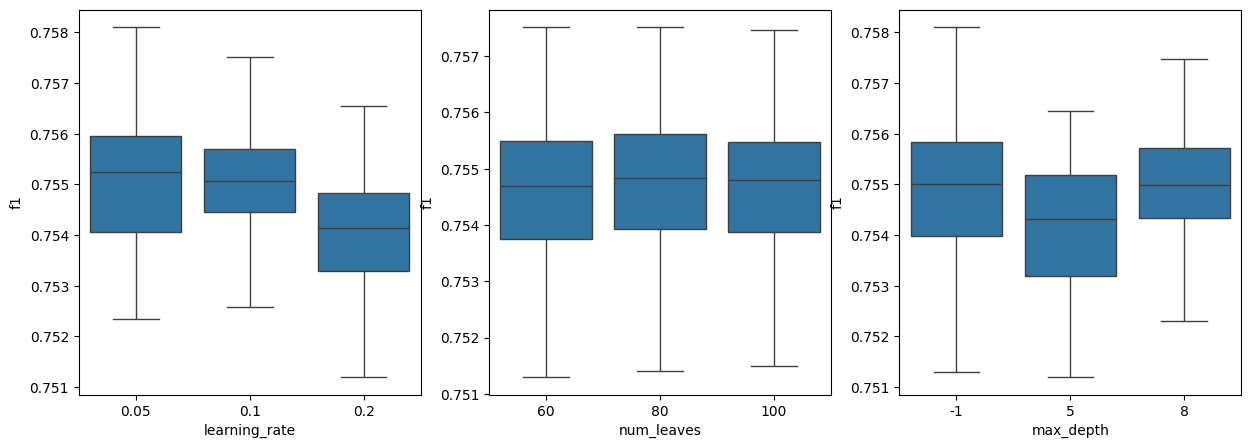

In [22]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

for i,param in enumerate(['learning_rate', 'num_leaves', 'max_depth']):
    sns.boxplot(df_results,x=param,y='f1',ax=axs[i],showfliers=False)

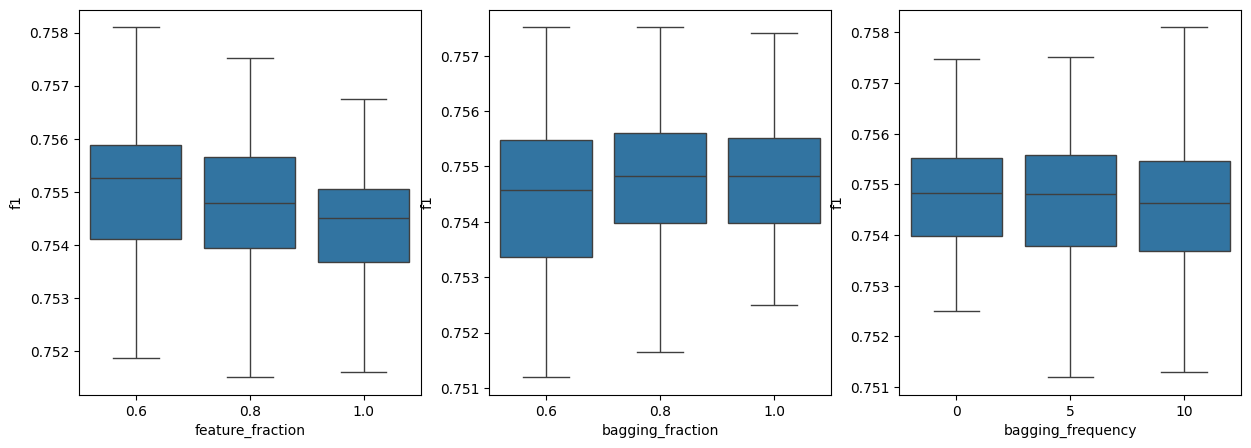

In [23]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

for i,param in enumerate(['feature_fraction', 'bagging_fraction', 'bagging_frequency']):
    sns.boxplot(df_results,x=param,y='f1',ax=axs[i],showfliers=False)

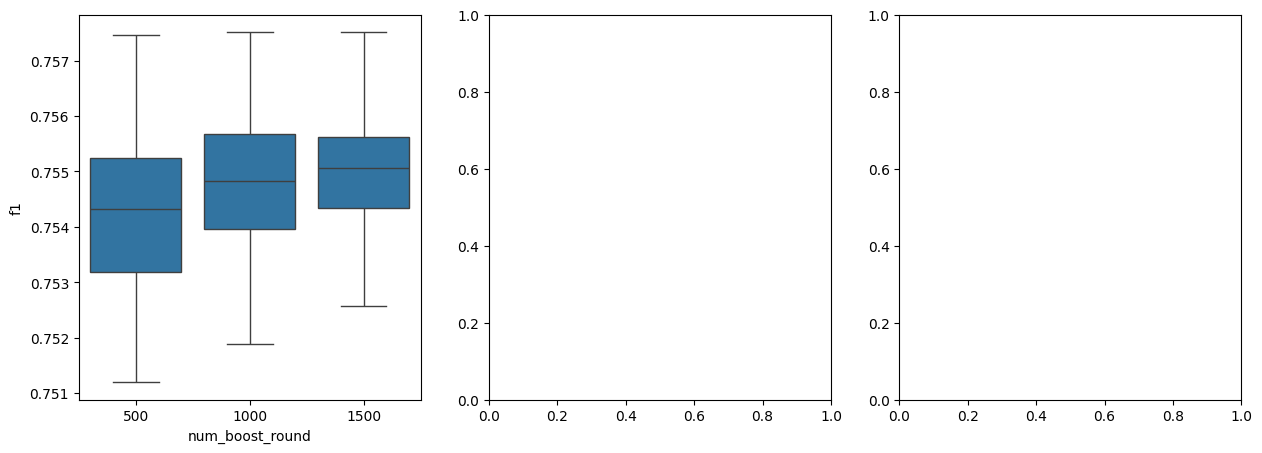

In [24]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

for i,param in enumerate(['num_boost_round']):
    sns.boxplot(df_results,x=param,y='f1',ax=axs[i],showfliers=False)

<Axes: xlabel='learning_rate', ylabel='f1'>

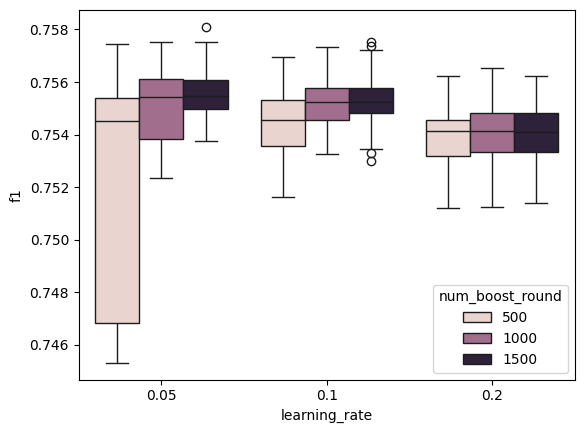

In [30]:
sns.boxplot(df_results,x='learning_rate',y='f1',hue='num_boost_round')

### Ordinal GBT

Does not work as well as the other three original models. and why does grade 2 have a cut off probability of 60%? probably not a good idea to use, adn messes with lightgbm installation

(Will it be helpful for ensembling though?)

In [9]:
# Get latent geo
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X_or = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, df_test_X_or,df_pred_X_or, df_train_y_or,df_val_y_or)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = preprocess(df_train_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_val_X = preprocess(df_val_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_test_X = preprocess(df_test_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_pred_X = preprocess(df_pred_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.09it/s]


Epoch [1/10], Loss: 8.711498858651286


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.70it/s]


Epoch [2/10], Loss: 0.6555737811682502


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 515.12it/s]


Epoch [3/10], Loss: 0.3443541481915384


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.34it/s]


Epoch [4/10], Loss: 0.2701751868815239


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.19it/s]


Epoch [5/10], Loss: 0.20143480645286932


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.74it/s]


Epoch [6/10], Loss: 0.17810723512530854


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 518.02it/s]


Epoch [7/10], Loss: 0.15687510637574678


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 513.50it/s]


Epoch [8/10], Loss: 0.14366001182335905


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 512.67it/s]


Epoch [9/10], Loss: 0.13982369140920742


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.23it/s]


Epoch [10/10], Loss: 0.10813623969340272


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1350.37it/s]


In [17]:
# Train lightgbm
categorical_features_lgb = []
for feat,dtype in df_train_X.dtypes.items():
    if dtype in ['int64','int32','object','category']:
        categorical_features_lgb.append(feat)
        
df_train_X[categorical_features_lgb] = df_train_X[categorical_features_lgb].astype('category')
df_val_X[categorical_features_lgb] = df_val_X[categorical_features_lgb].astype('category')
df_test_X[categorical_features_lgb] = df_test_X[categorical_features_lgb].astype('category')
df_pred_X[categorical_features_lgb] = df_pred_X[categorical_features_lgb].astype('category')

# train_val_data = lgb.Dataset(pd.concat([df_train_X,df_val_X],axis=0),
#                              label=pd.concat([df_train_y_or,df_val_y_or],axis=0)-1,
#                              categorical_feature=categorical_features_lgb)
# test_data = lgb.Dataset(df_test_X, label=df_test_y_or-1,
#                         categorical_feature=categorical_features_lgb,
#                         reference=train_val_data)

params = {
    'objective': 'multiclass',
    # 'num_class': 3,
    # 'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 80,
    'max_depth': 8,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'n_estimators':2000,
    # 'device':'gpu'
}

model_lgb_ord = LGBMOrdinal(**params)
model_lgb_ord.fit(df_train_X,np.squeeze((df_train_y_or-1).to_numpy())) # NOTE WARNING: made changes to original ordinalgbt script, commented out early stopping rounds

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


LGBMOrdinal(bagging_fraction=0.8, bagging_freq=5, feature_fraction=0.8,
            learning_rate=0.05, max_depth=8, n_estimators=2000, num_leaves=80,
            objective=<function LGBMOrdinal._lgb_loss_factory.<locals>.loss at 0x7965d36a5b20>,
            verbose=-1)

In [23]:
pred_lgb_ord = model_lgb_ord.predict(df_test_X)+1

# Evaluation
acc = accuracy_score(df_test_y_or, pred_lgb_ord)
f1 = f1_score(df_test_y_or,pred_lgb_ord,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')

Testing performance
Accuracy: 0.7477
F1-score: 0.7477


In [24]:
pred_lgb_ord = model_lgb_ord.predict(df_test_X)+1
pred_lgb_ord = pd.DataFrame(pred_lgb_ord)
pred_lgb_ord['Observed'] = df_test_y_or.to_numpy()
pred_lgb_ord.rename(columns={0:'Predicted'}, inplace=True)
pred_lgb_ord['Correct'] = pred_lgb_ord.apply(lambda row: int(row['Observed']==row['Predicted']),axis=1)
pred_lgb_ord_or = pred_lgb_ord.copy()

In [25]:
pred_lgb_ord = pd.concat([pred_lgb_ord.copy(),
                          pd.DataFrame(model_lgb_ord.predict_proba(df_test_X),columns=['prob_1','prob_2','prob_3'])],axis=1)

Text(0.5, 0, 'Probability')

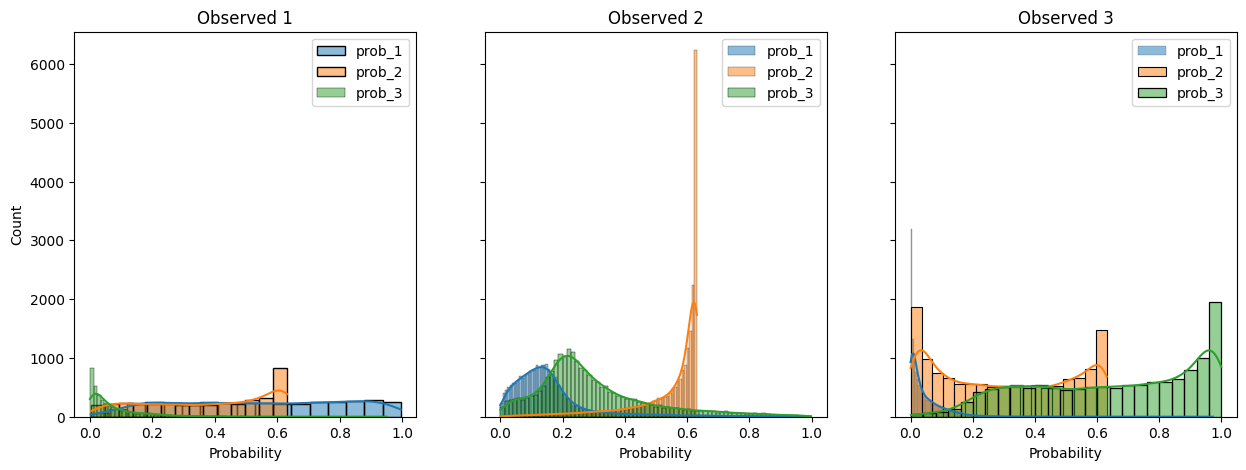

In [26]:
fig, axs = plt.subplots(1,3,figsize=(15,5), sharey=True)
# fig, axs = plt.subplots(1,3,figsize=(15,5))
sns.histplot(pred_lgb_ord[pred_lgb_ord['Observed']==1]['prob_1'], label='prob_1', kde=True, ax=axs[0])
sns.histplot(pred_lgb_ord[pred_lgb_ord['Observed']==1]['prob_2'], label='prob_2', kde=True, ax=axs[0])
sns.histplot(pred_lgb_ord[pred_lgb_ord['Observed']==1]['prob_3'], label='prob_3', kde=True, ax=axs[0])
axs[0].legend()
axs[0].set_title('Observed 1')
axs[0].set_xlabel('Probability')

sns.histplot(pred_lgb_ord[pred_lgb_ord['Observed']==2]['prob_1'], label='prob_1', kde=True, ax=axs[1])
sns.histplot(pred_lgb_ord[pred_lgb_ord['Observed']==2]['prob_2'], label='prob_2', kde=True, ax=axs[1])
sns.histplot(pred_lgb_ord[pred_lgb_ord['Observed']==2]['prob_3'], label='prob_3', kde=True, ax=axs[1])
axs[1].legend()
axs[1].set_title('Observed 2')
axs[1].set_xlabel('Probability')

sns.histplot(pred_lgb_ord[pred_lgb_ord['Observed']==3]['prob_1'], label='prob_1', kde=True, ax=axs[2])
sns.histplot(pred_lgb_ord[pred_lgb_ord['Observed']==3]['prob_2'], label='prob_2', kde=True, ax=axs[2])
sns.histplot(pred_lgb_ord[pred_lgb_ord['Observed']==3]['prob_3'], label='prob_3', kde=True, ax=axs[2])
axs[2].legend()
axs[2].set_title('Observed 3')
axs[2].set_xlabel('Probability')



In [27]:
pred_lgb_ord.groupby(['Observed','Predicted']).mean().drop(columns=['Correct'])

prob_1    prob_2    prob_3
Observed Predicted                              
1        1          0.741897  0.237859  0.020244
         2          0.277470  0.578405  0.144125
         3          0.026541  0.293175  0.680284
2        1          0.640225  0.329323  0.030452
         2          0.158720  0.595042  0.246238
         3          0.030396  0.327363  0.642241
3        1          0.644227  0.325713  0.030060
         2          0.114071  0.569223  0.316706
         3          0.015590  0.187175  0.797235

In [28]:
pred_lgb_ord.groupby(['Observed','Predicted']).count()[['prob_1']].rename(columns={'prob_1':'Count'})

Count
Observed Predicted       
1        1           2171
         2           1550
         3             48
2        1           1024
         2          17916
         3           3299
3        1             69
         2           3874
         3           9140

## playground

### optimal architecture for geo-encoding for regressor

In [11]:
df_temp500 = pd.read_csv('./kaggle_output_1/param_study_500.csv')
df_temp1000 = pd.read_csv('./kaggle_output_1/param_study_1000.csv')
df_temp1500 = pd.read_csv('./kaggle_output_1/param_study_1500.csv')
df_temp2000 = pd.read_csv('./kaggle_output_1/param_study_2000.csv')

df_temp500['iterations'] = 500
df_temp1000['iterations'] = 1000
df_temp1500['iterations'] = 1500
df_temp2000['iterations'] = 2000

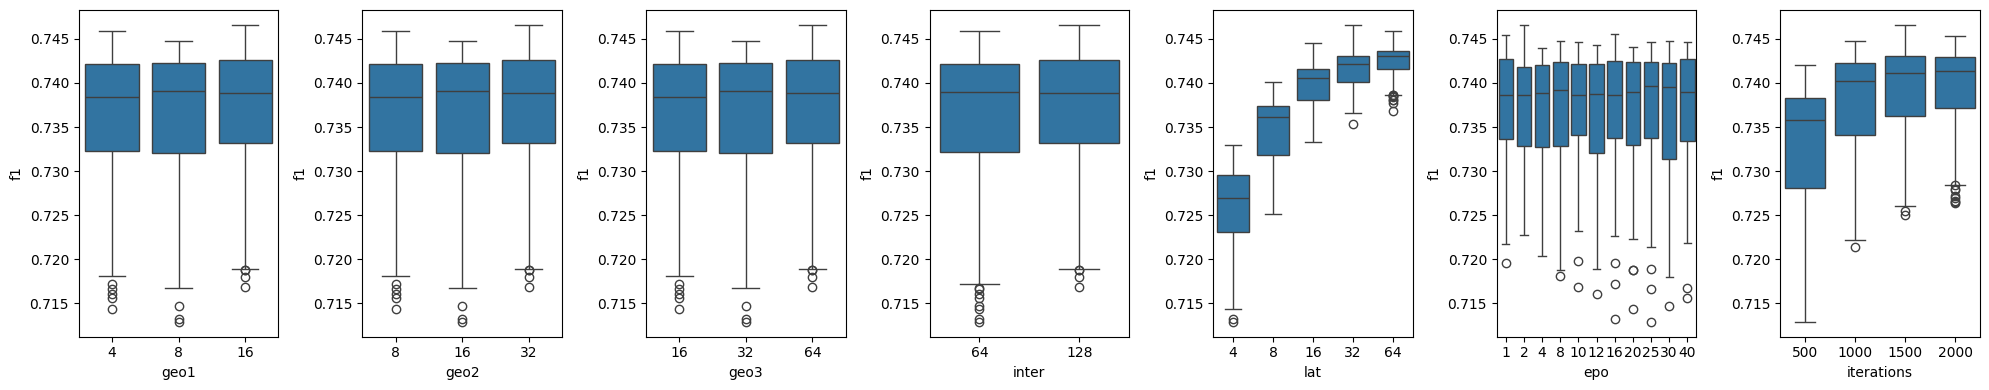

In [13]:
vars = ['geo1', 'geo2', 'geo3', 'inter', 'lat', 'epo','iterations']

fig,axs = plt.subplots(1,7,figsize=(20,4))

df_temp = pd.concat([df_temp500,df_temp1000, df_temp1500,df_temp2000],axis=0)

for i,var in enumerate(vars):
    sns.boxplot(df_temp,x=var,y='f1',ax=axs[i])
    # axs[i].set_title(var)
fig.tight_layout()

### visualize damage distribution

In [15]:
df_train_features = df_train_features_raw.copy()
df_train_labels = df_train_labels_raw.copy()
df_train = pd.concat([df_train_features,df_train_labels],axis=1)
non_geo_features = list(df_train.columns)
non_geo_features.remove('geo_level_1_id')
non_geo_features.remove('geo_level_2_id')
non_geo_features.remove('geo_level_3_id')
non_geo_features.remove('damage_grade')

non_geo_features_cat = list(df_train.columns)
non_geo_features_cat.remove('geo_level_1_id')
non_geo_features_cat.remove('geo_level_2_id')
non_geo_features_cat.remove('geo_level_3_id')
non_geo_features_cat.remove('damage_grade')
non_geo_features_cat.remove('count_floors_pre_eq')
non_geo_features_cat.remove('age')
non_geo_features_cat.remove('area_percentage')
non_geo_features_cat.remove('height_percentage')
non_geo_features_cat.remove('count_families')

non_geo_features_num = numerical_features

In [18]:
len(non_geo_features_cat)

30

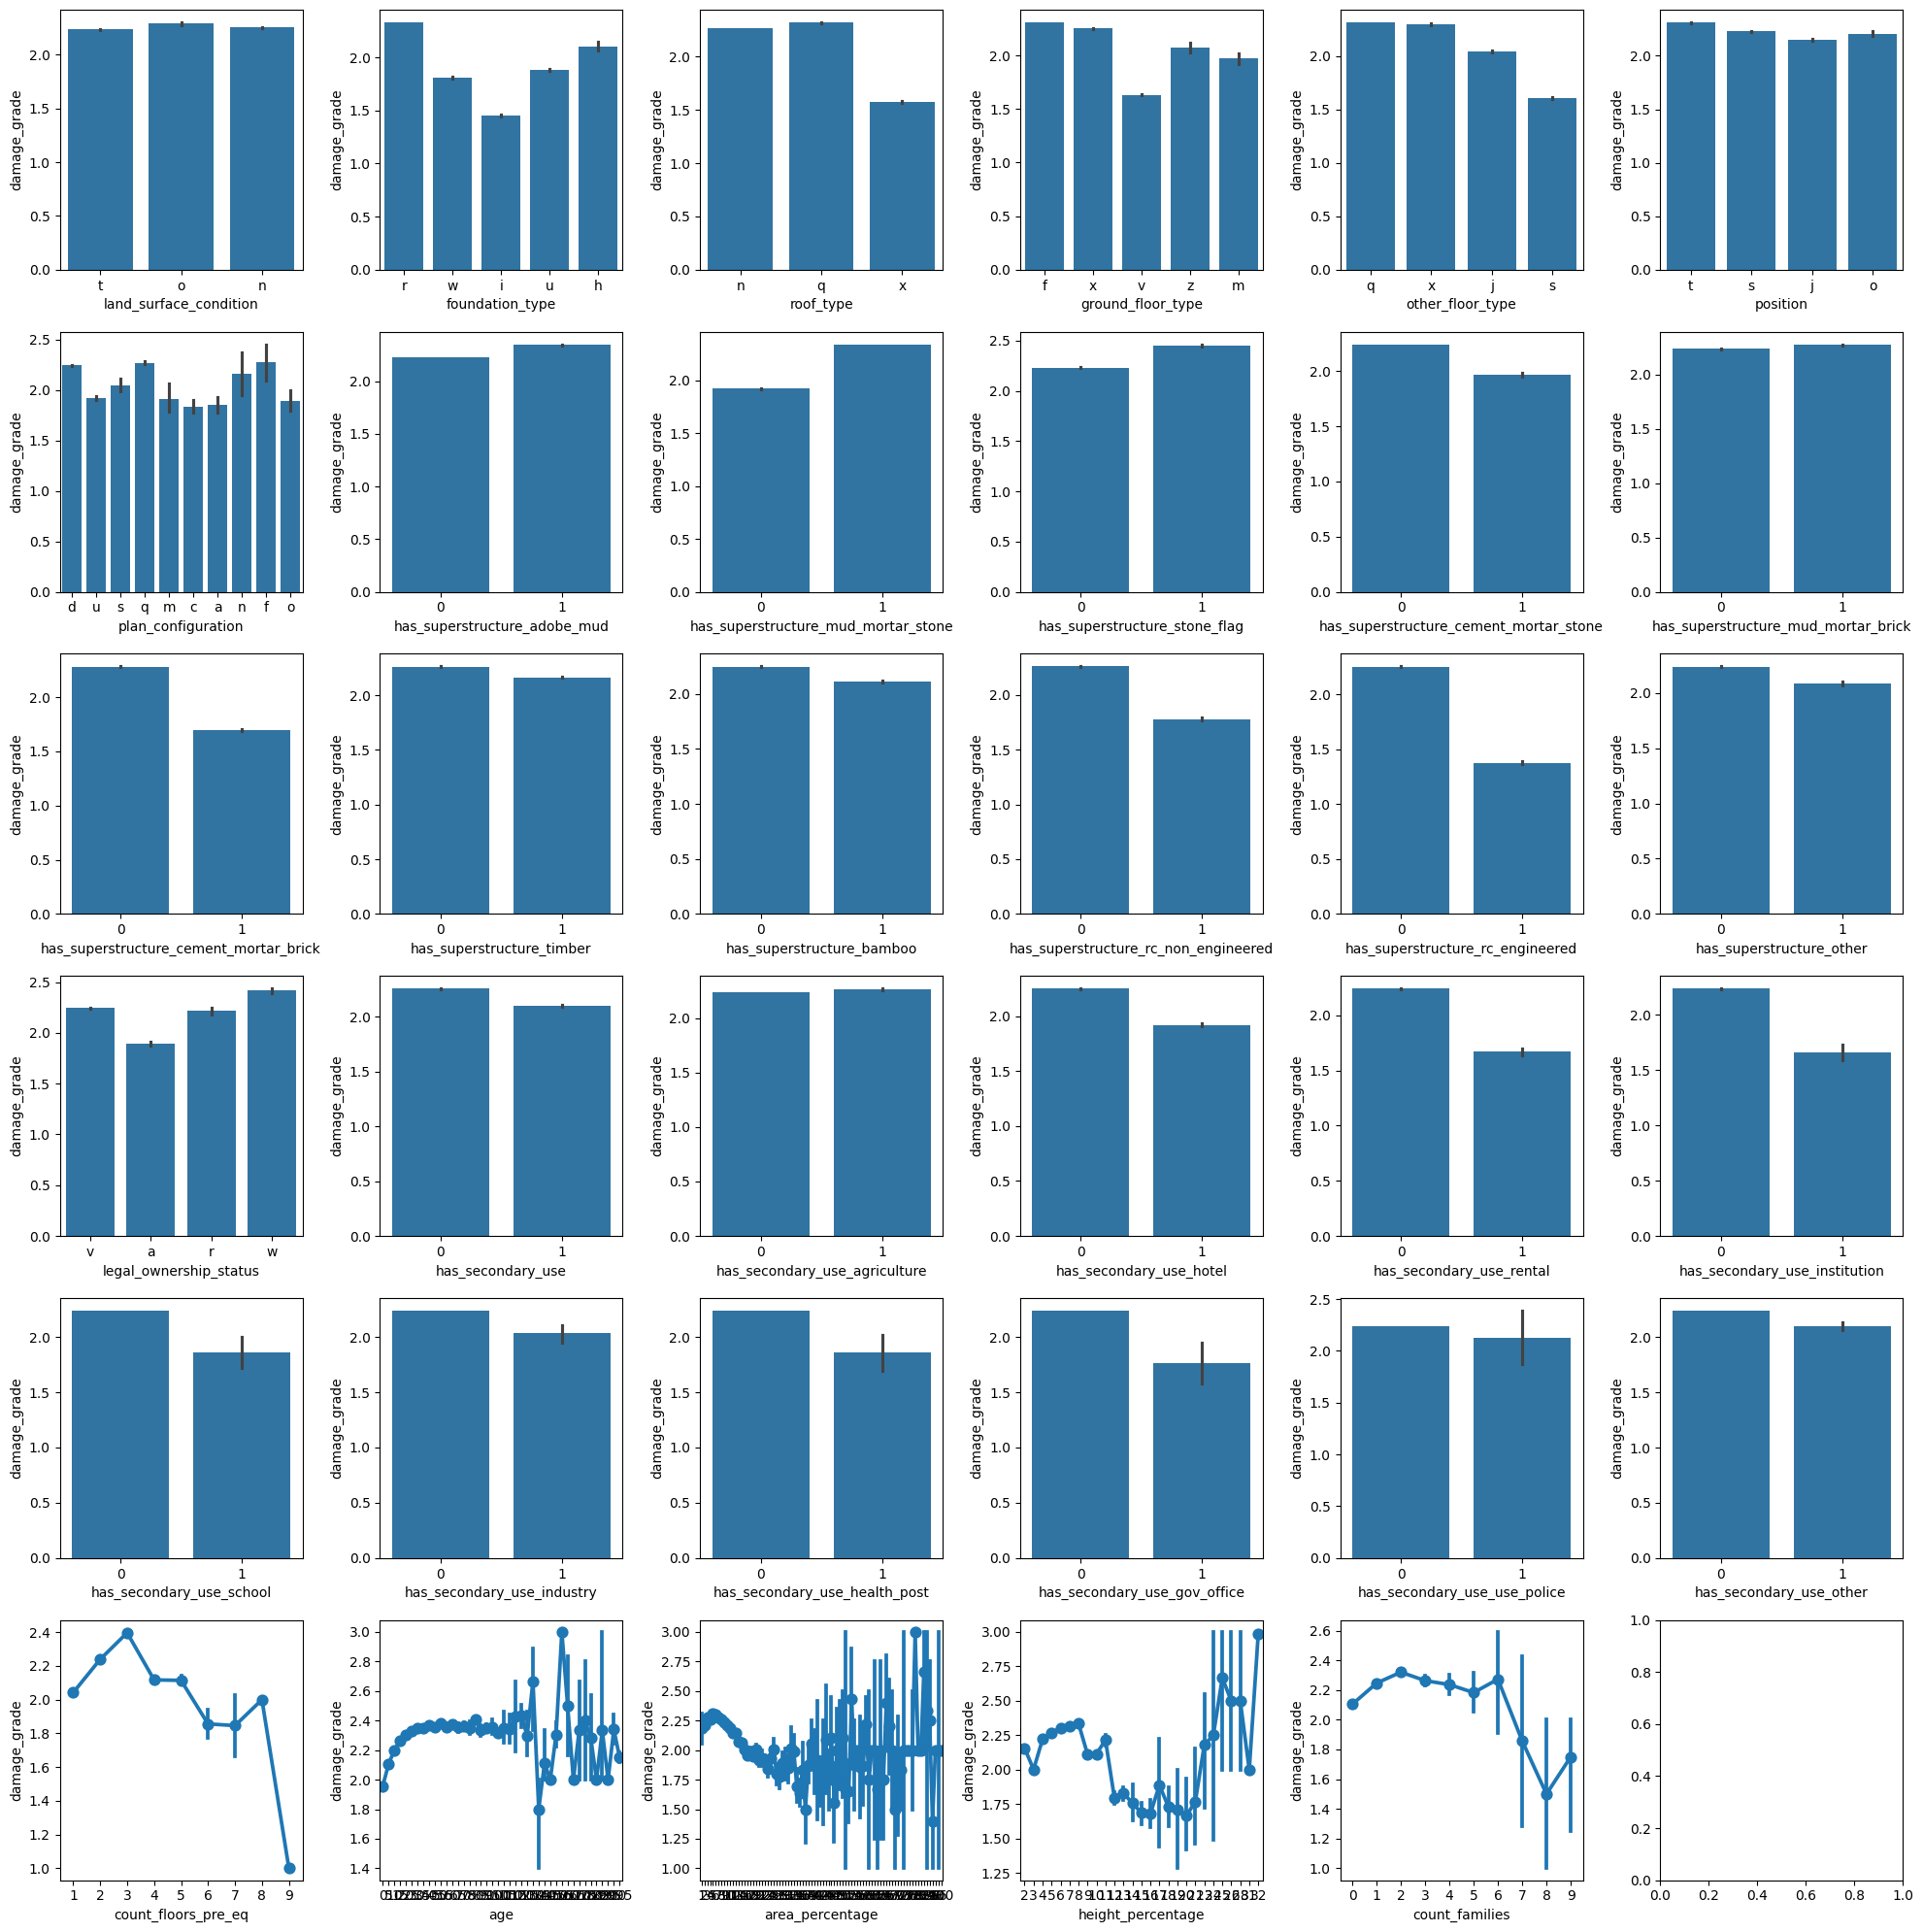

In [21]:
fig,axs = plt.subplots(6,6,figsize=(20,20))
axs = axs.flatten()

for i,feat in enumerate(non_geo_features_cat):
    sns.barplot(df_train,x=feat,y='damage_grade',ax=axs[i])

for i,feat in enumerate(non_geo_features_num):
    sns.pointplot(df_train,x=feat,y='damage_grade',ax=axs[i+30])

fig.tight_layout()

### CatBoost Classifier grid search results (do not delete)

In [9]:
# # Prep data for catboost vanilla
# categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
#                         'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
#                         'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
# geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
# numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# # Split into train, val, test and pred sets
# X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
# df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
# df_pred_X = df_pred_features_raw

# # Get imputed damage grade to prep for geo-encoding
# df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# # Set up architecture
# geo1_size = 16
# geo2_size = 32
# geo3_size = 64
# inter_size = 128
# latent_size = 64
# epochs = 10

# # Get latent geo-encoding
# latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
#                                               geo3_size, inter_size, latent_size, epochs)

# # Apply encoding
# df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
# df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
# df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
# df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# # Get categorical feature indices and names
# categorical_features_indices = []
# for i,dtype in enumerate(df_train_X.dtypes):
#     if dtype in ['int64','int32','object','category']:
#         categorical_features_indices.append(i)

# # Create pooled dataset following catboost requirements
# train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
# val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
# test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
# train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
#                             label=pd.concat([df_train_y,df_val_y],axis=0),
#                             cat_features=categorical_features_indices)
# train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
#                             label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
#                             cat_features=categorical_features_indices)

# # Instantiate catboost classifier model
# model = cb.CatBoostClassifier(
#     objective='MultiClass',  # Use 'MultiClass' for classification
#     task_type='GPU',  # Specify GPU if available
#     devices='0',  # Specify GPU device(s) if multiple
#     metric_period=500,  # Period to print metrics
#     iterations=1500,  # Number of boosting iterations
#     learning_rate=0.1,  # Learning rate
#     depth=8,  # Depth of the trees
#     l2_leaf_reg=5,  # L2 regularization coefficient
#     custom_metric=['Accuracy']  # Additional metrics to track
# )

# model.fit(train_val_dataset)

# # Evaluation
# pred = model.predict(df_test_X)
# acc = accuracy_score(df_test_y, pred)
# f1 = f1_score(df_test_y,pred,average='micro')

# print('Testing performance')
# print(f'Accuracy: {acc:.4f}')
# print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 350.21it/s]


Epoch [1/10], Loss: 6.600163797610638


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 356.63it/s]


Epoch [2/10], Loss: 0.48374449144033865


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 339.94it/s]


Epoch [3/10], Loss: 0.24243559833445938


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.17it/s]


Epoch [4/10], Loss: 0.18700860827387653


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 512.45it/s]


Epoch [5/10], Loss: 0.12352636000155218


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 501.03it/s]


Epoch [6/10], Loss: 0.11061015912651911


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 509.37it/s]


Epoch [7/10], Loss: 0.0813532055097403


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.47it/s]


Epoch [8/10], Loss: 0.07352680682960078


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.63it/s]


Epoch [9/10], Loss: 0.07798671771224248


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 517.50it/s]


Epoch [10/10], Loss: 0.06362848119729299


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1282.81it/s]


0:	learn: 1.0493145	total: 36.9ms	remaining: 55.3s
500:	learn: 0.5439285	total: 4.36s	remaining: 8.69s
1000:	learn: 0.5010738	total: 8.92s	remaining: 4.45s
1499:	learn: 0.4702863	total: 13.7s	remaining: 0us
Testing performance
Accuracy: 0.7537
F1-score: 0.7537


#### Param

In [35]:
# # Prep data for catboost vanilla
# categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
#                         'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
#                         'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
# geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
# numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# # Split into train, val, test and pred sets
# X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
# df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
# df_pred_X = df_pred_features_raw

# # Get imputed damage grade to prep for geo-encoding
# df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y)

# # Set up architecture
# geo1_size = 16
# geo2_size = 32
# geo3_size = 64
# inter_size = 128
# latent_size = 64
# epochs = 10

# # Get latent geo-encoding
# latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
#                                               geo3_size, inter_size, latent_size, epochs)

# # Apply encoding
# df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
# df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
# df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
# df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# # Get categorical feature indices and names
# categorical_features_indices = []
# for i,dtype in enumerate(df_train_X.dtypes):
#     if dtype in ['int64','int32','object','category']:
#         categorical_features_indices.append(i)

# # Create pooled dataset following catboost requirements
# train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
# val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
# test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
# train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
#                             label=pd.concat([df_train_y,df_val_y],axis=0),
#                             cat_features=categorical_features_indices)
# train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
#                             label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
#                             cat_features=categorical_features_indices)


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 502.43it/s]


Epoch [1/10], Loss: 6.786274392536357


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.49it/s]


Epoch [2/10], Loss: 0.4703299480165315


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 495.74it/s]


Epoch [3/10], Loss: 0.23153731363533347


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 490.74it/s]


Epoch [4/10], Loss: 0.15849117157687276


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.91it/s]


Epoch [5/10], Loss: 0.11779477193180762


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.91it/s]


Epoch [6/10], Loss: 0.10143693586892348


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.09it/s]


Epoch [7/10], Loss: 0.08769061563252602


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 392.84it/s]


Epoch [8/10], Loss: 0.07612350705578315


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 383.18it/s]


Epoch [9/10], Loss: 0.07711526649230502


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 358.76it/s]


Epoch [10/10], Loss: 0.0554945030653337


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1166.72it/s]


In [38]:
# counter = 0
# preds = []
# accs = []
# f1s = []
# iters = []
# learning_rates = []
# l2_leaf_regs = []
# depths = []

# for iterations in [1000,1250,1500,1750]:
#     for learning_rate in [0.05,0.1,0.15,0.2]:
#         for l2_leaf_reg in [0.1, 1, 5, 10,]:
#             for depth in [7,8,9]:
#                 counter += 1
#                 iters.append(iterations)
#                 learning_rates.append(learning_rate)
#                 l2_leaf_regs.append(l2_leaf_reg)
#                 depths.append(depth)

#                 print(f'\n\n Now running run {counter} of 192')
#                 # Instantiate catboost classifier model
#                 model = cb.CatBoostClassifier(
#                     objective='MultiClass',  # Use 'MultiClass' for classification
#                     task_type='GPU',  # Specify GPU if available
#                     devices='0',  # Specify GPU device(s) if multiple
#                     metric_period=500,  # Period to print metrics
#                     iterations=iterations,  # Number of boosting iterations
#                     learning_rate=learning_rate,  # Learning rate
#                     depth=depth,  # Depth of the trees
#                     l2_leaf_reg=l2_leaf_reg,  # L2 regularization coefficient
#                     custom_metric=['Accuracy']  # Additional metrics to track
#                 )

#                 model.fit(train_val_dataset)

#                 # Evaluation
#                 pred = model.predict(df_test_X)
#                 preds.append(pred)
#                 accs.append(accuracy_score(df_test_y, pred))
#                 f1s.append(f1_score(df_test_y,pred,average='micro'))



 Now running run 1 of 192
0:	learn: 1.0723174	total: 6.78ms	remaining: 6.78s
500:	learn: 0.6002206	total: 3.17s	remaining: 3.15s
999:	learn: 0.5567680	total: 6.46s	remaining: 0us


 Now running run 2 of 192
0:	learn: 1.0713787	total: 11.3ms	remaining: 11.3s
500:	learn: 0.5715376	total: 4.91s	remaining: 4.89s
999:	learn: 0.5224649	total: 9.76s	remaining: 0us


 Now running run 3 of 192
0:	learn: 1.0705250	total: 18.2ms	remaining: 18.2s
500:	learn: 0.5388607	total: 7.52s	remaining: 7.49s
999:	learn: 0.4802956	total: 15s	remaining: 0us


 Now running run 4 of 192
0:	learn: 1.0723619	total: 8.08ms	remaining: 8.07s
500:	learn: 0.6031583	total: 3.53s	remaining: 3.52s
999:	learn: 0.5607198	total: 6.95s	remaining: 0us


 Now running run 5 of 192
0:	learn: 1.0714640	total: 10.8ms	remaining: 10.8s
500:	learn: 0.5758937	total: 4.92s	remaining: 4.9s
999:	learn: 0.5314251	total: 9.71s	remaining: 0us


 Now running run 6 of 192
0:	learn: 1.0706801	total: 15.8ms	remaining: 15.8s
500:	learn: 0.54767

In [46]:
# catboost_classifier_results = pd.DataFrame({'iterations':iters,'learning_rate':learning_rates,'l2_leaf_reg':l2_leaf_regs,'depth':depths,'accuracy':accs,'f1-score':f1s})
# catboost_classifier_results

iterations  learning_rate  l2_leaf_reg  depth  accuracy  f1-score
0          1000           0.05          0.1      7  0.746489  0.746489
1          1000           0.05          0.1      8  0.750684  0.750684
2          1000           0.05          0.1      9  0.752628  0.752628
3          1000           0.05          1.0      7  0.745824  0.745824
4          1000           0.05          1.0      8  0.750045  0.750045
..          ...            ...          ...    ...       ...       ...
187        1750           0.20          5.0      8  0.752142  0.752142
188        1750           0.20          5.0      9  0.747947  0.747947
189        1750           0.20         10.0      7  0.751989  0.751989
190        1750           0.20         10.0      8  0.751784  0.751784
191        1750           0.20         10.0      9  0.750505  0.750505

[192 rows x 6 columns]

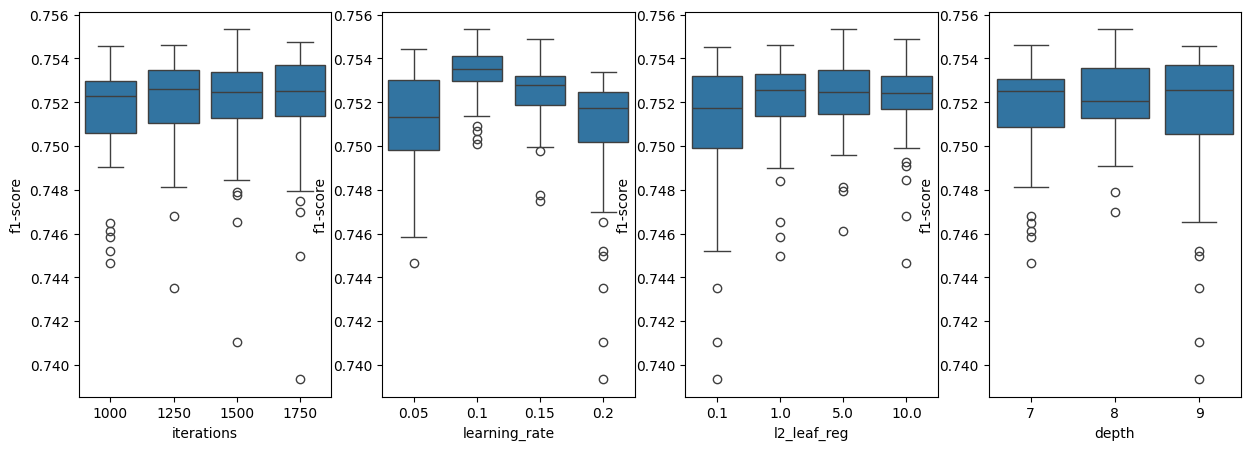

In [48]:
# fig, axs = plt.subplots(1,4,figsize=(15,5))

# for i,param in enumerate(['iterations','learning_rate','l2_leaf_reg','depth']):
#     sns.boxplot(catboost_classifier_results,x=param,y='f1-score',ax=axs[i])

<Axes: xlabel='learning_rate', ylabel='f1-score'>

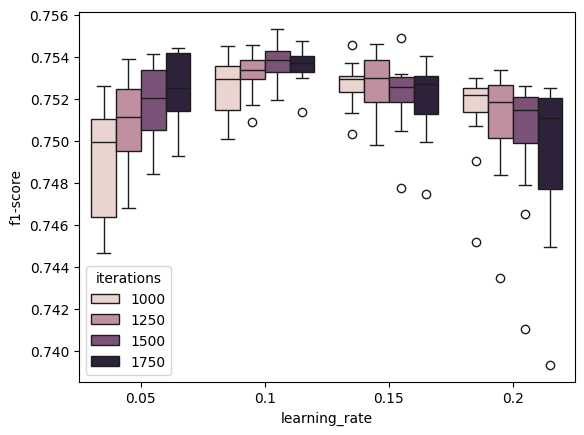

In [55]:
# sns.boxplot(catboost_classifier_results,x='learning_rate',y='f1-score',hue='iterations')

<Axes: xlabel='learning_rate', ylabel='f1-score'>

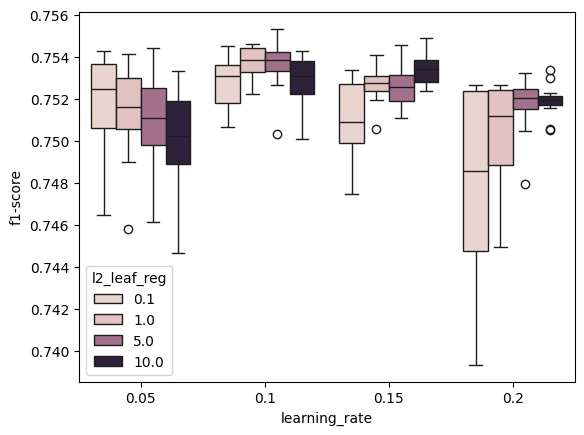

In [56]:
# sns.boxplot(catboost_classifier_results,x='learning_rate',y='f1-score',hue='l2_leaf_reg')

<Axes: xlabel='learning_rate', ylabel='f1-score'>

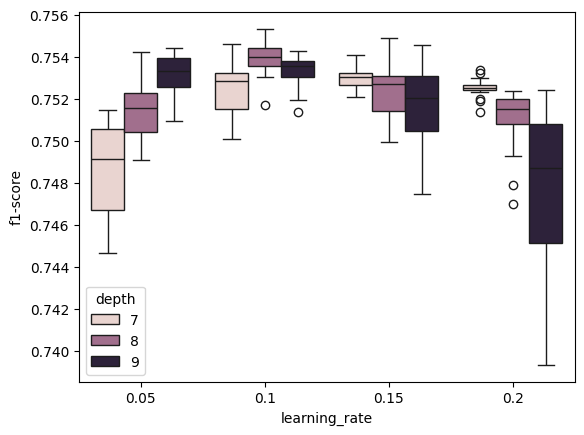

In [57]:
# sns.boxplot(catboost_classifier_results,x='learning_rate',y='f1-score',hue='depth')

In [53]:
# catboost_classifier_results.sort_values(by='f1-score',ascending=False).head(30)

iterations  learning_rate  l2_leaf_reg  depth  accuracy  f1-score
115        1500           0.10          5.0      8  0.755340  0.755340
130        1500           0.15         10.0      8  0.754905  0.754905
163        1750           0.10          5.0      8  0.754752  0.754752
159        1750           0.10          1.0      7  0.754624  0.754624
82         1250           0.15         10.0      8  0.754598  0.754598
64         1250           0.10          1.0      8  0.754573  0.754573
32         1000           0.15          5.0      9  0.754547  0.754547
13         1000           0.10          0.1      8  0.754522  0.754522
111        1500           0.10          1.0      7  0.754445  0.754445
112        1500           0.10          1.0      8  0.754419  0.754419
152        1750           0.05          5.0      9  0.754419  0.754419
146        1750           0.05          0.1      9  0.754291  0.754291
19         1000           0.10          5.0      8  0.754266  0.754266
119        1500           0.10         10.0      9  0.754266  0.754266
65         1250           0.10          1.0      9  0.754240  0.754240
162        1750           0.10          5.0      7  0.754215  0.754215
145        1750           0.05          0.1      8  0.754215  0.754215
20         1000           0.10          5.0      9  0.754189  0.754189
101        1500           0.05          1.0      9  0.754163  0.754163
149        1750           0.05          1.0      9  0.754163  0.754163
67         1250           0.10          5.0      8  0.754087  0.754087
75         1250           0.15          1.0      7  0.754087  0.754087
178        1750           0.15         10.0      8  0.754061  0.754061
118        1500           0.10         10.0      8  0.754035  0.754035
80         1250           0.15          5.0      9  0.754010  0.754010
160        1750           0.10          1.0      8  0.753984  0.753984
167        1750           0.10         10.0      9  0.753959  0.753959
109        1500           0.10          0.1      8  0.753959  0.753959
56         1250           0.05          5.0      9  0.753908  0.753908
50         1250           0.05          0.1      9  0.753780  0.753780

### CatBoost classifier false pos and neg analysis

In [55]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X_or = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, df_test_X_or,df_pred_X_or, df_train_y_or,df_val_y_or)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_val_X = df_val_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_test_X = df_test_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_pred_X = df_pred_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=5000,  # Period to print metrics
    iterations=15000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 513.58it/s]


Epoch [1/10], Loss: 8.296214470368247


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.45it/s]


Epoch [2/10], Loss: 0.575468236177238


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.12it/s]


Epoch [3/10], Loss: 0.29768627822201627


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.93it/s]


Epoch [4/10], Loss: 0.2453080419346756


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 507.72it/s]


Epoch [5/10], Loss: 0.20641167163409962


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 495.07it/s]


Epoch [6/10], Loss: 0.16368358536995126


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 519.08it/s]


Epoch [7/10], Loss: 0.14948210461731776


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.00it/s]


Epoch [8/10], Loss: 0.15468143900809742


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.53it/s]


Epoch [9/10], Loss: 0.10510288273561773


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 515.50it/s]


Epoch [10/10], Loss: 0.13087406047566386


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1363.31it/s]


0:	learn: 1.0931288	total: 9.67ms	remaining: 2m 24s
5000:	learn: 0.5428653	total: 43.5s	remaining: 1m 26s
10000:	learn: 0.4993538	total: 1m 26s	remaining: 43.1s
14999:	learn: 0.4684012	total: 2m 10s	remaining: 0us
Testing performance
Accuracy: 0.7560
F1-score: 0.7560


#### General analysis and quick checks

In [56]:
df_test_X_cls = df_test_X.copy()
df_test_y_cls = df_test_y.copy()

pred_cls = model_cls.predict(df_test_X_cls)
pred_cls = pd.DataFrame(pred_cls)
pred_cls['Observed'] = df_test_y_cls.to_numpy()
pred_cls.rename(columns={0:'Predicted'}, inplace=True)
pred_cls['Correct'] = pred_cls.apply(lambda row: int(row['Observed']==row['Predicted']),axis=1)
pred_cls_or = pred_cls.copy()

In [57]:
pred_cls = pd.concat([pred_cls_or.copy(),pd.DataFrame(model_cls.predict_proba(df_test_X_cls),columns=['prob_1','prob_2','prob_3'])],axis=1)

Text(0.5, 0, 'Probability')

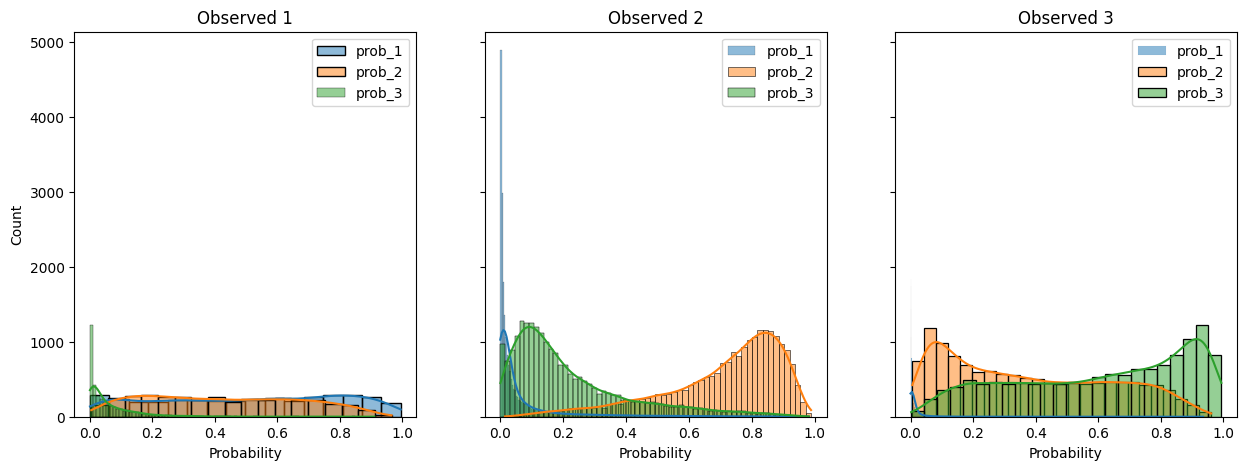

In [58]:
fig, axs = plt.subplots(1,3,figsize=(15,5), sharey=True)
# fig, axs = plt.subplots(1,3,figsize=(15,5))
sns.histplot(pred_cls[pred_cls['Observed']==1]['prob_1'], label='prob_1', kde=True, ax=axs[0])
sns.histplot(pred_cls[pred_cls['Observed']==1]['prob_2'], label='prob_2', kde=True, ax=axs[0])
sns.histplot(pred_cls[pred_cls['Observed']==1]['prob_3'], label='prob_3', kde=True, ax=axs[0])
axs[0].legend()
axs[0].set_title('Observed 1')
axs[0].set_xlabel('Probability')

sns.histplot(pred_cls[pred_cls['Observed']==2]['prob_1'], label='prob_1', kde=True, ax=axs[1])
sns.histplot(pred_cls[pred_cls['Observed']==2]['prob_2'], label='prob_2', kde=True, ax=axs[1])
sns.histplot(pred_cls[pred_cls['Observed']==2]['prob_3'], label='prob_3', kde=True, ax=axs[1])
axs[1].legend()
axs[1].set_title('Observed 2')
axs[1].set_xlabel('Probability')

sns.histplot(pred_cls[pred_cls['Observed']==3]['prob_1'], label='prob_1', kde=True, ax=axs[2])
sns.histplot(pred_cls[pred_cls['Observed']==3]['prob_2'], label='prob_2', kde=True, ax=axs[2])
sns.histplot(pred_cls[pred_cls['Observed']==3]['prob_3'], label='prob_3', kde=True, ax=axs[2])
axs[2].legend()
axs[2].set_title('Observed 3')
axs[2].set_xlabel('Probability')



In [59]:
pred_cls.groupby(['Observed','Predicted']).mean().drop(columns=['Correct'])

prob_1    prob_2    prob_3
Observed Predicted                              
1        1          0.732220  0.241034  0.026746
         2          0.230008  0.667850  0.102142
         3          0.072313  0.283403  0.644284
2        1          0.637258  0.328541  0.034201
         2          0.056546  0.768331  0.175123
         3          0.008569  0.340197  0.651234
3        1          0.637738  0.282541  0.079722
         2          0.033916  0.685049  0.281035
         3          0.005178  0.211768  0.783053

In [60]:
pred_cls.groupby(['Observed','Predicted']).count()[['prob_1']].rename(columns={'prob_1':'Count'})

Count
Observed Predicted       
1        1           2078
         2           1643
         3             48
2        1            816
         2          18996
         3           2427
3        1             69
         2           4534
         3           8480

In [61]:
def get_new_pred(row,thresh):
    if np.argmax(row[['prob_1','prob_2','prob_3']])==0:
        return 1
    elif np.argmax(row[['prob_1','prob_2','prob_3']])==2:
        return 3
    else:
        if row['prob_2'] < thresh:
            if row['prob_1'] > row['prob_3']:
                return 1
            else:
                return 3
        else:
            return 2

In [62]:
pred_cls['Predicted_0.35'] = pred_cls.apply(lambda row: get_new_pred(row, 0.35), axis=1)
pred_cls['Predicted_0.35_correct'] = (pred_cls['Predicted_0.35'] == pred_cls['Observed']).astype(int)

pred_cls['Predicted_0.4'] = pred_cls.apply(lambda row: get_new_pred(row, 0.4), axis=1)
pred_cls['Predicted_0.4_correct'] = (pred_cls['Predicted_0.4'] == pred_cls['Observed']).astype(int)

pred_cls['Predicted_0.45'] = pred_cls.apply(lambda row: get_new_pred(row, 0.45), axis=1)
pred_cls['Predicted_0.45_correct'] = (pred_cls['Predicted_0.45'] == pred_cls['Observed']).astype(int)

pred_cls['Predicted_0.5'] = pred_cls.apply(lambda row: get_new_pred(row, 0.5), axis=1)
pred_cls['Predicted_0.5_correct'] = (pred_cls['Predicted_0.5'] == pred_cls['Observed']).astype(int)

pred_cls['Predicted_0.55'] = pred_cls.apply(lambda row: get_new_pred(row, 0.55), axis=1)
pred_cls['Predicted_0.55_correct'] = (pred_cls['Predicted_0.55'] == pred_cls['Observed']).astype(int)

pred_cls['Predicted_0.6'] = pred_cls.apply(lambda row: get_new_pred(row, 0.6), axis=1)
pred_cls['Predicted_0.6_correct'] = (pred_cls['Predicted_0.6'] == pred_cls['Observed']).astype(int)

pred_cls['Predicted_0.65'] = pred_cls.apply(lambda row: get_new_pred(row, 0.65), axis=1)
pred_cls['Predicted_0.65_correct'] = (pred_cls['Predicted_0.65'] == pred_cls['Observed']).astype(int)

pred_cls['Predicted_0.7'] = pred_cls.apply(lambda row: get_new_pred(row, 0.7), axis=1)
pred_cls['Predicted_0.7_correct'] = (pred_cls['Predicted_0.7'] == pred_cls['Observed']).astype(int)


In [63]:
pred_cls[[col for col in pred_cls.columns if 'orrect' in col]].sum()

Correct                   29554
Predicted_0.35_correct    29554
Predicted_0.4_correct     29557
Predicted_0.45_correct    29543
Predicted_0.5_correct     29507
Predicted_0.55_correct    29381
Predicted_0.6_correct     29097
Predicted_0.65_correct    28493
Predicted_0.7_correct     27536
dtype: int64

Looks like there's no point playing with threshold directly. but what if we look at relative values of prob 1 vs prob 3?

In [64]:
def get_new_pred2(row):
    if np.argmax(row[['prob_1','prob_2','prob_3']])==0:
        return 1
    elif np.argmax(row[['prob_1','prob_2','prob_3']])==2:
        return 3
    else:
        if row['prob_1'] > 5000*row['prob_3']:
            return 1
        elif row['prob_3'] > 5000*row['prob_1']:
            return 3
        else:
            return 2
pred_cls['Predicted_compare13'] = pred_cls.apply(lambda row: get_new_pred2(row), axis=1)
pred_cls['Predicted_compare13_correct'] = (pred_cls['Predicted_compare13'] == pred_cls['Observed']).astype(int)
pred_cls[[col for col in pred_cls.columns if 'orrect' in col]].sum()

Correct                        29554
Predicted_0.35_correct         29554
Predicted_0.4_correct          29557
Predicted_0.45_correct         29543
Predicted_0.5_correct          29507
Predicted_0.55_correct         29381
Predicted_0.6_correct          29097
Predicted_0.65_correct         28493
Predicted_0.7_correct          27536
Predicted_compare13_correct    29554
dtype: int64

Looks like it doesn't make a difference either. Prepping dataframe for further analysis below.

#### In-depth analysis

In [65]:
df_train_X_2 = df_train_X.copy()
df_train_X_2['dataset'] = 'train'
df_val_X_2 = df_val_X.copy()
df_val_X_2['dataset'] = 'val'
df_test_X_2 = df_test_X.copy()
df_test_X_2['dataset'] = 'test'

pred_cls_2 = pd.concat([df_train_X_2, df_val_X_2, df_test_X_2],axis=0)
pred_cls_2_geo_or = pd.concat([df_train_X_or[geo_features],df_val_X_or[geo_features],df_test_X_or[geo_features]],axis=0)
pred_cls_2 = pd.concat([pred_cls_2,pred_cls_2_geo_or],axis=1)
pred_cls_2['prediction'] = np.squeeze(np.vstack([model_cls.predict(df_train_X),model_cls.predict(df_val_X),model_cls.predict(df_test_X)]))
pred_cls_2['observation'] = np.hstack([np.squeeze(df_train_y.to_numpy()), np.squeeze(df_val_y.to_numpy()), np.squeeze(df_test_y.to_numpy())])
pred_cls_2['correct'] = pred_cls_2['prediction'] == pred_cls_2['observation']

In [66]:
# Get accuracy of different groups using model
pred_cls_2[['dataset','correct']].groupby('dataset').mean()

correct
dataset          
test     0.756031
train    0.796365
val      0.794354

In [67]:
pred_cls_2_3v2_confusion = pred_cls_2.loc[(pred_cls_2['observation']==3) & \
    (pred_cls_2['prediction'].isin([2,3]))]

In [68]:
df_train_features = df_train_features_raw.copy()
df_train_labels = df_train_labels_raw.copy()
df_train = pd.concat([df_train_features,df_train_labels],axis=1)
non_geo_features = list(df_train.columns)
non_geo_features.remove('geo_level_1_id')
non_geo_features.remove('geo_level_2_id')
non_geo_features.remove('geo_level_3_id')
non_geo_features.remove('damage_grade')

non_geo_features_cat = list(df_train.columns)
non_geo_features_cat.remove('geo_level_1_id')
non_geo_features_cat.remove('geo_level_2_id')
non_geo_features_cat.remove('geo_level_3_id')
non_geo_features_cat.remove('damage_grade')
non_geo_features_cat.remove('count_floors_pre_eq')
non_geo_features_cat.remove('age')
non_geo_features_cat.remove('area_percentage')
non_geo_features_cat.remove('height_percentage')
non_geo_features_cat.remove('count_families')

non_geo_features_num = numerical_features

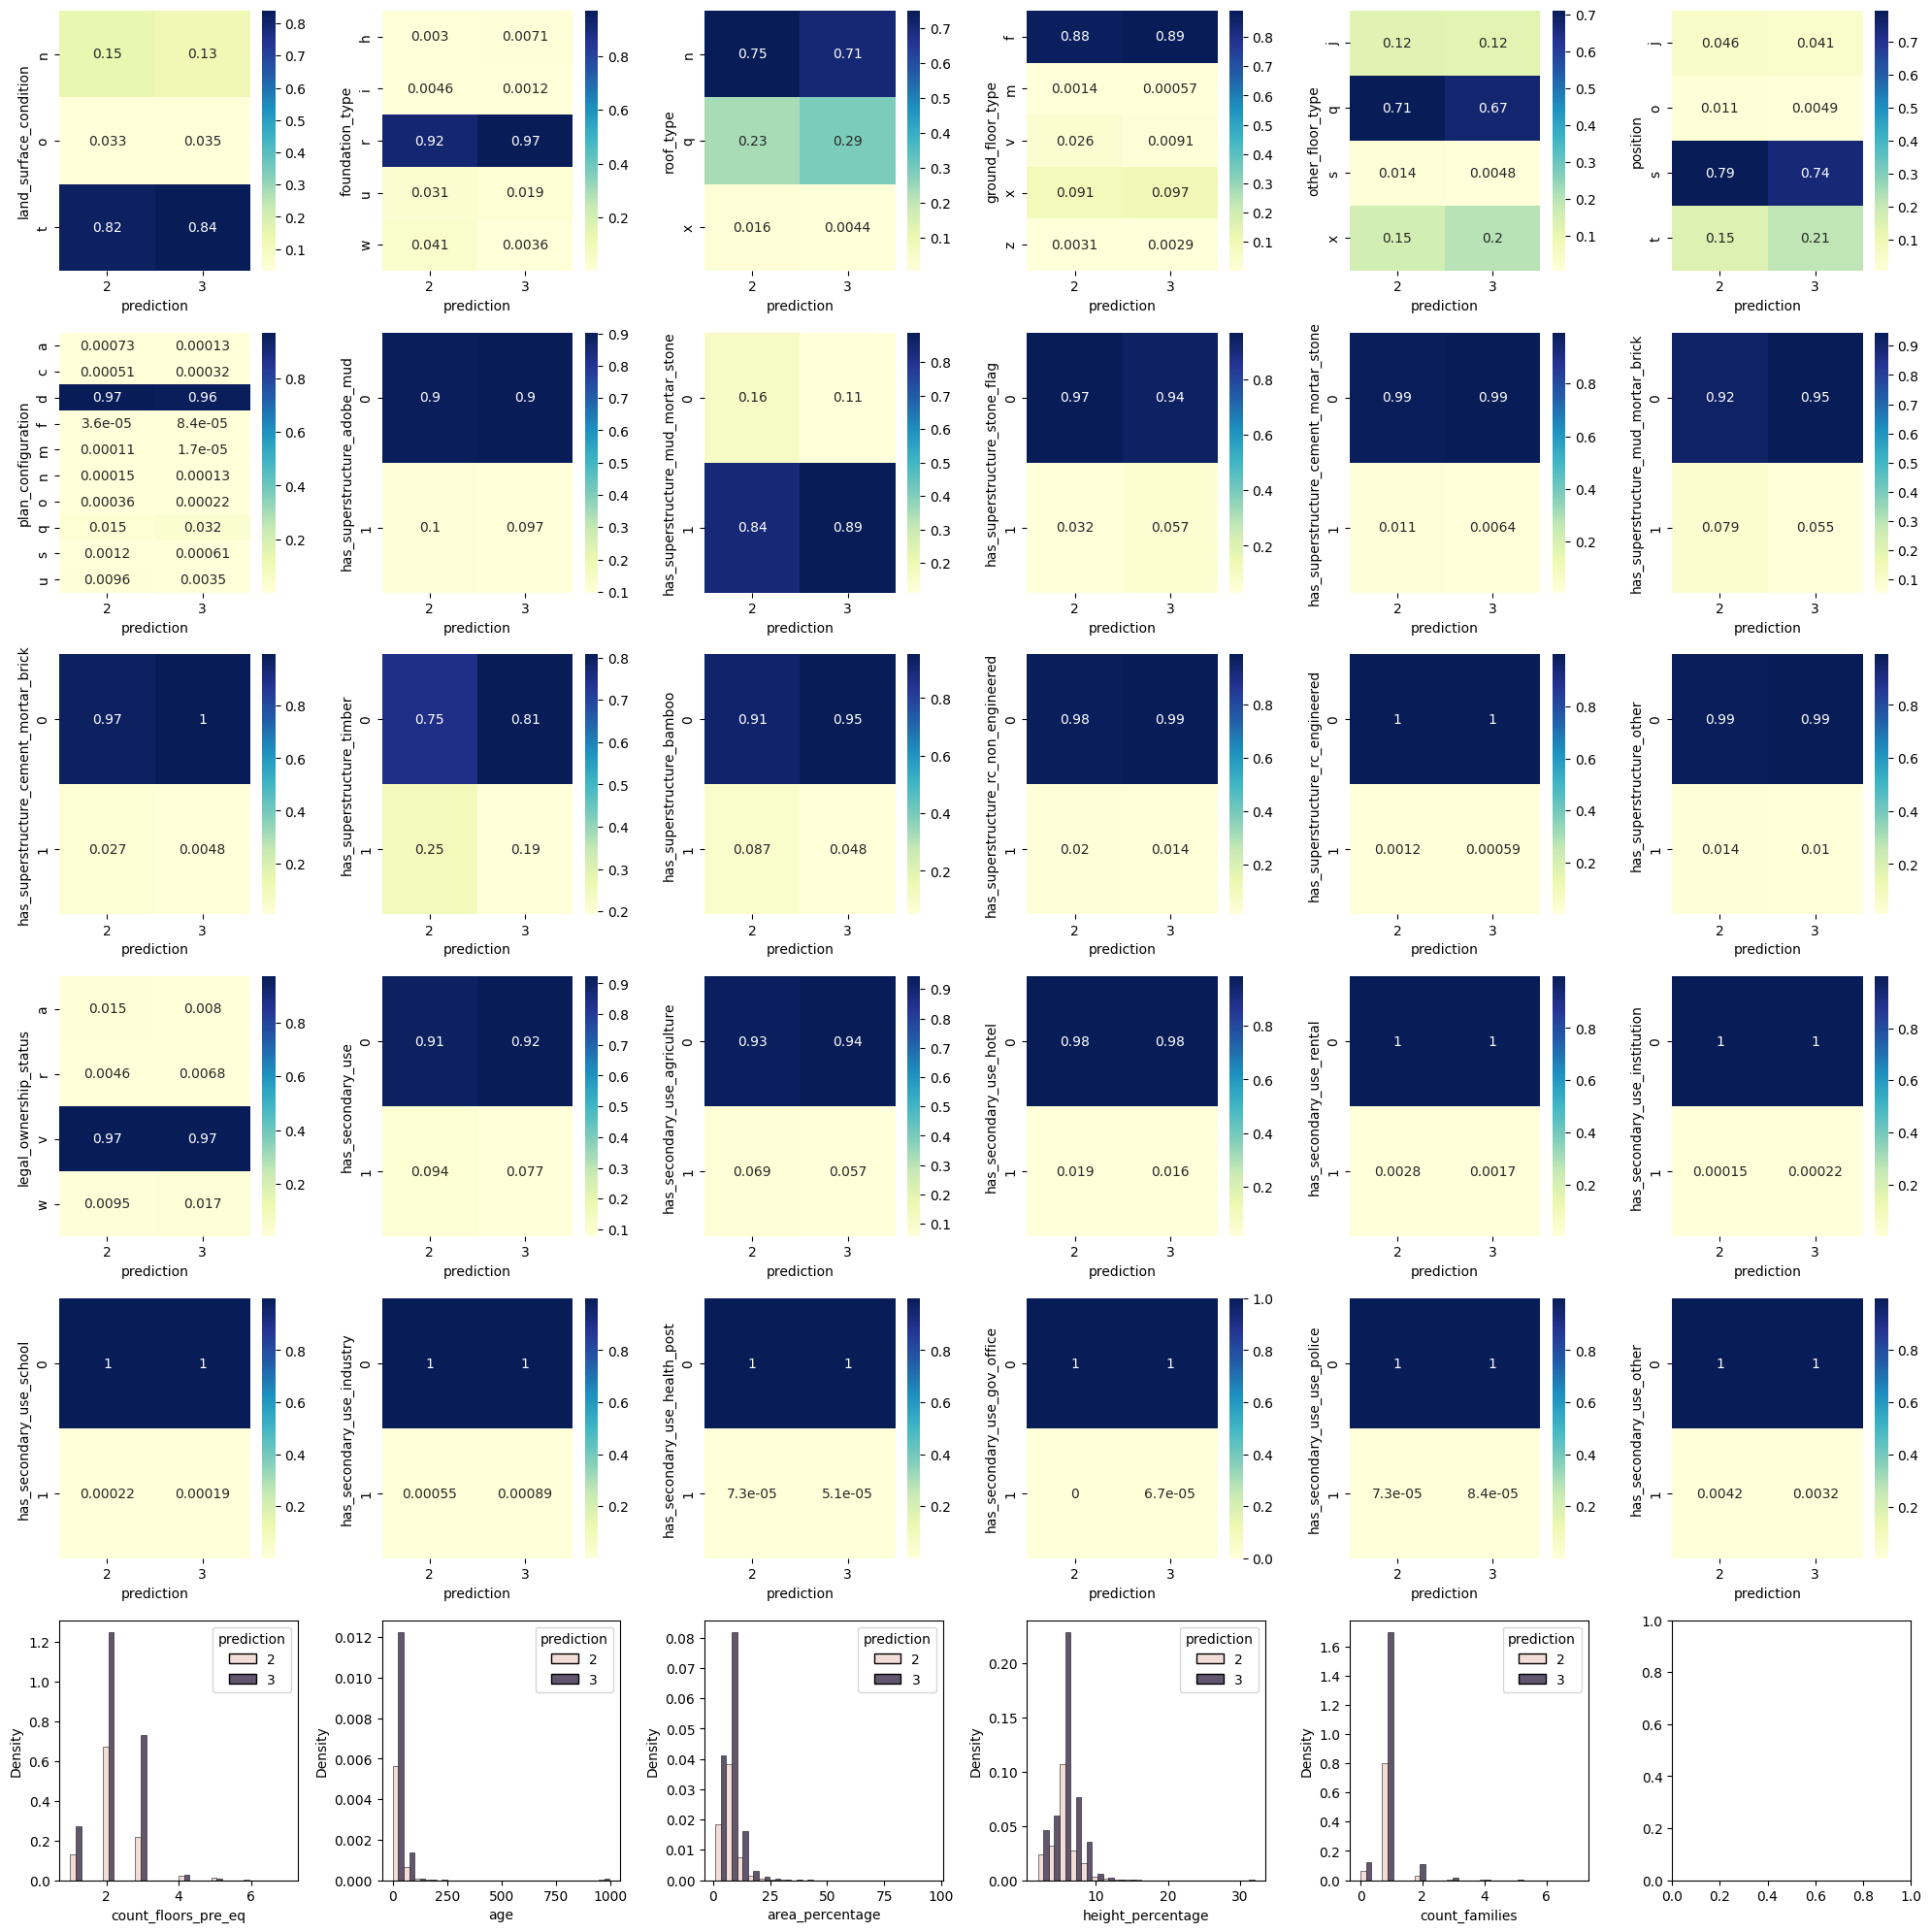

In [69]:
fig,axs = plt.subplots(6,6,figsize=(20,20))
axs = axs.flatten()

for i,feat in enumerate(non_geo_features_cat):
    crosstab = pd.crosstab(pred_cls_2_3v2_confusion[feat],pred_cls_2_3v2_confusion['prediction'])
    crosstab = crosstab.div(crosstab.sum(axis=0), axis=1)
    sns.heatmap(crosstab, annot=True, cmap='YlGnBu',ax=axs[i])

for i,feat in enumerate(non_geo_features_num):
    sns.histplot(pred_cls_2_3v2_confusion,x=feat,hue='prediction',multiple='dodge', bins=20,stat='density',ax=axs[i+30])

fig.tight_layout()

data points for damage_grade=3 cases predicted as grades 2 and 3 do indeed look very similar.

### CatBoost classifier with optuna (sub9)

In [71]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X_or = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, df_test_X_or,df_pred_X_or, df_train_y_or,df_val_y_or)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_val_X = df_val_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_test_X = df_test_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_pred_X = df_pred_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.29it/s]


Epoch [1/10], Loss: 8.512366891697335


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 529.39it/s]


Epoch [2/10], Loss: 0.6083804776505273


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.96it/s]


Epoch [3/10], Loss: 0.3263979006739709


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 525.50it/s]


Epoch [4/10], Loss: 0.23164279900480264


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.80it/s]


Epoch [5/10], Loss: 0.20950236832873897


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 534.84it/s]


Epoch [6/10], Loss: 0.17627689569628907


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 501.15it/s]


Epoch [7/10], Loss: 0.1280859228722828


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.66it/s]


Epoch [8/10], Loss: 0.13628751924467192


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.24it/s]


Epoch [9/10], Loss: 0.11844106850424159


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.85it/s]


Epoch [10/10], Loss: 0.10356175859043147


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1333.94it/s]


In [75]:
def objective(trial):
    # Define the hyperparameters to be tuned
    params = {
        'iterations': trial.suggest_int('iterations', 10000, 20000),
        'depth': trial.suggest_int('depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'border_count': trial.suggest_int('border_count', 32, 128),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide'])
    }

    # Train the model with the suggested hyperparameters
    model = cb.CatBoostClassifier(**params, 
                               objective='MultiClass', 
                               eval_metric='Accuracy',
                               task_type='GPU',  # Specify GPU if available
                               devices='0',  # Specify GPU device(s) if multiple
                               verbose=0)
    

    model.fit(train_val_dataset, eval_set=test_dataset, early_stopping_rounds=50, use_best_model=True)

    # Make predictions on the validation set
    y_pred = model.predict(df_test_X)
    accuracy = accuracy_score(df_test_y_or, y_pred)
    
    return accuracy

# Create the study and optimize it
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best parameters and best accuracy
print("Best parameters: ", study.best_params)
print("Best accuracy: ", study.best_value)


[I 2024-07-15 21:15:04,527] A new study created in memory with name: no-name-331bf9be-537c-45cd-8f82-9c74e2b18523
[I 2024-07-15 21:15:28,046] Trial 0 finished with value: 0.6983960502417437 and parameters: {'iterations': 16801, 'depth': 6, 'learning_rate': 0.0036562355596434803, 'l2_leaf_reg': 1.830519098487072, 'bagging_temperature': 5.132376630135887, 'random_strength': 2.0473223291230367, 'border_count': 97, 'grow_policy': 'Lossguide'}. Best is trial 0 with value: 0.6983960502417437.
[I 2024-07-15 21:17:37,539] Trial 1 finished with value: 0.7403238597119541 and parameters: {'iterations': 12552, 'depth': 12, 'learning_rate': 0.005408409467849354, 'l2_leaf_reg': 6.685623937033058, 'bagging_temperature': 8.569189105504826, 'random_strength': 1.5240835483907598, 'border_count': 80, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 0.7403238597119541.
[I 2024-07-15 21:17:44,515] Trial 2 finished with value: 0.713770433092016 and parameters: {'iterations': 19859, 'depth': 5, '

Best parameters:  {'iterations': 13997, 'depth': 11, 'learning_rate': 0.06909872486194824, 'l2_leaf_reg': 1.4636561316205772, 'bagging_temperature': 0.036230624915015844, 'random_strength': 0.8724695202475963, 'border_count': 51, 'grow_policy': 'Depthwise'}
Best accuracy:  0.7562866132869458


In [77]:
# Train final model
model_cls = cb.CatBoostClassifier(**study.best_params, 
                            objective='MultiClass', 
                            eval_metric='Accuracy',
                            task_type='GPU',  # Specify GPU if available
                            devices='0',  # Specify GPU device(s) if multiple
                            verbose=0)
with open('optuna_catboost_classifier_1.pkl', 'wb') as f:
    pickle.dump(model_cls, f)

In [78]:
with open('optuna_catboost_classifier_study_1.pkl', 'wb') as f:
    pickle.dump(study, f)

### CatBoost classifier vs regressor

In [55]:
# # df_test_X_cls = df_test_X.copy()
# # df_test_y_cls = df_test_y.copy()

# # df_test_X_reg = df_test_X.copy()
# # df_test_y_reg = df_test_y.copy()

# pred_reg = model_reg.predict(df_test_X_reg)
# pred_reg = np.round(np.clip(pred_reg,1,3))
# pred_cls = model_cls.predict(df_test_X_cls)

# pred_reg = pd.DataFrame(pred_reg)
# pred_reg['Observed'] = df_test_y_reg.to_numpy()
# pred_reg.rename(columns={0:'Predicted'}, inplace=True)
# pred_reg['Correct'] = pred_reg.apply(lambda row: int(row['Observed']==row['Predicted']),axis=1)

# pred_cls = pd.DataFrame(pred_cls)
# pred_cls['Observed'] = df_test_y_reg.to_numpy()
# pred_cls.rename(columns={0:'Predicted'}, inplace=True)
# pred_cls['Correct'] = pred_cls.apply(lambda row: int(row['Observed']==row['Predicted']),axis=1)

# pred_cls_or = pred_cls.copy()
# pred_reg_or = pred_reg.copy()

In [59]:
pred_cls = pred_cls_or.copy()
pred_reg = pred_reg_or.copy()

In [63]:
pred_cls.sum()

Predicted    86233
Observed     87496
Correct      29550
dtype: int64

In [61]:
pred_reg.sum()

Predicted    86531.0
Observed     87496.0
Correct      29396.0
dtype: float64

In [80]:
pred_both = pd.concat([pred_reg,pred_cls],axis=1)

In [81]:
pred_both.sum()

Predicted    86531.0
Observed     87496.0
Correct      29396.0
Predicted    86233.0
Observed     87496.0
Correct      29550.0
dtype: float64

In [82]:
# Where they both get it right
(pred_both.iloc[:,2]*pred_both.iloc[:,5]).sum()

28183

In [83]:
# Where at least one of them gets it right
((pred_both.iloc[:,2]+pred_both.iloc[:,5])>0).sum()

30763

Doesn't look like they can compensate for each other, looks like they're mostly making mistakes in the same places.

In [87]:
# Where they both got it wrong
pred_both.loc[(pred_both.iloc[:,2]+pred_both.iloc[:,5])==0].count()

Predicted    8328
Observed     8328
Correct      8328
Predicted    8328
Observed     8328
Correct      8328
dtype: int64

In [ ]:
pred_both.loc[(pred_both.iloc[:,2]+pred_both.iloc[:,5])==0].count()

### CatBoost Classifier Geo-encoded Class Imbalance


Looked at first like there were too many predictions for damage grade 2, so i thought reducing class weight for that damage grade might help. results worse after applying.

In [87]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 32
geo2_size = 64
geo3_size = 64
inter_size = 128
latent_size = 128
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=1500,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy'],  # Additional metrics to track
    # class_weights=[1,0.9,1],              # Applying class weights directly
    auto_class_weights = 'SqrtBalanced'     # Letting catboost apply class weights. Takes None, Balanced, or SqrtBalanced
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')

Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 305.67it/s]


Epoch [1/10], Loss: 5.670066128269562


Epoch 2/10: 100%|██████████| 1358/1358 [00:05<00:00, 264.35it/s]


Epoch [2/10], Loss: 0.4480889922005175


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 273.69it/s]


Epoch [3/10], Loss: 0.2377047146394827


Epoch 4/10: 100%|██████████| 1358/1358 [00:05<00:00, 261.45it/s]


Epoch [4/10], Loss: 0.17438089455421657


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 273.58it/s]


Epoch [5/10], Loss: 0.14448054942037686


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 337.67it/s]


Epoch [6/10], Loss: 0.10837726033737112


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 376.09it/s]


Epoch [7/10], Loss: 0.09806993570170518


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 341.47it/s]


Epoch [8/10], Loss: 0.08894104251783103


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 354.79it/s]


Epoch [9/10], Loss: 0.07577921242373604


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 374.37it/s]


Epoch [10/10], Loss: 0.0705292359750712


Evaluating: 100%|██████████| 2715/2715 [00:03<00:00, 895.43it/s] 


0:	learn: 1.0566137	total: 13.5ms	remaining: 20.2s
500:	learn: 0.5597947	total: 5.94s	remaining: 11.8s
1000:	learn: 0.5101940	total: 11.9s	remaining: 5.94s
1499:	learn: 0.4736950	total: 18s	remaining: 0us
Testing performance
Accuracy: 0.7461
F1-score: 0.7461


### Check distribution of eval score from multiple runs - latent size check

checking for optimal latent size

In [16]:
accs_128 = []
f1s_128 = []

for i in range(20):
    # Prep data for catboost vanilla
    categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                            'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                            'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
    geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
    numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

    # Split into train, val, test and pred sets
    X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
    df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
    df_pred_X = df_pred_features_raw

    # Get imputed damage grade to prep for geo-encoding
    df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

    # Set up architecture
    geo1_size = 32
    geo2_size = 64
    geo3_size = 64
    inter_size = 128
    latent_size = 128
    epochs = 10

    # Get latent geo-encoding
    latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                                geo3_size, inter_size, latent_size, epochs)

    # Apply encoding
    df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
    df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
    df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
    df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

    df_train_X.drop(columns=geo_features, inplace=True)
    df_val_X.drop(columns=geo_features, inplace=True)
    df_test_X.drop(columns=geo_features, inplace=True)
    df_pred_X.drop(columns=geo_features, inplace=True)

    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_train_X.dtypes):
        if dtype in ['int64','int32','object','category']:
            categorical_features_indices.append(i)

    # Create pooled dataset following catboost requirements
    train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
    val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
    test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
    train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y],axis=0),
                                cat_features=categorical_features_indices)
    train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                                cat_features=categorical_features_indices)

    # Instantiate catboost classifier model
    model_cls = cb.CatBoostClassifier(
        objective='MultiClass',  # Use 'MultiClass' for classification
        task_type='GPU',  # Specify GPU if available
        devices='0',  # Specify GPU device(s) if multiple
        metric_period=500,  # Period to print metrics
        iterations=1500,  # Number of boosting iterations
        learning_rate=0.1,  # Learning rate
        depth=8,  # Depth of the trees
        l2_leaf_reg=5,  # L2 regularization coefficient
        custom_metric=['Accuracy'],  # Additional metrics to track
        class_weights=[1,1,1],
    )

    model_cls.fit(train_val_dataset)

    # Evaluation
    pred = model_cls.predict(df_test_X)
    acc = accuracy_score(df_test_y, pred)
    f1 = f1_score(df_test_y,pred,average='micro')

    accs_128.append(acc)
    f1s_128.append(f1)

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.53it/s]


Epoch [1/10], Loss: 5.9372975059918


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.36it/s]


Epoch [2/10], Loss: 0.45609843494461105


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.64it/s]


Epoch [3/10], Loss: 0.22071248383037692


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.55it/s]


Epoch [4/10], Loss: 0.1739668364530986


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 490.33it/s]


Epoch [5/10], Loss: 0.12307196492720149


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.41it/s]


Epoch [6/10], Loss: 0.10159663076389756


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 397.69it/s]


Epoch [7/10], Loss: 0.10299048774148062


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 330.77it/s]


Epoch [8/10], Loss: 0.08090904862467345


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 286.83it/s]


Epoch [9/10], Loss: 0.07362011063905516


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 329.61it/s]


Epoch [10/10], Loss: 0.06667449178280181


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1219.16it/s]


0:	learn: 1.0472779	total: 13.7ms	remaining: 20.5s
500:	learn: 0.5387109	total: 5.63s	remaining: 11.2s
1000:	learn: 0.4975482	total: 10.9s	remaining: 5.46s
1499:	learn: 0.4676548	total: 16.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.12it/s]


Epoch [1/10], Loss: 5.777127456353409


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.42it/s]


Epoch [2/10], Loss: 0.39804986837170525


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 412.77it/s]


Epoch [3/10], Loss: 0.2175501848383092


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 340.70it/s]


Epoch [4/10], Loss: 0.15383716704960315


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 307.34it/s]


Epoch [5/10], Loss: 0.12417108377058399


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 321.05it/s]


Epoch [6/10], Loss: 0.10907395432901394


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 374.32it/s]


Epoch [7/10], Loss: 0.09644818346157384


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.44it/s]


Epoch [8/10], Loss: 0.07551867753311522


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 407.35it/s]


Epoch [9/10], Loss: 0.08457573607013785


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 371.09it/s]


Epoch [10/10], Loss: 0.0590642569227766


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1367.53it/s]


0:	learn: 1.0474440	total: 12.7ms	remaining: 19s
500:	learn: 0.5385059	total: 5.25s	remaining: 10.5s
1000:	learn: 0.4971132	total: 10.4s	remaining: 5.16s
1499:	learn: 0.4666955	total: 15.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 305.77it/s]


Epoch [1/10], Loss: 5.748394175420278


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 312.69it/s]


Epoch [2/10], Loss: 0.41639012016290156


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 386.12it/s]


Epoch [3/10], Loss: 0.1946444532646083


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.69it/s]


Epoch [4/10], Loss: 0.16526440385659122


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 398.06it/s]


Epoch [5/10], Loss: 0.11298084216787643


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 344.41it/s]


Epoch [6/10], Loss: 0.1150774218225015


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.01it/s]


Epoch [7/10], Loss: 0.07726152127943672


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.74it/s]


Epoch [8/10], Loss: 0.0862234840424154


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.29it/s]


Epoch [9/10], Loss: 0.0753229103811169


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 504.09it/s]


Epoch [10/10], Loss: 0.06765159498531555


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1375.75it/s]


0:	learn: 1.0494946	total: 12.8ms	remaining: 19.2s
500:	learn: 0.5395975	total: 5.48s	remaining: 10.9s
1000:	learn: 0.4972162	total: 11s	remaining: 5.49s
1499:	learn: 0.4664425	total: 16.4s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 490.11it/s]


Epoch [1/10], Loss: 5.60647187161428


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.08it/s]


Epoch [2/10], Loss: 0.407928674826083


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.07it/s]


Epoch [3/10], Loss: 0.20826186849673956


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.88it/s]


Epoch [4/10], Loss: 0.154620980354923


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.65it/s]


Epoch [5/10], Loss: 0.12478102866693266


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.83it/s]


Epoch [6/10], Loss: 0.11691251922699188


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.14it/s]


Epoch [7/10], Loss: 0.09915028730272253


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 401.63it/s]


Epoch [8/10], Loss: 0.07601712907260538


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 320.16it/s]


Epoch [9/10], Loss: 0.06565193998618278


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 385.96it/s]


Epoch [10/10], Loss: 0.07468007218998113


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1303.68it/s]


0:	learn: 1.0455712	total: 13.2ms	remaining: 19.7s
500:	learn: 0.5395935	total: 5.5s	remaining: 11s
1000:	learn: 0.4976339	total: 10.6s	remaining: 5.3s
1499:	learn: 0.4670677	total: 15.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.79it/s]


Epoch [1/10], Loss: 5.878411259935601


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 318.40it/s]


Epoch [2/10], Loss: 0.4445011835265493


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 357.19it/s]


Epoch [3/10], Loss: 0.21585761602907627


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 442.12it/s]


Epoch [4/10], Loss: 0.15259955618777402


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.82it/s]


Epoch [5/10], Loss: 0.12177926773241061


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 421.31it/s]


Epoch [6/10], Loss: 0.10130491235073305


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.60it/s]


Epoch [7/10], Loss: 0.08354779334873612


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.96it/s]


Epoch [8/10], Loss: 0.08308224741778225


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.28it/s]


Epoch [9/10], Loss: 0.07903289552745


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.20it/s]


Epoch [10/10], Loss: 0.06454174124875102


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1373.23it/s]


0:	learn: 1.0458448	total: 12ms	remaining: 18s
500:	learn: 0.5373153	total: 5.49s	remaining: 10.9s
1000:	learn: 0.4946252	total: 11.2s	remaining: 5.58s
1499:	learn: 0.4644252	total: 16.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 485.11it/s]


Epoch [1/10], Loss: 5.655673431279206


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.15it/s]


Epoch [2/10], Loss: 0.4376500557795365


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.59it/s]


Epoch [3/10], Loss: 0.23324973317924805


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 507.43it/s]


Epoch [4/10], Loss: 0.17720247003275885


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.91it/s]


Epoch [5/10], Loss: 0.13440071414389396


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.30it/s]


Epoch [6/10], Loss: 0.09538111016936106


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.74it/s]


Epoch [7/10], Loss: 0.09421982183683504


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 388.72it/s]


Epoch [8/10], Loss: 0.090491839761699


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 377.42it/s]


Epoch [9/10], Loss: 0.06716068759416566


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.31it/s]


Epoch [10/10], Loss: 0.07442166856300622


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1304.74it/s]


0:	learn: 1.0473275	total: 11.6ms	remaining: 17.4s
500:	learn: 0.5381862	total: 5.11s	remaining: 10.2s
1000:	learn: 0.4966050	total: 9.89s	remaining: 4.93s
1499:	learn: 0.4662706	total: 14.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.24it/s]


Epoch [1/10], Loss: 5.921266848564324


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 335.41it/s]


Epoch [2/10], Loss: 0.4255400270015133


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 377.15it/s]


Epoch [3/10], Loss: 0.23320208750637755


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.21it/s]


Epoch [4/10], Loss: 0.16409426376351124


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.47it/s]


Epoch [5/10], Loss: 0.12417617668836639


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 391.59it/s]


Epoch [6/10], Loss: 0.10479165018510089


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 495.32it/s]


Epoch [7/10], Loss: 0.08736740761264727


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.70it/s]


Epoch [8/10], Loss: 0.07715272756225865


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.19it/s]


Epoch [9/10], Loss: 0.07430106610433844


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 501.65it/s]


Epoch [10/10], Loss: 0.07456851262252984


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1371.99it/s]


0:	learn: 1.0472333	total: 12.3ms	remaining: 18.5s
500:	learn: 0.5376945	total: 5.41s	remaining: 10.8s
1000:	learn: 0.4956194	total: 10.8s	remaining: 5.4s
1499:	learn: 0.4652754	total: 16.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 370.00it/s]


Epoch [1/10], Loss: 5.795875140137982


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 353.64it/s]


Epoch [2/10], Loss: 0.43114671818857164


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 343.66it/s]


Epoch [3/10], Loss: 0.2320637263478341


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 354.53it/s]


Epoch [4/10], Loss: 0.17661327818430556


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 362.90it/s]


Epoch [5/10], Loss: 0.11967451844277993


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 401.47it/s]


Epoch [6/10], Loss: 0.1152147096722347


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 431.30it/s]


Epoch [7/10], Loss: 0.0868058073902242


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 351.61it/s]


Epoch [8/10], Loss: 0.07244953390720762


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 359.16it/s]


Epoch [9/10], Loss: 0.07751082866159453


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.54it/s]


Epoch [10/10], Loss: 0.07916246398452129


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1363.68it/s]


0:	learn: 1.0452810	total: 12.3ms	remaining: 18.5s
500:	learn: 0.5383669	total: 5.32s	remaining: 10.6s
1000:	learn: 0.4966885	total: 10.5s	remaining: 5.24s
1499:	learn: 0.4664466	total: 15.9s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 401.84it/s]


Epoch [1/10], Loss: 5.741664840695784


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 394.53it/s]


Epoch [2/10], Loss: 0.4265342252507301


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 392.18it/s]


Epoch [3/10], Loss: 0.22797502330415204


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 349.86it/s]


Epoch [4/10], Loss: 0.15429005528071865


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 344.01it/s]


Epoch [5/10], Loss: 0.13350225999383517


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 341.14it/s]


Epoch [6/10], Loss: 0.10636817312278868


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 337.99it/s]


Epoch [7/10], Loss: 0.08478124531528423


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 347.18it/s]


Epoch [8/10], Loss: 0.08680432761779476


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 439.97it/s]


Epoch [9/10], Loss: 0.08088388119787197


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 359.08it/s]


Epoch [10/10], Loss: 0.07768888874996155


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1137.06it/s]


0:	learn: 1.0474519	total: 15.3ms	remaining: 23s
500:	learn: 0.5381293	total: 5.39s	remaining: 10.7s
1000:	learn: 0.4963128	total: 10.6s	remaining: 5.29s
1499:	learn: 0.4669057	total: 15.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.56it/s]


Epoch [1/10], Loss: 5.8646714574985195


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 405.31it/s]


Epoch [2/10], Loss: 0.43249571291573446


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 380.62it/s]


Epoch [3/10], Loss: 0.23964553544454179


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 389.12it/s]


Epoch [4/10], Loss: 0.158466478491501


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 329.29it/s]


Epoch [5/10], Loss: 0.13248749158759388


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 319.85it/s]


Epoch [6/10], Loss: 0.09393366900377595


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 349.03it/s]


Epoch [7/10], Loss: 0.09837787082989388


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 302.97it/s]


Epoch [8/10], Loss: 0.07831078252360082


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 323.94it/s]


Epoch [9/10], Loss: 0.07261211546354815


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 397.26it/s]


Epoch [10/10], Loss: 0.07390635867635871


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1268.20it/s]


0:	learn: 1.0451728	total: 14ms	remaining: 21s
500:	learn: 0.5380380	total: 5.69s	remaining: 11.3s
1000:	learn: 0.4961618	total: 10.9s	remaining: 5.43s
1499:	learn: 0.4661504	total: 16.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 452.85it/s]


Epoch [1/10], Loss: 5.652291714706196


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.97it/s]


Epoch [2/10], Loss: 0.4618491500133267


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 416.87it/s]


Epoch [3/10], Loss: 0.23147480932389425


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 369.46it/s]


Epoch [4/10], Loss: 0.16872884892338724


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 347.51it/s]


Epoch [5/10], Loss: 0.13185944099909186


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 345.14it/s]


Epoch [6/10], Loss: 0.10440948166793956


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 318.86it/s]


Epoch [7/10], Loss: 0.09088047330534506


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 308.93it/s]


Epoch [8/10], Loss: 0.08035896531586015


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 329.46it/s]


Epoch [9/10], Loss: 0.07532997389994983


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 351.84it/s]


Epoch [10/10], Loss: 0.06725118702131122


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1197.56it/s]


0:	learn: 1.0474794	total: 13.9ms	remaining: 20.8s
500:	learn: 0.5387782	total: 5.7s	remaining: 11.4s
1000:	learn: 0.4959982	total: 11.5s	remaining: 5.73s
1499:	learn: 0.4662837	total: 16.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.04it/s]


Epoch [1/10], Loss: 5.519768541138372


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.59it/s]


Epoch [2/10], Loss: 0.41674561753035116


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.01it/s]


Epoch [3/10], Loss: 0.22261314248784125


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.25it/s]


Epoch [4/10], Loss: 0.15738777230755702


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.59it/s]


Epoch [5/10], Loss: 0.12978182722977602


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 413.70it/s]


Epoch [6/10], Loss: 0.1070535611326975


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 387.80it/s]


Epoch [7/10], Loss: 0.0860371739351203


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 355.36it/s]


Epoch [8/10], Loss: 0.08168337278522239


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 337.16it/s]


Epoch [9/10], Loss: 0.07570422278493073


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 328.50it/s]


Epoch [10/10], Loss: 0.0721460112459448


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1107.15it/s]


0:	learn: 1.0465229	total: 15.1ms	remaining: 22.6s
500:	learn: 0.5378681	total: 5.87s	remaining: 11.7s
1000:	learn: 0.4954580	total: 11.5s	remaining: 5.75s
1499:	learn: 0.4654793	total: 17.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.11it/s]


Epoch [1/10], Loss: 5.695885934253855


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 513.82it/s]


Epoch [2/10], Loss: 0.4697256266730611


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.57it/s]


Epoch [3/10], Loss: 0.2505622620533861


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.29it/s]


Epoch [4/10], Loss: 0.1714090992270013


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.83it/s]


Epoch [5/10], Loss: 0.13857900740205692


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.88it/s]


Epoch [6/10], Loss: 0.12170839108203008


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 476.26it/s]


Epoch [7/10], Loss: 0.10231713562880113


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 428.44it/s]


Epoch [8/10], Loss: 0.08102370223480679


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 439.07it/s]


Epoch [9/10], Loss: 0.08723979846380454


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 408.92it/s]


Epoch [10/10], Loss: 0.073723068132236


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1185.58it/s]


0:	learn: 1.0465686	total: 13.2ms	remaining: 19.8s
500:	learn: 0.5381721	total: 5.83s	remaining: 11.6s
1000:	learn: 0.4964188	total: 11.6s	remaining: 5.77s
1499:	learn: 0.4662614	total: 17.3s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 415.42it/s]


Epoch [1/10], Loss: 5.869798388173022


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 433.87it/s]


Epoch [2/10], Loss: 0.44707540285517083


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 404.09it/s]


Epoch [3/10], Loss: 0.23575767827260039


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 335.23it/s]


Epoch [4/10], Loss: 0.1738288428350482


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 438.00it/s]


Epoch [5/10], Loss: 0.13424596567130723


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.41it/s]


Epoch [6/10], Loss: 0.11322946068748492


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.90it/s]


Epoch [7/10], Loss: 0.09166064872735609


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 513.36it/s]


Epoch [8/10], Loss: 0.09161048779481493


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 514.92it/s]


Epoch [9/10], Loss: 0.08332766612729542


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 507.65it/s]


Epoch [10/10], Loss: 0.05868494531809848


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1373.12it/s]


0:	learn: 1.0476427	total: 12.3ms	remaining: 18.5s
500:	learn: 0.5386999	total: 5.69s	remaining: 11.3s
1000:	learn: 0.4969383	total: 11.4s	remaining: 5.68s
1499:	learn: 0.4673203	total: 17.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 434.75it/s]


Epoch [1/10], Loss: 5.958888405596561


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 383.66it/s]


Epoch [2/10], Loss: 0.48044839845929127


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 510.25it/s]


Epoch [3/10], Loss: 0.23800811182230228


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 504.41it/s]


Epoch [4/10], Loss: 0.1668845456531093


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.59it/s]


Epoch [5/10], Loss: 0.132967391076041


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.99it/s]


Epoch [6/10], Loss: 0.1051278996891006


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.34it/s]


Epoch [7/10], Loss: 0.09334669560049996


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.31it/s]


Epoch [8/10], Loss: 0.0882390081362637


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.46it/s]


Epoch [9/10], Loss: 0.07021051006379128


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 405.62it/s]


Epoch [10/10], Loss: 0.07253951127892937


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1194.85it/s]


0:	learn: 1.0477744	total: 13.2ms	remaining: 19.8s
500:	learn: 0.5375364	total: 5.59s	remaining: 11.1s
1000:	learn: 0.4957727	total: 10.9s	remaining: 5.45s
1499:	learn: 0.4663160	total: 16.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.67it/s]


Epoch [1/10], Loss: 5.637025071349165


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.35it/s]


Epoch [2/10], Loss: 0.44928684302321764


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.36it/s]


Epoch [3/10], Loss: 0.2227733812496527


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 499.31it/s]


Epoch [4/10], Loss: 0.16502629874880387


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 502.50it/s]


Epoch [5/10], Loss: 0.13050508913200004


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.82it/s]


Epoch [6/10], Loss: 0.11487150823475246


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.30it/s]


Epoch [7/10], Loss: 0.09787792238130458


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 405.51it/s]


Epoch [8/10], Loss: 0.08559857295495692


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 357.80it/s]


Epoch [9/10], Loss: 0.07423676027458083


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 364.17it/s]


Epoch [10/10], Loss: 0.07224369659116842


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1104.43it/s]


0:	learn: 1.0469947	total: 11.5ms	remaining: 17.2s
500:	learn: 0.5383040	total: 5.42s	remaining: 10.8s
1000:	learn: 0.4965204	total: 10.8s	remaining: 5.36s
1499:	learn: 0.4657268	total: 16s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.71it/s]


Epoch [1/10], Loss: 5.636838070949504


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 509.42it/s]


Epoch [2/10], Loss: 0.44835123403302346


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.73it/s]


Epoch [3/10], Loss: 0.2412620046654708


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 427.89it/s]


Epoch [4/10], Loss: 0.15647648674448258


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 358.49it/s]


Epoch [5/10], Loss: 0.14398251069621876


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 322.49it/s]


Epoch [6/10], Loss: 0.10740006057647042


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 331.26it/s]


Epoch [7/10], Loss: 0.09148102860766791


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 402.48it/s]


Epoch [8/10], Loss: 0.08712082918754276


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.19it/s]


Epoch [9/10], Loss: 0.06856137172738022


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.83it/s]


Epoch [10/10], Loss: 0.08536332065422315


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1058.54it/s]


0:	learn: 1.0482959	total: 14.5ms	remaining: 21.8s
500:	learn: 0.5372822	total: 5.25s	remaining: 10.5s
1000:	learn: 0.4950324	total: 10.4s	remaining: 5.2s
1499:	learn: 0.4651253	total: 15.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 338.18it/s]


Epoch [1/10], Loss: 6.033865595162354


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 302.54it/s]


Epoch [2/10], Loss: 0.47954843913661716


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 347.25it/s]


Epoch [3/10], Loss: 0.22609555667378722


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.35it/s]


Epoch [4/10], Loss: 0.18592278408476418


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.09it/s]


Epoch [5/10], Loss: 0.1293917434277707


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.67it/s]


Epoch [6/10], Loss: 0.1185523167174359


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 342.13it/s]


Epoch [7/10], Loss: 0.09294674576353419


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.83it/s]


Epoch [8/10], Loss: 0.08653952261029753


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.79it/s]


Epoch [9/10], Loss: 0.06833832566190884


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 510.29it/s]


Epoch [10/10], Loss: 0.07018917029613282


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1373.91it/s]


0:	learn: 1.0466041	total: 14.2ms	remaining: 21.4s
500:	learn: 0.5383010	total: 5.28s	remaining: 10.5s
1000:	learn: 0.4971460	total: 10.8s	remaining: 5.38s
1499:	learn: 0.4665385	total: 16.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 436.17it/s]


Epoch [1/10], Loss: 5.614770688368926


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 440.22it/s]


Epoch [2/10], Loss: 0.4057402307104555


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 425.13it/s]


Epoch [3/10], Loss: 0.20866788662860336


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 371.34it/s]


Epoch [4/10], Loss: 0.15684558121578024


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.76it/s]


Epoch [5/10], Loss: 0.12585294181933634


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.01it/s]


Epoch [6/10], Loss: 0.10708613461380706


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.21it/s]


Epoch [7/10], Loss: 0.08918858341702442


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 495.82it/s]


Epoch [8/10], Loss: 0.07860062280006293


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.12it/s]


Epoch [9/10], Loss: 0.07075024140478882


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.84it/s]


Epoch [10/10], Loss: 0.0809847410428883


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1330.62it/s]


0:	learn: 1.0460210	total: 13.8ms	remaining: 20.8s
500:	learn: 0.5383339	total: 5.81s	remaining: 11.6s
1000:	learn: 0.4959170	total: 11.2s	remaining: 5.61s
1499:	learn: 0.4655119	total: 16.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 501.65it/s]


Epoch [1/10], Loss: 5.64985960513485


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.56it/s]


Epoch [2/10], Loss: 0.4451668076052581


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.07it/s]


Epoch [3/10], Loss: 0.21736376097669965


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.45it/s]


Epoch [4/10], Loss: 0.16646169812867037


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 507.90it/s]


Epoch [5/10], Loss: 0.12372116421950112


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 422.96it/s]


Epoch [6/10], Loss: 0.09618309683259714


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 367.08it/s]


Epoch [7/10], Loss: 0.09188005292447989


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 394.24it/s]


Epoch [8/10], Loss: 0.08060496060367309


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.99it/s]


Epoch [9/10], Loss: 0.07495837336727068


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.89it/s]


Epoch [10/10], Loss: 0.06898826427838493


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1270.52it/s]


0:	learn: 1.0449338	total: 12.2ms	remaining: 18.3s
500:	learn: 0.5391044	total: 5.4s	remaining: 10.8s
1000:	learn: 0.4967504	total: 10.6s	remaining: 5.29s
1499:	learn: 0.4663760	total: 15.8s	remaining: 0us


In [17]:
accs_64 = []
f1s_64 = []

for i in range(20):
    # Prep data for catboost vanilla
    categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                            'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                            'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
    geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
    numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

    # Split into train, val, test and pred sets
    X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
    df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
    df_pred_X = df_pred_features_raw

    # Get imputed damage grade to prep for geo-encoding
    df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

    # Set up architecture
    geo1_size = 32
    geo2_size = 64
    geo3_size = 64
    inter_size = 128
    latent_size = 64
    epochs = 10

    # Get latent geo-encoding
    latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                                geo3_size, inter_size, latent_size, epochs)

    # Apply encoding
    df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
    df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
    df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
    df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

    df_train_X.drop(columns=geo_features, inplace=True)
    df_val_X.drop(columns=geo_features, inplace=True)
    df_test_X.drop(columns=geo_features, inplace=True)
    df_pred_X.drop(columns=geo_features, inplace=True)

    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_train_X.dtypes):
        if dtype in ['int64','int32','object','category']:
            categorical_features_indices.append(i)

    # Create pooled dataset following catboost requirements
    train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
    val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
    test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
    train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y],axis=0),
                                cat_features=categorical_features_indices)
    train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                                cat_features=categorical_features_indices)

    # Instantiate catboost classifier model
    model_cls = cb.CatBoostClassifier(
        objective='MultiClass',  # Use 'MultiClass' for classification
        task_type='GPU',  # Specify GPU if available
        devices='0',  # Specify GPU device(s) if multiple
        metric_period=500,  # Period to print metrics
        iterations=1500,  # Number of boosting iterations
        learning_rate=0.1,  # Learning rate
        depth=8,  # Depth of the trees
        l2_leaf_reg=5,  # L2 regularization coefficient
        custom_metric=['Accuracy'],  # Additional metrics to track
        class_weights=[1,1,1],
    )

    model_cls.fit(train_val_dataset)

    # Evaluation
    pred = model_cls.predict(df_test_X)
    acc = accuracy_score(df_test_y, pred)
    f1 = f1_score(df_test_y,pred,average='micro')

    accs_64.append(acc)
    f1s_64.append(f1)

Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 334.44it/s]


Epoch [1/10], Loss: 6.229978736221176


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.85it/s]


Epoch [2/10], Loss: 0.5108447767443001


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.17it/s]


Epoch [3/10], Loss: 0.2552126571014853


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 414.76it/s]


Epoch [4/10], Loss: 0.18273178988927768


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.30it/s]


Epoch [5/10], Loss: 0.11916120025358096


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.23it/s]


Epoch [6/10], Loss: 0.12022848552386434


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.33it/s]


Epoch [7/10], Loss: 0.09346871638368123


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.72it/s]


Epoch [8/10], Loss: 0.07179899090940108


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.98it/s]


Epoch [9/10], Loss: 0.07586792826583776


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 490.15it/s]


Epoch [10/10], Loss: 0.07355997581648693


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1401.90it/s]


0:	learn: 1.0472703	total: 10.7ms	remaining: 16s
500:	learn: 0.5416866	total: 5.04s	remaining: 10s
1000:	learn: 0.4989901	total: 9.83s	remaining: 4.9s
1499:	learn: 0.4683001	total: 14.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.63it/s]


Epoch [1/10], Loss: 5.9940655557150695


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 513.36it/s]


Epoch [2/10], Loss: 0.478185861647151


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.86it/s]


Epoch [3/10], Loss: 0.20913990362737991


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.41it/s]


Epoch [4/10], Loss: 0.15658656943284952


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 504.35it/s]


Epoch [5/10], Loss: 0.1259746847328605


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.91it/s]


Epoch [6/10], Loss: 0.0977617311188526


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.78it/s]


Epoch [7/10], Loss: 0.08325727549369552


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 354.25it/s]


Epoch [8/10], Loss: 0.07732803320808958


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 362.85it/s]


Epoch [9/10], Loss: 0.06605446071446967


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.06it/s]


Epoch [10/10], Loss: 0.06935754686224789


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1310.45it/s]


0:	learn: 1.0477983	total: 10.5ms	remaining: 15.7s
500:	learn: 0.5402900	total: 4.83s	remaining: 9.62s
1000:	learn: 0.4987843	total: 9.28s	remaining: 4.63s
1499:	learn: 0.4691296	total: 13.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.75it/s]


Epoch [1/10], Loss: 6.032063304412348


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 385.58it/s]


Epoch [2/10], Loss: 0.5159594975960535


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 342.16it/s]


Epoch [3/10], Loss: 0.23676401250536205


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 424.02it/s]


Epoch [4/10], Loss: 0.16144164225336202


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.86it/s]


Epoch [5/10], Loss: 0.1278592512218641


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.74it/s]


Epoch [6/10], Loss: 0.08967635955573067


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 404.31it/s]


Epoch [7/10], Loss: 0.08957015162019062


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.24it/s]


Epoch [8/10], Loss: 0.07273576005903074


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 485.50it/s]


Epoch [9/10], Loss: 0.06888056420227334


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.61it/s]


Epoch [10/10], Loss: 0.06310503477518192


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1366.61it/s]


0:	learn: 1.0466558	total: 12.6ms	remaining: 18.8s
500:	learn: 0.5410229	total: 4.62s	remaining: 9.21s
1000:	learn: 0.4983038	total: 9.38s	remaining: 4.68s
1499:	learn: 0.4679099	total: 14.2s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 356.23it/s]


Epoch [1/10], Loss: 5.923857013194304


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 351.09it/s]


Epoch [2/10], Loss: 0.5212415315770436


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 309.87it/s]


Epoch [3/10], Loss: 0.24926119118336373


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 328.51it/s]


Epoch [4/10], Loss: 0.16230537082632354


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 304.90it/s]


Epoch [5/10], Loss: 0.13310996998020547


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 314.99it/s]


Epoch [6/10], Loss: 0.10442077740821137


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 326.18it/s]


Epoch [7/10], Loss: 0.1050786911875122


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 365.18it/s]


Epoch [8/10], Loss: 0.0663926638947424


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 412.88it/s]


Epoch [9/10], Loss: 0.08240291401102662


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 404.94it/s]


Epoch [10/10], Loss: 0.06154201146316271


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1086.90it/s]


0:	learn: 1.0467913	total: 10.8ms	remaining: 16.2s
500:	learn: 0.5421328	total: 4.51s	remaining: 8.99s
1000:	learn: 0.4996337	total: 8.72s	remaining: 4.35s
1499:	learn: 0.4690591	total: 13s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.01it/s]


Epoch [1/10], Loss: 5.883682755948167


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 442.10it/s]


Epoch [2/10], Loss: 0.4436692816804716


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.81it/s]


Epoch [3/10], Loss: 0.24838541973168263


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 410.18it/s]


Epoch [4/10], Loss: 0.15840168827006235


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 396.32it/s]


Epoch [5/10], Loss: 0.12436134279986764


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 391.07it/s]


Epoch [6/10], Loss: 0.10417780328668182


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 381.16it/s]


Epoch [7/10], Loss: 0.09878602399458541


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 336.90it/s]


Epoch [8/10], Loss: 0.0782970500558228


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 328.94it/s]


Epoch [9/10], Loss: 0.06729368136119679


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 370.89it/s]


Epoch [10/10], Loss: 0.0674655434544526


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1127.31it/s]


0:	learn: 1.0476444	total: 10.8ms	remaining: 16.2s
500:	learn: 0.5436247	total: 5.12s	remaining: 10.2s
1000:	learn: 0.5009221	total: 9.6s	remaining: 4.79s
1499:	learn: 0.4701244	total: 14s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.47it/s]


Epoch [1/10], Loss: 5.733007223247955


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.61it/s]


Epoch [2/10], Loss: 0.39736392707817686


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 514.40it/s]


Epoch [3/10], Loss: 0.1955417628058497


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 512.17it/s]


Epoch [4/10], Loss: 0.15931248453079513


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 512.68it/s]


Epoch [5/10], Loss: 0.11385406123574368


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.28it/s]


Epoch [6/10], Loss: 0.0964714108260941


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.40it/s]


Epoch [7/10], Loss: 0.08000440489106767


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 432.44it/s]


Epoch [8/10], Loss: 0.0848840554119657


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.81it/s]


Epoch [9/10], Loss: 0.06881134244699932


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 444.86it/s]


Epoch [10/10], Loss: 0.056272122344293254


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1183.77it/s]


0:	learn: 1.0476260	total: 10.2ms	remaining: 15.3s
500:	learn: 0.5402465	total: 4.99s	remaining: 9.96s
1000:	learn: 0.4984154	total: 9.92s	remaining: 4.95s
1499:	learn: 0.4677449	total: 14.9s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 284.95it/s]


Epoch [1/10], Loss: 5.82186293992624


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 323.47it/s]


Epoch [2/10], Loss: 0.44140708132678524


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 355.97it/s]


Epoch [3/10], Loss: 0.22057342092850862


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 407.13it/s]


Epoch [4/10], Loss: 0.15139441065139114


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 353.58it/s]


Epoch [5/10], Loss: 0.11786055705470304


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 310.87it/s]


Epoch [6/10], Loss: 0.10151029844814294


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.21it/s]


Epoch [7/10], Loss: 0.08952212231717208


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.69it/s]


Epoch [8/10], Loss: 0.07334411977877736


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 512.22it/s]


Epoch [9/10], Loss: 0.06643342309537452


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.53it/s]


Epoch [10/10], Loss: 0.07168890375207454


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1298.70it/s]


0:	learn: 1.0473937	total: 9.61ms	remaining: 14.4s
500:	learn: 0.5407593	total: 4.26s	remaining: 8.49s
1000:	learn: 0.4988876	total: 8.61s	remaining: 4.29s
1499:	learn: 0.4680794	total: 13s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 330.68it/s]


Epoch [1/10], Loss: 5.991407085105843


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 314.68it/s]


Epoch [2/10], Loss: 0.446108253132305


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 315.94it/s]


Epoch [3/10], Loss: 0.19746264501094862


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 317.56it/s]


Epoch [4/10], Loss: 0.1505407516642944


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 316.39it/s]


Epoch [5/10], Loss: 0.11938792457584627


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 332.90it/s]


Epoch [6/10], Loss: 0.10423188275518376


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 379.02it/s]


Epoch [7/10], Loss: 0.0861286930647296


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 411.07it/s]


Epoch [8/10], Loss: 0.08742446822216474


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 436.27it/s]


Epoch [9/10], Loss: 0.0589983170986097


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 360.70it/s]


Epoch [10/10], Loss: 0.07704218595243431


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1094.53it/s]


0:	learn: 1.0481783	total: 10.5ms	remaining: 15.8s
500:	learn: 0.5417838	total: 4.22s	remaining: 8.42s
1000:	learn: 0.4997575	total: 8.4s	remaining: 4.19s
1499:	learn: 0.4690247	total: 12.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 431.15it/s]


Epoch [1/10], Loss: 5.395717459702


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 424.48it/s]


Epoch [2/10], Loss: 0.3985255849225356


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 393.11it/s]


Epoch [3/10], Loss: 0.22527242782601156


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 376.99it/s]


Epoch [4/10], Loss: 0.15560461399975248


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 387.66it/s]


Epoch [5/10], Loss: 0.12278131315544993


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 330.09it/s]


Epoch [6/10], Loss: 0.10207654217248495


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 333.66it/s]


Epoch [7/10], Loss: 0.0828393580844977


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 325.89it/s]


Epoch [8/10], Loss: 0.08114076914454862


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 316.94it/s]


Epoch [9/10], Loss: 0.07094144682643046


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 339.63it/s]


Epoch [10/10], Loss: 0.05953456730693606


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1173.25it/s]


0:	learn: 1.0450291	total: 10.2ms	remaining: 15.4s
500:	learn: 0.5391453	total: 4.68s	remaining: 9.33s
1000:	learn: 0.4975437	total: 9.06s	remaining: 4.52s
1499:	learn: 0.4668271	total: 13.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 514.54it/s]


Epoch [1/10], Loss: 5.991534836930449


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 517.03it/s]


Epoch [2/10], Loss: 0.4135832999543519


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.77it/s]


Epoch [3/10], Loss: 0.23147073951008043


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 509.37it/s]


Epoch [4/10], Loss: 0.143291290931058


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.81it/s]


Epoch [5/10], Loss: 0.12975943566400103


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.72it/s]


Epoch [6/10], Loss: 0.09809805532034065


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.47it/s]


Epoch [7/10], Loss: 0.0916704934205934


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 424.17it/s]


Epoch [8/10], Loss: 0.06486410718422866


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 425.52it/s]


Epoch [9/10], Loss: 0.07028909968783179


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 394.16it/s]


Epoch [10/10], Loss: 0.06170921527860489


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1214.73it/s]


0:	learn: 1.0467832	total: 11.7ms	remaining: 17.5s
500:	learn: 0.5410745	total: 4.7s	remaining: 9.37s
1000:	learn: 0.4983310	total: 9.31s	remaining: 4.64s
1499:	learn: 0.4678187	total: 13.9s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 330.87it/s]


Epoch [1/10], Loss: 5.895391237051041


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 374.30it/s]


Epoch [2/10], Loss: 0.4454655631312302


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 417.42it/s]


Epoch [3/10], Loss: 0.23054084973409772


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 410.32it/s]


Epoch [4/10], Loss: 0.17167781893882642


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 310.62it/s]


Epoch [5/10], Loss: 0.1276616449186658


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 352.51it/s]


Epoch [6/10], Loss: 0.10987764651803451


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.24it/s]


Epoch [7/10], Loss: 0.0885897056308996


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.83it/s]


Epoch [8/10], Loss: 0.08634481605845991


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.82it/s]


Epoch [9/10], Loss: 0.06459343025712187


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.56it/s]


Epoch [10/10], Loss: 0.07643642329392455


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1365.57it/s]


0:	learn: 1.0467880	total: 9.59ms	remaining: 14.4s
500:	learn: 0.5433775	total: 4.38s	remaining: 8.74s
1000:	learn: 0.5004309	total: 8.76s	remaining: 4.36s
1499:	learn: 0.4697964	total: 13.2s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 383.67it/s]


Epoch [1/10], Loss: 5.888732623237574


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.41it/s]


Epoch [2/10], Loss: 0.4266515382852224


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.17it/s]


Epoch [3/10], Loss: 0.22214297068323144


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.78it/s]


Epoch [4/10], Loss: 0.146463918322711


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 365.52it/s]


Epoch [5/10], Loss: 0.12461550996278101


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.92it/s]


Epoch [6/10], Loss: 0.09551900113241497


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 513.57it/s]


Epoch [7/10], Loss: 0.09822602035163659


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.53it/s]


Epoch [8/10], Loss: 0.0785642900691568


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.23it/s]


Epoch [9/10], Loss: 0.07470993159235276


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.64it/s]


Epoch [10/10], Loss: 0.06367103003292236


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1369.92it/s]


0:	learn: 1.0478604	total: 9.87ms	remaining: 14.8s
500:	learn: 0.5418581	total: 4.44s	remaining: 8.85s
1000:	learn: 0.4994667	total: 8.91s	remaining: 4.44s
1499:	learn: 0.4689007	total: 13.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 431.45it/s]


Epoch [1/10], Loss: 5.7961300929050905


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.59it/s]


Epoch [2/10], Loss: 0.4150582729195504


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.71it/s]


Epoch [3/10], Loss: 0.21710499323251628


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 379.26it/s]


Epoch [4/10], Loss: 0.17401986699331887


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.44it/s]


Epoch [5/10], Loss: 0.1132529225599553


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 501.74it/s]


Epoch [6/10], Loss: 0.10514676714191194


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.53it/s]


Epoch [7/10], Loss: 0.08093906414037741


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 517.67it/s]


Epoch [8/10], Loss: 0.0827882265380535


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 517.64it/s]


Epoch [9/10], Loss: 0.07156722002464007


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 484.73it/s]


Epoch [10/10], Loss: 0.06408952968998757


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1379.05it/s]


0:	learn: 1.0487114	total: 9.63ms	remaining: 14.4s
500:	learn: 0.5392773	total: 4.42s	remaining: 8.81s
1000:	learn: 0.4975092	total: 8.84s	remaining: 4.41s
1499:	learn: 0.4669329	total: 13.4s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.96it/s]


Epoch [1/10], Loss: 5.952020238860015


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.13it/s]


Epoch [2/10], Loss: 0.4563070580264518


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.11it/s]


Epoch [3/10], Loss: 0.21305483108899378


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 408.68it/s]


Epoch [4/10], Loss: 0.1548608950296738


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.33it/s]


Epoch [5/10], Loss: 0.10541417402666561


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.28it/s]


Epoch [6/10], Loss: 0.10102641290610599


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.39it/s]


Epoch [7/10], Loss: 0.08222795217714597


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.89it/s]


Epoch [8/10], Loss: 0.0737392866319808


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 517.42it/s]


Epoch [9/10], Loss: 0.06358209145843464


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.49it/s]


Epoch [10/10], Loss: 0.06258777966096621


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1395.29it/s]


0:	learn: 1.0470195	total: 10.2ms	remaining: 15.2s
500:	learn: 0.5420307	total: 4.51s	remaining: 8.99s
1000:	learn: 0.5001510	total: 9.05s	remaining: 4.51s
1499:	learn: 0.4690493	total: 13.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.88it/s]


Epoch [1/10], Loss: 5.895308571641329


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.75it/s]


Epoch [2/10], Loss: 0.49080541122029914


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 416.31it/s]


Epoch [3/10], Loss: 0.23041421573318333


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 495.32it/s]


Epoch [4/10], Loss: 0.16463622657255722


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.96it/s]


Epoch [5/10], Loss: 0.12472613633161792


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.00it/s]


Epoch [6/10], Loss: 0.10443290587808163


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 515.72it/s]


Epoch [7/10], Loss: 0.09423709219196107


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 507.18it/s]


Epoch [8/10], Loss: 0.07605122479557681


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.21it/s]


Epoch [9/10], Loss: 0.0777440330461806


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.33it/s]


Epoch [10/10], Loss: 0.07057942691308293


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1263.55it/s]


0:	learn: 1.0475165	total: 10.8ms	remaining: 16.3s
500:	learn: 0.5433062	total: 4.68s	remaining: 9.33s
1000:	learn: 0.5013397	total: 9.36s	remaining: 4.67s
1499:	learn: 0.4710453	total: 13.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.99it/s]


Epoch [1/10], Loss: 5.91052541485679


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 362.71it/s]


Epoch [2/10], Loss: 0.48287180293247167


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.13it/s]


Epoch [3/10], Loss: 0.21676655798952954


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 504.29it/s]


Epoch [4/10], Loss: 0.14897073776939876


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 514.30it/s]


Epoch [5/10], Loss: 0.12963428267446486


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.06it/s]


Epoch [6/10], Loss: 0.09935670502042186


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.42it/s]


Epoch [7/10], Loss: 0.08596027812105089


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.88it/s]


Epoch [8/10], Loss: 0.07570217557490456


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.87it/s]


Epoch [9/10], Loss: 0.06369235176014933


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 431.05it/s]


Epoch [10/10], Loss: 0.05937317516949626


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1221.77it/s]


0:	learn: 1.0468473	total: 11.1ms	remaining: 16.6s
500:	learn: 0.5418440	total: 4.68s	remaining: 9.33s
1000:	learn: 0.5005279	total: 9.24s	remaining: 4.61s
1499:	learn: 0.4697173	total: 13.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 379.33it/s]


Epoch [1/10], Loss: 5.9319450067841775


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.91it/s]


Epoch [2/10], Loss: 0.4764623632585967


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.16it/s]


Epoch [3/10], Loss: 0.23539455912853638


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.38it/s]


Epoch [4/10], Loss: 0.16502549887747286


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.16it/s]


Epoch [5/10], Loss: 0.11687245846154039


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 437.46it/s]


Epoch [6/10], Loss: 0.09445348628234278


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.78it/s]


Epoch [7/10], Loss: 0.09284290124196559


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.64it/s]


Epoch [8/10], Loss: 0.07923233027928968


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 330.84it/s]


Epoch [9/10], Loss: 0.06963752403614264


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 339.32it/s]


Epoch [10/10], Loss: 0.06441563413683232


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1281.55it/s]


0:	learn: 1.0472849	total: 9.86ms	remaining: 14.8s
500:	learn: 0.5401317	total: 4.4s	remaining: 8.77s
1000:	learn: 0.4977293	total: 8.8s	remaining: 4.39s
1499:	learn: 0.4673882	total: 13s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.91it/s]


Epoch [1/10], Loss: 6.165372180175009


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 502.61it/s]


Epoch [2/10], Loss: 0.5100693761676945


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.82it/s]


Epoch [3/10], Loss: 0.22392289883927585


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 409.16it/s]


Epoch [4/10], Loss: 0.1540998351404962


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 298.20it/s]


Epoch [5/10], Loss: 0.11837042392326165


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 416.07it/s]


Epoch [6/10], Loss: 0.10288456666358062


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.88it/s]


Epoch [7/10], Loss: 0.09870483188678007


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 476.59it/s]


Epoch [8/10], Loss: 0.07490849912374738


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 399.73it/s]


Epoch [9/10], Loss: 0.06990918674127683


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.24it/s]


Epoch [10/10], Loss: 0.05655051039201612


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1404.21it/s]


0:	learn: 1.0490759	total: 9.51ms	remaining: 14.2s
500:	learn: 0.5431016	total: 4.2s	remaining: 8.38s
1000:	learn: 0.4997849	total: 8.32s	remaining: 4.15s
1499:	learn: 0.4692651	total: 12.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 355.26it/s]


Epoch [1/10], Loss: 5.981309453500037


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 432.15it/s]


Epoch [2/10], Loss: 0.4678770617111442


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.82it/s]


Epoch [3/10], Loss: 0.221987337934262


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.12it/s]


Epoch [4/10], Loss: 0.1736081182464288


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 426.21it/s]


Epoch [5/10], Loss: 0.11586661072960878


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.24it/s]


Epoch [6/10], Loss: 0.0982742742546155


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.84it/s]


Epoch [7/10], Loss: 0.09239756020930608


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.62it/s]


Epoch [8/10], Loss: 0.0767802946194588


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.29it/s]


Epoch [9/10], Loss: 0.06975143553704724


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.12it/s]


Epoch [10/10], Loss: 0.06099534178921553


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1350.57it/s]


0:	learn: 1.0467452	total: 10.8ms	remaining: 16.2s
500:	learn: 0.5399171	total: 4.8s	remaining: 9.58s
1000:	learn: 0.4972139	total: 9.49s	remaining: 4.73s
1499:	learn: 0.4671524	total: 13.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.53it/s]


Epoch [1/10], Loss: 5.840173592118873


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.01it/s]


Epoch [2/10], Loss: 0.4518034158710703


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.68it/s]


Epoch [3/10], Loss: 0.22283671290472434


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.10it/s]


Epoch [4/10], Loss: 0.16762454210971214


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.57it/s]


Epoch [5/10], Loss: 0.13718121616027162


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.48it/s]


Epoch [6/10], Loss: 0.10206540686349948


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.21it/s]


Epoch [7/10], Loss: 0.08563334499989857


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 434.65it/s]


Epoch [8/10], Loss: 0.08137688597280872


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 315.03it/s]


Epoch [9/10], Loss: 0.07379097406574442


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 396.53it/s]


Epoch [10/10], Loss: 0.07071197878034695


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1262.80it/s]


0:	learn: 1.0471952	total: 9.81ms	remaining: 14.7s
500:	learn: 0.5410356	total: 4.85s	remaining: 9.66s
1000:	learn: 0.4981054	total: 9.65s	remaining: 4.81s
1499:	learn: 0.4675006	total: 14.2s	remaining: 0us


In [23]:
accs_128_dropout = []
f1s_128_dropout = []

for i in range(20):
    # Prep data for catboost vanilla
    categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                            'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                            'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
    geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
    numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

    # Split into train, val, test and pred sets
    X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
    df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
    df_pred_X = df_pred_features_raw

    # Get imputed damage grade to prep for geo-encoding
    df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

    # Set up architecture
    geo1_size = 32
    geo2_size = 64
    geo3_size = 64
    inter_size = 128
    latent_size = 128
    epochs = 10

    # Get latent geo-encoding
    latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                                geo3_size, inter_size, latent_size, epochs)

    # Apply encoding
    df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
    df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
    df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
    df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

    df_train_X.drop(columns=geo_features, inplace=True)
    df_val_X.drop(columns=geo_features, inplace=True)
    df_test_X.drop(columns=geo_features, inplace=True)
    df_pred_X.drop(columns=geo_features, inplace=True)

    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_train_X.dtypes):
        if dtype in ['int64','int32','object','category']:
            categorical_features_indices.append(i)

    # Create pooled dataset following catboost requirements
    train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
    val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
    test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
    train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y],axis=0),
                                cat_features=categorical_features_indices)
    train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                                cat_features=categorical_features_indices)

    # Instantiate catboost classifier model
    model_cls = cb.CatBoostClassifier(
        objective='MultiClass',  # Use 'MultiClass' for classification
        task_type='GPU',  # Specify GPU if available
        devices='0',  # Specify GPU device(s) if multiple
        metric_period=500,  # Period to print metrics
        iterations=1500,  # Number of boosting iterations
        learning_rate=0.1,  # Learning rate
        depth=8,  # Depth of the trees
        l2_leaf_reg=5,  # L2 regularization coefficient
        custom_metric=['Accuracy'],  # Additional metrics to track
        class_weights=[1,1,1],
    )

    model_cls.fit(train_val_dataset)

    # Evaluation
    pred = model_cls.predict(df_test_X)
    acc = accuracy_score(df_test_y, pred)
    f1 = f1_score(df_test_y,pred,average='micro')

    accs_128_dropout.append(acc)
    f1s_128_dropout.append(f1)

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.12it/s]


Epoch [1/10], Loss: 14.398113415062165


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 419.46it/s]


Epoch [2/10], Loss: 10.466058666470827


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 415.00it/s]


Epoch [3/10], Loss: 9.20715002950407


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 377.66it/s]


Epoch [4/10], Loss: 8.390807340703411


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 333.99it/s]


Epoch [5/10], Loss: 7.8039926404629965


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 326.50it/s]


Epoch [6/10], Loss: 7.350934826046097


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 289.01it/s]


Epoch [7/10], Loss: 7.0125211781008785


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 295.25it/s]


Epoch [8/10], Loss: 6.748502556810674


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 294.45it/s]


Epoch [9/10], Loss: 6.554171013375621


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 278.02it/s]


Epoch [10/10], Loss: 6.336057107473157


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1046.89it/s]


0:	learn: 1.0401268	total: 13.5ms	remaining: 20.3s
500:	learn: 0.5474421	total: 5.54s	remaining: 11s
1000:	learn: 0.5092391	total: 10.8s	remaining: 5.37s
1499:	learn: 0.4807319	total: 15.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 364.58it/s]


Epoch [1/10], Loss: 14.563889643931775


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.59it/s]


Epoch [2/10], Loss: 10.501135763609357


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.22it/s]


Epoch [3/10], Loss: 9.244175566138153


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.29it/s]


Epoch [4/10], Loss: 8.40892454661396


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.53it/s]


Epoch [5/10], Loss: 7.865982323928855


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.29it/s]


Epoch [6/10], Loss: 7.464526433130076


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.32it/s]


Epoch [7/10], Loss: 7.1647157865701265


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 417.45it/s]


Epoch [8/10], Loss: 6.881750463912694


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 398.13it/s]


Epoch [9/10], Loss: 6.665219641574528


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 388.68it/s]


Epoch [10/10], Loss: 6.496457566568883


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1127.07it/s]


0:	learn: 1.0388844	total: 13ms	remaining: 19.5s
500:	learn: 0.5475140	total: 5.17s	remaining: 10.3s
1000:	learn: 0.5085855	total: 10.3s	remaining: 5.15s
1499:	learn: 0.4810764	total: 15.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 328.64it/s]


Epoch [1/10], Loss: 15.030896559028458


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 331.99it/s]


Epoch [2/10], Loss: 10.834736245370227


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 385.00it/s]


Epoch [3/10], Loss: 9.708805604606033


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 391.91it/s]


Epoch [4/10], Loss: 9.027025349185815


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 421.05it/s]


Epoch [5/10], Loss: 8.54770540453724


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 329.42it/s]


Epoch [6/10], Loss: 8.162202235349675


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 299.80it/s]


Epoch [7/10], Loss: 7.850203906664617


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 420.97it/s]


Epoch [8/10], Loss: 7.604187640244901


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.83it/s]


Epoch [9/10], Loss: 7.3635039884317255


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.42it/s]


Epoch [10/10], Loss: 7.164929593610132


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1397.37it/s]


0:	learn: 1.0395483	total: 12ms	remaining: 18s
500:	learn: 0.5471632	total: 4.79s	remaining: 9.54s
1000:	learn: 0.5093499	total: 9.6s	remaining: 4.79s
1499:	learn: 0.4812187	total: 14.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 331.34it/s]


Epoch [1/10], Loss: 15.117600486626154


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 409.58it/s]


Epoch [2/10], Loss: 11.068572991024237


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 434.33it/s]


Epoch [3/10], Loss: 9.815147025595708


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 434.70it/s]


Epoch [4/10], Loss: 8.972570827326823


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 363.84it/s]


Epoch [5/10], Loss: 8.379815882540942


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 395.16it/s]


Epoch [6/10], Loss: 7.950839720699327


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 490.82it/s]


Epoch [7/10], Loss: 7.623152155939364


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.82it/s]


Epoch [8/10], Loss: 7.335883457987228


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.01it/s]


Epoch [9/10], Loss: 7.113062729716125


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.26it/s]


Epoch [10/10], Loss: 6.908820602784979


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1289.75it/s]


0:	learn: 1.0397679	total: 14.4ms	remaining: 21.6s
500:	learn: 0.5475051	total: 5.57s	remaining: 11.1s
1000:	learn: 0.5099413	total: 11.1s	remaining: 5.53s
1499:	learn: 0.4814011	total: 16.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 405.62it/s]


Epoch [1/10], Loss: 15.135775380703416


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 431.06it/s]


Epoch [2/10], Loss: 10.913477123749274


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 409.96it/s]


Epoch [3/10], Loss: 9.66018888279686


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 341.99it/s]


Epoch [4/10], Loss: 8.751958891639653


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 476.76it/s]


Epoch [5/10], Loss: 8.05082555898686


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 476.79it/s]


Epoch [6/10], Loss: 7.541883481619811


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.59it/s]


Epoch [7/10], Loss: 7.163489839992046


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.16it/s]


Epoch [8/10], Loss: 6.8568069467839505


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.40it/s]


Epoch [9/10], Loss: 6.606939479423377


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.53it/s]


Epoch [10/10], Loss: 6.403999794916482


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1278.26it/s]


0:	learn: 1.0397713	total: 13.2ms	remaining: 19.8s
500:	learn: 0.5452413	total: 5.51s	remaining: 11s
1000:	learn: 0.5070496	total: 11s	remaining: 5.49s
1499:	learn: 0.4789031	total: 16.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 435.90it/s]


Epoch [1/10], Loss: 14.415861816574793


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 326.03it/s]


Epoch [2/10], Loss: 10.606547784032808


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 427.14it/s]


Epoch [3/10], Loss: 9.478499312815153


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.04it/s]


Epoch [4/10], Loss: 8.784460000682826


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.83it/s]


Epoch [5/10], Loss: 8.3030279950295


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.55it/s]


Epoch [6/10], Loss: 7.904769950130727


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.21it/s]


Epoch [7/10], Loss: 7.573740444408074


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.40it/s]


Epoch [8/10], Loss: 7.326687436742881


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.99it/s]


Epoch [9/10], Loss: 7.1140333391254185


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 389.39it/s]


Epoch [10/10], Loss: 6.908785457990306


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1082.27it/s]


0:	learn: 1.0400972	total: 13.6ms	remaining: 20.4s
500:	learn: 0.5493728	total: 5.69s	remaining: 11.3s
1000:	learn: 0.5100057	total: 11.2s	remaining: 5.6s
1499:	learn: 0.4816777	total: 16.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 422.48it/s]


Epoch [1/10], Loss: 14.490824967666649


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.25it/s]


Epoch [2/10], Loss: 10.392311859552217


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.55it/s]


Epoch [3/10], Loss: 9.090513737809149


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.35it/s]


Epoch [4/10], Loss: 8.231485330654701


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.80it/s]


Epoch [5/10], Loss: 7.648539443079256


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.02it/s]


Epoch [6/10], Loss: 7.22034155813338


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.90it/s]


Epoch [7/10], Loss: 6.92489018004843


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 405.70it/s]


Epoch [8/10], Loss: 6.685048319980919


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 354.62it/s]


Epoch [9/10], Loss: 6.472074029723043


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 307.56it/s]


Epoch [10/10], Loss: 6.297641644246097


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1113.85it/s]


0:	learn: 1.0422145	total: 13.3ms	remaining: 19.9s
500:	learn: 0.5473955	total: 5.52s	remaining: 11s
1000:	learn: 0.5093891	total: 10.7s	remaining: 5.35s
1499:	learn: 0.4809025	total: 16.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.06it/s]


Epoch [1/10], Loss: 14.395624336332565


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.38it/s]


Epoch [2/10], Loss: 10.39494132012436


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 476.92it/s]


Epoch [3/10], Loss: 9.040159815365506


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.68it/s]


Epoch [4/10], Loss: 8.151494653656837


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.75it/s]


Epoch [5/10], Loss: 7.551090397434487


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 433.32it/s]


Epoch [6/10], Loss: 7.1314138878076525


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 359.76it/s]


Epoch [7/10], Loss: 6.781511044116013


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 313.47it/s]


Epoch [8/10], Loss: 6.511630081463282


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 310.60it/s]


Epoch [9/10], Loss: 6.29397527915213


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 331.95it/s]


Epoch [10/10], Loss: 6.099714323066296


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1259.23it/s]


0:	learn: 1.0406804	total: 10.8ms	remaining: 16.2s
500:	learn: 0.5458771	total: 5.26s	remaining: 10.5s
1000:	learn: 0.5087627	total: 10.6s	remaining: 5.31s
1499:	learn: 0.4798123	total: 15.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.32it/s]


Epoch [1/10], Loss: 14.437277332496924


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.52it/s]


Epoch [2/10], Loss: 10.45289098531754


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.33it/s]


Epoch [3/10], Loss: 9.183106995471622


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 383.81it/s]


Epoch [4/10], Loss: 8.381586415427071


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 325.62it/s]


Epoch [5/10], Loss: 7.823698370727067


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 422.02it/s]


Epoch [6/10], Loss: 7.409700897551074


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 415.63it/s]


Epoch [7/10], Loss: 7.087767060270014


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 435.60it/s]


Epoch [8/10], Loss: 6.8272390646506125


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 397.84it/s]


Epoch [9/10], Loss: 6.600535608005102


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.13it/s]


Epoch [10/10], Loss: 6.392972686329365


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1335.55it/s]


0:	learn: 1.0401126	total: 13.9ms	remaining: 20.8s
500:	learn: 0.5468475	total: 5.15s	remaining: 10.3s
1000:	learn: 0.5090112	total: 10.2s	remaining: 5.08s
1499:	learn: 0.4811970	total: 15.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 413.17it/s]


Epoch [1/10], Loss: 14.369498936873647


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.29it/s]


Epoch [2/10], Loss: 10.372381836044244


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 431.94it/s]


Epoch [3/10], Loss: 9.079403022603188


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 369.98it/s]


Epoch [4/10], Loss: 8.295735075126165


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.41it/s]


Epoch [5/10], Loss: 7.776837536091306


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.55it/s]


Epoch [6/10], Loss: 7.3829172939193795


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 490.75it/s]


Epoch [7/10], Loss: 7.107922739764903


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.97it/s]


Epoch [8/10], Loss: 6.8699351371826936


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.76it/s]


Epoch [9/10], Loss: 6.680368865185879


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.20it/s]


Epoch [10/10], Loss: 6.52013909202261


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1316.04it/s]


0:	learn: 1.0409511	total: 12.2ms	remaining: 18.3s
500:	learn: 0.5477652	total: 5.3s	remaining: 10.6s
1000:	learn: 0.5091879	total: 10.3s	remaining: 5.13s
1499:	learn: 0.4809404	total: 15.2s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.02it/s]


Epoch [1/10], Loss: 14.554079990499325


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.11it/s]


Epoch [2/10], Loss: 10.688894625089306


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 476.37it/s]


Epoch [3/10], Loss: 9.55053266755611


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.79it/s]


Epoch [4/10], Loss: 8.79063812798007


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.05it/s]


Epoch [5/10], Loss: 8.210361654172063


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 438.62it/s]


Epoch [6/10], Loss: 7.77398710047198


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 319.20it/s]


Epoch [7/10], Loss: 7.425604703324533


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 329.89it/s]


Epoch [8/10], Loss: 7.14719308247798


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 420.44it/s]


Epoch [9/10], Loss: 6.935730708365237


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 432.97it/s]


Epoch [10/10], Loss: 6.7493320982656355


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1322.41it/s]


0:	learn: 1.0393801	total: 12ms	remaining: 18.1s
500:	learn: 0.5464022	total: 4.99s	remaining: 9.95s
1000:	learn: 0.5095889	total: 9.7s	remaining: 4.83s
1499:	learn: 0.4810658	total: 14.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 400.60it/s]


Epoch [1/10], Loss: 14.761683819395804


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 323.60it/s]


Epoch [2/10], Loss: 10.73241021882452


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 356.32it/s]


Epoch [3/10], Loss: 9.492736715280255


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 442.44it/s]


Epoch [4/10], Loss: 8.692710106081394


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.66it/s]


Epoch [5/10], Loss: 8.12453242640432


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 384.36it/s]


Epoch [6/10], Loss: 7.718667195717611


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.02it/s]


Epoch [7/10], Loss: 7.388877876728378


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.94it/s]


Epoch [8/10], Loss: 7.10952947382021


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.61it/s]


Epoch [9/10], Loss: 6.881876167738385


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.49it/s]


Epoch [10/10], Loss: 6.678320759350491


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1354.37it/s]


0:	learn: 1.0394650	total: 12ms	remaining: 18s
500:	learn: 0.5470836	total: 4.91s	remaining: 9.8s
1000:	learn: 0.5090974	total: 10.1s	remaining: 5.05s
1499:	learn: 0.4805435	total: 15.4s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.96it/s]


Epoch [1/10], Loss: 14.497821040989198


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 386.77it/s]


Epoch [2/10], Loss: 10.451733743670411


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.33it/s]


Epoch [3/10], Loss: 9.251786129464106


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.28it/s]


Epoch [4/10], Loss: 8.493409759341704


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.52it/s]


Epoch [5/10], Loss: 7.971741926336499


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.65it/s]


Epoch [6/10], Loss: 7.590543691820529


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.84it/s]


Epoch [7/10], Loss: 7.275860090494507


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.82it/s]


Epoch [8/10], Loss: 7.011241239721891


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 423.80it/s]


Epoch [9/10], Loss: 6.7890765905731385


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 431.49it/s]


Epoch [10/10], Loss: 6.588097113046098


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1247.86it/s]


0:	learn: 1.0409432	total: 11.3ms	remaining: 17s
500:	learn: 0.5489938	total: 5.18s	remaining: 10.3s
1000:	learn: 0.5106679	total: 10.4s	remaining: 5.17s
1499:	learn: 0.4818640	total: 15.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 369.20it/s]


Epoch [1/10], Loss: 14.737797336831184


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 348.64it/s]


Epoch [2/10], Loss: 10.780996850031991


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 390.26it/s]


Epoch [3/10], Loss: 9.612481315286942


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 393.30it/s]


Epoch [4/10], Loss: 8.875795239728049


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 337.07it/s]


Epoch [5/10], Loss: 8.325411309198708


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.81it/s]


Epoch [6/10], Loss: 7.883903632634518


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.49it/s]


Epoch [7/10], Loss: 7.527172878318753


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.24it/s]


Epoch [8/10], Loss: 7.236736969673932


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.77it/s]


Epoch [9/10], Loss: 7.024492842810495


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.44it/s]


Epoch [10/10], Loss: 6.828258261589308


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1387.76it/s]


0:	learn: 1.0405696	total: 11.4ms	remaining: 17.2s
500:	learn: 0.5478279	total: 5.11s	remaining: 10.2s
1000:	learn: 0.5108095	total: 10.1s	remaining: 5.04s
1499:	learn: 0.4823188	total: 15.3s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 374.20it/s]


Epoch [1/10], Loss: 14.895707171865697


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 323.18it/s]


Epoch [2/10], Loss: 10.685231757971605


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 314.18it/s]


Epoch [3/10], Loss: 9.459750929707456


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 330.13it/s]


Epoch [4/10], Loss: 8.650202257117046


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 369.35it/s]


Epoch [5/10], Loss: 8.08142975328246


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 384.75it/s]


Epoch [6/10], Loss: 7.6809466060728315


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 395.04it/s]


Epoch [7/10], Loss: 7.38686841752638


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 330.79it/s]


Epoch [8/10], Loss: 7.130669337484727


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.67it/s]


Epoch [9/10], Loss: 6.9360952296558995


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.17it/s]


Epoch [10/10], Loss: 6.742886540113738


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1380.13it/s]


0:	learn: 1.0402801	total: 11.1ms	remaining: 16.7s
500:	learn: 0.5479714	total: 4.84s	remaining: 9.65s
1000:	learn: 0.5095491	total: 9.9s	remaining: 4.94s
1499:	learn: 0.4816027	total: 15.4s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 355.16it/s]


Epoch [1/10], Loss: 14.804491865441795


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 333.59it/s]


Epoch [2/10], Loss: 11.122638088613968


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 305.84it/s]


Epoch [3/10], Loss: 9.949736314248266


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 294.72it/s]


Epoch [4/10], Loss: 9.222448059666315


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 288.62it/s]


Epoch [5/10], Loss: 8.676653199062432


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 303.65it/s]


Epoch [6/10], Loss: 8.253216979781026


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 344.75it/s]


Epoch [7/10], Loss: 7.8852457241738145


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 357.22it/s]


Epoch [8/10], Loss: 7.5804683351025135


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 322.61it/s]


Epoch [9/10], Loss: 7.311183342350776


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 362.29it/s]


Epoch [10/10], Loss: 7.102817496073615


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1337.26it/s]


0:	learn: 1.0388730	total: 12.5ms	remaining: 18.8s
500:	learn: 0.5505379	total: 5.19s	remaining: 10.3s
1000:	learn: 0.5119501	total: 10.3s	remaining: 5.16s
1499:	learn: 0.4833788	total: 15.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 346.65it/s]


Epoch [1/10], Loss: 14.72374142743702


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 326.82it/s]


Epoch [2/10], Loss: 10.632230220732879


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 320.86it/s]


Epoch [3/10], Loss: 9.422348081451101


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 293.03it/s]


Epoch [4/10], Loss: 8.684847372796645


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 321.06it/s]


Epoch [5/10], Loss: 8.129871474450045


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 304.91it/s]


Epoch [6/10], Loss: 7.7117563091075825


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 343.06it/s]


Epoch [7/10], Loss: 7.402519997862196


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 387.75it/s]


Epoch [8/10], Loss: 7.148326826376486


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 405.22it/s]


Epoch [9/10], Loss: 6.955408001858988


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 325.06it/s]


Epoch [10/10], Loss: 6.787484669369345


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1105.97it/s]


0:	learn: 1.0396944	total: 12ms	remaining: 18s
500:	learn: 0.5459744	total: 5.21s	remaining: 10.4s
1000:	learn: 0.5092624	total: 10.3s	remaining: 5.14s
1499:	learn: 0.4809444	total: 15.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 415.52it/s]


Epoch [1/10], Loss: 14.797571579732319


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 402.26it/s]


Epoch [2/10], Loss: 10.767788886321663


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 364.38it/s]


Epoch [3/10], Loss: 9.520796209793204


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 335.65it/s]


Epoch [4/10], Loss: 8.717715891541719


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 297.76it/s]


Epoch [5/10], Loss: 8.158813713927684


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 301.83it/s]


Epoch [6/10], Loss: 7.714042504862587


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 290.28it/s]


Epoch [7/10], Loss: 7.396497417795465


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 330.56it/s]


Epoch [8/10], Loss: 7.122742148316486


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 362.85it/s]


Epoch [9/10], Loss: 6.8694478025843715


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 387.62it/s]


Epoch [10/10], Loss: 6.654421625502506


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1232.45it/s]


0:	learn: 1.0384678	total: 13.8ms	remaining: 20.6s
500:	learn: 0.5471781	total: 5.53s	remaining: 11s
1000:	learn: 0.5085181	total: 10.7s	remaining: 5.32s
1499:	learn: 0.4807281	total: 15.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 409.90it/s]


Epoch [1/10], Loss: 14.428014512967993


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 400.56it/s]


Epoch [2/10], Loss: 10.5976204373524


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 384.51it/s]


Epoch [3/10], Loss: 9.486207128448935


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 364.35it/s]


Epoch [4/10], Loss: 8.753693911393718


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 316.96it/s]


Epoch [5/10], Loss: 8.20612174562221


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 334.32it/s]


Epoch [6/10], Loss: 7.719513707729783


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 317.94it/s]


Epoch [7/10], Loss: 7.315449772948544


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 325.47it/s]


Epoch [8/10], Loss: 6.996529048953386


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 294.95it/s]


Epoch [9/10], Loss: 6.7169008813304645


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 328.10it/s]


Epoch [10/10], Loss: 6.518821286171982


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1155.71it/s]


0:	learn: 1.0391903	total: 12.1ms	remaining: 18.1s
500:	learn: 0.5458918	total: 5.55s	remaining: 11.1s
1000:	learn: 0.5090330	total: 11s	remaining: 5.51s
1499:	learn: 0.4815955	total: 16.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.21it/s]


Epoch [1/10], Loss: 14.782086712271195


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.03it/s]


Epoch [2/10], Loss: 10.731404885978867


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 415.61it/s]


Epoch [3/10], Loss: 9.519115777359795


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 381.17it/s]


Epoch [4/10], Loss: 8.727094796339436


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 333.96it/s]


Epoch [5/10], Loss: 8.17631566858081


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 319.36it/s]


Epoch [6/10], Loss: 7.75330102355912


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 367.09it/s]


Epoch [7/10], Loss: 7.445969130399477


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 425.39it/s]


Epoch [8/10], Loss: 7.195832219144909


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.30it/s]


Epoch [9/10], Loss: 7.0026428552018


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 341.54it/s]


Epoch [10/10], Loss: 6.826760209888351


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1266.94it/s]


0:	learn: 1.0374595	total: 11.2ms	remaining: 16.8s
500:	learn: 0.5461352	total: 5.24s	remaining: 10.5s
1000:	learn: 0.5085353	total: 10.2s	remaining: 5.11s
1499:	learn: 0.4808115	total: 15.4s	remaining: 0us


In [26]:
accs_256 = []
f1s_256 = []

for i in range(20):
    # Prep data for catboost vanilla
    categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                            'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                            'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
    geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
    numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

    # Split into train, val, test and pred sets
    X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
    df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
    df_pred_X = df_pred_features_raw

    # Get imputed damage grade to prep for geo-encoding
    df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

    # Set up architecture
    geo1_size = 32
    geo2_size = 64
    geo3_size = 128
    inter_size = 256
    latent_size = 256
    epochs = 10

    # Get latent geo-encoding
    latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                                geo3_size, inter_size, latent_size, epochs)

    # Apply encoding
    df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
    df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
    df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
    df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

    df_train_X.drop(columns=geo_features, inplace=True)
    df_val_X.drop(columns=geo_features, inplace=True)
    df_test_X.drop(columns=geo_features, inplace=True)
    df_pred_X.drop(columns=geo_features, inplace=True)

    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_train_X.dtypes):
        if dtype in ['int64','int32','object','category']:
            categorical_features_indices.append(i)

    # Create pooled dataset following catboost requirements
    train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
    val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
    test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
    train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y],axis=0),
                                cat_features=categorical_features_indices)
    train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                                cat_features=categorical_features_indices)

    # Instantiate catboost classifier model
    model_cls = cb.CatBoostClassifier(
        objective='MultiClass',  # Use 'MultiClass' for classification
        task_type='GPU',  # Specify GPU if available
        devices='0',  # Specify GPU device(s) if multiple
        metric_period=500,  # Period to print metrics
        iterations=1500,  # Number of boosting iterations
        learning_rate=0.1,  # Learning rate
        depth=8,  # Depth of the trees
        l2_leaf_reg=5,  # L2 regularization coefficient
        custom_metric=['Accuracy'],  # Additional metrics to track
        class_weights=[1,1,1],
    )

    model_cls.fit(train_val_dataset)

    # Evaluation
    pred = model_cls.predict(df_test_X)
    acc = accuracy_score(df_test_y, pred)
    f1 = f1_score(df_test_y,pred,average='micro')

    accs_256.append(acc)
    f1s_256.append(f1)

Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 418.45it/s]


Epoch [1/10], Loss: 4.722772115635767


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 328.86it/s]


Epoch [2/10], Loss: 0.34679626791281226


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 343.27it/s]


Epoch [3/10], Loss: 0.20360681960161703


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 484.86it/s]


Epoch [4/10], Loss: 0.18499775005220565


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.66it/s]


Epoch [5/10], Loss: 0.13778945768186177


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 502.83it/s]


Epoch [6/10], Loss: 0.13392502904346004


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.03it/s]


Epoch [7/10], Loss: 0.10948699452550478


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.60it/s]


Epoch [8/10], Loss: 0.11491325687552255


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.35it/s]


Epoch [9/10], Loss: 0.09666762401849023


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 434.51it/s]


Epoch [10/10], Loss: 0.09902021946067546


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1379.36it/s]


0:	learn: 1.0493506	total: 17ms	remaining: 25.4s
500:	learn: 0.5322593	total: 7.58s	remaining: 15.1s
1000:	learn: 0.4898149	total: 15.1s	remaining: 7.55s
1499:	learn: 0.4596189	total: 22.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 318.13it/s]


Epoch [1/10], Loss: 4.841658534002058


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 320.30it/s]


Epoch [2/10], Loss: 0.3607197525761528


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 373.24it/s]


Epoch [3/10], Loss: 0.2276808848695086


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 401.30it/s]


Epoch [4/10], Loss: 0.18651780027920856


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 370.31it/s]


Epoch [5/10], Loss: 0.17203158875810742


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 307.97it/s]


Epoch [6/10], Loss: 0.11320544542235203


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 392.11it/s]


Epoch [7/10], Loss: 0.1326289933733522


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.92it/s]


Epoch [8/10], Loss: 0.12101743250906714


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.94it/s]


Epoch [9/10], Loss: 0.11516249417068453


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.62it/s]


Epoch [10/10], Loss: 0.10469139987210721


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1351.46it/s]


0:	learn: 1.0483328	total: 18.5ms	remaining: 27.7s
500:	learn: 0.5298986	total: 7.44s	remaining: 14.8s
1000:	learn: 0.4879862	total: 14.8s	remaining: 7.39s
1499:	learn: 0.4578545	total: 22.4s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 319.25it/s]


Epoch [1/10], Loss: 4.604637325918288


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 316.17it/s]


Epoch [2/10], Loss: 0.33159528879259487


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 377.41it/s]


Epoch [3/10], Loss: 0.2271627029815527


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 340.66it/s]


Epoch [4/10], Loss: 0.16068640211459925


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 354.17it/s]


Epoch [5/10], Loss: 0.1448739427244716


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 414.81it/s]


Epoch [6/10], Loss: 0.14448960722404888


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 420.28it/s]


Epoch [7/10], Loss: 0.11057623391783253


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 324.66it/s]


Epoch [8/10], Loss: 0.11920780179220072


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 316.53it/s]


Epoch [9/10], Loss: 0.10987185102924142


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.13it/s]


Epoch [10/10], Loss: 0.0938657620288787


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1335.26it/s]


0:	learn: 1.0469343	total: 16.5ms	remaining: 24.7s
500:	learn: 0.5311782	total: 7.19s	remaining: 14.3s
1000:	learn: 0.4891891	total: 14.3s	remaining: 7.14s
1499:	learn: 0.4584491	total: 21.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 389.93it/s]


Epoch [1/10], Loss: 4.71211741798844


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 437.66it/s]


Epoch [2/10], Loss: 0.34645138585470914


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 442.00it/s]


Epoch [3/10], Loss: 0.21659269198207445


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 353.34it/s]


Epoch [4/10], Loss: 0.1788101753831014


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.30it/s]


Epoch [5/10], Loss: 0.2087948653212267


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.65it/s]


Epoch [6/10], Loss: 0.1377654624535803


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 490.30it/s]


Epoch [7/10], Loss: 0.12483650292960834


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.66it/s]


Epoch [8/10], Loss: 0.10527461352044873


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.23it/s]


Epoch [9/10], Loss: 0.10847630044014196


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 501.83it/s]


Epoch [10/10], Loss: 0.10066961697270826


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1341.23it/s]


0:	learn: 1.0463864	total: 17.4ms	remaining: 26.1s
500:	learn: 0.5307302	total: 7.59s	remaining: 15.1s
1000:	learn: 0.4894787	total: 15.1s	remaining: 7.51s
1499:	learn: 0.4601609	total: 22.4s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 361.32it/s]


Epoch [1/10], Loss: 4.756354552097015


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.42it/s]


Epoch [2/10], Loss: 0.3364514943804806


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.03it/s]


Epoch [3/10], Loss: 0.22956973422128044


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.47it/s]


Epoch [4/10], Loss: 0.16892414596082644


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.37it/s]


Epoch [5/10], Loss: 0.15597142844713965


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.16it/s]


Epoch [6/10], Loss: 0.12653250753646716


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 485.55it/s]


Epoch [7/10], Loss: 0.10415773411707978


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 433.54it/s]


Epoch [8/10], Loss: 0.11517933685543764


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 385.00it/s]


Epoch [9/10], Loss: 0.09840007835661116


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 328.19it/s]


Epoch [10/10], Loss: 0.09242713918522337


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1049.18it/s]


0:	learn: 1.0453397	total: 18.1ms	remaining: 27.1s
500:	learn: 0.5294837	total: 7.57s	remaining: 15.1s
1000:	learn: 0.4878386	total: 14.9s	remaining: 7.42s
1499:	learn: 0.4571326	total: 22.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.47it/s]


Epoch [1/10], Loss: 4.639682047200747


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 495.31it/s]


Epoch [2/10], Loss: 0.36245622008281797


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.25it/s]


Epoch [3/10], Loss: 0.2324437178130946


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 374.16it/s]


Epoch [4/10], Loss: 0.17679692119968965


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 284.61it/s]


Epoch [5/10], Loss: 0.16052365614026196


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 284.61it/s]


Epoch [6/10], Loss: 0.12057061932500265


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 298.95it/s]


Epoch [7/10], Loss: 0.12113906198706881


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 407.49it/s]


Epoch [8/10], Loss: 0.11663748508323803


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 438.49it/s]


Epoch [9/10], Loss: 0.09073800938230292


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 413.24it/s]


Epoch [10/10], Loss: 0.09374686736090243


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1099.09it/s]


0:	learn: 1.0485620	total: 15.5ms	remaining: 23.2s
500:	learn: 0.5310798	total: 7.05s	remaining: 14.1s
1000:	learn: 0.4897188	total: 13.8s	remaining: 6.88s
1499:	learn: 0.4585250	total: 20.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 311.07it/s]


Epoch [1/10], Loss: 4.64916428110517


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 346.66it/s]


Epoch [2/10], Loss: 0.36978762444459856


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 417.88it/s]


Epoch [3/10], Loss: 0.21871980033068752


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 436.76it/s]


Epoch [4/10], Loss: 0.19067682693499813


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.95it/s]


Epoch [5/10], Loss: 0.16377988203331986


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 345.20it/s]


Epoch [6/10], Loss: 0.12706843401596501


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.03it/s]


Epoch [7/10], Loss: 0.14019560514944462


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.70it/s]


Epoch [8/10], Loss: 0.11760360640423086


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.99it/s]


Epoch [9/10], Loss: 0.111218915832093


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.44it/s]


Epoch [10/10], Loss: 0.10938695730029918


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1321.23it/s]


0:	learn: 1.0482621	total: 14.9ms	remaining: 22.4s
500:	learn: 0.5305309	total: 7.19s	remaining: 14.3s
1000:	learn: 0.4891927	total: 14.5s	remaining: 7.22s
1499:	learn: 0.4585714	total: 21.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 389.83it/s]


Epoch [1/10], Loss: 4.561226531226786


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 388.65it/s]


Epoch [2/10], Loss: 0.3295098303903624


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.62it/s]


Epoch [3/10], Loss: 0.22112506465637982


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.21it/s]


Epoch [4/10], Loss: 0.17025676365757966


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.55it/s]


Epoch [5/10], Loss: 0.1529224156558072


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 484.89it/s]


Epoch [6/10], Loss: 0.13398773477149412


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.41it/s]


Epoch [7/10], Loss: 0.12286531489021152


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.21it/s]


Epoch [8/10], Loss: 0.12693207815224733


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 410.77it/s]


Epoch [9/10], Loss: 0.09995363759990623


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 343.34it/s]


Epoch [10/10], Loss: 0.10988407679688167


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1140.83it/s]


0:	learn: 1.0477785	total: 18.3ms	remaining: 27.5s
500:	learn: 0.5296856	total: 7.28s	remaining: 14.5s
1000:	learn: 0.4873458	total: 14.5s	remaining: 7.24s
1499:	learn: 0.4572209	total: 21.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.87it/s]


Epoch [1/10], Loss: 4.683872188566272


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 368.48it/s]


Epoch [2/10], Loss: 0.3421707042713755


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 322.34it/s]


Epoch [3/10], Loss: 0.2166881112118467


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 408.98it/s]


Epoch [4/10], Loss: 0.16690238528138793


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 421.88it/s]


Epoch [5/10], Loss: 0.1373271062133137


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 377.91it/s]


Epoch [6/10], Loss: 0.1504205806425667


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.48it/s]


Epoch [7/10], Loss: 0.13175310008819333


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.83it/s]


Epoch [8/10], Loss: 0.11308522250590142


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.52it/s]


Epoch [9/10], Loss: 0.09456024660903495


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 476.95it/s]


Epoch [10/10], Loss: 0.08774683391439608


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1346.84it/s]


0:	learn: 1.0470956	total: 18.5ms	remaining: 27.7s
500:	learn: 0.5316787	total: 7.51s	remaining: 15s
1000:	learn: 0.4893083	total: 14.6s	remaining: 7.28s
1499:	learn: 0.4591990	total: 21.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.18it/s]


Epoch [1/10], Loss: 4.996051794430995


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.01it/s]


Epoch [2/10], Loss: 0.3569882584595847


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.67it/s]


Epoch [3/10], Loss: 0.22084083312653302


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.33it/s]


Epoch [4/10], Loss: 0.17075883939454883


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 330.78it/s]


Epoch [5/10], Loss: 0.1533381807856503


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 320.92it/s]


Epoch [6/10], Loss: 0.125733517276141


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 422.71it/s]


Epoch [7/10], Loss: 0.1149694727839088


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.72it/s]


Epoch [8/10], Loss: 0.10203750504378643


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 386.24it/s]


Epoch [9/10], Loss: 0.09836378713598619


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.13it/s]


Epoch [10/10], Loss: 0.10412215426852384


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1342.33it/s]


0:	learn: 1.0479517	total: 16.7ms	remaining: 25s
500:	learn: 0.5302071	total: 7.17s	remaining: 14.3s
1000:	learn: 0.4876501	total: 14.1s	remaining: 7.02s
1499:	learn: 0.4567097	total: 21.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 394.19it/s]


Epoch [1/10], Loss: 4.640441744861266


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.62it/s]


Epoch [2/10], Loss: 0.33933296329746454


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.65it/s]


Epoch [3/10], Loss: 0.21841593468095422


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.03it/s]


Epoch [4/10], Loss: 0.16500651420900578


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.08it/s]


Epoch [5/10], Loss: 0.15447462786027452


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 485.30it/s]


Epoch [6/10], Loss: 0.13143545079324634


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.72it/s]


Epoch [7/10], Loss: 0.11599654347996882


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 391.98it/s]


Epoch [8/10], Loss: 0.11014851330001448


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 299.65it/s]


Epoch [9/10], Loss: 0.11845573222020586


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 391.88it/s]


Epoch [10/10], Loss: 0.10157609340964932


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1243.38it/s]


0:	learn: 1.0485180	total: 15.9ms	remaining: 23.9s
500:	learn: 0.5308073	total: 7.11s	remaining: 14.2s
1000:	learn: 0.4893468	total: 14s	remaining: 6.96s
1499:	learn: 0.4584214	total: 21.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 404.92it/s]


Epoch [1/10], Loss: 4.851520442525926


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 397.09it/s]


Epoch [2/10], Loss: 0.33653796168485867


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 367.86it/s]


Epoch [3/10], Loss: 0.21944787366033172


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 333.35it/s]


Epoch [4/10], Loss: 0.16405157549635938


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 329.67it/s]


Epoch [5/10], Loss: 0.14462079502784803


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 300.44it/s]


Epoch [6/10], Loss: 0.12547793354793138


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 301.33it/s]


Epoch [7/10], Loss: 0.1183668535898576


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 277.13it/s]


Epoch [8/10], Loss: 0.11822148650894572


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 282.87it/s]


Epoch [9/10], Loss: 0.11040568202178064


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 291.47it/s]


Epoch [10/10], Loss: 0.08799777953562182


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1025.66it/s]


0:	learn: 1.0476579	total: 18.2ms	remaining: 27.3s
500:	learn: 0.5324800	total: 7.87s	remaining: 15.7s
1000:	learn: 0.4902268	total: 15.3s	remaining: 7.65s
1499:	learn: 0.4595315	total: 22.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.28it/s]


Epoch [1/10], Loss: 4.617971996671145


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 424.60it/s]


Epoch [2/10], Loss: 0.33252350806323083


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 418.78it/s]


Epoch [3/10], Loss: 0.2111668613285309


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 405.56it/s]


Epoch [4/10], Loss: 0.17365568973307824


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 370.35it/s]


Epoch [5/10], Loss: 0.1435280829475677


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 341.70it/s]


Epoch [6/10], Loss: 0.13633189828098038


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 336.48it/s]


Epoch [7/10], Loss: 0.12513422846476258


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 299.31it/s]


Epoch [8/10], Loss: 0.11467442621412825


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 286.75it/s]


Epoch [9/10], Loss: 0.11365043469355784


Epoch 10/10: 100%|██████████| 1358/1358 [00:05<00:00, 271.42it/s]


Epoch [10/10], Loss: 0.09917761029898854


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 950.60it/s] 


0:	learn: 1.0490073	total: 16.8ms	remaining: 25.1s
500:	learn: 0.5307279	total: 7.72s	remaining: 15.4s
1000:	learn: 0.4886983	total: 15.1s	remaining: 7.51s
1499:	learn: 0.4572193	total: 22.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.30it/s]


Epoch [1/10], Loss: 4.732023790006873


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.50it/s]


Epoch [2/10], Loss: 0.3251299832499036


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.56it/s]


Epoch [3/10], Loss: 0.21018976138956813


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.56it/s]


Epoch [4/10], Loss: 0.18595498978792632


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.52it/s]


Epoch [5/10], Loss: 0.13458525030980015


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 414.13it/s]


Epoch [6/10], Loss: 0.12164445237334769


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 412.70it/s]


Epoch [7/10], Loss: 0.13052363702749617


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 395.06it/s]


Epoch [8/10], Loss: 0.1147164808738317


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 344.14it/s]


Epoch [9/10], Loss: 0.10755176087088292


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 343.99it/s]


Epoch [10/10], Loss: 0.09404448107797204


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1155.53it/s]


0:	learn: 1.0489956	total: 18.1ms	remaining: 27.2s
500:	learn: 0.5321489	total: 7.86s	remaining: 15.7s
1000:	learn: 0.4898383	total: 15.5s	remaining: 7.71s
1499:	learn: 0.4584216	total: 23s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 382.45it/s]


Epoch [1/10], Loss: 4.559442937944705


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 286.71it/s]


Epoch [2/10], Loss: 0.3121661139989549


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 300.84it/s]


Epoch [3/10], Loss: 0.21548847429761567


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.34it/s]


Epoch [4/10], Loss: 0.18810139386263156


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.13it/s]


Epoch [5/10], Loss: 0.1439550935602109


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 484.16it/s]


Epoch [6/10], Loss: 0.1353314156880306


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.66it/s]


Epoch [7/10], Loss: 0.12555199265553765


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.84it/s]


Epoch [8/10], Loss: 0.10975057706940218


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.89it/s]


Epoch [9/10], Loss: 0.11621059805237054


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 419.44it/s]


Epoch [10/10], Loss: 0.09779461142970938


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1209.19it/s]


0:	learn: 1.0457548	total: 17.5ms	remaining: 26.2s
500:	learn: 0.5305756	total: 7.78s	remaining: 15.5s
1000:	learn: 0.4894075	total: 15.5s	remaining: 7.71s
1499:	learn: 0.4582124	total: 23.2s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 315.67it/s]


Epoch [1/10], Loss: 4.706569118411534


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 308.43it/s]


Epoch [2/10], Loss: 0.34651911035125227


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 347.31it/s]


Epoch [3/10], Loss: 0.2214895578839203


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 402.38it/s]


Epoch [4/10], Loss: 0.18609096644657483


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 397.46it/s]


Epoch [5/10], Loss: 0.15661217324917145


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 305.65it/s]


Epoch [6/10], Loss: 0.12870892941540613


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 332.18it/s]


Epoch [7/10], Loss: 0.13386603979840814


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 485.93it/s]


Epoch [8/10], Loss: 0.10374575709476701


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.23it/s]


Epoch [9/10], Loss: 0.11523769077591513


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.44it/s]


Epoch [10/10], Loss: 0.09910774184687192


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1338.56it/s]


0:	learn: 1.0470618	total: 16.2ms	remaining: 24.3s
500:	learn: 0.5309538	total: 7.4s	remaining: 14.8s
1000:	learn: 0.4888706	total: 14.8s	remaining: 7.36s
1499:	learn: 0.4582277	total: 22.2s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 296.30it/s]


Epoch [1/10], Loss: 4.620832029713622


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 294.39it/s]


Epoch [2/10], Loss: 0.32620730179818747


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 279.49it/s]


Epoch [3/10], Loss: 0.2332003537746522


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 285.82it/s]


Epoch [4/10], Loss: 0.17860019967283652


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 301.25it/s]


Epoch [5/10], Loss: 0.15006878733222095


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 356.08it/s]


Epoch [6/10], Loss: 0.1366318874286566


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 394.22it/s]


Epoch [7/10], Loss: 0.12623590834475493


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 413.29it/s]


Epoch [8/10], Loss: 0.116391302443117


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 361.69it/s]


Epoch [9/10], Loss: 0.11246274232410078


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 304.11it/s]


Epoch [10/10], Loss: 0.09641544656938932


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1147.75it/s]


0:	learn: 1.0474463	total: 16ms	remaining: 23.9s
500:	learn: 0.5323409	total: 7.16s	remaining: 14.3s
1000:	learn: 0.4899092	total: 14.1s	remaining: 7.01s
1499:	learn: 0.4593758	total: 21.2s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 363.21it/s]


Epoch [1/10], Loss: 4.635531912989838


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 340.86it/s]


Epoch [2/10], Loss: 0.3684798375743171


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 303.10it/s]


Epoch [3/10], Loss: 0.22619068647689558


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 319.64it/s]


Epoch [4/10], Loss: 0.1811164106648355


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 275.81it/s]


Epoch [5/10], Loss: 0.17244340563179247


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 303.54it/s]


Epoch [6/10], Loss: 0.1387316325985633


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 332.75it/s]


Epoch [7/10], Loss: 0.13361934124473593


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 336.00it/s]


Epoch [8/10], Loss: 0.11754926697178558


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 414.99it/s]


Epoch [9/10], Loss: 0.10240950714730344


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 427.37it/s]


Epoch [10/10], Loss: 0.10471339808838354


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1230.25it/s]


0:	learn: 1.0465458	total: 17.9ms	remaining: 26.9s
500:	learn: 0.5319392	total: 7.62s	remaining: 15.2s
1000:	learn: 0.4891575	total: 14.6s	remaining: 7.25s
1499:	learn: 0.4601778	total: 21.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 381.62it/s]


Epoch [1/10], Loss: 4.665773273929844


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 321.80it/s]


Epoch [2/10], Loss: 0.3169456636162807


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 309.53it/s]


Epoch [3/10], Loss: 0.2265141848008394


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 313.01it/s]


Epoch [4/10], Loss: 0.1646665928793443


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 386.01it/s]


Epoch [5/10], Loss: 0.1554121638823778


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 433.71it/s]


Epoch [6/10], Loss: 0.1389894924054213


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 428.22it/s]


Epoch [7/10], Loss: 0.12273787480882034


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 322.19it/s]


Epoch [8/10], Loss: 0.1229450705497466


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.87it/s]


Epoch [9/10], Loss: 0.10889826338824443


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.78it/s]


Epoch [10/10], Loss: 0.10603559977061301


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1357.81it/s]


0:	learn: 1.0502953	total: 15.3ms	remaining: 23s
500:	learn: 0.5309495	total: 7.26s	remaining: 14.5s
1000:	learn: 0.4879430	total: 14.3s	remaining: 7.14s
1499:	learn: 0.4576468	total: 21.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 366.19it/s]


Epoch [1/10], Loss: 4.845171084130986


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 421.36it/s]


Epoch [2/10], Loss: 0.33255810239276845


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 436.65it/s]


Epoch [3/10], Loss: 0.22666798912219166


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 356.02it/s]


Epoch [4/10], Loss: 0.1812177820491916


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 381.26it/s]


Epoch [5/10], Loss: 0.15346948606639674


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.15it/s]


Epoch [6/10], Loss: 0.1251904015918468


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.14it/s]


Epoch [7/10], Loss: 0.11885928568392183


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.28it/s]


Epoch [8/10], Loss: 0.09363412067444955


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.37it/s]


Epoch [9/10], Loss: 0.11278086254572804


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.97it/s]


Epoch [10/10], Loss: 0.10393513045736533


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1360.74it/s]


0:	learn: 1.0478786	total: 16.2ms	remaining: 24.2s
500:	learn: 0.5311267	total: 7.3s	remaining: 14.6s
1000:	learn: 0.4896852	total: 14.5s	remaining: 7.24s
1499:	learn: 0.4593603	total: 21.6s	remaining: 0us


<Axes: >

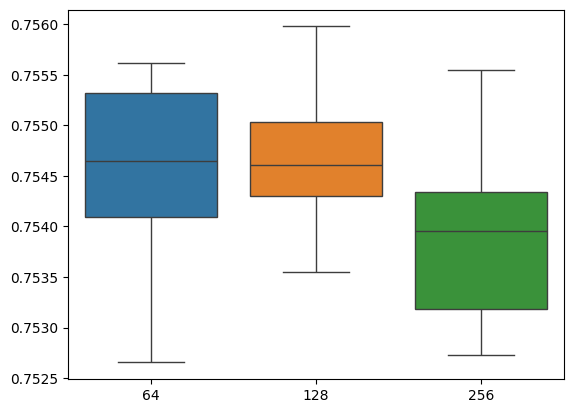

In [27]:
sns.boxplot(pd.DataFrame({128:f1s_128,64:f1s_64,256:f1s_256}))

### CatBoost Custom Ordinal Loss

A bust, not easy to implement. Abandon ship.
https://github.com/catboost/catboost/blob/master/catboost/tutorials/custom_loss/custom_loss_and_metric_tutorial.ipynb
https://github.com/catboost/catboost/issues/1994
https://github.com/catboost/catboost/issues/112
https://discourse.julialang.org/t/lend-a-hand-on-the-hessian-of-ordinal-logistic-regression/18842/4

In [8]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)


# # Instantiate catboost classifier model
# model_cls = cb.CatBoostClassifier(
#     # objective='MultiClass',  # Use 'MultiClass' for classification
#     loss_function=OrdinalClassificationObjective(),
#     # task_type='GPU',  # Specify GPU if available
#     # devices='0',  # Specify GPU device(s) if multiple
#     metric_period=500,  # Period to print metrics
#     iterations=1500,  # Number of boosting iterations
#     learning_rate=0.1,  # Learning rate
#     depth=8,  # Depth of the trees
#     l2_leaf_reg=5,  # L2 regularization coefficient
#     custom_metric=['Accuracy']  # Additional metrics to track
# )

# model_cls.fit(train_val_dataset)

# # Evaluation
# pred = model_cls.predict(df_test_X)
# acc = accuracy_score(df_test_y, pred)
# f1 = f1_score(df_test_y,pred,average='micro')

# print('Testing performance')
# print(f'Accuracy: {acc:.4f}')
# print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 345.13it/s]


Epoch [1/10], Loss: 7.116816820996499


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 288.48it/s]


Epoch [2/10], Loss: 0.5150763150057667


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 275.97it/s]


Epoch [3/10], Loss: 0.20980201876243584


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 293.19it/s]


Epoch [4/10], Loss: 0.14456527407345565


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 298.64it/s]


Epoch [5/10], Loss: 0.1118731138118802


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 292.71it/s]


Epoch [6/10], Loss: 0.09338239413810913


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 290.94it/s]


Epoch [7/10], Loss: 0.07604850767216671


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 276.80it/s]


Epoch [8/10], Loss: 0.07877733506243785


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 278.78it/s]


Epoch [9/10], Loss: 0.05996585634047719


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 271.84it/s]


Epoch [10/10], Loss: 0.05203287642783813


Evaluating: 100%|██████████| 2715/2715 [00:03<00:00, 717.74it/s]


In [42]:
class OrdinalAccuracyMetric(object):
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        # Convert approxes to a more interpretable format
        approxes = np.array(approxes)
        num_classes = approxes.shape[0]
        num_samples = approxes.shape[1]
        
        # Compute the predicted class for each sample
        best_class = np.zeros(num_samples)
        for i in range(num_samples):
            approx_i = approxes[:, i]
            best_class[i] = np.argmax(approx_i)
        
        # Calculate accuracy
        accuracy_sum = 0
        weight_sum = 0

        for i in range(len(target)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            accuracy_sum += w * (best_class[i] == target[i])

        return accuracy_sum, weight_sum

class OrdinalClassificationObjective(object):
    def calc_ders_multi(self, approx, target, weight):
        # Transform approx to log odds using Softmax
        approx = [approx[i] - max(approx) for i in range(len(approx))]
        exp_approx = [np.exp(approx[i]) for i in range(len(approx))]
        exp_sum = sum(exp_approx)
        
        # Compute probabilities
        probs = [exp_approx[i] / exp_sum for i in range(len(approx))]
        
        # Initialize gradient and Hessian
        grad = [0.0] * len(approx)
        hess = [[0.0] * len(approx) for _ in range(len(approx))]
        
        # Compute the derivative (gradient) and Hessian
        for j in range(len(approx)):
            der1 = probs[j]
            if j == target:
                der1 -= 1
            der1 *= weight
            
            for k in range(len(approx)):
                if j == k:
                    der2 = probs[j] * (1 - probs[j])
                else:
                    der2 = -probs[j] * probs[k]
                der2 *= weight
                
                hess[j][k] = der2
                
            grad[j] = der1
        
        return grad, hess

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    # objective='MultiClass',  # Use 'MultiClass' for classification
    # objective=OrdinalClassificationObjective(),
    loss_function=OrdinalClassificationObjective(),
    # eval_metric=[OrdinalAccuracyMetric()],
    # eval_metric=['Accuracy'],
    # task_type='GPU',  # Specify GPU if available
    # devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=1500,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['MultiClassOneVsAll'],  # Additional metrics to track
    eval_metric=['MultiClassOneVsAll']
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


AttributeError: 'list' object has no attribute '_jited'

Exception ignored in: '_catboost._BuildCustomMetricDescriptor'
Traceback (most recent call last):
  File "_catboost.pyx", line 1660, in _catboost._try_jit_methods
AttributeError: 'list' object has no attribute '_jited'


AttributeError: 'list' object has no attribute '_jited'

Exception ignored in: '_catboost._BuildCustomMetricDescriptor'
Traceback (most recent call last):
  File "_catboost.pyx", line 1660, in _catboost._try_jit_methods
AttributeError: 'list' object has no attribute '_jited'


CatBoostError: /src/catboost/catboost/libs/metrics/metric.h:137: Any custom eval function must be defined

### CatBoost + iterative geoencoding

Referring to pseudo-labelling approaches, when geo-encoding, what if we pumped in predicted damage grade and attempt to reencode? doesn't seem to bring much improvement. maybe damage grade not given enough attention/weight?

In [19]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X_or = df_pred_features_raw

f1s = []

for i in range(10):
    # Get imputed damage grade to prep for geo-encoding.
    # First round here, no pred or test damnage grade values to use
    if i == 0:
        df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or,
                                                        df_test_X_or,df_pred_X_or,
                                                        df_train_y_or,df_val_y_or)
    else:
        # Predict damage grade using trained model and impute accordingly
        df_test_y_pred = pd.DataFrame(model_cls.predict(df_test_X),columns=['damage_grade'],index=df_test_X.index)
        df_pred_y_pred = pd.DataFrame(model_cls.predict(df_pred_X),columns=['damage_grade'],index=df_pred_X.index)
        df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, 
                                                    df_test_X_or,df_pred_X_or, 
                                                    df_train_y_or,df_val_y_or,
                                                    # df_test_y=df_test_y_pred,
                                                    df_pred_y=df_pred_y_pred)
    

    # Set up architecture
    geo1_size = 16
    geo2_size = 32
    geo3_size = 64
    inter_size = 128
    latent_size = 64
    epochs = 10

    # Get latent geo-encoding
    latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                                geo3_size, inter_size, latent_size, epochs)

    # Apply encoding
    df_train_X = df_train_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
    df_val_X = df_val_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
    df_test_X = df_test_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
    df_pred_X = df_pred_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

    df_train_X.drop(columns=geo_features, inplace=True)
    df_val_X.drop(columns=geo_features, inplace=True)
    df_test_X.drop(columns=geo_features, inplace=True)
    df_pred_X.drop(columns=geo_features, inplace=True)

    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_train_X.dtypes):
        if dtype in ['int64','int32','object','category']:
            categorical_features_indices.append(i)

    # Create pooled dataset following catboost requirements
    train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
    val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
    test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
    train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y],axis=0),
                                cat_features=categorical_features_indices)
    train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                                cat_features=categorical_features_indices)

    # Instantiate catboost classifier model
    model_cls = cb.CatBoostClassifier(
        objective='MultiClass',  # Use 'MultiClass' for classification
        task_type='GPU',  # Specify GPU if available
        devices='0',  # Specify GPU device(s) if multiple
        metric_period=5000,  # Period to print metrics
        iterations=20000,  # Number of boosting iterations
        learning_rate=0.01,  # Learning rate
        depth=8,  # Depth of the trees
        l2_leaf_reg=5,  # L2 regularization coefficient
        custom_metric=['Accuracy']  # Additional metrics to track
    )

    model_cls.fit(train_val_dataset)

    # Evaluation
    pred = model_cls.predict(df_test_X)
    acc = accuracy_score(df_test_y, pred)
    f1 = f1_score(df_test_y,pred,average='micro')
    print(f'\n\n\nIteration{i}')
    print('Testing performance')
    print(f'Accuracy: {acc:.4f}')
    print(f'F1-score: {f1:.4f}\n\n')
    f1s.append(f1)

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.66it/s]


Epoch [1/10], Loss: 6.691333391924494


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 495.45it/s]


Epoch [2/10], Loss: 0.4462559603412522


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.52it/s]


Epoch [3/10], Loss: 0.21723859445829719


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.10it/s]


Epoch [4/10], Loss: 0.14886235278264368


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 501.95it/s]


Epoch [5/10], Loss: 0.11191954815709505


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 504.46it/s]


Epoch [6/10], Loss: 0.10042776002233851


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 517.96it/s]


Epoch [7/10], Loss: 0.08828747669143659


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.18it/s]


Epoch [8/10], Loss: 0.06888110463871636


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 524.52it/s]


Epoch [9/10], Loss: 0.06833887234703855


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.67it/s]


Epoch [10/10], Loss: 0.05362746292069062


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1400.05it/s]


0:	learn: 1.0932349	total: 9.46ms	remaining: 3m 9s
5000:	learn: 0.5410162	total: 42.2s	remaining: 2m 6s
10000:	learn: 0.4984340	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4672478	total: 2m 7s	remaining: 42.5s
19999:	learn: 0.4413923	total: 2m 47s	remaining: 0us



Iteration98
Testing performance
Accuracy: 0.7555
F1-score: 0.7555


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 518.02it/s]


Epoch [1/10], Loss: 6.600520047067016


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 530.73it/s]


Epoch [2/10], Loss: 0.46611970178618345


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 520.31it/s]


Epoch [3/10], Loss: 0.20540122958846577


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 521.27it/s]


Epoch [4/10], Loss: 0.1629022589812003


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 525.40it/s]


Epoch [5/10], Loss: 0.11783234728157345


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 502.30it/s]


Epoch [6/10], Loss: 0.09707260287033506


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 512.86it/s]


Epoch [7/10], Loss: 0.07945363430254195


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.25it/s]


Epoch [8/10], Loss: 0.07331618009195906


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 510.83it/s]


Epoch [9/10], Loss: 0.06361406226569563


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 521.08it/s]


Epoch [10/10], Loss: 0.06193833232072726


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1452.74it/s]


0:	learn: 1.0933473	total: 9.5ms	remaining: 3m 9s
5000:	learn: 0.5414835	total: 40.5s	remaining: 2m 1s
10000:	learn: 0.4981103	total: 1m 20s	remaining: 1m 20s
15000:	learn: 0.4669036	total: 2m	remaining: 40.1s
19999:	learn: 0.4409467	total: 2m 41s	remaining: 0us



Iteration98
Testing performance
Accuracy: 0.7564
F1-score: 0.7564


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.23it/s]


Epoch [1/10], Loss: 6.822453826995065


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.55it/s]


Epoch [2/10], Loss: 0.46429875152890565


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 518.12it/s]


Epoch [3/10], Loss: 0.23364923522699302


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 501.24it/s]


Epoch [4/10], Loss: 0.14868527971721077


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.36it/s]


Epoch [5/10], Loss: 0.11988637845075809


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.76it/s]


Epoch [6/10], Loss: 0.09494830152144675


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.16it/s]


Epoch [7/10], Loss: 0.08656453967436638


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.90it/s]


Epoch [8/10], Loss: 0.07129345590160235


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.54it/s]


Epoch [9/10], Loss: 0.0656820160924184


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 518.70it/s]


Epoch [10/10], Loss: 0.05729406621737991


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1353.14it/s]


0:	learn: 1.0936084	total: 9.88ms	remaining: 3m 17s
5000:	learn: 0.5409112	total: 42.5s	remaining: 2m 7s
10000:	learn: 0.4975576	total: 1m 26s	remaining: 1m 26s
15000:	learn: 0.4665330	total: 2m 6s	remaining: 42.3s
19999:	learn: 0.4405260	total: 2m 48s	remaining: 0us



Iteration98
Testing performance
Accuracy: 0.7551
F1-score: 0.7551


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.24it/s]


Epoch [1/10], Loss: 6.734692649435751


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.65it/s]


Epoch [2/10], Loss: 0.46627010114831147


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.97it/s]


Epoch [3/10], Loss: 0.2199378093438489


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.13it/s]


Epoch [4/10], Loss: 0.1716114691169233


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 510.02it/s]


Epoch [5/10], Loss: 0.11371697427496445


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 530.83it/s]


Epoch [6/10], Loss: 0.11846466737234243


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 530.68it/s]


Epoch [7/10], Loss: 0.08429020746362112


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 502.63it/s]


Epoch [8/10], Loss: 0.07980619414348775


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.56it/s]


Epoch [9/10], Loss: 0.06964046934764251


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.20it/s]


Epoch [10/10], Loss: 0.06690348930460084


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1447.53it/s]


0:	learn: 1.0933021	total: 8.94ms	remaining: 2m 58s
5000:	learn: 0.5427043	total: 40.3s	remaining: 2m
10000:	learn: 0.4991803	total: 1m 20s	remaining: 1m 20s
15000:	learn: 0.4681359	total: 1m 59s	remaining: 40s
19999:	learn: 0.4421449	total: 2m 39s	remaining: 0us



Iteration98
Testing performance
Accuracy: 0.7561
F1-score: 0.7561


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 527.70it/s]


Epoch [1/10], Loss: 6.946590520145264


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.17it/s]


Epoch [2/10], Loss: 0.4895589620708893


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 501.01it/s]


Epoch [3/10], Loss: 0.2185996804984399


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 523.86it/s]


Epoch [4/10], Loss: 0.15339040958057865


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.45it/s]


Epoch [5/10], Loss: 0.1284989288271527


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 523.54it/s]


Epoch [6/10], Loss: 0.10188205617984732


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 502.36it/s]


Epoch [7/10], Loss: 0.08224568304951084


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.35it/s]


Epoch [8/10], Loss: 0.07426378378316771


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.95it/s]


Epoch [9/10], Loss: 0.07652047094261474


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.33it/s]


Epoch [10/10], Loss: 0.062466100374952


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1448.98it/s]


0:	learn: 1.0932685	total: 10.1ms	remaining: 3m 22s
5000:	learn: 0.5438147	total: 40.4s	remaining: 2m 1s
10000:	learn: 0.5002320	total: 1m 20s	remaining: 1m 20s
15000:	learn: 0.4689643	total: 2m 2s	remaining: 40.9s
19999:	learn: 0.4429030	total: 2m 46s	remaining: 0us



Iteration98
Testing performance
Accuracy: 0.7540
F1-score: 0.7540


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.31it/s]


Epoch [1/10], Loss: 6.748700521831484


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 513.75it/s]


Epoch [2/10], Loss: 0.49563568427237037


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 520.72it/s]


Epoch [3/10], Loss: 0.22265486758262665


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 535.77it/s]


Epoch [4/10], Loss: 0.16121311845951913


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.58it/s]


Epoch [5/10], Loss: 0.11671995034164287


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 518.92it/s]


Epoch [6/10], Loss: 0.11411482085054123


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 521.95it/s]


Epoch [7/10], Loss: 0.07595201391191461


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 527.66it/s]


Epoch [8/10], Loss: 0.09000423010526121


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.03it/s]


Epoch [9/10], Loss: 0.0627448920420109


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 510.76it/s]


Epoch [10/10], Loss: 0.057568127325290555


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1417.74it/s]


0:	learn: 1.0931555	total: 9.79ms	remaining: 3m 15s
5000:	learn: 0.5433064	total: 41.7s	remaining: 2m 5s
10000:	learn: 0.5002052	total: 1m 22s	remaining: 1m 22s
15000:	learn: 0.4690661	total: 2m 3s	remaining: 41.1s
19999:	learn: 0.4429492	total: 2m 44s	remaining: 0us



Iteration98
Testing performance
Accuracy: 0.7558
F1-score: 0.7558


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 519.70it/s]


Epoch [1/10], Loss: 6.6782147850133535


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 521.80it/s]


Epoch [2/10], Loss: 0.4845900832399704


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 519.07it/s]


Epoch [3/10], Loss: 0.2319749242849703


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 520.37it/s]


Epoch [4/10], Loss: 0.16364163020968614


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 526.00it/s]


Epoch [5/10], Loss: 0.13577495634265035


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 520.98it/s]


Epoch [6/10], Loss: 0.09639680520950272


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.46it/s]


Epoch [7/10], Loss: 0.09646210759877816


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.95it/s]


Epoch [8/10], Loss: 0.07940444525602837


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.68it/s]


Epoch [9/10], Loss: 0.06398707198559284


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 517.32it/s]


Epoch [10/10], Loss: 0.06337147050527568


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1453.35it/s]


0:	learn: 1.0931934	total: 8.72ms	remaining: 2m 54s
5000:	learn: 0.5430956	total: 40.1s	remaining: 2m
10000:	learn: 0.5000539	total: 1m 19s	remaining: 1m 19s
15000:	learn: 0.4690506	total: 1m 59s	remaining: 39.7s
19999:	learn: 0.4430120	total: 2m 39s	remaining: 0us



Iteration98
Testing performance
Accuracy: 0.7558
F1-score: 0.7558


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.25it/s]


Epoch [1/10], Loss: 6.426374796256752


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.26it/s]


Epoch [2/10], Loss: 0.4517678480392352


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 513.96it/s]


Epoch [3/10], Loss: 0.22250116469039524


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.64it/s]


Epoch [4/10], Loss: 0.14797228148593863


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.41it/s]


Epoch [5/10], Loss: 0.1147851168311068


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.44it/s]


Epoch [6/10], Loss: 0.09055449381324604


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.35it/s]


Epoch [7/10], Loss: 0.08645929661421695


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 521.72it/s]


Epoch [8/10], Loss: 0.0757176447166809


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 507.57it/s]


Epoch [9/10], Loss: 0.060645991618455616


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.65it/s]


Epoch [10/10], Loss: 0.0551558445940171


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1443.13it/s]


0:	learn: 1.0934623	total: 8.9ms	remaining: 2m 57s
5000:	learn: 0.5412913	total: 42.6s	remaining: 2m 7s
10000:	learn: 0.4980141	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4666305	total: 2m 9s	remaining: 43.3s
19999:	learn: 0.4405980	total: 2m 51s	remaining: 0us



Iteration98
Testing performance
Accuracy: 0.7557
F1-score: 0.7557


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 499.35it/s]


Epoch [1/10], Loss: 6.899881305022163


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 525.66it/s]


Epoch [2/10], Loss: 0.45902493058131877


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.76it/s]


Epoch [3/10], Loss: 0.1963385027162566


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 490.75it/s]


Epoch [4/10], Loss: 0.1462192423230199


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.37it/s]


Epoch [5/10], Loss: 0.11228614943808381


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.49it/s]


Epoch [6/10], Loss: 0.08245786931468599


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.49it/s]


Epoch [7/10], Loss: 0.07810539248221471


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 504.13it/s]


Epoch [8/10], Loss: 0.06459718258753631


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.49it/s]


Epoch [9/10], Loss: 0.06397372123079624


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 518.53it/s]


Epoch [10/10], Loss: 0.05412585375490544


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1409.10it/s]


0:	learn: 1.0932061	total: 9.06ms	remaining: 3m 1s
5000:	learn: 0.5419315	total: 42.8s	remaining: 2m 8s
10000:	learn: 0.4986813	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4677523	total: 2m 8s	remaining: 42.7s
19999:	learn: 0.4418437	total: 2m 50s	remaining: 0us



Iteration98
Testing performance
Accuracy: 0.7559
F1-score: 0.7559


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.46it/s]


Epoch [1/10], Loss: 6.752865973602163


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 499.16it/s]


Epoch [2/10], Loss: 0.4902390887376486


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.26it/s]


Epoch [3/10], Loss: 0.21940525759571122


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.57it/s]


Epoch [4/10], Loss: 0.1584825388400024


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 502.13it/s]


Epoch [5/10], Loss: 0.12588147191462465


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 495.24it/s]


Epoch [6/10], Loss: 0.10568846592906621


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.68it/s]


Epoch [7/10], Loss: 0.08204355281750247


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.04it/s]


Epoch [8/10], Loss: 0.07603018670819497


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 527.35it/s]


Epoch [9/10], Loss: 0.07070165777195585


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.97it/s]


Epoch [10/10], Loss: 0.05310490629035244


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1281.99it/s]


0:	learn: 1.0933057	total: 9.34ms	remaining: 3m 6s
5000:	learn: 0.5403100	total: 43.1s	remaining: 2m 9s
10000:	learn: 0.4974657	total: 1m 27s	remaining: 1m 27s
15000:	learn: 0.4666701	total: 2m 11s	remaining: 44s
19999:	learn: 0.4411308	total: 2m 54s	remaining: 0us



Iteration98
Testing performance
Accuracy: 0.7551
F1-score: 0.7551


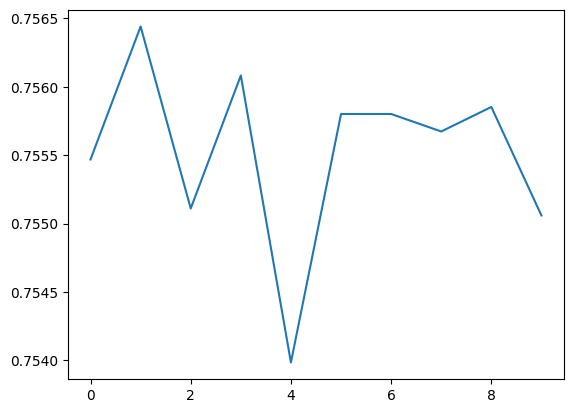

In [20]:
plt.plot(np.array(f1s))

### CatBoost + damage grade weight in geo encoding

In [39]:
def get_latent_geo(df_all:pd.DataFrame, non_geo_features_OHE:list, geo1_size:int = 16, geo2_size:int = 32,
                   geo3_size:int = 64, inter_size:int = 128,
                   latent_size:int = 64, epochs:int = 10, damage_grade_weight: float=1.0):
    '''
    Build autoencoder network and get latent geo-encoding based on defined architecture.
    geo1_size: Embedding dimension for first geo level
    geo2_size: Embedding dimension for second geo level
    geo3_size: Embedding dimension for third geo level
    inter_size: Output (input) size of encoder's (decoder's) first (last) linear layer, interfacing with latent values
    epochs: Number of epochs to run model
    '''
    # Instantiate the model
    model = CategoricalAutoencoder(geo1_size, geo2_size, geo3_size, inter_size, latent_size).cuda()

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Create DataLoader
    df = df_all.copy()
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(float)

    # Encode the categorical columns
    le_cat1 = LabelEncoder()
    le_cat2 = LabelEncoder()
    le_cat3 = LabelEncoder()

    df['geo_level_1_id'] = le_cat1.fit_transform(df['geo_level_1_id'])
    df['geo_level_2_id'] = le_cat2.fit_transform(df['geo_level_2_id'])
    df['geo_level_3_id'] = le_cat3.fit_transform(df['geo_level_3_id'])

    # Convert DataFrame to tensors
    x1 = torch.tensor(df['geo_level_1_id'].values, dtype=torch.long).cuda()
    x2 = torch.tensor(df['geo_level_2_id'].values, dtype=torch.long).cuda()
    x3 = torch.tensor(df['geo_level_3_id'].values, dtype=torch.long).cuda()

    feat_tensor = torch.tensor(df[non_geo_features_OHE].values, dtype=torch.float).cuda()

    # Create DataLoader
    dataset = TensorDataset(x1, x2, x3, feat_tensor)
    dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

    # Training loop with tqdm
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
            x1_batch, x2_batch, x3_batch, feats_batch = batch
            optimizer.zero_grad()
            
            # Forward pass
            x1_out, x2_out, x3_out, feats_recon = model(x1_batch, x2_batch, x3_batch, feats_batch)
            
            # Compute loss from geo features
            loss = (criterion(x1_out, x1_batch) + \
                criterion(x2_out, x2_batch) + \
                criterion(x3_out, x3_batch))
            
            # Computer loss from features
            loss_feat = nn.MSELoss()(
                torch.cat((feats_recon[:, :5], feats_recon[:, 5+1:]), dim=1),
                torch.cat((feats_batch[:, :5], feats_batch[:, 5+1:]), dim=1),
                )

            # Compute loss from damage_grade
            loss_damage_grade = nn.MSELoss()(feats_recon[:,5], feats_batch[:,5])

            # Get total loss
            total_loss = loss + loss_feat + damage_grade_weight*loss_damage_grade

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader)}')


    # Extract encoding for each location
    # Pass the input through the encoder and plot the results
    model.eval()
    z_list = []

    eval_dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc='Evaluating'):
            x1_batch, x2_batch, x3_batch, feat_tensor = batch
            
            # Forward pass
            z_batch = model.encoder(torch.cat([model.embed1(x1_batch),
                                            model.embed2(x2_batch),
                                            model.embed3(x3_batch),
                                            feat_tensor],
                                            dim=1))
        
            # Move tensors to CPU
            z_list.append(z_batch.cpu())
            
            # Clear cache
            torch.cuda.empty_cache()

    # Concatenate results
    z = torch.cat(z_list, dim=0)
    latent_geo = pd.concat([df_all.iloc[:,:3].reset_index(drop=True),pd.DataFrame(z.cpu().numpy())],axis=1)
    latent_geo = latent_geo.groupby(geo_features).mean().reset_index() # Get average latent values

    return latent_geo, model, dataset, x1, x2, x3

In [40]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X_or = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, df_test_X_or,df_pred_X_or, df_train_y_or,df_val_y_or)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs,
                                              damage_grade_weight=10)

# Apply encoding
df_train_X = df_train_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_val_X = df_val_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_test_X = df_test_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_pred_X = df_pred_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=5000,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.20it/s]


Epoch [1/10], Loss: 10.598508747670365


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.09it/s]


Epoch [2/10], Loss: 0.8398062104746062


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.95it/s]


Epoch [3/10], Loss: 0.28026044353381874


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.15it/s]


Epoch [4/10], Loss: 0.1906656732752546


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.02it/s]


Epoch [5/10], Loss: 0.11467867664819986


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.60it/s]


Epoch [6/10], Loss: 0.10097566834377983


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.96it/s]


Epoch [7/10], Loss: 0.08472389377350473


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.81it/s]


Epoch [8/10], Loss: 0.073429298772825


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.26it/s]


Epoch [9/10], Loss: 0.06486816630412075


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.80it/s]


Epoch [10/10], Loss: 0.0628436445822632


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1611.48it/s]


0:	learn: 1.0923820	total: 11.5ms	remaining: 3m 50s
5000:	learn: 0.5063777	total: 45s	remaining: 2m 15s
10000:	learn: 0.4715150	total: 1m 29s	remaining: 1m 29s
15000:	learn: 0.4439567	total: 2m 13s	remaining: 44.6s
19999:	learn: 0.4204251	total: 2m 58s	remaining: 0us
Testing performance
Accuracy: 0.7534
F1-score: 0.7534


In [41]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X_or = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, df_test_X_or,df_pred_X_or, df_train_y_or,df_val_y_or)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs,
                                              damage_grade_weight=5)

# Apply encoding
df_train_X = df_train_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_val_X = df_val_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_test_X = df_test_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_pred_X = df_pred_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=5000,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.75it/s]


Epoch [1/10], Loss: 9.065667116764894


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.75it/s]


Epoch [2/10], Loss: 0.6788418344846091


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.55it/s]


Epoch [3/10], Loss: 0.2560678722888275


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.19it/s]


Epoch [4/10], Loss: 0.1621221675831051


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.65it/s]


Epoch [5/10], Loss: 0.11695297010207277


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.10it/s]


Epoch [6/10], Loss: 0.11061774027247163


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.94it/s]


Epoch [7/10], Loss: 0.08445306944256903


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.97it/s]


Epoch [8/10], Loss: 0.068308835822591


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.97it/s]


Epoch [9/10], Loss: 0.06732077183692602


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.23it/s]


Epoch [10/10], Loss: 0.06486911340191445


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1611.73it/s]


0:	learn: 1.0925338	total: 10.4ms	remaining: 3m 27s
5000:	learn: 0.5079153	total: 43.5s	remaining: 2m 10s
10000:	learn: 0.4719439	total: 1m 26s	remaining: 1m 26s
15000:	learn: 0.4443077	total: 2m 9s	remaining: 43.3s
19999:	learn: 0.4205640	total: 2m 53s	remaining: 0us
Testing performance
Accuracy: 0.7532
F1-score: 0.7532


### CatBoost param: iterations and damage grade weight 

Looks like best with 15000 or 20000 iterations, maybe 15000 superior, but marginally. Using low damage grade weight seems like a good choice. Increasing damage grade weight significantly did not seem to affect results. why?

In [42]:
def get_latent_geo(df_all:pd.DataFrame, non_geo_features_OHE:list, geo1_size:int = 16, geo2_size:int = 32,
                   geo3_size:int = 64, inter_size:int = 128,
                   latent_size:int = 64, epochs:int = 10, damage_grade_weight: float=1.0):
    '''
    Build autoencoder network and get latent geo-encoding based on defined architecture.
    geo1_size: Embedding dimension for first geo level
    geo2_size: Embedding dimension for second geo level
    geo3_size: Embedding dimension for third geo level
    inter_size: Output (input) size of encoder's (decoder's) first (last) linear layer, interfacing with latent values
    epochs: Number of epochs to run model
    '''
    # Instantiate the model
    model = CategoricalAutoencoder(geo1_size, geo2_size, geo3_size, inter_size, latent_size).cuda()

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Create DataLoader
    df = df_all.copy()
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(float)

    # Encode the categorical columns
    le_cat1 = LabelEncoder()
    le_cat2 = LabelEncoder()
    le_cat3 = LabelEncoder()

    df['geo_level_1_id'] = le_cat1.fit_transform(df['geo_level_1_id'])
    df['geo_level_2_id'] = le_cat2.fit_transform(df['geo_level_2_id'])
    df['geo_level_3_id'] = le_cat3.fit_transform(df['geo_level_3_id'])

    # Convert DataFrame to tensors
    x1 = torch.tensor(df['geo_level_1_id'].values, dtype=torch.long).cuda()
    x2 = torch.tensor(df['geo_level_2_id'].values, dtype=torch.long).cuda()
    x3 = torch.tensor(df['geo_level_3_id'].values, dtype=torch.long).cuda()

    feat_tensor = torch.tensor(df[non_geo_features_OHE].values, dtype=torch.float).cuda()

    # Create DataLoader
    dataset = TensorDataset(x1, x2, x3, feat_tensor)
    dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

    # Training loop with tqdm
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
            x1_batch, x2_batch, x3_batch, feats_batch = batch
            optimizer.zero_grad()
            
            # Forward pass
            x1_out, x2_out, x3_out, feats_recon = model(x1_batch, x2_batch, x3_batch, feats_batch)
            
            # Compute loss from geo features
            loss = (criterion(x1_out, x1_batch) + \
                criterion(x2_out, x2_batch) + \
                criterion(x3_out, x3_batch))
            
            # Computer loss from features
            loss_feat = nn.MSELoss()(
                torch.cat((feats_recon[:, :5], feats_recon[:, 5+1:]), dim=1),
                torch.cat((feats_batch[:, :5], feats_batch[:, 5+1:]), dim=1),
                )

            # Compute loss from damage_grade
            loss_damage_grade = nn.MSELoss()(feats_recon[:,5], feats_batch[:,5])

            # Get total loss
            total_loss = loss + loss_feat + damage_grade_weight*loss_damage_grade

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += total_loss.item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader)}')


    # Extract encoding for each location
    # Pass the input through the encoder and plot the results
    model.eval()
    z_list = []

    eval_dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc='Evaluating'):
            x1_batch, x2_batch, x3_batch, feat_tensor = batch
            
            # Forward pass
            z_batch = model.encoder(torch.cat([model.embed1(x1_batch),
                                            model.embed2(x2_batch),
                                            model.embed3(x3_batch),
                                            feat_tensor],
                                            dim=1))
        
            # Move tensors to CPU
            z_list.append(z_batch.cpu())
            
            # Clear cache
            torch.cuda.empty_cache()

    # Concatenate results
    z = torch.cat(z_list, dim=0)
    latent_geo = pd.concat([df_all.iloc[:,:3].reset_index(drop=True),pd.DataFrame(z.cpu().numpy())],axis=1)
    latent_geo = latent_geo.groupby(geo_features).mean().reset_index() # Get average latent values

    return latent_geo, model, dataset, x1, x2, x3

In [43]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X_or = df_pred_features_raw

all_iterations = [1000,3000,5000,10000,15000,20000]
all_damage_grade_weights = [0.01,0.1,0.5,1,3,5,8,10,100]
all_f1s = []

for damage_grade_weight in all_damage_grade_weights:
    f1s = []
    for iterations in all_iterations:
        # Prep data for catboost vanilla
        categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                                'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                                'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
        geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
        numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

        # Split into train, val, test and pred sets
        X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
        df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
        df_pred_X_or = df_pred_features_raw

        # Get imputed damage grade to prep for geo-encoding
        df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, df_test_X_or,df_pred_X_or, df_train_y_or,df_val_y_or)

        # Set up architecture
        geo1_size = 16
        geo2_size = 32
        geo3_size = 64
        inter_size = 128
        latent_size = 64
        epochs = 10

        # Get latent geo-encoding
        latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                                    geo3_size, inter_size, latent_size, epochs,
                                                    damage_grade_weight=damage_grade_weight)

        # Apply encoding
        df_train_X = df_train_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
        df_val_X = df_val_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
        df_test_X = df_test_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
        df_pred_X = df_pred_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

        df_train_X.drop(columns=geo_features, inplace=True)
        df_val_X.drop(columns=geo_features, inplace=True)
        df_test_X.drop(columns=geo_features, inplace=True)
        df_pred_X.drop(columns=geo_features, inplace=True)

        # Get categorical feature indices and names
        categorical_features_indices = []
        for i,dtype in enumerate(df_train_X.dtypes):
            if dtype in ['int64','int32','object','category']:
                categorical_features_indices.append(i)

        # Create pooled dataset following catboost requirements
        train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
        val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
        test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
        train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                                    label=pd.concat([df_train_y,df_val_y],axis=0),
                                    cat_features=categorical_features_indices)
        train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                                    label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                                    cat_features=categorical_features_indices)

        # Instantiate catboost classifier model
        model_cls = cb.CatBoostClassifier(
            objective='MultiClass',  # Use 'MultiClass' for classification
            task_type='GPU',  # Specify GPU if available
            devices='0',  # Specify GPU device(s) if multiple
            metric_period=5000,  # Period to print metrics
            iterations=iterations,  # Number of boosting iterations
            learning_rate=0.01,  # Learning rate
            depth=8,  # Depth of the trees
            l2_leaf_reg=5,  # L2 regularization coefficient
            custom_metric=['Accuracy']  # Additional metrics to track
        )

        model_cls.fit(train_val_dataset)

        # Evaluation
        pred = model_cls.predict(df_test_X)
        acc = accuracy_score(df_test_y, pred)
        f1 = f1_score(df_test_y,pred,average='micro')

        print('\n\n~~~~~~~~~~~~~~~')
        print(f'Testing performance for iterations: {iterations}, damage_grade_weight: {damage_grade_weight}')
        print(f'Accuracy: {acc:.4f}')
        print(f'F1-score: {f1:.4f}')
        print('\n\n')

        f1s.append(f1)
    all_f1s.append(f1s)

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.52it/s]


Epoch [1/10], Loss: 6.987358354679439


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.51it/s]


Epoch [2/10], Loss: 0.434392377931696


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.94it/s]


Epoch [3/10], Loss: 0.20191100086407826


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.51it/s]


Epoch [4/10], Loss: 0.14357944990169472


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.48it/s]


Epoch [5/10], Loss: 0.12616172239468304


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 490.61it/s]


Epoch [6/10], Loss: 0.10146703788926976


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.25it/s]


Epoch [7/10], Loss: 0.07988799607246808


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.49it/s]


Epoch [8/10], Loss: 0.07918609802597285


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.84it/s]


Epoch [9/10], Loss: 0.06225040160251208


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.11it/s]


Epoch [10/10], Loss: 0.05653689471765254


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1525.63it/s]


0:	learn: 1.0930790	total: 9.54ms	remaining: 9.53s
999:	learn: 0.6214143	total: 8.88s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 1000, damage_grade_weight: 0.5
Accuracy: 0.7255
F1-score: 0.7255





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.22it/s]


Epoch [1/10], Loss: 6.933105566452459


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 399.43it/s]


Epoch [2/10], Loss: 0.4778429580706999


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 440.20it/s]


Epoch [3/10], Loss: 0.21752150043494045


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.46it/s]


Epoch [4/10], Loss: 0.15741264869751126


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 419.60it/s]


Epoch [5/10], Loss: 0.1054310958458053


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 421.03it/s]


Epoch [6/10], Loss: 0.10267956018899135


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.92it/s]


Epoch [7/10], Loss: 0.07272928321407628


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 423.88it/s]


Epoch [8/10], Loss: 0.07656269412009739


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 418.27it/s]


Epoch [9/10], Loss: 0.05639650014078928


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.59it/s]


Epoch [10/10], Loss: 0.06738690998549152


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1672.37it/s]


0:	learn: 1.0932547	total: 11ms	remaining: 33s
2999:	learn: 0.5571337	total: 28.2s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 3000, damage_grade_weight: 0.5
Accuracy: 0.7468
F1-score: 0.7468





Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.24it/s]


Epoch [1/10], Loss: 6.809166710752451


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.63it/s]


Epoch [2/10], Loss: 0.46444027181248426


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.53it/s]


Epoch [3/10], Loss: 0.22437538871533388


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.53it/s]


Epoch [4/10], Loss: 0.14924930711722603


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.33it/s]


Epoch [5/10], Loss: 0.12057487211781327


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.01it/s]


Epoch [6/10], Loss: 0.0836039295650481


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.57it/s]


Epoch [7/10], Loss: 0.09284635900693983


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.78it/s]


Epoch [8/10], Loss: 0.06594692223186883


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.38it/s]


Epoch [9/10], Loss: 0.06204566280631004


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 476.88it/s]


Epoch [10/10], Loss: 0.059447006180439084


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1607.48it/s]


0:	learn: 1.0930231	total: 9.69ms	remaining: 48.4s
4999:	learn: 0.5263300	total: 46.3s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 5000, damage_grade_weight: 0.5
Accuracy: 0.7513
F1-score: 0.7513





Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 411.23it/s]


Epoch [1/10], Loss: 6.871308103971875


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.03it/s]


Epoch [2/10], Loss: 0.4597087867327572


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 434.96it/s]


Epoch [3/10], Loss: 0.22957161457081696


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 426.41it/s]


Epoch [4/10], Loss: 0.13894309526767487


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 434.09it/s]


Epoch [5/10], Loss: 0.12112975806897625


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.49it/s]


Epoch [6/10], Loss: 0.09609502711434834


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 418.28it/s]


Epoch [7/10], Loss: 0.08656423413832515


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 429.60it/s]


Epoch [8/10], Loss: 0.0806141024834678


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.84it/s]


Epoch [9/10], Loss: 0.06113261250650102


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.12it/s]


Epoch [10/10], Loss: 0.06687285023135688


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1601.67it/s]


0:	learn: 1.0931235	total: 10.9ms	remaining: 1m 48s
5000:	learn: 0.5293930	total: 43.3s	remaining: 43.3s
9999:	learn: 0.4872489	total: 1m 26s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 10000, damage_grade_weight: 0.5
Accuracy: 0.7540
F1-score: 0.7540





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.52it/s]


Epoch [1/10], Loss: 7.172508423783116


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 444.74it/s]


Epoch [2/10], Loss: 0.47078405641600907


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.72it/s]


Epoch [3/10], Loss: 0.21307418434517197


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.64it/s]


Epoch [4/10], Loss: 0.14812453702059253


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.00it/s]


Epoch [5/10], Loss: 0.11545752106640428


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.02it/s]


Epoch [6/10], Loss: 0.09124167083415569


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.61it/s]


Epoch [7/10], Loss: 0.08451569446178074


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.61it/s]


Epoch [8/10], Loss: 0.07929470351787794


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.69it/s]


Epoch [9/10], Loss: 0.06716245796431311


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.29it/s]


Epoch [10/10], Loss: 0.06162374795500919


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1617.03it/s]


0:	learn: 1.0933771	total: 9.18ms	remaining: 2m 17s
5000:	learn: 0.5291282	total: 42.7s	remaining: 1m 25s
10000:	learn: 0.4871901	total: 1m 26s	remaining: 43.2s
14999:	learn: 0.4570372	total: 2m 10s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 15000, damage_grade_weight: 0.5
Accuracy: 0.7568
F1-score: 0.7568





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.02it/s]


Epoch [1/10], Loss: 7.36717433812692


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.27it/s]


Epoch [2/10], Loss: 0.543597092520067


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.04it/s]


Epoch [3/10], Loss: 0.24334126145788776


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 438.54it/s]


Epoch [4/10], Loss: 0.15953520829178974


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.58it/s]


Epoch [5/10], Loss: 0.12167058077974133


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.55it/s]


Epoch [6/10], Loss: 0.10504262443098332


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.95it/s]


Epoch [7/10], Loss: 0.08008963889709848


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.03it/s]


Epoch [8/10], Loss: 0.07806560220467736


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.69it/s]


Epoch [9/10], Loss: 0.07580377111610558


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.78it/s]


Epoch [10/10], Loss: 0.0668423541585194


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1578.71it/s]


0:	learn: 1.0933812	total: 10.7ms	remaining: 3m 33s
5000:	learn: 0.5249213	total: 44.1s	remaining: 2m 12s
10000:	learn: 0.4835842	total: 1m 26s	remaining: 1m 26s
15000:	learn: 0.4539998	total: 2m 9s	remaining: 43.2s
19999:	learn: 0.4290248	total: 2m 53s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 20000, damage_grade_weight: 0.5
Accuracy: 0.7550
F1-score: 0.7550





Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 437.12it/s]


Epoch [1/10], Loss: 7.175742168401935


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.26it/s]


Epoch [2/10], Loss: 0.5289297734410536


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.03it/s]


Epoch [3/10], Loss: 0.21963491209608466


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.48it/s]


Epoch [4/10], Loss: 0.1664136346286939


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.96it/s]


Epoch [5/10], Loss: 0.1198561408170204


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.99it/s]


Epoch [6/10], Loss: 0.10721640233005314


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 495.53it/s]


Epoch [7/10], Loss: 0.08586725690477529


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.53it/s]


Epoch [8/10], Loss: 0.07136071853544385


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.12it/s]


Epoch [9/10], Loss: 0.06880738966928902


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.09it/s]


Epoch [10/10], Loss: 0.06143849095597449


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1622.80it/s]


0:	learn: 1.0930419	total: 10.4ms	remaining: 10.4s
999:	learn: 0.6102121	total: 9.02s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 1000, damage_grade_weight: 1
Accuracy: 0.7291
F1-score: 0.7291





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.94it/s]


Epoch [1/10], Loss: 7.123269848075636


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.31it/s]


Epoch [2/10], Loss: 0.453791149295263


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.34it/s]


Epoch [3/10], Loss: 0.21824758609589492


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.30it/s]


Epoch [4/10], Loss: 0.12941119482395114


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.87it/s]


Epoch [5/10], Loss: 0.11890917189936366


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.25it/s]


Epoch [6/10], Loss: 0.09462804159812015


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.65it/s]


Epoch [7/10], Loss: 0.09202833045980398


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.80it/s]


Epoch [8/10], Loss: 0.06963127969864644


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.16it/s]


Epoch [9/10], Loss: 0.05748488363579796


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.64it/s]


Epoch [10/10], Loss: 0.05821845677616287


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1690.59it/s]


0:	learn: 1.0929869	total: 8.66ms	remaining: 26s
2999:	learn: 0.5438193	total: 26.4s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 3000, damage_grade_weight: 1
Accuracy: 0.7501
F1-score: 0.7501





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.79it/s]


Epoch [1/10], Loss: 7.112537368232267


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.87it/s]


Epoch [2/10], Loss: 0.5040274038252494


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.89it/s]


Epoch [3/10], Loss: 0.18920596892532615


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.23it/s]


Epoch [4/10], Loss: 0.1507030388371901


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.98it/s]


Epoch [5/10], Loss: 0.12495142627001324


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.42it/s]


Epoch [6/10], Loss: 0.08583286056255261


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.32it/s]


Epoch [7/10], Loss: 0.08414429679186534


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.91it/s]


Epoch [8/10], Loss: 0.06568833837117273


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.16it/s]


Epoch [9/10], Loss: 0.05966080408428476


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.17it/s]


Epoch [10/10], Loss: 0.057292987724964335


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1602.04it/s]


0:	learn: 1.0932145	total: 9.89ms	remaining: 49.4s
4999:	learn: 0.5210702	total: 44.8s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 5000, damage_grade_weight: 1
Accuracy: 0.7524
F1-score: 0.7524





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.52it/s]


Epoch [1/10], Loss: 7.3571546321326045


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.82it/s]


Epoch [2/10], Loss: 0.4607412603756465


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.28it/s]


Epoch [3/10], Loss: 0.21788822570664806


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.35it/s]


Epoch [4/10], Loss: 0.14320228524047976


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.72it/s]


Epoch [5/10], Loss: 0.13038767000114398


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.56it/s]


Epoch [6/10], Loss: 0.09621044736018128


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.09it/s]


Epoch [7/10], Loss: 0.07855714894894618


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.90it/s]


Epoch [8/10], Loss: 0.07912382995812647


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.50it/s]


Epoch [9/10], Loss: 0.059528274485158676


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.10it/s]


Epoch [10/10], Loss: 0.05892981738440174


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1607.95it/s]


0:	learn: 1.0934033	total: 10.9ms	remaining: 1m 49s
5000:	learn: 0.5192564	total: 44.4s	remaining: 44.4s
9999:	learn: 0.4797126	total: 1m 28s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 10000, damage_grade_weight: 1
Accuracy: 0.7539
F1-score: 0.7539





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.99it/s]


Epoch [1/10], Loss: 7.437695128796554


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.86it/s]


Epoch [2/10], Loss: 0.5329184400271597


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.10it/s]


Epoch [3/10], Loss: 0.22203444250734503


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.97it/s]


Epoch [4/10], Loss: 0.16301409465456942


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.76it/s]


Epoch [5/10], Loss: 0.11392748474063892


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 484.21it/s]


Epoch [6/10], Loss: 0.09026018391563578


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.73it/s]


Epoch [7/10], Loss: 0.0769388766743967


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.29it/s]


Epoch [8/10], Loss: 0.07492077327179085


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.04it/s]


Epoch [9/10], Loss: 0.07171933145825689


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.46it/s]


Epoch [10/10], Loss: 0.05147593637752801


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1613.24it/s]


0:	learn: 1.0929305	total: 9.97ms	remaining: 2m 29s
5000:	learn: 0.5173581	total: 42.3s	remaining: 1m 24s
10000:	learn: 0.4789737	total: 1m 24s	remaining: 42.2s
14999:	learn: 0.4506324	total: 2m 6s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 15000, damage_grade_weight: 1
Accuracy: 0.7549
F1-score: 0.7549





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.81it/s]


Epoch [1/10], Loss: 7.262238829889073


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 439.97it/s]


Epoch [2/10], Loss: 0.4884172398295248


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.45it/s]


Epoch [3/10], Loss: 0.2361191153548252


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.84it/s]


Epoch [4/10], Loss: 0.14907406299993595


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.43it/s]


Epoch [5/10], Loss: 0.13693149947144354


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.97it/s]


Epoch [6/10], Loss: 0.08779164818691608


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.35it/s]


Epoch [7/10], Loss: 0.09864650818396535


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.62it/s]


Epoch [8/10], Loss: 0.07863736400995898


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.42it/s]


Epoch [9/10], Loss: 0.07010282960520449


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.73it/s]


Epoch [10/10], Loss: 0.05876052836422563


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1610.20it/s]


0:	learn: 1.0930704	total: 9.94ms	remaining: 3m 18s
5000:	learn: 0.5196836	total: 42.1s	remaining: 2m 6s
10000:	learn: 0.4804612	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4517512	total: 2m 6s	remaining: 42.1s
19999:	learn: 0.4274619	total: 2m 48s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 20000, damage_grade_weight: 1
Accuracy: 0.7544
F1-score: 0.7544





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.75it/s]


Epoch [1/10], Loss: 8.129770264797603


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.37it/s]


Epoch [2/10], Loss: 0.609689666570023


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.62it/s]


Epoch [3/10], Loss: 0.25252481651477326


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.08it/s]


Epoch [4/10], Loss: 0.15445857734415291


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.98it/s]


Epoch [5/10], Loss: 0.11977994272180878


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.72it/s]


Epoch [6/10], Loss: 0.12148384443609063


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.65it/s]


Epoch [7/10], Loss: 0.08288994453578573


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.26it/s]


Epoch [8/10], Loss: 0.0865267594482075


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.64it/s]


Epoch [9/10], Loss: 0.05338236322156353


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.48it/s]


Epoch [10/10], Loss: 0.06656002115310117


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1628.30it/s]


0:	learn: 1.0928492	total: 9.38ms	remaining: 9.37s
999:	learn: 0.5934990	total: 8.52s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 1000, damage_grade_weight: 3
Accuracy: 0.7360
F1-score: 0.7360





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.09it/s]


Epoch [1/10], Loss: 8.338184007400967


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.51it/s]


Epoch [2/10], Loss: 0.5306755202179102


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.22it/s]


Epoch [3/10], Loss: 0.22424500212567106


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.29it/s]


Epoch [4/10], Loss: 0.16284331911008953


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.74it/s]


Epoch [5/10], Loss: 0.12178825768498108


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.65it/s]


Epoch [6/10], Loss: 0.109132035727481


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.92it/s]


Epoch [7/10], Loss: 0.08280491285984143


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.29it/s]


Epoch [8/10], Loss: 0.07767566171387658


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.94it/s]


Epoch [9/10], Loss: 0.05435612986701992


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.01it/s]


Epoch [10/10], Loss: 0.07708834030765585


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1620.90it/s]


0:	learn: 1.0930723	total: 9.83ms	remaining: 29.5s
2999:	learn: 0.5347891	total: 25.9s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 3000, damage_grade_weight: 3
Accuracy: 0.7476
F1-score: 0.7476





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.34it/s]


Epoch [1/10], Loss: 8.529115969021646


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.80it/s]


Epoch [2/10], Loss: 0.5994875660338967


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.16it/s]


Epoch [3/10], Loss: 0.24188617780387664


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.80it/s]


Epoch [4/10], Loss: 0.14303243520020867


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.50it/s]


Epoch [5/10], Loss: 0.12997937837920107


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.61it/s]


Epoch [6/10], Loss: 0.09276800992897272


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.74it/s]


Epoch [7/10], Loss: 0.07935144426386848


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.48it/s]


Epoch [8/10], Loss: 0.07236049609980237


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.26it/s]


Epoch [9/10], Loss: 0.06629836203637417


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.08it/s]


Epoch [10/10], Loss: 0.05777038644273341


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1613.01it/s]


0:	learn: 1.0929610	total: 11.4ms	remaining: 56.9s
4999:	learn: 0.5115619	total: 42.3s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 5000, damage_grade_weight: 3
Accuracy: 0.7524
F1-score: 0.7524





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.27it/s]


Epoch [1/10], Loss: 8.802136941142216


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.49it/s]


Epoch [2/10], Loss: 0.7339456964706638


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.03it/s]


Epoch [3/10], Loss: 0.28182102082535865


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.16it/s]


Epoch [4/10], Loss: 0.1697848186881689


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.16it/s]


Epoch [5/10], Loss: 0.14315357577022775


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.03it/s]


Epoch [6/10], Loss: 0.11584379314890732


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.74it/s]


Epoch [7/10], Loss: 0.09413634201210673


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.70it/s]


Epoch [8/10], Loss: 0.08462440672886745


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.65it/s]


Epoch [9/10], Loss: 0.06116804738029418


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 484.95it/s]


Epoch [10/10], Loss: 0.07335666887143583


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1612.58it/s]


0:	learn: 1.0928695	total: 9.54ms	remaining: 1m 35s
5000:	learn: 0.5116996	total: 42.1s	remaining: 42.1s
9999:	learn: 0.4753995	total: 1m 23s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 10000, damage_grade_weight: 3
Accuracy: 0.7525
F1-score: 0.7525





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.97it/s]


Epoch [1/10], Loss: 8.395436587539091


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.13it/s]


Epoch [2/10], Loss: 0.5172373888649276


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.52it/s]


Epoch [3/10], Loss: 0.2272606759670908


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.59it/s]


Epoch [4/10], Loss: 0.16408451386509307


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.88it/s]


Epoch [5/10], Loss: 0.10714288907117363


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.30it/s]


Epoch [6/10], Loss: 0.10377278657176084


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.88it/s]


Epoch [7/10], Loss: 0.09330162707464536


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.76it/s]


Epoch [8/10], Loss: 0.07169486831226256


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.40it/s]


Epoch [9/10], Loss: 0.06444952562170182


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.80it/s]


Epoch [10/10], Loss: 0.06842228071352628


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1605.96it/s]


0:	learn: 1.0926938	total: 10.2ms	remaining: 2m 32s
5000:	learn: 0.5117912	total: 42.3s	remaining: 1m 24s
10000:	learn: 0.4748725	total: 1m 23s	remaining: 41.9s
14999:	learn: 0.4465570	total: 2m 5s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 15000, damage_grade_weight: 3
Accuracy: 0.7542
F1-score: 0.7542





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.86it/s]


Epoch [1/10], Loss: 8.640777515294099


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.46it/s]


Epoch [2/10], Loss: 0.6299066754971495


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.83it/s]


Epoch [3/10], Loss: 0.2658836098719767


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.92it/s]


Epoch [4/10], Loss: 0.15245392275302067


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.01it/s]


Epoch [5/10], Loss: 0.12456801235648379


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.63it/s]


Epoch [6/10], Loss: 0.10419784354482159


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.60it/s]


Epoch [7/10], Loss: 0.08031189277242123


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.64it/s]


Epoch [8/10], Loss: 0.08379642447660401


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.12it/s]


Epoch [9/10], Loss: 0.06528556309054044


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.19it/s]


Epoch [10/10], Loss: 0.051991702513652684


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1710.11it/s]


0:	learn: 1.0927188	total: 9.35ms	remaining: 3m 6s
5000:	learn: 0.5126421	total: 43s	remaining: 2m 8s
10000:	learn: 0.4756451	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4474955	total: 2m 7s	remaining: 42.4s
19999:	learn: 0.4234547	total: 2m 49s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 20000, damage_grade_weight: 3
Accuracy: 0.7534
F1-score: 0.7534





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.34it/s]


Epoch [1/10], Loss: 9.536140760195623


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.16it/s]


Epoch [2/10], Loss: 0.675889393048627


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.46it/s]


Epoch [3/10], Loss: 0.2657259400846198


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.72it/s]


Epoch [4/10], Loss: 0.139935833735279


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.45it/s]


Epoch [5/10], Loss: 0.1199259412967338


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.07it/s]


Epoch [6/10], Loss: 0.09427306652535439


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.33it/s]


Epoch [7/10], Loss: 0.08354833557727213


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.28it/s]


Epoch [8/10], Loss: 0.07947642448569466


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 452.96it/s]


Epoch [9/10], Loss: 0.05823384687335015


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.25it/s]


Epoch [10/10], Loss: 0.050489724811580754


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1608.91it/s]


0:	learn: 1.0921369	total: 9.57ms	remaining: 9.56s
999:	learn: 0.5723936	total: 8.49s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 1000, damage_grade_weight: 5
Accuracy: 0.7364
F1-score: 0.7364





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.53it/s]


Epoch [1/10], Loss: 8.705114652991119


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.19it/s]


Epoch [2/10], Loss: 0.6776942826906255


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.85it/s]


Epoch [3/10], Loss: 0.2644892128263991


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.33it/s]


Epoch [4/10], Loss: 0.17489434582413077


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.78it/s]


Epoch [5/10], Loss: 0.1356004792960314


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.54it/s]


Epoch [6/10], Loss: 0.1115321854605382


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.34it/s]


Epoch [7/10], Loss: 0.08191574353207622


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.72it/s]


Epoch [8/10], Loss: 0.0900883718201032


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.65it/s]


Epoch [9/10], Loss: 0.062343512779027666


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.10it/s]


Epoch [10/10], Loss: 0.049761185623308994


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1622.91it/s]


0:	learn: 1.0927460	total: 10.6ms	remaining: 31.9s
2999:	learn: 0.5325611	total: 25.2s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 3000, damage_grade_weight: 5
Accuracy: 0.7478
F1-score: 0.7478





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.09it/s]


Epoch [1/10], Loss: 9.793601847625446


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.59it/s]


Epoch [2/10], Loss: 0.7628890274748185


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.35it/s]


Epoch [3/10], Loss: 0.2640563022531843


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.44it/s]


Epoch [4/10], Loss: 0.16576784148823268


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.55it/s]


Epoch [5/10], Loss: 0.13474247287869706


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.83it/s]


Epoch [6/10], Loss: 0.08456024671122926


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.78it/s]


Epoch [7/10], Loss: 0.10102430045047832


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.46it/s]


Epoch [8/10], Loss: 0.08143252630845613


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.82it/s]


Epoch [9/10], Loss: 0.06850385918381072


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.30it/s]


Epoch [10/10], Loss: 0.05941223708497133


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1598.76it/s]


0:	learn: 1.0928446	total: 10.7ms	remaining: 53.5s
4999:	learn: 0.5101252	total: 42.7s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 5000, damage_grade_weight: 5
Accuracy: 0.7508
F1-score: 0.7508





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.16it/s]


Epoch [1/10], Loss: 8.714674453408799


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.61it/s]


Epoch [2/10], Loss: 0.7032433310317888


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.78it/s]


Epoch [3/10], Loss: 0.29699753855515565


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.96it/s]


Epoch [4/10], Loss: 0.17197520184071408


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.57it/s]


Epoch [5/10], Loss: 0.15416900259449484


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.31it/s]


Epoch [6/10], Loss: 0.10227056090659647


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.77it/s]


Epoch [7/10], Loss: 0.1029334667859536


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.15it/s]


Epoch [8/10], Loss: 0.07925680341591321


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.21it/s]


Epoch [9/10], Loss: 0.06774067610882178


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.07it/s]


Epoch [10/10], Loss: 0.06823274426865879


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1623.70it/s]


0:	learn: 1.0926771	total: 10.2ms	remaining: 1m 42s
5000:	learn: 0.5089792	total: 41.6s	remaining: 41.5s
9999:	learn: 0.4736584	total: 1m 22s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 10000, damage_grade_weight: 5
Accuracy: 0.7522
F1-score: 0.7522





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.81it/s]


Epoch [1/10], Loss: 8.990927579388877


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.70it/s]


Epoch [2/10], Loss: 0.7092995832897777


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.82it/s]


Epoch [3/10], Loss: 0.2297594671457216


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.12it/s]


Epoch [4/10], Loss: 0.16131104287912243


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.26it/s]


Epoch [5/10], Loss: 0.11913726639224763


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.41it/s]


Epoch [6/10], Loss: 0.09070782063512436


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.21it/s]


Epoch [7/10], Loss: 0.08530334310982629


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.27it/s]


Epoch [8/10], Loss: 0.07608302137920762


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 434.01it/s]


Epoch [9/10], Loss: 0.06571648104964319


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.49it/s]


Epoch [10/10], Loss: 0.05347652790110575


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1637.76it/s]


0:	learn: 1.0927973	total: 9.4ms	remaining: 2m 20s
5000:	learn: 0.5096333	total: 42.3s	remaining: 1m 24s
10000:	learn: 0.4735996	total: 1m 24s	remaining: 42s
14999:	learn: 0.4458924	total: 2m 6s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 15000, damage_grade_weight: 5
Accuracy: 0.7536
F1-score: 0.7536





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.67it/s]


Epoch [1/10], Loss: 8.822699917082582


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.08it/s]


Epoch [2/10], Loss: 0.6540148614663


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.79it/s]


Epoch [3/10], Loss: 0.2635327149621473


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.06it/s]


Epoch [4/10], Loss: 0.1782063785227172


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.51it/s]


Epoch [5/10], Loss: 0.12565547212497474


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.70it/s]


Epoch [6/10], Loss: 0.08778377310324882


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.55it/s]


Epoch [7/10], Loss: 0.08667784625875581


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.18it/s]


Epoch [8/10], Loss: 0.0833219462833868


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.19it/s]


Epoch [9/10], Loss: 0.06518949167641766


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.28it/s]


Epoch [10/10], Loss: 0.05955160647769224


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1633.92it/s]


0:	learn: 1.0924422	total: 9.52ms	remaining: 3m 10s
5000:	learn: 0.5094034	total: 42.4s	remaining: 2m 7s
10000:	learn: 0.4738692	total: 1m 23s	remaining: 1m 23s
15000:	learn: 0.4460260	total: 2m 5s	remaining: 41.8s
19999:	learn: 0.4220722	total: 2m 47s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 20000, damage_grade_weight: 5
Accuracy: 0.7536
F1-score: 0.7536





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.41it/s]


Epoch [1/10], Loss: 9.345527422094555


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.48it/s]


Epoch [2/10], Loss: 0.6795024593334662


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.54it/s]


Epoch [3/10], Loss: 0.24465677176159156


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.47it/s]


Epoch [4/10], Loss: 0.14948680295453945


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.63it/s]


Epoch [5/10], Loss: 0.1367490824204986


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.07it/s]


Epoch [6/10], Loss: 0.08839366026188415


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.32it/s]


Epoch [7/10], Loss: 0.0627897384532608


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.36it/s]


Epoch [8/10], Loss: 0.08001605532233588


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.12it/s]


Epoch [9/10], Loss: 0.05399525104341233


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.38it/s]


Epoch [10/10], Loss: 0.05260125048484637


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1623.43it/s]


0:	learn: 1.0922509	total: 9.25ms	remaining: 9.24s
999:	learn: 0.5683202	total: 8.65s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 1000, damage_grade_weight: 8
Accuracy: 0.7367
F1-score: 0.7367





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.06it/s]


Epoch [1/10], Loss: 9.982126845439158


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.82it/s]


Epoch [2/10], Loss: 0.7621124140117235


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.97it/s]


Epoch [3/10], Loss: 0.2369104641200275


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.49it/s]


Epoch [4/10], Loss: 0.18399330726324065


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.41it/s]


Epoch [5/10], Loss: 0.12444727328662186


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.61it/s]


Epoch [6/10], Loss: 0.10181955847510621


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.46it/s]


Epoch [7/10], Loss: 0.07939251153921881


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.52it/s]


Epoch [8/10], Loss: 0.07433704979236297


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.66it/s]


Epoch [9/10], Loss: 0.06071532631017931


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.61it/s]


Epoch [10/10], Loss: 0.06037782429973286


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1616.31it/s]


0:	learn: 1.0921516	total: 10.9ms	remaining: 32.8s
2999:	learn: 0.5236607	total: 25.1s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 3000, damage_grade_weight: 8
Accuracy: 0.7490
F1-score: 0.7490





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.11it/s]


Epoch [1/10], Loss: 9.782184764106425


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.27it/s]


Epoch [2/10], Loss: 0.7064629698361494


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.68it/s]


Epoch [3/10], Loss: 0.252042715000167


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 444.07it/s]


Epoch [4/10], Loss: 0.18240789699728913


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.53it/s]


Epoch [5/10], Loss: 0.13350354478693127


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.08it/s]


Epoch [6/10], Loss: 0.09498588709621546


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.47it/s]


Epoch [7/10], Loss: 0.10165686329411115


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.75it/s]


Epoch [8/10], Loss: 0.06879028442212201


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.64it/s]


Epoch [9/10], Loss: 0.056340916609303786


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.60it/s]


Epoch [10/10], Loss: 0.06380226952803907


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1728.20it/s]


0:	learn: 1.0923421	total: 9.89ms	remaining: 49.4s
4999:	learn: 0.5058950	total: 42s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 5000, damage_grade_weight: 8
Accuracy: 0.7507
F1-score: 0.7507





Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.97it/s]


Epoch [1/10], Loss: 10.338121568331486


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.92it/s]


Epoch [2/10], Loss: 0.9284777405489352


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.10it/s]


Epoch [3/10], Loss: 0.24564548697876737


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.31it/s]


Epoch [4/10], Loss: 0.16888361130957663


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.06it/s]


Epoch [5/10], Loss: 0.14096232341528378


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.36it/s]


Epoch [6/10], Loss: 0.08721168507446037


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.84it/s]


Epoch [7/10], Loss: 0.0861916723856579


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.74it/s]


Epoch [8/10], Loss: 0.0707406058819383


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.41it/s]


Epoch [9/10], Loss: 0.0685383626594193


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.93it/s]


Epoch [10/10], Loss: 0.05635431671862467


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1574.17it/s]


0:	learn: 1.0924869	total: 10.1ms	remaining: 1m 40s
5000:	learn: 0.5062029	total: 42.1s	remaining: 42.1s
9999:	learn: 0.4715062	total: 1m 23s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 10000, damage_grade_weight: 8
Accuracy: 0.7520
F1-score: 0.7520





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.62it/s]


Epoch [1/10], Loss: 10.2877399313959


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.71it/s]


Epoch [2/10], Loss: 0.8093886749931393


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.56it/s]


Epoch [3/10], Loss: 0.2531246751662075


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.04it/s]


Epoch [4/10], Loss: 0.18386545477349953


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.41it/s]


Epoch [5/10], Loss: 0.13851975422319635


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.12it/s]


Epoch [6/10], Loss: 0.09976347716352374


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.12it/s]


Epoch [7/10], Loss: 0.0960598894455285


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.70it/s]


Epoch [8/10], Loss: 0.08809809053360604


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.07it/s]


Epoch [9/10], Loss: 0.06017723222093763


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.21it/s]


Epoch [10/10], Loss: 0.06864186139696378


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1616.71it/s]


0:	learn: 1.0922856	total: 10.4ms	remaining: 2m 35s
5000:	learn: 0.5065220	total: 42.3s	remaining: 1m 24s
10000:	learn: 0.4717644	total: 1m 24s	remaining: 42s
14999:	learn: 0.4444134	total: 2m 5s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 15000, damage_grade_weight: 8
Accuracy: 0.7527
F1-score: 0.7527





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.46it/s]


Epoch [1/10], Loss: 9.629098808818082


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.38it/s]


Epoch [2/10], Loss: 0.6216029759348317


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.88it/s]


Epoch [3/10], Loss: 0.2114680839842391


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.51it/s]


Epoch [4/10], Loss: 0.15054462074174577


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.62it/s]


Epoch [5/10], Loss: 0.11614416656735874


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.24it/s]


Epoch [6/10], Loss: 0.09971619742224336


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.56it/s]


Epoch [7/10], Loss: 0.07510062004130921


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.07it/s]


Epoch [8/10], Loss: 0.07711770576294594


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.09it/s]


Epoch [9/10], Loss: 0.05638745121588582


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.58it/s]


Epoch [10/10], Loss: 0.05848713205826903


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1625.21it/s]


0:	learn: 1.0924948	total: 9.04ms	remaining: 3m
5000:	learn: 0.5072216	total: 41.9s	remaining: 2m 5s
10000:	learn: 0.4723702	total: 1m 23s	remaining: 1m 23s
15000:	learn: 0.4448983	total: 2m 5s	remaining: 41.9s
19999:	learn: 0.4208541	total: 2m 48s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 20000, damage_grade_weight: 8
Accuracy: 0.7527
F1-score: 0.7527





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.18it/s]


Epoch [1/10], Loss: 9.9702656225182


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.13it/s]


Epoch [2/10], Loss: 0.7358098700148806


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.19it/s]


Epoch [3/10], Loss: 0.21608847736851455


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 452.79it/s]


Epoch [4/10], Loss: 0.17717015069932712


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.01it/s]


Epoch [5/10], Loss: 0.11868365405577294


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.40it/s]


Epoch [6/10], Loss: 0.10736975072511364


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.73it/s]


Epoch [7/10], Loss: 0.08330318219966594


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.33it/s]


Epoch [8/10], Loss: 0.06133486110074459


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.84it/s]


Epoch [9/10], Loss: 0.06352913045356617


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.84it/s]


Epoch [10/10], Loss: 0.06080791049082084


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1621.39it/s]


0:	learn: 1.0923598	total: 9.75ms	remaining: 9.74s
999:	learn: 0.5672007	total: 8.48s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 1000, damage_grade_weight: 10
Accuracy: 0.7391
F1-score: 0.7391





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.86it/s]


Epoch [1/10], Loss: 10.605083187743034


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.03it/s]


Epoch [2/10], Loss: 0.9092701768971684


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.05it/s]


Epoch [3/10], Loss: 0.24991084685184292


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.93it/s]


Epoch [4/10], Loss: 0.16524638489591004


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.60it/s]


Epoch [5/10], Loss: 0.12078788988662552


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.15it/s]


Epoch [6/10], Loss: 0.10083394277215399


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.30it/s]


Epoch [7/10], Loss: 0.08283828471757099


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.60it/s]


Epoch [8/10], Loss: 0.061789845314976895


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.08it/s]


Epoch [9/10], Loss: 0.05439068821187862


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.92it/s]


Epoch [10/10], Loss: 0.06908559242526785


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1619.64it/s]


0:	learn: 1.0923308	total: 9.85ms	remaining: 29.5s
2999:	learn: 0.5262142	total: 25s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 3000, damage_grade_weight: 10
Accuracy: 0.7474
F1-score: 0.7474





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.40it/s]


Epoch [1/10], Loss: 9.726537506692715


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.14it/s]


Epoch [2/10], Loss: 0.7093722641314428


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.30it/s]


Epoch [3/10], Loss: 0.24916626658394866


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 485.92it/s]


Epoch [4/10], Loss: 0.15882362346185455


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.54it/s]


Epoch [5/10], Loss: 0.13315391272514926


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 484.21it/s]


Epoch [6/10], Loss: 0.10294621277789809


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.08it/s]


Epoch [7/10], Loss: 0.0908944166391616


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.92it/s]


Epoch [8/10], Loss: 0.07579011733599819


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.81it/s]


Epoch [9/10], Loss: 0.0630516238534269


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.31it/s]


Epoch [10/10], Loss: 0.05880701743115689


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1537.62it/s]


0:	learn: 1.0919756	total: 10.4ms	remaining: 52.2s
4999:	learn: 0.5052832	total: 42.5s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 5000, damage_grade_weight: 10
Accuracy: 0.7510
F1-score: 0.7510





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.57it/s]


Epoch [1/10], Loss: 9.775817434461198


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.22it/s]


Epoch [2/10], Loss: 0.7721262949577838


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.89it/s]


Epoch [3/10], Loss: 0.27080570613150656


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.09it/s]


Epoch [4/10], Loss: 0.17876733525139066


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.55it/s]


Epoch [5/10], Loss: 0.13512853877852082


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.11it/s]


Epoch [6/10], Loss: 0.10720570926384422


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.85it/s]


Epoch [7/10], Loss: 0.08559052989508172


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.36it/s]


Epoch [8/10], Loss: 0.07861478806888912


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.10it/s]


Epoch [9/10], Loss: 0.06705668284859513


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.69it/s]


Epoch [10/10], Loss: 0.06495707980490842


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1596.26it/s]


0:	learn: 1.0920971	total: 10.8ms	remaining: 1m 47s
5000:	learn: 0.5052443	total: 41.1s	remaining: 41s
9999:	learn: 0.4706305	total: 1m 21s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 10000, damage_grade_weight: 10
Accuracy: 0.7528
F1-score: 0.7528





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.85it/s]


Epoch [1/10], Loss: 10.276360753358551


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.58it/s]


Epoch [2/10], Loss: 0.7637089607477275


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.78it/s]


Epoch [3/10], Loss: 0.26024615939635243


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.27it/s]


Epoch [4/10], Loss: 0.16740394660871097


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.01it/s]


Epoch [5/10], Loss: 0.11428656877637107


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.27it/s]


Epoch [6/10], Loss: 0.09393317982024994


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.04it/s]


Epoch [7/10], Loss: 0.09258768229953813


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.60it/s]


Epoch [8/10], Loss: 0.06508498935375928


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.61it/s]


Epoch [9/10], Loss: 0.06646634880364194


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.01it/s]


Epoch [10/10], Loss: 0.04987477501480537


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1619.71it/s]


0:	learn: 1.0924012	total: 9.61ms	remaining: 2m 24s
5000:	learn: 0.5051913	total: 42.4s	remaining: 1m 24s
10000:	learn: 0.4708301	total: 1m 24s	remaining: 42.1s
14999:	learn: 0.4437159	total: 2m 6s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 15000, damage_grade_weight: 10
Accuracy: 0.7527
F1-score: 0.7527





Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.17it/s]


Epoch [1/10], Loss: 10.334973572192382


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.15it/s]


Epoch [2/10], Loss: 0.8155228413959666


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.04it/s]


Epoch [3/10], Loss: 0.2565278898710618


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.66it/s]


Epoch [4/10], Loss: 0.1638871722145552


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.33it/s]


Epoch [5/10], Loss: 0.1388589764591334


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.05it/s]


Epoch [6/10], Loss: 0.10191995235103757


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.46it/s]


Epoch [7/10], Loss: 0.08161425141998963


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.40it/s]


Epoch [8/10], Loss: 0.07940161978552976


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.11it/s]


Epoch [9/10], Loss: 0.06470491801644367


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.49it/s]


Epoch [10/10], Loss: 0.06494611363521255


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1610.75it/s]


0:	learn: 1.0923385	total: 10.5ms	remaining: 3m 29s
5000:	learn: 0.5060216	total: 42.2s	remaining: 2m 6s
10000:	learn: 0.4716506	total: 1m 23s	remaining: 1m 23s
15000:	learn: 0.4447816	total: 2m 5s	remaining: 41.8s
19999:	learn: 0.4212257	total: 2m 47s	remaining: 0us


~~~~~~~~~~~~~~~
Testing performance for iterations: 20000, damage_grade_weight: 10
Accuracy: 0.7541
F1-score: 0.7541





In [77]:
# with open('temp.pkl','wb') as f:
#     pickle.dump(all_f1s,f)

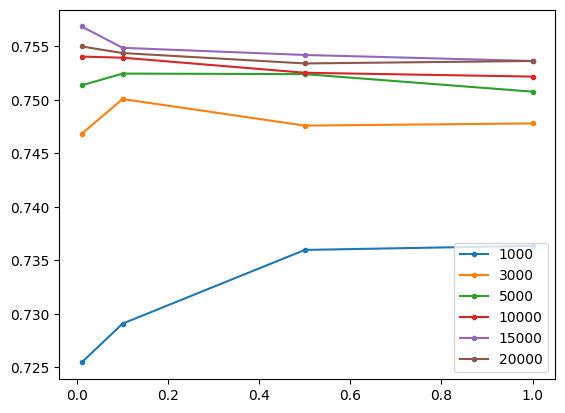

In [73]:
arr_all_f1s = np.array(all_f1s)
all_damage_grade_weights = [0.01,0.1,0.5,1,3,5,8,10,100]
for i in range(6):
    plt.plot(np.array(all_damage_grade_weights[:-5]),arr_all_f1s[:-5,i],'.-')
plt.legend(all_iterations)

In [76]:
arr_all_f1s[:,-2]

array([0.7568494 , 0.75485406, 0.75418894, 0.75362615, 0.75267964,
       0.75267964, 0.75252616, 0.75608196, 0.75539127])

### CatBoost multiple models for ensembling

#### Building ensemble models

In [ ]:
# # Prep data for catboost vanilla
# categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
#                         'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
#                         'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
# geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
# numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# # Split into train, val, test and pred sets
# X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
# df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
# df_pred_X_or = df_pred_features_raw

# # Get imputed damage grade to prep for geo-encoding
# df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, df_test_X_or,df_pred_X_or, df_train_y_or,df_val_y_or)

# # Set up architecture
# geo1_size = 16
# geo2_size = 32
# geo3_size = 64
# inter_size = 128
# latent_size = 64
# epochs = 10

# # Get latent geo-encoding
# latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
#                                               geo3_size, inter_size, latent_size, epochs)

# # Apply encoding
# df_train_X = df_train_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
# df_val_X = df_val_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
# df_test_X = df_test_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
# df_pred_X = df_pred_X_or.reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# # Get categorical feature indices and names
# categorical_features_indices = []
# for i,dtype in enumerate(df_train_X.dtypes):
#     if dtype in ['int64','int32','object','category']:
#         categorical_features_indices.append(i)

# # Create pooled dataset following catboost requirements
# train_dataset = cb.Pool(data=df_train_X, label=df_train_y_or, cat_features=categorical_features_indices)
# val_dataset = cb.Pool(data=df_val_X, label=df_val_y_or, cat_features=categorical_features_indices)
# test_dataset = cb.Pool(data=df_test_X, label=df_test_y_or, cat_features=categorical_features_indices)
# train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
#                             label=pd.concat([df_train_y_or,df_val_y_or],axis=0),
#                             cat_features=categorical_features_indices)
# train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
#                             label=pd.concat([df_train_y_or,df_val_y_or,df_test_y_or],axis=0),
#                             cat_features=categorical_features_indices)


In [13]:
# with open('multimodel_encoding_material.pkl','wb') as f:
#     pickle.dump((latent_geo,df_train_X,df_val_X,df_test_X,df_pred_X,
#                  df_train_y_or, df_val_y_or, df_test_y_or,
#                  categorical_features_indices),f)

In [15]:
# learning_rates = [0.005,0.01,0.5,0.1]
# depths = [6,8,10]
# l2_leaf_regs = [3,5,7]
# all_iterations = [1000,5000,10000,15000,20000]

# params = []
# model_num = 0

# params_file_path = 'multimodel_model_params.txt'

# with open(params_file_path, 'w') as params_file:
#     for learning_rate in learning_rates:
#         for depth in depths:
#             for l2_leaf_reg in l2_leaf_regs:
#                 for iterations in all_iterations:
#                     model_num += 1
                    
#                     # Instantiate catboost classifier model
#                     model_cls = cb.CatBoostClassifier(
#                         objective='MultiClass',  # Use 'MultiClass' for classification
#                         task_type='GPU',  # Specify GPU if available
#                         devices='0',  # Specify GPU device(s) if multiple
#                         metric_period=5000,  # Period to print metrics
#                         iterations=iterations,  # Number of boosting iterations
#                         learning_rate=learning_rate,  # Learning rate
#                         depth=depth,  # Depth of the trees
#                         l2_leaf_reg=l2_leaf_reg,  # L2 regularization coefficient
#                         custom_metric=['Accuracy']  # Additional metrics to track
#                     )

#                     model_cls.fit(train_val_dataset)

#                     # Save the model as a pickle file
#                     model_filename = f'multimodel_model_{model_num}.pkl'
#                     with open(model_filename, 'wb') as model_file:
#                         pickle.dump(model_cls, model_file)

#                     params_file.write(f'model_num: {model_num}, learning_rate: {learning_rate}, depth: {depth}, l2_leaf_reg: {l2_leaf_reg}, iterations: {iterations}\n')
#                     params_file.flush()

0:	learn: 1.0960313	total: 6.63ms	remaining: 6.63s
999:	learn: 0.7122732	total: 4.71s	remaining: 0us
0:	learn: 1.0960311	total: 4.68ms	remaining: 23.4s
4999:	learn: 0.6284039	total: 21.6s	remaining: 0us
0:	learn: 1.0960314	total: 4.72ms	remaining: 47.2s
5000:	learn: 0.6283543	total: 20.9s	remaining: 20.9s
9999:	learn: 0.5895031	total: 40.3s	remaining: 0us
0:	learn: 1.0960310	total: 4.99ms	remaining: 1m 14s
5000:	learn: 0.6283041	total: 19.5s	remaining: 39s
10000:	learn: 0.5894620	total: 39.1s	remaining: 19.5s
14999:	learn: 0.5681712	total: 58.5s	remaining: 0us
0:	learn: 1.0960315	total: 4.86ms	remaining: 1m 37s
5000:	learn: 0.6283043	total: 20.4s	remaining: 1m 1s
10000:	learn: 0.5894702	total: 40.5s	remaining: 40.5s
15000:	learn: 0.5681807	total: 59.8s	remaining: 19.9s
19999:	learn: 0.5535493	total: 1m 19s	remaining: 0us
0:	learn: 1.0960358	total: 4.69ms	remaining: 4.68s
999:	learn: 0.7127350	total: 4.03s	remaining: 0us
0:	learn: 1.0960356	total: 4.58ms	remaining: 22.9s
4999:	learn: 0.

#### Evaluation

In [8]:
# Extract model parameters/config into dataframe
with open('multimodel_model_params.txt','r') as f:
    all_lines = f.readlines()
all_lines = [line.rstrip('\n') for line in all_lines]

pattern = re.compile(r'model_num: (\d+), learning_rate: ([\d.]+), depth: (\d+), l2_leaf_reg: (\d+), iterations: (\d+)')
data = []
for line in all_lines:
    match = pattern.search(line)
    if match:
        model_num = int(match.group(1))
        learning_rate = float(match.group(2))
        depth = int(match.group(3))
        l2_leaf_reg = int(match.group(4))
        iterations = int(match.group(5))
        data.append((model_num, learning_rate, depth, l2_leaf_reg, iterations))
df = pd.DataFrame(data, columns=['model_num', 'learning_rate', 'depth', 'l2_leaf_reg', 'iterations'])

# Extract model numbers from file name for sorting
filenames = [file for file in os.listdir() if ('multimodel_model_' in file) and (file.endswith('.pkl'))]
pattern = re.compile(r'multimodel_model_(\d+).pkl')
file_nums = []
for filename in filenames:
    match = pattern.search(filename)
    if match:
        file_nums.append(int(match.group(1)))
new_order = np.argsort(np.array(file_nums))
filenames = [filenames[order] for order in new_order]

# Combine model config with filenames
df['model'] = filenames

# Load data
with open('multimodel_encoding_material.pkl','rb') as f:
    latent_geo,df_train_X,df_val_X,df_test_X,df_pred_X,\
        df_train_y_or, df_val_y_or, df_test_y_or,\
            categorical_features_indices = pickle.load(f)
    
# Load model and get predictions
preds = []
for model in df['model']:
    with open(model,'rb') as f:
        model_cls = pickle.load(f)
        pred = model_cls.predict(df_test_X)
        preds.append(np.squeeze(pred))

# Combine model config and predictions
df_model_preds = pd.concat([df, pd.DataFrame(preds)],axis=1)
display(df_model_preds)

# Get np array of ground truth
observation = np.squeeze(df_test_y_or.reset_index(drop=True).to_numpy())

model_num  learning_rate  depth  l2_leaf_reg  iterations  \
0            1          0.005      6            3        1000   
1            2          0.005      6            3        5000   
2            3          0.005      6            3       10000   
3            4          0.005      6            3       15000   
4            5          0.005      6            3       20000   
..         ...            ...    ...          ...         ...   
175        176          0.100     10            7        1000   
176        177          0.100     10            7        5000   
177        178          0.100     10            7       10000   
178        179          0.100     10            7       15000   
179        180          0.100     10            7       20000   

                        model  0  1  2  3  ...  39081  39082  39083  39084  \
0      multimodel_model_1.pkl  2  3  2  2  ...      2      3      2      2   
1      multimodel_model_2.pkl  2  3  2  2  ...      3      3      2      2   
2      multimodel_model_3.pkl  2  3  2  2  ...      3      3      2      2   
3      multimodel_model_4.pkl  2  3  2  2  ...      3      3      2      2   
4      multimodel_model_5.pkl  2  3  3  2  ...      3      3      2      2   
..                        ... .. .. .. ..  ...    ...    ...    ...    ...   
175  multimodel_model_176.pkl  2  3  3  2  ...      3      3      2      2   
176  multimodel_model_177.pkl  2  3  3  2  ...      3      3      2      2   
177  multimodel_model_178.pkl  2  3  3  2  ...      3      3      2      2   
178  multimodel_model_179.pkl  2  3  3  2  ...      3      3      2      2   
179  multimodel_model_180.pkl  2  3  3  2  ...      3      3      2      2   

     39085  39086  39087  39088  39089  39090  
0        2      2      2      2      2      3  
1        2      2      2      2      2      3  
2        2      2      2      2      2      3  
3        2      2      2      3      2      3  
4        2      2      2      3      2      3  
..     ...    ...    ...    ...    ...    ...  
175      2      2      2      3      2      3  
176      2      2      2      3      2      3  
177      2      3      2      3      2      3  
178      2      3      2      3      2      3  
179      2      3      2      2      2      3  

[180 rows x 39097 columns]

In [9]:
df_preds = df_model_preds.loc[:,0:].copy()
df_observation = df_preds.copy()
for i in range(df_observation.shape[0]):
    df_observation.loc[i,:] = observation
df_correct_preds = df_preds == df_observation

Check best performance among models in precision wrt grades 1 2 3. Even best performing ones do not seem particularly good, implying that no model is much better than another at certain classes. Targetted ensemble method probably won't help much.

In [29]:
pd.DataFrame(observation).value_counts()

0
2    22239
3    13083
1     3769
Name: count, dtype: int64

In [24]:
df_correct_preds.loc[:,observation==1].sum(axis=1).max(), df_correct_preds.loc[:,observation==1].sum(axis=1).min()

(2170, 1177)

In [25]:
df_correct_preds.loc[:,observation==2].sum(axis=1).max(), df_correct_preds.loc[:,observation==2].sum(axis=1).min()

(20164, 17412)

In [26]:
df_correct_preds.loc[:,observation==3].sum(axis=1).max(), df_correct_preds.loc[:,observation==3].sum(axis=1).min()

(8707, 5046)

### XGBoost with native cat features

#### Quick look

In [9]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X_or = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, df_test_X_or,df_pred_X_or, df_train_y_or,df_val_y_or)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = preprocess(df_train_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_val_X = preprocess(df_val_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_test_X = preprocess(df_test_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_pred_X = preprocess(df_pred_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.43it/s]


Epoch [1/10], Loss: 8.783125500484138


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 495.07it/s]


Epoch [2/10], Loss: 0.5426649676309419


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 513.79it/s]


Epoch [3/10], Loss: 0.31154229330647853


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.96it/s]


Epoch [4/10], Loss: 0.2529319992977495


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 520.49it/s]


Epoch [5/10], Loss: 0.18646423766095965


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 520.28it/s]


Epoch [6/10], Loss: 0.17371722454800434


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 510.25it/s]


Epoch [7/10], Loss: 0.13724531304634371


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 521.12it/s]


Epoch [8/10], Loss: 0.15549509516136722


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 520.99it/s]


Epoch [9/10], Loss: 0.11777491116311967


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 522.94it/s]


Epoch [10/10], Loss: 0.127283959702996


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1350.65it/s]


In [19]:
# Get categorical feature names and convert to category
categorical_features_xgb = []
for feat,dtype in df_train_X.dtypes.items():
    if dtype in ['int64','int32','object','category']:
        categorical_features_xgb.append(feat)
        
df_train_X[categorical_features_xgb] = df_train_X[categorical_features_xgb].astype('category')
df_val_X[categorical_features_xgb] = df_val_X[categorical_features_xgb].astype('category')
df_test_X[categorical_features_xgb] = df_test_X[categorical_features_xgb].astype('category')
df_pred_X[categorical_features_xgb] = df_pred_X[categorical_features_xgb].astype('category')

# Supported tree methods are `approx` and `hist`.
model_xgb = xgb.XGBClassifier(tree_method="hist", device='cuda:0',enable_categorical=True,
                              learning_rate=0.1,n_estimators=1000,
                              subsample=1,colsample_bytree=0.8,gamma=0.2)

model_xgb.fit(pd.concat([df_train_X,df_val_X],axis=0), pd.concat([df_train_y_or-1, df_val_y_or-1],axis=0))

# Evaluation
model_xgb.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
pred = model_xgb.predict(df_test_X)
acc = accuracy_score(df_test_y_or-1, pred)
f1 = f1_score(df_test_y_or-1,pred,average='micro')
print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')

Testing performance
Accuracy: 0.7560
F1-score: 0.7560


In [20]:
# Prep for further eval
pred_xgb = pd.DataFrame(pred+1)
pred_xgb['Observed'] = df_test_y_or.to_numpy()
pred_xgb.rename(columns={0:'Predicted'}, inplace=True)
pred_xgb['Correct'] = pred_xgb.apply(lambda row: int(row['Observed']==row['Predicted']),axis=1)
pred_xgb_or = pred_xgb.copy()
pred_xgb = pd.concat([pred_xgb_or.copy(),pd.DataFrame(model_xgb.predict_proba(df_test_X),columns=['prob_1','prob_2','prob_3'])],axis=1)
pred_xgb

Predicted  Observed  Correct    prob_1    prob_2    prob_3
0              2         2        1  0.039265  0.848858  0.111876
1              3         3        1  0.002936  0.164364  0.832700
2              3         3        1  0.001784  0.153575  0.844641
3              2         3        0  0.004058  0.777293  0.218649
4              2         2        1  0.004644  0.851387  0.143970
...          ...       ...      ...       ...       ...       ...
39086          2         2        1  0.020726  0.694524  0.284751
39087          2         2        1  0.053103  0.907233  0.039664
39088          3         3        1  0.001480  0.245957  0.752564
39089          2         2        1  0.028749  0.877400  0.093851
39090          2         2        1  0.005986  0.684920  0.309094

[39091 rows x 6 columns]

Text(0.5, 0, 'Probability')

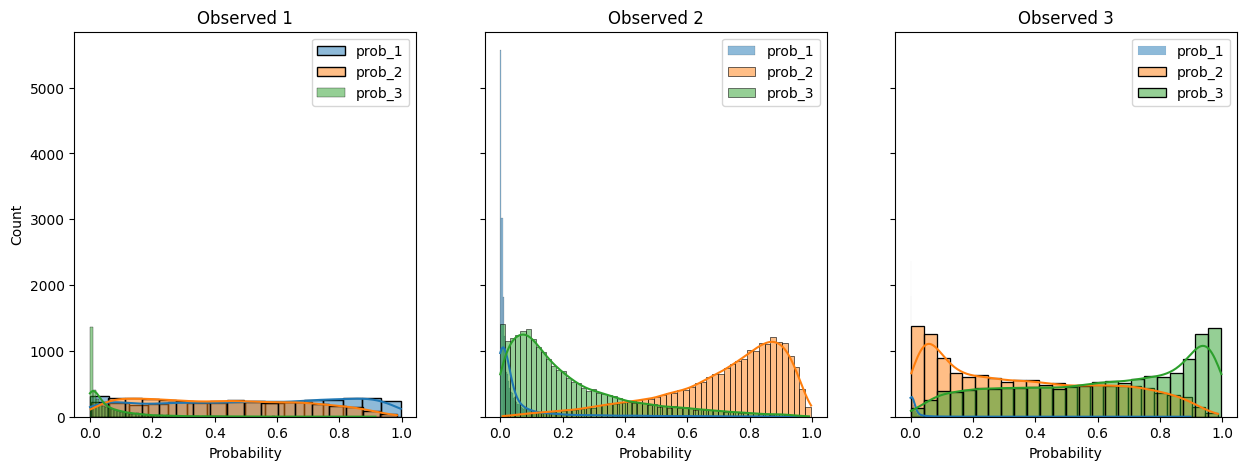

In [21]:
fig, axs = plt.subplots(1,3,figsize=(15,5), sharey=True)
# fig, axs = plt.subplots(1,3,figsize=(15,5))
sns.histplot(pred_xgb[pred_xgb['Observed']==1]['prob_1'], label='prob_1', kde=True, ax=axs[0])
sns.histplot(pred_xgb[pred_xgb['Observed']==1]['prob_2'], label='prob_2', kde=True, ax=axs[0])
sns.histplot(pred_xgb[pred_xgb['Observed']==1]['prob_3'], label='prob_3', kde=True, ax=axs[0])
axs[0].legend()
axs[0].set_title('Observed 1')
axs[0].set_xlabel('Probability')

sns.histplot(pred_xgb[pred_xgb['Observed']==2]['prob_1'], label='prob_1', kde=True, ax=axs[1])
sns.histplot(pred_xgb[pred_xgb['Observed']==2]['prob_2'], label='prob_2', kde=True, ax=axs[1])
sns.histplot(pred_xgb[pred_xgb['Observed']==2]['prob_3'], label='prob_3', kde=True, ax=axs[1])
axs[1].legend()
axs[1].set_title('Observed 2')
axs[1].set_xlabel('Probability')

sns.histplot(pred_xgb[pred_xgb['Observed']==3]['prob_1'], label='prob_1', kde=True, ax=axs[2])
sns.histplot(pred_xgb[pred_xgb['Observed']==3]['prob_2'], label='prob_2', kde=True, ax=axs[2])
sns.histplot(pred_xgb[pred_xgb['Observed']==3]['prob_3'], label='prob_3', kde=True, ax=axs[2])
axs[2].legend()
axs[2].set_title('Observed 3')
axs[2].set_xlabel('Probability')

In [22]:
pred_xgb.groupby(['Observed','Predicted']).mean().drop(columns=['Correct'])

prob_1    prob_2    prob_3
Observed Predicted                              
1        1          0.743841  0.231549  0.024611
         2          0.232020  0.673659  0.094322
         3          0.094125  0.287121  0.618755
2        1          0.642105  0.322454  0.035441
         2          0.052930  0.779656  0.167414
         3          0.009321  0.332501  0.658178
3        1          0.644136  0.282885  0.072979
         2          0.031516  0.692169  0.276316
         3          0.005311  0.199603  0.795086

In [23]:
pred_xgb.groupby(['Observed','Predicted']).count()[['prob_1']].rename(columns={'prob_1':'Count'})

Count
Observed Predicted       
1        1           2079
         2           1631
         3             59
2        1            851
         2          18943
         3           2445
3        1             69
         2           4484
         3           8530

#### Grid Search

In [13]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X_or = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, df_test_X_or,df_pred_X_or, df_train_y_or,df_val_y_or)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = preprocess(df_train_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_val_X = preprocess(df_val_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_test_X = preprocess(df_test_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_pred_X = preprocess(df_pred_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature names and convert to category
categorical_features_xgb = []
for feat,dtype in df_train_X.dtypes.items():
    if dtype in ['int64','int32','object','category']:
        categorical_features_xgb.append(feat)
        
df_train_X[categorical_features_xgb] = df_train_X[categorical_features_xgb].astype('category')
df_val_X[categorical_features_xgb] = df_val_X[categorical_features_xgb].astype('category')
df_test_X[categorical_features_xgb] = df_test_X[categorical_features_xgb].astype('category')
df_pred_X[categorical_features_xgb] = df_pred_X[categorical_features_xgb].astype('category')

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.64it/s]


Epoch [1/10], Loss: 7.815219757439286


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.82it/s]


Epoch [2/10], Loss: 0.5364740545229111


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 518.84it/s]


Epoch [3/10], Loss: 0.3107211119461042


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.54it/s]


Epoch [4/10], Loss: 0.229438435242392


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.81it/s]


Epoch [5/10], Loss: 0.20493509706290813


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.17it/s]


Epoch [6/10], Loss: 0.1555231671632214


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.44it/s]


Epoch [7/10], Loss: 0.1403827776718166


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 513.88it/s]


Epoch [8/10], Loss: 0.13206020457634432


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 509.23it/s]


Epoch [9/10], Loss: 0.1583577274305085


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 499.91it/s]


Epoch [10/10], Loss: 0.10281817675382997


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1268.26it/s]


In [31]:
all_n_estimators = [1000,1500,2000,2500]
all_max_depth = [5,7]
all_learning_rate = [0.1,0.2]
all_subsample = [0.8,1]
all_colsample_bytree = [0.8,1]
all_gamma = [0,0.2]
counter = 0

results= []

for n_estimators in all_n_estimators:
    for max_depth in all_max_depth:
        for learning_rate in all_learning_rate:
            for subsample in all_subsample:
                for colsample_bytree in all_colsample_bytree:
                    for gamma in all_gamma:
                        start_time = time.time()
                        counter += 1
                        model_xgb =  xgb.XGBClassifier(tree_method="hist", enable_categorical=True, device="cuda",
                                                       n_estimators=n_estimators, max_depth = max_depth,
                                                       learning_rate=learning_rate, subsample=subsample,
                                                       colsample_bytree=colsample_bytree)
                        model_xgb.fit(pd.concat([df_train_X,df_val_X],axis=0),pd.concat([df_train_y_or,df_val_y_or],axis=0)-1)

                        # Evaluation
                        pred = model_xgb.predict(df_test_X)
                        acc = accuracy_score(df_test_y_or-1, pred)
                        f1 = f1_score(df_test_y_or-1,pred,average='micro')

                        outstring = f'model: {counter}, n_estimators: {n_estimators}, max_depth: {max_depth}, learning_rate: {learning_rate}, subsample: {subsample}, colsample_bytree: {colsample_bytree}, gamma: {gamma}\n'
                        end_time = time.time()
                        elapsed_time = end_time - start_time

                        print('\n\n')
                        print(outstring)
                        print(f'Time taken = {elapsed_time}')
                        print(f'Accuracy: {acc:.4f}')
                        print(f'F1-score: {f1:.4f}\n\n')
                        results.append((counter,n_estimators,max_depth, learning_rate, subsample, colsample_bytree, gamma,acc,f1))




model: 1, n_estimators: 1000, max_depth: 5, learning_rate: 0.1, subsample: 0.8, colsample_bytree: 0.8, gamma: 0

Time taken = 9.265103340148926
Accuracy: 0.7546
F1-score: 0.7546





model: 2, n_estimators: 1000, max_depth: 5, learning_rate: 0.1, subsample: 0.8, colsample_bytree: 0.8, gamma: 0.2

Time taken = 9.2436842918396
Accuracy: 0.7546
F1-score: 0.7546





model: 3, n_estimators: 1000, max_depth: 5, learning_rate: 0.1, subsample: 0.8, colsample_bytree: 1, gamma: 0

Time taken = 9.103893518447876
Accuracy: 0.7550
F1-score: 0.7550





model: 4, n_estimators: 1000, max_depth: 5, learning_rate: 0.1, subsample: 0.8, colsample_bytree: 1, gamma: 0.2

Time taken = 9.051905632019043
Accuracy: 0.7550
F1-score: 0.7550





model: 5, n_estimators: 1000, max_depth: 5, learning_rate: 0.1, subsample: 1, colsample_bytree: 0.8, gamma: 0

Time taken = 8.949115753173828
Accuracy: 0.7544
F1-score: 0.7544





model: 6, n_estimators: 1000, max_depth: 5, learning_rate: 0.1, subsample: 1, colsampl

In [44]:
results_df = pd.DataFrame(results,columns=['Model','n_estimators','max_depth',
                              'learning_rate','subsample','colsample_bytree',
                              'gamma','acc','f1'])

results_df.to_csv('temp_param_xgbclassifier.csv',index=None)

In [13]:
results_df= pd.read_csv('temp_param_xgbclassifier.csv')
results_df

Model  n_estimators  max_depth  learning_rate  subsample  \
0        1          1000          5            0.1        0.8   
1        2          1000          5            0.1        0.8   
2        3          1000          5            0.1        0.8   
3        4          1000          5            0.1        0.8   
4        5          1000          5            0.1        1.0   
..     ...           ...        ...            ...        ...   
123    124          2500          7            0.2        0.8   
124    125          2500          7            0.2        1.0   
125    126          2500          7            0.2        1.0   
126    127          2500          7            0.2        1.0   
127    128          2500          7            0.2        1.0   

     colsample_bytree  gamma       acc        f1  
0                 0.8    0.0  0.754573  0.754573  
1                 0.8    0.2  0.754573  0.754573  
2                 1.0    0.0  0.755008  0.755008  
3                 1.0    0.2  0.755008  0.755008  
4                 0.8    0.0  0.754419  0.754419  
..                ...    ...       ...       ...  
123               1.0    0.2  0.739198  0.739198  
124               0.8    0.0  0.737715  0.737715  
125               0.8    0.2  0.737715  0.737715  
126               1.0    0.0  0.736973  0.736973  
127               1.0    0.2  0.736973  0.736973  

[128 rows x 9 columns]

<Axes: xlabel='learning_rate', ylabel='f1'>

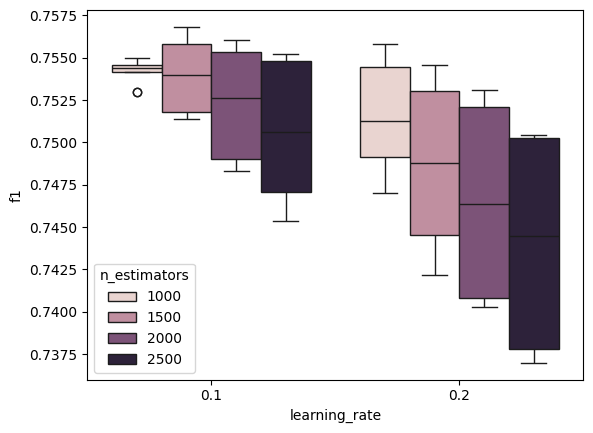

In [14]:
sns.boxplot(results_df,x='learning_rate',hue='n_estimators',y='f1')

<Axes: xlabel='n_estimators', ylabel='f1'>

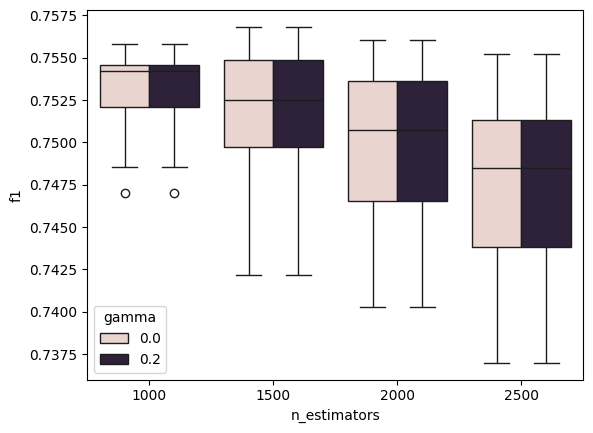

In [24]:
sns.boxplot(results_df,x='n_estimators',hue='gamma',y='f1')

### Ensemble XGBoost, CatBoost, LightGBM (and OrdinalGBM?)

Dropping ordinal, behaviour too weird with 60% cut off for damage grade 2, and messing with lightgbm version.

In [9]:
# Shared latent geo for all models
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X_or = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, df_test_X_or,df_pred_X_or, df_train_y_or,df_val_y_or)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = preprocess(df_train_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_val_X = preprocess(df_val_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_test_X = preprocess(df_test_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_pred_X = preprocess(df_pred_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 485.84it/s]


Epoch [1/10], Loss: 8.518138703128901


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.99it/s]


Epoch [2/10], Loss: 0.6752683510331764


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 504.78it/s]


Epoch [3/10], Loss: 0.32015520645873363


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.59it/s]


Epoch [4/10], Loss: 0.23813154034876155


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.59it/s]


Epoch [5/10], Loss: 0.20791849314573937


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.63it/s]


Epoch [6/10], Loss: 0.16636563845757885


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 504.96it/s]


Epoch [7/10], Loss: 0.15313955309728108


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.43it/s]


Epoch [8/10], Loss: 0.13757619278749592


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.12it/s]


Epoch [9/10], Loss: 0.15758901716529533


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 501.73it/s]


Epoch [10/10], Loss: 0.13474406858848542


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1316.08it/s]


In [10]:
# Train catboost
# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y_or, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y_or, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y_or, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y_or,df_val_y_or],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y_or,df_val_y_or,df_test_y_or],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=5000,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred_cls = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y_or, pred_cls)
f1 = f1_score(df_test_y_or,pred_cls,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')

0:	learn: 1.0933970	total: 11.4ms	remaining: 3m 48s
5000:	learn: 0.5409876	total: 42.9s	remaining: 2m 8s
10000:	learn: 0.4992720	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4704729	total: 2m 5s	remaining: 41.8s
19999:	learn: 0.4468255	total: 2m 47s	remaining: 0us
Testing performance
Accuracy: 0.7549
F1-score: 0.7549


In [11]:
# Train xgboost
# Get categorical feature names and convert to category
categorical_features_xgb = []
for feat,dtype in df_train_X.dtypes.items():
    if dtype in ['int64','int32','object','category']:
        categorical_features_xgb.append(feat)
        
df_train_X[categorical_features_xgb] = df_train_X[categorical_features_xgb].astype('category')
df_val_X[categorical_features_xgb] = df_val_X[categorical_features_xgb].astype('category')
df_test_X[categorical_features_xgb] = df_test_X[categorical_features_xgb].astype('category')
df_pred_X[categorical_features_xgb] = df_pred_X[categorical_features_xgb].astype('category')

# Supported tree methods are `approx` and `hist`.
model_xgb = xgb.XGBClassifier(tree_method="hist", device='cuda:0',enable_categorical=True,
                              learning_rate=0.1,n_estimators=1000,
                              subsample=1,colsample_bytree=0.8,gamma=0.2)

model_xgb.fit(pd.concat([df_train_X,df_val_X],axis=0), pd.concat([df_train_y_or-1, df_val_y_or-1],axis=0))

# Evaluation
model_xgb.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
pred_xgb = model_xgb.predict(df_test_X)+1
acc = accuracy_score(df_test_y_or, pred_xgb)
f1 = f1_score(df_test_y_or,pred_xgb,average='micro')
print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')

Testing performance
Accuracy: 0.7545
F1-score: 0.7545


In [21]:
# Train lightgbm
categorical_features_lgb = []
for feat,dtype in df_train_X.dtypes.items():
    if dtype in ['int64','int32','object','category']:
        categorical_features_lgb.append(feat)
        
df_train_X[categorical_features_lgb] = df_train_X[categorical_features_lgb].astype('category')
df_val_X[categorical_features_lgb] = df_val_X[categorical_features_lgb].astype('category')
df_test_X[categorical_features_lgb] = df_test_X[categorical_features_lgb].astype('category')
df_pred_X[categorical_features_lgb] = df_pred_X[categorical_features_lgb].astype('category')

train_val_data = lgb.Dataset(pd.concat([df_train_X,df_val_X],axis=0),
                             label=pd.concat([df_train_y_or,df_val_y_or],axis=0)-1,
                             categorical_feature=categorical_features_lgb)
test_data = lgb.Dataset(df_test_X, label=df_test_y_or-1,
                        categorical_feature=categorical_features_lgb,
                        reference=train_val_data)

# Define model parameters
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 80,
    'max_depth': 8,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'device':'gpu'
}

callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)]

# Train the model
model_lgb = lgb.train(
    params,
    train_val_data,
    valid_sets=[train_val_data, test_data],
    valid_names=['train', 'valid'],
    num_boost_round=1500,
    callbacks=callbacks
)

# # Save the model
# model.save_model('lightgbm_model.txt')

# Predict on test data
pred_lgb = model_lgb.predict(df_test_X, num_iteration=model_lgb.best_iteration)
pred_lgb = np.array([list(x).index(max(x)) for x in pred_lgb]) +1 # For multiclass classification

# Evaluation
acc = accuracy_score(df_test_y_or, pred_lgb)
f1 = f1_score(df_test_y_or,pred_lgb,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[890]	train's multi_logloss: 0.431741	valid's multi_logloss: 0.551315
Testing performance
Accuracy: 0.7564
F1-score: 0.7564


In [13]:
# # Train OrdinalGBM
# # Train lightgbm
# categorical_features_lgb = []
# for feat,dtype in df_train_X.dtypes.items():
#     if dtype in ['int64','int32','object','category']:
#         categorical_features_lgb.append(feat)
        
# df_train_X[categorical_features_lgb] = df_train_X[categorical_features_lgb].astype('category')
# df_val_X[categorical_features_lgb] = df_val_X[categorical_features_lgb].astype('category')
# df_test_X[categorical_features_lgb] = df_test_X[categorical_features_lgb].astype('category')
# df_pred_X[categorical_features_lgb] = df_pred_X[categorical_features_lgb].astype('category')

# params = {
#     'objective': 'multiclass',
#     # 'num_class': 3,
#     # 'metric': 'multi_logloss',
#     'boosting_type': 'gbdt',
#     'learning_rate': 0.05,
#     'num_leaves': 80,
#     'max_depth': 8,
#     'feature_fraction': 0.6,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': -1,
#     'n_estimators':1500,
#     # 'device':'gpu'
# }

# model_lgb_ord = LGBMOrdinal(**params)
# model_lgb_ord.fit(df_train_X,np.squeeze((df_train_y_or-1).to_numpy())) # NOTE WARNING: made changes to original ordinalgbt script, commented out early stopping rounds

# pred_lgb_ord = model_lgb_ord.predict(df_test_X)+1

# # Evaluation
# acc = accuracy_score(df_test_y_or, pred_lgb_ord)
# f1 = f1_score(df_test_y_or,pred_lgb_ord,average='micro')

# print('Testing performance')
# print(f'Accuracy: {acc:.4f}')
# print(f'F1-score: {f1:.4f}')

In [15]:
df_cls_xgb_lgb = pd.DataFrame(np.vstack([np.squeeze(df_test_y_or.to_numpy()),
                                         np.squeeze(pred_cls),
                                         pred_xgb,
                                         np.array(pred_lgb),
                                        #  pred_lgb_ord
                                         ]).T,
                                         columns=['observed','pred_cls','pred_xgb','pred_lgb',
                                                #   'pred_lgb_ord'
                                                  ])
df_cls_xgb_lgb['correct_cls'] = df_cls_xgb_lgb['observed'] == df_cls_xgb_lgb['pred_cls']
df_cls_xgb_lgb['correct_xgb'] = df_cls_xgb_lgb['observed'] == df_cls_xgb_lgb['pred_xgb']
df_cls_xgb_lgb['correct_lgb'] = df_cls_xgb_lgb['observed'] == df_cls_xgb_lgb['pred_lgb']
# df_cls_xgb_lgb['correct_lgb_ord'] = df_cls_xgb_lgb['observed'] == df_cls_xgb_lgb['pred_lgb_ord']

df_cls_xgb_lgb = df_cls_xgb_lgb.astype(int)
# df_cls_xgb_lgb['sum_correct'] = df_cls_xgb_lgb['correct_cls'] + df_cls_xgb_lgb['correct_xgb'] + df_cls_xgb_lgb['correct_lgb'] + df_cls_xgb_lgb['correct_lgb_ord']

In [16]:
# Define function to calculate mode or rounded mean
def mode_or_mean(row, columns):
    values = row[columns].values
    mode_result = stats.mode(values, nan_policy='omit')
    if mode_result.count > 1:  # Mode exists
        return mode_result.mode
    else:  # Mode does not exist, return rounded mean
        return round(np.mean(values))

In [17]:
# Mode first ensembling
df_cls_xgb_lgb['pred_x_c_l'] = df_cls_xgb_lgb.apply(lambda row: mode_or_mean(row,['pred_cls','pred_xgb','pred_lgb']), axis=1)
# df_cls_xgb_lgb['pred_x_c_lo'] = df_cls_xgb_lgb.apply(lambda row: mode_or_mean(row,['pred_cls','pred_xgb','pred_lgb_ord']), axis=1)
# df_cls_xgb_lgb['pred_x_c_l_lo'] = df_cls_xgb_lgb.apply(lambda row: mode_or_mean(row,['pred_cls','pred_xgb','pred_lgb','pred_lgb_ord']), axis=1)
df_cls_xgb_lgb['pred_x_c_l_correct'] = df_cls_xgb_lgb['observed'] == df_cls_xgb_lgb['pred_x_c_l']
# df_cls_xgb_lgb['pred_x_c_lo_correct'] = df_cls_xgb_lgb['observed'] == df_cls_xgb_lgb['pred_x_c_lo']
# df_cls_xgb_lgb['pred_x_c_l_lo_correct'] = df_cls_xgb_lgb['observed'] == df_cls_xgb_lgb['pred_x_c_l_lo']
df_cls_xgb_lgb[[col for col in df_cls_xgb_lgb.columns if ('correct' in col)]].sum()


correct_cls           29509
correct_xgb           29494
correct_lgb           29482
pred_x_c_l_correct    29529
dtype: int64

In [18]:
# Mean ensembling
df_cls_xgb_lgb['pred_x_c_l'] = np.round(df_cls_xgb_lgb[['pred_cls','pred_xgb','pred_lgb']].mean(axis=1))
# df_cls_xgb_lgb['pred_x_c_lo'] = np.round(df_cls_xgb_lgb[['pred_cls','pred_xgb','pred_lgb_ord']].mean(axis=1))
# df_cls_xgb_lgb['pred_x_c_l_lo'] = np.round(df_cls_xgb_lgb[['pred_cls','pred_xgb','pred_lgb','pred_lgb_ord']].mean(axis=1))
df_cls_xgb_lgb['pred_x_c_l_correct'] = df_cls_xgb_lgb['observed'] == df_cls_xgb_lgb['pred_x_c_l']
# df_cls_xgb_lgb['pred_x_c_lo_correct'] = df_cls_xgb_lgb['observed'] == df_cls_xgb_lgb['pred_x_c_lo']
# df_cls_xgb_lgb['pred_x_c_l_lo_correct'] = df_cls_xgb_lgb['observed'] == df_cls_xgb_lgb['pred_x_c_l_lo']
df_cls_xgb_lgb[[col for col in df_cls_xgb_lgb.columns if ('correct' in col)]].sum()


correct_cls           29509
correct_xgb           29494
correct_lgb           29482
pred_x_c_l_correct    29528
dtype: int64

### Ensemble XGBoost, catboost and lightgbm, multiple instances

In [9]:
def get_latent_geo_config_1():
    # Shared latent ge`o for all models
    categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                            'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                            'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
    geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
    numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

    # Split into train, val, test and pred sets
    X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
    df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
    df_pred_X_or = df_pred_features_raw

    # Get imputed damage grade to prep for geo-encoding
    df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, df_test_X_or,df_pred_X_or, df_train_y_or,df_val_y_or)

    # Set up architecture
    geo1_size = 16
    geo2_size = 32
    geo3_size = 64
    inter_size = 128
    latent_size = 64
    epochs = 10

    # Get latent geo-encoding
    latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                                geo3_size, inter_size, latent_size, epochs)

    # Apply encoding
    df_train_X = preprocess(df_train_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
    df_val_X = preprocess(df_val_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
    df_test_X = preprocess(df_test_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
    df_pred_X = preprocess(df_pred_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

    df_train_X.drop(columns=geo_features, inplace=True)
    df_val_X.drop(columns=geo_features, inplace=True)
    df_test_X.drop(columns=geo_features, inplace=True)
    df_pred_X.drop(columns=geo_features, inplace=True)

    # Get categorical feature names and convert to category
    categorical_feature_names = []
    for feat,dtype in df_train_X.dtypes.items():
        if dtype in ['int64','int32','object','category']:
            categorical_feature_names.append(feat)
    
    df_train_X[categorical_feature_names] = df_train_X[categorical_feature_names].astype('category')
    df_val_X[categorical_feature_names] = df_val_X[categorical_feature_names].astype('category')
    df_test_X[categorical_feature_names] = df_test_X[categorical_feature_names].astype('category')
    df_pred_X[categorical_feature_names] = df_pred_X[categorical_feature_names].astype('category')

    return df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or

In [29]:
def catboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or):
    # Train catboost
    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_train_X.dtypes):
        if dtype in ['int64','int32','object','category']:
            categorical_features_indices.append(i)

    # Create pooled dataset following catboost requirements
    train_dataset = cb.Pool(data=df_train_X, label=df_train_y_or, cat_features=categorical_features_indices)
    val_dataset = cb.Pool(data=df_val_X, label=df_val_y_or, cat_features=categorical_features_indices)
    test_dataset = cb.Pool(data=df_test_X, label=df_test_y_or, cat_features=categorical_features_indices)
    train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y_or,df_val_y_or],axis=0),
                                cat_features=categorical_features_indices)
    train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                                label=pd.concat([df_train_y_or,df_val_y_or,df_test_y_or],axis=0),
                                cat_features=categorical_features_indices)

    # Instantiate catboost classifier model
    model_cls = cb.CatBoostClassifier(
        objective='MultiClass',  # Use 'MultiClass' for classification
        task_type='GPU',  # Specify GPU if available
        devices='0',  # Specify GPU device(s) if multiple
        metric_period=5000,  # Period to print metrics
        iterations=20000,  # Number of boosting iterations
        learning_rate=0.01,  # Learning rate
        depth=8,  # Depth of the trees
        l2_leaf_reg=5,  # L2 regularization coefficient
        custom_metric=['Accuracy']  # Additional metrics to track
    )

    model_cls.fit(train_val_dataset)

    # Evaluation
    pred_cls = model_cls.predict(df_test_X)
    acc = accuracy_score(df_test_y_or, pred_cls)
    f1 = f1_score(df_test_y_or,pred_cls,average='micro')

    print('Testing performance')
    print(f'Accuracy: {acc:.4f}')
    print(f'F1-score: {f1:.4f}')
    return pred_cls

def xgboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or):
    # Train xgboost
    # Get categorical feature names and convert to category
    categorical_features_xgb = []
    for feat,dtype in df_train_X.dtypes.items():
        if dtype in ['int64','int32','object','category']:
            categorical_features_xgb.append(feat)

    # Supported tree methods are `approx` and `hist`.
    model_xgb = xgb.XGBClassifier(tree_method="hist", device='cuda:0',enable_categorical=True,
                                learning_rate=0.1,n_estimators=1000,
                                subsample=1,colsample_bytree=0.8,gamma=0.2)

    model_xgb.fit(pd.concat([df_train_X,df_val_X],axis=0), pd.concat([df_train_y_or-1, df_val_y_or-1],axis=0))

    # Evaluation
    model_xgb.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
    pred_xgb = model_xgb.predict(df_test_X)+1
    acc = accuracy_score(df_test_y_or, pred_xgb)
    f1 = f1_score(df_test_y_or,pred_xgb,average='micro')
    print('Testing performance')
    print(f'Accuracy: {acc:.4f}')
    print(f'F1-score: {f1:.4f}')
    return pred_xgb

def lgb_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or):
    # Train lightgbm
    categorical_features_lgb = []
    for feat,dtype in df_train_X.dtypes.items():
        if dtype in ['int64','int32','object','category']:
            categorical_features_lgb.append(feat)

    train_val_data = lgb.Dataset(pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y_or,df_val_y_or],axis=0)-1,
                                categorical_feature=categorical_features_lgb)
    test_data = lgb.Dataset(df_test_X, label=df_test_y_or-1,
                            categorical_feature=categorical_features_lgb,
                            reference=train_val_data)

    # Define model parameters
    params = {
        'objective': 'multiclass',
        'num_class': 3,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 80,
        'max_depth': 8,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'device':'gpu'
    }

    callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)]

    # Train the model
    model_lgb = lgb.train(
        params,
        train_val_data,
        valid_sets=[train_val_data, test_data],
        valid_names=['train', 'valid'],
        num_boost_round=1500,
        callbacks=callbacks
    )

    # # Save the model
    # model.save_model('lightgbm_model.txt')

    # Predict on test data
    pred_lgb = model_lgb.predict(df_test_X, num_iteration=model_lgb.best_iteration)
    pred_lgb = np.array([list(x).index(max(x)) for x in pred_lgb]) +1 # For multiclass classification

    # Evaluation
    acc = accuracy_score(df_test_y_or, pred_lgb)
    f1 = f1_score(df_test_y_or,pred_lgb,average='micro')

    print('Testing performance')
    print(f'Accuracy: {acc:.4f}')
    print(f'F1-score: {f1:.4f}')
    return pred_lgb

In [30]:
df_train_X, df_val_X, df_test_X, df_pred_X,\
    df_train_y_or, df_val_y_or, df_test_y_or = get_latent_geo_config_1()

pred_cls = catboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or)
pred_xgb = xgboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or)
pred_lgb = lgb_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or)

Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.96it/s]


Epoch [1/10], Loss: 8.630543760505446


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 452.72it/s]


Epoch [2/10], Loss: 0.5470366811431912


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.55it/s]


Epoch [3/10], Loss: 0.30032107771671923


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.09it/s]


Epoch [4/10], Loss: 0.22940251590555125


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.30it/s]


Epoch [5/10], Loss: 0.19584911643624833


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.38it/s]


Epoch [6/10], Loss: 0.1659801378023203


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.00it/s]


Epoch [7/10], Loss: 0.142437609313097


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.32it/s]


Epoch [8/10], Loss: 0.12423131131019789


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.99it/s]


Epoch [9/10], Loss: 0.12398880234040287


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.47it/s]


Epoch [10/10], Loss: 0.1028708931407034


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1258.68it/s]


0:	learn: 1.0934489	total: 8.75ms	remaining: 2m 54s
5000:	learn: 0.5393327	total: 42.7s	remaining: 2m 7s
10000:	learn: 0.4976876	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4687292	total: 2m 6s	remaining: 42.2s
19999:	learn: 0.4451707	total: 2m 48s	remaining: 0us
Testing performance
Accuracy: 0.7558
F1-score: 0.7558
Testing performance
Accuracy: 0.7560
F1-score: 0.7560
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[855]	train's multi_logloss: 0.433539	valid's multi_logloss: 0.550983
Testing performance
Accuracy: 0.7543
F1-score: 0.7543


In [31]:
df_train_X, df_val_X, df_test_X, df_pred_X,\
    df_train_y_or, df_val_y_or, df_test_y_or = get_latent_geo_config_1()

pred_cls = catboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or)
pred_xgb = xgboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or)
pred_lgb = lgb_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or)

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.42it/s]


Epoch [1/10], Loss: 8.011075106609903


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.02it/s]


Epoch [2/10], Loss: 0.5811649103908195


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.15it/s]


Epoch [3/10], Loss: 0.34019355170856697


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.21it/s]


Epoch [4/10], Loss: 0.26984491062642724


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.32it/s]


Epoch [5/10], Loss: 0.1790886752044066


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.19it/s]


Epoch [6/10], Loss: 0.16909865181843733


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.91it/s]


Epoch [7/10], Loss: 0.17723068316221588


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.25it/s]


Epoch [8/10], Loss: 0.11492433654355634


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.69it/s]


Epoch [9/10], Loss: 0.12492840969180674


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.28it/s]


Epoch [10/10], Loss: 0.10908389738205387


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1217.13it/s]


0:	learn: 1.0930119	total: 10.4ms	remaining: 3m 27s
5000:	learn: 0.5385058	total: 42.9s	remaining: 2m 8s
10000:	learn: 0.4971692	total: 1m 25s	remaining: 1m 24s
15000:	learn: 0.4686018	total: 2m 6s	remaining: 42.3s
19999:	learn: 0.4453139	total: 2m 48s	remaining: 0us
Testing performance
Accuracy: 0.7570
F1-score: 0.7570
Testing performance
Accuracy: 0.7558
F1-score: 0.7558
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[831]	train's multi_logloss: 0.436122	valid's multi_logloss: 0.551519
Testing performance
Accuracy: 0.7558
F1-score: 0.7558


In [37]:
preds = []
for i in range(12):
    df_train_X, df_val_X, df_test_X, df_pred_X,\
    df_train_y_or, df_val_y_or, df_test_y_or = get_latent_geo_config_1()

    preds.append(np.squeeze(catboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or)))
    preds.append(xgboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or))
    preds.append(lgb_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or))

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.50it/s]


Epoch [1/10], Loss: 8.503242556011203


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.39it/s]


Epoch [2/10], Loss: 0.5880353429158587


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.81it/s]


Epoch [3/10], Loss: 0.2814979669974022


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.51it/s]


Epoch [4/10], Loss: 0.23825982379259347


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.68it/s]


Epoch [5/10], Loss: 0.20469051144402667


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.32it/s]


Epoch [6/10], Loss: 0.15107109266523935


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.58it/s]


Epoch [7/10], Loss: 0.14065189646976686


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.80it/s]


Epoch [8/10], Loss: 0.138146129808497


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.70it/s]


Epoch [9/10], Loss: 0.14724685431393592


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.19it/s]


Epoch [10/10], Loss: 0.10160931773807452


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1221.94it/s]


0:	learn: 1.0932095	total: 10.3ms	remaining: 3m 25s
5000:	learn: 0.5389932	total: 41.4s	remaining: 2m 4s
10000:	learn: 0.4973633	total: 1m 23s	remaining: 1m 23s
15000:	learn: 0.4682257	total: 2m 6s	remaining: 42.2s
19999:	learn: 0.4448013	total: 2m 50s	remaining: 0us
Testing performance
Accuracy: 0.7565
F1-score: 0.7565
Testing performance
Accuracy: 0.7549
F1-score: 0.7549
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[907]	train's multi_logloss: 0.428425	valid's multi_logloss: 0.549502
Testing performance
Accuracy: 0.7576
F1-score: 0.7576


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.59it/s]


Epoch [1/10], Loss: 9.142455975112227


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.11it/s]


Epoch [2/10], Loss: 0.5493736436949914


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.45it/s]


Epoch [3/10], Loss: 0.29997643755422426


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.46it/s]


Epoch [4/10], Loss: 0.2637255962318103


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 440.62it/s]


Epoch [5/10], Loss: 0.20104678542475285


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 439.93it/s]


Epoch [6/10], Loss: 0.14486784364517905


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.03it/s]


Epoch [7/10], Loss: 0.16853381949305446


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.49it/s]


Epoch [8/10], Loss: 0.1318610217888594


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.23it/s]


Epoch [9/10], Loss: 0.12231490132433194


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.91it/s]


Epoch [10/10], Loss: 0.11288653018257536


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1224.89it/s]


0:	learn: 1.0932437	total: 10.9ms	remaining: 3m 37s
5000:	learn: 0.5394721	total: 43.7s	remaining: 2m 10s
10000:	learn: 0.4980029	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4690459	total: 2m 6s	remaining: 42.1s
19999:	learn: 0.4453774	total: 2m 47s	remaining: 0us
Testing performance
Accuracy: 0.7565
F1-score: 0.7565
Testing performance
Accuracy: 0.7564
F1-score: 0.7564
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[809]	train's multi_logloss: 0.439073	valid's multi_logloss: 0.549686
Testing performance
Accuracy: 0.7571
F1-score: 0.7571


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.15it/s]


Epoch [1/10], Loss: 9.068657257639432


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.33it/s]


Epoch [2/10], Loss: 0.6281717826717907


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.32it/s]


Epoch [3/10], Loss: 0.3538927462758477


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.42it/s]


Epoch [4/10], Loss: 0.2561329209214194


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.87it/s]


Epoch [5/10], Loss: 0.21512918540760764


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.10it/s]


Epoch [6/10], Loss: 0.16380907882372567


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.48it/s]


Epoch [7/10], Loss: 0.15702371782896182


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.41it/s]


Epoch [8/10], Loss: 0.145391084015128


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.50it/s]


Epoch [9/10], Loss: 0.1086966525571248


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.49it/s]


Epoch [10/10], Loss: 0.12283754893283692


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1258.34it/s]


0:	learn: 1.0932874	total: 9.72ms	remaining: 3m 14s
5000:	learn: 0.5420901	total: 41.2s	remaining: 2m 3s
10000:	learn: 0.5000127	total: 1m 21s	remaining: 1m 21s
15000:	learn: 0.4711879	total: 2m 1s	remaining: 40.6s
19999:	learn: 0.4479676	total: 2m 43s	remaining: 0us
Testing performance
Accuracy: 0.7567
F1-score: 0.7567
Testing performance
Accuracy: 0.7560
F1-score: 0.7560
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[930]	train's multi_logloss: 0.428034	valid's multi_logloss: 0.550772
Testing performance
Accuracy: 0.7559
F1-score: 0.7559


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.23it/s]


Epoch [1/10], Loss: 8.505107079628466


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.55it/s]


Epoch [2/10], Loss: 0.5680095144109979


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.31it/s]


Epoch [3/10], Loss: 0.30658818182805675


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.17it/s]


Epoch [4/10], Loss: 0.2520153438548979


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.19it/s]


Epoch [5/10], Loss: 0.224151741342951


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.11it/s]


Epoch [6/10], Loss: 0.16518121837625974


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.75it/s]


Epoch [7/10], Loss: 0.15354588390526874


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.74it/s]


Epoch [8/10], Loss: 0.1357366203334572


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.49it/s]


Epoch [9/10], Loss: 0.11825929189838787


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 444.19it/s]


Epoch [10/10], Loss: 0.11550867295959781


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1284.86it/s]


0:	learn: 1.0931312	total: 9.48ms	remaining: 3m 9s
5000:	learn: 0.5396556	total: 42.2s	remaining: 2m 6s
10000:	learn: 0.4980443	total: 1m 23s	remaining: 1m 23s
15000:	learn: 0.4694068	total: 2m 6s	remaining: 42s
19999:	learn: 0.4459895	total: 2m 47s	remaining: 0us
Testing performance
Accuracy: 0.7566
F1-score: 0.7566
Testing performance
Accuracy: 0.7547
F1-score: 0.7547
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[894]	train's multi_logloss: 0.429983	valid's multi_logloss: 0.549992
Testing performance
Accuracy: 0.7553
F1-score: 0.7553


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.32it/s]


Epoch [1/10], Loss: 8.663135152502159


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.47it/s]


Epoch [2/10], Loss: 0.598266151960012


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.13it/s]


Epoch [3/10], Loss: 0.3279665231825413


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.41it/s]


Epoch [4/10], Loss: 0.22428167520285705


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.46it/s]


Epoch [5/10], Loss: 0.22949784398298376


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.10it/s]


Epoch [6/10], Loss: 0.16636784596091606


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 439.15it/s]


Epoch [7/10], Loss: 0.14426000332336364


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 429.39it/s]


Epoch [8/10], Loss: 0.14692350352163783


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.13it/s]


Epoch [9/10], Loss: 0.10106650703149095


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.34it/s]


Epoch [10/10], Loss: 0.133448628253346


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1274.97it/s]


0:	learn: 1.0930811	total: 9.38ms	remaining: 3m 7s
5000:	learn: 0.5389057	total: 42.1s	remaining: 2m 6s
10000:	learn: 0.4974196	total: 1m 23s	remaining: 1m 23s
15000:	learn: 0.4686898	total: 2m 4s	remaining: 41.6s
19999:	learn: 0.4450949	total: 2m 47s	remaining: 0us
Testing performance
Accuracy: 0.7551
F1-score: 0.7551
Testing performance
Accuracy: 0.7535
F1-score: 0.7535
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[878]	train's multi_logloss: 0.430971	valid's multi_logloss: 0.55076
Testing performance
Accuracy: 0.7560
F1-score: 0.7560


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.99it/s]


Epoch [1/10], Loss: 8.947029887225385


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.87it/s]


Epoch [2/10], Loss: 0.5681505961143392


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 438.84it/s]


Epoch [3/10], Loss: 0.3028971570515141


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.48it/s]


Epoch [4/10], Loss: 0.25489861630616556


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.66it/s]


Epoch [5/10], Loss: 0.1894335186764576


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.05it/s]


Epoch [6/10], Loss: 0.182594989570453


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.93it/s]


Epoch [7/10], Loss: 0.14264192406653217


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 476.98it/s]


Epoch [8/10], Loss: 0.12304407672816682


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.06it/s]


Epoch [9/10], Loss: 0.11525784862064517


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.47it/s]


Epoch [10/10], Loss: 0.11757309842904116


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1273.61it/s]


0:	learn: 1.0933012	total: 10.3ms	remaining: 3m 25s
5000:	learn: 0.5406646	total: 41.8s	remaining: 2m 5s
10000:	learn: 0.4983138	total: 1m 23s	remaining: 1m 23s
15000:	learn: 0.4694604	total: 2m 4s	remaining: 41.4s
19999:	learn: 0.4457709	total: 2m 46s	remaining: 0us
Testing performance
Accuracy: 0.7559
F1-score: 0.7559
Testing performance
Accuracy: 0.7552
F1-score: 0.7552
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[848]	train's multi_logloss: 0.435132	valid's multi_logloss: 0.551083
Testing performance
Accuracy: 0.7544
F1-score: 0.7544


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.08it/s]


Epoch [1/10], Loss: 8.378368964865913


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.52it/s]


Epoch [2/10], Loss: 0.5445743565267948


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.27it/s]


Epoch [3/10], Loss: 0.3735479136136126


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.34it/s]


Epoch [4/10], Loss: 0.24334688964731915


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.35it/s]


Epoch [5/10], Loss: 0.1760616841203422


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.28it/s]


Epoch [6/10], Loss: 0.16419928764515668


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.99it/s]


Epoch [7/10], Loss: 0.19784057520560383


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.93it/s]


Epoch [8/10], Loss: 0.11033246700757558


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.65it/s]


Epoch [9/10], Loss: 0.13622767174004718


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.60it/s]


Epoch [10/10], Loss: 0.11908359912022487


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1257.91it/s]


0:	learn: 1.0932737	total: 10.6ms	remaining: 3m 32s
5000:	learn: 0.5398824	total: 42.3s	remaining: 2m 6s
10000:	learn: 0.4981990	total: 1m 23s	remaining: 1m 23s
15000:	learn: 0.4692685	total: 2m 5s	remaining: 42s
19999:	learn: 0.4457602	total: 2m 48s	remaining: 0us
Testing performance
Accuracy: 0.7568
F1-score: 0.7568
Testing performance
Accuracy: 0.7554
F1-score: 0.7554
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[831]	train's multi_logloss: 0.437367	valid's multi_logloss: 0.550874
Testing performance
Accuracy: 0.7561
F1-score: 0.7561


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.26it/s]


Epoch [1/10], Loss: 8.417093720149923


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.96it/s]


Epoch [2/10], Loss: 0.6026190665491551


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.63it/s]


Epoch [3/10], Loss: 0.3131003955842732


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.82it/s]


Epoch [4/10], Loss: 0.2576262639157902


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.10it/s]


Epoch [5/10], Loss: 0.19059526012587705


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.03it/s]


Epoch [6/10], Loss: 0.16752920797388227


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.69it/s]


Epoch [7/10], Loss: 0.14308108688388377


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.46it/s]


Epoch [8/10], Loss: 0.194810461255671


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.00it/s]


Epoch [9/10], Loss: 0.1041038210924841


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.64it/s]


Epoch [10/10], Loss: 0.12850341753038375


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1267.10it/s]


0:	learn: 1.0931779	total: 9.67ms	remaining: 3m 13s
5000:	learn: 0.5400848	total: 42s	remaining: 2m 5s
10000:	learn: 0.4981434	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4693017	total: 2m 5s	remaining: 41.9s
19999:	learn: 0.4460188	total: 2m 47s	remaining: 0us
Testing performance
Accuracy: 0.7571
F1-score: 0.7571
Testing performance
Accuracy: 0.7549
F1-score: 0.7549
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[918]	train's multi_logloss: 0.427839	valid's multi_logloss: 0.550307
Testing performance
Accuracy: 0.7566
F1-score: 0.7566


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.31it/s]


Epoch [1/10], Loss: 8.590503719356871


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 436.21it/s]


Epoch [2/10], Loss: 0.6249378114960682


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.67it/s]


Epoch [3/10], Loss: 0.33321551895194274


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 440.65it/s]


Epoch [4/10], Loss: 0.24434922233948125


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 432.58it/s]


Epoch [5/10], Loss: 0.19928139537594808


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.99it/s]


Epoch [6/10], Loss: 0.1957837712727432


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.34it/s]


Epoch [7/10], Loss: 0.15643659712189867


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.39it/s]


Epoch [8/10], Loss: 0.13262661119349664


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.16it/s]


Epoch [9/10], Loss: 0.1321399500278073


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.17it/s]


Epoch [10/10], Loss: 0.12537120281415545


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1271.66it/s]


0:	learn: 1.0932939	total: 9.34ms	remaining: 3m 6s
5000:	learn: 0.5397974	total: 42.1s	remaining: 2m 6s
10000:	learn: 0.4979878	total: 1m 23s	remaining: 1m 23s
15000:	learn: 0.4692026	total: 2m 4s	remaining: 41.6s
19999:	learn: 0.4458248	total: 2m 46s	remaining: 0us
Testing performance
Accuracy: 0.7583
F1-score: 0.7583
Testing performance
Accuracy: 0.7554
F1-score: 0.7554
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[877]	train's multi_logloss: 0.432193	valid's multi_logloss: 0.550784
Testing performance
Accuracy: 0.7557
F1-score: 0.7557


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.77it/s]


Epoch [1/10], Loss: 8.787281844550977


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.28it/s]


Epoch [2/10], Loss: 0.5778325566574821


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.13it/s]


Epoch [3/10], Loss: 0.3078039028902644


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.17it/s]


Epoch [4/10], Loss: 0.27368255745789616


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.89it/s]


Epoch [5/10], Loss: 0.19454137181564177


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.00it/s]


Epoch [6/10], Loss: 0.16480791755843585


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.92it/s]


Epoch [7/10], Loss: 0.13927496470982792


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.21it/s]


Epoch [8/10], Loss: 0.13874672096502447


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.01it/s]


Epoch [9/10], Loss: 0.13828470023823505


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.31it/s]


Epoch [10/10], Loss: 0.101361413229811


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1243.58it/s]


0:	learn: 1.0933560	total: 9.68ms	remaining: 3m 13s
5000:	learn: 0.5381763	total: 42.7s	remaining: 2m 8s
10000:	learn: 0.4967456	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4681175	total: 2m 5s	remaining: 41.9s
19999:	learn: 0.4444322	total: 2m 47s	remaining: 0us
Testing performance
Accuracy: 0.7566
F1-score: 0.7566
Testing performance
Accuracy: 0.7555
F1-score: 0.7555
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[874]	train's multi_logloss: 0.431809	valid's multi_logloss: 0.550048
Testing performance
Accuracy: 0.7574
F1-score: 0.7574


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.19it/s]


Epoch [1/10], Loss: 9.133396500647507


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.29it/s]


Epoch [2/10], Loss: 0.633941697387439


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 442.33it/s]


Epoch [3/10], Loss: 0.3207888114149511


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 437.24it/s]


Epoch [4/10], Loss: 0.2510221622149091


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.78it/s]


Epoch [5/10], Loss: 0.19002950207408467


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.53it/s]


Epoch [6/10], Loss: 0.17707279247447125


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.70it/s]


Epoch [7/10], Loss: 0.14063680185134


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.30it/s]


Epoch [8/10], Loss: 0.14477460988590135


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 444.31it/s]


Epoch [9/10], Loss: 0.1197442776209432


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.22it/s]


Epoch [10/10], Loss: 0.12879517921472905


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1286.12it/s]


0:	learn: 1.0932736	total: 10.2ms	remaining: 3m 24s
5000:	learn: 0.5414681	total: 41.9s	remaining: 2m 5s
10000:	learn: 0.4994542	total: 1m 23s	remaining: 1m 23s
15000:	learn: 0.4703391	total: 2m 4s	remaining: 41.6s
19999:	learn: 0.4468643	total: 2m 46s	remaining: 0us
Testing performance
Accuracy: 0.7564
F1-score: 0.7564
Testing performance
Accuracy: 0.7557
F1-score: 0.7557
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[854]	train's multi_logloss: 0.43456	valid's multi_logloss: 0.551467
Testing performance
Accuracy: 0.7556
F1-score: 0.7556


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.66it/s]


Epoch [1/10], Loss: 8.30275129578426


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.76it/s]


Epoch [2/10], Loss: 0.580878248600089


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.14it/s]


Epoch [3/10], Loss: 0.3576975194449277


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.24it/s]


Epoch [4/10], Loss: 0.2364823786824371


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 439.83it/s]


Epoch [5/10], Loss: 0.20492678688940577


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.09it/s]


Epoch [6/10], Loss: 0.1783648335864556


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.57it/s]


Epoch [7/10], Loss: 0.1337207871570152


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.25it/s]


Epoch [8/10], Loss: 0.1344149403043629


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.70it/s]


Epoch [9/10], Loss: 0.11588022772727509


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.94it/s]


Epoch [10/10], Loss: 0.1109852525892507


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1291.31it/s]


0:	learn: 1.0929300	total: 9.63ms	remaining: 3m 12s
5000:	learn: 0.5380493	total: 41.6s	remaining: 2m 4s
10000:	learn: 0.4967572	total: 1m 22s	remaining: 1m 22s
15000:	learn: 0.4683586	total: 2m 4s	remaining: 41.3s
19999:	learn: 0.4448382	total: 2m 45s	remaining: 0us
Testing performance
Accuracy: 0.7556
F1-score: 0.7556
Testing performance
Accuracy: 0.7546
F1-score: 0.7546
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[850]	train's multi_logloss: 0.43396	valid's multi_logloss: 0.550108
Testing performance
Accuracy: 0.7558
F1-score: 0.7558


In [56]:
df_preds = pd.DataFrame(preds).T
df_preds['observed'] = df_test_y_or.to_numpy()
df_preds
# df_preds['preds_cls'] = df_preds.iloc[:,np.arange(0,35,3)].apply
# df_preds

0  1  2  3  4  5  6  7  8  9  ...  27  28  29  30  31  32  33  34  35  \
0      2  2  2  2  2  2  2  2  2  2  ...   2   2   2   2   2   2   2   2   2   
1      3  3  3  3  3  3  3  3  3  3  ...   3   3   3   3   3   3   3   3   3   
2      3  3  3  3  3  3  3  3  3  3  ...   3   3   3   3   3   3   3   3   3   
3      2  2  2  2  2  2  2  2  2  2  ...   2   2   2   2   2   2   2   2   2   
4      2  2  2  2  2  2  2  2  2  2  ...   2   2   2   2   2   2   2   2   2   
...   .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..   
39086  2  2  2  2  2  2  2  2  2  2  ...   2   2   2   2   2   2   2   2   2   
39087  2  2  2  2  2  2  2  2  2  2  ...   2   2   2   2   2   2   2   2   2   
39088  3  3  3  3  3  3  3  3  3  3  ...   3   3   3   3   3   3   3   3   3   
39089  2  2  2  2  2  2  2  2  2  2  ...   2   2   2   2   2   2   2   2   2   
39090  3  2  3  3  2  3  3  3  3  3  ...   3   3   3   3   3   3   3   2   3   

       observed  
0             2  
1             3  
2             3  
3             3  
4             2  
...         ...  
39086         2  
39087         2  
39088         3  
39089         2  
39090         2  

[39091 rows x 37 columns]

In [29]:
df_preds = pd.read_csv('ensemble_1.csv')
df_preds['ens_cls'] = df_preds.iloc[:,np.arange(0,36,3)].mode(axis=1).iloc[:,0].astype('int')
df_preds['ens_xgb'] = df_preds.iloc[:,np.arange(1,36,3)].mode(axis=1).iloc[:,0].astype('int')
df_preds['ens_lgb'] = df_preds.iloc[:,np.arange(2,36,3)].mode(axis=1).iloc[:,0].astype('int')
df_preds['ens_all'] = df_preds.iloc[:,np.arange(36)].mode(axis=1).iloc[:,0].astype('int')
df_preds

0  1  2  3  4  5  6  7  8  9  ...  31  32  33  34  35  observed  \
0      2  2  2  2  2  2  2  2  2  2  ...   2   2   2   2   2         2   
1      3  3  3  3  3  3  3  3  3  3  ...   3   3   3   3   3         3   
2      3  3  3  3  3  3  3  3  3  3  ...   3   3   3   3   3         3   
3      2  2  2  2  2  2  2  2  2  2  ...   2   2   2   2   2         3   
4      2  2  2  2  2  2  2  2  2  2  ...   2   2   2   2   2         2   
...   .. .. .. .. .. .. .. .. .. ..  ...  ..  ..  ..  ..  ..       ...   
39086  2  2  2  2  2  2  2  2  2  2  ...   2   2   2   2   2         2   
39087  2  2  2  2  2  2  2  2  2  2  ...   2   2   2   2   2         2   
39088  3  3  3  3  3  3  3  3  3  3  ...   3   3   3   3   3         3   
39089  2  2  2  2  2  2  2  2  2  2  ...   2   2   2   2   2         2   
39090  3  2  3  3  2  3  3  3  3  3  ...   3   3   3   2   3         2   

       ens_cls  ens_xgb  ens_lgb  ens_all  
0            2        2        2        2  
1            3        3        3        3  
2            3        3        3        3  
3            2        2        2        2  
4            2        2        2        2  
...        ...      ...      ...      ...  
39086        2        2        2        2  
39087        2        2        2        2  
39088        3        3        3        3  
39089        2        2        2        2  
39090        3        2        3        3  

[39091 rows x 41 columns]

In [31]:
df_preds_correct = df_preds.eq(df_preds['observed'],axis=0).astype('int')
df_preds_correct.sum()

0           29573
1           29508
2           29616
3           29574
4           29568
5           29594
6           29579
7           29554
8           29550
9           29577
10          29503
11          29524
12          29516
13          29456
14          29552
15          29548
16          29522
17          29489
18          29585
19          29528
20          29555
21          29596
22          29509
23          29577
24          29643
25          29531
26          29543
27          29578
28          29532
29          29608
30          29567
31          29540
32          29539
33          29539
34          29498
35          29546
observed    39091
ens_cls     29630
ens_xgb     29615
ens_lgb     29624
ens_all     29643
dtype: int64

In [36]:
df_preds_correct.sum().iloc[np.arange(0,36,3)].mean(),\
df_preds_correct.sum().iloc[np.arange(0,36,3)].max(),\
df_preds_correct.sum().iloc[np.arange(0,36,3)].min()

(29572.916666666668, 29643, 29516)

In [37]:
df_preds_correct.sum().iloc[np.arange(1,36,3)].mean(),\
df_preds_correct.sum().iloc[np.arange(1,36,3)].max(),\
df_preds_correct.sum().iloc[np.arange(1,36,3)].min()

(29520.75, 29568, 29456)

In [38]:
df_preds_correct.sum().iloc[np.arange(2,36,3)].mean(),\
df_preds_correct.sum().iloc[np.arange(2,36,3)].max(),\
df_preds_correct.sum().iloc[np.arange(2,36,3)].min()

(29557.75, 29616, 29489)

## Final Model Work

### Sub1 - Quick model with first run geo encoding

In [27]:
# Final model and predict
model = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model.fit(train_val_test_dataset)

0:	learn: 0.5830191	total: 13.4ms	remaining: 26.9s
500:	learn: 0.4176732	total: 6.03s	remaining: 18.1s
1000:	learn: 0.3976800	total: 12.1s	remaining: 12.1s
1500:	learn: 0.3831543	total: 18.2s	remaining: 6.04s
1999:	learn: 0.3712832	total: 24.2s	remaining: 0us


In [30]:
# Predict
# Load geo-encoding
with open('latent_geo_1.pkl','rb') as f:
    latent_geo = pickle.load(f)

df_final_pred = df_test_features.merge(latent_geo,on=geo_features,how='left')
df_final_pred.drop(columns=geo_features, inplace=True)
pred = model.predict(df_final_pred)
pred_int = np.round(np.clip(pred,1,3)).astype('int')

In [39]:
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub1.csv',index=False)

### Sub 2 - Baseline with just simple CatBoost without any geo encoding or fancy preprocessing

In [42]:
datapath = './data/' # local

df_train_features_raw = pd.read_csv(datapath+'train_values.csv').set_index('building_id')
df_train_labels_raw = pd.read_csv(datapath+'train_labels.csv').set_index('building_id')
df_pred_features_raw = pd.read_csv(datapath+'test_values.csv').set_index('building_id')

# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

df_train_features = preprocess(df_train_features_raw)
df_pred_features = preprocess(df_pred_features_raw)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_features.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_features, label=df_train_labels_raw, cat_features=categorical_features_indices)

# Instantiate catboost regressor model
model = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model.fit(train_dataset)

0:	learn: 0.5688387	total: 23ms	remaining: 45.9s
500:	learn: 0.4286066	total: 6.39s	remaining: 19.1s
1000:	learn: 0.4128214	total: 12.8s	remaining: 12.7s
1500:	learn: 0.3994321	total: 19.2s	remaining: 6.37s
1999:	learn: 0.3873596	total: 25.5s	remaining: 0us


In [43]:
pred = model.predict(df_pred_features)
pred_int = np.round(np.clip(pred,1,3)).astype('int')
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub2.csv',index=False)

### Sub 3 - geo-encoding with 'optimized' autoencoder network, and not dropping original geo features

In [53]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X,
                                                   df_train_y,
                                                   df_val_y = df_val_y, df_test_y = df_test_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost regressor model
model = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model.fit(train_val_test_dataset)

pred = model.predict(df_pred_X)
pred_int = np.round(np.clip(pred,1,3)).astype('int')
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub3.csv',index=False)

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 499.80it/s]


Epoch [1/10], Loss: 6.872932761293097


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.04it/s]


Epoch [2/10], Loss: 0.47606034987278295


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 510.37it/s]


Epoch [3/10], Loss: 0.20224445410873823


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 512.41it/s]


Epoch [4/10], Loss: 0.14613145800370486


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.43it/s]


Epoch [5/10], Loss: 0.1012515675479516


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 507.90it/s]


Epoch [6/10], Loss: 0.1035112255869779


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 501.16it/s]


Epoch [7/10], Loss: 0.08537420844477471


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.67it/s]


Epoch [8/10], Loss: 0.05823486810532948


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 533.40it/s]


Epoch [9/10], Loss: 0.07236936649066548


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.94it/s]


Epoch [10/10], Loss: 0.04893300779870559


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1365.79it/s]


0:	learn: 0.5693521	total: 15.6ms	remaining: 31.1s
500:	learn: 0.4180906	total: 8.83s	remaining: 26.4s
1000:	learn: 0.3989183	total: 17.9s	remaining: 17.8s
1500:	learn: 0.3831546	total: 26.9s	remaining: 8.94s
1999:	learn: 0.3691349	total: 36s	remaining: 0us


### Subs 4,5,6,7 - Same 'optimized' geo-encoding as sub 3, but using classifier, after brief grid search

sub4 - using train_y for imputing, dropping geo features

sub5 - using train_y for imputing, not dropping geo features

sub6 - using train_y, val_y, and test_y for imputing, dropping geo features

sub7 - using train_y, val_y, and test_y for imputing, not dropping geo features

In [10]:
# Prep data for catboost
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y,df_test_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=1500,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model.fit(train_val_test_dataset)

pred = model.predict(df_pred_X)
pred_int = np.round(np.clip(pred,1,3)).astype('int')
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub6.csv',index=False)


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 420.42it/s]


Epoch [1/10], Loss: 6.921797679147418


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 415.82it/s]


Epoch [2/10], Loss: 0.44950586471799897


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 390.46it/s]


Epoch [3/10], Loss: 0.21960711612370254


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 399.00it/s]


Epoch [4/10], Loss: 0.1515745011834491


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 374.09it/s]


Epoch [5/10], Loss: 0.11430748657389257


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 358.46it/s]


Epoch [6/10], Loss: 0.09491197826561623


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 396.02it/s]


Epoch [7/10], Loss: 0.08953252143160727


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 376.37it/s]


Epoch [8/10], Loss: 0.06935888557661933


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 382.81it/s]


Epoch [9/10], Loss: 0.06747301706942402


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 382.04it/s]


Epoch [10/10], Loss: 0.06390182078558478


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1209.90it/s]


0:	learn: 1.0268014	total: 8.92ms	remaining: 13.4s
500:	learn: 0.5424863	total: 4.51s	remaining: 8.99s
1000:	learn: 0.5073094	total: 9.05s	remaining: 4.51s
1499:	learn: 0.4798260	total: 13.5s	remaining: 0us


In [11]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y,df_test_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=1500,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model.fit(train_val_test_dataset)

pred = model.predict(df_pred_X)
pred_int = np.round(np.clip(pred,1,3)).astype('int')
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub7.csv',index=False)


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.60it/s]


Epoch [1/10], Loss: 6.6866427218440005


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.90it/s]


Epoch [2/10], Loss: 0.4757724513405377


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 519.54it/s]


Epoch [3/10], Loss: 0.2366250776363446


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.52it/s]


Epoch [4/10], Loss: 0.14258367045259923


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.24it/s]


Epoch [5/10], Loss: 0.12255733814611702


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 514.11it/s]


Epoch [6/10], Loss: 0.10290135544983997


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.21it/s]


Epoch [7/10], Loss: 0.08641047392029175


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.11it/s]


Epoch [8/10], Loss: 0.0762477271975154


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 410.39it/s]


Epoch [9/10], Loss: 0.06565040449667736


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 390.42it/s]


Epoch [10/10], Loss: 0.06300597978181556


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1186.30it/s]


0:	learn: 1.0453548	total: 10.6ms	remaining: 15.8s
500:	learn: 0.5454940	total: 4.95s	remaining: 9.88s
1000:	learn: 0.5064358	total: 9.76s	remaining: 4.87s
1499:	learn: 0.4787255	total: 14.6s	remaining: 0us


### sub 8 - classsifier, geo-encoded (imputed with all), dropping OG geos (or did i? might have mistakenly kept them), low learning rate

In [107]:
# Prep data for catboost
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y,df_test_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model.fit(train_val_test_dataset)

pred = model.predict(df_pred_X)
pred_int = np.round(np.clip(pred,1,3)).astype('int')
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub8.csv',index=False)


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.97it/s]


Epoch [1/10], Loss: 6.722689362552802


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 510.80it/s]


Epoch [2/10], Loss: 0.4052885053638199


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 531.94it/s]


Epoch [3/10], Loss: 0.19650619847779552


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.59it/s]


Epoch [4/10], Loss: 0.14074171484833436


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.34it/s]


Epoch [5/10], Loss: 0.11159495172839727


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 531.24it/s]


Epoch [6/10], Loss: 0.08474032028265495


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.99it/s]


Epoch [7/10], Loss: 0.08266336095201493


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 484.51it/s]


Epoch [8/10], Loss: 0.07160139479691544


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 520.33it/s]


Epoch [9/10], Loss: 0.06759837730866562


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 518.23it/s]


Epoch [10/10], Loss: 0.056507483974273354


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1215.07it/s]


0:	learn: 1.0910881	total: 8.15ms	remaining: 2m 42s
500:	learn: 0.6194781	total: 4.19s	remaining: 2m 43s
1000:	learn: 0.5981686	total: 8.63s	remaining: 2m 43s
1500:	learn: 0.5848557	total: 13s	remaining: 2m 40s
2000:	learn: 0.5752006	total: 17.4s	remaining: 2m 36s
2500:	learn: 0.5670296	total: 21.9s	remaining: 2m 32s
3000:	learn: 0.5603184	total: 26.4s	remaining: 2m 29s
3500:	learn: 0.5546387	total: 30.8s	remaining: 2m 25s
4000:	learn: 0.5493841	total: 35.6s	remaining: 2m 22s
4500:	learn: 0.5444833	total: 40.2s	remaining: 2m 18s
5000:	learn: 0.5400272	total: 44.8s	remaining: 2m 14s
5500:	learn: 0.5358085	total: 49.3s	remaining: 2m 9s
6000:	learn: 0.5317854	total: 53.9s	remaining: 2m 5s
6500:	learn: 0.5279406	total: 58.3s	remaining: 2m 1s
7000:	learn: 0.5242918	total: 1m 2s	remaining: 1m 56s
7500:	learn: 0.5207195	total: 1m 7s	remaining: 1m 51s
8000:	learn: 0.5172874	total: 1m 11s	remaining: 1m 47s
8500:	learn: 0.5139485	total: 1m 15s	remaining: 1m 42s
9000:	learn: 0.5106749	total: 1m 2

### sub 9 - Classifier on OPTUNA

In [79]:
# with open('optuna_catboost_classifier_study_1.pkl', 'rb') as f:
#     study = pickle.load(f)

# with open('optuna_catboost_classifier_1.pkl', 'rb') as f:
#     model_cls = pickle.load(f)

params = {'iterations': 13997, 'depth': 11, 'learning_rate': 0.06909872486194824,\
    'l2_leaf_reg': 1.4636561316205772, 'bagging_temperature': 0.036230624915015844,\
        'random_strength': 0.8724695202475963, 'border_count': 51, 'grow_policy': 'Depthwise'}

# Prep data for catboost
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y,df_test_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model = cb.CatBoostClassifier(
    **params,
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=5000,  # Period to print metrics
    custom_metric=['Accuracy']  # Additional metrics to track
)

model.fit(train_val_test_dataset)

pred = model.predict(df_pred_X)
pred_int = np.round(np.clip(pred,1,3)).astype('int')
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub9.csv',index=False)


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.61it/s]


Epoch [1/10], Loss: 8.599065076312892


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 527.22it/s]


Epoch [2/10], Loss: 0.5606488259029143


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 490.68it/s]


Epoch [3/10], Loss: 0.3443718479235762


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.46it/s]


Epoch [4/10], Loss: 0.2542108421396349


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.72it/s]


Epoch [5/10], Loss: 0.22660180399350724


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.09it/s]


Epoch [6/10], Loss: 0.1526290922918095


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 528.88it/s]


Epoch [7/10], Loss: 0.15699009104893819


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.62it/s]


Epoch [8/10], Loss: 0.1358735070471955


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 513.54it/s]


Epoch [9/10], Loss: 0.127471767536012


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.61it/s]


Epoch [10/10], Loss: 0.10676869921474025


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1333.66it/s]


0:	learn: 1.0403723	total: 34.9ms	remaining: 8m 8s
1:	learn: 0.9911702	total: 70.4ms	remaining: 8m 12s
2:	learn: 0.9488565	total: 104ms	remaining: 8m 4s
3:	learn: 0.9121660	total: 137ms	remaining: 7m 58s
4:	learn: 0.8800320	total: 171ms	remaining: 7m 58s
5:	learn: 0.8517303	total: 204ms	remaining: 7m 56s
6:	learn: 0.8264606	total: 237ms	remaining: 7m 54s
7:	learn: 0.8040132	total: 270ms	remaining: 7m 52s
8:	learn: 0.7839740	total: 306ms	remaining: 7m 55s
9:	learn: 0.7658186	total: 341ms	remaining: 7m 56s
10:	learn: 0.7493450	total: 375ms	remaining: 7m 56s
11:	learn: 0.7345325	total: 408ms	remaining: 7m 55s
12:	learn: 0.7209819	total: 442ms	remaining: 7m 55s
13:	learn: 0.7087568	total: 477ms	remaining: 7m 56s
14:	learn: 0.6976326	total: 508ms	remaining: 7m 53s
15:	learn: 0.6871439	total: 541ms	remaining: 7m 53s
16:	learn: 0.6776417	total: 576ms	remaining: 7m 53s
17:	learn: 0.6687832	total: 611ms	remaining: 7m 54s
18:	learn: 0.6607531	total: 644ms	remaining: 7m 53s
19:	learn: 0.6534210	t

### sub 10 - Ensemble catboost, xgboost and lgbm

In [93]:
# Shared latent geo for both models
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X_or = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, df_test_X_or,
                                                   df_pred_X_or, df_train_y_or,df_val_y_or,df_test_y_or)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = preprocess(df_train_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_val_X = preprocess(df_val_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_test_X = preprocess(df_test_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
df_pred_X = preprocess(df_pred_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 485.96it/s]


Epoch [1/10], Loss: 8.162538632026301


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.56it/s]


Epoch [2/10], Loss: 0.5620059576571339


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.93it/s]


Epoch [3/10], Loss: 0.3053208059344622


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 485.10it/s]


Epoch [4/10], Loss: 0.25031827929510636


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.44it/s]


Epoch [5/10], Loss: 0.19723551624093824


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.24it/s]


Epoch [6/10], Loss: 0.16430368597327083


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.52it/s]


Epoch [7/10], Loss: 0.1541161841064121


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 512.92it/s]


Epoch [8/10], Loss: 0.14387101663032406


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 499.86it/s]


Epoch [9/10], Loss: 0.09890873493031435


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.91it/s]


Epoch [10/10], Loss: 0.11660685808437606


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1316.14it/s]


In [94]:
# Train catboost
# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y_or, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y_or, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y_or, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y_or,df_val_y_or],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y_or,df_val_y_or,df_test_y_or],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=5000,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_test_dataset)

# Evaluation
pred_cls = model_cls.predict(df_pred_X)

0:	learn: 1.0933215	total: 11.9ms	remaining: 3m 57s
5000:	learn: 0.5414848	total: 46.7s	remaining: 2m 20s
10000:	learn: 0.5020753	total: 1m 32s	remaining: 1m 32s
15000:	learn: 0.4755577	total: 2m 18s	remaining: 46.1s
19999:	learn: 0.4537161	total: 3m 3s	remaining: 0us


In [96]:
# Train xgboost
# Get categorical feature names and convert to category
categorical_features_xgb = []
for feat,dtype in df_train_X.dtypes.items():
    if dtype in ['int64','int32','object','category']:
        categorical_features_xgb.append(feat)
        
df_train_X[categorical_features_xgb] = df_train_X[categorical_features_xgb].astype('category')
df_val_X[categorical_features_xgb] = df_val_X[categorical_features_xgb].astype('category')
df_test_X[categorical_features_xgb] = df_test_X[categorical_features_xgb].astype('category')
df_pred_X[categorical_features_xgb] = df_pred_X[categorical_features_xgb].astype('category')

# Supported tree methods are `approx` and `hist`.
model_xgb = xgb.XGBClassifier(tree_method="hist", device='cuda:0',enable_categorical=True,
                              learning_rate=0.1,n_estimators=1000,
                              subsample=1,colsample_bytree=0.8,gamma=0.2)

model_xgb.fit(pd.concat([df_train_X,df_val_X,df_test_X],axis=0), pd.concat([df_train_y_or-1, df_val_y_or-1, df_test_y_or-1],axis=0))

# Evaluation
model_xgb.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
pred_xgb = model_xgb.predict(df_pred_X)

In [97]:
# Train lightgbm
categorical_features_lgb = []
for feat,dtype in df_train_X.dtypes.items():
    if dtype in ['int64','int32','object','category']:
        categorical_features_lgb.append(feat)
        
df_train_X[categorical_features_lgb] = df_train_X[categorical_features_lgb].astype('category')
df_val_X[categorical_features_lgb] = df_val_X[categorical_features_lgb].astype('category')
df_test_X[categorical_features_lgb] = df_test_X[categorical_features_lgb].astype('category')
df_pred_X[categorical_features_lgb] = df_pred_X[categorical_features_lgb].astype('category')

train_val_data = lgb.Dataset(pd.concat([df_train_X,df_val_X],axis=0),
                             label=pd.concat([df_train_y_or,df_val_y_or],axis=0)-1,
                             categorical_feature=categorical_features_lgb)
train_val_test_data = lgb.Dataset(pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                             label=pd.concat([df_train_y_or,df_val_y_or,df_test_y_or],axis=0)-1,
                             categorical_feature=categorical_features_lgb)
test_data = lgb.Dataset(df_test_X, label=df_test_y_or-1,
                        categorical_feature=categorical_features_lgb,
                        reference=train_val_data)

# Define model parameters
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 80,
    'max_depth': 8,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'device':'gpu'
}

callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)]

# Train the model
model = lgb.train(
    params,
    train_val_test_data,
    valid_sets=[train_val_test_data, test_data],
    valid_names=['train', 'valid'],
    num_boost_round=1000,
    callbacks=callbacks
)

# Predict on test data
pred_lgb = model.predict(df_pred_X, num_iteration=model.best_iteration)
pred_lgb = [list(x).index(max(x)) for x in pred_lgb]  # For multiclass classification
pred_lgb = np.array(pred_lgb)

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	train's multi_logloss: 0.367894	valid's multi_logloss: 0.364826


In [104]:
df_cls_xgb_lgb = pd.DataFrame(np.vstack([np.squeeze(pred_cls),
                                         pred_xgb+1,
                                         pred_lgb+1]).T,
                                         columns=['pred_cls','pred_xgb','pred_lgb'])
df_cls_xgb_lgb['pred_final'] = df_cls_xgb_lgb.mean(axis=1)
pred_int = np.round(np.clip(df_cls_xgb_lgb['pred_final'],1,3)).astype('int')
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub10.csv',index=False)

### Sub 11 - ensemble catboost, xgboost, lightgbm (multiple)

In [9]:
def get_latent_geo_config_1():
    # Shared latent ge`o for all models
    categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                            'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                            'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
    geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
    numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

    # Split into train, val, test and pred sets
    X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
    df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
    df_pred_X_or = df_pred_features_raw

    # Get imputed damage grade to prep for geo-encoding
    df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, 
                                                       df_test_X_or,df_pred_X_or, 
                                                       df_train_y_or,df_val_y_or,
                                                       df_test_y_or)

    # Set up architecture
    geo1_size = 16
    geo2_size = 32
    geo3_size = 64
    inter_size = 128
    latent_size = 64
    epochs = 10

    # Get latent geo-encoding
    latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                                geo3_size, inter_size, latent_size, epochs)

    # Apply encoding
    df_train_X = preprocess(df_train_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
    df_val_X = preprocess(df_val_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
    df_test_X = preprocess(df_test_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
    df_pred_X = preprocess(df_pred_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

    df_train_X.drop(columns=geo_features, inplace=True)
    df_val_X.drop(columns=geo_features, inplace=True)
    df_test_X.drop(columns=geo_features, inplace=True)
    df_pred_X.drop(columns=geo_features, inplace=True)

    # Get categorical feature names and convert to category
    categorical_feature_names = []
    for feat,dtype in df_train_X.dtypes.items():
        if dtype in ['int64','int32','object','category']:
            categorical_feature_names.append(feat)
    
    df_train_X[categorical_feature_names] = df_train_X[categorical_feature_names].astype('category')
    df_val_X[categorical_feature_names] = df_val_X[categorical_feature_names].astype('category')
    df_test_X[categorical_feature_names] = df_test_X[categorical_feature_names].astype('category')
    df_pred_X[categorical_feature_names] = df_pred_X[categorical_feature_names].astype('category')

    return df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or

In [10]:
def catboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or):
    # Train catboost
    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_train_X.dtypes):
        if dtype in ['int64','int32','object','category']:
            categorical_features_indices.append(i)

    # Create pooled dataset following catboost requirements
    train_dataset = cb.Pool(data=df_train_X, label=df_train_y_or, cat_features=categorical_features_indices)
    val_dataset = cb.Pool(data=df_val_X, label=df_val_y_or, cat_features=categorical_features_indices)
    test_dataset = cb.Pool(data=df_test_X, label=df_test_y_or, cat_features=categorical_features_indices)
    train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y_or,df_val_y_or],axis=0),
                                cat_features=categorical_features_indices)
    train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                                label=pd.concat([df_train_y_or,df_val_y_or,df_test_y_or],axis=0),
                                cat_features=categorical_features_indices)

    # Instantiate catboost classifier model
    model_cls = cb.CatBoostClassifier(
        objective='MultiClass',  # Use 'MultiClass' for classification
        task_type='GPU',  # Specify GPU if available
        devices='0',  # Specify GPU device(s) if multiple
        metric_period=5000,  # Period to print metrics
        iterations=20000,  # Number of boosting iterations
        learning_rate=0.01,  # Learning rate
        depth=8,  # Depth of the trees
        l2_leaf_reg=5,  # L2 regularization coefficient
        custom_metric=['Accuracy']  # Additional metrics to track
    )

    model_cls.fit(train_val_test_dataset)

    # Evaluation
    pred_cls = model_cls.predict(df_pred_X)
    
    return pred_cls

def xgboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or):
    # Train xgboost
    # Get categorical feature names and convert to category
    categorical_features_xgb = []
    for feat,dtype in df_train_X.dtypes.items():
        if dtype in ['int64','int32','object','category']:
            categorical_features_xgb.append(feat)

    # Supported tree methods are `approx` and `hist`.
    model_xgb = xgb.XGBClassifier(tree_method="hist", device='cuda:0',enable_categorical=True,
                                learning_rate=0.1,n_estimators=1000,
                                subsample=1,colsample_bytree=0.8,gamma=0.2)

    model_xgb.fit(pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                  pd.concat([df_train_y_or-1, df_val_y_or-1,df_test_y_or-1],axis=0))

    # Evaluation
    model_xgb.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
    pred_xgb = model_xgb.predict(df_pred_X)+1
    
    return pred_xgb

def lgb_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or):
    # Train lightgbm
    categorical_features_lgb = []
    for feat,dtype in df_train_X.dtypes.items():
        if dtype in ['int64','int32','object','category']:
            categorical_features_lgb.append(feat)

    train_val_data = lgb.Dataset(pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y_or,df_val_y_or],axis=0)-1,
                                categorical_feature=categorical_features_lgb)
    train_val_test_data = lgb.Dataset(pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                             label=pd.concat([df_train_y_or,df_val_y_or,df_test_y_or],axis=0)-1,
                             categorical_feature=categorical_features_lgb)
    test_data = lgb.Dataset(df_test_X, label=df_test_y_or-1,
                            categorical_feature=categorical_features_lgb,
                            reference=train_val_data)

    # Define model parameters
    params = {
        'objective': 'multiclass',
        'num_class': 3,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 80,
        'max_depth': 8,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'device':'gpu'
    }

    callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)]

    # Train the model
    model_lgb = lgb.train(
        params,
        train_val_test_data,
        valid_sets=[train_val_test_data, test_data],
        valid_names=['train', 'valid'],
        num_boost_round=1500,
        callbacks=callbacks
    )

    # # Save the model
    # model.save_model('lightgbm_model.txt')

    # Predict on test data
    pred_lgb = model_lgb.predict(df_pred_X, num_iteration=model_lgb.best_iteration)
    pred_lgb = np.array([list(x).index(max(x)) for x in pred_lgb]) +1 # For multiclass classification

    return pred_lgb

In [11]:
preds = []
for i in range(20):
    df_train_X, df_val_X, df_test_X, df_pred_X,\
    df_train_y_or, df_val_y_or, df_test_y_or = get_latent_geo_config_1()

    preds.append(np.squeeze(catboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or)))
    preds.append(xgboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or))
    preds.append(lgb_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or))

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.42it/s]


Epoch [1/10], Loss: 8.624750120167528


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.38it/s]


Epoch [2/10], Loss: 0.5708314557511782


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.81it/s]


Epoch [3/10], Loss: 0.3130519669914456


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.70it/s]


Epoch [4/10], Loss: 0.2313141887335433


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.08it/s]


Epoch [5/10], Loss: 0.18108327442640232


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.10it/s]


Epoch [6/10], Loss: 0.16480478691005743


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 504.33it/s]


Epoch [7/10], Loss: 0.1379322870463045


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 502.13it/s]


Epoch [8/10], Loss: 0.1464477199155821


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 499.57it/s]


Epoch [9/10], Loss: 0.10943816901515176


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 502.60it/s]


Epoch [10/10], Loss: 0.10311499780074135


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1338.80it/s]


0:	learn: 1.0932623	total: 29.8ms	remaining: 9m 55s
5000:	learn: 0.5429845	total: 43.7s	remaining: 2m 11s
10000:	learn: 0.5038105	total: 1m 26s	remaining: 1m 26s
15000:	learn: 0.4768841	total: 2m 10s	remaining: 43.6s
19999:	learn: 0.4547014	total: 2m 54s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.3964	valid's multi_logloss: 0.393664


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.58it/s]


Epoch [1/10], Loss: 8.926040567249192


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.65it/s]


Epoch [2/10], Loss: 0.596979009955902


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.41it/s]


Epoch [3/10], Loss: 0.2955374351547639


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.51it/s]


Epoch [4/10], Loss: 0.27291244093400036


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.34it/s]


Epoch [5/10], Loss: 0.20361947009287806


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.63it/s]


Epoch [6/10], Loss: 0.16249767990456415


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.61it/s]


Epoch [7/10], Loss: 0.16455314098000087


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.66it/s]


Epoch [8/10], Loss: 0.1383005548789768


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.44it/s]


Epoch [9/10], Loss: 0.12092254261468402


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.44it/s]


Epoch [10/10], Loss: 0.10714302138618807


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1259.93it/s]


0:	learn: 1.0930575	total: 10.4ms	remaining: 3m 27s
5000:	learn: 0.5400277	total: 45.3s	remaining: 2m 15s
10000:	learn: 0.5016254	total: 1m 28s	remaining: 1m 28s
15000:	learn: 0.4752628	total: 2m 12s	remaining: 44.1s
19999:	learn: 0.4532748	total: 2m 56s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395572	valid's multi_logloss: 0.392237


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 437.15it/s]


Epoch [1/10], Loss: 9.130329215517802


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.84it/s]


Epoch [2/10], Loss: 0.5697043518452125


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.08it/s]


Epoch [3/10], Loss: 0.30162250818972736


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.39it/s]


Epoch [4/10], Loss: 0.25235134465222153


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.10it/s]


Epoch [5/10], Loss: 0.19777208463520646


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.83it/s]


Epoch [6/10], Loss: 0.16487839494575368


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.17it/s]


Epoch [7/10], Loss: 0.14432297059127702


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.43it/s]


Epoch [8/10], Loss: 0.14010926945318794


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.99it/s]


Epoch [9/10], Loss: 0.1333383127350212


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.76it/s]


Epoch [10/10], Loss: 0.10571969153883487


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1257.65it/s]


0:	learn: 1.0932520	total: 10.6ms	remaining: 3m 31s
5000:	learn: 0.5399293	total: 45.6s	remaining: 2m 16s
10000:	learn: 0.5013635	total: 1m 30s	remaining: 1m 30s
15000:	learn: 0.4750345	total: 2m 14s	remaining: 44.7s
19999:	learn: 0.4532096	total: 2m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394101	valid's multi_logloss: 0.390758


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.13it/s]


Epoch [1/10], Loss: 8.07275022682631


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.04it/s]


Epoch [2/10], Loss: 0.5516067104131553


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.31it/s]


Epoch [3/10], Loss: 0.3119039187572666


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.82it/s]


Epoch [4/10], Loss: 0.24458937002935713


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.08it/s]


Epoch [5/10], Loss: 0.20725984683477036


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.72it/s]


Epoch [6/10], Loss: 0.17208789767689223


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.52it/s]


Epoch [7/10], Loss: 0.13419214766938925


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.57it/s]


Epoch [8/10], Loss: 0.11998045797540706


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.42it/s]


Epoch [9/10], Loss: 0.13467073598286802


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.24it/s]


Epoch [10/10], Loss: 0.11058585643932904


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1258.54it/s]


0:	learn: 1.0930780	total: 10.2ms	remaining: 3m 24s
5000:	learn: 0.5408846	total: 44.3s	remaining: 2m 12s
10000:	learn: 0.5024042	total: 1m 27s	remaining: 1m 27s
15000:	learn: 0.4756771	total: 2m 11s	remaining: 43.9s
19999:	learn: 0.4536832	total: 2m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394953	valid's multi_logloss: 0.391667


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.57it/s]


Epoch [1/10], Loss: 8.934612952776265


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.16it/s]


Epoch [2/10], Loss: 0.5976398907195837


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.07it/s]


Epoch [3/10], Loss: 0.31613801446618495


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.70it/s]


Epoch [4/10], Loss: 0.2390159064182389


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.10it/s]


Epoch [5/10], Loss: 0.2218616337423516


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.47it/s]


Epoch [6/10], Loss: 0.18263235089913646


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.80it/s]


Epoch [7/10], Loss: 0.1359360861250464


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 444.77it/s]


Epoch [8/10], Loss: 0.12022749023492803


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.60it/s]


Epoch [9/10], Loss: 0.14647705500207522


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.31it/s]


Epoch [10/10], Loss: 0.10444806713819373


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1269.31it/s]


0:	learn: 1.0932838	total: 10.3ms	remaining: 3m 26s
5000:	learn: 0.5420707	total: 46.5s	remaining: 2m 19s
10000:	learn: 0.5035482	total: 1m 31s	remaining: 1m 31s
15000:	learn: 0.4771125	total: 2m 16s	remaining: 45.6s
19999:	learn: 0.4552297	total: 3m 2s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.396304	valid's multi_logloss: 0.392133


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.77it/s]


Epoch [1/10], Loss: 8.590375294741545


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.70it/s]


Epoch [2/10], Loss: 0.5550509628034657


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.19it/s]


Epoch [3/10], Loss: 0.2999402713112873


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.10it/s]


Epoch [4/10], Loss: 0.24813749486462533


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.88it/s]


Epoch [5/10], Loss: 0.20316511954953112


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.69it/s]


Epoch [6/10], Loss: 0.16475106485802488


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.74it/s]


Epoch [7/10], Loss: 0.15777131724987448


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.78it/s]


Epoch [8/10], Loss: 0.12809359156341457


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.92it/s]


Epoch [9/10], Loss: 0.12915647055114315


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.06it/s]


Epoch [10/10], Loss: 0.10387308672701444


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1268.09it/s]


0:	learn: 1.0929369	total: 10.1ms	remaining: 3m 22s
5000:	learn: 0.5416469	total: 44.1s	remaining: 2m 12s
10000:	learn: 0.5030277	total: 1m 27s	remaining: 1m 27s
15000:	learn: 0.4766861	total: 2m 10s	remaining: 43.6s
19999:	learn: 0.4548948	total: 2m 54s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395584	valid's multi_logloss: 0.391578


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.03it/s]


Epoch [1/10], Loss: 9.095131761349178


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.42it/s]


Epoch [2/10], Loss: 0.5682810888418568


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.14it/s]


Epoch [3/10], Loss: 0.29292965549783606


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.40it/s]


Epoch [4/10], Loss: 0.24651322480351479


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.02it/s]


Epoch [5/10], Loss: 0.19517042831584966


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.34it/s]


Epoch [6/10], Loss: 0.16677087806549268


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.69it/s]


Epoch [7/10], Loss: 0.1468086565250808


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.56it/s]


Epoch [8/10], Loss: 0.13087931664218916


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.89it/s]


Epoch [9/10], Loss: 0.10252008140937525


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.15it/s]


Epoch [10/10], Loss: 0.11839474647392317


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1290.84it/s]


0:	learn: 1.0930460	total: 11.2ms	remaining: 3m 44s
5000:	learn: 0.5414214	total: 45.2s	remaining: 2m 15s
10000:	learn: 0.5029262	total: 1m 29s	remaining: 1m 29s
15000:	learn: 0.4764284	total: 2m 13s	remaining: 44.6s
19999:	learn: 0.4544315	total: 2m 58s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394373	valid's multi_logloss: 0.390341


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.31it/s]


Epoch [1/10], Loss: 8.987195825673343


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.53it/s]


Epoch [2/10], Loss: 0.6238847206921395


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.53it/s]


Epoch [3/10], Loss: 0.3302708136436251


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.22it/s]


Epoch [4/10], Loss: 0.2401324337148087


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.03it/s]


Epoch [5/10], Loss: 0.18738139357653738


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.77it/s]


Epoch [6/10], Loss: 0.18189567524462455


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.05it/s]


Epoch [7/10], Loss: 0.15380035699598918


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.15it/s]


Epoch [8/10], Loss: 0.14178396835209958


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.87it/s]


Epoch [9/10], Loss: 0.12569159042468742


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.02it/s]


Epoch [10/10], Loss: 0.10556007784397639


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1262.57it/s]


0:	learn: 1.0930938	total: 11.4ms	remaining: 3m 47s
5000:	learn: 0.5418058	total: 45.7s	remaining: 2m 17s
10000:	learn: 0.5029388	total: 1m 31s	remaining: 1m 31s
15000:	learn: 0.4764502	total: 2m 16s	remaining: 45.5s
19999:	learn: 0.4548343	total: 3m 2s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394423	valid's multi_logloss: 0.390865


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.18it/s]


Epoch [1/10], Loss: 8.459675364360894


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.89it/s]


Epoch [2/10], Loss: 0.5821552871011845


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.40it/s]


Epoch [3/10], Loss: 0.28943979055435565


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.57it/s]


Epoch [4/10], Loss: 0.33846165476824996


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.34it/s]


Epoch [5/10], Loss: 0.17134913525630519


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 434.26it/s]


Epoch [6/10], Loss: 0.1738500637694952


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.53it/s]


Epoch [7/10], Loss: 0.1342304997250372


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.55it/s]


Epoch [8/10], Loss: 0.13693963746719928


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.74it/s]


Epoch [9/10], Loss: 0.13275488062497004


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.92it/s]


Epoch [10/10], Loss: 0.10684302661688629


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1252.57it/s]


0:	learn: 1.0931778	total: 10.6ms	remaining: 3m 32s
5000:	learn: 0.5435882	total: 45.4s	remaining: 2m 16s
10000:	learn: 0.5043655	total: 1m 29s	remaining: 1m 29s
15000:	learn: 0.4777180	total: 2m 14s	remaining: 44.9s
19999:	learn: 0.4556086	total: 3m	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.396308	valid's multi_logloss: 0.392286


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.40it/s]


Epoch [1/10], Loss: 8.200061402501694


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.06it/s]


Epoch [2/10], Loss: 0.5608769786243761


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.91it/s]


Epoch [3/10], Loss: 0.31075702037590947


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.78it/s]


Epoch [4/10], Loss: 0.2357360128263925


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.53it/s]


Epoch [5/10], Loss: 0.20049227951080792


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.04it/s]


Epoch [6/10], Loss: 0.15128790026747338


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 435.03it/s]


Epoch [7/10], Loss: 0.16102414113223903


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.31it/s]


Epoch [8/10], Loss: 0.12704624570302656


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.74it/s]


Epoch [9/10], Loss: 0.11445285228872466


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.80it/s]


Epoch [10/10], Loss: 0.14376516805053724


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1261.53it/s]


0:	learn: 1.0932095	total: 9.69ms	remaining: 3m 13s
5000:	learn: 0.5441226	total: 46s	remaining: 2m 18s
10000:	learn: 0.5045519	total: 1m 31s	remaining: 1m 31s
15000:	learn: 0.4778132	total: 2m 16s	remaining: 45.5s
19999:	learn: 0.4558576	total: 3m 1s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395962	valid's multi_logloss: 0.392232


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.53it/s]


Epoch [1/10], Loss: 8.260882484544183


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.68it/s]


Epoch [2/10], Loss: 0.591415584855473


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 439.71it/s]


Epoch [3/10], Loss: 0.29776590632409167


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.07it/s]


Epoch [4/10], Loss: 0.25575963947071595


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.94it/s]


Epoch [5/10], Loss: 0.1792988537101621


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.95it/s]


Epoch [6/10], Loss: 0.17056916916635936


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.71it/s]


Epoch [7/10], Loss: 0.14328941875665457


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.77it/s]


Epoch [8/10], Loss: 0.13146520376106688


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.05it/s]


Epoch [9/10], Loss: 0.13558132488648125


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.08it/s]


Epoch [10/10], Loss: 0.1204506796777841


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1267.23it/s]


0:	learn: 1.0932815	total: 9.44ms	remaining: 3m 8s
5000:	learn: 0.5405762	total: 46.1s	remaining: 2m 18s
10000:	learn: 0.5018179	total: 1m 31s	remaining: 1m 31s
15000:	learn: 0.4750806	total: 2m 16s	remaining: 45.5s
19999:	learn: 0.4531418	total: 3m 1s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394755	valid's multi_logloss: 0.391609


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.30it/s]


Epoch [1/10], Loss: 8.777803810425816


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.45it/s]


Epoch [2/10], Loss: 0.5976989452284109


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.92it/s]


Epoch [3/10], Loss: 0.30277021099238577


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.12it/s]


Epoch [4/10], Loss: 0.23739665262236512


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.12it/s]


Epoch [5/10], Loss: 0.19802832642133966


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.43it/s]


Epoch [6/10], Loss: 0.15245317663059232


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.06it/s]


Epoch [7/10], Loss: 0.13804751254113415


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.98it/s]


Epoch [8/10], Loss: 0.12530678865089684


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.21it/s]


Epoch [9/10], Loss: 0.12498645540683452


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.37it/s]


Epoch [10/10], Loss: 0.1151461031545771


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1284.73it/s]


0:	learn: 1.0932023	total: 10.6ms	remaining: 3m 31s
5000:	learn: 0.5418119	total: 45.7s	remaining: 2m 17s
10000:	learn: 0.5026489	total: 1m 30s	remaining: 1m 30s
15000:	learn: 0.4760046	total: 2m 16s	remaining: 45.4s
19999:	learn: 0.4538601	total: 3m 1s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394779	valid's multi_logloss: 0.391027


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.61it/s]


Epoch [1/10], Loss: 8.974278273436738


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.99it/s]


Epoch [2/10], Loss: 0.6333086858661255


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.43it/s]


Epoch [3/10], Loss: 0.3598675293373342


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.03it/s]


Epoch [4/10], Loss: 0.22851624612494842


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.45it/s]


Epoch [5/10], Loss: 0.1914894514866667


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.76it/s]


Epoch [6/10], Loss: 0.19216157852319538


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.62it/s]


Epoch [7/10], Loss: 0.14787864565728603


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.90it/s]


Epoch [8/10], Loss: 0.14857855851491789


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.20it/s]


Epoch [9/10], Loss: 0.12844601370097963


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.85it/s]


Epoch [10/10], Loss: 0.10466098017710782


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1250.35it/s]


0:	learn: 1.0931459	total: 10.3ms	remaining: 3m 25s
5000:	learn: 0.5430149	total: 46.3s	remaining: 2m 18s
10000:	learn: 0.5039151	total: 1m 31s	remaining: 1m 31s
15000:	learn: 0.4773253	total: 2m 17s	remaining: 45.7s
19999:	learn: 0.4553600	total: 3m 2s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.39545	valid's multi_logloss: 0.391995


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.40it/s]


Epoch [1/10], Loss: 8.119668834646601


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.48it/s]


Epoch [2/10], Loss: 0.6025080262341801


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.04it/s]


Epoch [3/10], Loss: 0.337764004692545


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 440.28it/s]


Epoch [4/10], Loss: 0.2526120700556593


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.45it/s]


Epoch [5/10], Loss: 0.1875373184960747


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.41it/s]


Epoch [6/10], Loss: 0.21627894646881782


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.27it/s]


Epoch [7/10], Loss: 0.17249472135340518


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.77it/s]


Epoch [8/10], Loss: 0.1326305973912769


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.82it/s]


Epoch [9/10], Loss: 0.12224063953996495


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.38it/s]


Epoch [10/10], Loss: 0.12510480762449736


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1269.32it/s]


0:	learn: 1.0931408	total: 10.4ms	remaining: 3m 28s
5000:	learn: 0.5396712	total: 45.5s	remaining: 2m 16s
10000:	learn: 0.5014601	total: 1m 29s	remaining: 1m 29s
15000:	learn: 0.4751800	total: 2m 14s	remaining: 44.7s
19999:	learn: 0.4533141	total: 2m 58s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394775	valid's multi_logloss: 0.391399


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.12it/s]


Epoch [1/10], Loss: 8.67753666288196


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.51it/s]


Epoch [2/10], Loss: 0.5925848383088878


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.40it/s]


Epoch [3/10], Loss: 0.288888097901188


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.84it/s]


Epoch [4/10], Loss: 0.23055555512072498


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.39it/s]


Epoch [5/10], Loss: 0.19572376460111282


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.61it/s]


Epoch [6/10], Loss: 0.18497570478172207


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.93it/s]


Epoch [7/10], Loss: 0.1398241465529962


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.20it/s]


Epoch [8/10], Loss: 0.12061274525968685


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.58it/s]


Epoch [9/10], Loss: 0.12862595170187668


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.57it/s]


Epoch [10/10], Loss: 0.12136744785318714


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1264.94it/s]


0:	learn: 1.0932121	total: 10.1ms	remaining: 3m 22s
5000:	learn: 0.5432049	total: 45.9s	remaining: 2m 17s
10000:	learn: 0.5035114	total: 1m 31s	remaining: 1m 31s
15000:	learn: 0.4768034	total: 2m 16s	remaining: 45.4s
19999:	learn: 0.4548807	total: 3m 1s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395582	valid's multi_logloss: 0.391703


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.61it/s]


Epoch [1/10], Loss: 9.101915249241644


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.48it/s]


Epoch [2/10], Loss: 0.6129872749980665


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.64it/s]


Epoch [3/10], Loss: 0.2968350035935333


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.19it/s]


Epoch [4/10], Loss: 0.24749627145931719


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.84it/s]


Epoch [5/10], Loss: 0.18081459881455278


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.46it/s]


Epoch [6/10], Loss: 0.14660199564252055


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 436.77it/s]


Epoch [7/10], Loss: 0.14626427987022586


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.55it/s]


Epoch [8/10], Loss: 0.12042138629780866


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.05it/s]


Epoch [9/10], Loss: 0.12142652922223524


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.09it/s]


Epoch [10/10], Loss: 0.11362988249822595


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1262.67it/s]


0:	learn: 1.0933522	total: 9.79ms	remaining: 3m 15s
5000:	learn: 0.5429203	total: 46s	remaining: 2m 17s
10000:	learn: 0.5036565	total: 1m 30s	remaining: 1m 30s
15000:	learn: 0.4771140	total: 2m 14s	remaining: 44.8s
19999:	learn: 0.4553652	total: 2m 58s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395982	valid's multi_logloss: 0.392508


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.79it/s]


Epoch [1/10], Loss: 8.242993278294495


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.18it/s]


Epoch [2/10], Loss: 0.5495669092758063


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.59it/s]


Epoch [3/10], Loss: 0.36108459438991475


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.80it/s]


Epoch [4/10], Loss: 0.21277942972062966


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.60it/s]


Epoch [5/10], Loss: 0.2043128008974801


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 440.28it/s]


Epoch [6/10], Loss: 0.14795400779996074


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.49it/s]


Epoch [7/10], Loss: 0.14401441923066952


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 438.69it/s]


Epoch [8/10], Loss: 0.14431391714006356


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.57it/s]


Epoch [9/10], Loss: 0.10915158309360667


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.64it/s]


Epoch [10/10], Loss: 0.14042747049525225


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1287.21it/s]


0:	learn: 1.0932317	total: 10ms	remaining: 3m 20s
5000:	learn: 0.5398026	total: 44.1s	remaining: 2m 12s
10000:	learn: 0.5015699	total: 1m 27s	remaining: 1m 27s
15000:	learn: 0.4752002	total: 2m 11s	remaining: 43.9s
19999:	learn: 0.4532534	total: 2m 56s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395182	valid's multi_logloss: 0.391064


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 377.97it/s]


Epoch [1/10], Loss: 8.883613650770707


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 351.20it/s]


Epoch [2/10], Loss: 0.5849328789975226


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 345.23it/s]


Epoch [3/10], Loss: 0.3260685367199739


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 354.18it/s]


Epoch [4/10], Loss: 0.24843959066473684


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 371.64it/s]


Epoch [5/10], Loss: 0.20450426526203072


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 361.34it/s]


Epoch [6/10], Loss: 0.17500946640869566


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 335.19it/s]


Epoch [7/10], Loss: 0.14749915165406965


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 357.16it/s]


Epoch [8/10], Loss: 0.13480496967268973


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 361.43it/s]


Epoch [9/10], Loss: 0.11152122090728364


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 399.00it/s]


Epoch [10/10], Loss: 0.1269833154424981


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1125.64it/s]


0:	learn: 1.0932377	total: 11.1ms	remaining: 3m 41s
5000:	learn: 0.5426326	total: 50s	remaining: 2m 29s
10000:	learn: 0.5035855	total: 1m 34s	remaining: 1m 34s
15000:	learn: 0.4769699	total: 2m 17s	remaining: 45.9s
19999:	learn: 0.4549188	total: 3m 6s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.396016	valid's multi_logloss: 0.392014


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 393.46it/s]


Epoch [1/10], Loss: 8.472216827353252


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.99it/s]


Epoch [2/10], Loss: 0.5844395110309563


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.09it/s]


Epoch [3/10], Loss: 0.3082861663534996


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.16it/s]


Epoch [4/10], Loss: 0.2606413513092826


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.78it/s]


Epoch [5/10], Loss: 0.20076163131771102


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.99it/s]


Epoch [6/10], Loss: 0.1660260520134785


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.72it/s]


Epoch [7/10], Loss: 0.1496465961162182


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.63it/s]


Epoch [8/10], Loss: 0.12799883438260548


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.99it/s]


Epoch [9/10], Loss: 0.13406160307584525


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.95it/s]


Epoch [10/10], Loss: 0.12778007468573518


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1294.71it/s]


0:	learn: 1.0932813	total: 9.99ms	remaining: 3m 19s
5000:	learn: 0.5417552	total: 45.1s	remaining: 2m 15s
10000:	learn: 0.5027591	total: 1m 28s	remaining: 1m 28s
15000:	learn: 0.4763833	total: 2m 11s	remaining: 43.9s
19999:	learn: 0.4544788	total: 2m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395569	valid's multi_logloss: 0.392205


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.86it/s]


Epoch [1/10], Loss: 9.107346023393134


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 452.70it/s]


Epoch [2/10], Loss: 0.5864308007028562


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.89it/s]


Epoch [3/10], Loss: 0.3099531322629884


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 452.86it/s]


Epoch [4/10], Loss: 0.23424096906966418


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.98it/s]


Epoch [5/10], Loss: 0.18702340245093266


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 444.86it/s]


Epoch [6/10], Loss: 0.1596644868627081


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.02it/s]


Epoch [7/10], Loss: 0.16816422555304855


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 432.68it/s]


Epoch [8/10], Loss: 0.1126894342969549


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.29it/s]


Epoch [9/10], Loss: 0.11696436833617702


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.21it/s]


Epoch [10/10], Loss: 0.10903220468602624


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1268.49it/s]


0:	learn: 1.0931270	total: 10.1ms	remaining: 3m 21s
5000:	learn: 0.5433080	total: 44.4s	remaining: 2m 13s
10000:	learn: 0.5038099	total: 1m 28s	remaining: 1m 28s
15000:	learn: 0.4769956	total: 2m 11s	remaining: 43.9s
19999:	learn: 0.4548050	total: 3m 1s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395548	valid's multi_logloss: 0.392167


In [12]:
df_preds = pd.DataFrame(preds).T
df_preds['ens_all'] = df_preds.mode(axis=1).iloc[:,0].astype('int')
pred_int = np.round(np.clip(df_preds['ens_all'],1,3)).astype('int')
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub11.csv',index=False)

### Sub 12: ensemble again, but many more

In [9]:
def get_latent_geo_config_1():
    # Shared latent ge`o for all models
    categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                            'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                            'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
    geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
    numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

    # Split into train, val, test and pred sets
    X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
    df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
    df_pred_X_or = df_pred_features_raw

    # Get imputed damage grade to prep for geo-encoding
    df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, 
                                                       df_test_X_or,df_pred_X_or, 
                                                       df_train_y_or,df_val_y_or,
                                                       df_test_y_or)

    # Set up architecture
    geo1_size = 16
    geo2_size = 32
    geo3_size = 64
    inter_size = 128
    latent_size = 64
    epochs = 10

    # Get latent geo-encoding
    latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                                geo3_size, inter_size, latent_size, epochs)

    # Apply encoding
    df_train_X = preprocess(df_train_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
    df_val_X = preprocess(df_val_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
    df_test_X = preprocess(df_test_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
    df_pred_X = preprocess(df_pred_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

    df_train_X.drop(columns=geo_features, inplace=True)
    df_val_X.drop(columns=geo_features, inplace=True)
    df_test_X.drop(columns=geo_features, inplace=True)
    df_pred_X.drop(columns=geo_features, inplace=True)

    # Get categorical feature names and convert to category
    categorical_feature_names = []
    for feat,dtype in df_train_X.dtypes.items():
        if dtype in ['int64','int32','object','category']:
            categorical_feature_names.append(feat)
    
    df_train_X[categorical_feature_names] = df_train_X[categorical_feature_names].astype('category')
    df_val_X[categorical_feature_names] = df_val_X[categorical_feature_names].astype('category')
    df_test_X[categorical_feature_names] = df_test_X[categorical_feature_names].astype('category')
    df_pred_X[categorical_feature_names] = df_pred_X[categorical_feature_names].astype('category')

    return df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or

def catboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or):
    # Train catboost
    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_train_X.dtypes):
        if dtype in ['int64','int32','object','category']:
            categorical_features_indices.append(i)

    # Create pooled dataset following catboost requirements
    train_dataset = cb.Pool(data=df_train_X, label=df_train_y_or, cat_features=categorical_features_indices)
    val_dataset = cb.Pool(data=df_val_X, label=df_val_y_or, cat_features=categorical_features_indices)
    test_dataset = cb.Pool(data=df_test_X, label=df_test_y_or, cat_features=categorical_features_indices)
    train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y_or,df_val_y_or],axis=0),
                                cat_features=categorical_features_indices)
    train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                                label=pd.concat([df_train_y_or,df_val_y_or,df_test_y_or],axis=0),
                                cat_features=categorical_features_indices)

    # Instantiate catboost classifier model
    model_cls = cb.CatBoostClassifier(
        objective='MultiClass',  # Use 'MultiClass' for classification
        task_type='GPU',  # Specify GPU if available
        devices='0',  # Specify GPU device(s) if multiple
        metric_period=5000,  # Period to print metrics
        iterations=20000,  # Number of boosting iterations
        learning_rate=0.01,  # Learning rate
        depth=8,  # Depth of the trees
        l2_leaf_reg=5,  # L2 regularization coefficient
        custom_metric=['Accuracy']  # Additional metrics to track
    )

    model_cls.fit(train_val_test_dataset)

    # Evaluation
    pred_cls = model_cls.predict(df_pred_X)
    
    return pred_cls

def xgboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or):
    # Train xgboost
    # Get categorical feature names and convert to category
    categorical_features_xgb = []
    for feat,dtype in df_train_X.dtypes.items():
        if dtype in ['int64','int32','object','category']:
            categorical_features_xgb.append(feat)

    # Supported tree methods are `approx` and `hist`.
    model_xgb = xgb.XGBClassifier(tree_method="hist", device='cuda:0',enable_categorical=True,
                                learning_rate=0.1,n_estimators=1000,
                                subsample=1,colsample_bytree=0.8,gamma=0.2)

    model_xgb.fit(pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                  pd.concat([df_train_y_or-1, df_val_y_or-1,df_test_y_or-1],axis=0))

    # Evaluation
    model_xgb.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
    pred_xgb = model_xgb.predict(df_pred_X)+1
    
    return pred_xgb

def lgb_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or):
    # Train lightgbm
    categorical_features_lgb = []
    for feat,dtype in df_train_X.dtypes.items():
        if dtype in ['int64','int32','object','category']:
            categorical_features_lgb.append(feat)

    train_val_data = lgb.Dataset(pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y_or,df_val_y_or],axis=0)-1,
                                categorical_feature=categorical_features_lgb)
    train_val_test_data = lgb.Dataset(pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                             label=pd.concat([df_train_y_or,df_val_y_or,df_test_y_or],axis=0)-1,
                             categorical_feature=categorical_features_lgb)
    test_data = lgb.Dataset(df_test_X, label=df_test_y_or-1,
                            categorical_feature=categorical_features_lgb,
                            reference=train_val_data)

    # Define model parameters
    params = {
        'objective': 'multiclass',
        'num_class': 3,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 80,
        'max_depth': 8,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'device':'gpu'
    }

    callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)]

    # Train the model
    model_lgb = lgb.train(
        params,
        train_val_test_data,
        valid_sets=[train_val_test_data, test_data],
        valid_names=['train', 'valid'],
        num_boost_round=1500,
        callbacks=callbacks
    )

    # # Save the model
    # model.save_model('lightgbm_model.txt')

    # Predict on test data
    pred_lgb = model_lgb.predict(df_pred_X, num_iteration=model_lgb.best_iteration)
    pred_lgb = np.array([list(x).index(max(x)) for x in pred_lgb]) +1 # For multiclass classification

    return pred_lgb

In [13]:
for j in range(13,20):
    preds = []
    for i in range(10):
        print(f'\n\n ~~~~~~~~~~~ Running loop {i}/10 of super loop {j}/20 ~~~~~~~~~~~')
        df_train_X, df_val_X, df_test_X, df_pred_X,\
        df_train_y_or, df_val_y_or, df_test_y_or = get_latent_geo_config_1()

        preds.append(np.squeeze(catboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or)))
        preds.append(xgboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or))
        preds.append(lgb_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or))

    df_preds = pd.DataFrame(preds).T
    filename = f'batch_{j}.csv'
    df_preds.to_csv(filename,index=None)



 ~~~~~~~~~~~ Running loop 0/10 of super loop 13/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.78it/s]


Epoch [1/10], Loss: 8.298040047880477


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.34it/s]


Epoch [2/10], Loss: 0.529731953585183


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 428.26it/s]


Epoch [3/10], Loss: 0.29525864039806976


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.66it/s]


Epoch [4/10], Loss: 0.25661334670827735


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.35it/s]


Epoch [5/10], Loss: 0.19110291249589206


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.35it/s]


Epoch [6/10], Loss: 0.16070157633778887


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.12it/s]


Epoch [7/10], Loss: 0.1404329433554402


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.46it/s]


Epoch [8/10], Loss: 0.1352933116575404


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.58it/s]


Epoch [9/10], Loss: 0.12023671965261534


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.89it/s]


Epoch [10/10], Loss: 0.1240859389434046


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1250.84it/s]


0:	learn: 1.0930989	total: 9.47ms	remaining: 3m 9s
5000:	learn: 0.5426572	total: 44.6s	remaining: 2m 13s
10000:	learn: 0.5038356	total: 1m 27s	remaining: 1m 27s
15000:	learn: 0.4773068	total: 2m 12s	remaining: 44s
19999:	learn: 0.4553111	total: 2m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395576	valid's multi_logloss: 0.392594


 ~~~~~~~~~~~ Running loop 1/10 of super loop 13/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 439.47it/s]


Epoch [1/10], Loss: 8.670926016323346


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 434.87it/s]


Epoch [2/10], Loss: 0.6154155744807535


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.71it/s]


Epoch [3/10], Loss: 0.32176136534348326


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 439.15it/s]


Epoch [4/10], Loss: 0.24228370895222465


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.84it/s]


Epoch [5/10], Loss: 0.25093897275176774


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.07it/s]


Epoch [6/10], Loss: 0.15346872225809782


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.32it/s]


Epoch [7/10], Loss: 0.1499299764035157


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 432.88it/s]


Epoch [8/10], Loss: 0.1398910963948986


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.87it/s]


Epoch [9/10], Loss: 0.13021875298767185


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.46it/s]


Epoch [10/10], Loss: 0.09969245492369595


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1268.92it/s]


0:	learn: 1.0927171	total: 10.6ms	remaining: 3m 32s
5000:	learn: 0.5431705	total: 43.3s	remaining: 2m 9s
10000:	learn: 0.5037621	total: 1m 26s	remaining: 1m 26s
15000:	learn: 0.4770517	total: 2m 8s	remaining: 42.9s
19999:	learn: 0.4548981	total: 2m 51s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395436	valid's multi_logloss: 0.391751


 ~~~~~~~~~~~ Running loop 2/10 of super loop 13/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.08it/s]


Epoch [1/10], Loss: 8.607742992390238


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.55it/s]


Epoch [2/10], Loss: 0.5155895973318455


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.84it/s]


Epoch [3/10], Loss: 0.28729706879743594


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.65it/s]


Epoch [4/10], Loss: 0.24020660967073665


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 439.32it/s]


Epoch [5/10], Loss: 0.1816885689731594


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 442.88it/s]


Epoch [6/10], Loss: 0.17974778770884728


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.71it/s]


Epoch [7/10], Loss: 0.12134906862188947


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.08it/s]


Epoch [8/10], Loss: 0.13740898769442128


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.63it/s]


Epoch [9/10], Loss: 0.12272912700727735


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.93it/s]


Epoch [10/10], Loss: 0.123060535570944


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1311.59it/s]


0:	learn: 1.0932526	total: 10.1ms	remaining: 3m 22s
5000:	learn: 0.5396374	total: 43.6s	remaining: 2m 10s
10000:	learn: 0.5014095	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4749079	total: 2m 7s	remaining: 42.6s
19999:	learn: 0.4529597	total: 2m 50s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394491	valid's multi_logloss: 0.390611


 ~~~~~~~~~~~ Running loop 3/10 of super loop 13/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 440.95it/s]


Epoch [1/10], Loss: 9.038143504921221


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 452.68it/s]


Epoch [2/10], Loss: 0.6077230028336283


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 439.55it/s]


Epoch [3/10], Loss: 0.3228303883636208


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 439.91it/s]


Epoch [4/10], Loss: 0.2531427073351413


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 439.50it/s]


Epoch [5/10], Loss: 0.230534206883809


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 412.08it/s]


Epoch [6/10], Loss: 0.18935462005919226


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 415.15it/s]


Epoch [7/10], Loss: 0.15594309419448404


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 407.13it/s]


Epoch [8/10], Loss: 0.1334670465741312


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 420.86it/s]


Epoch [9/10], Loss: 0.13689322936978185


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 419.36it/s]


Epoch [10/10], Loss: 0.12539238070682326


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1008.43it/s]


0:	learn: 1.0933928	total: 11.2ms	remaining: 3m 43s
5000:	learn: 0.5408462	total: 48.3s	remaining: 2m 24s
10000:	learn: 0.5025307	total: 1m 30s	remaining: 1m 30s
15000:	learn: 0.4760766	total: 2m 11s	remaining: 44s
19999:	learn: 0.4539245	total: 2m 54s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395413	valid's multi_logloss: 0.391439


 ~~~~~~~~~~~ Running loop 4/10 of super loop 13/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.80it/s]


Epoch [1/10], Loss: 8.598022701945677


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 442.76it/s]


Epoch [2/10], Loss: 0.6388129536967742


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.73it/s]


Epoch [3/10], Loss: 0.32661433780733196


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.33it/s]


Epoch [4/10], Loss: 0.23573902091326876


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.84it/s]


Epoch [5/10], Loss: 0.20503075938227425


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.22it/s]


Epoch [6/10], Loss: 0.1708600757086707


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 442.80it/s]


Epoch [7/10], Loss: 0.15995322948318957


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.54it/s]


Epoch [8/10], Loss: 0.11737855593776755


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 444.20it/s]


Epoch [9/10], Loss: 0.13116343620621404


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 442.75it/s]


Epoch [10/10], Loss: 0.09918075569237367


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1277.50it/s]


0:	learn: 1.0934174	total: 10.3ms	remaining: 3m 24s
5000:	learn: 0.5427219	total: 41.9s	remaining: 2m 5s
10000:	learn: 0.5034260	total: 1m 23s	remaining: 1m 23s
15000:	learn: 0.4768751	total: 2m 6s	remaining: 42.1s
19999:	learn: 0.4549215	total: 2m 48s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395997	valid's multi_logloss: 0.392446


 ~~~~~~~~~~~ Running loop 5/10 of super loop 13/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.34it/s]


Epoch [1/10], Loss: 8.152891339232188


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.32it/s]


Epoch [2/10], Loss: 0.5884929087029466


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.26it/s]


Epoch [3/10], Loss: 0.3250165466597751


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.83it/s]


Epoch [4/10], Loss: 0.2381578097682287


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.15it/s]


Epoch [5/10], Loss: 0.2481156205991626


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.54it/s]


Epoch [6/10], Loss: 0.20751014902134357


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.48it/s]


Epoch [7/10], Loss: 0.1460480472437807


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.77it/s]


Epoch [8/10], Loss: 0.14741089827873483


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.13it/s]


Epoch [9/10], Loss: 0.1184149774364765


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 440.27it/s]


Epoch [10/10], Loss: 0.12359029811907105


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1288.48it/s]


0:	learn: 1.0932577	total: 10.5ms	remaining: 3m 30s
5000:	learn: 0.5413740	total: 43.5s	remaining: 2m 10s
10000:	learn: 0.5022841	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4757489	total: 2m 8s	remaining: 42.8s
19999:	learn: 0.4533816	total: 2m 51s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395015	valid's multi_logloss: 0.391461


 ~~~~~~~~~~~ Running loop 6/10 of super loop 13/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.63it/s]


Epoch [1/10], Loss: 8.452204895476003


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.76it/s]


Epoch [2/10], Loss: 0.544100124575472


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.68it/s]


Epoch [3/10], Loss: 0.30316268269175634


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.42it/s]


Epoch [4/10], Loss: 0.2674841707344654


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.49it/s]


Epoch [5/10], Loss: 0.18786638374927292


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 436.29it/s]


Epoch [6/10], Loss: 0.1893068306773506


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.90it/s]


Epoch [7/10], Loss: 0.1528681613482941


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 440.31it/s]


Epoch [8/10], Loss: 0.11228415523882028


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 440.76it/s]


Epoch [9/10], Loss: 0.1353227815951532


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.37it/s]


Epoch [10/10], Loss: 0.11955238615103692


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1283.92it/s]


0:	learn: 1.0932163	total: 10.2ms	remaining: 3m 23s
5000:	learn: 0.5407272	total: 43.2s	remaining: 2m 9s
10000:	learn: 0.5019966	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4753107	total: 2m 7s	remaining: 42.4s
19999:	learn: 0.4532077	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.39523	valid's multi_logloss: 0.39102


 ~~~~~~~~~~~ Running loop 7/10 of super loop 13/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.13it/s]


Epoch [1/10], Loss: 8.116259908289903


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.97it/s]


Epoch [2/10], Loss: 0.5500557078199464


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.60it/s]


Epoch [3/10], Loss: 0.29109620983782325


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.48it/s]


Epoch [4/10], Loss: 0.2415964173945833


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.55it/s]


Epoch [5/10], Loss: 0.25043391602851767


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.17it/s]


Epoch [6/10], Loss: 0.16208915347411723


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.61it/s]


Epoch [7/10], Loss: 0.1481403024902839


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 440.17it/s]


Epoch [8/10], Loss: 0.12558329682275982


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.51it/s]


Epoch [9/10], Loss: 0.14528843267259786


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.68it/s]


Epoch [10/10], Loss: 0.11107537300299869


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1293.55it/s]


0:	learn: 1.0932717	total: 10.1ms	remaining: 3m 21s
5000:	learn: 0.5405515	total: 43.1s	remaining: 2m 9s
10000:	learn: 0.5020471	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4758403	total: 2m 7s	remaining: 42.3s
19999:	learn: 0.4539944	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394318	valid's multi_logloss: 0.390127


 ~~~~~~~~~~~ Running loop 8/10 of super loop 13/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.14it/s]


Epoch [1/10], Loss: 8.53426515797101


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.25it/s]


Epoch [2/10], Loss: 0.5491956684283024


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.78it/s]


Epoch [3/10], Loss: 0.3211304192185753


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.33it/s]


Epoch [4/10], Loss: 0.21856895491853906


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.70it/s]


Epoch [5/10], Loss: 0.2002170062754221


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.59it/s]


Epoch [6/10], Loss: 0.1665429321991414


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.72it/s]


Epoch [7/10], Loss: 0.14703073502903657


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.30it/s]


Epoch [8/10], Loss: 0.14567588104568807


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.15it/s]


Epoch [9/10], Loss: 0.11477331191970691


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.83it/s]


Epoch [10/10], Loss: 0.1110112341107123


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1290.28it/s]


0:	learn: 1.0930746	total: 9.53ms	remaining: 3m 10s
5000:	learn: 0.5420554	total: 42.8s	remaining: 2m 8s
10000:	learn: 0.5033868	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4769327	total: 2m 6s	remaining: 42.2s
19999:	learn: 0.4549348	total: 2m 48s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395791	valid's multi_logloss: 0.392242


 ~~~~~~~~~~~ Running loop 9/10 of super loop 13/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.00it/s]


Epoch [1/10], Loss: 9.354146209530345


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.23it/s]


Epoch [2/10], Loss: 0.5809679550608409


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.73it/s]


Epoch [3/10], Loss: 0.3135065452273886


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.57it/s]


Epoch [4/10], Loss: 0.25506137497448783


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.06it/s]


Epoch [5/10], Loss: 0.19742122995056793


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.50it/s]


Epoch [6/10], Loss: 0.1830081438566167


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.91it/s]


Epoch [7/10], Loss: 0.13909298783670204


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.92it/s]


Epoch [8/10], Loss: 0.14050161337894174


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.95it/s]


Epoch [9/10], Loss: 0.11875225684505411


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.47it/s]


Epoch [10/10], Loss: 0.10693437465369175


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1293.10it/s]


0:	learn: 1.0932894	total: 9.68ms	remaining: 3m 13s
5000:	learn: 0.5415333	total: 44.4s	remaining: 2m 13s
10000:	learn: 0.5026704	total: 1m 28s	remaining: 1m 28s
15000:	learn: 0.4761733	total: 2m 11s	remaining: 43.8s
19999:	learn: 0.4538915	total: 2m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.39518	valid's multi_logloss: 0.391774


 ~~~~~~~~~~~ Running loop 0/10 of super loop 14/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.19it/s]


Epoch [1/10], Loss: 8.417951450256606


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.06it/s]


Epoch [2/10], Loss: 0.600686521161024


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.70it/s]


Epoch [3/10], Loss: 0.30213128560838537


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.29it/s]


Epoch [4/10], Loss: 0.23646497811205872


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.83it/s]


Epoch [5/10], Loss: 0.20150358890168182


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.01it/s]


Epoch [6/10], Loss: 0.16368893713077232


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.81it/s]


Epoch [7/10], Loss: 0.15324364305200913


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.72it/s]


Epoch [8/10], Loss: 0.12936356315863853


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.38it/s]


Epoch [9/10], Loss: 0.13360202775799035


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.99it/s]


Epoch [10/10], Loss: 0.10981748416328553


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1293.67it/s]


0:	learn: 1.0933850	total: 10ms	remaining: 3m 20s
5000:	learn: 0.5410101	total: 43.5s	remaining: 2m 10s
10000:	learn: 0.5024210	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4760700	total: 2m 8s	remaining: 42.7s
19999:	learn: 0.4541739	total: 2m 50s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395348	valid's multi_logloss: 0.391642


 ~~~~~~~~~~~ Running loop 1/10 of super loop 14/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.10it/s]


Epoch [1/10], Loss: 8.319174131781784


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.34it/s]


Epoch [2/10], Loss: 0.5339480203429624


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.00it/s]


Epoch [3/10], Loss: 0.3002138062708069


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 433.31it/s]


Epoch [4/10], Loss: 0.2732087328689878


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.26it/s]


Epoch [5/10], Loss: 0.18471031612682326


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.84it/s]


Epoch [6/10], Loss: 0.1589867412846464


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.83it/s]


Epoch [7/10], Loss: 0.1423194886395085


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 442.41it/s]


Epoch [8/10], Loss: 0.13698210215829698


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.57it/s]


Epoch [9/10], Loss: 0.11458697369725433


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.58it/s]


Epoch [10/10], Loss: 0.12075795700008239


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1323.55it/s]


0:	learn: 1.0933272	total: 9.55ms	remaining: 3m 11s
5000:	learn: 0.5406345	total: 43.1s	remaining: 2m 9s
10000:	learn: 0.5021523	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4757434	total: 2m 7s	remaining: 42.3s
19999:	learn: 0.4536155	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395018	valid's multi_logloss: 0.39147


 ~~~~~~~~~~~ Running loop 2/10 of super loop 14/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.45it/s]


Epoch [1/10], Loss: 8.574962699536195


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.13it/s]


Epoch [2/10], Loss: 0.5488481386859568


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.39it/s]


Epoch [3/10], Loss: 0.2885519364006565


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.81it/s]


Epoch [4/10], Loss: 0.24484241735711365


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 444.35it/s]


Epoch [5/10], Loss: 0.18665871861087643


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.55it/s]


Epoch [6/10], Loss: 0.16516375219358875


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 442.83it/s]


Epoch [7/10], Loss: 0.14452337905139126


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 452.77it/s]


Epoch [8/10], Loss: 0.12440703803774886


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 439.35it/s]


Epoch [9/10], Loss: 0.1270008338738743


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.02it/s]


Epoch [10/10], Loss: 0.11611681288335916


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1330.03it/s]


0:	learn: 1.0932267	total: 10.1ms	remaining: 3m 22s
5000:	learn: 0.5426806	total: 42.9s	remaining: 2m 8s
10000:	learn: 0.5039288	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4779232	total: 2m 6s	remaining: 42.2s
19999:	learn: 0.4563124	total: 2m 48s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395077	valid's multi_logloss: 0.391557


 ~~~~~~~~~~~ Running loop 3/10 of super loop 14/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.66it/s]


Epoch [1/10], Loss: 8.314210437885617


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.22it/s]


Epoch [2/10], Loss: 0.5817347340538154


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.20it/s]


Epoch [3/10], Loss: 0.33070803504431723


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.59it/s]


Epoch [4/10], Loss: 0.22487678610896678


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 440.13it/s]


Epoch [5/10], Loss: 0.2051707805821532


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.54it/s]


Epoch [6/10], Loss: 0.16982233382223808


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.30it/s]


Epoch [7/10], Loss: 0.13414435269686892


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.15it/s]


Epoch [8/10], Loss: 0.13594689499998303


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 444.05it/s]


Epoch [9/10], Loss: 0.15416642792374774


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.98it/s]


Epoch [10/10], Loss: 0.1146252386502384


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1288.32it/s]


0:	learn: 1.0932907	total: 10.3ms	remaining: 3m 26s
5000:	learn: 0.5411331	total: 43.6s	remaining: 2m 10s
10000:	learn: 0.5020009	total: 1m 26s	remaining: 1m 26s
15000:	learn: 0.4752243	total: 2m 9s	remaining: 43.3s
19999:	learn: 0.4533352	total: 2m 54s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394548	valid's multi_logloss: 0.391099


 ~~~~~~~~~~~ Running loop 4/10 of super loop 14/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 433.35it/s]


Epoch [1/10], Loss: 8.646193097283808


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.22it/s]


Epoch [2/10], Loss: 0.5898743609243535


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 424.63it/s]


Epoch [3/10], Loss: 0.29686351974710096


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 436.75it/s]


Epoch [4/10], Loss: 0.2540634124099506


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 424.24it/s]


Epoch [5/10], Loss: 0.18026294215240782


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.55it/s]


Epoch [6/10], Loss: 0.18370595961447053


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 436.27it/s]


Epoch [7/10], Loss: 0.14226804198820653


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.73it/s]


Epoch [8/10], Loss: 0.17238212734822936


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.56it/s]


Epoch [9/10], Loss: 0.10759517475304267


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 435.07it/s]


Epoch [10/10], Loss: 0.11266932607832775


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1251.51it/s]


0:	learn: 1.0931978	total: 10.9ms	remaining: 3m 37s
5000:	learn: 0.5405076	total: 45.2s	remaining: 2m 15s
10000:	learn: 0.5021604	total: 1m 29s	remaining: 1m 29s
15000:	learn: 0.4759337	total: 2m 13s	remaining: 44.4s
19999:	learn: 0.4538922	total: 2m 56s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395371	valid's multi_logloss: 0.391489


 ~~~~~~~~~~~ Running loop 5/10 of super loop 14/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 452.99it/s]


Epoch [1/10], Loss: 8.608123441288503


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.39it/s]


Epoch [2/10], Loss: 0.5916022745033778


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.87it/s]


Epoch [3/10], Loss: 0.3341464546889023


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.11it/s]


Epoch [4/10], Loss: 0.2641627012651869


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.58it/s]


Epoch [5/10], Loss: 0.19321251385989263


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.00it/s]


Epoch [6/10], Loss: 0.17513781910781392


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.33it/s]


Epoch [7/10], Loss: 0.13937756188202852


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.19it/s]


Epoch [8/10], Loss: 0.14979036726792713


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 452.96it/s]


Epoch [9/10], Loss: 0.10877570466293414


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.27it/s]


Epoch [10/10], Loss: 0.1059784898657862


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1272.80it/s]


0:	learn: 1.0930956	total: 9.89ms	remaining: 3m 17s
5000:	learn: 0.5405580	total: 43.1s	remaining: 2m 9s
10000:	learn: 0.5018528	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4753997	total: 2m 7s	remaining: 42.4s
19999:	learn: 0.4534781	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394378	valid's multi_logloss: 0.390792


 ~~~~~~~~~~~ Running loop 6/10 of super loop 14/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.87it/s]


Epoch [1/10], Loss: 8.873902689682016


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.30it/s]


Epoch [2/10], Loss: 0.5736572749923712


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.87it/s]


Epoch [3/10], Loss: 0.30392781189136725


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.54it/s]


Epoch [4/10], Loss: 0.24697202339834248


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 435.69it/s]


Epoch [5/10], Loss: 0.1793383532951261


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.92it/s]


Epoch [6/10], Loss: 0.1742383154583697


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.19it/s]


Epoch [7/10], Loss: 0.1426280138901653


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.25it/s]


Epoch [8/10], Loss: 0.15744780089612914


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.94it/s]


Epoch [9/10], Loss: 0.1139898803139953


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 440.31it/s]


Epoch [10/10], Loss: 0.11428628102032706


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1327.88it/s]


0:	learn: 1.0932446	total: 9.86ms	remaining: 3m 17s
5000:	learn: 0.5430292	total: 42.8s	remaining: 2m 8s
10000:	learn: 0.5037454	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4769570	total: 2m 6s	remaining: 42.3s
19999:	learn: 0.4548860	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.39546	valid's multi_logloss: 0.391743


 ~~~~~~~~~~~ Running loop 7/10 of super loop 14/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.35it/s]


Epoch [1/10], Loss: 8.247391906420155


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.16it/s]


Epoch [2/10], Loss: 0.5607389502216333


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.57it/s]


Epoch [3/10], Loss: 0.3193690057223956


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.41it/s]


Epoch [4/10], Loss: 0.2692989899457291


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.85it/s]


Epoch [5/10], Loss: 0.19077630031343676


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.23it/s]


Epoch [6/10], Loss: 0.18984665622350394


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.99it/s]


Epoch [7/10], Loss: 0.16523861775890716


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.27it/s]


Epoch [8/10], Loss: 0.12339550613621812


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.36it/s]


Epoch [9/10], Loss: 0.1209252730741636


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.67it/s]


Epoch [10/10], Loss: 0.12597197512458236


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1293.49it/s]


0:	learn: 1.0933498	total: 9.52ms	remaining: 3m 10s
5000:	learn: 0.5417799	total: 43.4s	remaining: 2m 10s
10000:	learn: 0.5027408	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4760452	total: 2m 8s	remaining: 42.7s
19999:	learn: 0.4538440	total: 2m 51s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395002	valid's multi_logloss: 0.390959


 ~~~~~~~~~~~ Running loop 8/10 of super loop 14/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.52it/s]


Epoch [1/10], Loss: 8.266340217156683


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.59it/s]


Epoch [2/10], Loss: 0.5579244723332297


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.18it/s]


Epoch [3/10], Loss: 0.421664949352901


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.55it/s]


Epoch [4/10], Loss: 0.23677468604911586


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.77it/s]


Epoch [5/10], Loss: 0.1845598572505767


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.61it/s]


Epoch [6/10], Loss: 0.19858513930497007


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.74it/s]


Epoch [7/10], Loss: 0.15820170454516327


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.65it/s]


Epoch [8/10], Loss: 0.12236171538923732


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.59it/s]


Epoch [9/10], Loss: 0.140752463663252


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.66it/s]


Epoch [10/10], Loss: 0.12251709783737808


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1287.59it/s]


0:	learn: 1.0931622	total: 9.99ms	remaining: 3m 19s
5000:	learn: 0.5413985	total: 43.3s	remaining: 2m 9s
10000:	learn: 0.5027239	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4758780	total: 2m 8s	remaining: 42.9s
19999:	learn: 0.4538280	total: 2m 52s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394782	valid's multi_logloss: 0.391219


 ~~~~~~~~~~~ Running loop 9/10 of super loop 14/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.05it/s]


Epoch [1/10], Loss: 8.443039350068974


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.52it/s]


Epoch [2/10], Loss: 0.5727178159228832


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.36it/s]


Epoch [3/10], Loss: 0.28551388088619234


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.42it/s]


Epoch [4/10], Loss: 0.21929564340717664


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.07it/s]


Epoch [5/10], Loss: 0.18254923221651076


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.34it/s]


Epoch [6/10], Loss: 0.14656151403208018


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.08it/s]


Epoch [7/10], Loss: 0.1729930314853985


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.66it/s]


Epoch [8/10], Loss: 0.13509078773728878


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.90it/s]


Epoch [9/10], Loss: 0.1239597133013786


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.35it/s]


Epoch [10/10], Loss: 0.10822109906592671


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1292.01it/s]


0:	learn: 1.0929919	total: 9.58ms	remaining: 3m 11s
5000:	learn: 0.5430683	total: 42.8s	remaining: 2m 8s
10000:	learn: 0.5045674	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4782422	total: 2m 6s	remaining: 42.2s
19999:	learn: 0.4564544	total: 2m 48s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.39611	valid's multi_logloss: 0.393057


 ~~~~~~~~~~~ Running loop 0/10 of super loop 15/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.69it/s]


Epoch [1/10], Loss: 8.556133225143219


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.63it/s]


Epoch [2/10], Loss: 0.5628141223155346


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.38it/s]


Epoch [3/10], Loss: 0.30422419942750845


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.27it/s]


Epoch [4/10], Loss: 0.25552460127709015


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.36it/s]


Epoch [5/10], Loss: 0.18526446564734772


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.34it/s]


Epoch [6/10], Loss: 0.20855444279637886


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.91it/s]


Epoch [7/10], Loss: 0.15931627798732234


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.59it/s]


Epoch [8/10], Loss: 0.1355627595758359


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.75it/s]


Epoch [9/10], Loss: 0.16003150000773228


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.39it/s]


Epoch [10/10], Loss: 0.09829653937517718


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1293.84it/s]


0:	learn: 1.0931095	total: 9.39ms	remaining: 3m 7s
5000:	learn: 0.5424920	total: 42.9s	remaining: 2m 8s
10000:	learn: 0.5030361	total: 1m 25s	remaining: 1m 24s
15000:	learn: 0.4766827	total: 2m 7s	remaining: 42.3s
19999:	learn: 0.4549356	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395514	valid's multi_logloss: 0.392163


 ~~~~~~~~~~~ Running loop 1/10 of super loop 15/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.50it/s]


Epoch [1/10], Loss: 8.223516036774168


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.43it/s]


Epoch [2/10], Loss: 0.5605868407592332


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.33it/s]


Epoch [3/10], Loss: 0.3504172181587156


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.12it/s]


Epoch [4/10], Loss: 0.2512211493752754


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.97it/s]


Epoch [5/10], Loss: 0.19491096223884197


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.51it/s]


Epoch [6/10], Loss: 0.15422002788748324


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.93it/s]


Epoch [7/10], Loss: 0.15646995722819587


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.60it/s]


Epoch [8/10], Loss: 0.13959703255110092


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.05it/s]


Epoch [9/10], Loss: 0.13065980140267924


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.38it/s]


Epoch [10/10], Loss: 0.11831792170080371


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1289.73it/s]


0:	learn: 1.0931496	total: 9.86ms	remaining: 3m 17s
5000:	learn: 0.5423174	total: 43.2s	remaining: 2m 9s
10000:	learn: 0.5030042	total: 1m 26s	remaining: 1m 26s
15000:	learn: 0.4762611	total: 2m 8s	remaining: 42.9s
19999:	learn: 0.4540078	total: 2m 51s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394641	valid's multi_logloss: 0.390923


 ~~~~~~~~~~~ Running loop 2/10 of super loop 15/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.76it/s]


Epoch [1/10], Loss: 8.779866557145857


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.83it/s]


Epoch [2/10], Loss: 0.5813974476966661


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.13it/s]


Epoch [3/10], Loss: 0.322334543693487


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 452.84it/s]


Epoch [4/10], Loss: 0.23956127236535518


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.80it/s]


Epoch [5/10], Loss: 0.19046440022683458


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.47it/s]


Epoch [6/10], Loss: 0.15247571936346294


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.13it/s]


Epoch [7/10], Loss: 0.14076105644583525


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.47it/s]


Epoch [8/10], Loss: 0.13728087503512407


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.86it/s]


Epoch [9/10], Loss: 0.11850100094850267


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.78it/s]


Epoch [10/10], Loss: 0.1104356500406548


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1280.86it/s]


0:	learn: 1.0930586	total: 9.55ms	remaining: 3m 10s
5000:	learn: 0.5418584	total: 43.1s	remaining: 2m 9s
10000:	learn: 0.5034437	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4773086	total: 2m 7s	remaining: 42.5s
19999:	learn: 0.4553760	total: 2m 50s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394846	valid's multi_logloss: 0.390947


 ~~~~~~~~~~~ Running loop 3/10 of super loop 15/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.48it/s]


Epoch [1/10], Loss: 8.455821476382956


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.31it/s]


Epoch [2/10], Loss: 0.5692028793696978


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.89it/s]


Epoch [3/10], Loss: 0.34051861571743314


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.83it/s]


Epoch [4/10], Loss: 0.2512730338908348


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.81it/s]


Epoch [5/10], Loss: 0.17267596057241724


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.21it/s]


Epoch [6/10], Loss: 0.17951661260559915


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.88it/s]


Epoch [7/10], Loss: 0.12908574752509594


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.95it/s]


Epoch [8/10], Loss: 0.13478544690757333


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.82it/s]


Epoch [9/10], Loss: 0.10269845255399576


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.93it/s]


Epoch [10/10], Loss: 0.10549872210290454


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1327.72it/s]


0:	learn: 1.0933341	total: 10.1ms	remaining: 3m 21s
5000:	learn: 0.5417969	total: 43.5s	remaining: 2m 10s
10000:	learn: 0.5029042	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4761830	total: 2m 8s	remaining: 42.8s
19999:	learn: 0.4541291	total: 2m 50s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395877	valid's multi_logloss: 0.392158


 ~~~~~~~~~~~ Running loop 4/10 of super loop 15/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.32it/s]


Epoch [1/10], Loss: 8.38409985231019


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.56it/s]


Epoch [2/10], Loss: 0.6267652838039643


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.12it/s]


Epoch [3/10], Loss: 0.3388783205382866


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.50it/s]


Epoch [4/10], Loss: 0.24975960514616544


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.67it/s]


Epoch [5/10], Loss: 0.2903820632330097


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.90it/s]


Epoch [6/10], Loss: 0.1521071677338963


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.97it/s]


Epoch [7/10], Loss: 0.16521259450486728


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.01it/s]


Epoch [8/10], Loss: 0.12773653643208505


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.86it/s]


Epoch [9/10], Loss: 0.1275901441984921


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.09it/s]


Epoch [10/10], Loss: 0.10615820393641102


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1291.25it/s]


0:	learn: 1.0932825	total: 10.4ms	remaining: 3m 27s
5000:	learn: 0.5424699	total: 43.8s	remaining: 2m 11s
10000:	learn: 0.5031029	total: 1m 27s	remaining: 1m 27s
15000:	learn: 0.4762953	total: 2m 10s	remaining: 43.5s
19999:	learn: 0.4538906	total: 2m 53s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395479	valid's multi_logloss: 0.391693


 ~~~~~~~~~~~ Running loop 5/10 of super loop 15/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.38it/s]


Epoch [1/10], Loss: 8.253600128401011


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.26it/s]


Epoch [2/10], Loss: 0.5289427876713876


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.71it/s]


Epoch [3/10], Loss: 0.30820762204755214


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.24it/s]


Epoch [4/10], Loss: 0.2331202029770402


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.59it/s]


Epoch [5/10], Loss: 0.17913501576379226


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.88it/s]


Epoch [6/10], Loss: 0.1595032501510387


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.03it/s]


Epoch [7/10], Loss: 0.1470518659207756


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.49it/s]


Epoch [8/10], Loss: 0.1695947298431695


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.40it/s]


Epoch [9/10], Loss: 0.1070977624050384


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.98it/s]


Epoch [10/10], Loss: 0.11568279952408858


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1330.17it/s]


0:	learn: 1.0930814	total: 9.96ms	remaining: 3m 19s
5000:	learn: 0.5422831	total: 43.1s	remaining: 2m 9s
10000:	learn: 0.5037867	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4773162	total: 2m 8s	remaining: 43s
19999:	learn: 0.4553509	total: 2m 52s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395263	valid's multi_logloss: 0.391977


 ~~~~~~~~~~~ Running loop 6/10 of super loop 15/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.99it/s]


Epoch [1/10], Loss: 8.318752330251927


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.11it/s]


Epoch [2/10], Loss: 0.5688970059551441


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.37it/s]


Epoch [3/10], Loss: 0.3097550939269287


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.35it/s]


Epoch [4/10], Loss: 0.23656362972177006


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.79it/s]


Epoch [5/10], Loss: 0.19757295748018638


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.67it/s]


Epoch [6/10], Loss: 0.166366453300366


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.80it/s]


Epoch [7/10], Loss: 0.1431993253293155


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.97it/s]


Epoch [8/10], Loss: 0.1513338503215204


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.69it/s]


Epoch [9/10], Loss: 0.10841485581995812


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.39it/s]


Epoch [10/10], Loss: 0.12943771366847456


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1330.64it/s]


0:	learn: 1.0932835	total: 10.4ms	remaining: 3m 27s
5000:	learn: 0.5425057	total: 42.8s	remaining: 2m 8s
10000:	learn: 0.5033046	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4772326	total: 2m 6s	remaining: 42.2s
19999:	learn: 0.4556567	total: 2m 50s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395265	valid's multi_logloss: 0.390641


 ~~~~~~~~~~~ Running loop 7/10 of super loop 15/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.15it/s]


Epoch [1/10], Loss: 8.384577994011288


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.59it/s]


Epoch [2/10], Loss: 0.5816501418405675


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.99it/s]


Epoch [3/10], Loss: 0.30915011629045275


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.39it/s]


Epoch [4/10], Loss: 0.22950939339241327


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.47it/s]


Epoch [5/10], Loss: 0.20881679037994594


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 435.71it/s]


Epoch [6/10], Loss: 0.150871830261333


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.17it/s]


Epoch [7/10], Loss: 0.15795020776113636


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.68it/s]


Epoch [8/10], Loss: 0.12294931721287905


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.45it/s]


Epoch [9/10], Loss: 0.12378931611183817


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 442.98it/s]


Epoch [10/10], Loss: 0.12990822443609648


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1233.11it/s]


0:	learn: 1.0931318	total: 10.8ms	remaining: 3m 35s
5000:	learn: 0.5415644	total: 43.7s	remaining: 2m 11s
10000:	learn: 0.5031147	total: 1m 27s	remaining: 1m 27s
15000:	learn: 0.4766646	total: 2m 11s	remaining: 44s
19999:	learn: 0.4545320	total: 2m 56s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395091	valid's multi_logloss: 0.391343


 ~~~~~~~~~~~ Running loop 8/10 of super loop 15/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.32it/s]


Epoch [1/10], Loss: 9.026255574554687


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 436.79it/s]


Epoch [2/10], Loss: 0.5962881549139437


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.58it/s]


Epoch [3/10], Loss: 0.3321904231340176


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.28it/s]


Epoch [4/10], Loss: 0.25645219610348363


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.31it/s]


Epoch [5/10], Loss: 0.18478406532578423


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.09it/s]


Epoch [6/10], Loss: 0.17431024918730462


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.84it/s]


Epoch [7/10], Loss: 0.15769570493941718


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.11it/s]


Epoch [8/10], Loss: 0.12081545980342709


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.06it/s]


Epoch [9/10], Loss: 0.14592415329195088


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.01it/s]


Epoch [10/10], Loss: 0.11195179345895466


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1282.82it/s]


0:	learn: 1.0931496	total: 9.8ms	remaining: 3m 16s
5000:	learn: 0.5432858	total: 43.6s	remaining: 2m 10s
10000:	learn: 0.5042510	total: 1m 26s	remaining: 1m 26s
15000:	learn: 0.4775387	total: 2m 10s	remaining: 43.6s
19999:	learn: 0.4554318	total: 2m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395588	valid's multi_logloss: 0.392094


 ~~~~~~~~~~~ Running loop 9/10 of super loop 15/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 426.66it/s]


Epoch [1/10], Loss: 9.12586611333757


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.70it/s]


Epoch [2/10], Loss: 0.6405648490488091


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.53it/s]


Epoch [3/10], Loss: 0.33774590594844894


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.80it/s]


Epoch [4/10], Loss: 0.2639008447670533


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 436.20it/s]


Epoch [5/10], Loss: 0.21354496403321602


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.84it/s]


Epoch [6/10], Loss: 0.18437182102818728


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.74it/s]


Epoch [7/10], Loss: 0.14576780549984353


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.35it/s]


Epoch [8/10], Loss: 0.15362417111132123


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.30it/s]


Epoch [9/10], Loss: 0.1236666875050591


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.32it/s]


Epoch [10/10], Loss: 0.11462407835672811


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1247.40it/s]


0:	learn: 1.0929761	total: 10ms	remaining: 3m 20s
5000:	learn: 0.5414740	total: 44.7s	remaining: 2m 13s
10000:	learn: 0.5028727	total: 1m 28s	remaining: 1m 28s
15000:	learn: 0.4765730	total: 2m 12s	remaining: 44.1s
19999:	learn: 0.4548875	total: 2m 56s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395103	valid's multi_logloss: 0.391847


 ~~~~~~~~~~~ Running loop 0/10 of super loop 16/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.82it/s]


Epoch [1/10], Loss: 8.463724927057749


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.81it/s]


Epoch [2/10], Loss: 0.6201340785697212


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.60it/s]


Epoch [3/10], Loss: 0.31520600400766324


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.88it/s]


Epoch [4/10], Loss: 0.23966085554727398


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.93it/s]


Epoch [5/10], Loss: 0.20370890099187663


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.12it/s]


Epoch [6/10], Loss: 0.154973471657934


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.00it/s]


Epoch [7/10], Loss: 0.16292631399265006


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.47it/s]


Epoch [8/10], Loss: 0.13236672275964395


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.91it/s]


Epoch [9/10], Loss: 0.13252358287792318


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.75it/s]


Epoch [10/10], Loss: 0.12479191628011801


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1297.00it/s]


0:	learn: 1.0931230	total: 9.85ms	remaining: 3m 17s
5000:	learn: 0.5428233	total: 43.4s	remaining: 2m 10s
10000:	learn: 0.5036399	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4767166	total: 2m 8s	remaining: 42.8s
19999:	learn: 0.4545970	total: 2m 51s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.396069	valid's multi_logloss: 0.392528


 ~~~~~~~~~~~ Running loop 1/10 of super loop 16/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.86it/s]


Epoch [1/10], Loss: 7.905824111733415


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.14it/s]


Epoch [2/10], Loss: 0.5269646718988362


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.21it/s]


Epoch [3/10], Loss: 0.34119788145808305


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.26it/s]


Epoch [4/10], Loss: 0.21605276230267292


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.61it/s]


Epoch [5/10], Loss: 0.18183320489148327


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.45it/s]


Epoch [6/10], Loss: 0.16507836134997314


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.46it/s]


Epoch [7/10], Loss: 0.14650387053318947


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.16it/s]


Epoch [8/10], Loss: 0.12542981363075822


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.09it/s]


Epoch [9/10], Loss: 0.12143623251989155


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.96it/s]


Epoch [10/10], Loss: 0.11850366320746329


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1335.55it/s]


0:	learn: 1.0932607	total: 9.64ms	remaining: 3m 12s
5000:	learn: 0.5406002	total: 43.1s	remaining: 2m 9s
10000:	learn: 0.5021031	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4752411	total: 2m 7s	remaining: 42.4s
19999:	learn: 0.4529684	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394129	valid's multi_logloss: 0.390251


 ~~~~~~~~~~~ Running loop 2/10 of super loop 16/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.65it/s]


Epoch [1/10], Loss: 8.313886310636383


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.02it/s]


Epoch [2/10], Loss: 0.6075530539600066


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.88it/s]


Epoch [3/10], Loss: 0.3360046092777435


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.88it/s]


Epoch [4/10], Loss: 0.2599750011994754


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.28it/s]


Epoch [5/10], Loss: 0.19639240533376828


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.18it/s]


Epoch [6/10], Loss: 0.17448519878034563


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.61it/s]


Epoch [7/10], Loss: 0.13259341102230618


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.80it/s]


Epoch [8/10], Loss: 0.15896664879974717


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.10it/s]


Epoch [9/10], Loss: 0.1467354425307314


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.61it/s]


Epoch [10/10], Loss: 0.11272116839084692


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1282.53it/s]


0:	learn: 1.0933928	total: 9.52ms	remaining: 3m 10s
5000:	learn: 0.5417405	total: 42.9s	remaining: 2m 8s
10000:	learn: 0.5027776	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4765501	total: 2m 6s	remaining: 42.2s
19999:	learn: 0.4545085	total: 2m 48s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395598	valid's multi_logloss: 0.392469


 ~~~~~~~~~~~ Running loop 3/10 of super loop 16/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.87it/s]


Epoch [1/10], Loss: 8.33433164842701


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.79it/s]


Epoch [2/10], Loss: 0.5929486000902172


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.69it/s]


Epoch [3/10], Loss: 0.33008881572178606


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.46it/s]


Epoch [4/10], Loss: 0.25382258950983655


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.55it/s]


Epoch [5/10], Loss: 0.2282884521258992


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.62it/s]


Epoch [6/10], Loss: 0.16853718582228025


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.46it/s]


Epoch [7/10], Loss: 0.15366740664398634


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.04it/s]


Epoch [8/10], Loss: 0.1320850242763231


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.35it/s]


Epoch [9/10], Loss: 0.16628225401471833


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.65it/s]


Epoch [10/10], Loss: 0.09888372109552766


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1341.10it/s]


0:	learn: 1.0932737	total: 9.96ms	remaining: 3m 19s
5000:	learn: 0.5414115	total: 43.3s	remaining: 2m 9s
10000:	learn: 0.5028958	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4764725	total: 2m 7s	remaining: 42.6s
19999:	learn: 0.4546129	total: 2m 50s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395465	valid's multi_logloss: 0.391519


 ~~~~~~~~~~~ Running loop 4/10 of super loop 16/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.66it/s]


Epoch [1/10], Loss: 8.754312477117084


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 444.77it/s]


Epoch [2/10], Loss: 0.6045946732097592


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.68it/s]


Epoch [3/10], Loss: 0.31857658335074934


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.42it/s]


Epoch [4/10], Loss: 0.2595078343297842


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.22it/s]


Epoch [5/10], Loss: 0.20221941303379493


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.64it/s]


Epoch [6/10], Loss: 0.16918371736301063


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.52it/s]


Epoch [7/10], Loss: 0.14875540622017608


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.37it/s]


Epoch [8/10], Loss: 0.13406657581169582


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.34it/s]


Epoch [9/10], Loss: 0.12379815214380775


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.15it/s]


Epoch [10/10], Loss: 0.1153471827581086


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1323.12it/s]


0:	learn: 1.0930929	total: 9.89ms	remaining: 3m 17s
5000:	learn: 0.5398357	total: 43.5s	remaining: 2m 10s
10000:	learn: 0.5013964	total: 1m 26s	remaining: 1m 26s
15000:	learn: 0.4748940	total: 2m 8s	remaining: 42.8s
19999:	learn: 0.4527714	total: 2m 51s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394699	valid's multi_logloss: 0.391224


 ~~~~~~~~~~~ Running loop 5/10 of super loop 16/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 438.24it/s]


Epoch [1/10], Loss: 8.671329010480985


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.92it/s]


Epoch [2/10], Loss: 0.6252378241127475


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.57it/s]


Epoch [3/10], Loss: 0.3237379848002422


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.10it/s]


Epoch [4/10], Loss: 0.2534861937713904


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.70it/s]


Epoch [5/10], Loss: 0.19388564910317205


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.88it/s]


Epoch [6/10], Loss: 0.16394369957614718


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.74it/s]


Epoch [7/10], Loss: 0.15570941747376071


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.41it/s]


Epoch [8/10], Loss: 0.14226484695375405


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.06it/s]


Epoch [9/10], Loss: 0.11141340135540456


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.96it/s]


Epoch [10/10], Loss: 0.11977993016609914


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1283.50it/s]


0:	learn: 1.0931595	total: 9.66ms	remaining: 3m 13s
5000:	learn: 0.5436568	total: 42.8s	remaining: 2m 8s
10000:	learn: 0.5044743	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4775338	total: 2m 6s	remaining: 42.3s
19999:	learn: 0.4553292	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.396426	valid's multi_logloss: 0.393254


 ~~~~~~~~~~~ Running loop 6/10 of super loop 16/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.23it/s]


Epoch [1/10], Loss: 8.748351715889173


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.37it/s]


Epoch [2/10], Loss: 0.5810647465848255


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.77it/s]


Epoch [3/10], Loss: 0.32119439415556866


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.34it/s]


Epoch [4/10], Loss: 0.24039353815967626


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.87it/s]


Epoch [5/10], Loss: 0.19848082637598133


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.50it/s]


Epoch [6/10], Loss: 0.1938124145758345


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.72it/s]


Epoch [7/10], Loss: 0.13441031104137516


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.39it/s]


Epoch [8/10], Loss: 0.14419127908289783


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.53it/s]


Epoch [9/10], Loss: 0.11134398058989525


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.45it/s]


Epoch [10/10], Loss: 0.11396620827912186


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1332.44it/s]


0:	learn: 1.0932342	total: 10ms	remaining: 3m 20s
5000:	learn: 0.5435051	total: 42.9s	remaining: 2m 8s
10000:	learn: 0.5043027	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4778398	total: 2m 6s	remaining: 42.3s
19999:	learn: 0.4560513	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395543	valid's multi_logloss: 0.391792


 ~~~~~~~~~~~ Running loop 7/10 of super loop 16/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.68it/s]


Epoch [1/10], Loss: 8.80870308322127


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.85it/s]


Epoch [2/10], Loss: 0.5641463687081049


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.52it/s]


Epoch [3/10], Loss: 0.30733806005129055


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.24it/s]


Epoch [4/10], Loss: 0.24462150771373853


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.53it/s]


Epoch [5/10], Loss: 0.21258143924001127


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.87it/s]


Epoch [6/10], Loss: 0.1521441338443923


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.24it/s]


Epoch [7/10], Loss: 0.13907219663492798


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.33it/s]


Epoch [8/10], Loss: 0.13060721785751814


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.20it/s]


Epoch [9/10], Loss: 0.1140921179655067


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.44it/s]


Epoch [10/10], Loss: 0.10037420646442492


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1321.53it/s]


0:	learn: 1.0933056	total: 9.93ms	remaining: 3m 18s
5000:	learn: 0.5411041	total: 43.2s	remaining: 2m 9s
10000:	learn: 0.5024903	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4756302	total: 2m 7s	remaining: 42.6s
19999:	learn: 0.4536643	total: 2m 50s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394624	valid's multi_logloss: 0.391422


 ~~~~~~~~~~~ Running loop 8/10 of super loop 16/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.06it/s]


Epoch [1/10], Loss: 9.069448982141857


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.65it/s]


Epoch [2/10], Loss: 0.7083924691218866


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.29it/s]


Epoch [3/10], Loss: 0.355202545835712


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.80it/s]


Epoch [4/10], Loss: 0.2469307931856045


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.85it/s]


Epoch [5/10], Loss: 0.20358685260866283


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.10it/s]


Epoch [6/10], Loss: 0.1841421907847207


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.61it/s]


Epoch [7/10], Loss: 0.16849190160763808


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.16it/s]


Epoch [8/10], Loss: 0.16962865227079005


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.19it/s]


Epoch [9/10], Loss: 0.1138788714363008


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.13it/s]


Epoch [10/10], Loss: 0.11882787227180727


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1299.91it/s]


0:	learn: 1.0929704	total: 9.95ms	remaining: 3m 19s
5000:	learn: 0.5431884	total: 43.2s	remaining: 2m 9s
10000:	learn: 0.5047724	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4782189	total: 2m 7s	remaining: 42.6s
19999:	learn: 0.4561976	total: 2m 50s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395858	valid's multi_logloss: 0.392037


 ~~~~~~~~~~~ Running loop 9/10 of super loop 16/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.28it/s]


Epoch [1/10], Loss: 8.644210609973618


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.75it/s]


Epoch [2/10], Loss: 0.5679128585007475


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.94it/s]


Epoch [3/10], Loss: 0.3144864491646525


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.72it/s]


Epoch [4/10], Loss: 0.24180344032982312


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.03it/s]


Epoch [5/10], Loss: 0.20261699947719194


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.13it/s]


Epoch [6/10], Loss: 0.1520968814804294


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.80it/s]


Epoch [7/10], Loss: 0.14621642202314467


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.37it/s]


Epoch [8/10], Loss: 0.1494944165563636


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.21it/s]


Epoch [9/10], Loss: 0.1200735631271297


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.16it/s]


Epoch [10/10], Loss: 0.11297795766983758


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1335.47it/s]


0:	learn: 1.0932350	total: 9.3ms	remaining: 3m 6s
5000:	learn: 0.5424946	total: 42.8s	remaining: 2m 8s
10000:	learn: 0.5036261	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4772199	total: 2m 6s	remaining: 42.2s
19999:	learn: 0.4549292	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395336	valid's multi_logloss: 0.391135


 ~~~~~~~~~~~ Running loop 0/10 of super loop 17/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.34it/s]


Epoch [1/10], Loss: 8.34109944447502


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.96it/s]


Epoch [2/10], Loss: 0.5999836630691309


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.31it/s]


Epoch [3/10], Loss: 0.3327439490524676


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.99it/s]


Epoch [4/10], Loss: 0.2518322027956351


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.48it/s]


Epoch [5/10], Loss: 0.18415121510844343


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.10it/s]


Epoch [6/10], Loss: 0.1625426852491318


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.25it/s]


Epoch [7/10], Loss: 0.1429221176944223


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.83it/s]


Epoch [8/10], Loss: 0.13248605346677492


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.30it/s]


Epoch [9/10], Loss: 0.1279748116121991


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.94it/s]


Epoch [10/10], Loss: 0.1166206480433207


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1303.06it/s]


0:	learn: 1.0931908	total: 10.2ms	remaining: 3m 23s
5000:	learn: 0.5425614	total: 43s	remaining: 2m 9s
10000:	learn: 0.5036442	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4769978	total: 2m 7s	remaining: 42.3s
19999:	learn: 0.4549467	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.396192	valid's multi_logloss: 0.393032


 ~~~~~~~~~~~ Running loop 1/10 of super loop 17/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.70it/s]


Epoch [1/10], Loss: 8.228110871583619


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.62it/s]


Epoch [2/10], Loss: 0.5983216862834781


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.72it/s]


Epoch [3/10], Loss: 0.3581357394154451


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.93it/s]


Epoch [4/10], Loss: 0.23752082957829923


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.58it/s]


Epoch [5/10], Loss: 0.210701622584607


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.88it/s]


Epoch [6/10], Loss: 0.19450372056720094


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.35it/s]


Epoch [7/10], Loss: 0.14694852689185092


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.73it/s]


Epoch [8/10], Loss: 0.13902734629316077


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.35it/s]


Epoch [9/10], Loss: 0.12096182237185855


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.84it/s]


Epoch [10/10], Loss: 0.13906055958927863


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1301.72it/s]


0:	learn: 1.0931089	total: 10ms	remaining: 3m 20s
5000:	learn: 0.5404162	total: 43.5s	remaining: 2m 10s
10000:	learn: 0.5019393	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4754197	total: 2m 8s	remaining: 42.8s
19999:	learn: 0.4531944	total: 2m 51s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.39485	valid's multi_logloss: 0.391953


 ~~~~~~~~~~~ Running loop 2/10 of super loop 17/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.91it/s]


Epoch [1/10], Loss: 8.733366498759288


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 439.19it/s]


Epoch [2/10], Loss: 0.6102456231334072


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.28it/s]


Epoch [3/10], Loss: 0.28725348383363813


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.31it/s]


Epoch [4/10], Loss: 0.25319885646318124


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.62it/s]


Epoch [5/10], Loss: 0.20695470539861208


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.25it/s]


Epoch [6/10], Loss: 0.1633511435553234


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.41it/s]


Epoch [7/10], Loss: 0.15026235855040476


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.24it/s]


Epoch [8/10], Loss: 0.1324934887457008


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.29it/s]


Epoch [9/10], Loss: 0.12213674995537974


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.27it/s]


Epoch [10/10], Loss: 0.12122551141106502


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1297.38it/s]


0:	learn: 1.0933079	total: 9.89ms	remaining: 3m 17s
5000:	learn: 0.5422587	total: 43.4s	remaining: 2m 10s
10000:	learn: 0.5030821	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4765214	total: 2m 8s	remaining: 42.8s
19999:	learn: 0.4546100	total: 2m 51s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.396025	valid's multi_logloss: 0.392894


 ~~~~~~~~~~~ Running loop 3/10 of super loop 17/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.09it/s]


Epoch [1/10], Loss: 8.658358450007896


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.88it/s]


Epoch [2/10], Loss: 0.6189192416631947


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.87it/s]


Epoch [3/10], Loss: 0.322345570157747


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.62it/s]


Epoch [4/10], Loss: 0.2282763076603237


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.94it/s]


Epoch [5/10], Loss: 0.20930010464662394


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.78it/s]


Epoch [6/10], Loss: 0.1780342441600842


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.22it/s]


Epoch [7/10], Loss: 0.12516785609715553


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.67it/s]


Epoch [8/10], Loss: 0.1386001234481849


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.86it/s]


Epoch [9/10], Loss: 0.1305009787449605


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.46it/s]


Epoch [10/10], Loss: 0.10928116350768022


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1287.26it/s]


0:	learn: 1.0930212	total: 9.63ms	remaining: 3m 12s
5000:	learn: 0.5408776	total: 42.9s	remaining: 2m 8s
10000:	learn: 0.5021721	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4758256	total: 2m 6s	remaining: 42.2s
19999:	learn: 0.4537763	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395291	valid's multi_logloss: 0.392126


 ~~~~~~~~~~~ Running loop 4/10 of super loop 17/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.90it/s]


Epoch [1/10], Loss: 9.195952584141308


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.80it/s]


Epoch [2/10], Loss: 0.6025067096869618


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.85it/s]


Epoch [3/10], Loss: 0.32696017706341524


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.57it/s]


Epoch [4/10], Loss: 0.2503639001273091


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.81it/s]


Epoch [5/10], Loss: 0.215880837755083


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 452.76it/s]


Epoch [6/10], Loss: 0.15745822471375845


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.29it/s]


Epoch [7/10], Loss: 0.1437624249173896


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.51it/s]


Epoch [8/10], Loss: 0.13469123035746136


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.01it/s]


Epoch [9/10], Loss: 0.12468734604686454


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.65it/s]


Epoch [10/10], Loss: 0.10781981415679028


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1296.80it/s]


0:	learn: 1.0931192	total: 9.78ms	remaining: 3m 15s
5000:	learn: 0.5404508	total: 43.1s	remaining: 2m 9s
10000:	learn: 0.5019371	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4755245	total: 2m 7s	remaining: 42.3s
19999:	learn: 0.4535430	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394498	valid's multi_logloss: 0.390821


 ~~~~~~~~~~~ Running loop 5/10 of super loop 17/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.01it/s]


Epoch [1/10], Loss: 8.53393949210556


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.60it/s]


Epoch [2/10], Loss: 0.5867107601092911


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.24it/s]


Epoch [3/10], Loss: 0.2871305180359659


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.09it/s]


Epoch [4/10], Loss: 0.23306338137923704


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.29it/s]


Epoch [5/10], Loss: 0.20643219042882124


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.97it/s]


Epoch [6/10], Loss: 0.1611765385502524


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.88it/s]


Epoch [7/10], Loss: 0.1327189198847372


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.49it/s]


Epoch [8/10], Loss: 0.12446288879417618


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.02it/s]


Epoch [9/10], Loss: 0.10925973655548994


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.74it/s]


Epoch [10/10], Loss: 0.10673921009105944


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1333.30it/s]


0:	learn: 1.0930456	total: 10ms	remaining: 3m 20s
5000:	learn: 0.5421602	total: 43.3s	remaining: 2m 9s
10000:	learn: 0.5035543	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4772171	total: 2m 7s	remaining: 42.6s
19999:	learn: 0.4555597	total: 2m 50s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395281	valid's multi_logloss: 0.391361


 ~~~~~~~~~~~ Running loop 6/10 of super loop 17/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.09it/s]


Epoch [1/10], Loss: 8.574767320777601


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.55it/s]


Epoch [2/10], Loss: 0.6179446332562655


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.89it/s]


Epoch [3/10], Loss: 0.3464856734321026


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.60it/s]


Epoch [4/10], Loss: 0.24289381770151003


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.24it/s]


Epoch [5/10], Loss: 0.21376074318100585


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.03it/s]


Epoch [6/10], Loss: 0.16243444183163772


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.74it/s]


Epoch [7/10], Loss: 0.15836586742298417


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.49it/s]


Epoch [8/10], Loss: 0.13034732723732056


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.49it/s]


Epoch [9/10], Loss: 0.13495705529378071


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.39it/s]


Epoch [10/10], Loss: 0.11195504381588835


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1296.67it/s]


0:	learn: 1.0931061	total: 10.3ms	remaining: 3m 26s
5000:	learn: 0.5419625	total: 44.4s	remaining: 2m 13s
10000:	learn: 0.5036353	total: 1m 27s	remaining: 1m 27s
15000:	learn: 0.4771855	total: 2m 11s	remaining: 43.8s
19999:	learn: 0.4552697	total: 2m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.396192	valid's multi_logloss: 0.392586


 ~~~~~~~~~~~ Running loop 7/10 of super loop 17/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.03it/s]


Epoch [1/10], Loss: 8.549941240687785


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.34it/s]


Epoch [2/10], Loss: 0.6428921860320403


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 442.60it/s]


Epoch [3/10], Loss: 0.321195206334691


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.13it/s]


Epoch [4/10], Loss: 0.2545950690967433


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.72it/s]


Epoch [5/10], Loss: 0.21424056149316906


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.99it/s]


Epoch [6/10], Loss: 0.15369169266458288


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.86it/s]


Epoch [7/10], Loss: 0.2040071907824945


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.29it/s]


Epoch [8/10], Loss: 0.11185600883183405


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.64it/s]


Epoch [9/10], Loss: 0.13641244154944687


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.66it/s]


Epoch [10/10], Loss: 0.10362692932640813


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1326.97it/s]


0:	learn: 1.0929552	total: 9.51ms	remaining: 3m 10s
5000:	learn: 0.5420756	total: 42.9s	remaining: 2m 8s
10000:	learn: 0.5040529	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4776285	total: 2m 6s	remaining: 42.2s
19999:	learn: 0.4557940	total: 2m 48s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395916	valid's multi_logloss: 0.392647


 ~~~~~~~~~~~ Running loop 8/10 of super loop 17/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.68it/s]


Epoch [1/10], Loss: 9.081600817779027


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 438.84it/s]


Epoch [2/10], Loss: 0.6111829423720074


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.54it/s]


Epoch [3/10], Loss: 0.3356830784461196


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.03it/s]


Epoch [4/10], Loss: 0.26128274748795866


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.62it/s]


Epoch [5/10], Loss: 0.21863232626523466


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.42it/s]


Epoch [6/10], Loss: 0.16733323603275949


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.30it/s]


Epoch [7/10], Loss: 0.1501829381428648


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 439.01it/s]


Epoch [8/10], Loss: 0.13219065542314998


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.96it/s]


Epoch [9/10], Loss: 0.1280307679029733


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.43it/s]


Epoch [10/10], Loss: 0.11413211521276977


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1330.16it/s]


0:	learn: 1.0931631	total: 9.56ms	remaining: 3m 11s
5000:	learn: 0.5414264	total: 43s	remaining: 2m 8s
10000:	learn: 0.5027582	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4764343	total: 2m 6s	remaining: 42.3s
19999:	learn: 0.4547506	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395296	valid's multi_logloss: 0.39202


 ~~~~~~~~~~~ Running loop 9/10 of super loop 17/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.49it/s]


Epoch [1/10], Loss: 8.507719812538909


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.98it/s]


Epoch [2/10], Loss: 0.5984940155682227


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.86it/s]


Epoch [3/10], Loss: 0.317464858968365


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.15it/s]


Epoch [4/10], Loss: 0.242959136360041


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.19it/s]


Epoch [5/10], Loss: 0.2071857801275067


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.65it/s]


Epoch [6/10], Loss: 0.1665195200060095


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.11it/s]


Epoch [7/10], Loss: 0.14781917943255715


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.04it/s]


Epoch [8/10], Loss: 0.13369324526287318


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.76it/s]


Epoch [9/10], Loss: 0.10813600561733801


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.97it/s]


Epoch [10/10], Loss: 0.10290666359349185


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1284.72it/s]


0:	learn: 1.0934358	total: 9.45ms	remaining: 3m 8s
5000:	learn: 0.5407655	total: 43.4s	remaining: 2m 10s
10000:	learn: 0.5021667	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4754832	total: 2m 8s	remaining: 42.7s
19999:	learn: 0.4534025	total: 2m 50s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394197	valid's multi_logloss: 0.390653


 ~~~~~~~~~~~ Running loop 0/10 of super loop 18/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.59it/s]


Epoch [1/10], Loss: 8.600979089298024


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.38it/s]


Epoch [2/10], Loss: 0.5925592493501785


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.90it/s]


Epoch [3/10], Loss: 0.29849447872879226


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.47it/s]


Epoch [4/10], Loss: 0.25533416339460985


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 452.95it/s]


Epoch [5/10], Loss: 0.20326566873927532


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.97it/s]


Epoch [6/10], Loss: 0.15975592189382032


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 436.96it/s]


Epoch [7/10], Loss: 0.17067560815253735


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 452.94it/s]


Epoch [8/10], Loss: 0.13360963581851376


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.74it/s]


Epoch [9/10], Loss: 0.12495903735664922


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.03it/s]


Epoch [10/10], Loss: 0.10206847585633463


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1331.71it/s]


0:	learn: 1.0933508	total: 9.18ms	remaining: 3m 3s
5000:	learn: 0.5405497	total: 43.1s	remaining: 2m 9s
10000:	learn: 0.5020355	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4755041	total: 2m 7s	remaining: 42.3s
19999:	learn: 0.4533372	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394521	valid's multi_logloss: 0.39087


 ~~~~~~~~~~~ Running loop 1/10 of super loop 18/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.22it/s]


Epoch [1/10], Loss: 8.527729031263641


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.13it/s]


Epoch [2/10], Loss: 0.5636019716930846


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.51it/s]


Epoch [3/10], Loss: 0.3069782993085518


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.69it/s]


Epoch [4/10], Loss: 0.25902615892474534


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.28it/s]


Epoch [5/10], Loss: 0.17991380102175325


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.04it/s]


Epoch [6/10], Loss: 0.14938880155337578


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.38it/s]


Epoch [7/10], Loss: 0.18955803771169968


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.06it/s]


Epoch [8/10], Loss: 0.11402392536072563


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.67it/s]


Epoch [9/10], Loss: 0.12418235978317366


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.42it/s]


Epoch [10/10], Loss: 0.11816211892717102


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1319.92it/s]


0:	learn: 1.0931785	total: 9.57ms	remaining: 3m 11s
5000:	learn: 0.5417312	total: 42.9s	remaining: 2m 8s
10000:	learn: 0.5031182	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4769528	total: 2m 6s	remaining: 42.3s
19999:	learn: 0.4552150	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395629	valid's multi_logloss: 0.391605


 ~~~~~~~~~~~ Running loop 2/10 of super loop 18/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.27it/s]


Epoch [1/10], Loss: 8.60628029058889


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.26it/s]


Epoch [2/10], Loss: 0.5694245109019118


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.67it/s]


Epoch [3/10], Loss: 0.33845111214732737


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.42it/s]


Epoch [4/10], Loss: 0.2858515171188757


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.63it/s]


Epoch [5/10], Loss: 0.17846752916063582


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.51it/s]


Epoch [6/10], Loss: 0.19069607520478726


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.31it/s]


Epoch [7/10], Loss: 0.135448916528555


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.82it/s]


Epoch [8/10], Loss: 0.18254070594050922


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.60it/s]


Epoch [9/10], Loss: 0.11897732196746062


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.51it/s]


Epoch [10/10], Loss: 0.10519739254398357


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1330.73it/s]


0:	learn: 1.0934208	total: 9.84ms	remaining: 3m 16s
5000:	learn: 0.5422952	total: 43.1s	remaining: 2m 9s
10000:	learn: 0.5030049	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4762135	total: 2m 7s	remaining: 42.4s
19999:	learn: 0.4540060	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395258	valid's multi_logloss: 0.392264


 ~~~~~~~~~~~ Running loop 3/10 of super loop 18/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.11it/s]


Epoch [1/10], Loss: 8.702393338369516


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.74it/s]


Epoch [2/10], Loss: 0.5944057455415315


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.22it/s]


Epoch [3/10], Loss: 0.3383242117682683


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.96it/s]


Epoch [4/10], Loss: 0.24735169008440053


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.30it/s]


Epoch [5/10], Loss: 0.19925923524246125


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.52it/s]


Epoch [6/10], Loss: 0.16919344276003265


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.07it/s]


Epoch [7/10], Loss: 0.13913213233127422


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.36it/s]


Epoch [8/10], Loss: 0.15529265285185667


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.78it/s]


Epoch [9/10], Loss: 0.10289615432735923


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.18it/s]


Epoch [10/10], Loss: 0.11588120522781306


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1299.98it/s]


0:	learn: 1.0932184	total: 9.64ms	remaining: 3m 12s
5000:	learn: 0.5418398	total: 43s	remaining: 2m 9s
10000:	learn: 0.5030022	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4763386	total: 2m 7s	remaining: 42.3s
19999:	learn: 0.4544477	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.39576	valid's multi_logloss: 0.392113


 ~~~~~~~~~~~ Running loop 4/10 of super loop 18/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.97it/s]


Epoch [1/10], Loss: 8.317507055441304


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.34it/s]


Epoch [2/10], Loss: 0.5689033618270912


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.24it/s]


Epoch [3/10], Loss: 0.31216559758264467


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.79it/s]


Epoch [4/10], Loss: 0.23526330343248741


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.89it/s]


Epoch [5/10], Loss: 0.19252604404423215


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.21it/s]


Epoch [6/10], Loss: 0.1733924286228787


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.21it/s]


Epoch [7/10], Loss: 0.14335392175491937


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.70it/s]


Epoch [8/10], Loss: 0.13470715230031813


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.00it/s]


Epoch [9/10], Loss: 0.13720524670427256


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.12it/s]


Epoch [10/10], Loss: 0.10437290305998698


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1268.68it/s]


0:	learn: 1.0930691	total: 9.77ms	remaining: 3m 15s
5000:	learn: 0.5419232	total: 43s	remaining: 2m 8s
10000:	learn: 0.5028078	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4765177	total: 2m 7s	remaining: 42.3s
19999:	learn: 0.4547720	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394446	valid's multi_logloss: 0.390754


 ~~~~~~~~~~~ Running loop 5/10 of super loop 18/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.15it/s]


Epoch [1/10], Loss: 8.39432525266077


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.38it/s]


Epoch [2/10], Loss: 0.5849098694649291


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.67it/s]


Epoch [3/10], Loss: 0.29695347765671837


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.99it/s]


Epoch [4/10], Loss: 0.23988357550068176


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.79it/s]


Epoch [5/10], Loss: 0.21716582354580619


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.93it/s]


Epoch [6/10], Loss: 0.15857750412751542


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 440.04it/s]


Epoch [7/10], Loss: 0.1408328561191838


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.55it/s]


Epoch [8/10], Loss: 0.1581344050115224


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.99it/s]


Epoch [9/10], Loss: 0.12745909399143113


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.46it/s]


Epoch [10/10], Loss: 0.09845624388838858


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1299.06it/s]


0:	learn: 1.0931925	total: 9.56ms	remaining: 3m 11s
5000:	learn: 0.5405634	total: 42.9s	remaining: 2m 8s
10000:	learn: 0.5024067	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4758257	total: 2m 6s	remaining: 42.3s
19999:	learn: 0.4541262	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395046	valid's multi_logloss: 0.392071


 ~~~~~~~~~~~ Running loop 6/10 of super loop 18/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.64it/s]


Epoch [1/10], Loss: 8.66574825778801


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.37it/s]


Epoch [2/10], Loss: 0.5810910337364551


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.72it/s]


Epoch [3/10], Loss: 0.296707149655373


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.77it/s]


Epoch [4/10], Loss: 0.2392960913062359


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.42it/s]


Epoch [5/10], Loss: 0.21098009440416968


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.10it/s]


Epoch [6/10], Loss: 0.16900217146043486


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.82it/s]


Epoch [7/10], Loss: 0.199037177063009


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.62it/s]


Epoch [8/10], Loss: 0.13163561939326318


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.05it/s]


Epoch [9/10], Loss: 0.11898898587333086


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.20it/s]


Epoch [10/10], Loss: 0.11736935430888049


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1299.33it/s]


0:	learn: 1.0933013	total: 9.51ms	remaining: 3m 10s
5000:	learn: 0.5407008	total: 43.3s	remaining: 2m 9s
10000:	learn: 0.5018229	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4752212	total: 2m 8s	remaining: 42.7s
19999:	learn: 0.4532100	total: 2m 50s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394402	valid's multi_logloss: 0.390921


 ~~~~~~~~~~~ Running loop 7/10 of super loop 18/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.57it/s]


Epoch [1/10], Loss: 8.743573282709528


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.53it/s]


Epoch [2/10], Loss: 0.6169236818320271


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.07it/s]


Epoch [3/10], Loss: 0.34663660107770267


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.69it/s]


Epoch [4/10], Loss: 0.25153311205388695


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.29it/s]


Epoch [5/10], Loss: 0.1989966408323513


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.61it/s]


Epoch [6/10], Loss: 0.1603609554425694


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.51it/s]


Epoch [7/10], Loss: 0.14938441101346434


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.94it/s]


Epoch [8/10], Loss: 0.1543580692683913


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.77it/s]


Epoch [9/10], Loss: 0.10166819145785033


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.60it/s]


Epoch [10/10], Loss: 0.10767211687143491


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1296.25it/s]


0:	learn: 1.0933670	total: 9.85ms	remaining: 3m 16s
5000:	learn: 0.5429349	total: 43.3s	remaining: 2m 9s
10000:	learn: 0.5036130	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4775273	total: 2m 7s	remaining: 42.6s
19999:	learn: 0.4556066	total: 2m 50s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395631	valid's multi_logloss: 0.392265


 ~~~~~~~~~~~ Running loop 8/10 of super loop 18/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.17it/s]


Epoch [1/10], Loss: 9.03311985178092


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.09it/s]


Epoch [2/10], Loss: 0.5819331307584127


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.25it/s]


Epoch [3/10], Loss: 0.29791378711016964


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.15it/s]


Epoch [4/10], Loss: 0.2895533909722175


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.66it/s]


Epoch [5/10], Loss: 0.18212237645801985


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.81it/s]


Epoch [6/10], Loss: 0.16463381770740376


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.08it/s]


Epoch [7/10], Loss: 0.142248532988559


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.66it/s]


Epoch [8/10], Loss: 0.1399339684484107


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.74it/s]


Epoch [9/10], Loss: 0.13897069402324347


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.89it/s]


Epoch [10/10], Loss: 0.10863970377686843


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1345.88it/s]


0:	learn: 1.0929232	total: 9.87ms	remaining: 3m 17s
5000:	learn: 0.5425931	total: 42.7s	remaining: 2m 8s
10000:	learn: 0.5043467	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4779225	total: 2m 6s	remaining: 42.1s
19999:	learn: 0.4560230	total: 2m 48s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395292	valid's multi_logloss: 0.391802


 ~~~~~~~~~~~ Running loop 9/10 of super loop 18/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.02it/s]


Epoch [1/10], Loss: 8.395746658231092


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.33it/s]


Epoch [2/10], Loss: 0.6123968967632973


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.80it/s]


Epoch [3/10], Loss: 0.3200306971344839


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.69it/s]


Epoch [4/10], Loss: 0.247554346079635


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.94it/s]


Epoch [5/10], Loss: 0.20446624822464712


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.44it/s]


Epoch [6/10], Loss: 0.1703256782232091


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 442.72it/s]


Epoch [7/10], Loss: 0.14493431203034385


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.94it/s]


Epoch [8/10], Loss: 0.13186483388281098


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.35it/s]


Epoch [9/10], Loss: 0.13445186142882384


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.45it/s]


Epoch [10/10], Loss: 0.1291248365572828


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1297.46it/s]


0:	learn: 1.0931733	total: 10ms	remaining: 3m 20s
5000:	learn: 0.5404154	total: 43s	remaining: 2m 8s
10000:	learn: 0.5021269	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4753782	total: 2m 7s	remaining: 42.3s
19999:	learn: 0.4533345	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.393978	valid's multi_logloss: 0.390402


 ~~~~~~~~~~~ Running loop 0/10 of super loop 19/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.80it/s]


Epoch [1/10], Loss: 8.10324807199533


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.01it/s]


Epoch [2/10], Loss: 0.5965726946169218


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.18it/s]


Epoch [3/10], Loss: 0.3226057892563768


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.87it/s]


Epoch [4/10], Loss: 0.26657574679236173


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.95it/s]


Epoch [5/10], Loss: 0.19183226002158052


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.28it/s]


Epoch [6/10], Loss: 0.2034265180426994


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.35it/s]


Epoch [7/10], Loss: 0.13761294258152174


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.27it/s]


Epoch [8/10], Loss: 0.1306787664907407


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.72it/s]


Epoch [9/10], Loss: 0.12639138971582956


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.33it/s]


Epoch [10/10], Loss: 0.12203078966900509


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1331.04it/s]


0:	learn: 1.0932400	total: 10.8ms	remaining: 3m 35s
5000:	learn: 0.5427314	total: 43.3s	remaining: 2m 9s
10000:	learn: 0.5033631	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4765169	total: 2m 8s	remaining: 42.7s
19999:	learn: 0.4542361	total: 2m 50s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394974	valid's multi_logloss: 0.391704


 ~~~~~~~~~~~ Running loop 1/10 of super loop 19/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.06it/s]


Epoch [1/10], Loss: 8.875168433113899


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.31it/s]


Epoch [2/10], Loss: 0.5364181309367841


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.97it/s]


Epoch [3/10], Loss: 0.2882051447156778


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.64it/s]


Epoch [4/10], Loss: 0.23667702275233696


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.73it/s]


Epoch [5/10], Loss: 0.16995350743296922


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.96it/s]


Epoch [6/10], Loss: 0.2042624842765054


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.86it/s]


Epoch [7/10], Loss: 0.1387613854989607


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.33it/s]


Epoch [8/10], Loss: 0.14891311179555744


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.36it/s]


Epoch [9/10], Loss: 0.13062806706738403


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.61it/s]


Epoch [10/10], Loss: 0.0989150995010063


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1297.53it/s]


0:	learn: 1.0931160	total: 10.1ms	remaining: 3m 21s
5000:	learn: 0.5409701	total: 43.4s	remaining: 2m 10s
10000:	learn: 0.5021015	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4756321	total: 2m 8s	remaining: 42.8s
19999:	learn: 0.4535625	total: 2m 51s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395177	valid's multi_logloss: 0.391971


 ~~~~~~~~~~~ Running loop 2/10 of super loop 19/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.16it/s]


Epoch [1/10], Loss: 8.733203315989433


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.31it/s]


Epoch [2/10], Loss: 0.5954172806114792


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.96it/s]


Epoch [3/10], Loss: 0.32786984430058186


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.14it/s]


Epoch [4/10], Loss: 0.2468971191673637


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.20it/s]


Epoch [5/10], Loss: 0.18672990153745278


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.82it/s]


Epoch [6/10], Loss: 0.17643591751439144


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.72it/s]


Epoch [7/10], Loss: 0.14205913593792335


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.85it/s]


Epoch [8/10], Loss: 0.12525253808496187


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.25it/s]


Epoch [9/10], Loss: 0.12053872107230511


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.43it/s]


Epoch [10/10], Loss: 0.14084825830860542


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1332.30it/s]


0:	learn: 1.0931227	total: 10.3ms	remaining: 3m 26s
5000:	learn: 0.5416988	total: 43.2s	remaining: 2m 9s
10000:	learn: 0.5026879	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4757961	total: 2m 7s	remaining: 42.5s
19999:	learn: 0.4536293	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394932	valid's multi_logloss: 0.391102


 ~~~~~~~~~~~ Running loop 3/10 of super loop 19/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.61it/s]


Epoch [1/10], Loss: 8.864388864679436


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.50it/s]


Epoch [2/10], Loss: 0.5961663507923638


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.92it/s]


Epoch [3/10], Loss: 0.3466492234036568


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.42it/s]


Epoch [4/10], Loss: 0.2388931657235647


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.66it/s]


Epoch [5/10], Loss: 0.21423350851735942


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.67it/s]


Epoch [6/10], Loss: 0.16637433927083753


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.39it/s]


Epoch [7/10], Loss: 0.1438113648844924


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.80it/s]


Epoch [8/10], Loss: 0.1386392572990705


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.94it/s]


Epoch [9/10], Loss: 0.12436933565023459


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.35it/s]


Epoch [10/10], Loss: 0.12527998881922028


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1324.68it/s]


0:	learn: 1.0932821	total: 9.27ms	remaining: 3m 5s
5000:	learn: 0.5424568	total: 43s	remaining: 2m 8s
10000:	learn: 0.5037053	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4770506	total: 2m 7s	remaining: 42.3s
19999:	learn: 0.4549803	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.396132	valid's multi_logloss: 0.392782


 ~~~~~~~~~~~ Running loop 4/10 of super loop 19/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.77it/s]


Epoch [1/10], Loss: 8.681693783872081


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.14it/s]


Epoch [2/10], Loss: 0.5820485415795766


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.75it/s]


Epoch [3/10], Loss: 0.31265893451244037


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.54it/s]


Epoch [4/10], Loss: 0.2378549229062885


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.51it/s]


Epoch [5/10], Loss: 0.1992335547123856


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.89it/s]


Epoch [6/10], Loss: 0.20543520303171495


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.46it/s]


Epoch [7/10], Loss: 0.15413308172145193


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.64it/s]


Epoch [8/10], Loss: 0.12027329713687718


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.35it/s]


Epoch [9/10], Loss: 0.13629538624030324


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.59it/s]


Epoch [10/10], Loss: 0.10306546072145055


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1283.84it/s]


0:	learn: 1.0931938	total: 10.1ms	remaining: 3m 21s
5000:	learn: 0.5422370	total: 43.1s	remaining: 2m 9s
10000:	learn: 0.5030897	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4769516	total: 2m 7s	remaining: 42.5s
19999:	learn: 0.4554330	total: 2m 50s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395759	valid's multi_logloss: 0.392653


 ~~~~~~~~~~~ Running loop 5/10 of super loop 19/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.20it/s]


Epoch [1/10], Loss: 8.109916245638885


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.36it/s]


Epoch [2/10], Loss: 0.5655611641540443


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.05it/s]


Epoch [3/10], Loss: 0.3105951314339406


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.23it/s]


Epoch [4/10], Loss: 0.2486473709257081


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.30it/s]


Epoch [5/10], Loss: 0.1887497189530173


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.83it/s]


Epoch [6/10], Loss: 0.15836963316477803


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.26it/s]


Epoch [7/10], Loss: 0.14383002285556168


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 438.70it/s]


Epoch [8/10], Loss: 0.1265849417242851


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.33it/s]


Epoch [9/10], Loss: 0.13119329043577627


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.68it/s]


Epoch [10/10], Loss: 0.11236993007263132


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1317.06it/s]


0:	learn: 1.0929930	total: 9.88ms	remaining: 3m 17s
5000:	learn: 0.5405940	total: 44.4s	remaining: 2m 13s
10000:	learn: 0.5018849	total: 1m 27s	remaining: 1m 27s
15000:	learn: 0.4753557	total: 2m 11s	remaining: 43.8s
19999:	learn: 0.4533081	total: 2m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394104	valid's multi_logloss: 0.390887


 ~~~~~~~~~~~ Running loop 6/10 of super loop 19/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.70it/s]


Epoch [1/10], Loss: 8.6804396480278


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.82it/s]


Epoch [2/10], Loss: 0.5904284627979213


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.25it/s]


Epoch [3/10], Loss: 0.3331401322218034


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.22it/s]


Epoch [4/10], Loss: 0.26477413583376797


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.72it/s]


Epoch [5/10], Loss: 0.18337632481979868


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.05it/s]


Epoch [6/10], Loss: 0.17761447646590678


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.62it/s]


Epoch [7/10], Loss: 0.16163076410983554


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.41it/s]


Epoch [8/10], Loss: 0.13303248196105102


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.09it/s]


Epoch [9/10], Loss: 0.1236509932959466


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.40it/s]


Epoch [10/10], Loss: 0.1103017423576257


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1286.69it/s]


0:	learn: 1.0931633	total: 10.2ms	remaining: 3m 23s
5000:	learn: 0.5399410	total: 44.4s	remaining: 2m 13s
10000:	learn: 0.5015084	total: 1m 27s	remaining: 1m 27s
15000:	learn: 0.4748138	total: 2m 11s	remaining: 43.8s
19999:	learn: 0.4530550	total: 2m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.394701	valid's multi_logloss: 0.391517


 ~~~~~~~~~~~ Running loop 7/10 of super loop 19/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.57it/s]


Epoch [1/10], Loss: 8.533402201177797


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 448.88it/s]


Epoch [2/10], Loss: 0.6014245331441004


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.73it/s]


Epoch [3/10], Loss: 0.3012597533011472


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.44it/s]


Epoch [4/10], Loss: 0.2396372382903529


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.06it/s]


Epoch [5/10], Loss: 0.20714126085102647


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.91it/s]


Epoch [6/10], Loss: 0.16937103403103984


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.23it/s]


Epoch [7/10], Loss: 0.132967990237413


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.71it/s]


Epoch [8/10], Loss: 0.1361179843418772


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.51it/s]


Epoch [9/10], Loss: 0.11518842613650966


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.54it/s]


Epoch [10/10], Loss: 0.1053440688803397


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1289.99it/s]


0:	learn: 1.0934705	total: 9.6ms	remaining: 3m 11s
5000:	learn: 0.5423857	total: 42.9s	remaining: 2m 8s
10000:	learn: 0.5037749	total: 1m 24s	remaining: 1m 24s
15000:	learn: 0.4773568	total: 2m 6s	remaining: 42.3s
19999:	learn: 0.4552383	total: 2m 49s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.39545	valid's multi_logloss: 0.391106


 ~~~~~~~~~~~ Running loop 8/10 of super loop 19/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.15it/s]


Epoch [1/10], Loss: 8.73299344829853


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.05it/s]


Epoch [2/10], Loss: 0.6494823212300554


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.33it/s]


Epoch [3/10], Loss: 0.35279995777448075


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.14it/s]


Epoch [4/10], Loss: 0.24424926752830817


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.58it/s]


Epoch [5/10], Loss: 0.2130437180377949


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.86it/s]


Epoch [6/10], Loss: 0.1788276705578167


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.55it/s]


Epoch [7/10], Loss: 0.15350865328544544


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.48it/s]


Epoch [8/10], Loss: 0.13572418521019863


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.39it/s]


Epoch [9/10], Loss: 0.1071392496244019


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.45it/s]


Epoch [10/10], Loss: 0.1358493518177557


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1333.21it/s]


0:	learn: 1.0933020	total: 9.49ms	remaining: 3m 9s
5000:	learn: 0.5422814	total: 43.3s	remaining: 2m 9s
10000:	learn: 0.5036744	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4773065	total: 2m 7s	remaining: 42.6s
19999:	learn: 0.4551787	total: 2m 50s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.39537	valid's multi_logloss: 0.39167


 ~~~~~~~~~~~ Running loop 9/10 of super loop 19/20 ~~~~~~~~~~~


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 434.11it/s]


Epoch [1/10], Loss: 8.59502830170918


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.34it/s]


Epoch [2/10], Loss: 0.5499356780009171


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.09it/s]


Epoch [3/10], Loss: 0.3092003724701011


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.09it/s]


Epoch [4/10], Loss: 0.2344899399477621


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.40it/s]


Epoch [5/10], Loss: 0.19837623316690392


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.62it/s]


Epoch [6/10], Loss: 0.15712165254249139


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.40it/s]


Epoch [7/10], Loss: 0.13342132051207883


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.52it/s]


Epoch [8/10], Loss: 0.16087719164678993


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.77it/s]


Epoch [9/10], Loss: 0.10068915938253518


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.96it/s]


Epoch [10/10], Loss: 0.10704675398832832


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1291.27it/s]


0:	learn: 1.0932196	total: 9.8ms	remaining: 3m 16s
5000:	learn: 0.5414473	total: 43.2s	remaining: 2m 9s
10000:	learn: 0.5024921	total: 1m 25s	remaining: 1m 25s
15000:	learn: 0.4764785	total: 2m 8s	remaining: 42.8s
19999:	learn: 0.4545405	total: 2m 52s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.395108	valid's multi_logloss: 0.391439


In [27]:
filenames = [filename for filename in os.listdir() if 'batch' in filename]
df_temp = pd.read_csv('batch_8.csv')
df_temp.mode(axis=1).isna().sum()
dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))
df_all = pd.concat(dfs,axis=1)
df_all['pred'] = df_all.mode(axis=1).iloc[:,0].astype('int')
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = df_all['pred']
df_sub.to_csv('./data/dd_earthquake_sub12.csv',index=False)

### sub 13 - more ensemble variety, and spamming it

In [9]:
def get_latent_geo_config_1(epochs=10):
    # Shared latent ge`o for all models
    categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                            'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                            'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
    geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
    numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

    # Split into train, val, test and pred sets
    X_train_or, df_test_X_or, y_train_or, df_test_y_or = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
    df_train_X_or, df_val_X_or, df_train_y_or, df_val_y_or = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
    df_pred_X_or = df_pred_features_raw

    # Get imputed damage grade to prep for geo-encoding
    df_all, non_geo_features_OHE = impute_damage_grade(df_train_X_or, df_val_X_or, 
                                                       df_test_X_or,df_pred_X_or, 
                                                       df_train_y_or,df_val_y_or,
                                                       df_test_y_or)

    # Set up architecture
    geo1_size = 16
    geo2_size = 32
    geo3_size = 64
    inter_size = 128
    latent_size = 64
    epochs = epochs

    # Get latent geo-encoding
    latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                                geo3_size, inter_size, latent_size, epochs)

    # Apply encoding
    df_train_X = preprocess(df_train_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
    df_val_X = preprocess(df_val_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
    df_test_X = preprocess(df_test_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')
    df_pred_X = preprocess(df_pred_X_or).reset_index().merge(latent_geo,on=geo_features,how='left').set_index('building_id')

    df_train_X.drop(columns=geo_features, inplace=True)
    df_val_X.drop(columns=geo_features, inplace=True)
    df_test_X.drop(columns=geo_features, inplace=True)
    df_pred_X.drop(columns=geo_features, inplace=True)

    # Get categorical feature names and convert to category
    categorical_feature_names = []
    for feat,dtype in df_train_X.dtypes.items():
        if dtype in ['int64','int32','object','category']:
            categorical_feature_names.append(feat)
    
    df_train_X[categorical_feature_names] = df_train_X[categorical_feature_names].astype('category')
    df_val_X[categorical_feature_names] = df_val_X[categorical_feature_names].astype('category')
    df_test_X[categorical_feature_names] = df_test_X[categorical_feature_names].astype('category')
    df_pred_X[categorical_feature_names] = df_pred_X[categorical_feature_names].astype('category')

    return df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or

def catboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or,depth=8):
    # Train catboost
    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_train_X.dtypes):
        if dtype in ['int64','int32','object','category']:
            categorical_features_indices.append(i)

    # Create pooled dataset following catboost requirements
    train_dataset = cb.Pool(data=df_train_X, label=df_train_y_or, cat_features=categorical_features_indices)
    val_dataset = cb.Pool(data=df_val_X, label=df_val_y_or, cat_features=categorical_features_indices)
    test_dataset = cb.Pool(data=df_test_X, label=df_test_y_or, cat_features=categorical_features_indices)
    train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y_or,df_val_y_or],axis=0),
                                cat_features=categorical_features_indices)
    train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                                label=pd.concat([df_train_y_or,df_val_y_or,df_test_y_or],axis=0),
                                cat_features=categorical_features_indices)

    # Instantiate catboost classifier model
    model_cls = cb.CatBoostClassifier(
        objective='MultiClass',  # Use 'MultiClass' for classification
        task_type='GPU',  # Specify GPU if available
        devices='0',  # Specify GPU device(s) if multiple
        metric_period=5000,  # Period to print metrics
        iterations=20000,  # Number of boosting iterations
        learning_rate=0.01,  # Learning rate
        depth=depth,  # Depth of the trees
        l2_leaf_reg=5,  # L2 regularization coefficient
        custom_metric=['Accuracy']  # Additional metrics to track
    )

    model_cls.fit(train_val_test_dataset)

    # Evaluation
    pred_cls = model_cls.predict(df_pred_X)
    
    return pred_cls

def xgboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or,learning_rate=0.1):
    # Train xgboost
    # Get categorical feature names and convert to category
    categorical_features_xgb = []
    for feat,dtype in df_train_X.dtypes.items():
        if dtype in ['int64','int32','object','category']:
            categorical_features_xgb.append(feat)

    # Supported tree methods are `approx` and `hist`.
    model_xgb = xgb.XGBClassifier(tree_method="hist", device='cuda:0',enable_categorical=True,
                                learning_rate=learning_rate,n_estimators=1000,
                                subsample=1,colsample_bytree=0.8,gamma=0.2)

    model_xgb.fit(pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                  pd.concat([df_train_y_or-1, df_val_y_or-1,df_test_y_or-1],axis=0))

    # Evaluation
    model_xgb.set_params(device="cpu") # To prevent warning messages of model and array residing on different devices
    pred_xgb = model_xgb.predict(df_pred_X)+1
    
    return pred_xgb

def lgb_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or,depth=8):
    # Train lightgbm
    categorical_features_lgb = []
    for feat,dtype in df_train_X.dtypes.items():
        if dtype in ['int64','int32','object','category']:
            categorical_features_lgb.append(feat)

    train_val_data = lgb.Dataset(pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y_or,df_val_y_or],axis=0)-1,
                                categorical_feature=categorical_features_lgb)
    train_val_test_data = lgb.Dataset(pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                             label=pd.concat([df_train_y_or,df_val_y_or,df_test_y_or],axis=0)-1,
                             categorical_feature=categorical_features_lgb)
    test_data = lgb.Dataset(df_test_X, label=df_test_y_or-1,
                            categorical_feature=categorical_features_lgb,
                            reference=train_val_data)

    # Define model parameters
    params = {
        'objective': 'multiclass',
        'num_class': 3,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'num_leaves': 80,
        'max_depth': depth,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'device':'gpu'
    }

    callbacks = [lgb.early_stopping(stopping_rounds=100, verbose=True)]

    # Train the model
    model_lgb = lgb.train(
        params,
        train_val_test_data,
        valid_sets=[train_val_test_data, test_data],
        valid_names=['train', 'valid'],
        num_boost_round=1500,
        callbacks=callbacks
    )

    # # Save the model
    # model.save_model('lightgbm_model.txt')

    # Predict on test data
    pred_lgb = model_lgb.predict(df_pred_X, num_iteration=model_lgb.best_iteration)
    pred_lgb = np.array([list(x).index(max(x)) for x in pred_lgb]) +1 # For multiclass classification

    return pred_lgb

In [11]:
# for j in range(20,40):
#     preds = []
#     for i in range(10):
#         print(f'\n\n ~~~~~~~~~~~ Running loop {i}/10 of super loop {j} ~~~~~~~~~~~')
#         df_train_X, df_val_X, df_test_X, df_pred_X,\
#         df_train_y_or, df_val_y_or, df_test_y_or = get_latent_geo_config_1(epochs=11)

#         preds.append(np.squeeze(catboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or,depth=7)))
#         preds.append(xgboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or,learning_rate=0.08))
#         preds.append(lgb_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or,depth=7))

#     df_preds = pd.DataFrame(preds).T
#     filename = f'batch_{j}.csv'
#     df_preds.to_csv(filename,index=None)



 ~~~~~~~~~~~ Running loop 0/10 of super loop 25 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.10it/s]


Epoch [1/11], Loss: 8.512136017494946


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.06it/s]


Epoch [2/11], Loss: 0.5623237994308851


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.72it/s]


Epoch [3/11], Loss: 0.31421723512491


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.53it/s]


Epoch [4/11], Loss: 0.23706319379525612


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.99it/s]


Epoch [5/11], Loss: 0.20111200774420432


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.82it/s]


Epoch [6/11], Loss: 0.16388927443454998


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.64it/s]


Epoch [7/11], Loss: 0.13339840255633809


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.01it/s]


Epoch [8/11], Loss: 0.14484586582048653


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.90it/s]


Epoch [9/11], Loss: 0.10961071278938313


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.48it/s]


Epoch [10/11], Loss: 0.11163841927388411


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.86it/s]


Epoch [11/11], Loss: 0.1118687038654146


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1258.31it/s]


0:	learn: 1.0932488	total: 7.7ms	remaining: 2m 34s
5000:	learn: 0.5634301	total: 30.6s	remaining: 1m 31s
10000:	learn: 0.5286507	total: 59.7s	remaining: 59.6s
15000:	learn: 0.5075505	total: 1m 28s	remaining: 29.5s
19999:	learn: 0.4910388	total: 1m 57s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.40813	valid's multi_logloss: 0.404313


 ~~~~~~~~~~~ Running loop 1/10 of super loop 25 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.01it/s]


Epoch [1/11], Loss: 8.862121476647781


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.46it/s]


Epoch [2/11], Loss: 0.6103970299259552


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.50it/s]


Epoch [3/11], Loss: 0.34275095087417096


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.97it/s]


Epoch [4/11], Loss: 0.23889219628123015


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.87it/s]


Epoch [5/11], Loss: 0.19249460969904825


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.72it/s]


Epoch [6/11], Loss: 0.18039534559174383


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.70it/s]


Epoch [7/11], Loss: 0.14957732384933903


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 477.08it/s]


Epoch [8/11], Loss: 0.14895509719980307


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.97it/s]


Epoch [9/11], Loss: 0.11883069798130877


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.42it/s]


Epoch [10/11], Loss: 0.12399372763366648


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.98it/s]


Epoch [11/11], Loss: 0.09585007597775978


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1369.40it/s]


0:	learn: 1.0930046	total: 6.87ms	remaining: 2m 17s
5000:	learn: 0.5649229	total: 28.4s	remaining: 1m 25s
10000:	learn: 0.5301039	total: 56.2s	remaining: 56.2s
15000:	learn: 0.5090863	total: 1m 23s	remaining: 28s
19999:	learn: 0.4924642	total: 1m 51s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409991	valid's multi_logloss: 0.406737


 ~~~~~~~~~~~ Running loop 2/10 of super loop 25 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.85it/s]


Epoch [1/11], Loss: 8.720365750245389


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.92it/s]


Epoch [2/11], Loss: 0.5654856886423916


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.44it/s]


Epoch [3/11], Loss: 0.30128158697521035


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.81it/s]


Epoch [4/11], Loss: 0.2366700302672316


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.23it/s]


Epoch [5/11], Loss: 0.19533835479575423


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.94it/s]


Epoch [6/11], Loss: 0.16441019916075758


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.83it/s]


Epoch [7/11], Loss: 0.14592685019089915


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.06it/s]


Epoch [8/11], Loss: 0.12800053679363718


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.28it/s]


Epoch [9/11], Loss: 0.1211901293966003


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.12it/s]


Epoch [10/11], Loss: 0.10090261636458238


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.81it/s]


Epoch [11/11], Loss: 0.10909444497094459


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1319.75it/s]


0:	learn: 1.0932552	total: 7.95ms	remaining: 2m 38s
5000:	learn: 0.5650690	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5300420	total: 1m	remaining: 1m
15000:	learn: 0.5088594	total: 1m 29s	remaining: 30s
19999:	learn: 0.4921188	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409117	valid's multi_logloss: 0.405452


 ~~~~~~~~~~~ Running loop 3/10 of super loop 25 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.07it/s]


Epoch [1/11], Loss: 8.77950547374401


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.09it/s]


Epoch [2/11], Loss: 0.5760376428820423


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.44it/s]


Epoch [3/11], Loss: 0.3082401921454164


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.03it/s]


Epoch [4/11], Loss: 0.24193306632658168


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.23it/s]


Epoch [5/11], Loss: 0.1904570488190616


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.49it/s]


Epoch [6/11], Loss: 0.23925037342446015


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.61it/s]


Epoch [7/11], Loss: 0.15737311500337234


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.61it/s]


Epoch [8/11], Loss: 0.13254286890056682


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.15it/s]


Epoch [9/11], Loss: 0.11521080089390102


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.47it/s]


Epoch [10/11], Loss: 0.111581834817692


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.12it/s]


Epoch [11/11], Loss: 0.10764154781682063


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1369.62it/s]


0:	learn: 1.0936204	total: 6.63ms	remaining: 2m 12s
5000:	learn: 0.5676104	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5320568	total: 1m	remaining: 1m
15000:	learn: 0.5109321	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4941705	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410419	valid's multi_logloss: 0.405762


 ~~~~~~~~~~~ Running loop 4/10 of super loop 25 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.18it/s]


Epoch [1/11], Loss: 8.822873185546479


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.23it/s]


Epoch [2/11], Loss: 0.5534858899698517


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.91it/s]


Epoch [3/11], Loss: 0.3062740303301671


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.03it/s]


Epoch [4/11], Loss: 0.22979967964920098


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 477.24it/s]


Epoch [5/11], Loss: 0.1901704882064475


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.15it/s]


Epoch [6/11], Loss: 0.14217424360330222


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 477.32it/s]


Epoch [7/11], Loss: 0.1527841870367132


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.84it/s]


Epoch [8/11], Loss: 0.12542494511250982


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 477.12it/s]


Epoch [9/11], Loss: 0.10815096043176477


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.76it/s]


Epoch [10/11], Loss: 0.12253015288679871


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.29it/s]


Epoch [11/11], Loss: 0.0842730127499934


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1325.27it/s]


0:	learn: 1.0930695	total: 6.93ms	remaining: 2m 18s
5000:	learn: 0.5644183	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5293202	total: 1m	remaining: 1m
15000:	learn: 0.5079506	total: 1m 30s	remaining: 30.1s
19999:	learn: 0.4911425	total: 2m	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.407905	valid's multi_logloss: 0.404218


 ~~~~~~~~~~~ Running loop 5/10 of super loop 25 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.86it/s]


Epoch [1/11], Loss: 7.88587888890935


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.40it/s]


Epoch [2/11], Loss: 0.5603637993555182


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.48it/s]


Epoch [3/11], Loss: 0.3189085523250879


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.39it/s]


Epoch [4/11], Loss: 0.23752244122447075


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.49it/s]


Epoch [5/11], Loss: 0.20177505437740081


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.05it/s]


Epoch [6/11], Loss: 0.18107660710592158


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.88it/s]


Epoch [7/11], Loss: 0.1397684788048838


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.80it/s]


Epoch [8/11], Loss: 0.12840259743961388


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.50it/s]


Epoch [9/11], Loss: 0.11581870097946786


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.10it/s]


Epoch [10/11], Loss: 0.1156964715438537


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.68it/s]


Epoch [11/11], Loss: 0.09893387613683632


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1368.18it/s]


0:	learn: 1.0930986	total: 6.74ms	remaining: 2m 14s
5000:	learn: 0.5644037	total: 29.3s	remaining: 1m 27s
10000:	learn: 0.5301088	total: 58.1s	remaining: 58.1s
15000:	learn: 0.5091489	total: 1m 26s	remaining: 28.9s
19999:	learn: 0.4925888	total: 1m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409412	valid's multi_logloss: 0.405757


 ~~~~~~~~~~~ Running loop 6/10 of super loop 25 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.15it/s]


Epoch [1/11], Loss: 9.118785931804219


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.71it/s]


Epoch [2/11], Loss: 0.5814975583390916


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.82it/s]


Epoch [3/11], Loss: 0.3219618406119333


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.27it/s]


Epoch [4/11], Loss: 0.25191059902266477


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 477.25it/s]


Epoch [5/11], Loss: 0.20535756072059647


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.66it/s]


Epoch [6/11], Loss: 0.20997036978690192


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.87it/s]


Epoch [7/11], Loss: 0.12806120225734494


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.83it/s]


Epoch [8/11], Loss: 0.12216408956186936


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.54it/s]


Epoch [9/11], Loss: 0.13321130868151718


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.38it/s]


Epoch [10/11], Loss: 0.1175144848541325


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.60it/s]


Epoch [11/11], Loss: 0.10682205462194595


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1328.64it/s]


0:	learn: 1.0934337	total: 6.85ms	remaining: 2m 16s
5000:	learn: 0.5654656	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5302618	total: 1m	remaining: 1m
15000:	learn: 0.5089710	total: 1m 29s	remaining: 30s
19999:	learn: 0.4921539	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408843	valid's multi_logloss: 0.404828


 ~~~~~~~~~~~ Running loop 7/10 of super loop 25 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.20it/s]


Epoch [1/11], Loss: 8.73858986467957


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.49it/s]


Epoch [2/11], Loss: 0.529963486181882


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.35it/s]


Epoch [3/11], Loss: 0.3165396654180118


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.18it/s]


Epoch [4/11], Loss: 0.2344138001109609


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.35it/s]


Epoch [5/11], Loss: 0.20555705583170167


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.25it/s]


Epoch [6/11], Loss: 0.16745596708776497


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.68it/s]


Epoch [7/11], Loss: 0.16871424177894712


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.68it/s]


Epoch [8/11], Loss: 0.11678648181808275


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.49it/s]


Epoch [9/11], Loss: 0.12220423806469685


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.62it/s]


Epoch [10/11], Loss: 0.1122803025232938


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.92it/s]


Epoch [11/11], Loss: 0.0936687626493258


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1373.89it/s]


0:	learn: 1.0934491	total: 6.95ms	remaining: 2m 18s
5000:	learn: 0.5667201	total: 29.4s	remaining: 1m 28s
10000:	learn: 0.5309832	total: 58.3s	remaining: 58.2s
15000:	learn: 0.5095204	total: 1m 27s	remaining: 29.2s
19999:	learn: 0.4926114	total: 1m 56s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410023	valid's multi_logloss: 0.406455


 ~~~~~~~~~~~ Running loop 8/10 of super loop 25 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.21it/s]


Epoch [1/11], Loss: 8.530691840731167


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.01it/s]


Epoch [2/11], Loss: 0.5898938976085589


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.58it/s]


Epoch [3/11], Loss: 0.30982347902058677


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.11it/s]


Epoch [4/11], Loss: 0.25383374483951415


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.77it/s]


Epoch [5/11], Loss: 0.22759273551700743


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.51it/s]


Epoch [6/11], Loss: 0.17111803095277525


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.66it/s]


Epoch [7/11], Loss: 0.1578202471795419


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.93it/s]


Epoch [8/11], Loss: 0.12685828995019943


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.17it/s]


Epoch [9/11], Loss: 0.11985912933857873


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.20it/s]


Epoch [10/11], Loss: 0.11245709008075


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.67it/s]


Epoch [11/11], Loss: 0.10904818373719924


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1336.82it/s]


0:	learn: 1.0935643	total: 7.08ms	remaining: 2m 21s
5000:	learn: 0.5672449	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5314311	total: 1m	remaining: 1m
15000:	learn: 0.5098089	total: 1m 30s	remaining: 30s
19999:	learn: 0.4926759	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409066	valid's multi_logloss: 0.405478


 ~~~~~~~~~~~ Running loop 9/10 of super loop 25 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.77it/s]


Epoch [1/11], Loss: 8.847018338092472


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.08it/s]


Epoch [2/11], Loss: 0.5545631274142041


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.26it/s]


Epoch [3/11], Loss: 0.30579514892028425


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.44it/s]


Epoch [4/11], Loss: 0.21906488961012094


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.72it/s]


Epoch [5/11], Loss: 0.18089696621475673


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.33it/s]


Epoch [6/11], Loss: 0.16200384443601118


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.81it/s]


Epoch [7/11], Loss: 0.13837316098440552


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.32it/s]


Epoch [8/11], Loss: 0.13366747315045835


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.04it/s]


Epoch [9/11], Loss: 0.11164706977377803


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.51it/s]


Epoch [10/11], Loss: 0.11538746918171688


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.23it/s]


Epoch [11/11], Loss: 0.09894167217638601


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1368.89it/s]


0:	learn: 1.0932247	total: 7.56ms	remaining: 2m 31s
5000:	learn: 0.5645617	total: 29.8s	remaining: 1m 29s
10000:	learn: 0.5297578	total: 59.7s	remaining: 59.7s
15000:	learn: 0.5087283	total: 1m 29s	remaining: 29.8s
19999:	learn: 0.4921372	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409734	valid's multi_logloss: 0.40603


 ~~~~~~~~~~~ Running loop 0/10 of super loop 26 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.00it/s]


Epoch [1/11], Loss: 8.576119614235607


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.30it/s]


Epoch [2/11], Loss: 0.562752899402459


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.30it/s]


Epoch [3/11], Loss: 0.3131032538201128


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.80it/s]


Epoch [4/11], Loss: 0.24165813677528644


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.00it/s]


Epoch [5/11], Loss: 0.17630717790080713


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.20it/s]


Epoch [6/11], Loss: 0.17123916774263964


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.25it/s]


Epoch [7/11], Loss: 0.14338722898019957


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.83it/s]


Epoch [8/11], Loss: 0.11478000954451897


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.93it/s]


Epoch [9/11], Loss: 0.12970444116746904


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.54it/s]


Epoch [10/11], Loss: 0.10117953571193304


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.06it/s]


Epoch [11/11], Loss: 0.0841746620246825


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1332.66it/s]


0:	learn: 1.0932623	total: 7.22ms	remaining: 2m 24s
5000:	learn: 0.5652639	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5303776	total: 1m	remaining: 1m
15000:	learn: 0.5091118	total: 1m 29s	remaining: 30s
19999:	learn: 0.4923266	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409453	valid's multi_logloss: 0.40557


 ~~~~~~~~~~~ Running loop 1/10 of super loop 26 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.60it/s]


Epoch [1/11], Loss: 8.548253465471282


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.18it/s]


Epoch [2/11], Loss: 0.5827313281255548


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.80it/s]


Epoch [3/11], Loss: 0.3633336989436743


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.86it/s]


Epoch [4/11], Loss: 0.2161806702932044


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.69it/s]


Epoch [5/11], Loss: 0.19106133557603708


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.27it/s]


Epoch [6/11], Loss: 0.16912372521672053


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.95it/s]


Epoch [7/11], Loss: 0.14987998873829314


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.91it/s]


Epoch [8/11], Loss: 0.13360909243911198


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.56it/s]


Epoch [9/11], Loss: 0.11910740567017374


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.03it/s]


Epoch [10/11], Loss: 0.11631575256684831


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.60it/s]


Epoch [11/11], Loss: 0.09176761548916791


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1372.30it/s]


0:	learn: 1.0934160	total: 7.58ms	remaining: 2m 31s
5000:	learn: 0.5652791	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5299844	total: 1m	remaining: 1m
15000:	learn: 0.5085510	total: 1m 29s	remaining: 30s
19999:	learn: 0.4915999	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409304	valid's multi_logloss: 0.406105


 ~~~~~~~~~~~ Running loop 2/10 of super loop 26 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.10it/s]


Epoch [1/11], Loss: 8.611150959805641


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.67it/s]


Epoch [2/11], Loss: 0.5834168035520545


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.63it/s]


Epoch [3/11], Loss: 0.29030735514761774


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.44it/s]


Epoch [4/11], Loss: 0.2305927339046974


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.36it/s]


Epoch [5/11], Loss: 0.2125249906567876


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.38it/s]


Epoch [6/11], Loss: 0.16211345498018043


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.91it/s]


Epoch [7/11], Loss: 0.13418509414219276


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.92it/s]


Epoch [8/11], Loss: 0.13158443099400782


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.52it/s]


Epoch [9/11], Loss: 0.12776906831143356


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.09it/s]


Epoch [10/11], Loss: 0.13652264479196607


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.34it/s]


Epoch [11/11], Loss: 0.0956766909572662


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1335.82it/s]


0:	learn: 1.0930251	total: 7.13ms	remaining: 2m 22s
5000:	learn: 0.5675253	total: 29.3s	remaining: 1m 27s
10000:	learn: 0.5320840	total: 58s	remaining: 58s
15000:	learn: 0.5106731	total: 1m 26s	remaining: 28.9s
19999:	learn: 0.4938996	total: 1m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410818	valid's multi_logloss: 0.407606


 ~~~~~~~~~~~ Running loop 3/10 of super loop 26 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.61it/s]


Epoch [1/11], Loss: 8.141465881831165


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.36it/s]


Epoch [2/11], Loss: 0.586487208236563


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.70it/s]


Epoch [3/11], Loss: 0.31366333957975495


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.80it/s]


Epoch [4/11], Loss: 0.25894169113838794


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.26it/s]


Epoch [5/11], Loss: 0.22004059612180418


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.64it/s]


Epoch [6/11], Loss: 0.16546424862343012


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.52it/s]


Epoch [7/11], Loss: 0.16188282482271166


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.87it/s]


Epoch [8/11], Loss: 0.1329595450070496


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.08it/s]


Epoch [9/11], Loss: 0.14266086231220365


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.43it/s]


Epoch [10/11], Loss: 0.1026711217669526


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.19it/s]


Epoch [11/11], Loss: 0.11527652002113908


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1364.72it/s]


0:	learn: 1.0935941	total: 6.72ms	remaining: 2m 14s
5000:	learn: 0.5665411	total: 30.2s	remaining: 1m 30s
10000:	learn: 0.5307846	total: 1m	remaining: 1m
15000:	learn: 0.5094765	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4927308	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410146	valid's multi_logloss: 0.406061


 ~~~~~~~~~~~ Running loop 4/10 of super loop 26 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.66it/s]


Epoch [1/11], Loss: 8.653466618113736


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.61it/s]


Epoch [2/11], Loss: 0.5659009975673348


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.41it/s]


Epoch [3/11], Loss: 0.30435797891995164


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.24it/s]


Epoch [4/11], Loss: 0.258070625962802


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.76it/s]


Epoch [5/11], Loss: 0.21322825613852717


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.44it/s]


Epoch [6/11], Loss: 0.16890991254763155


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.19it/s]


Epoch [7/11], Loss: 0.1337063023450185


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.41it/s]


Epoch [8/11], Loss: 0.14144992278902538


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.44it/s]


Epoch [9/11], Loss: 0.12719016718583534


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.62it/s]


Epoch [10/11], Loss: 0.10658662865797006


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.32it/s]


Epoch [11/11], Loss: 0.13908076135027436


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1264.06it/s]


0:	learn: 1.0934400	total: 7.18ms	remaining: 2m 23s
5000:	learn: 0.5667350	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5316017	total: 1m	remaining: 1m
15000:	learn: 0.5104540	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4938274	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410115	valid's multi_logloss: 0.406336


 ~~~~~~~~~~~ Running loop 5/10 of super loop 26 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.25it/s]


Epoch [1/11], Loss: 8.878413477289834


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.19it/s]


Epoch [2/11], Loss: 0.6392979485165212


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.58it/s]


Epoch [3/11], Loss: 0.33042290154981685


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.58it/s]


Epoch [4/11], Loss: 0.2455870823300991


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.42it/s]


Epoch [5/11], Loss: 0.2162995970065929


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.83it/s]


Epoch [6/11], Loss: 0.17659281100666313


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.90it/s]


Epoch [7/11], Loss: 0.144250598172376


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.83it/s]


Epoch [8/11], Loss: 0.15211985616317905


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.80it/s]


Epoch [9/11], Loss: 0.19623704627704902


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.13it/s]


Epoch [10/11], Loss: 0.08742804972342434


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.89it/s]


Epoch [11/11], Loss: 0.12156414940256477


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1368.54it/s]


0:	learn: 1.0934363	total: 7.32ms	remaining: 2m 26s
5000:	learn: 0.5658376	total: 29.6s	remaining: 1m 28s
10000:	learn: 0.5304469	total: 59.5s	remaining: 59.5s
15000:	learn: 0.5090415	total: 1m 29s	remaining: 29.8s
19999:	learn: 0.4922082	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408098	valid's multi_logloss: 0.404104


 ~~~~~~~~~~~ Running loop 6/10 of super loop 26 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.63it/s]


Epoch [1/11], Loss: 8.762277500970024


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.44it/s]


Epoch [2/11], Loss: 0.5833876368333208


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.53it/s]


Epoch [3/11], Loss: 0.30395586673987807


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.37it/s]


Epoch [4/11], Loss: 0.2386328269054068


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.36it/s]


Epoch [5/11], Loss: 0.201215946569556


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.76it/s]


Epoch [6/11], Loss: 0.15928517166245318


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.17it/s]


Epoch [7/11], Loss: 0.15925107850241907


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.24it/s]


Epoch [8/11], Loss: 0.13402134860935724


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.42it/s]


Epoch [9/11], Loss: 0.10638163621168424


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.78it/s]


Epoch [10/11], Loss: 0.1198708565853569


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.37it/s]


Epoch [11/11], Loss: 0.12653033187906415


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1339.09it/s]


0:	learn: 1.0932342	total: 6.75ms	remaining: 2m 15s
5000:	learn: 0.5648216	total: 30.2s	remaining: 1m 30s
10000:	learn: 0.5294349	total: 59.9s	remaining: 59.9s
15000:	learn: 0.5083195	total: 1m 29s	remaining: 29.8s
19999:	learn: 0.4915787	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409429	valid's multi_logloss: 0.406254


 ~~~~~~~~~~~ Running loop 7/10 of super loop 26 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.48it/s]


Epoch [1/11], Loss: 8.851340697905451


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.99it/s]


Epoch [2/11], Loss: 0.5378042010258505


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.13it/s]


Epoch [3/11], Loss: 0.30674119126353416


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.17it/s]


Epoch [4/11], Loss: 0.23111544589516164


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.28it/s]


Epoch [5/11], Loss: 0.19134879512753508


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.75it/s]


Epoch [6/11], Loss: 0.17502531053742534


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.45it/s]


Epoch [7/11], Loss: 0.13914166175278894


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.62it/s]


Epoch [8/11], Loss: 0.1336002198180982


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.12it/s]


Epoch [9/11], Loss: 0.15645500189118602


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.34it/s]


Epoch [10/11], Loss: 0.08733397270024744


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.46it/s]


Epoch [11/11], Loss: 0.11170982694958333


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1370.01it/s]


0:	learn: 1.0931660	total: 6.77ms	remaining: 2m 15s
5000:	learn: 0.5664589	total: 30.1s	remaining: 1m 30s
10000:	learn: 0.5313779	total: 59.9s	remaining: 59.8s
15000:	learn: 0.5101675	total: 1m 29s	remaining: 29.8s
19999:	learn: 0.4933836	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.411683	valid's multi_logloss: 0.407457


 ~~~~~~~~~~~ Running loop 8/10 of super loop 26 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.79it/s]


Epoch [1/11], Loss: 8.633046751784295


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.55it/s]


Epoch [2/11], Loss: 0.5295342950915728


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.31it/s]


Epoch [3/11], Loss: 0.3044304882281834


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.35it/s]


Epoch [4/11], Loss: 0.23452754585903593


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.99it/s]


Epoch [5/11], Loss: 0.18165739386483742


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.30it/s]


Epoch [6/11], Loss: 0.17221210247923419


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.55it/s]


Epoch [7/11], Loss: 0.1390555628434109


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.45it/s]


Epoch [8/11], Loss: 0.1378328628393661


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.27it/s]


Epoch [9/11], Loss: 0.12369825395540127


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.58it/s]


Epoch [10/11], Loss: 0.10891668512780818


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.87it/s]


Epoch [11/11], Loss: 0.09342978257872439


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1326.35it/s]


0:	learn: 1.0932161	total: 6.63ms	remaining: 2m 12s
5000:	learn: 0.5652480	total: 30.5s	remaining: 1m 31s
10000:	learn: 0.5300324	total: 1m	remaining: 1m
15000:	learn: 0.5088015	total: 1m 30s	remaining: 30s
19999:	learn: 0.4920453	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409598	valid's multi_logloss: 0.405728


 ~~~~~~~~~~~ Running loop 9/10 of super loop 26 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.07it/s]


Epoch [1/11], Loss: 8.367218406412844


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.19it/s]


Epoch [2/11], Loss: 0.5410797133251739


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.77it/s]


Epoch [3/11], Loss: 0.2955878933888911


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.34it/s]


Epoch [4/11], Loss: 0.2877236120951457


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.93it/s]


Epoch [5/11], Loss: 0.20665853191304276


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.40it/s]


Epoch [6/11], Loss: 0.16968479343252435


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.02it/s]


Epoch [7/11], Loss: 0.15836168616593146


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.35it/s]


Epoch [8/11], Loss: 0.1301118720882464


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.53it/s]


Epoch [9/11], Loss: 0.1350239274065958


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.99it/s]


Epoch [10/11], Loss: 0.11613369224091034


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.02it/s]


Epoch [11/11], Loss: 0.10640610761622266


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1373.93it/s]


0:	learn: 1.0935218	total: 6.86ms	remaining: 2m 17s
5000:	learn: 0.5665163	total: 30.2s	remaining: 1m 30s
10000:	learn: 0.5309557	total: 60s	remaining: 59.9s
15000:	learn: 0.5097849	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4930928	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409963	valid's multi_logloss: 0.40649


 ~~~~~~~~~~~ Running loop 0/10 of super loop 27 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.14it/s]


Epoch [1/11], Loss: 8.629854298700113


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.65it/s]


Epoch [2/11], Loss: 0.505853010843534


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.97it/s]


Epoch [3/11], Loss: 0.29357670762731153


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.33it/s]


Epoch [4/11], Loss: 0.2291272303009946


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.03it/s]


Epoch [5/11], Loss: 0.16805722951526933


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.97it/s]


Epoch [6/11], Loss: 0.18774637732989483


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.99it/s]


Epoch [7/11], Loss: 0.15265962971711808


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.57it/s]


Epoch [8/11], Loss: 0.12168802869875144


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.25it/s]


Epoch [9/11], Loss: 0.12861270144230663


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.32it/s]


Epoch [10/11], Loss: 0.13122204244164243


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.13it/s]


Epoch [11/11], Loss: 0.09473980153843607


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1338.09it/s]


0:	learn: 1.0934616	total: 6.96ms	remaining: 2m 19s
5000:	learn: 0.5643094	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5292132	total: 1m	remaining: 1m
15000:	learn: 0.5080371	total: 1m 30s	remaining: 30.1s
19999:	learn: 0.4911454	total: 2m	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408408	valid's multi_logloss: 0.40471


 ~~~~~~~~~~~ Running loop 1/10 of super loop 27 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.74it/s]


Epoch [1/11], Loss: 8.451453761956126


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.68it/s]


Epoch [2/11], Loss: 0.5804117176358057


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.88it/s]


Epoch [3/11], Loss: 0.33176719334212423


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.19it/s]


Epoch [4/11], Loss: 0.22024307062572338


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.88it/s]


Epoch [5/11], Loss: 0.19714444499347628


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.58it/s]


Epoch [6/11], Loss: 0.20416980903919385


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.09it/s]


Epoch [7/11], Loss: 0.12775761476925002


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.81it/s]


Epoch [8/11], Loss: 0.13865420220087835


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.44it/s]


Epoch [9/11], Loss: 0.10908672638204557


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.49it/s]


Epoch [10/11], Loss: 0.11988623090231015


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.52it/s]


Epoch [11/11], Loss: 0.09744060829567101


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1371.94it/s]


0:	learn: 1.0933022	total: 7.28ms	remaining: 2m 25s
5000:	learn: 0.5644058	total: 30.5s	remaining: 1m 31s
10000:	learn: 0.5300044	total: 1m	remaining: 1m
15000:	learn: 0.5089026	total: 1m 29s	remaining: 30s
19999:	learn: 0.4921053	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410051	valid's multi_logloss: 0.405976


 ~~~~~~~~~~~ Running loop 2/10 of super loop 27 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.98it/s]


Epoch [1/11], Loss: 8.523595429002272


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.17it/s]


Epoch [2/11], Loss: 0.5351593207255203


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.68it/s]


Epoch [3/11], Loss: 0.3294240802098532


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.86it/s]


Epoch [4/11], Loss: 0.22972006012242568


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.00it/s]


Epoch [5/11], Loss: 0.21965607382982574


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.18it/s]


Epoch [6/11], Loss: 0.14329009290526734


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.04it/s]


Epoch [7/11], Loss: 0.14738020976794133


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.50it/s]


Epoch [8/11], Loss: 0.12783773883145758


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.21it/s]


Epoch [9/11], Loss: 0.1253896482585105


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.63it/s]


Epoch [10/11], Loss: 0.10881578561264216


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.41it/s]


Epoch [11/11], Loss: 0.1499875816496004


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1336.18it/s]


0:	learn: 1.0933190	total: 6.94ms	remaining: 2m 18s
5000:	learn: 0.5656404	total: 30.6s	remaining: 1m 31s
10000:	learn: 0.5299305	total: 1m	remaining: 1m
15000:	learn: 0.5083861	total: 1m 30s	remaining: 30.1s
19999:	learn: 0.4916372	total: 2m	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409154	valid's multi_logloss: 0.405579


 ~~~~~~~~~~~ Running loop 3/10 of super loop 27 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.52it/s]


Epoch [1/11], Loss: 8.6813877561131


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.93it/s]


Epoch [2/11], Loss: 0.5544627167624647


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.60it/s]


Epoch [3/11], Loss: 0.3722120823231642


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.51it/s]


Epoch [4/11], Loss: 0.2368460706817823


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.18it/s]


Epoch [5/11], Loss: 0.20689496523885822


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.46it/s]


Epoch [6/11], Loss: 0.16949556380598113


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.60it/s]


Epoch [7/11], Loss: 0.14725813672319604


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.45it/s]


Epoch [8/11], Loss: 0.1518379545253489


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.47it/s]


Epoch [9/11], Loss: 0.11074441285949305


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.04it/s]


Epoch [10/11], Loss: 0.12557012982123336


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.13it/s]


Epoch [11/11], Loss: 0.1132872453760438


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1366.99it/s]


0:	learn: 1.0931760	total: 6.88ms	remaining: 2m 17s
5000:	learn: 0.5657820	total: 30.2s	remaining: 1m 30s
10000:	learn: 0.5307383	total: 59.9s	remaining: 59.9s
15000:	learn: 0.5096272	total: 1m 29s	remaining: 29.8s
19999:	learn: 0.4929281	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409371	valid's multi_logloss: 0.405388


 ~~~~~~~~~~~ Running loop 4/10 of super loop 27 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.40it/s]


Epoch [1/11], Loss: 8.978242970048415


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.31it/s]


Epoch [2/11], Loss: 0.5510221160673955


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.15it/s]


Epoch [3/11], Loss: 0.30320518769444527


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.44it/s]


Epoch [4/11], Loss: 0.38044780435175013


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.77it/s]


Epoch [5/11], Loss: 0.17277759181360258


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.26it/s]


Epoch [6/11], Loss: 0.19438174658006438


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.06it/s]


Epoch [7/11], Loss: 0.16949508455753415


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.86it/s]


Epoch [8/11], Loss: 0.12036200379609886


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.50it/s]


Epoch [9/11], Loss: 0.11748874083775834


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.69it/s]


Epoch [10/11], Loss: 0.12841919629761897


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.15it/s]


Epoch [11/11], Loss: 0.10559637337067165


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1330.82it/s]


0:	learn: 1.0933231	total: 7.39ms	remaining: 2m 27s
5000:	learn: 0.5638304	total: 30.5s	remaining: 1m 31s
10000:	learn: 0.5295198	total: 1m	remaining: 1m
15000:	learn: 0.5084345	total: 1m 29s	remaining: 30s
19999:	learn: 0.4916591	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408961	valid's multi_logloss: 0.405754


 ~~~~~~~~~~~ Running loop 5/10 of super loop 27 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.35it/s]


Epoch [1/11], Loss: 8.551298126029687


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.25it/s]


Epoch [2/11], Loss: 0.6139406686503336


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.37it/s]


Epoch [3/11], Loss: 0.3042782300175202


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.23it/s]


Epoch [4/11], Loss: 0.2581244758844639


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.68it/s]


Epoch [5/11], Loss: 0.21582889860559018


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.01it/s]


Epoch [6/11], Loss: 0.15097439962004439


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.80it/s]


Epoch [7/11], Loss: 0.1440918126550883


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.75it/s]


Epoch [8/11], Loss: 0.13089907797539005


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.92it/s]


Epoch [9/11], Loss: 0.12390019961623187


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.60it/s]


Epoch [10/11], Loss: 0.11975034769344664


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.39it/s]


Epoch [11/11], Loss: 0.10244988260958042


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1374.30it/s]


0:	learn: 1.0932737	total: 6.53ms	remaining: 2m 10s
5000:	learn: 0.5653632	total: 29.2s	remaining: 1m 27s
10000:	learn: 0.5303574	total: 58.8s	remaining: 58.8s
15000:	learn: 0.5094482	total: 1m 28s	remaining: 29.4s
19999:	learn: 0.4927144	total: 1m 57s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409943	valid's multi_logloss: 0.407092


 ~~~~~~~~~~~ Running loop 6/10 of super loop 27 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.44it/s]


Epoch [1/11], Loss: 8.083272784202194


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.70it/s]


Epoch [2/11], Loss: 0.5861722527069091


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.91it/s]


Epoch [3/11], Loss: 0.35034742301250416


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.59it/s]


Epoch [4/11], Loss: 0.2355092419736603


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.77it/s]


Epoch [5/11], Loss: 0.19869771225045987


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.81it/s]


Epoch [6/11], Loss: 0.17048111766719415


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.74it/s]


Epoch [7/11], Loss: 0.13903149352333508


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.61it/s]


Epoch [8/11], Loss: 0.1315890555386603


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.22it/s]


Epoch [9/11], Loss: 0.1299059429563944


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.85it/s]


Epoch [10/11], Loss: 0.11222936220011716


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.92it/s]


Epoch [11/11], Loss: 0.10915727873877328


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1336.31it/s]


0:	learn: 1.0935451	total: 6.77ms	remaining: 2m 15s
5000:	learn: 0.5644601	total: 30.6s	remaining: 1m 31s
10000:	learn: 0.5291962	total: 1m	remaining: 1m
15000:	learn: 0.5081293	total: 1m 30s	remaining: 30.1s
19999:	learn: 0.4912805	total: 2m	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409097	valid's multi_logloss: 0.404955


 ~~~~~~~~~~~ Running loop 7/10 of super loop 27 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.62it/s]


Epoch [1/11], Loss: 9.507524499793115


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.44it/s]


Epoch [2/11], Loss: 0.6067544767559013


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.72it/s]


Epoch [3/11], Loss: 0.30559657435639265


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.82it/s]


Epoch [4/11], Loss: 0.2769301884007998


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.56it/s]


Epoch [5/11], Loss: 0.17404323254214032


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.50it/s]


Epoch [6/11], Loss: 0.17590220377606303


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.19it/s]


Epoch [7/11], Loss: 0.14628617697298


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.48it/s]


Epoch [8/11], Loss: 0.1308939797784557


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.08it/s]


Epoch [9/11], Loss: 0.1154815021200059


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.18it/s]


Epoch [10/11], Loss: 0.10345890608771165


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.27it/s]


Epoch [11/11], Loss: 0.10469118562775262


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1376.99it/s]


0:	learn: 1.0931068	total: 7.43ms	remaining: 2m 28s
5000:	learn: 0.5654260	total: 30.3s	remaining: 1m 31s
10000:	learn: 0.5302241	total: 1m	remaining: 1m
15000:	learn: 0.5088686	total: 1m 29s	remaining: 30s
19999:	learn: 0.4920931	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408946	valid's multi_logloss: 0.40454


 ~~~~~~~~~~~ Running loop 8/10 of super loop 27 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.90it/s]


Epoch [1/11], Loss: 8.771373757294246


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.52it/s]


Epoch [2/11], Loss: 0.6224759367894003


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.50it/s]


Epoch [3/11], Loss: 0.37589523459569346


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.73it/s]


Epoch [4/11], Loss: 0.2317900427552667


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.22it/s]


Epoch [5/11], Loss: 0.19892868710426675


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.22it/s]


Epoch [6/11], Loss: 0.1867937293885734


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.76it/s]


Epoch [7/11], Loss: 0.14340566813298372


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.85it/s]


Epoch [8/11], Loss: 0.13555014281861474


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.33it/s]


Epoch [9/11], Loss: 0.13760882111565267


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.41it/s]


Epoch [10/11], Loss: 0.09935305952142502


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.75it/s]


Epoch [11/11], Loss: 0.10612649483872312


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1327.67it/s]


0:	learn: 1.0933642	total: 7.03ms	remaining: 2m 20s
5000:	learn: 0.5651101	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5303514	total: 1m	remaining: 1m
15000:	learn: 0.5094861	total: 1m 29s	remaining: 30s
19999:	learn: 0.4927978	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410043	valid's multi_logloss: 0.406198


 ~~~~~~~~~~~ Running loop 9/10 of super loop 27 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.59it/s]


Epoch [1/11], Loss: 8.872341084374947


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.81it/s]


Epoch [2/11], Loss: 0.5843163021512341


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.30it/s]


Epoch [3/11], Loss: 0.31788415951168764


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.90it/s]


Epoch [4/11], Loss: 0.25123417185995295


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.07it/s]


Epoch [5/11], Loss: 0.19837490171029484


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.60it/s]


Epoch [6/11], Loss: 0.169150081895215


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.79it/s]


Epoch [7/11], Loss: 0.16162874664568147


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.03it/s]


Epoch [8/11], Loss: 0.14805760275468297


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.24it/s]


Epoch [9/11], Loss: 0.11072339015753613


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.13it/s]


Epoch [10/11], Loss: 0.12858051887750407


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.92it/s]


Epoch [11/11], Loss: 0.10241234912200994


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1374.94it/s]


0:	learn: 1.0935374	total: 6.65ms	remaining: 2m 12s
5000:	learn: 0.5654409	total: 29.4s	remaining: 1m 28s
10000:	learn: 0.5303690	total: 58.4s	remaining: 58.4s
15000:	learn: 0.5089940	total: 1m 27s	remaining: 29.3s
19999:	learn: 0.4921500	total: 1m 57s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409321	valid's multi_logloss: 0.405698


 ~~~~~~~~~~~ Running loop 0/10 of super loop 28 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.18it/s]


Epoch [1/11], Loss: 9.161581021038176


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.68it/s]


Epoch [2/11], Loss: 0.5854394341625592


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.47it/s]


Epoch [3/11], Loss: 0.30462761751660017


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.68it/s]


Epoch [4/11], Loss: 0.22957835918695657


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.21it/s]


Epoch [5/11], Loss: 0.20457948448578106


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.34it/s]


Epoch [6/11], Loss: 0.15928698309446207


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.93it/s]


Epoch [7/11], Loss: 0.1748307130473703


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.89it/s]


Epoch [8/11], Loss: 0.11833749632508836


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.51it/s]


Epoch [9/11], Loss: 0.12589531876037063


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.32it/s]


Epoch [10/11], Loss: 0.11058378581846454


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.24it/s]


Epoch [11/11], Loss: 0.09848973668826434


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1336.28it/s]


0:	learn: 1.0933093	total: 6.55ms	remaining: 2m 11s
5000:	learn: 0.5657441	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5305517	total: 1m	remaining: 1m
15000:	learn: 0.5091532	total: 1m 29s	remaining: 30s
19999:	learn: 0.4922962	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408934	valid's multi_logloss: 0.405477


 ~~~~~~~~~~~ Running loop 1/10 of super loop 28 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.48it/s]


Epoch [1/11], Loss: 8.644824106668688


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.81it/s]


Epoch [2/11], Loss: 0.5586413961995684


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.22it/s]


Epoch [3/11], Loss: 0.3007562259796442


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.02it/s]


Epoch [4/11], Loss: 0.22858486900624542


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.83it/s]


Epoch [5/11], Loss: 0.19904894488472738


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.91it/s]


Epoch [6/11], Loss: 0.16295207305283277


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.54it/s]


Epoch [7/11], Loss: 0.16020973962464197


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.01it/s]


Epoch [8/11], Loss: 0.129070185349818


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.97it/s]


Epoch [9/11], Loss: 0.11963753968159035


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.65it/s]


Epoch [10/11], Loss: 0.11139786071438941


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.59it/s]


Epoch [11/11], Loss: 0.12095491815939963


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1374.65it/s]


0:	learn: 1.0934051	total: 6.84ms	remaining: 2m 16s
5000:	learn: 0.5646876	total: 30.5s	remaining: 1m 31s
10000:	learn: 0.5299440	total: 1m	remaining: 1m
15000:	learn: 0.5086879	total: 1m 30s	remaining: 30.1s
19999:	learn: 0.4919255	total: 2m	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408989	valid's multi_logloss: 0.405388


 ~~~~~~~~~~~ Running loop 2/10 of super loop 28 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.22it/s]


Epoch [1/11], Loss: 8.165017161611605


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.32it/s]


Epoch [2/11], Loss: 0.55930912997217


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.89it/s]


Epoch [3/11], Loss: 0.3158068102516991


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.70it/s]


Epoch [4/11], Loss: 0.2397756414249298


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.64it/s]


Epoch [5/11], Loss: 0.1865718657005474


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.91it/s]


Epoch [6/11], Loss: 0.15313118807038784


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.69it/s]


Epoch [7/11], Loss: 0.146655003862546


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.68it/s]


Epoch [8/11], Loss: 0.1437774157681021


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.42it/s]


Epoch [9/11], Loss: 0.11642116390097343


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.32it/s]


Epoch [10/11], Loss: 0.10253813701087885


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.38it/s]


Epoch [11/11], Loss: 0.11125282896888361


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1338.20it/s]


0:	learn: 1.0932701	total: 6.63ms	remaining: 2m 12s
5000:	learn: 0.5658814	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5306204	total: 1m	remaining: 1m
15000:	learn: 0.5092810	total: 1m 29s	remaining: 30s
19999:	learn: 0.4925232	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.40966	valid's multi_logloss: 0.406038


 ~~~~~~~~~~~ Running loop 3/10 of super loop 28 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.75it/s]


Epoch [1/11], Loss: 8.584136349989844


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.10it/s]


Epoch [2/11], Loss: 0.6124628473166513


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.85it/s]


Epoch [3/11], Loss: 0.3062362311701448


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.75it/s]


Epoch [4/11], Loss: 0.28249136795219865


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.29it/s]


Epoch [5/11], Loss: 0.1869669184417893


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.96it/s]


Epoch [6/11], Loss: 0.1723231159737649


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.74it/s]


Epoch [7/11], Loss: 0.1453542552027023


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.75it/s]


Epoch [8/11], Loss: 0.130376411349525


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.46it/s]


Epoch [9/11], Loss: 0.12239588293163257


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.51it/s]


Epoch [10/11], Loss: 0.11262872840506909


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.67it/s]


Epoch [11/11], Loss: 0.09984317242232356


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1342.37it/s]


0:	learn: 1.0933175	total: 7.12ms	remaining: 2m 22s
5000:	learn: 0.5660478	total: 29.3s	remaining: 1m 28s
10000:	learn: 0.5303443	total: 58.2s	remaining: 58.2s
15000:	learn: 0.5089152	total: 1m 27s	remaining: 29.2s
19999:	learn: 0.4921900	total: 1m 57s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408205	valid's multi_logloss: 0.40371


 ~~~~~~~~~~~ Running loop 4/10 of super loop 28 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.15it/s]


Epoch [1/11], Loss: 8.139129105258585


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.23it/s]


Epoch [2/11], Loss: 0.5781073979429889


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.34it/s]


Epoch [3/11], Loss: 0.3082610805887888


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.57it/s]


Epoch [4/11], Loss: 0.23084314517534182


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.45it/s]


Epoch [5/11], Loss: 0.20607558484237218


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.73it/s]


Epoch [6/11], Loss: 0.17079706147960516


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.21it/s]


Epoch [7/11], Loss: 0.14533680710332558


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.69it/s]


Epoch [8/11], Loss: 0.15208771202126203


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.08it/s]


Epoch [9/11], Loss: 0.10938916674956393


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.24it/s]


Epoch [10/11], Loss: 0.11475837603760046


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.50it/s]


Epoch [11/11], Loss: 0.10143205356291757


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1335.73it/s]


0:	learn: 1.0934524	total: 6.65ms	remaining: 2m 12s
5000:	learn: 0.5652532	total: 29.9s	remaining: 1m 29s
10000:	learn: 0.5301646	total: 59.7s	remaining: 59.7s
15000:	learn: 0.5088644	total: 1m 29s	remaining: 29.8s
19999:	learn: 0.4920748	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408948	valid's multi_logloss: 0.404993


 ~~~~~~~~~~~ Running loop 5/10 of super loop 28 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.31it/s]


Epoch [1/11], Loss: 9.309442580185161


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.07it/s]


Epoch [2/11], Loss: 0.555462185342814


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.82it/s]


Epoch [3/11], Loss: 0.30098415198509576


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.67it/s]


Epoch [4/11], Loss: 0.19648799982706472


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.44it/s]


Epoch [5/11], Loss: 0.21230365504374912


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.08it/s]


Epoch [6/11], Loss: 0.13522234867945512


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.94it/s]


Epoch [7/11], Loss: 0.15936723491108382


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.02it/s]


Epoch [8/11], Loss: 0.1230030994511186


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.38it/s]


Epoch [9/11], Loss: 0.11539066692235411


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.76it/s]


Epoch [10/11], Loss: 0.11565920561606913


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.63it/s]


Epoch [11/11], Loss: 0.11238128710702742


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1379.66it/s]


0:	learn: 1.0933712	total: 6.78ms	remaining: 2m 15s
5000:	learn: 0.5639566	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5291921	total: 1m	remaining: 1m
15000:	learn: 0.5082160	total: 1m 29s	remaining: 30s
19999:	learn: 0.4915775	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408141	valid's multi_logloss: 0.403577


 ~~~~~~~~~~~ Running loop 6/10 of super loop 28 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.58it/s]


Epoch [1/11], Loss: 8.69729545032153


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.93it/s]


Epoch [2/11], Loss: 0.5790023002142584


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.50it/s]


Epoch [3/11], Loss: 0.30349778411951084


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.12it/s]


Epoch [4/11], Loss: 0.25173486573882237


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.52it/s]


Epoch [5/11], Loss: 0.2071673222412856


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.09it/s]


Epoch [6/11], Loss: 0.1914913316692098


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.63it/s]


Epoch [7/11], Loss: 0.13969234592488394


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.98it/s]


Epoch [8/11], Loss: 0.13155744491153246


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.20it/s]


Epoch [9/11], Loss: 0.126901465126578


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 478.09it/s]


Epoch [10/11], Loss: 0.10546561361829557


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.76it/s]


Epoch [11/11], Loss: 0.09938303242672086


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1338.49it/s]


0:	learn: 1.0931299	total: 7.05ms	remaining: 2m 20s
5000:	learn: 0.5662895	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5312207	total: 1m	remaining: 1m
15000:	learn: 0.5098273	total: 1m 30s	remaining: 30s
19999:	learn: 0.4928851	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.41008	valid's multi_logloss: 0.406977


 ~~~~~~~~~~~ Running loop 7/10 of super loop 28 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.38it/s]


Epoch [1/11], Loss: 8.228831738540807


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.62it/s]


Epoch [2/11], Loss: 0.5918147054244387


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.27it/s]


Epoch [3/11], Loss: 0.3342605884926221


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.85it/s]


Epoch [4/11], Loss: 0.3208315171992656


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.44it/s]


Epoch [5/11], Loss: 0.1875482438974335


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.56it/s]


Epoch [6/11], Loss: 0.19174029848734478


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.86it/s]


Epoch [7/11], Loss: 0.15272457773943976


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.09it/s]


Epoch [8/11], Loss: 0.12423992837574854


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.99it/s]


Epoch [9/11], Loss: 0.1508175441103717


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.39it/s]


Epoch [10/11], Loss: 0.0979167617753214


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.99it/s]


Epoch [11/11], Loss: 0.10572407418513596


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1380.14it/s]


0:	learn: 1.0931901	total: 6.83ms	remaining: 2m 16s
5000:	learn: 0.5663078	total: 30.1s	remaining: 1m 30s
10000:	learn: 0.5308751	total: 1m	remaining: 1m
15000:	learn: 0.5094469	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4926183	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.4095	valid's multi_logloss: 0.405158


 ~~~~~~~~~~~ Running loop 8/10 of super loop 28 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.10it/s]


Epoch [1/11], Loss: 8.364482730012579


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.88it/s]


Epoch [2/11], Loss: 0.5899131918142224


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.56it/s]


Epoch [3/11], Loss: 0.3181635790253511


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.25it/s]


Epoch [4/11], Loss: 0.26291144763247076


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.27it/s]


Epoch [5/11], Loss: 0.22840635666132675


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.01it/s]


Epoch [6/11], Loss: 0.15982077275684023


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.89it/s]


Epoch [7/11], Loss: 0.14297039846070825


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.53it/s]


Epoch [8/11], Loss: 0.14508185231172108


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.58it/s]


Epoch [9/11], Loss: 0.13562174788806505


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 477.10it/s]


Epoch [10/11], Loss: 0.12189927185982992


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.39it/s]


Epoch [11/11], Loss: 0.10948634188929476


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1378.59it/s]


0:	learn: 1.0931546	total: 6.69ms	remaining: 2m 13s
5000:	learn: 0.5653500	total: 30.2s	remaining: 1m 30s
10000:	learn: 0.5304771	total: 60s	remaining: 60s
15000:	learn: 0.5093718	total: 1m 29s	remaining: 29.8s
19999:	learn: 0.4926114	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.40965	valid's multi_logloss: 0.405802


 ~~~~~~~~~~~ Running loop 9/10 of super loop 28 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.19it/s]


Epoch [1/11], Loss: 8.630116205942297


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.03it/s]


Epoch [2/11], Loss: 0.5780536161409211


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.92it/s]


Epoch [3/11], Loss: 0.3450159826459958


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.15it/s]


Epoch [4/11], Loss: 0.2486909448617688


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.34it/s]


Epoch [5/11], Loss: 0.23070555331188203


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.31it/s]


Epoch [6/11], Loss: 0.17097866631199404


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.12it/s]


Epoch [7/11], Loss: 0.14299672947091013


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.23it/s]


Epoch [8/11], Loss: 0.14755409353019036


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.90it/s]


Epoch [9/11], Loss: 0.11962396823506204


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.83it/s]


Epoch [10/11], Loss: 0.11431866515543043


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.97it/s]


Epoch [11/11], Loss: 0.10886867064296848


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1338.30it/s]


0:	learn: 1.0934730	total: 7.27ms	remaining: 2m 25s
5000:	learn: 0.5660084	total: 29.2s	remaining: 1m 27s
10000:	learn: 0.5304836	total: 58.1s	remaining: 58.1s
15000:	learn: 0.5091836	total: 1m 26s	remaining: 28.9s
19999:	learn: 0.4924572	total: 1m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408831	valid's multi_logloss: 0.404429


 ~~~~~~~~~~~ Running loop 0/10 of super loop 29 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 483.61it/s]


Epoch [1/11], Loss: 7.937951919168717


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.62it/s]


Epoch [2/11], Loss: 0.5623205345513543


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.66it/s]


Epoch [3/11], Loss: 0.3310134398074758


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.75it/s]


Epoch [4/11], Loss: 0.25760961258687926


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.01it/s]


Epoch [5/11], Loss: 0.19817430944358916


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.08it/s]


Epoch [6/11], Loss: 0.17341463999693804


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.33it/s]


Epoch [7/11], Loss: 0.1439618847150471


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.02it/s]


Epoch [8/11], Loss: 0.15578179239996315


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.71it/s]


Epoch [9/11], Loss: 0.1211707571957573


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.07it/s]


Epoch [10/11], Loss: 0.10641156825400197


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.46it/s]


Epoch [11/11], Loss: 0.11120374624333475


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1334.54it/s]


0:	learn: 1.0935011	total: 6.8ms	remaining: 2m 16s
5000:	learn: 0.5670989	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5318353	total: 1m	remaining: 1m
15000:	learn: 0.5103650	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4935571	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410564	valid's multi_logloss: 0.406673


 ~~~~~~~~~~~ Running loop 1/10 of super loop 29 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.94it/s]


Epoch [1/11], Loss: 8.983225780795706


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.55it/s]


Epoch [2/11], Loss: 0.5791917585044968


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.86it/s]


Epoch [3/11], Loss: 0.294102629446404


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.81it/s]


Epoch [4/11], Loss: 0.23092572742165102


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.76it/s]


Epoch [5/11], Loss: 0.18952971326519183


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 477.69it/s]


Epoch [6/11], Loss: 0.16300257945787133


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.30it/s]


Epoch [7/11], Loss: 0.14232403041852504


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.83it/s]


Epoch [8/11], Loss: 0.14649593773049704


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.32it/s]


Epoch [9/11], Loss: 0.12767477812785902


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.19it/s]


Epoch [10/11], Loss: 0.09934942696424577


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.96it/s]


Epoch [11/11], Loss: 0.0938596327848107


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1366.85it/s]


0:	learn: 1.0933000	total: 6.76ms	remaining: 2m 15s
5000:	learn: 0.5664895	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5316055	total: 60s	remaining: 60s
15000:	learn: 0.5104487	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4935725	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409901	valid's multi_logloss: 0.406484


 ~~~~~~~~~~~ Running loop 2/10 of super loop 29 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.06it/s]


Epoch [1/11], Loss: 8.851847712307158


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.53it/s]


Epoch [2/11], Loss: 0.5623360629384139


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.66it/s]


Epoch [3/11], Loss: 0.31837604323810786


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.28it/s]


Epoch [4/11], Loss: 0.24729243748230154


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.11it/s]


Epoch [5/11], Loss: 0.19976400234496472


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.42it/s]


Epoch [6/11], Loss: 0.1720467659923219


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.35it/s]


Epoch [7/11], Loss: 0.13880622775920712


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.55it/s]


Epoch [8/11], Loss: 0.14340510915838653


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.30it/s]


Epoch [9/11], Loss: 0.12112395764110453


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.74it/s]


Epoch [10/11], Loss: 0.11480954003455844


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.29it/s]


Epoch [11/11], Loss: 0.09510943232672028


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1336.49it/s]


0:	learn: 1.0933155	total: 6.55ms	remaining: 2m 11s
5000:	learn: 0.5688589	total: 29.2s	remaining: 1m 27s
10000:	learn: 0.5328930	total: 57.9s	remaining: 57.9s
15000:	learn: 0.5114737	total: 1m 26s	remaining: 28.8s
19999:	learn: 0.4946725	total: 1m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.41032	valid's multi_logloss: 0.407368


 ~~~~~~~~~~~ Running loop 3/10 of super loop 29 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.94it/s]


Epoch [1/11], Loss: 7.76307256991628


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.40it/s]


Epoch [2/11], Loss: 0.5693260128438385


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.19it/s]


Epoch [3/11], Loss: 0.3036057303916109


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.21it/s]


Epoch [4/11], Loss: 0.2342794452120436


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.00it/s]


Epoch [5/11], Loss: 0.20208683880443776


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.76it/s]


Epoch [6/11], Loss: 0.15454185322552524


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.22it/s]


Epoch [7/11], Loss: 0.1355769925165115


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.97it/s]


Epoch [8/11], Loss: 0.12701737051157608


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.52it/s]


Epoch [9/11], Loss: 0.12679070252678268


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.87it/s]


Epoch [10/11], Loss: 0.10746195601143042


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.07it/s]


Epoch [11/11], Loss: 0.11301665002581648


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1371.12it/s]


0:	learn: 1.0934338	total: 7.02ms	remaining: 2m 20s
5000:	learn: 0.5653123	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5297357	total: 1m	remaining: 1m
15000:	learn: 0.5083542	total: 1m 29s	remaining: 30s
19999:	learn: 0.4915459	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.40905	valid's multi_logloss: 0.405734


 ~~~~~~~~~~~ Running loop 4/10 of super loop 29 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.63it/s]


Epoch [1/11], Loss: 8.851162528693237


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.36it/s]


Epoch [2/11], Loss: 0.594296964294166


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.21it/s]


Epoch [3/11], Loss: 0.30386410573489187


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.93it/s]


Epoch [4/11], Loss: 0.2405147922276046


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.97it/s]


Epoch [5/11], Loss: 0.17426081613770553


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.65it/s]


Epoch [6/11], Loss: 0.15288165244047525


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.92it/s]


Epoch [7/11], Loss: 0.15526238231424555


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.30it/s]


Epoch [8/11], Loss: 0.14578749529128573


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.87it/s]


Epoch [9/11], Loss: 0.1105356250364273


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.57it/s]


Epoch [10/11], Loss: 0.11213234556764803


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.13it/s]


Epoch [11/11], Loss: 0.09708231756949197


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1338.82it/s]


0:	learn: 1.0934618	total: 6.32ms	remaining: 2m 6s
5000:	learn: 0.5663143	total: 30.1s	remaining: 1m 30s
10000:	learn: 0.5307270	total: 60s	remaining: 60s
15000:	learn: 0.5093476	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4925568	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410397	valid's multi_logloss: 0.406185


 ~~~~~~~~~~~ Running loop 5/10 of super loop 29 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.90it/s]


Epoch [1/11], Loss: 8.508847031835604


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.67it/s]


Epoch [2/11], Loss: 0.5791184621066162


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.35it/s]


Epoch [3/11], Loss: 0.326356742289658


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.14it/s]


Epoch [4/11], Loss: 0.24225096897234447


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.00it/s]


Epoch [5/11], Loss: 0.1853156653020273


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.20it/s]


Epoch [6/11], Loss: 0.16849855472922148


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.98it/s]


Epoch [7/11], Loss: 0.14390952474216825


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.84it/s]


Epoch [8/11], Loss: 0.13216952214481115


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.98it/s]


Epoch [9/11], Loss: 0.12272458250013034


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.12it/s]


Epoch [10/11], Loss: 0.09913020977950676


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.89it/s]


Epoch [11/11], Loss: 0.12572975876289852


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1372.18it/s]


0:	learn: 1.0931299	total: 7.07ms	remaining: 2m 21s
5000:	learn: 0.5663534	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5313783	total: 1m	remaining: 1m
15000:	learn: 0.5102288	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4934860	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410025	valid's multi_logloss: 0.405837


 ~~~~~~~~~~~ Running loop 6/10 of super loop 29 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.10it/s]


Epoch [1/11], Loss: 8.447379269243516


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.26it/s]


Epoch [2/11], Loss: 0.5462077548933134


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.30it/s]


Epoch [3/11], Loss: 0.2938099731972362


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.60it/s]


Epoch [4/11], Loss: 0.2385796791159264


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.75it/s]


Epoch [5/11], Loss: 0.18839108808698551


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.06it/s]


Epoch [6/11], Loss: 0.18154624487727397


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.13it/s]


Epoch [7/11], Loss: 0.13718176872876853


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.03it/s]


Epoch [8/11], Loss: 0.13169227693015942


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.72it/s]


Epoch [9/11], Loss: 0.1484921810276181


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.18it/s]


Epoch [10/11], Loss: 0.11504537829462663


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.98it/s]


Epoch [11/11], Loss: 0.09782677512226381


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1339.41it/s]


0:	learn: 1.0933026	total: 7.81ms	remaining: 2m 36s
5000:	learn: 0.5635082	total: 29.6s	remaining: 1m 28s
10000:	learn: 0.5284435	total: 58.4s	remaining: 58.4s
15000:	learn: 0.5071767	total: 1m 27s	remaining: 29s
19999:	learn: 0.4904876	total: 1m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.407726	valid's multi_logloss: 0.404935


 ~~~~~~~~~~~ Running loop 7/10 of super loop 29 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.46it/s]


Epoch [1/11], Loss: 8.673715418322624


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.55it/s]


Epoch [2/11], Loss: 0.5823752470808282


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.23it/s]


Epoch [3/11], Loss: 0.32209351882119064


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.30it/s]


Epoch [4/11], Loss: 0.23627722641351648


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.49it/s]


Epoch [5/11], Loss: 0.18572877442933322


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.31it/s]


Epoch [6/11], Loss: 0.18199445953282675


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.48it/s]


Epoch [7/11], Loss: 0.14007298689505665


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.75it/s]


Epoch [8/11], Loss: 0.1404346510581398


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.55it/s]


Epoch [9/11], Loss: 0.11549860709216528


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.79it/s]


Epoch [10/11], Loss: 0.11189228458678424


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.44it/s]


Epoch [11/11], Loss: 0.10303497050418374


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1336.77it/s]


0:	learn: 1.0933237	total: 6.76ms	remaining: 2m 15s
5000:	learn: 0.5660234	total: 29.9s	remaining: 1m 29s
10000:	learn: 0.5305784	total: 59.7s	remaining: 59.7s
15000:	learn: 0.5091664	total: 1m 29s	remaining: 29.8s
19999:	learn: 0.4922203	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409784	valid's multi_logloss: 0.407018


 ~~~~~~~~~~~ Running loop 8/10 of super loop 29 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.07it/s]


Epoch [1/11], Loss: 8.45844888871478


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.37it/s]


Epoch [2/11], Loss: 0.6040015309412631


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.42it/s]


Epoch [3/11], Loss: 0.3390475223567858


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.15it/s]


Epoch [4/11], Loss: 0.22444872108777775


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.34it/s]


Epoch [5/11], Loss: 0.2557956396995746


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.38it/s]


Epoch [6/11], Loss: 0.15956928813075633


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.14it/s]


Epoch [7/11], Loss: 0.14477195209427154


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.99it/s]


Epoch [8/11], Loss: 0.1537606579516308


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.26it/s]


Epoch [9/11], Loss: 0.12425065328351967


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.38it/s]


Epoch [10/11], Loss: 0.10419822409776464


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.07it/s]


Epoch [11/11], Loss: 0.11078856330205836


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1336.25it/s]


0:	learn: 1.0932889	total: 6.85ms	remaining: 2m 17s
5000:	learn: 0.5670812	total: 29.8s	remaining: 1m 29s
10000:	learn: 0.5316240	total: 59.7s	remaining: 59.6s
15000:	learn: 0.5102953	total: 1m 29s	remaining: 29.8s
19999:	learn: 0.4932794	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410273	valid's multi_logloss: 0.406809


 ~~~~~~~~~~~ Running loop 9/10 of super loop 29 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.84it/s]


Epoch [1/11], Loss: 8.39498912480513


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.07it/s]


Epoch [2/11], Loss: 0.579363272932738


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.73it/s]


Epoch [3/11], Loss: 0.2912871202615821


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.81it/s]


Epoch [4/11], Loss: 0.2761812611360964


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.82it/s]


Epoch [5/11], Loss: 0.18173872489915593


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.96it/s]


Epoch [6/11], Loss: 0.18025224070738183


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.38it/s]


Epoch [7/11], Loss: 0.1423060535309241


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.14it/s]


Epoch [8/11], Loss: 0.1555927144294942


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.57it/s]


Epoch [9/11], Loss: 0.12136599169125087


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.47it/s]


Epoch [10/11], Loss: 0.11201585277596787


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.92it/s]


Epoch [11/11], Loss: 0.11093739386982612


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1340.12it/s]


0:	learn: 1.0932456	total: 6.94ms	remaining: 2m 18s
5000:	learn: 0.5640061	total: 30.6s	remaining: 1m 31s
10000:	learn: 0.5292370	total: 1m	remaining: 1m
15000:	learn: 0.5080070	total: 1m 30s	remaining: 30.1s
19999:	learn: 0.4911655	total: 2m	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408286	valid's multi_logloss: 0.404255


 ~~~~~~~~~~~ Running loop 0/10 of super loop 30 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.10it/s]


Epoch [1/11], Loss: 8.33863024556233


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.47it/s]


Epoch [2/11], Loss: 0.5849678646526211


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.36it/s]


Epoch [3/11], Loss: 0.3086620268023769


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.33it/s]


Epoch [4/11], Loss: 0.23957918957973087


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.79it/s]


Epoch [5/11], Loss: 0.18565735414854645


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.42it/s]


Epoch [6/11], Loss: 0.17448080215597628


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.07it/s]


Epoch [7/11], Loss: 0.14766187605136713


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.07it/s]


Epoch [8/11], Loss: 0.16519793857092008


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.22it/s]


Epoch [9/11], Loss: 0.11032534374228634


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.54it/s]


Epoch [10/11], Loss: 0.12950185363061606


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.37it/s]


Epoch [11/11], Loss: 0.0947058715367901


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1377.31it/s]


0:	learn: 1.0932069	total: 6.78ms	remaining: 2m 15s
5000:	learn: 0.5650803	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5294767	total: 1m	remaining: 1m
15000:	learn: 0.5081047	total: 1m 30s	remaining: 30s
19999:	learn: 0.4913132	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409437	valid's multi_logloss: 0.406095


 ~~~~~~~~~~~ Running loop 1/10 of super loop 30 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.07it/s]


Epoch [1/11], Loss: 8.521095178044773


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.73it/s]


Epoch [2/11], Loss: 0.6349179739563209


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.71it/s]


Epoch [3/11], Loss: 0.32007761629344966


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.08it/s]


Epoch [4/11], Loss: 0.3070909400554223


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.92it/s]


Epoch [5/11], Loss: 0.1913643826858109


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.12it/s]


Epoch [6/11], Loss: 0.1614223229088471


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.33it/s]


Epoch [7/11], Loss: 0.17434329074287624


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.80it/s]


Epoch [8/11], Loss: 0.12219125432934783


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.32it/s]


Epoch [9/11], Loss: 0.1158626660380913


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.06it/s]


Epoch [10/11], Loss: 0.12319772981864363


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.27it/s]


Epoch [11/11], Loss: 0.11438017726816863


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1375.33it/s]


0:	learn: 1.0935614	total: 6.97ms	remaining: 2m 19s
5000:	learn: 0.5653606	total: 30s	remaining: 1m 30s
10000:	learn: 0.5304438	total: 59.6s	remaining: 59.6s
15000:	learn: 0.5093630	total: 1m 29s	remaining: 29.7s
19999:	learn: 0.4928228	total: 1m 58s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410096	valid's multi_logloss: 0.406415


 ~~~~~~~~~~~ Running loop 2/10 of super loop 30 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.59it/s]


Epoch [1/11], Loss: 8.737049546131153


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.93it/s]


Epoch [2/11], Loss: 0.6017094728521816


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.07it/s]


Epoch [3/11], Loss: 0.3181588224002293


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.72it/s]


Epoch [4/11], Loss: 0.2992067109897667


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.83it/s]


Epoch [5/11], Loss: 0.19081974354063727


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.59it/s]


Epoch [6/11], Loss: 0.1802548612845137


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.18it/s]


Epoch [7/11], Loss: 0.14386718890825848


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.77it/s]


Epoch [8/11], Loss: 0.13737728215194417


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.40it/s]


Epoch [9/11], Loss: 0.13009235507017208


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.68it/s]


Epoch [10/11], Loss: 0.13373201440015756


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.09it/s]


Epoch [11/11], Loss: 0.10585572980810642


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1374.44it/s]


0:	learn: 1.0934463	total: 6.89ms	remaining: 2m 17s
5000:	learn: 0.5646181	total: 30.2s	remaining: 1m 30s
10000:	learn: 0.5296213	total: 60s	remaining: 60s
15000:	learn: 0.5084547	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4917049	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408478	valid's multi_logloss: 0.404701


 ~~~~~~~~~~~ Running loop 3/10 of super loop 30 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.20it/s]


Epoch [1/11], Loss: 8.279295826520062


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.12it/s]


Epoch [2/11], Loss: 0.5837105747219038


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.90it/s]


Epoch [3/11], Loss: 0.3167104390731002


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.36it/s]


Epoch [4/11], Loss: 0.2393002770018156


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.88it/s]


Epoch [5/11], Loss: 0.20125479314788977


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.17it/s]


Epoch [6/11], Loss: 0.17134053460068574


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.82it/s]


Epoch [7/11], Loss: 0.13991954526281059


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.72it/s]


Epoch [8/11], Loss: 0.15168452901499613


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.83it/s]


Epoch [9/11], Loss: 0.1459142844328473


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.42it/s]


Epoch [10/11], Loss: 0.09568018496409607


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.59it/s]


Epoch [11/11], Loss: 0.10910250048327297


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1340.19it/s]


0:	learn: 1.0933385	total: 7.14ms	remaining: 2m 22s
5000:	learn: 0.5642948	total: 29.3s	remaining: 1m 27s
10000:	learn: 0.5299087	total: 59s	remaining: 59s
15000:	learn: 0.5090908	total: 1m 28s	remaining: 29.5s
19999:	learn: 0.4925159	total: 1m 58s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408992	valid's multi_logloss: 0.405623


 ~~~~~~~~~~~ Running loop 4/10 of super loop 30 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.52it/s]


Epoch [1/11], Loss: 8.722796120770024


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.37it/s]


Epoch [2/11], Loss: 0.6037639102655763


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.25it/s]


Epoch [3/11], Loss: 0.3420318811583238


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.79it/s]


Epoch [4/11], Loss: 0.23118623455819046


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.20it/s]


Epoch [5/11], Loss: 0.24150953071249515


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.86it/s]


Epoch [6/11], Loss: 0.1579057824700544


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.74it/s]


Epoch [7/11], Loss: 0.16616689288969508


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.64it/s]


Epoch [8/11], Loss: 0.11890544983474689


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.08it/s]


Epoch [9/11], Loss: 0.13564216324837333


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.55it/s]


Epoch [10/11], Loss: 0.11113050372911747


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.93it/s]


Epoch [11/11], Loss: 0.10783952017711126


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1379.64it/s]


0:	learn: 1.0934376	total: 7.22ms	remaining: 2m 24s
5000:	learn: 0.5656813	total: 30.2s	remaining: 1m 30s
10000:	learn: 0.5305663	total: 1m	remaining: 1m
15000:	learn: 0.5094485	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4928118	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.40935	valid's multi_logloss: 0.405527


 ~~~~~~~~~~~ Running loop 5/10 of super loop 30 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.65it/s]


Epoch [1/11], Loss: 8.337536687703476


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.73it/s]


Epoch [2/11], Loss: 0.5658762378286192


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 477.04it/s]


Epoch [3/11], Loss: 0.32535598571350544


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.60it/s]


Epoch [4/11], Loss: 0.25163008155786765


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.78it/s]


Epoch [5/11], Loss: 0.19212248683831654


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.18it/s]


Epoch [6/11], Loss: 0.1664826848924116


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.16it/s]


Epoch [7/11], Loss: 0.1499675924125757


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.63it/s]


Epoch [8/11], Loss: 0.15925587005968123


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.28it/s]


Epoch [9/11], Loss: 0.09848548958848871


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.95it/s]


Epoch [10/11], Loss: 0.1114562962558093


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.29it/s]


Epoch [11/11], Loss: 0.10217838733839708


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1343.84it/s]


0:	learn: 1.0935473	total: 6.71ms	remaining: 2m 14s
5000:	learn: 0.5646150	total: 30.1s	remaining: 1m 30s
10000:	learn: 0.5294733	total: 59.8s	remaining: 59.8s
15000:	learn: 0.5084161	total: 1m 29s	remaining: 29.8s
19999:	learn: 0.4916562	total: 1m 58s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409118	valid's multi_logloss: 0.406015


 ~~~~~~~~~~~ Running loop 6/10 of super loop 30 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.70it/s]


Epoch [1/11], Loss: 9.057257499233085


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.31it/s]


Epoch [2/11], Loss: 0.6251304609939697


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.64it/s]


Epoch [3/11], Loss: 0.31446313678077115


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.85it/s]


Epoch [4/11], Loss: 0.2508456600893053


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.58it/s]


Epoch [5/11], Loss: 0.18801816103263966


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.18it/s]


Epoch [6/11], Loss: 0.21267961813562133


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.92it/s]


Epoch [7/11], Loss: 0.13326991342874972


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.10it/s]


Epoch [8/11], Loss: 0.14516038366144904


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.70it/s]


Epoch [9/11], Loss: 0.13991837423783077


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.83it/s]


Epoch [10/11], Loss: 0.11735806724026426


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.02it/s]


Epoch [11/11], Loss: 0.10652815868230385


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1373.25it/s]


0:	learn: 1.0932613	total: 6.95ms	remaining: 2m 19s
5000:	learn: 0.5629084	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5287372	total: 1m	remaining: 1m
15000:	learn: 0.5079871	total: 1m 29s	remaining: 30s
19999:	learn: 0.4915859	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.407958	valid's multi_logloss: 0.404461


 ~~~~~~~~~~~ Running loop 7/10 of super loop 30 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.01it/s]


Epoch [1/11], Loss: 8.293378330207538


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.62it/s]


Epoch [2/11], Loss: 0.5674116457092393


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.55it/s]


Epoch [3/11], Loss: 0.2950783300930867


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.13it/s]


Epoch [4/11], Loss: 0.2541789668989375


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.67it/s]


Epoch [5/11], Loss: 0.18884401357237562


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.38it/s]


Epoch [6/11], Loss: 0.169918477474897


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.18it/s]


Epoch [7/11], Loss: 0.15137376314487214


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.63it/s]


Epoch [8/11], Loss: 0.1840150535232847


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.97it/s]


Epoch [9/11], Loss: 0.10991433108518989


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.36it/s]


Epoch [10/11], Loss: 0.11345895814581805


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.40it/s]


Epoch [11/11], Loss: 0.10104324565638016


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1334.55it/s]


0:	learn: 1.0932366	total: 7.38ms	remaining: 2m 27s
5000:	learn: 0.5632491	total: 30.2s	remaining: 1m 30s
10000:	learn: 0.5286181	total: 1m	remaining: 1m
15000:	learn: 0.5073865	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4905719	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408158	valid's multi_logloss: 0.404581


 ~~~~~~~~~~~ Running loop 8/10 of super loop 30 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.14it/s]


Epoch [1/11], Loss: 8.638136772545868


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.03it/s]


Epoch [2/11], Loss: 0.5499920757029299


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.28it/s]


Epoch [3/11], Loss: 0.3055509997309571


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.27it/s]


Epoch [4/11], Loss: 0.2233961072197631


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.34it/s]


Epoch [5/11], Loss: 0.18231937156740538


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.86it/s]


Epoch [6/11], Loss: 0.2080237671173286


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.01it/s]


Epoch [7/11], Loss: 0.11145935659413397


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.03it/s]


Epoch [8/11], Loss: 0.14162915951362504


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.84it/s]


Epoch [9/11], Loss: 0.11339710033683871


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.11it/s]


Epoch [10/11], Loss: 0.1242575963783532


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.51it/s]


Epoch [11/11], Loss: 0.10222062895922142


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1330.00it/s]


0:	learn: 1.0932449	total: 6.57ms	remaining: 2m 11s
5000:	learn: 0.5645655	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5302325	total: 1m	remaining: 1m
15000:	learn: 0.5093221	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4926164	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409436	valid's multi_logloss: 0.406013


 ~~~~~~~~~~~ Running loop 9/10 of super loop 30 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.45it/s]


Epoch [1/11], Loss: 8.074837364794053


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.80it/s]


Epoch [2/11], Loss: 0.5308632429398388


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.80it/s]


Epoch [3/11], Loss: 0.3321443529846215


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.48it/s]


Epoch [4/11], Loss: 0.23075915841229358


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.20it/s]


Epoch [5/11], Loss: 0.18662056873863855


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.52it/s]


Epoch [6/11], Loss: 0.1777375592042271


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.51it/s]


Epoch [7/11], Loss: 0.14811003112422086


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.09it/s]


Epoch [8/11], Loss: 0.1287183378862878


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.36it/s]


Epoch [9/11], Loss: 0.11936781172735263


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.48it/s]


Epoch [10/11], Loss: 0.11714314569791831


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.63it/s]


Epoch [11/11], Loss: 0.09955289272182732


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1338.42it/s]


0:	learn: 1.0934436	total: 6.84ms	remaining: 2m 16s
5000:	learn: 0.5662509	total: 30.2s	remaining: 1m 30s
10000:	learn: 0.5305168	total: 59.9s	remaining: 59.9s
15000:	learn: 0.5094175	total: 1m 29s	remaining: 29.8s
19999:	learn: 0.4926273	total: 1m 58s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409111	valid's multi_logloss: 0.405242


 ~~~~~~~~~~~ Running loop 0/10 of super loop 31 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.09it/s]


Epoch [1/11], Loss: 9.069466927353517


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.81it/s]


Epoch [2/11], Loss: 0.6143799624645833


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.98it/s]


Epoch [3/11], Loss: 0.3115379815051587


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.14it/s]


Epoch [4/11], Loss: 0.24300985638496628


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.84it/s]


Epoch [5/11], Loss: 0.20577582428903923


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.43it/s]


Epoch [6/11], Loss: 0.2330676100500729


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.71it/s]


Epoch [7/11], Loss: 0.14375203915916943


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.86it/s]


Epoch [8/11], Loss: 0.1454800853371313


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.72it/s]


Epoch [9/11], Loss: 0.1358322967666809


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.68it/s]


Epoch [10/11], Loss: 0.10488070291638463


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.19it/s]


Epoch [11/11], Loss: 0.10216785191430741


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1343.22it/s]


0:	learn: 1.0934662	total: 6.87ms	remaining: 2m 17s
5000:	learn: 0.5672612	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5312296	total: 1m	remaining: 1m
15000:	learn: 0.5096552	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4928245	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409517	valid's multi_logloss: 0.405905


 ~~~~~~~~~~~ Running loop 1/10 of super loop 31 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.41it/s]


Epoch [1/11], Loss: 8.227751281721426


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.16it/s]


Epoch [2/11], Loss: 0.5333381208628196


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.47it/s]


Epoch [3/11], Loss: 0.29283398745337363


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.97it/s]


Epoch [4/11], Loss: 0.21846613249520666


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.71it/s]


Epoch [5/11], Loss: 0.18699371882485272


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.25it/s]


Epoch [6/11], Loss: 0.16514534690583313


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.27it/s]


Epoch [7/11], Loss: 0.1323895659791484


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.32it/s]


Epoch [8/11], Loss: 0.13611965684085778


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.56it/s]


Epoch [9/11], Loss: 0.11101082949425932


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.57it/s]


Epoch [10/11], Loss: 0.11111200055099245


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 477.49it/s]


Epoch [11/11], Loss: 0.0995448229200754


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1357.82it/s]


0:	learn: 1.0933466	total: 6.82ms	remaining: 2m 16s
5000:	learn: 0.5659742	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5305798	total: 1m	remaining: 1m
15000:	learn: 0.5090208	total: 1m 30s	remaining: 30s
19999:	learn: 0.4920407	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410705	valid's multi_logloss: 0.407421


 ~~~~~~~~~~~ Running loop 2/10 of super loop 31 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.89it/s]


Epoch [1/11], Loss: 8.971792168267871


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.11it/s]


Epoch [2/11], Loss: 0.6377278984536654


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.71it/s]


Epoch [3/11], Loss: 0.3423931313862418


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.99it/s]


Epoch [4/11], Loss: 0.23581600375747822


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.95it/s]


Epoch [5/11], Loss: 0.184750202585105


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.02it/s]


Epoch [6/11], Loss: 0.19814098914138786


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.01it/s]


Epoch [7/11], Loss: 0.1532157781905603


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.47it/s]


Epoch [8/11], Loss: 0.13735769331093126


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.59it/s]


Epoch [9/11], Loss: 0.13063827549026447


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.53it/s]


Epoch [10/11], Loss: 0.11364518073339437


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.95it/s]


Epoch [11/11], Loss: 0.1117390087189836


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1369.58it/s]


0:	learn: 1.0933459	total: 6.62ms	remaining: 2m 12s
5000:	learn: 0.5656954	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5299869	total: 1m	remaining: 1m
15000:	learn: 0.5087880	total: 1m 30s	remaining: 30s
19999:	learn: 0.4919067	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409278	valid's multi_logloss: 0.405681


 ~~~~~~~~~~~ Running loop 3/10 of super loop 31 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.19it/s]


Epoch [1/11], Loss: 8.339422286171274


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.55it/s]


Epoch [2/11], Loss: 0.5620668597179239


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.79it/s]


Epoch [3/11], Loss: 0.31175464403778536


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.77it/s]


Epoch [4/11], Loss: 0.24004970529886163


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.99it/s]


Epoch [5/11], Loss: 0.17933428640832605


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.47it/s]


Epoch [6/11], Loss: 0.17582266906410762


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.83it/s]


Epoch [7/11], Loss: 0.13889732404950791


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.35it/s]


Epoch [8/11], Loss: 0.12487131881147667


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.35it/s]


Epoch [9/11], Loss: 0.11818205094203595


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.41it/s]


Epoch [10/11], Loss: 0.12664394080913208


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.40it/s]


Epoch [11/11], Loss: 0.11845709113143549


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1374.58it/s]


0:	learn: 1.0934531	total: 6.69ms	remaining: 2m 13s
5000:	learn: 0.5655563	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5303021	total: 1m	remaining: 1m
15000:	learn: 0.5090622	total: 1m 30s	remaining: 30s
19999:	learn: 0.4924623	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410268	valid's multi_logloss: 0.406991


 ~~~~~~~~~~~ Running loop 4/10 of super loop 31 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.12it/s]


Epoch [1/11], Loss: 9.078611305167293


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.52it/s]


Epoch [2/11], Loss: 0.5909857137104022


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.64it/s]


Epoch [3/11], Loss: 0.31890681249930336


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.25it/s]


Epoch [4/11], Loss: 0.22302891709601758


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.40it/s]


Epoch [5/11], Loss: 0.17509843757450141


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.08it/s]


Epoch [6/11], Loss: 0.17623759379860052


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.30it/s]


Epoch [7/11], Loss: 0.2014583264736785


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.79it/s]


Epoch [8/11], Loss: 0.11812692201958314


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.63it/s]


Epoch [9/11], Loss: 0.10773171902262497


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.70it/s]


Epoch [10/11], Loss: 0.11024389460282359


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.66it/s]


Epoch [11/11], Loss: 0.10696948649545525


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1327.80it/s]


0:	learn: 1.0931579	total: 6.75ms	remaining: 2m 14s
5000:	learn: 0.5648572	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5298502	total: 1m	remaining: 1m
15000:	learn: 0.5085588	total: 1m 29s	remaining: 30s
19999:	learn: 0.4917997	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408629	valid's multi_logloss: 0.405798


 ~~~~~~~~~~~ Running loop 5/10 of super loop 31 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.56it/s]


Epoch [1/11], Loss: 8.204741004377121


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.40it/s]


Epoch [2/11], Loss: 0.6024142441193029


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.26it/s]


Epoch [3/11], Loss: 0.3026121430406251


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.40it/s]


Epoch [4/11], Loss: 0.2336204290192503


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.38it/s]


Epoch [5/11], Loss: 0.21215105969157064


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.15it/s]


Epoch [6/11], Loss: 0.16509739896872347


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.29it/s]


Epoch [7/11], Loss: 0.15316740298624507


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.24it/s]


Epoch [8/11], Loss: 0.1279396935885934


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.15it/s]


Epoch [9/11], Loss: 0.12111576088321489


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.73it/s]


Epoch [10/11], Loss: 0.10966132373160879


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.61it/s]


Epoch [11/11], Loss: 0.12126963282078065


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1339.16it/s]


0:	learn: 1.0933102	total: 6.67ms	remaining: 2m 13s
5000:	learn: 0.5659093	total: 29.4s	remaining: 1m 28s
10000:	learn: 0.5305176	total: 58.5s	remaining: 58.4s
15000:	learn: 0.5091781	total: 1m 27s	remaining: 29.3s
19999:	learn: 0.4923816	total: 1m 57s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410213	valid's multi_logloss: 0.405711


 ~~~~~~~~~~~ Running loop 6/10 of super loop 31 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.22it/s]


Epoch [1/11], Loss: 8.783652599851584


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.56it/s]


Epoch [2/11], Loss: 0.5840556653153387


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.36it/s]


Epoch [3/11], Loss: 0.3391200437351776


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.95it/s]


Epoch [4/11], Loss: 0.24258789769613864


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.94it/s]


Epoch [5/11], Loss: 0.2048083731139268


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.98it/s]


Epoch [6/11], Loss: 0.17693577897741797


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.96it/s]


Epoch [7/11], Loss: 0.14347896233080326


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.06it/s]


Epoch [8/11], Loss: 0.14597605866968455


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.18it/s]


Epoch [9/11], Loss: 0.11606572423848997


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.49it/s]


Epoch [10/11], Loss: 0.10457889769577444


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.07it/s]


Epoch [11/11], Loss: 0.10092281738902402


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1331.18it/s]


0:	learn: 1.0933298	total: 6.46ms	remaining: 2m 9s
5000:	learn: 0.5655300	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5303082	total: 1m	remaining: 1m
15000:	learn: 0.5090989	total: 1m 29s	remaining: 30s
19999:	learn: 0.4922812	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409358	valid's multi_logloss: 0.404995


 ~~~~~~~~~~~ Running loop 7/10 of super loop 31 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.72it/s]


Epoch [1/11], Loss: 8.938044401568762


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.02it/s]


Epoch [2/11], Loss: 0.5697652970348788


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.47it/s]


Epoch [3/11], Loss: 0.31047062334413905


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.66it/s]


Epoch [4/11], Loss: 0.2436574358597332


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.21it/s]


Epoch [5/11], Loss: 0.1874945789756629


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.42it/s]


Epoch [6/11], Loss: 0.17522269095649423


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.94it/s]


Epoch [7/11], Loss: 0.14632448140087376


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.78it/s]


Epoch [8/11], Loss: 0.12492024196539518


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.65it/s]


Epoch [9/11], Loss: 0.13343070773339236


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.10it/s]


Epoch [10/11], Loss: 0.09339307098812663


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.39it/s]


Epoch [11/11], Loss: 0.10845293814593457


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1337.20it/s]


0:	learn: 1.0934525	total: 7.2ms	remaining: 2m 23s
5000:	learn: 0.5641553	total: 30.5s	remaining: 1m 31s
10000:	learn: 0.5293307	total: 1m	remaining: 1m
15000:	learn: 0.5083202	total: 1m 30s	remaining: 30s
19999:	learn: 0.4915826	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408803	valid's multi_logloss: 0.40486


 ~~~~~~~~~~~ Running loop 8/10 of super loop 31 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.74it/s]


Epoch [1/11], Loss: 8.756254878328546


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.66it/s]


Epoch [2/11], Loss: 0.6434140489909891


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.44it/s]


Epoch [3/11], Loss: 0.32545067047335435


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.56it/s]


Epoch [4/11], Loss: 0.24946322225154938


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.55it/s]


Epoch [5/11], Loss: 0.19506685916932412


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.56it/s]


Epoch [6/11], Loss: 0.19054959248065598


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.96it/s]


Epoch [7/11], Loss: 0.1554344484777312


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.72it/s]


Epoch [8/11], Loss: 0.12038663225262172


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.40it/s]


Epoch [9/11], Loss: 0.129150899859565


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.21it/s]


Epoch [10/11], Loss: 0.13210375128870772


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.22it/s]


Epoch [11/11], Loss: 0.10152762966019284


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1345.31it/s]


0:	learn: 1.0931049	total: 7.46ms	remaining: 2m 29s
5000:	learn: 0.5660808	total: 29.9s	remaining: 1m 29s
10000:	learn: 0.5310128	total: 59.7s	remaining: 59.7s
15000:	learn: 0.5098438	total: 1m 29s	remaining: 29.8s
19999:	learn: 0.4930420	total: 1m 58s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410623	valid's multi_logloss: 0.407756


 ~~~~~~~~~~~ Running loop 9/10 of super loop 31 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.02it/s]


Epoch [1/11], Loss: 8.513939460616049


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.92it/s]


Epoch [2/11], Loss: 0.567520810354265


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.68it/s]


Epoch [3/11], Loss: 0.3202881707874331


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.13it/s]


Epoch [4/11], Loss: 0.2694957622152716


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.99it/s]


Epoch [5/11], Loss: 0.19337330411554524


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.21it/s]


Epoch [6/11], Loss: 0.16839730339906617


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.65it/s]


Epoch [7/11], Loss: 0.17729518870893038


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.09it/s]


Epoch [8/11], Loss: 0.1265458585378962


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.41it/s]


Epoch [9/11], Loss: 0.13680519716092693


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.15it/s]


Epoch [10/11], Loss: 0.14701133933527305


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.57it/s]


Epoch [11/11], Loss: 0.09669875643395755


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1339.15it/s]


0:	learn: 1.0933532	total: 6.79ms	remaining: 2m 15s
5000:	learn: 0.5653212	total: 30.5s	remaining: 1m 31s
10000:	learn: 0.5302436	total: 1m	remaining: 1m
15000:	learn: 0.5089231	total: 1m 30s	remaining: 30s
19999:	learn: 0.4920951	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409331	valid's multi_logloss: 0.405431


 ~~~~~~~~~~~ Running loop 0/10 of super loop 32 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.55it/s]


Epoch [1/11], Loss: 8.746012772700924


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.75it/s]


Epoch [2/11], Loss: 0.5660380453573587


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.23it/s]


Epoch [3/11], Loss: 0.3045944436364128


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.66it/s]


Epoch [4/11], Loss: 0.27777357894340216


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.36it/s]


Epoch [5/11], Loss: 0.1741455322754225


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.11it/s]


Epoch [6/11], Loss: 0.17691102452488378


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.01it/s]


Epoch [7/11], Loss: 0.2525734301870456


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.55it/s]


Epoch [8/11], Loss: 0.11978214783580296


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.03it/s]


Epoch [9/11], Loss: 0.11699315849060689


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.96it/s]


Epoch [10/11], Loss: 0.1149564752909348


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.44it/s]


Epoch [11/11], Loss: 0.09325042946623509


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1379.56it/s]


0:	learn: 1.0933209	total: 6.85ms	remaining: 2m 17s
5000:	learn: 0.5653387	total: 29.4s	remaining: 1m 28s
10000:	learn: 0.5303993	total: 58.1s	remaining: 58.1s
15000:	learn: 0.5091631	total: 1m 26s	remaining: 28.9s
19999:	learn: 0.4922803	total: 1m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409543	valid's multi_logloss: 0.405778


 ~~~~~~~~~~~ Running loop 1/10 of super loop 32 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.69it/s]


Epoch [1/11], Loss: 8.820190070479537


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.68it/s]


Epoch [2/11], Loss: 0.589831405156052


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.58it/s]


Epoch [3/11], Loss: 0.3066183342673817


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.26it/s]


Epoch [4/11], Loss: 0.23881063613607184


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.70it/s]


Epoch [5/11], Loss: 0.18542335841623692


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.94it/s]


Epoch [6/11], Loss: 0.18025134517831812


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.14it/s]


Epoch [7/11], Loss: 0.16356366287659035


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.26it/s]


Epoch [8/11], Loss: 0.132228921972687


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.70it/s]


Epoch [9/11], Loss: 0.11355857530249412


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.14it/s]


Epoch [10/11], Loss: 0.12572992754899875


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.49it/s]


Epoch [11/11], Loss: 0.09508578338700076


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1334.98it/s]


0:	learn: 1.0932950	total: 7.4ms	remaining: 2m 28s
5000:	learn: 0.5645474	total: 30.6s	remaining: 1m 31s
10000:	learn: 0.5291859	total: 1m	remaining: 1m
15000:	learn: 0.5081081	total: 1m 30s	remaining: 30.1s
19999:	learn: 0.4913068	total: 2m	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408834	valid's multi_logloss: 0.405319


 ~~~~~~~~~~~ Running loop 2/10 of super loop 32 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.68it/s]


Epoch [1/11], Loss: 8.713169838788758


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.98it/s]


Epoch [2/11], Loss: 0.6086453341375571


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.07it/s]


Epoch [3/11], Loss: 0.3406858172525538


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.23it/s]


Epoch [4/11], Loss: 0.2352193122693997


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.15it/s]


Epoch [5/11], Loss: 0.19963768774723092


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.54it/s]


Epoch [6/11], Loss: 0.16556163912910601


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.62it/s]


Epoch [7/11], Loss: 0.1591595071278765


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.78it/s]


Epoch [8/11], Loss: 0.13504106677871125


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.58it/s]


Epoch [9/11], Loss: 0.11838510471762367


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.47it/s]


Epoch [10/11], Loss: 0.11077864005591101


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.87it/s]


Epoch [11/11], Loss: 0.10845754148139562


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1341.84it/s]


0:	learn: 1.0933576	total: 7.29ms	remaining: 2m 25s
5000:	learn: 0.5654922	total: 30.1s	remaining: 1m 30s
10000:	learn: 0.5301320	total: 60s	remaining: 60s
15000:	learn: 0.5085409	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4916565	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408452	valid's multi_logloss: 0.405621


 ~~~~~~~~~~~ Running loop 3/10 of super loop 32 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.53it/s]


Epoch [1/11], Loss: 8.669349428611932


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.84it/s]


Epoch [2/11], Loss: 0.6250693348287132


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.87it/s]


Epoch [3/11], Loss: 0.3269416711544165


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.22it/s]


Epoch [4/11], Loss: 0.25665461256639244


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.25it/s]


Epoch [5/11], Loss: 0.2011510833730271


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.69it/s]


Epoch [6/11], Loss: 0.18228090790392548


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.77it/s]


Epoch [7/11], Loss: 0.1490872628515002


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.48it/s]


Epoch [8/11], Loss: 0.13121994912064744


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.91it/s]


Epoch [9/11], Loss: 0.1720727246572896


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.22it/s]


Epoch [10/11], Loss: 0.10283138152947087


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.49it/s]


Epoch [11/11], Loss: 0.10323357596631341


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1336.82it/s]


0:	learn: 1.0932978	total: 6.87ms	remaining: 2m 17s
5000:	learn: 0.5638318	total: 30.6s	remaining: 1m 31s
10000:	learn: 0.5287342	total: 1m	remaining: 1m
15000:	learn: 0.5074079	total: 1m 30s	remaining: 30.2s
19999:	learn: 0.4907948	total: 2m	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408221	valid's multi_logloss: 0.404637


 ~~~~~~~~~~~ Running loop 4/10 of super loop 32 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.37it/s]


Epoch [1/11], Loss: 8.507349608968038


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.62it/s]


Epoch [2/11], Loss: 0.5842143965114199


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.46it/s]


Epoch [3/11], Loss: 0.352762360564695


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.77it/s]


Epoch [4/11], Loss: 0.2203347455649822


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.53it/s]


Epoch [5/11], Loss: 0.2128519303548055


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.42it/s]


Epoch [6/11], Loss: 0.18437812874019585


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.06it/s]


Epoch [7/11], Loss: 0.13343865461428053


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.93it/s]


Epoch [8/11], Loss: 0.14177128111063028


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.06it/s]


Epoch [9/11], Loss: 0.11851475194140457


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.28it/s]


Epoch [10/11], Loss: 0.1104816547519526


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.47it/s]


Epoch [11/11], Loss: 0.1100194011616009


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1341.44it/s]


0:	learn: 1.0933724	total: 6.89ms	remaining: 2m 17s
5000:	learn: 0.5645948	total: 29.5s	remaining: 1m 28s
10000:	learn: 0.5294088	total: 58.3s	remaining: 58.2s
15000:	learn: 0.5083220	total: 1m 26s	remaining: 29s
19999:	learn: 0.4916223	total: 1m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409237	valid's multi_logloss: 0.405923


 ~~~~~~~~~~~ Running loop 5/10 of super loop 32 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.60it/s]


Epoch [1/11], Loss: 8.548194638013138


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.04it/s]


Epoch [2/11], Loss: 0.6100525543291193


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.77it/s]


Epoch [3/11], Loss: 0.33533958553038923


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.45it/s]


Epoch [4/11], Loss: 0.24159546059299813


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.22it/s]


Epoch [5/11], Loss: 0.18828580359515457


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.65it/s]


Epoch [6/11], Loss: 0.19873053912177616


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.73it/s]


Epoch [7/11], Loss: 0.16895029095546046


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.71it/s]


Epoch [8/11], Loss: 0.13123300884725506


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.50it/s]


Epoch [9/11], Loss: 0.12682264512445948


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.09it/s]


Epoch [10/11], Loss: 0.12466216431203708


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.52it/s]


Epoch [11/11], Loss: 0.09896396677557033


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1338.52it/s]


0:	learn: 1.0931354	total: 7.22ms	remaining: 2m 24s
5000:	learn: 0.5657008	total: 30.2s	remaining: 1m 30s
10000:	learn: 0.5303592	total: 1m	remaining: 1m
15000:	learn: 0.5091460	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4922241	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408824	valid's multi_logloss: 0.404559


 ~~~~~~~~~~~ Running loop 6/10 of super loop 32 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.35it/s]


Epoch [1/11], Loss: 8.621980343414512


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.38it/s]


Epoch [2/11], Loss: 0.6309480576039413


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.35it/s]


Epoch [3/11], Loss: 0.34344191945244357


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.65it/s]


Epoch [4/11], Loss: 0.24752667717449092


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.33it/s]


Epoch [5/11], Loss: 0.23034881074283278


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.31it/s]


Epoch [6/11], Loss: 0.1553220461988177


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.52it/s]


Epoch [7/11], Loss: 0.14790056432722157


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.17it/s]


Epoch [8/11], Loss: 0.13781765468188167


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.43it/s]


Epoch [9/11], Loss: 0.12178582829781238


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.52it/s]


Epoch [10/11], Loss: 0.11643756417741392


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.34it/s]


Epoch [11/11], Loss: 0.15580660276888528


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1333.48it/s]


0:	learn: 1.0933750	total: 6.78ms	remaining: 2m 15s
5000:	learn: 0.5658264	total: 29.3s	remaining: 1m 27s
10000:	learn: 0.5307992	total: 58.1s	remaining: 58.1s
15000:	learn: 0.5094283	total: 1m 26s	remaining: 28.9s
19999:	learn: 0.4925258	total: 1m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409359	valid's multi_logloss: 0.405512


 ~~~~~~~~~~~ Running loop 7/10 of super loop 32 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.79it/s]


Epoch [1/11], Loss: 8.773947877674988


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.80it/s]


Epoch [2/11], Loss: 0.584427747233539


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.46it/s]


Epoch [3/11], Loss: 0.3139830404050396


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.63it/s]


Epoch [4/11], Loss: 0.26530179984878544


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.27it/s]


Epoch [5/11], Loss: 0.2020362131544478


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.54it/s]


Epoch [6/11], Loss: 0.16659548963160858


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.91it/s]


Epoch [7/11], Loss: 0.1402737696151714


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.05it/s]


Epoch [8/11], Loss: 0.1235068248000561


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.44it/s]


Epoch [9/11], Loss: 0.1259667848721037


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.01it/s]


Epoch [10/11], Loss: 0.11017409960611754


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.10it/s]


Epoch [11/11], Loss: 0.09630747080474697


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1331.20it/s]


0:	learn: 1.0933148	total: 7.17ms	remaining: 2m 23s
5000:	learn: 0.5666665	total: 30.1s	remaining: 1m 30s
10000:	learn: 0.5310111	total: 60s	remaining: 60s
15000:	learn: 0.5093323	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4924455	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409044	valid's multi_logloss: 0.404907


 ~~~~~~~~~~~ Running loop 8/10 of super loop 32 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.11it/s]


Epoch [1/11], Loss: 7.988384102379275


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.07it/s]


Epoch [2/11], Loss: 0.5706475229058772


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.70it/s]


Epoch [3/11], Loss: 0.29545175686851693


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.46it/s]


Epoch [4/11], Loss: 0.26802365166932035


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.89it/s]


Epoch [5/11], Loss: 0.20146985611547777


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.31it/s]


Epoch [6/11], Loss: 0.16420245213661788


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.43it/s]


Epoch [7/11], Loss: 0.15112246528256887


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.14it/s]


Epoch [8/11], Loss: 0.14488671447352036


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.27it/s]


Epoch [9/11], Loss: 0.12879970764113105


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.48it/s]


Epoch [10/11], Loss: 0.1083967632316437


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.13it/s]


Epoch [11/11], Loss: 0.10725883548648614


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1364.24it/s]


0:	learn: 1.0934961	total: 6.98ms	remaining: 2m 19s
5000:	learn: 0.5651064	total: 30.5s	remaining: 1m 31s
10000:	learn: 0.5294426	total: 1m	remaining: 1m
15000:	learn: 0.5080866	total: 1m 30s	remaining: 30s
19999:	learn: 0.4912128	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408751	valid's multi_logloss: 0.404476


 ~~~~~~~~~~~ Running loop 9/10 of super loop 32 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.87it/s]


Epoch [1/11], Loss: 8.390809745605985


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.77it/s]


Epoch [2/11], Loss: 0.5766155219284353


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.36it/s]


Epoch [3/11], Loss: 0.3339155424764827


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.23it/s]


Epoch [4/11], Loss: 0.23923123684960015


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.92it/s]


Epoch [5/11], Loss: 0.21261189687881887


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.19it/s]


Epoch [6/11], Loss: 0.16181642907796448


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.54it/s]


Epoch [7/11], Loss: 0.13557679060468003


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.51it/s]


Epoch [8/11], Loss: 0.15017441875234092


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.04it/s]


Epoch [9/11], Loss: 0.10751143707557745


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.81it/s]


Epoch [10/11], Loss: 0.11809859344041708


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.53it/s]


Epoch [11/11], Loss: 0.10186984229679268


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1340.74it/s]


0:	learn: 1.0934050	total: 7ms	remaining: 2m 20s
5000:	learn: 0.5636566	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5289658	total: 1m	remaining: 1m
15000:	learn: 0.5078588	total: 1m 29s	remaining: 30s
19999:	learn: 0.4911130	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408463	valid's multi_logloss: 0.404693


 ~~~~~~~~~~~ Running loop 0/10 of super loop 33 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.18it/s]


Epoch [1/11], Loss: 8.762428956723529


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.42it/s]


Epoch [2/11], Loss: 0.5823382074027068


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.40it/s]


Epoch [3/11], Loss: 0.3362121883236607


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.88it/s]


Epoch [4/11], Loss: 0.21835797742579752


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.00it/s]


Epoch [5/11], Loss: 0.20452566012816945


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.04it/s]


Epoch [6/11], Loss: 0.17059028126705378


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.37it/s]


Epoch [7/11], Loss: 0.14571792555256954


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.97it/s]


Epoch [8/11], Loss: 0.12273792297591693


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.23it/s]


Epoch [9/11], Loss: 0.11426421989232785


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.02it/s]


Epoch [10/11], Loss: 0.11308312013783713


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.34it/s]


Epoch [11/11], Loss: 0.0930893343855491


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1329.31it/s]


0:	learn: 1.0934333	total: 7.13ms	remaining: 2m 22s
5000:	learn: 0.5666209	total: 29.5s	remaining: 1m 28s
10000:	learn: 0.5303911	total: 58.4s	remaining: 58.4s
15000:	learn: 0.5086804	total: 1m 27s	remaining: 29.3s
19999:	learn: 0.4918720	total: 1m 57s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409613	valid's multi_logloss: 0.405926


 ~~~~~~~~~~~ Running loop 1/10 of super loop 33 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.58it/s]


Epoch [1/11], Loss: 8.386728300568985


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.37it/s]


Epoch [2/11], Loss: 0.6020726620470652


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.95it/s]


Epoch [3/11], Loss: 0.30868820915209877


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.87it/s]


Epoch [4/11], Loss: 0.23022819918872506


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.85it/s]


Epoch [5/11], Loss: 0.19342425499874027


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.33it/s]


Epoch [6/11], Loss: 0.15799824974125193


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.80it/s]


Epoch [7/11], Loss: 0.158389965585256


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.76it/s]


Epoch [8/11], Loss: 0.11281189722707152


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.88it/s]


Epoch [9/11], Loss: 0.13155362491162606


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.47it/s]


Epoch [10/11], Loss: 0.11923750017293687


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.53it/s]


Epoch [11/11], Loss: 0.09852507809212703


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1330.93it/s]


0:	learn: 1.0935326	total: 6.91ms	remaining: 2m 18s
5000:	learn: 0.5666455	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5309170	total: 1m	remaining: 1m
15000:	learn: 0.5095693	total: 1m 29s	remaining: 30s
19999:	learn: 0.4927743	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409695	valid's multi_logloss: 0.405108


 ~~~~~~~~~~~ Running loop 2/10 of super loop 33 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.32it/s]


Epoch [1/11], Loss: 8.397749766444072


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.96it/s]


Epoch [2/11], Loss: 0.6049956268519822


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.40it/s]


Epoch [3/11], Loss: 0.3387755303916594


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.67it/s]


Epoch [4/11], Loss: 0.2871305713092631


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.34it/s]


Epoch [5/11], Loss: 0.17179070567007182


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.36it/s]


Epoch [6/11], Loss: 0.18009700485407779


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.43it/s]


Epoch [7/11], Loss: 0.13435332310305076


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.79it/s]


Epoch [8/11], Loss: 0.1353922373366944


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.25it/s]


Epoch [9/11], Loss: 0.12007382853760415


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.22it/s]


Epoch [10/11], Loss: 0.14477458219448536


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.28it/s]


Epoch [11/11], Loss: 0.08309902913528268


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1303.08it/s]


0:	learn: 1.0933912	total: 6.06ms	remaining: 2m 1s
5000:	learn: 0.5655894	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5303088	total: 1m	remaining: 1m
15000:	learn: 0.5090427	total: 1m 30s	remaining: 30s
19999:	learn: 0.4921410	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408959	valid's multi_logloss: 0.405231


 ~~~~~~~~~~~ Running loop 3/10 of super loop 33 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.43it/s]


Epoch [1/11], Loss: 8.462243555396224


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.10it/s]


Epoch [2/11], Loss: 0.5385414345384697


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.74it/s]


Epoch [3/11], Loss: 0.31494030777216836


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.10it/s]


Epoch [4/11], Loss: 0.2338597588186236


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.39it/s]


Epoch [5/11], Loss: 0.1839933432775806


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.88it/s]


Epoch [6/11], Loss: 0.1663716941473893


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.86it/s]


Epoch [7/11], Loss: 0.14487309640599894


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.64it/s]


Epoch [8/11], Loss: 0.13334620282580645


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.49it/s]


Epoch [9/11], Loss: 0.1280883899389249


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.96it/s]


Epoch [10/11], Loss: 0.10716027028128966


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.92it/s]


Epoch [11/11], Loss: 0.11662156520677465


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1339.53it/s]


0:	learn: 1.0933683	total: 7.08ms	remaining: 2m 21s
5000:	learn: 0.5673880	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5318160	total: 1m	remaining: 1m
15000:	learn: 0.5103289	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4933131	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410185	valid's multi_logloss: 0.407141


 ~~~~~~~~~~~ Running loop 4/10 of super loop 33 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.03it/s]


Epoch [1/11], Loss: 8.202488467558142


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.27it/s]


Epoch [2/11], Loss: 0.5677540992360579


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.03it/s]


Epoch [3/11], Loss: 0.2861774936537855


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.60it/s]


Epoch [4/11], Loss: 0.2438823014486784


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.75it/s]


Epoch [5/11], Loss: 0.17401928865022967


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.57it/s]


Epoch [6/11], Loss: 0.1569563449800717


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.69it/s]


Epoch [7/11], Loss: 0.17028074206809057


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.67it/s]


Epoch [8/11], Loss: 0.14507217624050528


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.62it/s]


Epoch [9/11], Loss: 0.11078421572643019


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.99it/s]


Epoch [10/11], Loss: 0.10764890548736077


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.09it/s]


Epoch [11/11], Loss: 0.11593972456494733


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1370.04it/s]


0:	learn: 1.0934159	total: 7.35ms	remaining: 2m 26s
5000:	learn: 0.5651449	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5297326	total: 1m	remaining: 1m
15000:	learn: 0.5084523	total: 1m 30s	remaining: 30s
19999:	learn: 0.4916598	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409242	valid's multi_logloss: 0.404633


 ~~~~~~~~~~~ Running loop 5/10 of super loop 33 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.27it/s]


Epoch [1/11], Loss: 8.53824499828826


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.50it/s]


Epoch [2/11], Loss: 0.5657239144116596


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.78it/s]


Epoch [3/11], Loss: 0.30354735178431286


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.51it/s]


Epoch [4/11], Loss: 0.2279790423053354


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.52it/s]


Epoch [5/11], Loss: 0.20052764800669343


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.36it/s]


Epoch [6/11], Loss: 0.16086839559722543


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.50it/s]


Epoch [7/11], Loss: 0.14863589788418105


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.92it/s]


Epoch [8/11], Loss: 0.12872957112336195


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.14it/s]


Epoch [9/11], Loss: 0.14216254042003398


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.01it/s]


Epoch [10/11], Loss: 0.09146753709834612


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.34it/s]


Epoch [11/11], Loss: 0.12192997269178789


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1336.22it/s]


0:	learn: 1.0934255	total: 7.07ms	remaining: 2m 21s
5000:	learn: 0.5656454	total: 29.5s	remaining: 1m 28s
10000:	learn: 0.5305867	total: 58.3s	remaining: 58.3s
15000:	learn: 0.5090722	total: 1m 27s	remaining: 29s
19999:	learn: 0.4921278	total: 1m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409711	valid's multi_logloss: 0.405689


 ~~~~~~~~~~~ Running loop 6/10 of super loop 33 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.01it/s]


Epoch [1/11], Loss: 8.7598593724406


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.28it/s]


Epoch [2/11], Loss: 0.578686394971495


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.82it/s]


Epoch [3/11], Loss: 0.3610542577599478


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.73it/s]


Epoch [4/11], Loss: 0.2379472665817906


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.08it/s]


Epoch [5/11], Loss: 0.19188168106960005


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.02it/s]


Epoch [6/11], Loss: 0.175024935764443


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.65it/s]


Epoch [7/11], Loss: 0.15471131477466563


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.63it/s]


Epoch [8/11], Loss: 0.1321736989139589


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.10it/s]


Epoch [9/11], Loss: 0.1675238862567868


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.33it/s]


Epoch [10/11], Loss: 0.10765344962965977


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.62it/s]


Epoch [11/11], Loss: 0.12942671217435808


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1376.84it/s]


0:	learn: 1.0930437	total: 6.87ms	remaining: 2m 17s
5000:	learn: 0.5646097	total: 30.2s	remaining: 1m 30s
10000:	learn: 0.5302029	total: 60s	remaining: 60s
15000:	learn: 0.5092605	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4926273	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410308	valid's multi_logloss: 0.406287


 ~~~~~~~~~~~ Running loop 7/10 of super loop 33 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.53it/s]


Epoch [1/11], Loss: 9.032476426180402


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.97it/s]


Epoch [2/11], Loss: 0.5798728462742073


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.14it/s]


Epoch [3/11], Loss: 0.30158917975662736


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.14it/s]


Epoch [4/11], Loss: 0.2301832743109765


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.81it/s]


Epoch [5/11], Loss: 0.20277863705533505


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.00it/s]


Epoch [6/11], Loss: 0.15767297407938646


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.09it/s]


Epoch [7/11], Loss: 0.14365692753262477


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.93it/s]


Epoch [8/11], Loss: 0.1279393497673419


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.92it/s]


Epoch [9/11], Loss: 0.12134471779554776


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.29it/s]


Epoch [10/11], Loss: 0.11102559754079062


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.51it/s]


Epoch [11/11], Loss: 0.09810771842367827


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1331.93it/s]


0:	learn: 1.0932823	total: 7.16ms	remaining: 2m 23s
5000:	learn: 0.5663027	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5308987	total: 1m	remaining: 1m
15000:	learn: 0.5093751	total: 1m 29s	remaining: 30s
19999:	learn: 0.4926065	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410279	valid's multi_logloss: 0.407363


 ~~~~~~~~~~~ Running loop 8/10 of super loop 33 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.33it/s]


Epoch [1/11], Loss: 8.35941227572656


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.80it/s]


Epoch [2/11], Loss: 0.5126403387696297


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.41it/s]


Epoch [3/11], Loss: 0.30038018101642516


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.50it/s]


Epoch [4/11], Loss: 0.23853853967079183


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.66it/s]


Epoch [5/11], Loss: 0.19503436390370876


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.14it/s]


Epoch [6/11], Loss: 0.15542417610769155


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.54it/s]


Epoch [7/11], Loss: 0.1553049485126458


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.74it/s]


Epoch [8/11], Loss: 0.14093518957484716


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.54it/s]


Epoch [9/11], Loss: 0.12477415306041009


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.50it/s]


Epoch [10/11], Loss: 0.09625580546957754


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.52it/s]


Epoch [11/11], Loss: 0.1239858395152551


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1364.17it/s]


0:	learn: 1.0931505	total: 7.03ms	remaining: 2m 20s
5000:	learn: 0.5641696	total: 30.2s	remaining: 1m 30s
10000:	learn: 0.5297677	total: 60s	remaining: 59.9s
15000:	learn: 0.5086335	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4918704	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408387	valid's multi_logloss: 0.404665


 ~~~~~~~~~~~ Running loop 9/10 of super loop 33 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.46it/s]


Epoch [1/11], Loss: 8.478823969220203


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.59it/s]


Epoch [2/11], Loss: 0.584583671634608


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.06it/s]


Epoch [3/11], Loss: 0.31342236300455806


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.18it/s]


Epoch [4/11], Loss: 0.23392133875057342


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.98it/s]


Epoch [5/11], Loss: 0.19397780402880355


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.23it/s]


Epoch [6/11], Loss: 0.18280889243106954


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.63it/s]


Epoch [7/11], Loss: 0.16315528296417006


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.38it/s]


Epoch [8/11], Loss: 0.13319382843436653


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.07it/s]


Epoch [9/11], Loss: 0.12378985753258216


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.68it/s]


Epoch [10/11], Loss: 0.1091244609625969


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.79it/s]


Epoch [11/11], Loss: 0.10071459973562888


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1331.23it/s]


0:	learn: 1.0932775	total: 6.77ms	remaining: 2m 15s
5000:	learn: 0.5646725	total: 29.4s	remaining: 1m 28s
10000:	learn: 0.5297271	total: 58.3s	remaining: 58.3s
15000:	learn: 0.5084738	total: 1m 27s	remaining: 29.3s
19999:	learn: 0.4919034	total: 1m 57s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409435	valid's multi_logloss: 0.40659


 ~~~~~~~~~~~ Running loop 0/10 of super loop 34 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.82it/s]


Epoch [1/11], Loss: 9.399929201216692


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.94it/s]


Epoch [2/11], Loss: 0.6850138608920381


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.57it/s]


Epoch [3/11], Loss: 0.30906552902048395


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.28it/s]


Epoch [4/11], Loss: 0.26658283112041203


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.76it/s]


Epoch [5/11], Loss: 0.18253403916044245


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.83it/s]


Epoch [6/11], Loss: 0.21891007090429054


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.64it/s]


Epoch [7/11], Loss: 0.1403665889948826


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.85it/s]


Epoch [8/11], Loss: 0.12954912383509842


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.91it/s]


Epoch [9/11], Loss: 0.12820749555403074


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.84it/s]


Epoch [10/11], Loss: 0.10883978175874442


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.33it/s]


Epoch [11/11], Loss: 0.10179188151998837


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1320.86it/s]


0:	learn: 1.0934058	total: 8.67ms	remaining: 2m 53s
5000:	learn: 0.5657881	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5305608	total: 1m	remaining: 1m
15000:	learn: 0.5091669	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4923630	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410095	valid's multi_logloss: 0.40606


 ~~~~~~~~~~~ Running loop 1/10 of super loop 34 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.44it/s]


Epoch [1/11], Loss: 8.535400513170043


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.96it/s]


Epoch [2/11], Loss: 0.5346770949870217


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.74it/s]


Epoch [3/11], Loss: 0.32930453202312754


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.09it/s]


Epoch [4/11], Loss: 0.20051258028277769


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.72it/s]


Epoch [5/11], Loss: 0.19167134369310646


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.89it/s]


Epoch [6/11], Loss: 0.18091499537986666


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.13it/s]


Epoch [7/11], Loss: 0.138057871489883


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.71it/s]


Epoch [8/11], Loss: 0.12048595407168451


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.20it/s]


Epoch [9/11], Loss: 0.12193926033839605


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.62it/s]


Epoch [10/11], Loss: 0.10423709220075994


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.67it/s]


Epoch [11/11], Loss: 0.10465923147426921


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1333.17it/s]


0:	learn: 1.0934692	total: 7.15ms	remaining: 2m 22s
5000:	learn: 0.5606970	total: 30.6s	remaining: 1m 31s
10000:	learn: 0.5263543	total: 1m	remaining: 1m
15000:	learn: 0.5054647	total: 1m 30s	remaining: 30.1s
19999:	learn: 0.4890639	total: 2m	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.406738	valid's multi_logloss: 0.402835


 ~~~~~~~~~~~ Running loop 2/10 of super loop 34 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.52it/s]


Epoch [1/11], Loss: 7.950378466029933


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.55it/s]


Epoch [2/11], Loss: 0.568435137978973


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.15it/s]


Epoch [3/11], Loss: 0.2916803334967202


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.87it/s]


Epoch [4/11], Loss: 0.2333665204197388


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.75it/s]


Epoch [5/11], Loss: 0.2056924321185331


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.58it/s]


Epoch [6/11], Loss: 0.15808094492859712


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.90it/s]


Epoch [7/11], Loss: 0.1878915730101195


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.43it/s]


Epoch [8/11], Loss: 0.13842565907557688


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.68it/s]


Epoch [9/11], Loss: 0.12322471468038693


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.94it/s]


Epoch [10/11], Loss: 0.1081277229665437


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.44it/s]


Epoch [11/11], Loss: 0.10909463631589959


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1371.10it/s]


0:	learn: 1.0933441	total: 6.92ms	remaining: 2m 18s
5000:	learn: 0.5646398	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5292580	total: 1m	remaining: 1m
15000:	learn: 0.5082023	total: 1m 29s	remaining: 30s
19999:	learn: 0.4915153	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409753	valid's multi_logloss: 0.406516


 ~~~~~~~~~~~ Running loop 3/10 of super loop 34 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.82it/s]


Epoch [1/11], Loss: 8.915676142663774


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.64it/s]


Epoch [2/11], Loss: 0.6319000602799943


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.96it/s]


Epoch [3/11], Loss: 0.2923576903964265


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.77it/s]


Epoch [4/11], Loss: 0.23522681947002003


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.19it/s]


Epoch [5/11], Loss: 0.2139604924677354


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.35it/s]


Epoch [6/11], Loss: 0.16231399385837375


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.12it/s]


Epoch [7/11], Loss: 0.13774489646500446


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.27it/s]


Epoch [8/11], Loss: 0.16866337525519776


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.19it/s]


Epoch [9/11], Loss: 0.11723011417454314


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.64it/s]


Epoch [10/11], Loss: 0.11171845106931955


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.58it/s]


Epoch [11/11], Loss: 0.10802035315431358


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1338.64it/s]


0:	learn: 1.0932868	total: 6.73ms	remaining: 2m 14s
5000:	learn: 0.5649683	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5297508	total: 1m	remaining: 1m
15000:	learn: 0.5085889	total: 1m 29s	remaining: 30s
19999:	learn: 0.4917428	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408491	valid's multi_logloss: 0.404396


 ~~~~~~~~~~~ Running loop 4/10 of super loop 34 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.73it/s]


Epoch [1/11], Loss: 8.888785377912914


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.07it/s]


Epoch [2/11], Loss: 0.5582430321662872


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.62it/s]


Epoch [3/11], Loss: 0.34212126501113044


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.43it/s]


Epoch [4/11], Loss: 0.25900797010982335


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.64it/s]


Epoch [5/11], Loss: 0.19801217245983183


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.86it/s]


Epoch [6/11], Loss: 0.19276095998633944


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.67it/s]


Epoch [7/11], Loss: 0.15103468885137775


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.18it/s]


Epoch [8/11], Loss: 0.13758867635873087


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.91it/s]


Epoch [9/11], Loss: 0.12265059059768345


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.79it/s]


Epoch [10/11], Loss: 0.13022655026304134


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.44it/s]


Epoch [11/11], Loss: 0.09785670396736075


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1375.57it/s]


0:	learn: 1.0932610	total: 6.96ms	remaining: 2m 19s
5000:	learn: 0.5651192	total: 29.4s	remaining: 1m 28s
10000:	learn: 0.5297267	total: 58.2s	remaining: 58.2s
15000:	learn: 0.5084420	total: 1m 26s	remaining: 29s
19999:	learn: 0.4916992	total: 1m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408953	valid's multi_logloss: 0.40487


 ~~~~~~~~~~~ Running loop 5/10 of super loop 34 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.86it/s]


Epoch [1/11], Loss: 8.271381960306673


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.15it/s]


Epoch [2/11], Loss: 0.5948596143647918


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.09it/s]


Epoch [3/11], Loss: 0.31304486885952143


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.85it/s]


Epoch [4/11], Loss: 0.23191801510169685


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.27it/s]


Epoch [5/11], Loss: 0.21712069790563457


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.63it/s]


Epoch [6/11], Loss: 0.19877900995742062


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.94it/s]


Epoch [7/11], Loss: 0.14404429120062376


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.90it/s]


Epoch [8/11], Loss: 0.1354238535023798


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.06it/s]


Epoch [9/11], Loss: 0.1334213183339636


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.07it/s]


Epoch [10/11], Loss: 0.1181437234272179


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.09it/s]


Epoch [11/11], Loss: 0.10341658355566688


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1332.52it/s]


0:	learn: 1.0932041	total: 7.32ms	remaining: 2m 26s
5000:	learn: 0.5638061	total: 29.4s	remaining: 1m 28s
10000:	learn: 0.5292471	total: 58.2s	remaining: 58.2s
15000:	learn: 0.5080091	total: 1m 27s	remaining: 29.1s
19999:	learn: 0.4911936	total: 1m 56s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408541	valid's multi_logloss: 0.405087


 ~~~~~~~~~~~ Running loop 6/10 of super loop 34 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.94it/s]


Epoch [1/11], Loss: 8.296836448479471


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.42it/s]


Epoch [2/11], Loss: 0.5819990261401624


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.13it/s]


Epoch [3/11], Loss: 0.31630645474536956


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.00it/s]


Epoch [4/11], Loss: 0.24881065178207165


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.05it/s]


Epoch [5/11], Loss: 0.18313914693518923


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.86it/s]


Epoch [6/11], Loss: 0.18353161346085028


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.47it/s]


Epoch [7/11], Loss: 0.1496306931125398


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.78it/s]


Epoch [8/11], Loss: 0.14100633986261352


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.59it/s]


Epoch [9/11], Loss: 0.12931145429583774


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.13it/s]


Epoch [10/11], Loss: 0.11481602919124759


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.65it/s]


Epoch [11/11], Loss: 0.09284019328527625


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1364.17it/s]


0:	learn: 1.0931039	total: 6.93ms	remaining: 2m 18s
5000:	learn: 0.5650742	total: 30.5s	remaining: 1m 31s
10000:	learn: 0.5298388	total: 1m	remaining: 1m
15000:	learn: 0.5086146	total: 1m 30s	remaining: 30.1s
19999:	learn: 0.4920075	total: 2m	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408834	valid's multi_logloss: 0.404774


 ~~~~~~~~~~~ Running loop 7/10 of super loop 34 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.36it/s]


Epoch [1/11], Loss: 8.362414981637682


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.61it/s]


Epoch [2/11], Loss: 0.5745986511653758


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 477.13it/s]


Epoch [3/11], Loss: 0.34428328456732943


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.89it/s]


Epoch [4/11], Loss: 0.26009230149994894


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.49it/s]


Epoch [5/11], Loss: 0.18119246663528443


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.45it/s]


Epoch [6/11], Loss: 0.17100054429451741


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.64it/s]


Epoch [7/11], Loss: 0.14624112012449086


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.42it/s]


Epoch [8/11], Loss: 0.14386762009826606


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.89it/s]


Epoch [9/11], Loss: 0.10588893599105952


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.93it/s]


Epoch [10/11], Loss: 0.12856258968212292


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.97it/s]


Epoch [11/11], Loss: 0.09126561930312588


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1323.00it/s]


0:	learn: 1.0933019	total: 6.85ms	remaining: 2m 17s
5000:	learn: 0.5634223	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5288959	total: 1m	remaining: 1m
15000:	learn: 0.5079170	total: 1m 29s	remaining: 30s
19999:	learn: 0.4910417	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408362	valid's multi_logloss: 0.405229


 ~~~~~~~~~~~ Running loop 8/10 of super loop 34 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.85it/s]


Epoch [1/11], Loss: 8.561268231040073


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.24it/s]


Epoch [2/11], Loss: 0.5408233976614317


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.50it/s]


Epoch [3/11], Loss: 0.28976138942327695


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.32it/s]


Epoch [4/11], Loss: 0.23445620879651607


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.41it/s]


Epoch [5/11], Loss: 0.27891997564776044


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.57it/s]


Epoch [6/11], Loss: 0.15418947558844565


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.81it/s]


Epoch [7/11], Loss: 0.14261239846627913


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.33it/s]


Epoch [8/11], Loss: 0.16291117007310593


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.59it/s]


Epoch [9/11], Loss: 0.15956411918622493


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.87it/s]


Epoch [10/11], Loss: 0.09074121418330867


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.61it/s]


Epoch [11/11], Loss: 0.10943112827272364


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1367.10it/s]


0:	learn: 1.0932358	total: 7.33ms	remaining: 2m 26s
5000:	learn: 0.5657928	total: 30.1s	remaining: 1m 30s
10000:	learn: 0.5304059	total: 1m	remaining: 1m
15000:	learn: 0.5091972	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4924055	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408929	valid's multi_logloss: 0.405222


 ~~~~~~~~~~~ Running loop 9/10 of super loop 34 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.19it/s]


Epoch [1/11], Loss: 8.741761453811831


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.35it/s]


Epoch [2/11], Loss: 0.6340077659869581


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.57it/s]


Epoch [3/11], Loss: 0.33473787980705544


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.35it/s]


Epoch [4/11], Loss: 0.23727556409119507


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.56it/s]


Epoch [5/11], Loss: 0.19650400188560865


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.10it/s]


Epoch [6/11], Loss: 0.17256050629044756


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.40it/s]


Epoch [7/11], Loss: 0.1635922686044615


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.92it/s]


Epoch [8/11], Loss: 0.10913412992476276


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.95it/s]


Epoch [9/11], Loss: 0.12215183587780494


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.63it/s]


Epoch [10/11], Loss: 0.09533542603534126


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.53it/s]


Epoch [11/11], Loss: 0.10365129629114371


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1321.11it/s]


0:	learn: 1.0933531	total: 6.87ms	remaining: 2m 17s
5000:	learn: 0.5657303	total: 29.3s	remaining: 1m 27s
10000:	learn: 0.5308192	total: 58.1s	remaining: 58.1s
15000:	learn: 0.5098797	total: 1m 26s	remaining: 28.9s
19999:	learn: 0.4931358	total: 1m 56s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409559	valid's multi_logloss: 0.405315


 ~~~~~~~~~~~ Running loop 0/10 of super loop 35 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.78it/s]


Epoch [1/11], Loss: 8.795201675179078


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.88it/s]


Epoch [2/11], Loss: 0.5598129403937899


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.12it/s]


Epoch [3/11], Loss: 0.3094634969385453


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.64it/s]


Epoch [4/11], Loss: 0.21745544815756962


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.55it/s]


Epoch [5/11], Loss: 0.19572545593228624


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.92it/s]


Epoch [6/11], Loss: 0.19383640977964134


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.96it/s]


Epoch [7/11], Loss: 0.1438165236023064


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.05it/s]


Epoch [8/11], Loss: 0.12611407051150947


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.12it/s]


Epoch [9/11], Loss: 0.12863896995376856


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.77it/s]


Epoch [10/11], Loss: 0.11591646045896284


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.36it/s]


Epoch [11/11], Loss: 0.0965053327710797


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1333.00it/s]


0:	learn: 1.0931706	total: 7.09ms	remaining: 2m 21s
5000:	learn: 0.5663317	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5307223	total: 1m	remaining: 1m
15000:	learn: 0.5095272	total: 1m 29s	remaining: 30s
19999:	learn: 0.4927218	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409074	valid's multi_logloss: 0.405199


 ~~~~~~~~~~~ Running loop 1/10 of super loop 35 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.40it/s]


Epoch [1/11], Loss: 8.714676774961433


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.87it/s]


Epoch [2/11], Loss: 0.5703774031487586


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.76it/s]


Epoch [3/11], Loss: 0.33946110724042194


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.57it/s]


Epoch [4/11], Loss: 0.23417382741097323


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.60it/s]


Epoch [5/11], Loss: 0.1821185895852163


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.82it/s]


Epoch [6/11], Loss: 0.17952230677765757


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.03it/s]


Epoch [7/11], Loss: 0.14200275718331865


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.80it/s]


Epoch [8/11], Loss: 0.16931519934987108


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.29it/s]


Epoch [9/11], Loss: 0.11652344022500322


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.57it/s]


Epoch [10/11], Loss: 0.10721395824334978


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 475.17it/s]


Epoch [11/11], Loss: 0.10709960847566335


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1334.45it/s]


0:	learn: 1.0930654	total: 6.63ms	remaining: 2m 12s
5000:	learn: 0.5658586	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5307239	total: 1m	remaining: 1m
15000:	learn: 0.5095315	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4927819	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409448	valid's multi_logloss: 0.405308


 ~~~~~~~~~~~ Running loop 2/10 of super loop 35 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.71it/s]


Epoch [1/11], Loss: 8.438605220793624


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.72it/s]


Epoch [2/11], Loss: 0.6447899770732305


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.65it/s]


Epoch [3/11], Loss: 0.3300534039406608


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.00it/s]


Epoch [4/11], Loss: 0.2696020789389582


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.46it/s]


Epoch [5/11], Loss: 0.21021035756361678


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.53it/s]


Epoch [6/11], Loss: 0.1665228491591424


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.44it/s]


Epoch [7/11], Loss: 0.16379588088829933


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.02it/s]


Epoch [8/11], Loss: 0.1325669620290333


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.94it/s]


Epoch [9/11], Loss: 0.12123680804253985


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.71it/s]


Epoch [10/11], Loss: 0.15724326110964804


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.10it/s]


Epoch [11/11], Loss: 0.09486987856827095


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1366.69it/s]


0:	learn: 1.0931327	total: 7.78ms	remaining: 2m 35s
5000:	learn: 0.5636763	total: 30.1s	remaining: 1m 30s
10000:	learn: 0.5291854	total: 59.9s	remaining: 59.9s
15000:	learn: 0.5082406	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4916510	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409159	valid's multi_logloss: 0.405404


 ~~~~~~~~~~~ Running loop 3/10 of super loop 35 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.07it/s]


Epoch [1/11], Loss: 8.51567922561088


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.01it/s]


Epoch [2/11], Loss: 0.5674751376697522


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.10it/s]


Epoch [3/11], Loss: 0.30720742166437354


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.36it/s]


Epoch [4/11], Loss: 0.2395997032720667


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.28it/s]


Epoch [5/11], Loss: 0.22884512729997664


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.85it/s]


Epoch [6/11], Loss: 0.15937315171724392


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.38it/s]


Epoch [7/11], Loss: 0.15496370638823562


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.05it/s]


Epoch [8/11], Loss: 0.139966448022818


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.87it/s]


Epoch [9/11], Loss: 0.12212690504731416


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.29it/s]


Epoch [10/11], Loss: 0.09866416618633955


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.83it/s]


Epoch [11/11], Loss: 0.12239267941240622


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1336.27it/s]


0:	learn: 1.0932296	total: 6.83ms	remaining: 2m 16s
5000:	learn: 0.5655013	total: 29.4s	remaining: 1m 28s
10000:	learn: 0.5302315	total: 58.2s	remaining: 58.2s
15000:	learn: 0.5090641	total: 1m 26s	remaining: 29s
19999:	learn: 0.4922801	total: 1m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409529	valid's multi_logloss: 0.405545


 ~~~~~~~~~~~ Running loop 4/10 of super loop 35 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.64it/s]


Epoch [1/11], Loss: 8.342048733153645


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.90it/s]


Epoch [2/11], Loss: 0.6042171365667864


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.86it/s]


Epoch [3/11], Loss: 0.322880149513088


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.48it/s]


Epoch [4/11], Loss: 0.2510210402167247


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.50it/s]


Epoch [5/11], Loss: 0.18725532161370909


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.53it/s]


Epoch [6/11], Loss: 0.16416421382302565


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.94it/s]


Epoch [7/11], Loss: 0.14874315514491215


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.58it/s]


Epoch [8/11], Loss: 0.1325599564670068


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.51it/s]


Epoch [9/11], Loss: 0.11696444971100133


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.73it/s]


Epoch [10/11], Loss: 0.1442222893869008


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.93it/s]


Epoch [11/11], Loss: 0.0895741111756644


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1358.93it/s]


0:	learn: 1.0934722	total: 6.82ms	remaining: 2m 16s
5000:	learn: 0.5626330	total: 30.5s	remaining: 1m 31s
10000:	learn: 0.5286236	total: 1m	remaining: 1m
15000:	learn: 0.5076079	total: 1m 30s	remaining: 30s
19999:	learn: 0.4909081	total: 2m	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408072	valid's multi_logloss: 0.404181


 ~~~~~~~~~~~ Running loop 5/10 of super loop 35 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.43it/s]


Epoch [1/11], Loss: 8.729387866511436


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.53it/s]


Epoch [2/11], Loss: 0.5891550971806839


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.24it/s]


Epoch [3/11], Loss: 0.30098438345236


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.83it/s]


Epoch [4/11], Loss: 0.2642007740612234


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.83it/s]


Epoch [5/11], Loss: 0.22613748258997485


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.17it/s]


Epoch [6/11], Loss: 0.15800758963107886


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.18it/s]


Epoch [7/11], Loss: 0.16718742333967046


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.11it/s]


Epoch [8/11], Loss: 0.1438434227631703


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.07it/s]


Epoch [9/11], Loss: 0.12055922361894542


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.68it/s]


Epoch [10/11], Loss: 0.10021717552457757


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.98it/s]


Epoch [11/11], Loss: 0.11946144520232402


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1318.82it/s]


0:	learn: 1.0934247	total: 7.2ms	remaining: 2m 23s
5000:	learn: 0.5657343	total: 30.5s	remaining: 1m 31s
10000:	learn: 0.5306706	total: 1m	remaining: 1m
15000:	learn: 0.5095719	total: 1m 30s	remaining: 30s
19999:	learn: 0.4927282	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410233	valid's multi_logloss: 0.40651


 ~~~~~~~~~~~ Running loop 6/10 of super loop 35 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.14it/s]


Epoch [1/11], Loss: 9.302349055331305


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.26it/s]


Epoch [2/11], Loss: 0.6412244029836908


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.98it/s]


Epoch [3/11], Loss: 0.3191394699087287


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.15it/s]


Epoch [4/11], Loss: 0.2549699678775664


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.53it/s]


Epoch [5/11], Loss: 0.20887994176443442


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 476.91it/s]


Epoch [6/11], Loss: 0.17486709755994873


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.50it/s]


Epoch [7/11], Loss: 0.14649167378461853


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.90it/s]


Epoch [8/11], Loss: 0.15235659440592567


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.77it/s]


Epoch [9/11], Loss: 0.11783830109923332


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.65it/s]


Epoch [10/11], Loss: 0.10447339081261664


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.34it/s]


Epoch [11/11], Loss: 0.10458022821694613


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1368.20it/s]


0:	learn: 1.0935117	total: 7.08ms	remaining: 2m 21s
5000:	learn: 0.5659237	total: 29.9s	remaining: 1m 29s
10000:	learn: 0.5307372	total: 59.7s	remaining: 59.7s
15000:	learn: 0.5096895	total: 1m 29s	remaining: 29.7s
19999:	learn: 0.4931855	total: 1m 58s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408969	valid's multi_logloss: 0.404784


 ~~~~~~~~~~~ Running loop 7/10 of super loop 35 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.57it/s]


Epoch [1/11], Loss: 9.069290013394054


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.69it/s]


Epoch [2/11], Loss: 0.5719692025975556


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.07it/s]


Epoch [3/11], Loss: 0.29757105204138207


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.12it/s]


Epoch [4/11], Loss: 0.24230496505267138


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.59it/s]


Epoch [5/11], Loss: 0.18919368856620805


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.20it/s]


Epoch [6/11], Loss: 0.1710366192184641


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.33it/s]


Epoch [7/11], Loss: 0.17883745404248386


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.99it/s]


Epoch [8/11], Loss: 0.11678139714247085


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.41it/s]


Epoch [9/11], Loss: 0.13184211850001729


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.10it/s]


Epoch [10/11], Loss: 0.10208439989089527


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.57it/s]


Epoch [11/11], Loss: 0.1076607581883647


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1331.97it/s]


0:	learn: 1.0933417	total: 7.07ms	remaining: 2m 21s
5000:	learn: 0.5636680	total: 29.6s	remaining: 1m 28s
10000:	learn: 0.5289319	total: 58.5s	remaining: 58.5s
15000:	learn: 0.5076178	total: 1m 27s	remaining: 29.3s
19999:	learn: 0.4906347	total: 1m 57s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408227	valid's multi_logloss: 0.404231


 ~~~~~~~~~~~ Running loop 8/10 of super loop 35 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.35it/s]


Epoch [1/11], Loss: 8.608981423946824


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.25it/s]


Epoch [2/11], Loss: 0.6194085434452248


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.77it/s]


Epoch [3/11], Loss: 0.3538964622556637


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.81it/s]


Epoch [4/11], Loss: 0.22208962591148265


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.63it/s]


Epoch [5/11], Loss: 0.19582087950114385


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.29it/s]


Epoch [6/11], Loss: 0.16464430216935755


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.27it/s]


Epoch [7/11], Loss: 0.1371390412373685


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.81it/s]


Epoch [8/11], Loss: 0.13079611683574358


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.82it/s]


Epoch [9/11], Loss: 0.12050151693825342


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.55it/s]


Epoch [10/11], Loss: 0.11123460246214371


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.77it/s]


Epoch [11/11], Loss: 0.10712709850926551


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1371.28it/s]


0:	learn: 1.0935770	total: 6.83ms	remaining: 2m 16s
5000:	learn: 0.5660966	total: 29.8s	remaining: 1m 29s
10000:	learn: 0.5305409	total: 59.4s	remaining: 59.4s
15000:	learn: 0.5092667	total: 1m 28s	remaining: 29.6s
19999:	learn: 0.4926177	total: 1m 58s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409952	valid's multi_logloss: 0.406172


 ~~~~~~~~~~~ Running loop 9/10 of super loop 35 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.06it/s]


Epoch [1/11], Loss: 8.143072515594415


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.15it/s]


Epoch [2/11], Loss: 0.5960183917861623


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.89it/s]


Epoch [3/11], Loss: 0.374179891062371


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.65it/s]


Epoch [4/11], Loss: 0.24599453045359768


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.41it/s]


Epoch [5/11], Loss: 0.22656006406888432


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.30it/s]


Epoch [6/11], Loss: 0.1671274921970664


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.32it/s]


Epoch [7/11], Loss: 0.1734278945688471


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.49it/s]


Epoch [8/11], Loss: 0.14263372509486547


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.99it/s]


Epoch [9/11], Loss: 0.13196881131758703


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.47it/s]


Epoch [10/11], Loss: 0.1205300538785569


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.78it/s]


Epoch [11/11], Loss: 0.09583285710992448


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1332.20it/s]


0:	learn: 1.0932802	total: 7.57ms	remaining: 2m 31s
5000:	learn: 0.5649033	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5300480	total: 1m	remaining: 1m
15000:	learn: 0.5091119	total: 1m 29s	remaining: 30s
19999:	learn: 0.4925428	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.411065	valid's multi_logloss: 0.406974


 ~~~~~~~~~~~ Running loop 0/10 of super loop 36 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.43it/s]


Epoch [1/11], Loss: 8.392199747121738


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.80it/s]


Epoch [2/11], Loss: 0.5919044363108054


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.73it/s]


Epoch [3/11], Loss: 0.305143600760442


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.58it/s]


Epoch [4/11], Loss: 0.2512986485370392


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.37it/s]


Epoch [5/11], Loss: 0.19037643979702676


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.93it/s]


Epoch [6/11], Loss: 0.16032902972940052


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.86it/s]


Epoch [7/11], Loss: 0.13100254879125967


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.90it/s]


Epoch [8/11], Loss: 0.14116917225492456


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.94it/s]


Epoch [9/11], Loss: 0.12393493721033934


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.45it/s]


Epoch [10/11], Loss: 0.10623591356747544


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.10it/s]


Epoch [11/11], Loss: 0.1153837593343652


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1324.24it/s]


0:	learn: 1.0933214	total: 6.96ms	remaining: 2m 19s
5000:	learn: 0.5670818	total: 30.1s	remaining: 1m 30s
10000:	learn: 0.5317571	total: 59.8s	remaining: 59.8s
15000:	learn: 0.5105213	total: 1m 29s	remaining: 29.8s
19999:	learn: 0.4937013	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410016	valid's multi_logloss: 0.405636


 ~~~~~~~~~~~ Running loop 1/10 of super loop 36 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.16it/s]


Epoch [1/11], Loss: 8.327144162732125


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.24it/s]


Epoch [2/11], Loss: 0.6313990794550162


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.27it/s]


Epoch [3/11], Loss: 0.3335147200807907


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.26it/s]


Epoch [4/11], Loss: 0.2793404685116657


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.81it/s]


Epoch [5/11], Loss: 0.22834948659360146


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.45it/s]


Epoch [6/11], Loss: 0.17650386574780993


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.26it/s]


Epoch [7/11], Loss: 0.15999685190563173


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.51it/s]


Epoch [8/11], Loss: 0.13709405532301525


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.86it/s]


Epoch [9/11], Loss: 0.12292478936662643


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.83it/s]


Epoch [10/11], Loss: 0.11960254527836907


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.51it/s]


Epoch [11/11], Loss: 0.10220097051590506


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1331.13it/s]


0:	learn: 1.0931964	total: 7.56ms	remaining: 2m 31s
5000:	learn: 0.5652069	total: 30.3s	remaining: 1m 31s
10000:	learn: 0.5303285	total: 1m	remaining: 1m
15000:	learn: 0.5089154	total: 1m 30s	remaining: 30s
19999:	learn: 0.4920353	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409506	valid's multi_logloss: 0.405463


 ~~~~~~~~~~~ Running loop 2/10 of super loop 36 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.34it/s]


Epoch [1/11], Loss: 9.006605546850167


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.37it/s]


Epoch [2/11], Loss: 0.5841657707635012


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.72it/s]


Epoch [3/11], Loss: 0.31478046622560724


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.76it/s]


Epoch [4/11], Loss: 0.2517676455941221


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.23it/s]


Epoch [5/11], Loss: 0.19873164054582415


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.85it/s]


Epoch [6/11], Loss: 0.16215925367167755


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.56it/s]


Epoch [7/11], Loss: 0.14332418530543


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.29it/s]


Epoch [8/11], Loss: 0.14445618518377176


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.33it/s]


Epoch [9/11], Loss: 0.12537186280639076


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.47it/s]


Epoch [10/11], Loss: 0.10269205035869476


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.26it/s]


Epoch [11/11], Loss: 0.12657246983230158


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1369.85it/s]


0:	learn: 1.0933973	total: 6.87ms	remaining: 2m 17s
5000:	learn: 0.5651392	total: 29.4s	remaining: 1m 28s
10000:	learn: 0.5305131	total: 58.2s	remaining: 58.1s
15000:	learn: 0.5094216	total: 1m 26s	remaining: 28.9s
19999:	learn: 0.4926463	total: 1m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409218	valid's multi_logloss: 0.406367


 ~~~~~~~~~~~ Running loop 3/10 of super loop 36 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.49it/s]


Epoch [1/11], Loss: 8.058702112165923


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.80it/s]


Epoch [2/11], Loss: 0.5055851654337502


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.06it/s]


Epoch [3/11], Loss: 0.3116688344720888


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.22it/s]


Epoch [4/11], Loss: 0.22511380023168007


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.43it/s]


Epoch [5/11], Loss: 0.1956169773277241


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.71it/s]


Epoch [6/11], Loss: 0.1911745331934564


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.52it/s]


Epoch [7/11], Loss: 0.14099741579802907


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.72it/s]


Epoch [8/11], Loss: 0.1153240722133634


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.16it/s]


Epoch [9/11], Loss: 0.1197355297313172


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.13it/s]


Epoch [10/11], Loss: 0.12692391689433352


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.14it/s]


Epoch [11/11], Loss: 0.10714964107342821


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1325.94it/s]


0:	learn: 1.0933767	total: 7.24ms	remaining: 2m 24s
5000:	learn: 0.5664178	total: 30.5s	remaining: 1m 31s
10000:	learn: 0.5303430	total: 1m	remaining: 1m
15000:	learn: 0.5089685	total: 1m 30s	remaining: 30.1s
19999:	learn: 0.4919654	total: 2m	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409139	valid's multi_logloss: 0.406696


 ~~~~~~~~~~~ Running loop 4/10 of super loop 36 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.38it/s]


Epoch [1/11], Loss: 8.391432137218947


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.04it/s]


Epoch [2/11], Loss: 0.6558493733164664


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.97it/s]


Epoch [3/11], Loss: 0.3320501307039268


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.76it/s]


Epoch [4/11], Loss: 0.2471335806468274


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.56it/s]


Epoch [5/11], Loss: 0.23002991637706055


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.44it/s]


Epoch [6/11], Loss: 0.15470346272134378


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.30it/s]


Epoch [7/11], Loss: 0.17466093489518925


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.92it/s]


Epoch [8/11], Loss: 0.14183438150143587


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.59it/s]


Epoch [9/11], Loss: 0.12313757164455917


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.84it/s]


Epoch [10/11], Loss: 0.0985673350598855


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.64it/s]


Epoch [11/11], Loss: 0.1082064587258033


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1362.36it/s]


0:	learn: 1.0935122	total: 6.99ms	remaining: 2m 19s
5000:	learn: 0.5674196	total: 30.2s	remaining: 1m 30s
10000:	learn: 0.5321343	total: 1m	remaining: 1m
15000:	learn: 0.5106407	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4938023	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410719	valid's multi_logloss: 0.407032


 ~~~~~~~~~~~ Running loop 5/10 of super loop 36 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.88it/s]


Epoch [1/11], Loss: 8.502546171420454


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.86it/s]


Epoch [2/11], Loss: 0.5623649425903371


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.14it/s]


Epoch [3/11], Loss: 0.29571503826001433


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.84it/s]


Epoch [4/11], Loss: 0.23137375541766544


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.09it/s]


Epoch [5/11], Loss: 0.18881643989530772


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.00it/s]


Epoch [6/11], Loss: 0.16168482271084816


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.89it/s]


Epoch [7/11], Loss: 0.14890825064284988


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.41it/s]


Epoch [8/11], Loss: 0.13406048695637746


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.34it/s]


Epoch [9/11], Loss: 0.12619970415188042


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.07it/s]


Epoch [10/11], Loss: 0.1111448022450522


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.79it/s]


Epoch [11/11], Loss: 0.09406578178971522


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1331.84it/s]


0:	learn: 1.0933952	total: 6.89ms	remaining: 2m 17s
5000:	learn: 0.5655767	total: 30.2s	remaining: 1m 30s
10000:	learn: 0.5308139	total: 60s	remaining: 60s
15000:	learn: 0.5096134	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4929763	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.41067	valid's multi_logloss: 0.40658


 ~~~~~~~~~~~ Running loop 6/10 of super loop 36 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.30it/s]


Epoch [1/11], Loss: 8.505155291358923


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.11it/s]


Epoch [2/11], Loss: 0.5690319653880263


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.05it/s]


Epoch [3/11], Loss: 0.3238987866048434


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.32it/s]


Epoch [4/11], Loss: 0.2517155343351203


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.13it/s]


Epoch [5/11], Loss: 0.20067783294791502


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.96it/s]


Epoch [6/11], Loss: 0.1646669530371459


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.14it/s]


Epoch [7/11], Loss: 0.1571782702725485


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.94it/s]


Epoch [8/11], Loss: 0.11440669045686196


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.55it/s]


Epoch [9/11], Loss: 0.12803981268287407


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.34it/s]


Epoch [10/11], Loss: 0.11203527679208759


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.45it/s]


Epoch [11/11], Loss: 0.09314166649556081


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1374.30it/s]


0:	learn: 1.0933886	total: 7.04ms	remaining: 2m 20s
5000:	learn: 0.5646870	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5301165	total: 1m	remaining: 1m
15000:	learn: 0.5093358	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4926690	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.41008	valid's multi_logloss: 0.407094


 ~~~~~~~~~~~ Running loop 7/10 of super loop 36 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.42it/s]


Epoch [1/11], Loss: 8.24859138217169


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.25it/s]


Epoch [2/11], Loss: 0.5288981069565171


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.04it/s]


Epoch [3/11], Loss: 0.31455555296501636


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.23it/s]


Epoch [4/11], Loss: 0.23161805339366065


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.15it/s]


Epoch [5/11], Loss: 0.19549241525413186


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.92it/s]


Epoch [6/11], Loss: 0.16280014641495183


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.53it/s]


Epoch [7/11], Loss: 0.15561282541191368


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.53it/s]


Epoch [8/11], Loss: 0.12837328866332637


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.88it/s]


Epoch [9/11], Loss: 0.1298903434994097


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.68it/s]


Epoch [10/11], Loss: 0.10009548610929449


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.42it/s]


Epoch [11/11], Loss: 0.0953444972790679


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1329.57it/s]


0:	learn: 1.0934905	total: 7.09ms	remaining: 2m 21s
5000:	learn: 0.5671665	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5312769	total: 1m	remaining: 1m
15000:	learn: 0.5097705	total: 1m 29s	remaining: 30s
19999:	learn: 0.4929236	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409771	valid's multi_logloss: 0.406824


 ~~~~~~~~~~~ Running loop 8/10 of super loop 36 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.38it/s]


Epoch [1/11], Loss: 8.330888225421287


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.52it/s]


Epoch [2/11], Loss: 0.6098820446758628


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.64it/s]


Epoch [3/11], Loss: 0.35390369037223846


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.39it/s]


Epoch [4/11], Loss: 0.2185381960634016


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.94it/s]


Epoch [5/11], Loss: 0.20147981581899485


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.23it/s]


Epoch [6/11], Loss: 0.19202645518851297


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.18it/s]


Epoch [7/11], Loss: 0.1406900080850839


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.82it/s]


Epoch [8/11], Loss: 0.14481204453806376


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.64it/s]


Epoch [9/11], Loss: 0.14052526323352454


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.77it/s]


Epoch [10/11], Loss: 0.09569327857904959


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.54it/s]


Epoch [11/11], Loss: 0.1103925973777721


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1365.45it/s]


0:	learn: 1.0935688	total: 6.57ms	remaining: 2m 11s
5000:	learn: 0.5658306	total: 30.1s	remaining: 1m 30s
10000:	learn: 0.5302864	total: 1m	remaining: 1m
15000:	learn: 0.5087957	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4920371	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409101	valid's multi_logloss: 0.404641


 ~~~~~~~~~~~ Running loop 9/10 of super loop 36 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.50it/s]


Epoch [1/11], Loss: 8.672844906487065


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.38it/s]


Epoch [2/11], Loss: 0.5979005729941451


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.86it/s]


Epoch [3/11], Loss: 0.30421842584202674


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.83it/s]


Epoch [4/11], Loss: 0.25152400799304114


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.34it/s]


Epoch [5/11], Loss: 0.19329881712256633


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.43it/s]


Epoch [6/11], Loss: 0.19152919598889367


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.48it/s]


Epoch [7/11], Loss: 0.1323049571666872


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.55it/s]


Epoch [8/11], Loss: 0.13012656751630583


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.24it/s]


Epoch [9/11], Loss: 0.1351314972158911


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.96it/s]


Epoch [10/11], Loss: 0.12690138180681199


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.42it/s]


Epoch [11/11], Loss: 0.10638932737937425


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1329.69it/s]


0:	learn: 1.0930637	total: 6.89ms	remaining: 2m 17s
5000:	learn: 0.5650699	total: 29.4s	remaining: 1m 28s
10000:	learn: 0.5301242	total: 58.1s	remaining: 58.1s
15000:	learn: 0.5088422	total: 1m 26s	remaining: 29s
19999:	learn: 0.4922295	total: 1m 56s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409627	valid's multi_logloss: 0.406199


 ~~~~~~~~~~~ Running loop 0/10 of super loop 37 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.58it/s]


Epoch [1/11], Loss: 8.72473228491283


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.59it/s]


Epoch [2/11], Loss: 0.5162405703046712


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.84it/s]


Epoch [3/11], Loss: 0.3046613963477215


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.24it/s]


Epoch [4/11], Loss: 0.24484988819363365


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.10it/s]


Epoch [5/11], Loss: 0.16309488708474323


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.76it/s]


Epoch [6/11], Loss: 0.18933940427281806


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.14it/s]


Epoch [7/11], Loss: 0.12552736619753496


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.53it/s]


Epoch [8/11], Loss: 0.17108148502375223


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.24it/s]


Epoch [9/11], Loss: 0.10058139536573671


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.29it/s]


Epoch [10/11], Loss: 0.11663692969340551


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.62it/s]


Epoch [11/11], Loss: 0.08951077242114407


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1328.05it/s]


0:	learn: 1.0932549	total: 6.88ms	remaining: 2m 17s
5000:	learn: 0.5631993	total: 29.5s	remaining: 1m 28s
10000:	learn: 0.5282186	total: 59.3s	remaining: 59.3s
15000:	learn: 0.5072221	total: 1m 29s	remaining: 29.7s
19999:	learn: 0.4905434	total: 1m 58s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.407455	valid's multi_logloss: 0.403393


 ~~~~~~~~~~~ Running loop 1/10 of super loop 37 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.75it/s]


Epoch [1/11], Loss: 8.133560363735471


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.30it/s]


Epoch [2/11], Loss: 0.5663504698841842


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.30it/s]


Epoch [3/11], Loss: 0.30889736075332835


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.48it/s]


Epoch [4/11], Loss: 0.22909830359739303


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.55it/s]


Epoch [5/11], Loss: 0.21772420871591358


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.90it/s]


Epoch [6/11], Loss: 0.15532243858874722


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.87it/s]


Epoch [7/11], Loss: 0.14685086036630424


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.33it/s]


Epoch [8/11], Loss: 0.12856678296818735


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.69it/s]


Epoch [9/11], Loss: 0.11462536806292799


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.56it/s]


Epoch [10/11], Loss: 0.1223048718360874


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.53it/s]


Epoch [11/11], Loss: 0.09612196756578949


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1330.87it/s]


0:	learn: 1.0932678	total: 6.91ms	remaining: 2m 18s
5000:	learn: 0.5648803	total: 30.5s	remaining: 1m 31s
10000:	learn: 0.5295555	total: 1m	remaining: 1m
15000:	learn: 0.5082378	total: 1m 30s	remaining: 30.1s
19999:	learn: 0.4915982	total: 2m	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409099	valid's multi_logloss: 0.405345


 ~~~~~~~~~~~ Running loop 2/10 of super loop 37 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.67it/s]


Epoch [1/11], Loss: 8.953367612586632


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.17it/s]


Epoch [2/11], Loss: 0.622288266133753


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.96it/s]


Epoch [3/11], Loss: 0.3174330895500524


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.04it/s]


Epoch [4/11], Loss: 0.2552646873889159


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.90it/s]


Epoch [5/11], Loss: 0.19075397648663425


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.07it/s]


Epoch [6/11], Loss: 0.18727673861487537


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.84it/s]


Epoch [7/11], Loss: 0.1280208518303415


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.28it/s]


Epoch [8/11], Loss: 0.1482130501649736


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.19it/s]


Epoch [9/11], Loss: 0.14895417862222016


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.34it/s]


Epoch [10/11], Loss: 0.09948743574749212


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.93it/s]


Epoch [11/11], Loss: 0.09917580201640308


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1363.30it/s]


0:	learn: 1.0933328	total: 6.95ms	remaining: 2m 18s
5000:	learn: 0.5644766	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5299860	total: 1m	remaining: 1m
15000:	learn: 0.5088927	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4922585	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409417	valid's multi_logloss: 0.405925


 ~~~~~~~~~~~ Running loop 3/10 of super loop 37 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.67it/s]


Epoch [1/11], Loss: 8.410001446686367


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.10it/s]


Epoch [2/11], Loss: 0.6094819621370888


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.29it/s]


Epoch [3/11], Loss: 0.33138821486367215


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.41it/s]


Epoch [4/11], Loss: 0.22503150209499212


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.73it/s]


Epoch [5/11], Loss: 0.20539201768622659


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.27it/s]


Epoch [6/11], Loss: 0.15788206821293824


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.69it/s]


Epoch [7/11], Loss: 0.19348070109660828


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.75it/s]


Epoch [8/11], Loss: 0.12034139388264191


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.03it/s]


Epoch [9/11], Loss: 0.11359653533306055


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.49it/s]


Epoch [10/11], Loss: 0.11941429253376812


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.25it/s]


Epoch [11/11], Loss: 0.10019938690541244


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1324.95it/s]


0:	learn: 1.0936105	total: 7.21ms	remaining: 2m 24s
5000:	learn: 0.5656783	total: 30.3s	remaining: 1m 31s
10000:	learn: 0.5300607	total: 60s	remaining: 60s
15000:	learn: 0.5085786	total: 1m 29s	remaining: 29.8s
19999:	learn: 0.4916697	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409361	valid's multi_logloss: 0.405427


 ~~~~~~~~~~~ Running loop 4/10 of super loop 37 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.20it/s]


Epoch [1/11], Loss: 8.547472078863406


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.40it/s]


Epoch [2/11], Loss: 0.6180215815468986


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.54it/s]


Epoch [3/11], Loss: 0.3193590738680296


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.61it/s]


Epoch [4/11], Loss: 0.23242340645093104


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.53it/s]


Epoch [5/11], Loss: 0.2437402823383046


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.26it/s]


Epoch [6/11], Loss: 0.15703681535162964


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.43it/s]


Epoch [7/11], Loss: 0.14460810169094793


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.64it/s]


Epoch [8/11], Loss: 0.13441574496432415


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.25it/s]


Epoch [9/11], Loss: 0.12687815283870926


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.81it/s]


Epoch [10/11], Loss: 0.11036550146918497


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.87it/s]


Epoch [11/11], Loss: 0.13550739822599253


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1357.87it/s]


0:	learn: 1.0934370	total: 7.58ms	remaining: 2m 31s
5000:	learn: 0.5641687	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5293383	total: 1m	remaining: 1m
15000:	learn: 0.5083998	total: 1m 29s	remaining: 30s
19999:	learn: 0.4916978	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408635	valid's multi_logloss: 0.405159


 ~~~~~~~~~~~ Running loop 5/10 of super loop 37 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.65it/s]


Epoch [1/11], Loss: 8.399700792618809


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.18it/s]


Epoch [2/11], Loss: 0.6279318983802388


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.03it/s]


Epoch [3/11], Loss: 0.3736328575129186


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.86it/s]


Epoch [4/11], Loss: 0.23337358331228217


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.17it/s]


Epoch [5/11], Loss: 0.22836844068958762


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.40it/s]


Epoch [6/11], Loss: 0.17519573532099753


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.47it/s]


Epoch [7/11], Loss: 0.15533629745047467


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.61it/s]


Epoch [8/11], Loss: 0.11861138461385366


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.65it/s]


Epoch [9/11], Loss: 0.1353166812388926


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.22it/s]


Epoch [10/11], Loss: 0.11931059391145897


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.40it/s]


Epoch [11/11], Loss: 0.10255360669169757


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1332.05it/s]


0:	learn: 1.0934687	total: 6.7ms	remaining: 2m 13s
5000:	learn: 0.5662336	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5306660	total: 1m	remaining: 1m
15000:	learn: 0.5094091	total: 1m 30s	remaining: 30s
19999:	learn: 0.4927820	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409925	valid's multi_logloss: 0.406278


 ~~~~~~~~~~~ Running loop 6/10 of super loop 37 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.98it/s]


Epoch [1/11], Loss: 8.780411787078728


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.78it/s]


Epoch [2/11], Loss: 0.5791533995139933


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.55it/s]


Epoch [3/11], Loss: 0.30615405154048253


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.17it/s]


Epoch [4/11], Loss: 0.22919573025868462


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.16it/s]


Epoch [5/11], Loss: 0.1923997602336361


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.86it/s]


Epoch [6/11], Loss: 0.1780288850776138


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.91it/s]


Epoch [7/11], Loss: 0.12442216703692925


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.70it/s]


Epoch [8/11], Loss: 0.14703027610234992


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.10it/s]


Epoch [9/11], Loss: 0.10673056761645033


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.12it/s]


Epoch [10/11], Loss: 0.12558057406349368


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.61it/s]


Epoch [11/11], Loss: 0.10010056155946363


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1368.53it/s]


0:	learn: 1.0935144	total: 6.61ms	remaining: 2m 12s
5000:	learn: 0.5656913	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5306471	total: 1m	remaining: 1m
15000:	learn: 0.5094507	total: 1m 29s	remaining: 30s
19999:	learn: 0.4926517	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410757	valid's multi_logloss: 0.407044


 ~~~~~~~~~~~ Running loop 7/10 of super loop 37 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.81it/s]


Epoch [1/11], Loss: 8.077477084563302


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.98it/s]


Epoch [2/11], Loss: 0.610636429962687


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.93it/s]


Epoch [3/11], Loss: 0.35324816956611377


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.94it/s]


Epoch [4/11], Loss: 0.2490335737405803


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.41it/s]


Epoch [5/11], Loss: 0.20439663087189286


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.88it/s]


Epoch [6/11], Loss: 0.17377106905729675


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.21it/s]


Epoch [7/11], Loss: 0.1612694153811821


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.66it/s]


Epoch [8/11], Loss: 0.1341514381715844


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.39it/s]


Epoch [9/11], Loss: 0.11231638686470852


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.86it/s]


Epoch [10/11], Loss: 0.11016151302703965


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.31it/s]


Epoch [11/11], Loss: 0.11470326256358088


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1322.87it/s]


0:	learn: 1.0933100	total: 7.28ms	remaining: 2m 25s
5000:	learn: 0.5651244	total: 29.5s	remaining: 1m 28s
10000:	learn: 0.5303965	total: 58.3s	remaining: 58.3s
15000:	learn: 0.5096003	total: 1m 26s	remaining: 29s
19999:	learn: 0.4929018	total: 1m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409954	valid's multi_logloss: 0.405447


 ~~~~~~~~~~~ Running loop 8/10 of super loop 37 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.45it/s]


Epoch [1/11], Loss: 8.164958602725493


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.04it/s]


Epoch [2/11], Loss: 0.5701152632487541


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.96it/s]


Epoch [3/11], Loss: 0.3010364734459345


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.99it/s]


Epoch [4/11], Loss: 0.2530861772509053


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.93it/s]


Epoch [5/11], Loss: 0.193650956242311


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.83it/s]


Epoch [6/11], Loss: 0.1729441325897584


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.59it/s]


Epoch [7/11], Loss: 0.15354183813301908


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.14it/s]


Epoch [8/11], Loss: 0.13184922461744963


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.78it/s]


Epoch [9/11], Loss: 0.13013193461994624


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.55it/s]


Epoch [10/11], Loss: 0.10158622791697114


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.08it/s]


Epoch [11/11], Loss: 0.10295203391912452


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1367.85it/s]


0:	learn: 1.0932977	total: 6.98ms	remaining: 2m 19s
5000:	learn: 0.5626080	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5286120	total: 1m	remaining: 1m
15000:	learn: 0.5079596	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4914501	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408491	valid's multi_logloss: 0.405118


 ~~~~~~~~~~~ Running loop 9/10 of super loop 37 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.49it/s]


Epoch [1/11], Loss: 8.870747786338972


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.33it/s]


Epoch [2/11], Loss: 0.6307161166298372


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.90it/s]


Epoch [3/11], Loss: 0.31858221653832425


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.60it/s]


Epoch [4/11], Loss: 0.2529824874878193


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.44it/s]


Epoch [5/11], Loss: 0.20285058526571878


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.52it/s]


Epoch [6/11], Loss: 0.17342054260968723


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.01it/s]


Epoch [7/11], Loss: 0.16336180485609442


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.25it/s]


Epoch [8/11], Loss: 0.11876687298313507


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.09it/s]


Epoch [9/11], Loss: 0.12614401919556031


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.35it/s]


Epoch [10/11], Loss: 0.1391558307079003


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.01it/s]


Epoch [11/11], Loss: 0.09337921415912386


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1324.72it/s]


0:	learn: 1.0931152	total: 6.62ms	remaining: 2m 12s
5000:	learn: 0.5645161	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5294596	total: 1m	remaining: 1m
15000:	learn: 0.5084857	total: 1m 30s	remaining: 30s
19999:	learn: 0.4918675	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409019	valid's multi_logloss: 0.405203


 ~~~~~~~~~~~ Running loop 0/10 of super loop 38 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.87it/s]


Epoch [1/11], Loss: 9.001373046759477


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.80it/s]


Epoch [2/11], Loss: 0.5946754665499407


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.18it/s]


Epoch [3/11], Loss: 0.32601568026575145


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.79it/s]


Epoch [4/11], Loss: 0.2341000201325968


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.75it/s]


Epoch [5/11], Loss: 0.2155035447345742


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.73it/s]


Epoch [6/11], Loss: 0.1549964701819929


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.96it/s]


Epoch [7/11], Loss: 0.14716312932248318


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.56it/s]


Epoch [8/11], Loss: 0.13481197590954788


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.80it/s]


Epoch [9/11], Loss: 0.10998505227739576


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.15it/s]


Epoch [10/11], Loss: 0.11785159845437322


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.75it/s]


Epoch [11/11], Loss: 0.1300830063060343


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1327.08it/s]


0:	learn: 1.0933405	total: 7.14ms	remaining: 2m 22s
5000:	learn: 0.5659621	total: 30.2s	remaining: 1m 30s
10000:	learn: 0.5312610	total: 59.9s	remaining: 59.9s
15000:	learn: 0.5099589	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4932341	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409698	valid's multi_logloss: 0.406331


 ~~~~~~~~~~~ Running loop 1/10 of super loop 38 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.42it/s]


Epoch [1/11], Loss: 8.251225954171309


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.48it/s]


Epoch [2/11], Loss: 0.5755375174912507


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.15it/s]


Epoch [3/11], Loss: 0.35952995256664827


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.22it/s]


Epoch [4/11], Loss: 0.22983144330675542


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.66it/s]


Epoch [5/11], Loss: 0.19640431862560392


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.37it/s]


Epoch [6/11], Loss: 0.1742490596537079


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.77it/s]


Epoch [7/11], Loss: 0.13552236303533474


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.12it/s]


Epoch [8/11], Loss: 0.13194105330311498


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.28it/s]


Epoch [9/11], Loss: 0.14953105834577457


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.13it/s]


Epoch [10/11], Loss: 0.1007069802482301


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.57it/s]


Epoch [11/11], Loss: 0.1059134133470098


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1327.06it/s]


0:	learn: 1.0930179	total: 6.75ms	remaining: 2m 15s
5000:	learn: 0.5629421	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5285057	total: 1m	remaining: 1m
15000:	learn: 0.5076987	total: 1m 29s	remaining: 30s
19999:	learn: 0.4909167	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.407958	valid's multi_logloss: 0.404424


 ~~~~~~~~~~~ Running loop 2/10 of super loop 38 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.00it/s]


Epoch [1/11], Loss: 8.235281983426113


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.11it/s]


Epoch [2/11], Loss: 0.5851283015817711


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.80it/s]


Epoch [3/11], Loss: 0.30858065184090555


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.25it/s]


Epoch [4/11], Loss: 0.25050958889003005


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.83it/s]


Epoch [5/11], Loss: 0.21774809249019764


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.85it/s]


Epoch [6/11], Loss: 0.15208110339467762


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.40it/s]


Epoch [7/11], Loss: 0.1600588760990238


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.67it/s]


Epoch [8/11], Loss: 0.13342728935708792


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.57it/s]


Epoch [9/11], Loss: 0.11957740994096241


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.95it/s]


Epoch [10/11], Loss: 0.1091161242690327


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.22it/s]


Epoch [11/11], Loss: 0.09427599391772443


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1364.99it/s]


0:	learn: 1.0931541	total: 7.53ms	remaining: 2m 30s
5000:	learn: 0.5653959	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5301438	total: 1m	remaining: 1m
15000:	learn: 0.5089465	total: 1m 30s	remaining: 30s
19999:	learn: 0.4923034	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409279	valid's multi_logloss: 0.405271


 ~~~~~~~~~~~ Running loop 3/10 of super loop 38 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.40it/s]


Epoch [1/11], Loss: 8.657039253148133


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.82it/s]


Epoch [2/11], Loss: 0.5629705609054207


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.64it/s]


Epoch [3/11], Loss: 0.3320731000264281


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.50it/s]


Epoch [4/11], Loss: 0.294389251224554


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.09it/s]


Epoch [5/11], Loss: 0.19989367470485384


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.44it/s]


Epoch [6/11], Loss: 0.1655761479579779


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.99it/s]


Epoch [7/11], Loss: 0.1495135069464022


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.35it/s]


Epoch [8/11], Loss: 0.14227300883711086


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.07it/s]


Epoch [9/11], Loss: 0.13485273714444773


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.11it/s]


Epoch [10/11], Loss: 0.10383903119158938


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.67it/s]


Epoch [11/11], Loss: 0.13207753288761243


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1329.07it/s]


0:	learn: 1.0934555	total: 6.87ms	remaining: 2m 17s
5000:	learn: 0.5632805	total: 29.6s	remaining: 1m 28s
10000:	learn: 0.5289132	total: 58.5s	remaining: 58.5s
15000:	learn: 0.5078679	total: 1m 27s	remaining: 29.1s
19999:	learn: 0.4911240	total: 1m 56s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408208	valid's multi_logloss: 0.405217


 ~~~~~~~~~~~ Running loop 4/10 of super loop 38 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.58it/s]


Epoch [1/11], Loss: 8.772650272093044


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.94it/s]


Epoch [2/11], Loss: 0.5926223469785633


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.38it/s]


Epoch [3/11], Loss: 0.32290131873581474


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.97it/s]


Epoch [4/11], Loss: 0.29527081120128307


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.62it/s]


Epoch [5/11], Loss: 0.18242864932354666


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.34it/s]


Epoch [6/11], Loss: 0.1827582965998613


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.81it/s]


Epoch [7/11], Loss: 0.15890003465917044


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.31it/s]


Epoch [8/11], Loss: 0.11938392604661445


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.57it/s]


Epoch [9/11], Loss: 0.12260733404648058


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.42it/s]


Epoch [10/11], Loss: 0.12348908105582569


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.44it/s]


Epoch [11/11], Loss: 0.09148753517813465


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1371.68it/s]


0:	learn: 1.0933333	total: 6.76ms	remaining: 2m 15s
5000:	learn: 0.5651821	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5298235	total: 1m	remaining: 1m
15000:	learn: 0.5086836	total: 1m 30s	remaining: 30s
19999:	learn: 0.4921068	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408941	valid's multi_logloss: 0.404749


 ~~~~~~~~~~~ Running loop 5/10 of super loop 38 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.40it/s]


Epoch [1/11], Loss: 8.358128559080244


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.05it/s]


Epoch [2/11], Loss: 0.5928678225522891


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.85it/s]


Epoch [3/11], Loss: 0.33219481660642924


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.98it/s]


Epoch [4/11], Loss: 0.29265800006523046


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.60it/s]


Epoch [5/11], Loss: 0.17436674186776066


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.09it/s]


Epoch [6/11], Loss: 0.19009812255232253


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.72it/s]


Epoch [7/11], Loss: 0.15078598055961118


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.05it/s]


Epoch [8/11], Loss: 0.1478887073399392


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.52it/s]


Epoch [9/11], Loss: 0.13408512263030736


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.28it/s]


Epoch [10/11], Loss: 0.09645322159574599


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.08it/s]


Epoch [11/11], Loss: 0.09685219065539967


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1333.88it/s]


0:	learn: 1.0935405	total: 6.9ms	remaining: 2m 18s
5000:	learn: 0.5660127	total: 29.4s	remaining: 1m 28s
10000:	learn: 0.5306644	total: 58.3s	remaining: 58.3s
15000:	learn: 0.5095497	total: 1m 27s	remaining: 29s
19999:	learn: 0.4928862	total: 1m 56s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410664	valid's multi_logloss: 0.407057


 ~~~~~~~~~~~ Running loop 6/10 of super loop 38 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.87it/s]


Epoch [1/11], Loss: 8.271974827079253


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.64it/s]


Epoch [2/11], Loss: 0.6142992870511819


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.43it/s]


Epoch [3/11], Loss: 0.30990845648591053


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.00it/s]


Epoch [4/11], Loss: 0.25681036635574955


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.35it/s]


Epoch [5/11], Loss: 0.20775203923084423


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.44it/s]


Epoch [6/11], Loss: 0.1556895903458432


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.50it/s]


Epoch [7/11], Loss: 0.15449875359463236


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.97it/s]


Epoch [8/11], Loss: 0.12678838220036784


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.09it/s]


Epoch [9/11], Loss: 0.12693867014394594


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.63it/s]


Epoch [10/11], Loss: 0.11070277014492143


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.52it/s]


Epoch [11/11], Loss: 0.10081861330270328


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1357.26it/s]


0:	learn: 1.0934211	total: 6.7ms	remaining: 2m 13s
5000:	learn: 0.5645632	total: 30.6s	remaining: 1m 31s
10000:	learn: 0.5291376	total: 1m	remaining: 1m
15000:	learn: 0.5080033	total: 1m 30s	remaining: 30.1s
19999:	learn: 0.4911460	total: 2m	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408687	valid's multi_logloss: 0.405168


 ~~~~~~~~~~~ Running loop 7/10 of super loop 38 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.91it/s]


Epoch [1/11], Loss: 8.420918429723018


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.51it/s]


Epoch [2/11], Loss: 0.5810846292985732


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.66it/s]


Epoch [3/11], Loss: 0.3142218047722801


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.02it/s]


Epoch [4/11], Loss: 0.24236198805481063


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.96it/s]


Epoch [5/11], Loss: 0.19253540439572356


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.25it/s]


Epoch [6/11], Loss: 0.18395638174551576


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.90it/s]


Epoch [7/11], Loss: 0.12556654244211443


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.88it/s]


Epoch [8/11], Loss: 0.13915414059745898


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.68it/s]


Epoch [9/11], Loss: 0.12710158693959417


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.27it/s]


Epoch [10/11], Loss: 0.12110746794123757


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.54it/s]


Epoch [11/11], Loss: 0.09334703447195716


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1322.58it/s]


0:	learn: 1.0935256	total: 7ms	remaining: 2m 20s
5000:	learn: 0.5652561	total: 30s	remaining: 1m 29s
10000:	learn: 0.5296376	total: 59.9s	remaining: 59.9s
15000:	learn: 0.5083565	total: 1m 29s	remaining: 29.8s
19999:	learn: 0.4916496	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409233	valid's multi_logloss: 0.405676


 ~~~~~~~~~~~ Running loop 8/10 of super loop 38 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.91it/s]


Epoch [1/11], Loss: 8.795559211928996


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.69it/s]


Epoch [2/11], Loss: 0.591477734712947


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.44it/s]


Epoch [3/11], Loss: 0.34743990375494394


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.03it/s]


Epoch [4/11], Loss: 0.23744114977753392


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.21it/s]


Epoch [5/11], Loss: 0.21857570967909953


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.05it/s]


Epoch [6/11], Loss: 0.17545917556951693


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.99it/s]


Epoch [7/11], Loss: 0.1741569643464373


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.07it/s]


Epoch [8/11], Loss: 0.1169902064751104


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.25it/s]


Epoch [9/11], Loss: 0.14372931421351715


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.81it/s]


Epoch [10/11], Loss: 0.0980282332034938


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.67it/s]


Epoch [11/11], Loss: 0.10861115008098826


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1366.60it/s]


0:	learn: 1.0935285	total: 7.06ms	remaining: 2m 21s
5000:	learn: 0.5656373	total: 30.2s	remaining: 1m 30s
10000:	learn: 0.5304541	total: 1m	remaining: 1m
15000:	learn: 0.5093151	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4925016	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.41002	valid's multi_logloss: 0.405941


 ~~~~~~~~~~~ Running loop 9/10 of super loop 38 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.49it/s]


Epoch [1/11], Loss: 8.439981135730363


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.97it/s]


Epoch [2/11], Loss: 0.578148546698606


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.96it/s]


Epoch [3/11], Loss: 0.2926951364692251


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.49it/s]


Epoch [4/11], Loss: 0.24851737058665246


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.73it/s]


Epoch [5/11], Loss: 0.19368622123108784


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.33it/s]


Epoch [6/11], Loss: 0.17434894156385766


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.20it/s]


Epoch [7/11], Loss: 0.14629868475311547


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.55it/s]


Epoch [8/11], Loss: 0.13149484456551092


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.53it/s]


Epoch [9/11], Loss: 0.1376850657763072


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.07it/s]


Epoch [10/11], Loss: 0.13098072338388445


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.67it/s]


Epoch [11/11], Loss: 0.0973386661340215


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1331.13it/s]


0:	learn: 1.0931485	total: 6.6ms	remaining: 2m 12s
5000:	learn: 0.5644518	total: 29.4s	remaining: 1m 28s
10000:	learn: 0.5299057	total: 58.2s	remaining: 58.2s
15000:	learn: 0.5088629	total: 1m 26s	remaining: 29s
19999:	learn: 0.4921050	total: 1m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.40898	valid's multi_logloss: 0.405988


 ~~~~~~~~~~~ Running loop 0/10 of super loop 39 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.36it/s]


Epoch [1/11], Loss: 8.793119513584694


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.18it/s]


Epoch [2/11], Loss: 0.6246563484439618


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.74it/s]


Epoch [3/11], Loss: 0.314412981425364


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.38it/s]


Epoch [4/11], Loss: 0.2735441277058732


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.63it/s]


Epoch [5/11], Loss: 0.19315114123568444


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.18it/s]


Epoch [6/11], Loss: 0.17595222132590452


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.46it/s]


Epoch [7/11], Loss: 0.14295004967693375


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.41it/s]


Epoch [8/11], Loss: 0.1330460193121205


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.15it/s]


Epoch [9/11], Loss: 0.13200800070903965


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.17it/s]


Epoch [10/11], Loss: 0.10871457769391463


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.35it/s]


Epoch [11/11], Loss: 0.11541068038336702


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1316.81it/s]


0:	learn: 1.0934755	total: 7.1ms	remaining: 2m 21s
5000:	learn: 0.5667424	total: 30.2s	remaining: 1m 30s
10000:	learn: 0.5309742	total: 1m	remaining: 1m
15000:	learn: 0.5095416	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4925698	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410146	valid's multi_logloss: 0.406391


 ~~~~~~~~~~~ Running loop 1/10 of super loop 39 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.74it/s]


Epoch [1/11], Loss: 8.582201296784564


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.55it/s]


Epoch [2/11], Loss: 0.5987026565797374


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.73it/s]


Epoch [3/11], Loss: 0.333990675601587


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.46it/s]


Epoch [4/11], Loss: 0.25014832306417345


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.96it/s]


Epoch [5/11], Loss: 0.19602037279075218


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.65it/s]


Epoch [6/11], Loss: 0.16696871158465282


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.73it/s]


Epoch [7/11], Loss: 0.1474939091254536


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.17it/s]


Epoch [8/11], Loss: 0.13636647152202822


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.49it/s]


Epoch [9/11], Loss: 0.194447876893763


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.82it/s]


Epoch [10/11], Loss: 0.10062067098065179


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.00it/s]


Epoch [11/11], Loss: 0.10554729381628301


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1332.45it/s]


0:	learn: 1.0933624	total: 7.17ms	remaining: 2m 23s
5000:	learn: 0.5656321	total: 29.4s	remaining: 1m 28s
10000:	learn: 0.5307470	total: 58.2s	remaining: 58.2s
15000:	learn: 0.5097405	total: 1m 26s	remaining: 29s
19999:	learn: 0.4931188	total: 1m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409551	valid's multi_logloss: 0.405706


 ~~~~~~~~~~~ Running loop 2/10 of super loop 39 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.75it/s]


Epoch [1/11], Loss: 8.482485124964777


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.38it/s]


Epoch [2/11], Loss: 0.6300548406452248


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.20it/s]


Epoch [3/11], Loss: 0.31398493534883976


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.08it/s]


Epoch [4/11], Loss: 0.25477814968999074


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.82it/s]


Epoch [5/11], Loss: 0.20882059242548928


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.10it/s]


Epoch [6/11], Loss: 0.1518461541745905


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.41it/s]


Epoch [7/11], Loss: 0.15115375950142457


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.61it/s]


Epoch [8/11], Loss: 0.12065263881193082


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.20it/s]


Epoch [9/11], Loss: 0.12767708013094797


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.27it/s]


Epoch [10/11], Loss: 0.11457334180528488


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.96it/s]


Epoch [11/11], Loss: 0.11239316549552646


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1360.31it/s]


0:	learn: 1.0933310	total: 7ms	remaining: 2m 19s
5000:	learn: 0.5667894	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5314134	total: 1m	remaining: 1m
15000:	learn: 0.5102254	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4934119	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409806	valid's multi_logloss: 0.406203


 ~~~~~~~~~~~ Running loop 3/10 of super loop 39 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.49it/s]


Epoch [1/11], Loss: 8.774773050873199


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.72it/s]


Epoch [2/11], Loss: 0.6519751662775237


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.46it/s]


Epoch [3/11], Loss: 0.30428392603027804


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.27it/s]


Epoch [4/11], Loss: 0.24948674091446557


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.88it/s]


Epoch [5/11], Loss: 0.22567010771850773


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.99it/s]


Epoch [6/11], Loss: 0.16564411717701555


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.74it/s]


Epoch [7/11], Loss: 0.14436678283344487


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.26it/s]


Epoch [8/11], Loss: 0.1260992531007669


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.88it/s]


Epoch [9/11], Loss: 0.1383609069985871


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.44it/s]


Epoch [10/11], Loss: 0.11045225167616829


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.72it/s]


Epoch [11/11], Loss: 0.0952067709197352


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1328.06it/s]


0:	learn: 1.0931334	total: 7.14ms	remaining: 2m 22s
5000:	learn: 0.5664330	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5309606	total: 1m	remaining: 1m
15000:	learn: 0.5097798	total: 1m 29s	remaining: 30s
19999:	learn: 0.4928770	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410675	valid's multi_logloss: 0.406946


 ~~~~~~~~~~~ Running loop 4/10 of super loop 39 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.19it/s]


Epoch [1/11], Loss: 8.531169479435778


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.29it/s]


Epoch [2/11], Loss: 0.5862606394163639


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.68it/s]


Epoch [3/11], Loss: 0.32558925268795774


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.54it/s]


Epoch [4/11], Loss: 0.23646671997056795


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.98it/s]


Epoch [5/11], Loss: 0.23024894589824335


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.77it/s]


Epoch [6/11], Loss: 0.15536404973299234


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.20it/s]


Epoch [7/11], Loss: 0.15531928406614093


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.58it/s]


Epoch [8/11], Loss: 0.1808548962370944


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.17it/s]


Epoch [9/11], Loss: 0.1107367596346254


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.05it/s]


Epoch [10/11], Loss: 0.11615554456748563


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.75it/s]


Epoch [11/11], Loss: 0.10016081841533594


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1356.87it/s]


0:	learn: 1.0934028	total: 7.08ms	remaining: 2m 21s
5000:	learn: 0.5642156	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5288991	total: 1m	remaining: 1m
15000:	learn: 0.5078402	total: 1m 29s	remaining: 30s
19999:	learn: 0.4911091	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408516	valid's multi_logloss: 0.404091


 ~~~~~~~~~~~ Running loop 5/10 of super loop 39 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.47it/s]


Epoch [1/11], Loss: 8.747877505505032


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.22it/s]


Epoch [2/11], Loss: 0.6135356328580446


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.24it/s]


Epoch [3/11], Loss: 0.32378376947389437


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.66it/s]


Epoch [4/11], Loss: 0.27683328648422884


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.33it/s]


Epoch [5/11], Loss: 0.19196808088258108


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.90it/s]


Epoch [6/11], Loss: 0.17863215674784733


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.86it/s]


Epoch [7/11], Loss: 0.1688239038819022


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.39it/s]


Epoch [8/11], Loss: 0.1553622821266372


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.11it/s]


Epoch [9/11], Loss: 0.13333306895275443


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.77it/s]


Epoch [10/11], Loss: 0.15980168715371737


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.27it/s]


Epoch [11/11], Loss: 0.09043821321034994


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1332.83it/s]


0:	learn: 1.0935271	total: 7.37ms	remaining: 2m 27s
5000:	learn: 0.5666031	total: 29.5s	remaining: 1m 28s
10000:	learn: 0.5312099	total: 58.3s	remaining: 58.3s
15000:	learn: 0.5100443	total: 1m 26s	remaining: 29s
19999:	learn: 0.4932270	total: 1m 55s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410964	valid's multi_logloss: 0.406568


 ~~~~~~~~~~~ Running loop 6/10 of super loop 39 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.95it/s]


Epoch [1/11], Loss: 8.296085051391191


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.64it/s]


Epoch [2/11], Loss: 0.5903571254857686


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.17it/s]


Epoch [3/11], Loss: 0.3489791980021481


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.20it/s]


Epoch [4/11], Loss: 0.2399688618688327


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.81it/s]


Epoch [5/11], Loss: 0.2043606600283874


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.50it/s]


Epoch [6/11], Loss: 0.16518167496298128


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.64it/s]


Epoch [7/11], Loss: 0.1453749629256037


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.88it/s]


Epoch [8/11], Loss: 0.12851289377187067


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.25it/s]


Epoch [9/11], Loss: 0.13065080036064924


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.40it/s]


Epoch [10/11], Loss: 0.11560636166406353


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.87it/s]


Epoch [11/11], Loss: 0.09983019006681328


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1363.48it/s]


0:	learn: 1.0932618	total: 6.69ms	remaining: 2m 13s
5000:	learn: 0.5655595	total: 29.4s	remaining: 1m 28s
10000:	learn: 0.5307359	total: 59s	remaining: 59s
15000:	learn: 0.5096319	total: 1m 28s	remaining: 29.5s
19999:	learn: 0.4927408	total: 1m 58s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.40937	valid's multi_logloss: 0.406201


 ~~~~~~~~~~~ Running loop 7/10 of super loop 39 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.64it/s]


Epoch [1/11], Loss: 8.16075581057609


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.46it/s]


Epoch [2/11], Loss: 0.6286152159803394


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.43it/s]


Epoch [3/11], Loss: 0.32782119340283883


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.65it/s]


Epoch [4/11], Loss: 0.21900921943700366


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.36it/s]


Epoch [5/11], Loss: 0.2018191557986571


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.38it/s]


Epoch [6/11], Loss: 0.26598523908592375


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.22it/s]


Epoch [7/11], Loss: 0.12742913432079142


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.07it/s]


Epoch [8/11], Loss: 0.12786647791265124


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 474.34it/s]


Epoch [9/11], Loss: 0.12362897770811251


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.79it/s]


Epoch [10/11], Loss: 0.12320019576879594


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 473.05it/s]


Epoch [11/11], Loss: 0.11413941015962605


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1329.87it/s]


0:	learn: 1.0933097	total: 6.8ms	remaining: 2m 16s
5000:	learn: 0.5659506	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5304566	total: 1m	remaining: 1m
15000:	learn: 0.5091906	total: 1m 29s	remaining: 29.9s
19999:	learn: 0.4924711	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408906	valid's multi_logloss: 0.405905


 ~~~~~~~~~~~ Running loop 8/10 of super loop 39 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.87it/s]


Epoch [1/11], Loss: 8.746358558996436


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.23it/s]


Epoch [2/11], Loss: 0.5675720696245623


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.24it/s]


Epoch [3/11], Loss: 0.31642406573176207


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.05it/s]


Epoch [4/11], Loss: 0.24921586933451126


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.87it/s]


Epoch [5/11], Loss: 0.1864984163161318


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.47it/s]


Epoch [6/11], Loss: 0.1656638190907389


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.81it/s]


Epoch [7/11], Loss: 0.15924970572197122


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.68it/s]


Epoch [8/11], Loss: 0.11822663023190048


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.74it/s]


Epoch [9/11], Loss: 0.12893092832548628


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.91it/s]


Epoch [10/11], Loss: 0.1154466562401037


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.53it/s]


Epoch [11/11], Loss: 0.0895014962823362


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1360.57it/s]


0:	learn: 1.0931363	total: 7.07ms	remaining: 2m 21s
5000:	learn: 0.5645108	total: 30.3s	remaining: 1m 30s
10000:	learn: 0.5292873	total: 1m	remaining: 1m
15000:	learn: 0.5080267	total: 1m 29s	remaining: 30s
19999:	learn: 0.4912639	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408484	valid's multi_logloss: 0.404832


 ~~~~~~~~~~~ Running loop 9/10 of super loop 39 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.53it/s]


Epoch [1/11], Loss: 8.376188789621896


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.83it/s]


Epoch [2/11], Loss: 0.5413738077229358


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.24it/s]


Epoch [3/11], Loss: 0.3005433878168705


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.05it/s]


Epoch [4/11], Loss: 0.22274019936201148


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.22it/s]


Epoch [5/11], Loss: 0.18319834002316965


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.46it/s]


Epoch [6/11], Loss: 0.1451795925091354


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.17it/s]


Epoch [7/11], Loss: 0.14169812176118718


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.62it/s]


Epoch [8/11], Loss: 0.13111915980604244


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.52it/s]


Epoch [9/11], Loss: 0.10998320222910445


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.17it/s]


Epoch [10/11], Loss: 0.11799895558204497


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.80it/s]


Epoch [11/11], Loss: 0.09311422792610347


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1319.11it/s]


0:	learn: 1.0934532	total: 6.8ms	remaining: 2m 15s
5000:	learn: 0.5661951	total: 30.4s	remaining: 1m 31s
10000:	learn: 0.5310974	total: 1m	remaining: 1m
15000:	learn: 0.5094858	total: 1m 30s	remaining: 30s
19999:	learn: 0.4925599	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409652	valid's multi_logloss: 0.406538


In [13]:
# for j in range(40,60):
#     preds = []
#     for i in range(10):
#         print(f'\n\n ~~~~~~~~~~~ Running loop {i}/10 of super loop {j} ~~~~~~~~~~~')
#         df_train_X, df_val_X, df_test_X, df_pred_X,\
#         df_train_y_or, df_val_y_or, df_test_y_or = get_latent_geo_config_1(epochs=11)

#         preds.append(np.squeeze(catboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or,depth=9)))
#         preds.append(xgboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or,learning_rate=0.12))
#         preds.append(lgb_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or,depth=9))

#     df_preds = pd.DataFrame(preds).T
#     filename = f'batch_{j}.csv'
#     df_preds.to_csv(filename,index=None)



 ~~~~~~~~~~~ Running loop 0/10 of super loop 45 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.13it/s]


Epoch [1/11], Loss: 8.490315354318085


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.82it/s]


Epoch [2/11], Loss: 0.6012245217593324


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.35it/s]


Epoch [3/11], Loss: 0.3072926117126475


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.65it/s]


Epoch [4/11], Loss: 0.2693032109410405


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.01it/s]


Epoch [5/11], Loss: 0.21542516445935825


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.07it/s]


Epoch [6/11], Loss: 0.16424899273147375


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.45it/s]


Epoch [7/11], Loss: 0.14621051801409743


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.12it/s]


Epoch [8/11], Loss: 0.15892064531878272


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.67it/s]


Epoch [9/11], Loss: 0.1493471077271629


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.23it/s]


Epoch [10/11], Loss: 0.11820820347297613


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.57it/s]


Epoch [11/11], Loss: 0.1132971120213703


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1233.96it/s]


0:	learn: 1.0929514	total: 14.8ms	remaining: 4m 55s
5000:	learn: 0.5170377	total: 1m 8s	remaining: 3m 24s
10000:	learn: 0.4705205	total: 2m 11s	remaining: 2m 11s
15000:	learn: 0.4358906	total: 3m 15s	remaining: 1m 5s
19999:	learn: 0.4068989	total: 4m 20s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388703	valid's multi_logloss: 0.385319


 ~~~~~~~~~~~ Running loop 1/10 of super loop 45 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.91it/s]


Epoch [1/11], Loss: 8.360560346948906


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.47it/s]


Epoch [2/11], Loss: 0.6090094319740873


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.67it/s]


Epoch [3/11], Loss: 0.28855082840385776


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.22it/s]


Epoch [4/11], Loss: 0.2293054603413296


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.35it/s]


Epoch [5/11], Loss: 0.18710468192920857


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.00it/s]


Epoch [6/11], Loss: 0.15841991725667148


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.64it/s]


Epoch [7/11], Loss: 0.15472490451571605


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.85it/s]


Epoch [8/11], Loss: 0.1458449226602451


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.93it/s]


Epoch [9/11], Loss: 0.11570951647354243


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.31it/s]


Epoch [10/11], Loss: 0.1268838136792951


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.09it/s]


Epoch [11/11], Loss: 0.09989275318324917


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1359.38it/s]


0:	learn: 1.0928391	total: 15.4ms	remaining: 5m 7s
5000:	learn: 0.5175520	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4714639	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4370386	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4081195	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388496	valid's multi_logloss: 0.384572


 ~~~~~~~~~~~ Running loop 2/10 of super loop 45 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 433.04it/s]


Epoch [1/11], Loss: 8.237033260544552


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.30it/s]


Epoch [2/11], Loss: 0.5891274561301774


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.26it/s]


Epoch [3/11], Loss: 0.3053514123709107


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.52it/s]


Epoch [4/11], Loss: 0.24315256988067338


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.56it/s]


Epoch [5/11], Loss: 0.19698895812473521


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.65it/s]


Epoch [6/11], Loss: 0.16286706700317552


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.22it/s]


Epoch [7/11], Loss: 0.14301960410300604


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.31it/s]


Epoch [8/11], Loss: 0.13752832998067624


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.63it/s]


Epoch [9/11], Loss: 0.13004976749387248


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.62it/s]


Epoch [10/11], Loss: 0.10838119947627209


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.91it/s]


Epoch [11/11], Loss: 0.1087185827156581


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1311.32it/s]


0:	learn: 1.0929842	total: 15ms	remaining: 5m
5000:	learn: 0.5166620	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4700272	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4350123	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4058375	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388056	valid's multi_logloss: 0.384258


 ~~~~~~~~~~~ Running loop 3/10 of super loop 45 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.09it/s]


Epoch [1/11], Loss: 8.810829258895588


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.40it/s]


Epoch [2/11], Loss: 0.6612389620300245


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.35it/s]


Epoch [3/11], Loss: 0.3524329516493519


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 433.33it/s]


Epoch [4/11], Loss: 0.25089273123901795


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.72it/s]


Epoch [5/11], Loss: 0.18326277981494418


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.54it/s]


Epoch [6/11], Loss: 0.22054962546116122


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.69it/s]


Epoch [7/11], Loss: 0.13773968337111955


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.41it/s]


Epoch [8/11], Loss: 0.11868650807460032


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.25it/s]


Epoch [9/11], Loss: 0.12699662921442725


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.58it/s]


Epoch [10/11], Loss: 0.11019542981871844


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.88it/s]


Epoch [11/11], Loss: 0.10808745370725162


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1351.22it/s]


0:	learn: 1.0931315	total: 16.2ms	remaining: 5m 23s
5000:	learn: 0.5186815	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4719681	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4378786	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4087799	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.390138	valid's multi_logloss: 0.386611


 ~~~~~~~~~~~ Running loop 4/10 of super loop 45 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.87it/s]


Epoch [1/11], Loss: 8.632283726435523


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.30it/s]


Epoch [2/11], Loss: 0.6394536851607647


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.23it/s]


Epoch [3/11], Loss: 0.3105961150477403


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.25it/s]


Epoch [4/11], Loss: 0.23635342916328356


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.16it/s]


Epoch [5/11], Loss: 0.2673708784348703


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.02it/s]


Epoch [6/11], Loss: 0.1433102840061172


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.85it/s]


Epoch [7/11], Loss: 0.14587941707903312


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.53it/s]


Epoch [8/11], Loss: 0.14417683412163176


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.12it/s]


Epoch [9/11], Loss: 0.10845736554646879


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.94it/s]


Epoch [10/11], Loss: 0.11774763107623504


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.86it/s]


Epoch [11/11], Loss: 0.09840911063633102


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1277.40it/s]


0:	learn: 1.0930489	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5157137	total: 1m 5s	remaining: 3m 16s
10000:	learn: 0.4694035	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4343994	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4054233	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388078	valid's multi_logloss: 0.384351


 ~~~~~~~~~~~ Running loop 5/10 of super loop 45 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.04it/s]


Epoch [1/11], Loss: 8.408271489771897


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.29it/s]


Epoch [2/11], Loss: 0.6130859496535539


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.90it/s]


Epoch [3/11], Loss: 0.2998995013337511


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.55it/s]


Epoch [4/11], Loss: 0.24555653289223806


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.61it/s]


Epoch [5/11], Loss: 0.18357845815241514


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.06it/s]


Epoch [6/11], Loss: 0.17150885608206354


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.83it/s]


Epoch [7/11], Loss: 0.1464693371168117


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.02it/s]


Epoch [8/11], Loss: 0.12719731109109825


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.83it/s]


Epoch [9/11], Loss: 0.14701988954859646


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.37it/s]


Epoch [10/11], Loss: 0.10185473803046745


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.52it/s]


Epoch [11/11], Loss: 0.09783568776957416


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1346.91it/s]


0:	learn: 1.0929857	total: 14.2ms	remaining: 4m 43s
5000:	learn: 0.5169333	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4704304	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4367954	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4071808	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388774	valid's multi_logloss: 0.385485


 ~~~~~~~~~~~ Running loop 6/10 of super loop 45 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.37it/s]


Epoch [1/11], Loss: 8.258290479346474


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.36it/s]


Epoch [2/11], Loss: 0.6072027445914819


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.54it/s]


Epoch [3/11], Loss: 0.30260483281952993


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.45it/s]


Epoch [4/11], Loss: 0.268306552030596


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.96it/s]


Epoch [5/11], Loss: 0.19941225390612466


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.12it/s]


Epoch [6/11], Loss: 0.17023410293409416


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.47it/s]


Epoch [7/11], Loss: 0.14612837914042778


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.95it/s]


Epoch [8/11], Loss: 0.16265662856378066


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.24it/s]


Epoch [9/11], Loss: 0.11201449362931441


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.50it/s]


Epoch [10/11], Loss: 0.1097080552530789


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.77it/s]


Epoch [11/11], Loss: 0.0947804477159071


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1261.66it/s]


0:	learn: 1.0931471	total: 15.2ms	remaining: 5m 3s
5000:	learn: 0.5139525	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4679199	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4337913	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4045656	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388721	valid's multi_logloss: 0.38487


 ~~~~~~~~~~~ Running loop 7/10 of super loop 45 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.31it/s]


Epoch [1/11], Loss: 8.357535759856669


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.79it/s]


Epoch [2/11], Loss: 0.5550166097125354


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.42it/s]


Epoch [3/11], Loss: 0.31098136487410066


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.90it/s]


Epoch [4/11], Loss: 0.28851821619759427


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.14it/s]


Epoch [5/11], Loss: 0.17538188786049744


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.92it/s]


Epoch [6/11], Loss: 0.1760908464362107


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.58it/s]


Epoch [7/11], Loss: 0.14479323790377124


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.20it/s]


Epoch [8/11], Loss: 0.1444180855864936


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 430.54it/s]


Epoch [9/11], Loss: 0.1445900045351752


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.79it/s]


Epoch [10/11], Loss: 0.12471917352676172


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.95it/s]


Epoch [11/11], Loss: 0.09765503850157903


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1263.51it/s]


0:	learn: 1.0930204	total: 16.7ms	remaining: 5m 33s
5000:	learn: 0.5164449	total: 1m 7s	remaining: 3m 21s
10000:	learn: 0.4698839	total: 2m 13s	remaining: 2m 13s
15000:	learn: 0.4352443	total: 3m 19s	remaining: 1m 6s
19999:	learn: 0.4065819	total: 4m 25s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389403	valid's multi_logloss: 0.38545


 ~~~~~~~~~~~ Running loop 8/10 of super loop 45 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 427.35it/s]


Epoch [1/11], Loss: 9.033090952964875


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.69it/s]


Epoch [2/11], Loss: 0.5995152715774629


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.88it/s]


Epoch [3/11], Loss: 0.3240570858592752


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.65it/s]


Epoch [4/11], Loss: 0.23497809782975376


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.40it/s]


Epoch [5/11], Loss: 0.18493184136756213


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.76it/s]


Epoch [6/11], Loss: 0.17515172510900273


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.39it/s]


Epoch [7/11], Loss: 0.20145773749101759


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.84it/s]


Epoch [8/11], Loss: 0.1120595137900035


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.29it/s]


Epoch [9/11], Loss: 0.1322078089063798


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 427.86it/s]


Epoch [10/11], Loss: 0.09626324203918758


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.22it/s]


Epoch [11/11], Loss: 0.11769666221261639


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1275.76it/s]


0:	learn: 1.0930704	total: 15.7ms	remaining: 5m 13s
5000:	learn: 0.5157888	total: 1m 6s	remaining: 3m 19s
10000:	learn: 0.4686101	total: 2m 11s	remaining: 2m 11s
15000:	learn: 0.4337992	total: 3m 16s	remaining: 1m 5s
19999:	learn: 0.4053674	total: 4m 22s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388934	valid's multi_logloss: 0.385059


 ~~~~~~~~~~~ Running loop 9/10 of super loop 45 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 430.74it/s]


Epoch [1/11], Loss: 8.784668238594886


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.10it/s]


Epoch [2/11], Loss: 0.546812130980446


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.32it/s]


Epoch [3/11], Loss: 0.31980486921362566


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.08it/s]


Epoch [4/11], Loss: 0.2696539386119337


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.33it/s]


Epoch [5/11], Loss: 0.18612942364291782


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.86it/s]


Epoch [6/11], Loss: 0.1939206528360784


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.03it/s]


Epoch [7/11], Loss: 0.13096938864087937


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.05it/s]


Epoch [8/11], Loss: 0.13479825232139567


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.41it/s]


Epoch [9/11], Loss: 0.13996463876618115


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.48it/s]


Epoch [10/11], Loss: 0.1181845497189087


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.39it/s]


Epoch [11/11], Loss: 0.11180476042193763


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1313.46it/s]


0:	learn: 1.0929134	total: 16ms	remaining: 5m 20s
5000:	learn: 0.5161351	total: 1m 5s	remaining: 3m 17s
10000:	learn: 0.4693956	total: 2m 10s	remaining: 2m 10s
15000:	learn: 0.4349920	total: 3m 15s	remaining: 1m 5s
19999:	learn: 0.4062213	total: 4m 20s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387955	valid's multi_logloss: 0.385072


 ~~~~~~~~~~~ Running loop 0/10 of super loop 46 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.67it/s]


Epoch [1/11], Loss: 8.725298806871336


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.07it/s]


Epoch [2/11], Loss: 0.639783153861805


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.81it/s]


Epoch [3/11], Loss: 0.3296185476933119


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.23it/s]


Epoch [4/11], Loss: 0.24163030519181744


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.26it/s]


Epoch [5/11], Loss: 0.20263835553227977


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.07it/s]


Epoch [6/11], Loss: 0.1662054682186145


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.04it/s]


Epoch [7/11], Loss: 0.1534655867816554


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.53it/s]


Epoch [8/11], Loss: 0.1400178116917698


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.77it/s]


Epoch [9/11], Loss: 0.12117539658944983


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.45it/s]


Epoch [10/11], Loss: 0.10521659132405918


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.36it/s]


Epoch [11/11], Loss: 0.10612918690686417


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1177.53it/s]


0:	learn: 1.0930909	total: 15.3ms	remaining: 5m 6s
5000:	learn: 0.5170790	total: 1m 7s	remaining: 3m 21s
10000:	learn: 0.4694469	total: 2m 12s	remaining: 2m 12s
15000:	learn: 0.4347320	total: 3m 19s	remaining: 1m 6s
19999:	learn: 0.4061534	total: 4m 25s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389493	valid's multi_logloss: 0.386316


 ~~~~~~~~~~~ Running loop 1/10 of super loop 46 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.16it/s]


Epoch [1/11], Loss: 8.103733250819179


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.88it/s]


Epoch [2/11], Loss: 0.5453071302140409


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.45it/s]


Epoch [3/11], Loss: 0.3364468545862782


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.32it/s]


Epoch [4/11], Loss: 0.22283943367241407


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.17it/s]


Epoch [5/11], Loss: 0.20408468903899632


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.81it/s]


Epoch [6/11], Loss: 0.1819562584117867


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.00it/s]


Epoch [7/11], Loss: 0.14723735109838454


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.76it/s]


Epoch [8/11], Loss: 0.17677790031045543


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.33it/s]


Epoch [9/11], Loss: 0.10140606645763535


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.42it/s]


Epoch [10/11], Loss: 0.11246559440551959


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.41it/s]


Epoch [11/11], Loss: 0.10863120717288643


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1362.20it/s]


0:	learn: 1.0929582	total: 14.7ms	remaining: 4m 53s
5000:	learn: 0.5121933	total: 1m 7s	remaining: 3m 22s
10000:	learn: 0.4661971	total: 2m 13s	remaining: 2m 13s
15000:	learn: 0.4320589	total: 3m 19s	remaining: 1m 6s
19999:	learn: 0.4036327	total: 4m 26s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387099	valid's multi_logloss: 0.38403


 ~~~~~~~~~~~ Running loop 2/10 of super loop 46 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.55it/s]


Epoch [1/11], Loss: 8.51077424777625


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.99it/s]


Epoch [2/11], Loss: 0.5778030981920078


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.41it/s]


Epoch [3/11], Loss: 0.3666884751718859


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.45it/s]


Epoch [4/11], Loss: 0.22700710088256007


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.98it/s]


Epoch [5/11], Loss: 0.18601926469925753


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.97it/s]


Epoch [6/11], Loss: 0.16239420310847888


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.37it/s]


Epoch [7/11], Loss: 0.14570643085662677


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.56it/s]


Epoch [8/11], Loss: 0.17609146658457345


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.24it/s]


Epoch [9/11], Loss: 0.11478751895891637


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.85it/s]


Epoch [10/11], Loss: 0.09993691863807601


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.29it/s]


Epoch [11/11], Loss: 0.09897927079618592


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1316.44it/s]


0:	learn: 1.0932137	total: 14.9ms	remaining: 4m 58s
5000:	learn: 0.5160070	total: 1m 7s	remaining: 3m 21s
10000:	learn: 0.4689309	total: 2m 13s	remaining: 2m 13s
15000:	learn: 0.4343040	total: 3m 19s	remaining: 1m 6s
19999:	learn: 0.4056640	total: 4m 26s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388271	valid's multi_logloss: 0.385373


 ~~~~~~~~~~~ Running loop 3/10 of super loop 46 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.12it/s]


Epoch [1/11], Loss: 8.242562780850767


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.85it/s]


Epoch [2/11], Loss: 0.5657742905577258


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.35it/s]


Epoch [3/11], Loss: 0.32382113219887587


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.50it/s]


Epoch [4/11], Loss: 0.24068585913820364


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.89it/s]


Epoch [5/11], Loss: 0.21909528588039448


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.76it/s]


Epoch [6/11], Loss: 0.16229322206486835


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.58it/s]


Epoch [7/11], Loss: 0.15019388728129057


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.62it/s]


Epoch [8/11], Loss: 0.14896028912975967


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.91it/s]


Epoch [9/11], Loss: 0.12816521141881093


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.71it/s]


Epoch [10/11], Loss: 0.1232014000580395


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.76it/s]


Epoch [11/11], Loss: 0.10456771533442483


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1356.58it/s]


0:	learn: 1.0930546	total: 14.6ms	remaining: 4m 52s
5000:	learn: 0.5159765	total: 1m 7s	remaining: 3m 21s
10000:	learn: 0.4700438	total: 2m 12s	remaining: 2m 12s
15000:	learn: 0.4357699	total: 3m 19s	remaining: 1m 6s
19999:	learn: 0.4063241	total: 4m 26s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388929	valid's multi_logloss: 0.385751


 ~~~~~~~~~~~ Running loop 4/10 of super loop 46 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.54it/s]


Epoch [1/11], Loss: 8.845786250041405


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.43it/s]


Epoch [2/11], Loss: 0.6445474411760058


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.08it/s]


Epoch [3/11], Loss: 0.3343103874655816


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.11it/s]


Epoch [4/11], Loss: 0.2667970799611928


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.33it/s]


Epoch [5/11], Loss: 0.20151477780835003


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.51it/s]


Epoch [6/11], Loss: 0.210069881697269


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.79it/s]


Epoch [7/11], Loss: 0.14502258635563597


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.49it/s]


Epoch [8/11], Loss: 0.1513849025830868


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.42it/s]


Epoch [9/11], Loss: 0.10470046162254154


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.18it/s]


Epoch [10/11], Loss: 0.13307408691796752


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.22it/s]


Epoch [11/11], Loss: 0.09834283900300428


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1315.41it/s]


0:	learn: 1.0930702	total: 15.6ms	remaining: 5m 11s
5000:	learn: 0.5163622	total: 1m 7s	remaining: 3m 21s
10000:	learn: 0.4692254	total: 2m 13s	remaining: 2m 13s
15000:	learn: 0.4348138	total: 3m 19s	remaining: 1m 6s
19999:	learn: 0.4064294	total: 4m 26s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388573	valid's multi_logloss: 0.385577


 ~~~~~~~~~~~ Running loop 5/10 of super loop 46 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.81it/s]


Epoch [1/11], Loss: 8.974946879146728


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.53it/s]


Epoch [2/11], Loss: 0.5183280837531469


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.12it/s]


Epoch [3/11], Loss: 0.3055465426926936


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.72it/s]


Epoch [4/11], Loss: 0.2215983833300172


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.07it/s]


Epoch [5/11], Loss: 0.2020275778300369


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.35it/s]


Epoch [6/11], Loss: 0.1633171497491656


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.41it/s]


Epoch [7/11], Loss: 0.14774948711587949


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.82it/s]


Epoch [8/11], Loss: 0.1346788655072231


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.85it/s]


Epoch [9/11], Loss: 0.12879696483991282


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.20it/s]


Epoch [10/11], Loss: 0.10807281981369093


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.38it/s]


Epoch [11/11], Loss: 0.1079103399015996


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1352.05it/s]


0:	learn: 1.0930944	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5161370	total: 1m 7s	remaining: 3m 21s
10000:	learn: 0.4692619	total: 2m 11s	remaining: 2m 11s
15000:	learn: 0.4339829	total: 3m 17s	remaining: 1m 5s
19999:	learn: 0.4049105	total: 4m 26s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387876	valid's multi_logloss: 0.384488


 ~~~~~~~~~~~ Running loop 6/10 of super loop 46 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 426.49it/s]


Epoch [1/11], Loss: 9.137433471138944


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.54it/s]


Epoch [2/11], Loss: 0.5810229728911868


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 433.14it/s]


Epoch [3/11], Loss: 0.3062829171665375


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.78it/s]


Epoch [4/11], Loss: 0.26224515029120865


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.78it/s]


Epoch [5/11], Loss: 0.18848474576399937


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 433.21it/s]


Epoch [6/11], Loss: 0.18197041790005208


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 416.14it/s]


Epoch [7/11], Loss: 0.13128372154504456


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 426.34it/s]


Epoch [8/11], Loss: 0.1481684225231453


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 417.70it/s]


Epoch [9/11], Loss: 0.13319942237060403


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 409.42it/s]


Epoch [10/11], Loss: 0.10555479185181137


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 422.13it/s]


Epoch [11/11], Loss: 0.1023996030645711


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1218.07it/s]


0:	learn: 1.0931758	total: 17.5ms	remaining: 5m 49s
5000:	learn: 0.5146710	total: 1m 8s	remaining: 3m 25s
10000:	learn: 0.4682825	total: 2m 14s	remaining: 2m 14s
15000:	learn: 0.4340724	total: 3m 21s	remaining: 1m 6s
19999:	learn: 0.4050139	total: 4m 29s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38847	valid's multi_logloss: 0.385405


 ~~~~~~~~~~~ Running loop 7/10 of super loop 46 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.01it/s]


Epoch [1/11], Loss: 8.46760669175058


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.47it/s]


Epoch [2/11], Loss: 0.5854282179883021


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 424.60it/s]


Epoch [3/11], Loss: 0.31764844559209865


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 429.58it/s]


Epoch [4/11], Loss: 0.23030602160034722


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.48it/s]


Epoch [5/11], Loss: 0.19798134185307945


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 411.05it/s]


Epoch [6/11], Loss: 0.18366723044587516


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.87it/s]


Epoch [7/11], Loss: 0.1523054940255691


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.72it/s]


Epoch [8/11], Loss: 0.11605752613642342


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.04it/s]


Epoch [9/11], Loss: 0.11596126541418512


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.11it/s]


Epoch [10/11], Loss: 0.1598505717434746


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.41it/s]


Epoch [11/11], Loss: 0.08778994499303851


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1278.68it/s]


0:	learn: 1.0930653	total: 15.3ms	remaining: 5m 6s
5000:	learn: 0.5161893	total: 1m 9s	remaining: 3m 28s
10000:	learn: 0.4696675	total: 2m 18s	remaining: 2m 18s
15000:	learn: 0.4356932	total: 3m 26s	remaining: 1m 8s
19999:	learn: 0.4071715	total: 4m 34s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388736	valid's multi_logloss: 0.384928


 ~~~~~~~~~~~ Running loop 8/10 of super loop 46 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 427.56it/s]


Epoch [1/11], Loss: 8.785606229120923


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.68it/s]


Epoch [2/11], Loss: 0.5865588100717591


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.41it/s]


Epoch [3/11], Loss: 0.31073892429273503


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.37it/s]


Epoch [4/11], Loss: 0.20819611444421915


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.86it/s]


Epoch [5/11], Loss: 0.1756175908209298


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.75it/s]


Epoch [6/11], Loss: 0.17518235327996895


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 428.99it/s]


Epoch [7/11], Loss: 0.11295228933473837


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.99it/s]


Epoch [8/11], Loss: 0.12733196676743047


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.05it/s]


Epoch [9/11], Loss: 0.12479523691693005


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.18it/s]


Epoch [10/11], Loss: 0.11125356795620146


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.61it/s]


Epoch [11/11], Loss: 0.09732116062594619


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1252.12it/s]


0:	learn: 1.0928446	total: 16.6ms	remaining: 5m 32s
5000:	learn: 0.5170958	total: 1m 8s	remaining: 3m 26s
10000:	learn: 0.4697612	total: 2m 16s	remaining: 2m 16s
15000:	learn: 0.4348869	total: 3m 24s	remaining: 1m 8s
19999:	learn: 0.4060714	total: 4m 33s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387849	valid's multi_logloss: 0.385055


 ~~~~~~~~~~~ Running loop 9/10 of super loop 46 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.68it/s]


Epoch [1/11], Loss: 8.651197068075017


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.95it/s]


Epoch [2/11], Loss: 0.5320789602109188


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.99it/s]


Epoch [3/11], Loss: 0.27710934057941494


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 423.11it/s]


Epoch [4/11], Loss: 0.30318022248868737


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.67it/s]


Epoch [5/11], Loss: 0.18296334887573576


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.26it/s]


Epoch [6/11], Loss: 0.14734283037242288


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.85it/s]


Epoch [7/11], Loss: 0.17174285059089778


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 424.11it/s]


Epoch [8/11], Loss: 0.11249763382782553


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 417.64it/s]


Epoch [9/11], Loss: 0.11904651588939998


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.95it/s]


Epoch [10/11], Loss: 0.10443629156414073


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 427.22it/s]


Epoch [11/11], Loss: 0.12048519387791846


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1275.57it/s]


0:	learn: 1.0929263	total: 16.4ms	remaining: 5m 28s
5000:	learn: 0.5158386	total: 1m 9s	remaining: 3m 28s
10000:	learn: 0.4696547	total: 2m 17s	remaining: 2m 17s
15000:	learn: 0.4352376	total: 3m 25s	remaining: 1m 8s
19999:	learn: 0.4065412	total: 4m 33s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388373	valid's multi_logloss: 0.385272


 ~~~~~~~~~~~ Running loop 0/10 of super loop 47 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.15it/s]


Epoch [1/11], Loss: 9.026906240978368


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 432.59it/s]


Epoch [2/11], Loss: 0.6176807489438155


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.29it/s]


Epoch [3/11], Loss: 0.34540897394929615


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.25it/s]


Epoch [4/11], Loss: 0.260670266392612


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.58it/s]


Epoch [5/11], Loss: 0.20689593631340758


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 432.97it/s]


Epoch [6/11], Loss: 0.159395230080883


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.53it/s]


Epoch [7/11], Loss: 0.15630317451391199


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.38it/s]


Epoch [8/11], Loss: 0.15246801922407785


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 433.32it/s]


Epoch [9/11], Loss: 0.12771581470505478


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.29it/s]


Epoch [10/11], Loss: 0.10934906239334675


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.33it/s]


Epoch [11/11], Loss: 0.10472256605772629


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1244.86it/s]


0:	learn: 1.0931562	total: 14.5ms	remaining: 4m 50s
5000:	learn: 0.5163004	total: 1m 9s	remaining: 3m 26s
10000:	learn: 0.4699882	total: 2m 14s	remaining: 2m 14s
15000:	learn: 0.4354789	total: 3m 19s	remaining: 1m 6s
19999:	learn: 0.4065197	total: 4m 24s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389665	valid's multi_logloss: 0.386048


 ~~~~~~~~~~~ Running loop 1/10 of super loop 47 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.36it/s]


Epoch [1/11], Loss: 8.568886371617465


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.60it/s]


Epoch [2/11], Loss: 0.5702942322517178


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.34it/s]


Epoch [3/11], Loss: 0.30836343778426234


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.23it/s]


Epoch [4/11], Loss: 0.23193942922248406


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 427.33it/s]


Epoch [5/11], Loss: 0.20360289904424736


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.25it/s]


Epoch [6/11], Loss: 0.15620666005496425


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.71it/s]


Epoch [7/11], Loss: 0.14255469529141998


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.32it/s]


Epoch [8/11], Loss: 0.14564134359952277


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.97it/s]


Epoch [9/11], Loss: 0.1245894546816688


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 427.57it/s]


Epoch [10/11], Loss: 0.11522247829366151


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.42it/s]


Epoch [11/11], Loss: 0.10374533582687247


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1331.21it/s]


0:	learn: 1.0931275	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5149751	total: 1m 5s	remaining: 3m 16s
10000:	learn: 0.4692384	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4356483	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4079678	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388145	valid's multi_logloss: 0.384722


 ~~~~~~~~~~~ Running loop 2/10 of super loop 47 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.41it/s]


Epoch [1/11], Loss: 9.14371556662495


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.26it/s]


Epoch [2/11], Loss: 0.5550320019646492


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.60it/s]


Epoch [3/11], Loss: 0.3016222723113683


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.72it/s]


Epoch [4/11], Loss: 0.4513311650719225


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.11it/s]


Epoch [5/11], Loss: 0.1917345147876176


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.65it/s]


Epoch [6/11], Loss: 0.17456005643970923


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.93it/s]


Epoch [7/11], Loss: 0.1480809731850612


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.34it/s]


Epoch [8/11], Loss: 0.10941373982874125


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.21it/s]


Epoch [9/11], Loss: 0.13200742706919805


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.66it/s]


Epoch [10/11], Loss: 0.10167500586146064


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.06it/s]


Epoch [11/11], Loss: 0.08744266902032104


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1324.93it/s]


0:	learn: 1.0930635	total: 14.2ms	remaining: 4m 44s
5000:	learn: 0.5170275	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4699398	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4353795	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4065694	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388327	valid's multi_logloss: 0.384801


 ~~~~~~~~~~~ Running loop 3/10 of super loop 47 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.27it/s]


Epoch [1/11], Loss: 8.424769969681753


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.83it/s]


Epoch [2/11], Loss: 0.6072977433126524


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.57it/s]


Epoch [3/11], Loss: 0.3508560598412301


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.05it/s]


Epoch [4/11], Loss: 0.2394315279493539


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.13it/s]


Epoch [5/11], Loss: 0.1994675332858654


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.85it/s]


Epoch [6/11], Loss: 0.17545398432262166


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.76it/s]


Epoch [7/11], Loss: 0.14284715665688133


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.36it/s]


Epoch [8/11], Loss: 0.14386817945691377


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.32it/s]


Epoch [9/11], Loss: 0.12382664484971796


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.06it/s]


Epoch [10/11], Loss: 0.11201742045383829


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.15it/s]


Epoch [11/11], Loss: 0.12376461273254018


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1353.97it/s]


0:	learn: 1.0930502	total: 14.6ms	remaining: 4m 51s
5000:	learn: 0.5182548	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4716048	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4373006	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4084207	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389411	valid's multi_logloss: 0.385609


 ~~~~~~~~~~~ Running loop 4/10 of super loop 47 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.99it/s]


Epoch [1/11], Loss: 8.220129534975243


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.21it/s]


Epoch [2/11], Loss: 0.5711610637857566


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.43it/s]


Epoch [3/11], Loss: 0.30993719391843005


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.10it/s]


Epoch [4/11], Loss: 0.24728975180585885


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.13it/s]


Epoch [5/11], Loss: 0.20448996236654812


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.88it/s]


Epoch [6/11], Loss: 0.1744494817393869


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.69it/s]


Epoch [7/11], Loss: 0.155526027939281


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.17it/s]


Epoch [8/11], Loss: 0.1396777006757716


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.84it/s]


Epoch [9/11], Loss: 0.14260289319605732


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.13it/s]


Epoch [10/11], Loss: 0.11379473338614113


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.80it/s]


Epoch [11/11], Loss: 0.100542799753462


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1322.35it/s]


0:	learn: 1.0929644	total: 15.5ms	remaining: 5m 9s
5000:	learn: 0.5172690	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4701100	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4354178	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4065775	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389259	valid's multi_logloss: 0.385338


 ~~~~~~~~~~~ Running loop 5/10 of super loop 47 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.07it/s]


Epoch [1/11], Loss: 8.203327683531658


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.08it/s]


Epoch [2/11], Loss: 0.5607050776328009


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.71it/s]


Epoch [3/11], Loss: 0.32759885452632875


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.54it/s]


Epoch [4/11], Loss: 0.23681027331390858


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.94it/s]


Epoch [5/11], Loss: 0.21030841345332332


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.47it/s]


Epoch [6/11], Loss: 0.17662691537274353


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.87it/s]


Epoch [7/11], Loss: 0.14912091669337124


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.15it/s]


Epoch [8/11], Loss: 0.12621091014879793


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.23it/s]


Epoch [9/11], Loss: 0.11339333235657882


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.27it/s]


Epoch [10/11], Loss: 0.11124710376965587


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.55it/s]


Epoch [11/11], Loss: 0.10883245089904725


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1360.97it/s]


0:	learn: 1.0929172	total: 14.7ms	remaining: 4m 54s
5000:	learn: 0.5165957	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4708050	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4367917	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4081674	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388425	valid's multi_logloss: 0.38548


 ~~~~~~~~~~~ Running loop 6/10 of super loop 47 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.81it/s]


Epoch [1/11], Loss: 8.321534846817446


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.28it/s]


Epoch [2/11], Loss: 0.5639996707373586


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.32it/s]


Epoch [3/11], Loss: 0.2964377802891303


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.27it/s]


Epoch [4/11], Loss: 0.24803654651468912


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.20it/s]


Epoch [5/11], Loss: 0.18640727996112935


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.29it/s]


Epoch [6/11], Loss: 0.150786997039908


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.08it/s]


Epoch [7/11], Loss: 0.15031614874123386


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.87it/s]


Epoch [8/11], Loss: 0.15667586285615442


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.04it/s]


Epoch [9/11], Loss: 0.11700772875933654


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.38it/s]


Epoch [10/11], Loss: 0.11105716155789826


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.21it/s]


Epoch [11/11], Loss: 0.11003470864278622


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1317.78it/s]


0:	learn: 1.0930586	total: 14.5ms	remaining: 4m 50s
5000:	learn: 0.5167399	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4702968	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4360624	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4076562	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38896	valid's multi_logloss: 0.385573


 ~~~~~~~~~~~ Running loop 7/10 of super loop 47 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.27it/s]


Epoch [1/11], Loss: 8.277314808170294


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.71it/s]


Epoch [2/11], Loss: 0.5636147508323631


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.71it/s]


Epoch [3/11], Loss: 0.3219584801806266


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.65it/s]


Epoch [4/11], Loss: 0.25755276081641926


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.89it/s]


Epoch [5/11], Loss: 0.22507514826547415


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.01it/s]


Epoch [6/11], Loss: 0.17581245722317732


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.16it/s]


Epoch [7/11], Loss: 0.13764788986448423


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.60it/s]


Epoch [8/11], Loss: 0.1292515688538771


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.18it/s]


Epoch [9/11], Loss: 0.11631863094065256


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.27it/s]


Epoch [10/11], Loss: 0.1209097713114082


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.69it/s]


Epoch [11/11], Loss: 0.1415159825334361


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1356.26it/s]


0:	learn: 1.0930246	total: 14.9ms	remaining: 4m 57s
5000:	learn: 0.5179731	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4713130	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4371784	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4078723	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389327	valid's multi_logloss: 0.384949


 ~~~~~~~~~~~ Running loop 8/10 of super loop 47 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.06it/s]


Epoch [1/11], Loss: 8.70801640566389


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.97it/s]


Epoch [2/11], Loss: 0.6701460510536217


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.84it/s]


Epoch [3/11], Loss: 0.3171895274587952


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.01it/s]


Epoch [4/11], Loss: 0.2693198104121548


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.34it/s]


Epoch [5/11], Loss: 0.228994591027191


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.37it/s]


Epoch [6/11], Loss: 0.1660482748733924


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.19it/s]


Epoch [7/11], Loss: 0.14123964447676257


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.81it/s]


Epoch [8/11], Loss: 0.15198389241068633


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.35it/s]


Epoch [9/11], Loss: 0.12117485525100238


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.87it/s]


Epoch [10/11], Loss: 0.12280635356859185


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.57it/s]


Epoch [11/11], Loss: 0.12813221144356898


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1318.50it/s]


0:	learn: 1.0929497	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5157419	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4691873	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4347243	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4052749	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388256	valid's multi_logloss: 0.385506


 ~~~~~~~~~~~ Running loop 9/10 of super loop 47 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.50it/s]


Epoch [1/11], Loss: 9.04644765027844


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.35it/s]


Epoch [2/11], Loss: 0.5646824277333904


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.20it/s]


Epoch [3/11], Loss: 0.3149312526832536


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.09it/s]


Epoch [4/11], Loss: 0.25520991424814593


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.19it/s]


Epoch [5/11], Loss: 0.22622012603199534


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.72it/s]


Epoch [6/11], Loss: 0.18415157796488596


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.81it/s]


Epoch [7/11], Loss: 0.1478104912326157


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.96it/s]


Epoch [8/11], Loss: 0.1354828663060609


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.34it/s]


Epoch [9/11], Loss: 0.19095515447157121


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.92it/s]


Epoch [10/11], Loss: 0.09665760643977743


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.63it/s]


Epoch [11/11], Loss: 0.1237353140979303


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1360.90it/s]


0:	learn: 1.0931888	total: 15.6ms	remaining: 5m 12s
5000:	learn: 0.5153720	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4689567	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4344095	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4057034	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388397	valid's multi_logloss: 0.385112


 ~~~~~~~~~~~ Running loop 0/10 of super loop 48 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.85it/s]


Epoch [1/11], Loss: 8.918952263814887


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.12it/s]


Epoch [2/11], Loss: 0.576790869707826


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.53it/s]


Epoch [3/11], Loss: 0.32661914811723364


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.26it/s]


Epoch [4/11], Loss: 0.24716028685246721


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.74it/s]


Epoch [5/11], Loss: 0.19104311176588065


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.82it/s]


Epoch [6/11], Loss: 0.1663280960188874


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.58it/s]


Epoch [7/11], Loss: 0.14758934754609448


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.39it/s]


Epoch [8/11], Loss: 0.12377578257932842


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.76it/s]


Epoch [9/11], Loss: 0.11961737673027394


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.45it/s]


Epoch [10/11], Loss: 0.10867009907467112


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.02it/s]


Epoch [11/11], Loss: 0.09449457965889982


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1309.32it/s]


0:	learn: 1.0929955	total: 13.8ms	remaining: 4m 35s
5000:	learn: 0.5143745	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4680687	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4330199	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4040404	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387598	valid's multi_logloss: 0.384366


 ~~~~~~~~~~~ Running loop 1/10 of super loop 48 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.69it/s]


Epoch [1/11], Loss: 8.78134019876966


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.97it/s]


Epoch [2/11], Loss: 0.5979874706408763


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.20it/s]


Epoch [3/11], Loss: 0.3099548830067813


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.28it/s]


Epoch [4/11], Loss: 0.24783324838694135


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.82it/s]


Epoch [5/11], Loss: 0.1854874463875357


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.46it/s]


Epoch [6/11], Loss: 0.17543428504787417


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.33it/s]


Epoch [7/11], Loss: 0.14584535633560836


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.57it/s]


Epoch [8/11], Loss: 0.12029228235467368


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.07it/s]


Epoch [9/11], Loss: 0.1644012298550188


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.41it/s]


Epoch [10/11], Loss: 0.10229852767894387


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.20it/s]


Epoch [11/11], Loss: 0.10283373143600742


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1357.70it/s]


0:	learn: 1.0930644	total: 14.7ms	remaining: 4m 54s
5000:	learn: 0.5170041	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4707951	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4360184	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4070699	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38968	valid's multi_logloss: 0.386189


 ~~~~~~~~~~~ Running loop 2/10 of super loop 48 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.62it/s]


Epoch [1/11], Loss: 8.095581497596536


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.79it/s]


Epoch [2/11], Loss: 0.565520332657097


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.94it/s]


Epoch [3/11], Loss: 0.3179698385386035


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.13it/s]


Epoch [4/11], Loss: 0.30005543571464793


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.59it/s]


Epoch [5/11], Loss: 0.1831530218118245


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.70it/s]


Epoch [6/11], Loss: 0.209133122829564


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.50it/s]


Epoch [7/11], Loss: 0.1661830625369245


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.84it/s]


Epoch [8/11], Loss: 0.13783775928083242


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.76it/s]


Epoch [9/11], Loss: 0.10697935431350752


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.52it/s]


Epoch [10/11], Loss: 0.12024789418756347


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.30it/s]


Epoch [11/11], Loss: 0.10892930607666675


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1317.15it/s]


0:	learn: 1.0931721	total: 13.7ms	remaining: 4m 33s
5000:	learn: 0.5151906	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4675911	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4331465	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4042667	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387883	valid's multi_logloss: 0.384623


 ~~~~~~~~~~~ Running loop 3/10 of super loop 48 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.45it/s]


Epoch [1/11], Loss: 8.598762948664017


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.27it/s]


Epoch [2/11], Loss: 0.5497586421438099


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.38it/s]


Epoch [3/11], Loss: 0.32102601322865276


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.30it/s]


Epoch [4/11], Loss: 0.2290564101238753


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.11it/s]


Epoch [5/11], Loss: 0.22180208937156623


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.46it/s]


Epoch [6/11], Loss: 0.1687422980210128


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.95it/s]


Epoch [7/11], Loss: 0.1758302725023084


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.49it/s]


Epoch [8/11], Loss: 0.11659976695177306


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.23it/s]


Epoch [9/11], Loss: 0.12437698978859388


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.40it/s]


Epoch [10/11], Loss: 0.12028249940081927


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.37it/s]


Epoch [11/11], Loss: 0.10242963792544972


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1358.53it/s]


0:	learn: 1.0931591	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5159738	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4693668	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4350142	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4060079	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388373	valid's multi_logloss: 0.384608


 ~~~~~~~~~~~ Running loop 4/10 of super loop 48 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.81it/s]


Epoch [1/11], Loss: 8.64471009615068


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.24it/s]


Epoch [2/11], Loss: 0.6218273873620602


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.11it/s]


Epoch [3/11], Loss: 0.2915847359474787


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.50it/s]


Epoch [4/11], Loss: 0.25229217848892765


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.58it/s]


Epoch [5/11], Loss: 0.24874963554305426


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.96it/s]


Epoch [6/11], Loss: 0.15053697866394522


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.72it/s]


Epoch [7/11], Loss: 0.1779424338649536


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.35it/s]


Epoch [8/11], Loss: 0.14581257834295372


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.11it/s]


Epoch [9/11], Loss: 0.10492424250461041


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.48it/s]


Epoch [10/11], Loss: 0.11381317234004193


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.62it/s]


Epoch [11/11], Loss: 0.10810190473102987


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1313.44it/s]


0:	learn: 1.0931838	total: 14.9ms	remaining: 4m 57s
5000:	learn: 0.5161680	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4690735	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4344462	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4056603	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388639	valid's multi_logloss: 0.385042


 ~~~~~~~~~~~ Running loop 5/10 of super loop 48 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.95it/s]


Epoch [1/11], Loss: 7.849335087679974


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.96it/s]


Epoch [2/11], Loss: 0.5757649965331902


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.37it/s]


Epoch [3/11], Loss: 0.31836605998131945


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.78it/s]


Epoch [4/11], Loss: 0.24843535057114044


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.52it/s]


Epoch [5/11], Loss: 0.2026510295541806


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.14it/s]


Epoch [6/11], Loss: 0.17301403410425506


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.60it/s]


Epoch [7/11], Loss: 0.1354595037212867


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.44it/s]


Epoch [8/11], Loss: 0.13990895120106056


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.21it/s]


Epoch [9/11], Loss: 0.12804254355932282


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.12it/s]


Epoch [10/11], Loss: 0.10491989591516916


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.11it/s]


Epoch [11/11], Loss: 0.10998702867283035


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1347.35it/s]


0:	learn: 1.0929923	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5156070	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4687335	total: 2m 8s	remaining: 2m 7s
15000:	learn: 0.4345432	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4055013	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38706	valid's multi_logloss: 0.383822


 ~~~~~~~~~~~ Running loop 6/10 of super loop 48 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.16it/s]


Epoch [1/11], Loss: 8.686235079226332


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.90it/s]


Epoch [2/11], Loss: 0.5998216656877471


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.04it/s]


Epoch [3/11], Loss: 0.32532204769891915


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.68it/s]


Epoch [4/11], Loss: 0.2508856433941619


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.46it/s]


Epoch [5/11], Loss: 0.2112310709889885


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.89it/s]


Epoch [6/11], Loss: 0.18718509203774938


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.23it/s]


Epoch [7/11], Loss: 0.1563804602203822


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.29it/s]


Epoch [8/11], Loss: 0.15044386940013854


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.56it/s]


Epoch [9/11], Loss: 0.11080254743284434


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 471.92it/s]


Epoch [10/11], Loss: 0.11723666677089609


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.12it/s]


Epoch [11/11], Loss: 0.10462866162000682


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1322.94it/s]


0:	learn: 1.0929903	total: 14.9ms	remaining: 4m 58s
5000:	learn: 0.5157882	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4698399	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4363031	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4068761	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387645	valid's multi_logloss: 0.384507


 ~~~~~~~~~~~ Running loop 7/10 of super loop 48 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.20it/s]


Epoch [1/11], Loss: 8.591309628886924


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.02it/s]


Epoch [2/11], Loss: 0.5895248376634055


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.95it/s]


Epoch [3/11], Loss: 0.31916772342110067


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.70it/s]


Epoch [4/11], Loss: 0.2419382807015495


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.40it/s]


Epoch [5/11], Loss: 0.18770374501993625


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.18it/s]


Epoch [6/11], Loss: 0.1753154877979248


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.66it/s]


Epoch [7/11], Loss: 0.14043786614826045


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.02it/s]


Epoch [8/11], Loss: 0.13735886364736333


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.03it/s]


Epoch [9/11], Loss: 0.09926407765432511


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.20it/s]


Epoch [10/11], Loss: 0.10126759507316158


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.32it/s]


Epoch [11/11], Loss: 0.09415234713259651


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1353.21it/s]


0:	learn: 1.0930715	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5156026	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4687075	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4341749	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4052698	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388226	valid's multi_logloss: 0.3851


 ~~~~~~~~~~~ Running loop 8/10 of super loop 48 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.05it/s]


Epoch [1/11], Loss: 8.612308824711942


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.05it/s]


Epoch [2/11], Loss: 0.6220583854481819


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 472.71it/s]


Epoch [3/11], Loss: 0.35522883641636427


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.77it/s]


Epoch [4/11], Loss: 0.23142031976330438


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.90it/s]


Epoch [5/11], Loss: 0.18290970092351289


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.98it/s]


Epoch [6/11], Loss: 0.174969132021289


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.26it/s]


Epoch [7/11], Loss: 0.15014722614942752


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.73it/s]


Epoch [8/11], Loss: 0.14261646674389078


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.32it/s]


Epoch [9/11], Loss: 0.10853310538365318


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.53it/s]


Epoch [10/11], Loss: 0.10300659559480571


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.81it/s]


Epoch [11/11], Loss: 0.11518074598969873


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1320.06it/s]


0:	learn: 1.0931844	total: 15.6ms	remaining: 5m 11s
5000:	learn: 0.5175077	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4706119	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4358426	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4065811	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388449	valid's multi_logloss: 0.385048


 ~~~~~~~~~~~ Running loop 9/10 of super loop 48 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.59it/s]


Epoch [1/11], Loss: 7.871013316472606


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.85it/s]


Epoch [2/11], Loss: 0.5640018145404262


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.36it/s]


Epoch [3/11], Loss: 0.35000360998515706


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.76it/s]


Epoch [4/11], Loss: 0.2409777361872182


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.97it/s]


Epoch [5/11], Loss: 0.2037044260897763


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.64it/s]


Epoch [6/11], Loss: 0.17112715021927946


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.81it/s]


Epoch [7/11], Loss: 0.16428767958318538


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.47it/s]


Epoch [8/11], Loss: 0.13764904965324237


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.91it/s]


Epoch [9/11], Loss: 0.13018869470656796


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.43it/s]


Epoch [10/11], Loss: 0.10342676425695595


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.65it/s]


Epoch [11/11], Loss: 0.1039540728043891


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1356.46it/s]


0:	learn: 1.0929504	total: 15.3ms	remaining: 5m 6s
5000:	learn: 0.5146187	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4688013	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4350996	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4074436	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387696	valid's multi_logloss: 0.384279


 ~~~~~~~~~~~ Running loop 0/10 of super loop 49 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.53it/s]


Epoch [1/11], Loss: 8.026395843420534


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.90it/s]


Epoch [2/11], Loss: 0.5547252442682263


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.83it/s]


Epoch [3/11], Loss: 0.3026303335563424


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.92it/s]


Epoch [4/11], Loss: 0.2641714937183924


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.89it/s]


Epoch [5/11], Loss: 0.19937790310029516


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.01it/s]


Epoch [6/11], Loss: 0.1582780782413149


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.27it/s]


Epoch [7/11], Loss: 0.15934315424505757


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.01it/s]


Epoch [8/11], Loss: 0.14898245234936694


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.77it/s]


Epoch [9/11], Loss: 0.11121352166294042


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.68it/s]


Epoch [10/11], Loss: 0.11960970087385625


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.92it/s]


Epoch [11/11], Loss: 0.1064104356066446


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1318.98it/s]


0:	learn: 1.0932388	total: 15.2ms	remaining: 5m 4s
5000:	learn: 0.5158494	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4695234	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4353217	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4061247	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388966	valid's multi_logloss: 0.38538


 ~~~~~~~~~~~ Running loop 1/10 of super loop 49 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.80it/s]


Epoch [1/11], Loss: 8.527966250376076


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.08it/s]


Epoch [2/11], Loss: 0.6196048118623964


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.96it/s]


Epoch [3/11], Loss: 0.3405603653585349


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.51it/s]


Epoch [4/11], Loss: 0.2723593235026842


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.13it/s]


Epoch [5/11], Loss: 0.20234639566825136


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.03it/s]


Epoch [6/11], Loss: 0.169339680994843


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.99it/s]


Epoch [7/11], Loss: 0.18433985083647875


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.92it/s]


Epoch [8/11], Loss: 0.14424776687219584


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.69it/s]


Epoch [9/11], Loss: 0.12278935666551295


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.33it/s]


Epoch [10/11], Loss: 0.10861949608366338


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.04it/s]


Epoch [11/11], Loss: 0.1136918815171047


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1357.86it/s]


0:	learn: 1.0928767	total: 15.2ms	remaining: 5m 3s
5000:	learn: 0.5151744	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4684588	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4341033	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4050511	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388596	valid's multi_logloss: 0.384707


 ~~~~~~~~~~~ Running loop 2/10 of super loop 49 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.95it/s]


Epoch [1/11], Loss: 8.087489022817106


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.63it/s]


Epoch [2/11], Loss: 0.5617537047927966


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.44it/s]


Epoch [3/11], Loss: 0.3109527665501754


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.34it/s]


Epoch [4/11], Loss: 0.23536781873965473


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.20it/s]


Epoch [5/11], Loss: 0.1990249338360923


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.40it/s]


Epoch [6/11], Loss: 0.19579257310775489


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.87it/s]


Epoch [7/11], Loss: 0.15073311682763085


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.59it/s]


Epoch [8/11], Loss: 0.1403395886284701


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.65it/s]


Epoch [9/11], Loss: 0.11419489063783404


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.18it/s]


Epoch [10/11], Loss: 0.13293029719329985


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.46it/s]


Epoch [11/11], Loss: 0.09513346473268057


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1310.38it/s]


0:	learn: 1.0932086	total: 14.4ms	remaining: 4m 47s
5000:	learn: 0.5154888	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4694719	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4345034	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4057551	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388277	valid's multi_logloss: 0.385497


 ~~~~~~~~~~~ Running loop 3/10 of super loop 49 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.87it/s]


Epoch [1/11], Loss: 7.935735009204657


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.47it/s]


Epoch [2/11], Loss: 0.5279167239253844


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.12it/s]


Epoch [3/11], Loss: 0.2864388320841916


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.10it/s]


Epoch [4/11], Loss: 0.23562190299839966


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.47it/s]


Epoch [5/11], Loss: 0.1986718009910457


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.95it/s]


Epoch [6/11], Loss: 0.16112791223723075


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.63it/s]


Epoch [7/11], Loss: 0.14492044977525548


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 470.94it/s]


Epoch [8/11], Loss: 0.1426169353486512


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.91it/s]


Epoch [9/11], Loss: 0.10287553357819043


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.41it/s]


Epoch [10/11], Loss: 0.16027886024367652


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.75it/s]


Epoch [11/11], Loss: 0.12297042277922775


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1341.01it/s]


0:	learn: 1.0929950	total: 14.4ms	remaining: 4m 48s
5000:	learn: 0.5167508	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4701277	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4354686	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4068246	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388569	valid's multi_logloss: 0.385375


 ~~~~~~~~~~~ Running loop 4/10 of super loop 49 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.07it/s]


Epoch [1/11], Loss: 8.80604073027799


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.31it/s]


Epoch [2/11], Loss: 0.5963030599375888


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.83it/s]


Epoch [3/11], Loss: 0.32368577625026407


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.87it/s]


Epoch [4/11], Loss: 0.2372047785389757


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.96it/s]


Epoch [5/11], Loss: 0.1908548382990095


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.42it/s]


Epoch [6/11], Loss: 0.1971793873496189


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.21it/s]


Epoch [7/11], Loss: 0.1474557283755518


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.87it/s]


Epoch [8/11], Loss: 0.12523711643652202


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.75it/s]


Epoch [9/11], Loss: 0.14210589127189896


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.71it/s]


Epoch [10/11], Loss: 0.10312962768646025


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.09it/s]


Epoch [11/11], Loss: 0.11123729669742714


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1323.80it/s]


0:	learn: 1.0930595	total: 14.8ms	remaining: 4m 55s
5000:	learn: 0.5175552	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4711069	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4360258	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4072947	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389498	valid's multi_logloss: 0.385847


 ~~~~~~~~~~~ Running loop 5/10 of super loop 49 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.41it/s]


Epoch [1/11], Loss: 9.048247365212406


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.78it/s]


Epoch [2/11], Loss: 0.5743808996848575


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.45it/s]


Epoch [3/11], Loss: 0.32280665495061206


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.52it/s]


Epoch [4/11], Loss: 0.24196757578643502


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.10it/s]


Epoch [5/11], Loss: 0.1891927435851501


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.27it/s]


Epoch [6/11], Loss: 0.1689044459941022


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.41it/s]


Epoch [7/11], Loss: 0.14945733141763046


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.45it/s]


Epoch [8/11], Loss: 0.12432056430875377


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.45it/s]


Epoch [9/11], Loss: 0.12398666129838429


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.56it/s]


Epoch [10/11], Loss: 0.11427634430909324


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.96it/s]


Epoch [11/11], Loss: 0.10874900684879876


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1351.09it/s]


0:	learn: 1.0929882	total: 15.3ms	remaining: 5m 5s
5000:	learn: 0.5158114	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4700269	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4357392	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4070455	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388549	valid's multi_logloss: 0.385215


 ~~~~~~~~~~~ Running loop 6/10 of super loop 49 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.17it/s]


Epoch [1/11], Loss: 8.66545326860734


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.32it/s]


Epoch [2/11], Loss: 0.6231154924552114


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.44it/s]


Epoch [3/11], Loss: 0.34090139818911347


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.20it/s]


Epoch [4/11], Loss: 0.27441118637837786


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.95it/s]


Epoch [5/11], Loss: 0.20248530081998617


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.30it/s]


Epoch [6/11], Loss: 0.18306860433883185


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.67it/s]


Epoch [7/11], Loss: 0.13967153920472458


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.51it/s]


Epoch [8/11], Loss: 0.15070868992083467


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.53it/s]


Epoch [9/11], Loss: 0.10314835053601128


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.56it/s]


Epoch [10/11], Loss: 0.1318876248851572


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.54it/s]


Epoch [11/11], Loss: 0.10421612241822507


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1292.98it/s]


0:	learn: 1.0930647	total: 15.2ms	remaining: 5m 4s
5000:	learn: 0.5163101	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4696739	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4348549	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4059249	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388118	valid's multi_logloss: 0.384831


 ~~~~~~~~~~~ Running loop 7/10 of super loop 49 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.53it/s]


Epoch [1/11], Loss: 8.715965192254759


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.20it/s]


Epoch [2/11], Loss: 0.5796434296314249


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.41it/s]


Epoch [3/11], Loss: 0.32230376733661753


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.83it/s]


Epoch [4/11], Loss: 0.2340009770025561


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.07it/s]


Epoch [5/11], Loss: 0.22288456071985663


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.44it/s]


Epoch [6/11], Loss: 0.16564212495595523


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.25it/s]


Epoch [7/11], Loss: 0.14609096983560144


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.10it/s]


Epoch [8/11], Loss: 0.13381072558704024


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.93it/s]


Epoch [9/11], Loss: 0.12490838663227341


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.43it/s]


Epoch [10/11], Loss: 0.12865499211187215


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.24it/s]


Epoch [11/11], Loss: 0.11827854785124534


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1355.11it/s]


0:	learn: 1.0930778	total: 14.9ms	remaining: 4m 58s
5000:	learn: 0.5166944	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4697325	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4349172	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4059096	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.3881	valid's multi_logloss: 0.384305


 ~~~~~~~~~~~ Running loop 8/10 of super loop 49 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.26it/s]


Epoch [1/11], Loss: 8.380425159376394


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.09it/s]


Epoch [2/11], Loss: 0.600346226535946


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.44it/s]


Epoch [3/11], Loss: 0.33679583156275644


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.81it/s]


Epoch [4/11], Loss: 0.25206871103599604


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.77it/s]


Epoch [5/11], Loss: 0.20289140585563056


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.49it/s]


Epoch [6/11], Loss: 0.17204503069284738


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.49it/s]


Epoch [7/11], Loss: 0.14422271193302783


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.70it/s]


Epoch [8/11], Loss: 0.15392953769162582


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.32it/s]


Epoch [9/11], Loss: 0.11305807089221846


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.68it/s]


Epoch [10/11], Loss: 0.11509047350702212


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.27it/s]


Epoch [11/11], Loss: 0.11585598837842119


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1320.15it/s]


0:	learn: 1.0931552	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5161116	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4687723	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4341454	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4054798	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388838	valid's multi_logloss: 0.385132


 ~~~~~~~~~~~ Running loop 9/10 of super loop 49 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.95it/s]


Epoch [1/11], Loss: 8.34555901268796


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.10it/s]


Epoch [2/11], Loss: 0.5851194654016677


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.28it/s]


Epoch [3/11], Loss: 0.41356460875193746


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.42it/s]


Epoch [4/11], Loss: 0.2090724169363066


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.24it/s]


Epoch [5/11], Loss: 0.2027370599160226


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.15it/s]


Epoch [6/11], Loss: 0.20886230670102215


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.88it/s]


Epoch [7/11], Loss: 0.13907389180112043


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.92it/s]


Epoch [8/11], Loss: 0.13946320647058325


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.34it/s]


Epoch [9/11], Loss: 0.10799267534468328


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.17it/s]


Epoch [10/11], Loss: 0.10942476791561484


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.17it/s]


Epoch [11/11], Loss: 0.10441286706218883


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1356.70it/s]


0:	learn: 1.0931305	total: 14.7ms	remaining: 4m 53s
5000:	learn: 0.5149200	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4680857	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4338376	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4053223	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389003	valid's multi_logloss: 0.385303


 ~~~~~~~~~~~ Running loop 0/10 of super loop 50 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.58it/s]


Epoch [1/11], Loss: 8.713239950837021


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.48it/s]


Epoch [2/11], Loss: 0.5557171592107577


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.09it/s]


Epoch [3/11], Loss: 0.3074922798659559


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.33it/s]


Epoch [4/11], Loss: 0.23345855175241806


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.62it/s]


Epoch [5/11], Loss: 0.18175115475543557


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.59it/s]


Epoch [6/11], Loss: 0.17798340701620163


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.35it/s]


Epoch [7/11], Loss: 0.13984606794694737


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.08it/s]


Epoch [8/11], Loss: 0.13121610643706985


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.08it/s]


Epoch [9/11], Loss: 0.12483509260179017


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.43it/s]


Epoch [10/11], Loss: 0.10211508816714358


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.26it/s]


Epoch [11/11], Loss: 0.11216607663934071


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1315.97it/s]


0:	learn: 1.0931436	total: 15.6ms	remaining: 5m 12s
5000:	learn: 0.5178356	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4717188	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4369073	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4078777	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389448	valid's multi_logloss: 0.385958


 ~~~~~~~~~~~ Running loop 1/10 of super loop 50 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.34it/s]


Epoch [1/11], Loss: 8.5357390034269


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.82it/s]


Epoch [2/11], Loss: 0.5694358009345752


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.32it/s]


Epoch [3/11], Loss: 0.3388519552104252


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.27it/s]


Epoch [4/11], Loss: 0.24282564583271524


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.81it/s]


Epoch [5/11], Loss: 0.18356735632920826


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.07it/s]


Epoch [6/11], Loss: 0.17205607954999746


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.57it/s]


Epoch [7/11], Loss: 0.1543002661608368


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.73it/s]


Epoch [8/11], Loss: 0.12967114539238156


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.95it/s]


Epoch [9/11], Loss: 0.12091680048019879


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.57it/s]


Epoch [10/11], Loss: 0.12774113665125025


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.09it/s]


Epoch [11/11], Loss: 0.10362748472796361


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1332.35it/s]


0:	learn: 1.0930252	total: 14ms	remaining: 4m 40s
5000:	learn: 0.5171105	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4703206	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4355017	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4068227	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388125	valid's multi_logloss: 0.384722


 ~~~~~~~~~~~ Running loop 2/10 of super loop 50 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.50it/s]


Epoch [1/11], Loss: 8.551418355181923


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.47it/s]


Epoch [2/11], Loss: 0.5665608773636186


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.00it/s]


Epoch [3/11], Loss: 0.3231413109126516


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.95it/s]


Epoch [4/11], Loss: 0.23401207050558218


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.49it/s]


Epoch [5/11], Loss: 0.20474324357834411


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.73it/s]


Epoch [6/11], Loss: 0.17648146041176543


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.94it/s]


Epoch [7/11], Loss: 0.20540472024582623


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.48it/s]


Epoch [8/11], Loss: 0.14847171543624157


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.43it/s]


Epoch [9/11], Loss: 0.11889192605712101


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.99it/s]


Epoch [10/11], Loss: 0.1200667594042394


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.55it/s]


Epoch [11/11], Loss: 0.10399640695944933


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1314.95it/s]


0:	learn: 1.0929027	total: 14.3ms	remaining: 4m 45s
5000:	learn: 0.5156186	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4686098	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4341190	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4055052	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.3886	valid's multi_logloss: 0.385075


 ~~~~~~~~~~~ Running loop 3/10 of super loop 50 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.20it/s]


Epoch [1/11], Loss: 8.587097601923922


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.11it/s]


Epoch [2/11], Loss: 0.5640316319944054


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.40it/s]


Epoch [3/11], Loss: 0.2888752446346676


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 417.74it/s]


Epoch [4/11], Loss: 0.253610153815576


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.93it/s]


Epoch [5/11], Loss: 0.19227361868907847


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.43it/s]


Epoch [6/11], Loss: 0.15846802398770915


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.80it/s]


Epoch [7/11], Loss: 0.14932304108035319


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.65it/s]


Epoch [8/11], Loss: 0.13097465004283654


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.69it/s]


Epoch [9/11], Loss: 0.11583866671671397


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 418.26it/s]


Epoch [10/11], Loss: 0.1184638214032872


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.47it/s]


Epoch [11/11], Loss: 0.09671485288252447


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1322.54it/s]


0:	learn: 1.0929456	total: 14.8ms	remaining: 4m 55s
5000:	learn: 0.5178878	total: 1m 5s	remaining: 3m 17s
10000:	learn: 0.4715810	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4371217	total: 3m 14s	remaining: 1m 4s
19999:	learn: 0.4080452	total: 4m 19s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389047	valid's multi_logloss: 0.386175


 ~~~~~~~~~~~ Running loop 4/10 of super loop 50 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.31it/s]


Epoch [1/11], Loss: 8.389063312615843


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.86it/s]


Epoch [2/11], Loss: 0.5925067581005932


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.74it/s]


Epoch [3/11], Loss: 0.3201080884658272


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.94it/s]


Epoch [4/11], Loss: 0.2336650397217063


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.43it/s]


Epoch [5/11], Loss: 0.1974654887749406


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.27it/s]


Epoch [6/11], Loss: 0.18169250075097726


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.96it/s]


Epoch [7/11], Loss: 0.13656126221419698


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.29it/s]


Epoch [8/11], Loss: 0.15196092231734074


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.04it/s]


Epoch [9/11], Loss: 0.113301148119661


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.84it/s]


Epoch [10/11], Loss: 0.1015526058127629


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.92it/s]


Epoch [11/11], Loss: 0.11115745613447477


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1308.40it/s]


0:	learn: 1.0931189	total: 15.2ms	remaining: 5m 4s
5000:	learn: 0.5152853	total: 1m 5s	remaining: 3m 17s
10000:	learn: 0.4691749	total: 2m 10s	remaining: 2m 10s
15000:	learn: 0.4356570	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4062458	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388555	valid's multi_logloss: 0.38519


 ~~~~~~~~~~~ Running loop 5/10 of super loop 50 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.89it/s]


Epoch [1/11], Loss: 8.352004379867981


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.10it/s]


Epoch [2/11], Loss: 0.6511497879853481


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.44it/s]


Epoch [3/11], Loss: 0.32774628223700447


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.17it/s]


Epoch [4/11], Loss: 0.2541163350525415


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.05it/s]


Epoch [5/11], Loss: 0.21686892731277072


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.64it/s]


Epoch [6/11], Loss: 0.16772125731325202


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.33it/s]


Epoch [7/11], Loss: 0.15165712320642197


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.12it/s]


Epoch [8/11], Loss: 0.13778509510974557


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.65it/s]


Epoch [9/11], Loss: 0.12832759093323143


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.49it/s]


Epoch [10/11], Loss: 0.1175234288207649


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.86it/s]


Epoch [11/11], Loss: 0.11083216306414669


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1356.65it/s]


0:	learn: 1.0929682	total: 15ms	remaining: 4m 59s
5000:	learn: 0.5153976	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4694677	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4350229	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4060957	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387846	valid's multi_logloss: 0.383886


 ~~~~~~~~~~~ Running loop 6/10 of super loop 50 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 433.91it/s]


Epoch [1/11], Loss: 8.98798375742425


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.45it/s]


Epoch [2/11], Loss: 0.599905149234851


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.07it/s]


Epoch [3/11], Loss: 0.3317380408936116


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.03it/s]


Epoch [4/11], Loss: 0.23978969646790593


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.30it/s]


Epoch [5/11], Loss: 0.2111405136203599


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.92it/s]


Epoch [6/11], Loss: 0.18967637675368557


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.31it/s]


Epoch [7/11], Loss: 0.14636637141245015


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.72it/s]


Epoch [8/11], Loss: 0.1300786703726241


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.09it/s]


Epoch [9/11], Loss: 0.12623624567803823


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.04it/s]


Epoch [10/11], Loss: 0.12617195872603662


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.40it/s]


Epoch [11/11], Loss: 0.09493307068680629


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1312.42it/s]


0:	learn: 1.0929205	total: 15ms	remaining: 4m 59s
5000:	learn: 0.5151932	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4692633	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4351066	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4060390	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388441	valid's multi_logloss: 0.384847


 ~~~~~~~~~~~ Running loop 7/10 of super loop 50 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.18it/s]


Epoch [1/11], Loss: 8.71900303817638


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.11it/s]


Epoch [2/11], Loss: 0.5876676985371271


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.53it/s]


Epoch [3/11], Loss: 0.2962495294812414


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 416.42it/s]


Epoch [4/11], Loss: 0.23969725793740534


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.23it/s]


Epoch [5/11], Loss: 0.23133047215574706


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.27it/s]


Epoch [6/11], Loss: 0.15204509044002978


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.43it/s]


Epoch [7/11], Loss: 0.1547655240880855


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.39it/s]


Epoch [8/11], Loss: 0.13670721770550875


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.46it/s]


Epoch [9/11], Loss: 0.10979132425583164


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.92it/s]


Epoch [10/11], Loss: 0.11794773981507335


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.59it/s]


Epoch [11/11], Loss: 0.11920467832445308


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1341.02it/s]


0:	learn: 1.0929560	total: 15ms	remaining: 5m
5000:	learn: 0.5139388	total: 1m 6s	remaining: 3m 19s
10000:	learn: 0.4678109	total: 2m 11s	remaining: 2m 11s
15000:	learn: 0.4336918	total: 3m 16s	remaining: 1m 5s
19999:	learn: 0.4044973	total: 4m 21s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387634	valid's multi_logloss: 0.383994


 ~~~~~~~~~~~ Running loop 8/10 of super loop 50 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 428.84it/s]


Epoch [1/11], Loss: 9.093090787859131


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.84it/s]


Epoch [2/11], Loss: 0.5900362918430471


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.36it/s]


Epoch [3/11], Loss: 0.3356618990570263


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.86it/s]


Epoch [4/11], Loss: 0.23157787995635146


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.13it/s]


Epoch [5/11], Loss: 0.18814458761402628


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.09it/s]


Epoch [6/11], Loss: 0.17044169707045465


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.04it/s]


Epoch [7/11], Loss: 0.14403904528687647


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.80it/s]


Epoch [8/11], Loss: 0.13315410378480957


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 428.55it/s]


Epoch [9/11], Loss: 0.10681572059698853


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.98it/s]


Epoch [10/11], Loss: 0.10569261600961566


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.89it/s]


Epoch [11/11], Loss: 0.10491135108815465


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1311.23it/s]


0:	learn: 1.0930830	total: 14.7ms	remaining: 4m 53s
5000:	learn: 0.5171224	total: 1m 5s	remaining: 3m 17s
10000:	learn: 0.4709413	total: 2m 10s	remaining: 2m 10s
15000:	learn: 0.4366229	total: 3m 15s	remaining: 1m 5s
19999:	learn: 0.4072816	total: 4m 20s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389117	valid's multi_logloss: 0.385285


 ~~~~~~~~~~~ Running loop 9/10 of super loop 50 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 425.00it/s]


Epoch [1/11], Loss: 8.760584925560607


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 419.17it/s]


Epoch [2/11], Loss: 0.5611769513107715


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.97it/s]


Epoch [3/11], Loss: 0.3184568638610208


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.06it/s]


Epoch [4/11], Loss: 0.24538583783035076


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.56it/s]


Epoch [5/11], Loss: 0.20155214161964596


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.00it/s]


Epoch [6/11], Loss: 0.19070826178973482


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.35it/s]


Epoch [7/11], Loss: 0.15148753631689937


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.48it/s]


Epoch [8/11], Loss: 0.1467101534030267


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.93it/s]


Epoch [9/11], Loss: 0.12346271034302697


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.12it/s]


Epoch [10/11], Loss: 0.14351178101361325


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.31it/s]


Epoch [11/11], Loss: 0.10381334430547719


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1339.71it/s]


0:	learn: 1.0931172	total: 16.2ms	remaining: 5m 23s
5000:	learn: 0.5176859	total: 1m 6s	remaining: 3m 19s
10000:	learn: 0.4707634	total: 2m 10s	remaining: 2m 10s
15000:	learn: 0.4363185	total: 3m 15s	remaining: 1m 5s
19999:	learn: 0.4075092	total: 4m 21s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.390145	valid's multi_logloss: 0.387001


 ~~~~~~~~~~~ Running loop 0/10 of super loop 51 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 427.73it/s]


Epoch [1/11], Loss: 8.801126099387746


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.32it/s]


Epoch [2/11], Loss: 0.5472665188260739


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.19it/s]


Epoch [3/11], Loss: 0.303198500326526


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.32it/s]


Epoch [4/11], Loss: 0.259983896386202


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.16it/s]


Epoch [5/11], Loss: 0.20273586520884015


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.86it/s]


Epoch [6/11], Loss: 0.17625321304378963


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.95it/s]


Epoch [7/11], Loss: 0.13874870697818203


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.25it/s]


Epoch [8/11], Loss: 0.12322593684169698


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.78it/s]


Epoch [9/11], Loss: 0.13137660796900824


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.33it/s]


Epoch [10/11], Loss: 0.10590686528656813


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.50it/s]


Epoch [11/11], Loss: 0.0965445293086157


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1311.91it/s]


0:	learn: 1.0930860	total: 16.4ms	remaining: 5m 27s
5000:	learn: 0.5157770	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4694223	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4358162	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4074359	total: 4m 19s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388285	valid's multi_logloss: 0.385559


 ~~~~~~~~~~~ Running loop 1/10 of super loop 51 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.31it/s]


Epoch [1/11], Loss: 8.40976999763712


Epoch 2/11: 100%|██████████| 1358/1358 [00:04<00:00, 322.22it/s]


Epoch [2/11], Loss: 0.5748170002614627


Epoch 3/11: 100%|██████████| 1358/1358 [00:04<00:00, 336.82it/s]


Epoch [3/11], Loss: 0.339260777527129


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.52it/s]


Epoch [4/11], Loss: 0.21214320841457954


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 421.43it/s]


Epoch [5/11], Loss: 0.25270693293815155


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.15it/s]


Epoch [6/11], Loss: 0.14835280880869664


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.87it/s]


Epoch [7/11], Loss: 0.17232397914108366


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 433.24it/s]


Epoch [8/11], Loss: 0.15314788487911313


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.35it/s]


Epoch [9/11], Loss: 0.1199603104012002


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 429.94it/s]


Epoch [10/11], Loss: 0.10952659251802054


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 429.51it/s]


Epoch [11/11], Loss: 0.09544618559016439


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1314.12it/s]


0:	learn: 1.0931159	total: 15.2ms	remaining: 5m 3s
5000:	learn: 0.5170535	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4697796	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4352033	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4057857	total: 4m 19s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388201	valid's multi_logloss: 0.384968


 ~~~~~~~~~~~ Running loop 2/10 of super loop 51 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.64it/s]


Epoch [1/11], Loss: 8.332113855102802


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 425.81it/s]


Epoch [2/11], Loss: 0.5746460309216481


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.73it/s]


Epoch [3/11], Loss: 0.328027283984054


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.41it/s]


Epoch [4/11], Loss: 0.23940398198427612


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.72it/s]


Epoch [5/11], Loss: 0.19584632848440195


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.12it/s]


Epoch [6/11], Loss: 0.18953628328646668


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.23it/s]


Epoch [7/11], Loss: 0.13317129852604093


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.15it/s]


Epoch [8/11], Loss: 0.13621852178790433


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.76it/s]


Epoch [9/11], Loss: 0.127779736677363


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.81it/s]


Epoch [10/11], Loss: 0.13379709028799378


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.80it/s]


Epoch [11/11], Loss: 0.10399752193773837


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1225.85it/s]


0:	learn: 1.0929287	total: 15.1ms	remaining: 5m 1s
5000:	learn: 0.5151121	total: 1m 5s	remaining: 3m 16s
10000:	learn: 0.4685481	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4337383	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4046136	total: 4m 19s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388183	valid's multi_logloss: 0.385213


 ~~~~~~~~~~~ Running loop 3/10 of super loop 51 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 427.48it/s]


Epoch [1/11], Loss: 8.306323186638428


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 419.49it/s]


Epoch [2/11], Loss: 0.5926340941191598


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 428.77it/s]


Epoch [3/11], Loss: 0.3216095725307584


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 418.94it/s]


Epoch [4/11], Loss: 0.2538197823746654


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 428.86it/s]


Epoch [5/11], Loss: 0.21727868933532393


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.73it/s]


Epoch [6/11], Loss: 0.22078538905494519


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.80it/s]


Epoch [7/11], Loss: 0.14228938286232493


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.99it/s]


Epoch [8/11], Loss: 0.13999819148480014


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.25it/s]


Epoch [9/11], Loss: 0.14303795440295308


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 418.26it/s]


Epoch [10/11], Loss: 0.12650747702008494


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.48it/s]


Epoch [11/11], Loss: 0.10300942195582152


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1326.42it/s]


0:	learn: 1.0932111	total: 14.6ms	remaining: 4m 51s
5000:	learn: 0.5158495	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4703950	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4367562	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4080460	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389226	valid's multi_logloss: 0.38575


 ~~~~~~~~~~~ Running loop 4/10 of super loop 51 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 418.02it/s]


Epoch [1/11], Loss: 8.50184888213829


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 427.07it/s]


Epoch [2/11], Loss: 0.6149653154308736


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 426.90it/s]


Epoch [3/11], Loss: 0.3534595550083184


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.00it/s]


Epoch [4/11], Loss: 0.22906350991270327


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 419.54it/s]


Epoch [5/11], Loss: 0.21814850007289463


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.92it/s]


Epoch [6/11], Loss: 0.16425512235650083


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.04it/s]


Epoch [7/11], Loss: 0.1446413769522498


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 426.20it/s]


Epoch [8/11], Loss: 0.1602045904340247


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 430.67it/s]


Epoch [9/11], Loss: 0.1085569132695493


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.43it/s]


Epoch [10/11], Loss: 0.12336751318293925


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.81it/s]


Epoch [11/11], Loss: 0.08850841512094322


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1273.28it/s]


0:	learn: 1.0929548	total: 15.2ms	remaining: 5m 4s
5000:	learn: 0.5159481	total: 1m 6s	remaining: 3m 18s
10000:	learn: 0.4697862	total: 2m 10s	remaining: 2m 10s
15000:	learn: 0.4349996	total: 3m 14s	remaining: 1m 4s
19999:	learn: 0.4064445	total: 4m 19s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.3876	valid's multi_logloss: 0.384098


 ~~~~~~~~~~~ Running loop 5/10 of super loop 51 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 428.96it/s]


Epoch [1/11], Loss: 8.382562811797778


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.45it/s]


Epoch [2/11], Loss: 0.5704730443426014


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 426.13it/s]


Epoch [3/11], Loss: 0.31205699615871785


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 411.71it/s]


Epoch [4/11], Loss: 0.23804414482987507


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 420.11it/s]


Epoch [5/11], Loss: 0.1906983842346296


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 417.42it/s]


Epoch [6/11], Loss: 0.18400140280598043


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 427.15it/s]


Epoch [7/11], Loss: 0.17711719843409462


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.75it/s]


Epoch [8/11], Loss: 0.12261011554353454


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 433.83it/s]


Epoch [9/11], Loss: 0.12047794254411653


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 426.46it/s]


Epoch [10/11], Loss: 0.10614970077613756


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 428.76it/s]


Epoch [11/11], Loss: 0.10979899821119912


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1298.75it/s]


0:	learn: 1.0929957	total: 15.4ms	remaining: 5m 8s
5000:	learn: 0.5169513	total: 1m 5s	remaining: 3m 16s
10000:	learn: 0.4705233	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4373724	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4082957	total: 4m 18s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389512	valid's multi_logloss: 0.386281


 ~~~~~~~~~~~ Running loop 6/10 of super loop 51 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.10it/s]


Epoch [1/11], Loss: 9.167601202303251


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.15it/s]


Epoch [2/11], Loss: 0.570924154591139


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.95it/s]


Epoch [3/11], Loss: 0.3204930222405337


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 427.61it/s]


Epoch [4/11], Loss: 0.22057307251510985


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.25it/s]


Epoch [5/11], Loss: 0.20232681057721771


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.89it/s]


Epoch [6/11], Loss: 0.15993694411604412


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 428.12it/s]


Epoch [7/11], Loss: 0.14770576429165164


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 433.86it/s]


Epoch [8/11], Loss: 0.11676918264802144


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.04it/s]


Epoch [9/11], Loss: 0.1188144541958646


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 426.05it/s]


Epoch [10/11], Loss: 0.10288995598471656


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 419.79it/s]


Epoch [11/11], Loss: 0.09373501646407881


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1277.47it/s]


0:	learn: 1.0929241	total: 14.7ms	remaining: 4m 53s
5000:	learn: 0.5169898	total: 1m 5s	remaining: 3m 16s
10000:	learn: 0.4699834	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4355937	total: 3m 12s	remaining: 1m 3s
19999:	learn: 0.4071672	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388452	valid's multi_logloss: 0.385409


 ~~~~~~~~~~~ Running loop 7/10 of super loop 51 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 429.50it/s]


Epoch [1/11], Loss: 8.96257810393384


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 432.97it/s]


Epoch [2/11], Loss: 0.5955150576969486


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.87it/s]


Epoch [3/11], Loss: 0.34619690365376105


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 417.30it/s]


Epoch [4/11], Loss: 0.2533872187719166


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.65it/s]


Epoch [5/11], Loss: 0.20966848834185958


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.85it/s]


Epoch [6/11], Loss: 0.16957649073682846


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.43it/s]


Epoch [7/11], Loss: 0.15718738613471894


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.75it/s]


Epoch [8/11], Loss: 0.1288549976151804


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 425.02it/s]


Epoch [9/11], Loss: 0.14598870151765392


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.85it/s]


Epoch [10/11], Loss: 0.10577910706066199


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.27it/s]


Epoch [11/11], Loss: 0.11747886870050904


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1302.95it/s]


0:	learn: 1.0929467	total: 17.1ms	remaining: 5m 41s
5000:	learn: 0.5164572	total: 2m 2s	remaining: 6m 6s
10000:	learn: 0.4694191	total: 3m 6s	remaining: 3m 6s
15000:	learn: 0.4345356	total: 4m 11s	remaining: 1m 23s
19999:	learn: 0.4056490	total: 5m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388083	valid's multi_logloss: 0.384249


 ~~~~~~~~~~~ Running loop 8/10 of super loop 51 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 430.73it/s]


Epoch [1/11], Loss: 8.277430829357504


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.33it/s]


Epoch [2/11], Loss: 0.6132087420030266


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.78it/s]


Epoch [3/11], Loss: 0.3300909537860413


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 425.45it/s]


Epoch [4/11], Loss: 0.24739605624541441


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 395.22it/s]


Epoch [5/11], Loss: 0.1981156691552218


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 430.51it/s]


Epoch [6/11], Loss: 0.14545822058789246


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 399.05it/s]


Epoch [7/11], Loss: 0.17954404266696528


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.76it/s]


Epoch [8/11], Loss: 0.1249372477537578


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 430.70it/s]


Epoch [9/11], Loss: 0.12203468690970597


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 421.76it/s]


Epoch [10/11], Loss: 0.11976766097873713


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.89it/s]


Epoch [11/11], Loss: 0.10757998932312093


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1306.40it/s]


0:	learn: 1.0930523	total: 15.4ms	remaining: 5m 7s
5000:	learn: 0.5153871	total: 1m 59s	remaining: 5m 59s
10000:	learn: 0.4689561	total: 3m 4s	remaining: 3m 4s
15000:	learn: 0.4342622	total: 4m 9s	remaining: 1m 23s
19999:	learn: 0.4053103	total: 5m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38882	valid's multi_logloss: 0.385488


 ~~~~~~~~~~~ Running loop 9/10 of super loop 51 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.67it/s]


Epoch [1/11], Loss: 9.45474416416945


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.90it/s]


Epoch [2/11], Loss: 0.589776071306971


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.70it/s]


Epoch [3/11], Loss: 0.35410349297615673


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 433.20it/s]


Epoch [4/11], Loss: 0.23272596379201613


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 429.56it/s]


Epoch [5/11], Loss: 0.18714911950442156


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.48it/s]


Epoch [6/11], Loss: 0.15545884940350793


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.80it/s]


Epoch [7/11], Loss: 0.1948471039681749


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.60it/s]


Epoch [8/11], Loss: 0.12654326155518397


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.36it/s]


Epoch [9/11], Loss: 0.11481083245380111


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.98it/s]


Epoch [10/11], Loss: 0.09660560154494595


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.47it/s]


Epoch [11/11], Loss: 0.1314954648661223


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1268.96it/s]


0:	learn: 1.0930123	total: 15.1ms	remaining: 5m 1s
5000:	learn: 0.5167075	total: 1m 38s	remaining: 4m 55s
10000:	learn: 0.4697552	total: 3m 46s	remaining: 3m 46s
15000:	learn: 0.4351777	total: 5m 27s	remaining: 1m 49s
19999:	learn: 0.4065415	total: 7m 2s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389392	valid's multi_logloss: 0.385012


 ~~~~~~~~~~~ Running loop 0/10 of super loop 52 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.93it/s]


Epoch [1/11], Loss: 8.59561587916207


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 427.27it/s]


Epoch [2/11], Loss: 0.5875445637462416


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 433.53it/s]


Epoch [3/11], Loss: 0.37076222229425265


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.45it/s]


Epoch [4/11], Loss: 0.23552000391762018


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.32it/s]


Epoch [5/11], Loss: 0.2056917778719683


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.07it/s]


Epoch [6/11], Loss: 0.16158758950404636


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 422.51it/s]


Epoch [7/11], Loss: 0.15600626379394128


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.81it/s]


Epoch [8/11], Loss: 0.13949280075004683


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.34it/s]


Epoch [9/11], Loss: 0.13837922400683822


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.19it/s]


Epoch [10/11], Loss: 0.09349869511368655


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.80it/s]


Epoch [11/11], Loss: 0.11569122192401861


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1254.72it/s]


0:	learn: 1.0930666	total: 15.2ms	remaining: 5m 4s
5000:	learn: 0.5154018	total: 2m 23s	remaining: 7m 9s
10000:	learn: 0.4684754	total: 4m 56s	remaining: 4m 56s
15000:	learn: 0.4339023	total: 6m 48s	remaining: 2m 16s
19999:	learn: 0.4052057	total: 8m 27s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387406	valid's multi_logloss: 0.383717


 ~~~~~~~~~~~ Running loop 1/10 of super loop 52 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.27it/s]


Epoch [1/11], Loss: 9.238995800620502


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.31it/s]


Epoch [2/11], Loss: 0.5887722244955303


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 433.58it/s]


Epoch [3/11], Loss: 0.3312410208696996


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.28it/s]


Epoch [4/11], Loss: 0.24275714993498815


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 430.80it/s]


Epoch [5/11], Loss: 0.2085955096888788


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 432.22it/s]


Epoch [6/11], Loss: 0.19165356029840036


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.74it/s]


Epoch [7/11], Loss: 0.16870892043767252


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 432.51it/s]


Epoch [8/11], Loss: 0.14027137259660571


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 422.86it/s]


Epoch [9/11], Loss: 0.1311864454205942


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 426.11it/s]


Epoch [10/11], Loss: 0.11981024745363462


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.35it/s]


Epoch [11/11], Loss: 0.11310988684378247


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1255.15it/s]


0:	learn: 1.0930074	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5164395	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4692646	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4349855	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4057840	total: 4m 18s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389442	valid's multi_logloss: 0.385903


 ~~~~~~~~~~~ Running loop 2/10 of super loop 52 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 395.30it/s]


Epoch [1/11], Loss: 8.374340757135087


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 425.23it/s]


Epoch [2/11], Loss: 0.58900819601428


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 424.26it/s]


Epoch [3/11], Loss: 0.3012984173814046


Epoch 4/11: 100%|██████████| 1358/1358 [00:04<00:00, 331.05it/s]


Epoch [4/11], Loss: 0.2506029396722524


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 428.14it/s]


Epoch [5/11], Loss: 0.18297532715715348


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.19it/s]


Epoch [6/11], Loss: 0.17180101301888653


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.06it/s]


Epoch [7/11], Loss: 0.14549676475111006


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.71it/s]


Epoch [8/11], Loss: 0.13167563040736674


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.89it/s]


Epoch [9/11], Loss: 0.14627207666690378


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.83it/s]


Epoch [10/11], Loss: 0.1011120655775531


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 429.54it/s]


Epoch [11/11], Loss: 0.15379484450864292


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1261.33it/s]


0:	learn: 1.0930905	total: 14.6ms	remaining: 4m 51s
5000:	learn: 0.5178906	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4711967	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4375898	total: 3m 57s	remaining: 1m 19s
19999:	learn: 0.4100100	total: 5m 37s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389111	valid's multi_logloss: 0.385121


 ~~~~~~~~~~~ Running loop 3/10 of super loop 52 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 428.13it/s]


Epoch [1/11], Loss: 8.906198378383499


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.93it/s]


Epoch [2/11], Loss: 0.5982088509820873


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.99it/s]


Epoch [3/11], Loss: 0.32632037901781796


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.87it/s]


Epoch [4/11], Loss: 0.2445953999411463


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 469.26it/s]


Epoch [5/11], Loss: 0.19745031286947243


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.45it/s]


Epoch [6/11], Loss: 0.1788163557237176


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.58it/s]


Epoch [7/11], Loss: 0.16079407173245927


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.45it/s]


Epoch [8/11], Loss: 0.14279056234842108


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.77it/s]


Epoch [9/11], Loss: 0.12490156824551028


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.91it/s]


Epoch [10/11], Loss: 0.10808308494574938


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.28it/s]


Epoch [11/11], Loss: 0.1092087981306203


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1298.59it/s]


0:	learn: 1.0933175	total: 14.7ms	remaining: 4m 53s
5000:	learn: 0.5159927	total: 1m 5s	remaining: 3m 16s
10000:	learn: 0.4691409	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4344897	total: 3m 14s	remaining: 1m 4s
19999:	learn: 0.4055133	total: 4m 19s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388933	valid's multi_logloss: 0.384321


 ~~~~~~~~~~~ Running loop 4/10 of super loop 52 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 429.29it/s]


Epoch [1/11], Loss: 8.542073299721519


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.54it/s]


Epoch [2/11], Loss: 0.5564005856398103


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 427.48it/s]


Epoch [3/11], Loss: 0.3022450577242736


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.21it/s]


Epoch [4/11], Loss: 0.23819991686711958


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.18it/s]


Epoch [5/11], Loss: 0.1924490065551164


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 433.57it/s]


Epoch [6/11], Loss: 0.16260550988067232


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.78it/s]


Epoch [7/11], Loss: 0.14146823317514778


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.85it/s]


Epoch [8/11], Loss: 0.14879007894814628


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.85it/s]


Epoch [9/11], Loss: 0.13787683256694688


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.28it/s]


Epoch [10/11], Loss: 0.09168338680445094


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.73it/s]


Epoch [11/11], Loss: 0.11665364242376916


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1282.08it/s]


0:	learn: 1.0932181	total: 14.9ms	remaining: 4m 57s
5000:	learn: 0.5158512	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4686242	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4340531	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4050774	total: 4m 20s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389093	valid's multi_logloss: 0.385365


 ~~~~~~~~~~~ Running loop 5/10 of super loop 52 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.58it/s]


Epoch [1/11], Loss: 8.505316554753875


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.37it/s]


Epoch [2/11], Loss: 0.640922368296994


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.12it/s]


Epoch [3/11], Loss: 0.3178224649241905


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.87it/s]


Epoch [4/11], Loss: 0.2543615949818856


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.05it/s]


Epoch [5/11], Loss: 0.20679487994651205


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.24it/s]


Epoch [6/11], Loss: 0.16434770854894998


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.19it/s]


Epoch [7/11], Loss: 0.144584599841216


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.80it/s]


Epoch [8/11], Loss: 0.1571779850985586


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.64it/s]


Epoch [9/11], Loss: 0.13223057242990946


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.79it/s]


Epoch [10/11], Loss: 0.11041723313537016


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.41it/s]


Epoch [11/11], Loss: 0.1089125069198425


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1319.21it/s]


0:	learn: 1.0931328	total: 16.6ms	remaining: 5m 32s
5000:	learn: 0.5174278	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4708117	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4371284	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4093530	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388537	valid's multi_logloss: 0.385289


 ~~~~~~~~~~~ Running loop 6/10 of super loop 52 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.53it/s]


Epoch [1/11], Loss: 8.81084034105815


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.34it/s]


Epoch [2/11], Loss: 0.560396086133808


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.45it/s]


Epoch [3/11], Loss: 0.30318244054518495


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.54it/s]


Epoch [4/11], Loss: 0.21979335590165563


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.76it/s]


Epoch [5/11], Loss: 0.19315867145739177


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.52it/s]


Epoch [6/11], Loss: 0.14903738008968434


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.85it/s]


Epoch [7/11], Loss: 0.12931005390901365


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.34it/s]


Epoch [8/11], Loss: 0.14731114599387407


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.07it/s]


Epoch [9/11], Loss: 0.1163785623232882


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.00it/s]


Epoch [10/11], Loss: 0.10321703042686864


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.38it/s]


Epoch [11/11], Loss: 0.09723226966086737


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1278.49it/s]


0:	learn: 1.0930588	total: 15.1ms	remaining: 5m 1s
5000:	learn: 0.5145347	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4684670	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4336447	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4048453	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38806	valid's multi_logloss: 0.384705


 ~~~~~~~~~~~ Running loop 7/10 of super loop 52 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.59it/s]


Epoch [1/11], Loss: 8.545251807513399


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.06it/s]


Epoch [2/11], Loss: 0.565444207595269


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.83it/s]


Epoch [3/11], Loss: 0.3574578022318227


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.51it/s]


Epoch [4/11], Loss: 0.23257060537720992


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.73it/s]


Epoch [5/11], Loss: 0.21249545420162017


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.00it/s]


Epoch [6/11], Loss: 0.1786142238916415


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.48it/s]


Epoch [7/11], Loss: 0.14810441177343847


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.11it/s]


Epoch [8/11], Loss: 0.1269925939048118


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 433.34it/s]


Epoch [9/11], Loss: 0.15250813071129074


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.89it/s]


Epoch [10/11], Loss: 0.14207203864546517


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.54it/s]


Epoch [11/11], Loss: 0.0987942760922728


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1319.46it/s]


0:	learn: 1.0931088	total: 14.9ms	remaining: 4m 57s
5000:	learn: 0.5159288	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4692908	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4347148	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4051360	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388042	valid's multi_logloss: 0.384279


 ~~~~~~~~~~~ Running loop 8/10 of super loop 52 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 429.56it/s]


Epoch [1/11], Loss: 8.223139712973794


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 423.94it/s]


Epoch [2/11], Loss: 0.567561449672319


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.85it/s]


Epoch [3/11], Loss: 0.2867439384236164


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.94it/s]


Epoch [4/11], Loss: 0.25755533668732433


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.61it/s]


Epoch [5/11], Loss: 0.18247086386332104


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.04it/s]


Epoch [6/11], Loss: 0.18611268966084288


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.72it/s]


Epoch [7/11], Loss: 0.15147716077442372


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.85it/s]


Epoch [8/11], Loss: 0.131346122448131


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.35it/s]


Epoch [9/11], Loss: 0.1354191572938954


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 432.13it/s]


Epoch [10/11], Loss: 0.10747117309698037


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.41it/s]


Epoch [11/11], Loss: 0.11992150696957365


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1267.99it/s]


0:	learn: 1.0929217	total: 15.4ms	remaining: 5m 8s
5000:	learn: 0.5154999	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4693764	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4347408	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4059441	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388276	valid's multi_logloss: 0.385825


 ~~~~~~~~~~~ Running loop 9/10 of super loop 52 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.02it/s]


Epoch [1/11], Loss: 8.665456067304373


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.41it/s]


Epoch [2/11], Loss: 0.6933454884015935


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.14it/s]


Epoch [3/11], Loss: 0.34221792468507617


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.08it/s]


Epoch [4/11], Loss: 0.29259210664762486


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.32it/s]


Epoch [5/11], Loss: 0.2306056624176927


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.87it/s]


Epoch [6/11], Loss: 0.17449066272781769


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.25it/s]


Epoch [7/11], Loss: 0.14224103952597536


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.39it/s]


Epoch [8/11], Loss: 0.14680190364088155


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.71it/s]


Epoch [9/11], Loss: 0.1215904441597667


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.63it/s]


Epoch [10/11], Loss: 0.15711221840940362


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.35it/s]


Epoch [11/11], Loss: 0.09977317506252666


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1314.10it/s]


0:	learn: 1.0931202	total: 14.9ms	remaining: 4m 57s
5000:	learn: 0.5165307	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4702032	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4363274	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4073332	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388916	valid's multi_logloss: 0.385505


 ~~~~~~~~~~~ Running loop 0/10 of super loop 53 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.22it/s]


Epoch [1/11], Loss: 8.944729373188187


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.08it/s]


Epoch [2/11], Loss: 0.6073228976578179


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.88it/s]


Epoch [3/11], Loss: 0.3177031195710176


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.59it/s]


Epoch [4/11], Loss: 0.25391124840688634


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.04it/s]


Epoch [5/11], Loss: 0.20056010921799822


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.72it/s]


Epoch [6/11], Loss: 0.17027668165528545


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.36it/s]


Epoch [7/11], Loss: 0.3110570860381988


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.21it/s]


Epoch [8/11], Loss: 0.10741290070160411


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.14it/s]


Epoch [9/11], Loss: 0.117000980234111


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.72it/s]


Epoch [10/11], Loss: 0.10909443914983559


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.50it/s]


Epoch [11/11], Loss: 0.1199164797835853


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1289.12it/s]


0:	learn: 1.0927547	total: 15.1ms	remaining: 5m 1s
5000:	learn: 0.5158331	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4701671	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4351803	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4063472	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38837	valid's multi_logloss: 0.384359


 ~~~~~~~~~~~ Running loop 1/10 of super loop 53 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.02it/s]


Epoch [1/11], Loss: 8.23427530082933


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.13it/s]


Epoch [2/11], Loss: 0.580924965956952


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.38it/s]


Epoch [3/11], Loss: 0.32971526118919847


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.13it/s]


Epoch [4/11], Loss: 0.26120974185474666


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.74it/s]


Epoch [5/11], Loss: 0.18288573621880586


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.90it/s]


Epoch [6/11], Loss: 0.1615695550143499


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.98it/s]


Epoch [7/11], Loss: 0.15826921710615569


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.15it/s]


Epoch [8/11], Loss: 0.193044531807874


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.26it/s]


Epoch [9/11], Loss: 0.09798368729173654


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.33it/s]


Epoch [10/11], Loss: 0.11509276271711305


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.07it/s]


Epoch [11/11], Loss: 0.1149294294639105


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1319.56it/s]


0:	learn: 1.0930027	total: 14.9ms	remaining: 4m 58s
5000:	learn: 0.5156273	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4692225	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4340837	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4051850	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387918	valid's multi_logloss: 0.384612


 ~~~~~~~~~~~ Running loop 2/10 of super loop 53 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.97it/s]


Epoch [1/11], Loss: 8.68855538389293


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.49it/s]


Epoch [2/11], Loss: 0.6363960281892272


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.52it/s]


Epoch [3/11], Loss: 0.3102413474339361


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.75it/s]


Epoch [4/11], Loss: 0.38611225505662594


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.57it/s]


Epoch [5/11], Loss: 0.17560504736798502


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.31it/s]


Epoch [6/11], Loss: 0.17459484905728712


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.03it/s]


Epoch [7/11], Loss: 0.16934322558387302


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.97it/s]


Epoch [8/11], Loss: 0.14104576639019073


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.14it/s]


Epoch [9/11], Loss: 0.11293269265635111


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.23it/s]


Epoch [10/11], Loss: 0.14349997260049535


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.79it/s]


Epoch [11/11], Loss: 0.1194138297213129


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1292.23it/s]


0:	learn: 1.0931829	total: 14.9ms	remaining: 4m 58s
5000:	learn: 0.5178711	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4714434	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4371958	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4081352	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388985	valid's multi_logloss: 0.385815


 ~~~~~~~~~~~ Running loop 3/10 of super loop 53 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.74it/s]


Epoch [1/11], Loss: 8.252589906745525


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.73it/s]


Epoch [2/11], Loss: 0.5761652152343422


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.50it/s]


Epoch [3/11], Loss: 0.31380325634257433


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.00it/s]


Epoch [4/11], Loss: 0.23743319832918747


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.46it/s]


Epoch [5/11], Loss: 0.19033447365291603


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.97it/s]


Epoch [6/11], Loss: 0.16589107520505236


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.62it/s]


Epoch [7/11], Loss: 0.14392668072721304


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.44it/s]


Epoch [8/11], Loss: 0.1328043367148587


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.60it/s]


Epoch [9/11], Loss: 0.128623743677328


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.15it/s]


Epoch [10/11], Loss: 0.10941041599333681


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.28it/s]


Epoch [11/11], Loss: 0.11735872025786732


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1280.72it/s]


0:	learn: 1.0933238	total: 14.2ms	remaining: 4m 44s
5000:	learn: 0.5158786	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4698924	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4361300	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4073703	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388261	valid's multi_logloss: 0.384978


 ~~~~~~~~~~~ Running loop 4/10 of super loop 53 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.68it/s]


Epoch [1/11], Loss: 8.313797291713891


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.61it/s]


Epoch [2/11], Loss: 0.5531820762951876


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 427.76it/s]


Epoch [3/11], Loss: 0.2898360869966568


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.10it/s]


Epoch [4/11], Loss: 0.22455577880956112


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.23it/s]


Epoch [5/11], Loss: 0.19503497586356522


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.86it/s]


Epoch [6/11], Loss: 0.23778630462536843


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.75it/s]


Epoch [7/11], Loss: 0.15544998258988707


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.40it/s]


Epoch [8/11], Loss: 0.1330344860026385


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.74it/s]


Epoch [9/11], Loss: 0.12041984387949131


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.45it/s]


Epoch [10/11], Loss: 0.13256503828418537


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.04it/s]


Epoch [11/11], Loss: 0.1100277685792088


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1288.20it/s]


0:	learn: 1.0930924	total: 15.8ms	remaining: 5m 15s
5000:	learn: 0.5160229	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4698618	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4351469	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4064737	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388564	valid's multi_logloss: 0.385675


 ~~~~~~~~~~~ Running loop 5/10 of super loop 53 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.80it/s]


Epoch [1/11], Loss: 8.810118952845615


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.49it/s]


Epoch [2/11], Loss: 0.5776944682440982


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.08it/s]


Epoch [3/11], Loss: 0.32714371333263587


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.95it/s]


Epoch [4/11], Loss: 0.2428901522353138


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.82it/s]


Epoch [5/11], Loss: 0.19702323518737339


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.06it/s]


Epoch [6/11], Loss: 0.1628456819138664


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.69it/s]


Epoch [7/11], Loss: 0.16175886103403322


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.44it/s]


Epoch [8/11], Loss: 0.15434018937824226


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.97it/s]


Epoch [9/11], Loss: 0.11724527620618534


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.83it/s]


Epoch [10/11], Loss: 0.11162534471606735


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.67it/s]


Epoch [11/11], Loss: 0.09986830729886956


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1325.28it/s]


0:	learn: 1.0928684	total: 15.3ms	remaining: 5m 5s
5000:	learn: 0.5153187	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4687417	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4342117	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4051408	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388615	valid's multi_logloss: 0.384847


 ~~~~~~~~~~~ Running loop 6/10 of super loop 53 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.67it/s]


Epoch [1/11], Loss: 8.319408918910595


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.43it/s]


Epoch [2/11], Loss: 0.5852513528032577


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.82it/s]


Epoch [3/11], Loss: 0.3330229163246671


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.61it/s]


Epoch [4/11], Loss: 0.25143183593326884


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.81it/s]


Epoch [5/11], Loss: 0.19197388654725628


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.22it/s]


Epoch [6/11], Loss: 0.16527586376544126


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.99it/s]


Epoch [7/11], Loss: 0.15116282031269243


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.65it/s]


Epoch [8/11], Loss: 0.13216096251401968


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.81it/s]


Epoch [9/11], Loss: 0.1189712125133169


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.11it/s]


Epoch [10/11], Loss: 0.10782640562317333


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.83it/s]


Epoch [11/11], Loss: 0.10224090002076659


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1281.75it/s]


0:	learn: 1.0930188	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5183717	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4713978	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4367504	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4078011	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389398	valid's multi_logloss: 0.385531


 ~~~~~~~~~~~ Running loop 7/10 of super loop 53 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.86it/s]


Epoch [1/11], Loss: 8.867403143284422


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.09it/s]


Epoch [2/11], Loss: 0.5738738781398105


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.19it/s]


Epoch [3/11], Loss: 0.3177810357952153


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.05it/s]


Epoch [4/11], Loss: 0.2311809687423952


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.47it/s]


Epoch [5/11], Loss: 0.18694495799538402


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.79it/s]


Epoch [6/11], Loss: 0.21278605282043322


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.55it/s]


Epoch [7/11], Loss: 0.1367403207448296


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.56it/s]


Epoch [8/11], Loss: 0.126570991060761


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.58it/s]


Epoch [9/11], Loss: 0.13009869345958963


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.73it/s]


Epoch [10/11], Loss: 0.10509285755285415


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.32it/s]


Epoch [11/11], Loss: 0.09397249805174537


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1325.67it/s]


0:	learn: 1.0929715	total: 15.4ms	remaining: 5m 7s
5000:	learn: 0.5154975	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4676857	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4326859	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4037392	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388344	valid's multi_logloss: 0.384429


 ~~~~~~~~~~~ Running loop 8/10 of super loop 53 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.11it/s]


Epoch [1/11], Loss: 8.484037923619743


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.39it/s]


Epoch [2/11], Loss: 0.5706932248660145


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.80it/s]


Epoch [3/11], Loss: 0.3211957152126376


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.02it/s]


Epoch [4/11], Loss: 0.23465737869993225


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.32it/s]


Epoch [5/11], Loss: 0.20069263083517375


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.23it/s]


Epoch [6/11], Loss: 0.15635969877978226


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.17it/s]


Epoch [7/11], Loss: 0.17384921497389652


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.78it/s]


Epoch [8/11], Loss: 0.1053852938521593


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.88it/s]


Epoch [9/11], Loss: 0.12296843782769563


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.29it/s]


Epoch [10/11], Loss: 0.10972568216776155


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.48it/s]


Epoch [11/11], Loss: 0.10179042979932235


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1319.49it/s]


0:	learn: 1.0928598	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5147780	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4688481	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4345310	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4052927	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38763	valid's multi_logloss: 0.384127


 ~~~~~~~~~~~ Running loop 9/10 of super loop 53 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.90it/s]


Epoch [1/11], Loss: 8.709150537958202


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.15it/s]


Epoch [2/11], Loss: 0.572331766042425


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.33it/s]


Epoch [3/11], Loss: 0.3137494300564803


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.30it/s]


Epoch [4/11], Loss: 0.25868058337971284


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.93it/s]


Epoch [5/11], Loss: 0.22049999713283225


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.45it/s]


Epoch [6/11], Loss: 0.14837592516220635


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.50it/s]


Epoch [7/11], Loss: 0.14846245700627872


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.49it/s]


Epoch [8/11], Loss: 0.1361107912013343


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.54it/s]


Epoch [9/11], Loss: 0.11421068745153642


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.76it/s]


Epoch [10/11], Loss: 0.11877796994673091


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.04it/s]


Epoch [11/11], Loss: 0.10688029710389949


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1290.48it/s]


0:	learn: 1.0928209	total: 16.1ms	remaining: 5m 22s
5000:	learn: 0.5141318	total: 1m 5s	remaining: 3m 14s
10000:	learn: 0.4679786	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4335999	total: 3m 12s	remaining: 1m 3s
19999:	learn: 0.4048633	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388238	valid's multi_logloss: 0.384032


 ~~~~~~~~~~~ Running loop 0/10 of super loop 54 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.33it/s]


Epoch [1/11], Loss: 9.410277077612715


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.75it/s]


Epoch [2/11], Loss: 0.6255900461517483


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.72it/s]


Epoch [3/11], Loss: 0.3240896054160876


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.00it/s]


Epoch [4/11], Loss: 0.2840302089703803


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.39it/s]


Epoch [5/11], Loss: 0.20465335665498374


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.96it/s]


Epoch [6/11], Loss: 0.1824586881085989


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.32it/s]


Epoch [7/11], Loss: 0.1549714770530171


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.18it/s]


Epoch [8/11], Loss: 0.15872484511683457


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.54it/s]


Epoch [9/11], Loss: 0.112264505918076


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.02it/s]


Epoch [10/11], Loss: 0.11699639050775539


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.60it/s]


Epoch [11/11], Loss: 0.1074809971840199


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1287.36it/s]


0:	learn: 1.0929594	total: 14.9ms	remaining: 4m 57s
5000:	learn: 0.5149519	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4680893	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4336058	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4049157	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388075	valid's multi_logloss: 0.384631


 ~~~~~~~~~~~ Running loop 1/10 of super loop 54 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.03it/s]


Epoch [1/11], Loss: 8.973328179656493


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.63it/s]


Epoch [2/11], Loss: 0.5994330412421557


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.14it/s]


Epoch [3/11], Loss: 0.3113374325977597


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.71it/s]


Epoch [4/11], Loss: 0.26080843011830795


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.76it/s]


Epoch [5/11], Loss: 0.18325156645522905


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.85it/s]


Epoch [6/11], Loss: 0.14974095620796501


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.04it/s]


Epoch [7/11], Loss: 0.1615432989927604


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.32it/s]


Epoch [8/11], Loss: 0.12089340432666362


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.61it/s]


Epoch [9/11], Loss: 0.12301050311171166


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.16it/s]


Epoch [10/11], Loss: 0.10774901620659631


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.41it/s]


Epoch [11/11], Loss: 0.09718289697166965


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1320.09it/s]


0:	learn: 1.0931728	total: 15.1ms	remaining: 5m 1s
5000:	learn: 0.5177233	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4715550	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4368112	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4082460	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388675	valid's multi_logloss: 0.385778


 ~~~~~~~~~~~ Running loop 2/10 of super loop 54 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.12it/s]


Epoch [1/11], Loss: 8.813633200741306


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.56it/s]


Epoch [2/11], Loss: 0.6079093642170721


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.15it/s]


Epoch [3/11], Loss: 0.3289902063363694


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.41it/s]


Epoch [4/11], Loss: 0.24483295276607434


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.45it/s]


Epoch [5/11], Loss: 0.20523326171339876


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.76it/s]


Epoch [6/11], Loss: 0.1648323757132304


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.97it/s]


Epoch [7/11], Loss: 0.1694047894597668


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.75it/s]


Epoch [8/11], Loss: 0.12120817912487376


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.40it/s]


Epoch [9/11], Loss: 0.13284971420166244


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.50it/s]


Epoch [10/11], Loss: 0.11261740547984794


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.04it/s]


Epoch [11/11], Loss: 0.10773966285716935


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1279.96it/s]


0:	learn: 1.0930393	total: 15.3ms	remaining: 5m 5s
5000:	learn: 0.5196702	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4730402	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4385078	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4097030	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.390459	valid's multi_logloss: 0.386598


 ~~~~~~~~~~~ Running loop 3/10 of super loop 54 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.59it/s]


Epoch [1/11], Loss: 8.421405850524229


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.85it/s]


Epoch [2/11], Loss: 0.5669646970872851


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.03it/s]


Epoch [3/11], Loss: 0.34715802237852333


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.48it/s]


Epoch [4/11], Loss: 0.21422562748742385


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.98it/s]


Epoch [5/11], Loss: 0.2014438944302269


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.65it/s]


Epoch [6/11], Loss: 0.16619467386627496


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.60it/s]


Epoch [7/11], Loss: 0.12904840308915005


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.61it/s]


Epoch [8/11], Loss: 0.1413104246659904


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.89it/s]


Epoch [9/11], Loss: 0.11410006332390878


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.95it/s]


Epoch [10/11], Loss: 0.11740245083168653


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.83it/s]


Epoch [11/11], Loss: 0.10387756555328839


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1324.78it/s]


0:	learn: 1.0932876	total: 14.5ms	remaining: 4m 49s
5000:	learn: 0.5170368	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4699172	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4350134	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4061782	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38939	valid's multi_logloss: 0.386418


 ~~~~~~~~~~~ Running loop 4/10 of super loop 54 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.88it/s]


Epoch [1/11], Loss: 8.490430404976646


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.27it/s]


Epoch [2/11], Loss: 0.5351193990113985


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.74it/s]


Epoch [3/11], Loss: 0.30053701866226096


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.38it/s]


Epoch [4/11], Loss: 0.27431670824320925


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.85it/s]


Epoch [5/11], Loss: 0.1789049164739071


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.96it/s]


Epoch [6/11], Loss: 0.15722852470751011


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.31it/s]


Epoch [7/11], Loss: 0.16284091722093993


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.46it/s]


Epoch [8/11], Loss: 0.13226223025684944


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.54it/s]


Epoch [9/11], Loss: 0.11551392432823449


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.46it/s]


Epoch [10/11], Loss: 0.11962048636285783


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.46it/s]


Epoch [11/11], Loss: 0.09229252910699602


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1308.85it/s]


0:	learn: 1.0932760	total: 14.5ms	remaining: 4m 49s
5000:	learn: 0.5161438	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4698389	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4357511	total: 3m 16s	remaining: 1m 5s
19999:	learn: 0.4069057	total: 4m 24s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388977	valid's multi_logloss: 0.385667


 ~~~~~~~~~~~ Running loop 5/10 of super loop 54 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.24it/s]


Epoch [1/11], Loss: 8.690751230154895


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.49it/s]


Epoch [2/11], Loss: 0.6351373451316128


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.65it/s]


Epoch [3/11], Loss: 0.3142797462093549


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 428.81it/s]


Epoch [4/11], Loss: 0.26551761717942923


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 432.63it/s]


Epoch [5/11], Loss: 0.18020774437792172


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.51it/s]


Epoch [6/11], Loss: 0.20168951784146727


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.13it/s]


Epoch [7/11], Loss: 0.13613253848597034


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 405.44it/s]


Epoch [8/11], Loss: 0.14701886374410106


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 410.57it/s]


Epoch [9/11], Loss: 0.11728653924701535


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 417.23it/s]


Epoch [10/11], Loss: 0.1253582948341483


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 430.17it/s]


Epoch [11/11], Loss: 0.11919226857321955


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1231.25it/s]


0:	learn: 1.0928806	total: 15.9ms	remaining: 5m 17s
5000:	learn: 0.5136051	total: 1m 6s	remaining: 3m 17s
10000:	learn: 0.4679943	total: 2m 10s	remaining: 2m 10s
15000:	learn: 0.4340101	total: 3m 14s	remaining: 1m 4s
19999:	learn: 0.4052296	total: 4m 20s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387551	valid's multi_logloss: 0.384148


 ~~~~~~~~~~~ Running loop 6/10 of super loop 54 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 428.94it/s]


Epoch [1/11], Loss: 8.771453241799822


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.39it/s]


Epoch [2/11], Loss: 0.5520482880772477


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.39it/s]


Epoch [3/11], Loss: 0.29845393759051725


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.71it/s]


Epoch [4/11], Loss: 0.24496584667087654


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.04it/s]


Epoch [5/11], Loss: 0.18000612371712266


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.90it/s]


Epoch [6/11], Loss: 0.18413672358379185


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.23it/s]


Epoch [7/11], Loss: 0.1394086699598141


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.07it/s]


Epoch [8/11], Loss: 0.13993228955773174


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 422.53it/s]


Epoch [9/11], Loss: 0.1250750044352527


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.81it/s]


Epoch [10/11], Loss: 0.11052736725153427


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.61it/s]


Epoch [11/11], Loss: 0.09983532809390411


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1234.87it/s]


0:	learn: 1.0929927	total: 17ms	remaining: 5m 39s
5000:	learn: 0.5170069	total: 1m 5s	remaining: 3m 16s
10000:	learn: 0.4706388	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4356862	total: 3m 14s	remaining: 1m 4s
19999:	learn: 0.4065024	total: 4m 20s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388628	valid's multi_logloss: 0.384645


 ~~~~~~~~~~~ Running loop 7/10 of super loop 54 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.13it/s]


Epoch [1/11], Loss: 8.894742624485792


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.60it/s]


Epoch [2/11], Loss: 0.6041618229955742


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.08it/s]


Epoch [3/11], Loss: 0.3191581896954766


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.24it/s]


Epoch [4/11], Loss: 0.24093686285070712


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 432.15it/s]


Epoch [5/11], Loss: 0.1872570866990467


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.81it/s]


Epoch [6/11], Loss: 0.1864429988153553


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.39it/s]


Epoch [7/11], Loss: 0.13158411264353717


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.19it/s]


Epoch [8/11], Loss: 0.14139821622877305


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.46it/s]


Epoch [9/11], Loss: 0.11194454896262407


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.81it/s]


Epoch [10/11], Loss: 0.14441972044852064


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.32it/s]


Epoch [11/11], Loss: 0.09368478971916157


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1210.26it/s]


0:	learn: 1.0931314	total: 15.7ms	remaining: 5m 14s
5000:	learn: 0.5160861	total: 1m 5s	remaining: 3m 16s
10000:	learn: 0.4697136	total: 2m 10s	remaining: 2m 10s
15000:	learn: 0.4353071	total: 3m 14s	remaining: 1m 4s
19999:	learn: 0.4062661	total: 4m 18s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388582	valid's multi_logloss: 0.385124


 ~~~~~~~~~~~ Running loop 8/10 of super loop 54 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.83it/s]


Epoch [1/11], Loss: 8.789876709411


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.30it/s]


Epoch [2/11], Loss: 0.5624459439529235


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.53it/s]


Epoch [3/11], Loss: 0.33642364840334577


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.49it/s]


Epoch [4/11], Loss: 0.22815442562037433


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.93it/s]


Epoch [5/11], Loss: 0.19006720498829685


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.91it/s]


Epoch [6/11], Loss: 0.1629382651546128


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 430.77it/s]


Epoch [7/11], Loss: 0.16729718627783968


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.03it/s]


Epoch [8/11], Loss: 0.1255840963611327


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 419.45it/s]


Epoch [9/11], Loss: 0.11104412852280357


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.83it/s]


Epoch [10/11], Loss: 0.13035837280809529


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 426.64it/s]


Epoch [11/11], Loss: 0.09500420645334716


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1268.28it/s]


0:	learn: 1.0930685	total: 14.4ms	remaining: 4m 48s
5000:	learn: 0.5170845	total: 1m 5s	remaining: 3m 17s
10000:	learn: 0.4701748	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4357582	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4071306	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389812	valid's multi_logloss: 0.386845


 ~~~~~~~~~~~ Running loop 9/10 of super loop 54 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.86it/s]


Epoch [1/11], Loss: 8.428371869060534


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.15it/s]


Epoch [2/11], Loss: 0.5644672864469232


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.46it/s]


Epoch [3/11], Loss: 0.3078394931671107


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.36it/s]


Epoch [4/11], Loss: 0.22878670461464876


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.49it/s]


Epoch [5/11], Loss: 0.2171627698254954


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.36it/s]


Epoch [6/11], Loss: 0.17403557733118272


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.17it/s]


Epoch [7/11], Loss: 0.1424226144600292


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.00it/s]


Epoch [8/11], Loss: 0.138530444128875


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.89it/s]


Epoch [9/11], Loss: 0.10381283497489956


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.51it/s]


Epoch [10/11], Loss: 0.13370837711225728


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.83it/s]


Epoch [11/11], Loss: 0.09394432880006325


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1224.40it/s]


0:	learn: 1.0930408	total: 15.3ms	remaining: 5m 5s
5000:	learn: 0.5172855	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4708903	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4366208	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4082758	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389639	valid's multi_logloss: 0.386388


 ~~~~~~~~~~~ Running loop 0/10 of super loop 55 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.42it/s]


Epoch [1/11], Loss: 8.799554478437454


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.36it/s]


Epoch [2/11], Loss: 0.656414762424615


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.30it/s]


Epoch [3/11], Loss: 0.3313448837737447


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.31it/s]


Epoch [4/11], Loss: 0.27041108488751264


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.75it/s]


Epoch [5/11], Loss: 0.20654806004774062


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.76it/s]


Epoch [6/11], Loss: 0.18449717984481306


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.91it/s]


Epoch [7/11], Loss: 0.15250864677921222


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.47it/s]


Epoch [8/11], Loss: 0.14189618041626395


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.08it/s]


Epoch [9/11], Loss: 0.12701622716018132


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 432.97it/s]


Epoch [10/11], Loss: 0.12242464531920795


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.96it/s]


Epoch [11/11], Loss: 0.09351283525952052


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1304.57it/s]


0:	learn: 1.0928011	total: 14ms	remaining: 4m 39s
5000:	learn: 0.5176880	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4712417	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4379494	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4094984	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388759	valid's multi_logloss: 0.385616


 ~~~~~~~~~~~ Running loop 1/10 of super loop 55 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.32it/s]


Epoch [1/11], Loss: 8.79088283910667


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.60it/s]


Epoch [2/11], Loss: 0.6411276044699862


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.60it/s]


Epoch [3/11], Loss: 0.3546957338341294


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.71it/s]


Epoch [4/11], Loss: 0.30132604751938924


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.90it/s]


Epoch [5/11], Loss: 0.17734036326891192


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.95it/s]


Epoch [6/11], Loss: 0.19382375132001728


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.39it/s]


Epoch [7/11], Loss: 0.1656070639199642


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.83it/s]


Epoch [8/11], Loss: 0.14147510303565697


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.02it/s]


Epoch [9/11], Loss: 0.11603116630322803


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.07it/s]


Epoch [10/11], Loss: 0.13017602429474226


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.45it/s]


Epoch [11/11], Loss: 0.11056791258007508


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1239.12it/s]


0:	learn: 1.0931821	total: 14.3ms	remaining: 4m 45s
5000:	learn: 0.5142511	total: 1m 5s	remaining: 3m 16s
10000:	learn: 0.4686784	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4342299	total: 3m 14s	remaining: 1m 4s
19999:	learn: 0.4056356	total: 4m 19s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388554	valid's multi_logloss: 0.384975


 ~~~~~~~~~~~ Running loop 2/10 of super loop 55 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.04it/s]


Epoch [1/11], Loss: 8.491670467409364


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.04it/s]


Epoch [2/11], Loss: 0.5763006688524943


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.27it/s]


Epoch [3/11], Loss: 0.34824424229880496


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.56it/s]


Epoch [4/11], Loss: 0.22316029113175592


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.31it/s]


Epoch [5/11], Loss: 0.19551026611005962


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.88it/s]


Epoch [6/11], Loss: 0.19718419183566838


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.50it/s]


Epoch [7/11], Loss: 0.1536432043134903


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 429.60it/s]


Epoch [8/11], Loss: 0.13923370223410086


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 432.99it/s]


Epoch [9/11], Loss: 0.11015890782564572


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 427.83it/s]


Epoch [10/11], Loss: 0.12324259786514102


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.78it/s]


Epoch [11/11], Loss: 0.10067239119252945


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1270.14it/s]


0:	learn: 1.0928854	total: 15.3ms	remaining: 5m 6s
5000:	learn: 0.5176491	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4711741	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4363041	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4073567	total: 4m 18s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389323	valid's multi_logloss: 0.385753


 ~~~~~~~~~~~ Running loop 3/10 of super loop 55 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.62it/s]


Epoch [1/11], Loss: 8.905234738811302


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.45it/s]


Epoch [2/11], Loss: 0.5531305916859756


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.22it/s]


Epoch [3/11], Loss: 0.315343480452961


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.06it/s]


Epoch [4/11], Loss: 0.21880018033515194


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.11it/s]


Epoch [5/11], Loss: 0.2019624730492551


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.48it/s]


Epoch [6/11], Loss: 0.18604777319101679


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.39it/s]


Epoch [7/11], Loss: 0.1375797324716518


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.88it/s]


Epoch [8/11], Loss: 0.13113454123616042


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.32it/s]


Epoch [9/11], Loss: 0.13470277898781693


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.88it/s]


Epoch [10/11], Loss: 0.12174473299654488


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.51it/s]


Epoch [11/11], Loss: 0.09831357605080497


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1247.41it/s]


0:	learn: 1.0932460	total: 14.9ms	remaining: 4m 57s
5000:	learn: 0.5147806	total: 1m 5s	remaining: 3m 17s
10000:	learn: 0.4686504	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4344370	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4054094	total: 4m 21s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388368	valid's multi_logloss: 0.385539


 ~~~~~~~~~~~ Running loop 4/10 of super loop 55 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.80it/s]


Epoch [1/11], Loss: 8.637634827391915


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.81it/s]


Epoch [2/11], Loss: 0.5608861589576605


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.93it/s]


Epoch [3/11], Loss: 0.31173074703021675


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.13it/s]


Epoch [4/11], Loss: 0.21766577951818572


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.31it/s]


Epoch [5/11], Loss: 0.19866782270196348


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.06it/s]


Epoch [6/11], Loss: 0.1579398032585063


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 423.94it/s]


Epoch [7/11], Loss: 0.1416906144316356


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.88it/s]


Epoch [8/11], Loss: 0.1471101861359313


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.28it/s]


Epoch [9/11], Loss: 0.11442435160965078


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.40it/s]


Epoch [10/11], Loss: 0.09692848276275598


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.47it/s]


Epoch [11/11], Loss: 0.10931821550833766


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1236.12it/s]


0:	learn: 1.0929866	total: 14.7ms	remaining: 4m 53s
5000:	learn: 0.5164509	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4692680	total: 2m 10s	remaining: 2m 10s
15000:	learn: 0.4344832	total: 3m 17s	remaining: 1m 5s
19999:	learn: 0.4052949	total: 4m 24s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388576	valid's multi_logloss: 0.384844


 ~~~~~~~~~~~ Running loop 5/10 of super loop 55 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.65it/s]


Epoch [1/11], Loss: 8.602421853170128


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.19it/s]


Epoch [2/11], Loss: 0.5344569483039481


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 432.62it/s]


Epoch [3/11], Loss: 0.318483942502421


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.13it/s]


Epoch [4/11], Loss: 0.22478869042752944


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.47it/s]


Epoch [5/11], Loss: 0.196829475391113


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.58it/s]


Epoch [6/11], Loss: 0.22656690170480945


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.49it/s]


Epoch [7/11], Loss: 0.1360643465203591


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.68it/s]


Epoch [8/11], Loss: 0.12470849634961545


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.23it/s]


Epoch [9/11], Loss: 0.13332409960038094


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.31it/s]


Epoch [10/11], Loss: 0.11285399045076479


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.48it/s]


Epoch [11/11], Loss: 0.13417169536753326


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1280.22it/s]


0:	learn: 1.0928380	total: 15.2ms	remaining: 5m 4s
5000:	learn: 0.5145203	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4686660	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4352838	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4077848	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388004	valid's multi_logloss: 0.384368


 ~~~~~~~~~~~ Running loop 6/10 of super loop 55 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.56it/s]


Epoch [1/11], Loss: 8.535649229351305


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.45it/s]


Epoch [2/11], Loss: 0.5525258436294297


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.72it/s]


Epoch [3/11], Loss: 0.3535477733335544


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.23it/s]


Epoch [4/11], Loss: 0.22567475611818558


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.92it/s]


Epoch [5/11], Loss: 0.19824035644575141


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.77it/s]


Epoch [6/11], Loss: 0.18510660986156807


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.53it/s]


Epoch [7/11], Loss: 0.12762778994129403


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.85it/s]


Epoch [8/11], Loss: 0.15153844466101


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.61it/s]


Epoch [9/11], Loss: 0.11224374415377629


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.15it/s]


Epoch [10/11], Loss: 0.11529803400741279


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.54it/s]


Epoch [11/11], Loss: 0.10303833383781526


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1309.54it/s]


0:	learn: 1.0930375	total: 14.6ms	remaining: 4m 51s
5000:	learn: 0.5152876	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4684017	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4337344	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4050385	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388075	valid's multi_logloss: 0.384171


 ~~~~~~~~~~~ Running loop 7/10 of super loop 55 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.22it/s]


Epoch [1/11], Loss: 8.77934410288074


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.16it/s]


Epoch [2/11], Loss: 0.5412147824977565


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.41it/s]


Epoch [3/11], Loss: 0.29228302435359654


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.42it/s]


Epoch [4/11], Loss: 0.2203152543578478


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.90it/s]


Epoch [5/11], Loss: 0.19286572825114226


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.94it/s]


Epoch [6/11], Loss: 0.17360826169410845


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.85it/s]


Epoch [7/11], Loss: 0.14743135107437008


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.17it/s]


Epoch [8/11], Loss: 0.12191566109756044


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.78it/s]


Epoch [9/11], Loss: 0.11817700399664699


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.77it/s]


Epoch [10/11], Loss: 0.11589207693204745


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.31it/s]


Epoch [11/11], Loss: 0.10428025971258688


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1289.66it/s]


0:	learn: 1.0930760	total: 15.2ms	remaining: 5m 3s
5000:	learn: 0.5159359	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4687155	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4340924	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4055374	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387994	valid's multi_logloss: 0.385018


 ~~~~~~~~~~~ Running loop 8/10 of super loop 55 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 430.49it/s]


Epoch [1/11], Loss: 8.769939798889174


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.53it/s]


Epoch [2/11], Loss: 0.6449776514706275


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.14it/s]


Epoch [3/11], Loss: 0.3191109265259773


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.88it/s]


Epoch [4/11], Loss: 0.2560392871433224


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.16it/s]


Epoch [5/11], Loss: 0.18275212015907263


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.42it/s]


Epoch [6/11], Loss: 0.20227634921307855


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.39it/s]


Epoch [7/11], Loss: 0.12580595591238566


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.96it/s]


Epoch [8/11], Loss: 0.14027832707990953


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.53it/s]


Epoch [9/11], Loss: 0.11912958572765425


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.01it/s]


Epoch [10/11], Loss: 0.11881604704276189


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.32it/s]


Epoch [11/11], Loss: 0.12364561964150117


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1322.41it/s]


0:	learn: 1.0929348	total: 14.7ms	remaining: 4m 54s
5000:	learn: 0.5165691	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4706134	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4373243	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4097129	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388609	valid's multi_logloss: 0.385603


 ~~~~~~~~~~~ Running loop 9/10 of super loop 55 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.31it/s]


Epoch [1/11], Loss: 8.45130171893447


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.61it/s]


Epoch [2/11], Loss: 0.5879504777633741


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.76it/s]


Epoch [3/11], Loss: 0.32154292675813273


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.01it/s]


Epoch [4/11], Loss: 0.2841884803976068


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.32it/s]


Epoch [5/11], Loss: 0.18705041103602685


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.56it/s]


Epoch [6/11], Loss: 0.1680162417838166


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.54it/s]


Epoch [7/11], Loss: 0.15532529194988803


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.09it/s]


Epoch [8/11], Loss: 0.14508763533661662


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.83it/s]


Epoch [9/11], Loss: 0.13346504529770767


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.05it/s]


Epoch [10/11], Loss: 0.13220599424148827


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.31it/s]


Epoch [11/11], Loss: 0.09732100973385818


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1304.13it/s]


0:	learn: 1.0930539	total: 15.2ms	remaining: 5m 4s
5000:	learn: 0.5165115	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4689223	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4340357	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4047988	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388533	valid's multi_logloss: 0.385543


 ~~~~~~~~~~~ Running loop 0/10 of super loop 56 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.37it/s]


Epoch [1/11], Loss: 8.276844234810662


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.37it/s]


Epoch [2/11], Loss: 0.5553829344058072


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.97it/s]


Epoch [3/11], Loss: 0.30821542056697104


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.46it/s]


Epoch [4/11], Loss: 0.2610409933530529


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.93it/s]


Epoch [5/11], Loss: 0.2000640928662973


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.93it/s]


Epoch [6/11], Loss: 0.21186795747607112


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.17it/s]


Epoch [7/11], Loss: 0.1435323717876369


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.76it/s]


Epoch [8/11], Loss: 0.13752028248677461


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.38it/s]


Epoch [9/11], Loss: 0.13502476538294195


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.63it/s]


Epoch [10/11], Loss: 0.10901552837051243


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.53it/s]


Epoch [11/11], Loss: 0.1059359983542443


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1273.38it/s]


0:	learn: 1.0932431	total: 14.7ms	remaining: 4m 54s
5000:	learn: 0.5150203	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4685830	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4348170	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4070997	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388162	valid's multi_logloss: 0.383839


 ~~~~~~~~~~~ Running loop 1/10 of super loop 56 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.61it/s]


Epoch [1/11], Loss: 8.909680809864064


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.08it/s]


Epoch [2/11], Loss: 0.668850149898975


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.54it/s]


Epoch [3/11], Loss: 0.3365176040816377


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.20it/s]


Epoch [4/11], Loss: 0.24358380800977195


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.00it/s]


Epoch [5/11], Loss: 0.21258260399673753


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.05it/s]


Epoch [6/11], Loss: 0.15846834316937491


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.39it/s]


Epoch [7/11], Loss: 0.16397564340827217


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.59it/s]


Epoch [8/11], Loss: 0.1317632113101951


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.55it/s]


Epoch [9/11], Loss: 0.12644141794913427


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.67it/s]


Epoch [10/11], Loss: 0.10908953520978235


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.09it/s]


Epoch [11/11], Loss: 0.0946573928692577


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1283.62it/s]


0:	learn: 1.0930029	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5162390	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4690665	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4341078	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4052035	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388534	valid's multi_logloss: 0.384678


 ~~~~~~~~~~~ Running loop 2/10 of super loop 56 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.18it/s]


Epoch [1/11], Loss: 8.596478720608445


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.64it/s]


Epoch [2/11], Loss: 0.5216094655737785


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.28it/s]


Epoch [3/11], Loss: 0.31592240695332746


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.01it/s]


Epoch [4/11], Loss: 0.2120715228618508


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.33it/s]


Epoch [5/11], Loss: 0.17651372292629047


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.31it/s]


Epoch [6/11], Loss: 0.1568813445334582


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.85it/s]


Epoch [7/11], Loss: 0.1486053420820538


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.84it/s]


Epoch [8/11], Loss: 0.1240103510078125


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.95it/s]


Epoch [9/11], Loss: 0.10360582888850584


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.99it/s]


Epoch [10/11], Loss: 0.12993039771097004


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.37it/s]


Epoch [11/11], Loss: 0.0926980907412929


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1284.77it/s]


0:	learn: 1.0932768	total: 14.4ms	remaining: 4m 47s
5000:	learn: 0.5163662	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4693290	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4344831	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4057013	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389122	valid's multi_logloss: 0.385626


 ~~~~~~~~~~~ Running loop 3/10 of super loop 56 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.34it/s]


Epoch [1/11], Loss: 8.748146233528809


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.98it/s]


Epoch [2/11], Loss: 0.5823772974608573


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.30it/s]


Epoch [3/11], Loss: 0.2982946751702341


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.52it/s]


Epoch [4/11], Loss: 0.23069367308679842


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.18it/s]


Epoch [5/11], Loss: 0.19622471598313027


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.54it/s]


Epoch [6/11], Loss: 0.1652316261927799


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.81it/s]


Epoch [7/11], Loss: 0.17987694023986278


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.96it/s]


Epoch [8/11], Loss: 0.1358972970692548


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.46it/s]


Epoch [9/11], Loss: 0.133316744585276


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.79it/s]


Epoch [10/11], Loss: 0.0987586103577238


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.39it/s]


Epoch [11/11], Loss: 0.08978875699029229


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1282.38it/s]


0:	learn: 1.0930363	total: 15ms	remaining: 5m
5000:	learn: 0.5166037	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4699181	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4350118	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4063914	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388282	valid's multi_logloss: 0.384788


 ~~~~~~~~~~~ Running loop 4/10 of super loop 56 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.30it/s]


Epoch [1/11], Loss: 8.817753535307208


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.34it/s]


Epoch [2/11], Loss: 0.5746797799339878


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.71it/s]


Epoch [3/11], Loss: 0.3076073367077314


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.71it/s]


Epoch [4/11], Loss: 0.22404007602137388


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.76it/s]


Epoch [5/11], Loss: 0.19166115006440168


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.23it/s]


Epoch [6/11], Loss: 0.14654258763711125


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.64it/s]


Epoch [7/11], Loss: 0.15752108937433876


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.51it/s]


Epoch [8/11], Loss: 0.12889142372317622


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.59it/s]


Epoch [9/11], Loss: 0.10914760545192394


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.84it/s]


Epoch [10/11], Loss: 0.12207188660248741


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.59it/s]


Epoch [11/11], Loss: 0.09595881065488168


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1280.05it/s]


0:	learn: 1.0931091	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5181742	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4716006	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4374418	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4088131	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388781	valid's multi_logloss: 0.38546


 ~~~~~~~~~~~ Running loop 5/10 of super loop 56 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.08it/s]


Epoch [1/11], Loss: 8.335050273187381


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.67it/s]


Epoch [2/11], Loss: 0.6696762153014695


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.84it/s]


Epoch [3/11], Loss: 0.3320187843392366


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.26it/s]


Epoch [4/11], Loss: 0.2670985406953211


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.24it/s]


Epoch [5/11], Loss: 0.213419531939746


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.84it/s]


Epoch [6/11], Loss: 0.2512297669565511


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.82it/s]


Epoch [7/11], Loss: 0.13985003423993647


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.56it/s]


Epoch [8/11], Loss: 0.14312662268729553


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 468.47it/s]


Epoch [9/11], Loss: 0.12248604055027723


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.59it/s]


Epoch [10/11], Loss: 0.12317296787026573


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.25it/s]


Epoch [11/11], Loss: 0.12098553569902376


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1288.85it/s]


0:	learn: 1.0929770	total: 15ms	remaining: 4m 59s
5000:	learn: 0.5169424	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4700414	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4354017	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4066978	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389127	valid's multi_logloss: 0.385737


 ~~~~~~~~~~~ Running loop 6/10 of super loop 56 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.57it/s]


Epoch [1/11], Loss: 8.386780029280724


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.61it/s]


Epoch [2/11], Loss: 0.5781051232006308


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.54it/s]


Epoch [3/11], Loss: 0.30909284917481344


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.91it/s]


Epoch [4/11], Loss: 0.240487271297136


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.19it/s]


Epoch [5/11], Loss: 0.18093564272179255


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.95it/s]


Epoch [6/11], Loss: 0.15996149676373236


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.01it/s]


Epoch [7/11], Loss: 0.14667446696815328


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.53it/s]


Epoch [8/11], Loss: 0.12578546942728785


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.23it/s]


Epoch [9/11], Loss: 0.1328113288570618


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.05it/s]


Epoch [10/11], Loss: 0.10039800562825882


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.34it/s]


Epoch [11/11], Loss: 0.11152897145604614


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1318.77it/s]


0:	learn: 1.0930538	total: 15.2ms	remaining: 5m 4s
5000:	learn: 0.5163417	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4699283	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4357160	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4070261	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388424	valid's multi_logloss: 0.38492


 ~~~~~~~~~~~ Running loop 7/10 of super loop 56 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.63it/s]


Epoch [1/11], Loss: 8.526767841407231


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.50it/s]


Epoch [2/11], Loss: 0.6280846079380769


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.42it/s]


Epoch [3/11], Loss: 0.33169082150587453


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.92it/s]


Epoch [4/11], Loss: 0.2876704851431506


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.65it/s]


Epoch [5/11], Loss: 0.16915352166039163


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.67it/s]


Epoch [6/11], Loss: 0.17473713634192767


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.17it/s]


Epoch [7/11], Loss: 0.15738215258506857


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.40it/s]


Epoch [8/11], Loss: 0.13722148697565423


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.72it/s]


Epoch [9/11], Loss: 0.11666871533236728


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.22it/s]


Epoch [10/11], Loss: 0.13314317745761467


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.59it/s]


Epoch [11/11], Loss: 0.08801691602388828


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1280.37it/s]


0:	learn: 1.0932171	total: 13.5ms	remaining: 4m 29s
5000:	learn: 0.5181861	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4721462	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4377951	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4090984	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389844	valid's multi_logloss: 0.386354


 ~~~~~~~~~~~ Running loop 8/10 of super loop 56 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.01it/s]


Epoch [1/11], Loss: 8.304737341553192


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.23it/s]


Epoch [2/11], Loss: 0.5633890790445113


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.04it/s]


Epoch [3/11], Loss: 0.3154902989277959


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.43it/s]


Epoch [4/11], Loss: 0.2200094957798939


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.53it/s]


Epoch [5/11], Loss: 0.22023258769448534


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.43it/s]


Epoch [6/11], Loss: 0.1560857616919086


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.39it/s]


Epoch [7/11], Loss: 0.16367082179020623


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.37it/s]


Epoch [8/11], Loss: 0.12997815072185337


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.33it/s]


Epoch [9/11], Loss: 0.11831693166924506


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.06it/s]


Epoch [10/11], Loss: 0.10365870497182604


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.26it/s]


Epoch [11/11], Loss: 0.1059038405511007


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1310.55it/s]


0:	learn: 1.0928605	total: 15.2ms	remaining: 5m 4s
5000:	learn: 0.5148706	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4685992	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4338876	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4052786	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388231	valid's multi_logloss: 0.384928


 ~~~~~~~~~~~ Running loop 9/10 of super loop 56 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.94it/s]


Epoch [1/11], Loss: 9.119399682104325


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.89it/s]


Epoch [2/11], Loss: 0.6623200945040438


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.32it/s]


Epoch [3/11], Loss: 0.4086534824875212


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.59it/s]


Epoch [4/11], Loss: 0.2409110969544247


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.36it/s]


Epoch [5/11], Loss: 0.22701237843384273


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.18it/s]


Epoch [6/11], Loss: 0.18011618894422002


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.75it/s]


Epoch [7/11], Loss: 0.1674225894440739


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.02it/s]


Epoch [8/11], Loss: 0.12906792048304527


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.42it/s]


Epoch [9/11], Loss: 0.13458829849069617


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.94it/s]


Epoch [10/11], Loss: 0.11283890635806612


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.44it/s]


Epoch [11/11], Loss: 0.1079499566233518


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1272.02it/s]


0:	learn: 1.0932203	total: 14ms	remaining: 4m 39s
5000:	learn: 0.5175676	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4709854	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4358398	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4066043	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389262	valid's multi_logloss: 0.385964


 ~~~~~~~~~~~ Running loop 0/10 of super loop 57 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.13it/s]


Epoch [1/11], Loss: 7.8093709988692375


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.80it/s]


Epoch [2/11], Loss: 0.6374381179859606


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.07it/s]


Epoch [3/11], Loss: 0.35334789404022854


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.30it/s]


Epoch [4/11], Loss: 0.30742523012153355


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.60it/s]


Epoch [5/11], Loss: 0.202919337838142


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.61it/s]


Epoch [6/11], Loss: 0.21307887020349414


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.17it/s]


Epoch [7/11], Loss: 0.12849917366760558


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.90it/s]


Epoch [8/11], Loss: 0.14829553647819957


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.61it/s]


Epoch [9/11], Loss: 0.1485516009413375


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.80it/s]


Epoch [10/11], Loss: 0.10967990264861635


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.54it/s]


Epoch [11/11], Loss: 0.12881283784924358


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1287.41it/s]


0:	learn: 1.0927925	total: 15.3ms	remaining: 5m 6s
5000:	learn: 0.5167036	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4707171	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4358341	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4068896	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388861	valid's multi_logloss: 0.385621


 ~~~~~~~~~~~ Running loop 1/10 of super loop 57 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.95it/s]


Epoch [1/11], Loss: 8.505357216796748


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.50it/s]


Epoch [2/11], Loss: 0.5910766683957801


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.42it/s]


Epoch [3/11], Loss: 0.3327962599793485


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.68it/s]


Epoch [4/11], Loss: 0.23704701544105217


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.99it/s]


Epoch [5/11], Loss: 0.21603438987318477


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.46it/s]


Epoch [6/11], Loss: 0.15325271439449162


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.29it/s]


Epoch [7/11], Loss: 0.15446274245599495


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.58it/s]


Epoch [8/11], Loss: 0.13640995582069143


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.97it/s]


Epoch [9/11], Loss: 0.13048576767417835


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.19it/s]


Epoch [10/11], Loss: 0.1166299217900423


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.11it/s]


Epoch [11/11], Loss: 0.10125151793273586


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1288.15it/s]


0:	learn: 1.0928249	total: 16.1ms	remaining: 5m 22s
5000:	learn: 0.5148748	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4688195	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4340782	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4051491	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387426	valid's multi_logloss: 0.383757


 ~~~~~~~~~~~ Running loop 2/10 of super loop 57 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.40it/s]


Epoch [1/11], Loss: 8.584655002044824


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.04it/s]


Epoch [2/11], Loss: 0.561721122646718


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.78it/s]


Epoch [3/11], Loss: 0.35682628234637154


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.30it/s]


Epoch [4/11], Loss: 0.21183191206915214


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.92it/s]


Epoch [5/11], Loss: 0.2123803089623818


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.32it/s]


Epoch [6/11], Loss: 0.15112654012195842


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.11it/s]


Epoch [7/11], Loss: 0.1566937375808236


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.15it/s]


Epoch [8/11], Loss: 0.14083938149458267


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.15it/s]


Epoch [9/11], Loss: 0.1279360852595172


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.16it/s]


Epoch [10/11], Loss: 0.09726257785737778


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.12it/s]


Epoch [11/11], Loss: 0.09945513066782209


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1280.33it/s]


0:	learn: 1.0931050	total: 15.7ms	remaining: 5m 14s
5000:	learn: 0.5160642	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4696099	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4351819	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4062725	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389113	valid's multi_logloss: 0.38582


 ~~~~~~~~~~~ Running loop 3/10 of super loop 57 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.14it/s]


Epoch [1/11], Loss: 8.597066423195978


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.99it/s]


Epoch [2/11], Loss: 0.6181664031125134


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.35it/s]


Epoch [3/11], Loss: 0.31910427553861764


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.87it/s]


Epoch [4/11], Loss: 0.22361900840936685


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.44it/s]


Epoch [5/11], Loss: 0.27862172283572373


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.02it/s]


Epoch [6/11], Loss: 0.16617308688708013


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.07it/s]


Epoch [7/11], Loss: 0.14425671234485501


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.05it/s]


Epoch [8/11], Loss: 0.13934565588985523


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.61it/s]


Epoch [9/11], Loss: 0.12454618043670862


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.93it/s]


Epoch [10/11], Loss: 0.12095889465578877


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.06it/s]


Epoch [11/11], Loss: 0.1049744315947432


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1262.31it/s]


0:	learn: 1.0930035	total: 15.6ms	remaining: 5m 12s
5000:	learn: 0.5158085	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4694198	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4357288	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4068181	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38873	valid's multi_logloss: 0.384973


 ~~~~~~~~~~~ Running loop 4/10 of super loop 57 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.00it/s]


Epoch [1/11], Loss: 8.196584366426553


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.24it/s]


Epoch [2/11], Loss: 0.568219271901342


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.98it/s]


Epoch [3/11], Loss: 0.3017378810612109


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.37it/s]


Epoch [4/11], Loss: 0.2725669087153559


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.38it/s]


Epoch [5/11], Loss: 0.1771066451859448


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.19it/s]


Epoch [6/11], Loss: 0.16403881600058043


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.39it/s]


Epoch [7/11], Loss: 0.14973240590137216


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.71it/s]


Epoch [8/11], Loss: 0.14554055583209283


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.06it/s]


Epoch [9/11], Loss: 0.1212427009827017


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.74it/s]


Epoch [10/11], Loss: 0.1200384595959457


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.19it/s]


Epoch [11/11], Loss: 0.0990578525731222


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1316.99it/s]


0:	learn: 1.0932141	total: 14.7ms	remaining: 4m 54s
5000:	learn: 0.5159478	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4691270	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4340163	total: 3m 12s	remaining: 1m 3s
19999:	learn: 0.4051711	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388889	valid's multi_logloss: 0.385288


 ~~~~~~~~~~~ Running loop 5/10 of super loop 57 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 429.48it/s]


Epoch [1/11], Loss: 8.688272579429077


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.29it/s]


Epoch [2/11], Loss: 0.5601282458154372


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.20it/s]


Epoch [3/11], Loss: 0.3194631685849844


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.50it/s]


Epoch [4/11], Loss: 0.24276595806842877


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.08it/s]


Epoch [5/11], Loss: 0.18428438001302713


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.54it/s]


Epoch [6/11], Loss: 0.1796802468762482


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.17it/s]


Epoch [7/11], Loss: 0.13308806832336625


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.27it/s]


Epoch [8/11], Loss: 0.13480442324557254


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.11it/s]


Epoch [9/11], Loss: 0.11755970247166674


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.87it/s]


Epoch [10/11], Loss: 0.10858085515205261


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.80it/s]


Epoch [11/11], Loss: 0.10058923446969711


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1248.07it/s]


0:	learn: 1.0928419	total: 15.2ms	remaining: 5m 4s
5000:	learn: 0.5176153	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4709715	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4360612	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4071711	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389042	valid's multi_logloss: 0.385977


 ~~~~~~~~~~~ Running loop 6/10 of super loop 57 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.54it/s]


Epoch [1/11], Loss: 8.527826990882849


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.88it/s]


Epoch [2/11], Loss: 0.5518751020964361


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.41it/s]


Epoch [3/11], Loss: 0.3058417448842561


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.69it/s]


Epoch [4/11], Loss: 0.2529429267592651


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.34it/s]


Epoch [5/11], Loss: 0.1665687085278826


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.95it/s]


Epoch [6/11], Loss: 0.16848417631842866


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.82it/s]


Epoch [7/11], Loss: 0.1383953769890172


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.58it/s]


Epoch [8/11], Loss: 0.1505001091394184


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.10it/s]


Epoch [9/11], Loss: 0.10367298001678597


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.55it/s]


Epoch [10/11], Loss: 0.11011882697880838


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.17it/s]


Epoch [11/11], Loss: 0.09876685510684403


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1289.18it/s]


0:	learn: 1.0929323	total: 15.1ms	remaining: 5m 1s
5000:	learn: 0.5154955	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4689347	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4340080	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4050636	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387851	valid's multi_logloss: 0.383994


 ~~~~~~~~~~~ Running loop 7/10 of super loop 57 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.35it/s]


Epoch [1/11], Loss: 8.229251876012567


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.85it/s]


Epoch [2/11], Loss: 0.504883243267552


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.95it/s]


Epoch [3/11], Loss: 0.2899147178511381


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.78it/s]


Epoch [4/11], Loss: 0.21719255900238155


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.22it/s]


Epoch [5/11], Loss: 0.20921580952116245


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.15it/s]


Epoch [6/11], Loss: 0.19769282996742293


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.66it/s]


Epoch [7/11], Loss: 0.13158408627023754


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.88it/s]


Epoch [8/11], Loss: 0.15188140001021797


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.31it/s]


Epoch [9/11], Loss: 0.11990616505962848


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.53it/s]


Epoch [10/11], Loss: 0.1273531452306877


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.76it/s]


Epoch [11/11], Loss: 0.09214528731518976


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1226.81it/s]


0:	learn: 1.0930870	total: 14.7ms	remaining: 4m 53s
5000:	learn: 0.5169342	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4695779	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4345865	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4057184	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388506	valid's multi_logloss: 0.384916


 ~~~~~~~~~~~ Running loop 8/10 of super loop 57 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.95it/s]


Epoch [1/11], Loss: 8.517631658924872


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.99it/s]


Epoch [2/11], Loss: 0.5683735507006848


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.71it/s]


Epoch [3/11], Loss: 0.3298090055464206


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.69it/s]


Epoch [4/11], Loss: 0.2513747724467156


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.18it/s]


Epoch [5/11], Loss: 0.18590243257834563


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.27it/s]


Epoch [6/11], Loss: 0.17009550925283878


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.93it/s]


Epoch [7/11], Loss: 0.16376343086658152


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.05it/s]


Epoch [8/11], Loss: 0.12735380868212112


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.21it/s]


Epoch [9/11], Loss: 0.13067862742603792


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.85it/s]


Epoch [10/11], Loss: 0.10731527773836225


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.26it/s]


Epoch [11/11], Loss: 0.11021071320347521


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1330.29it/s]


0:	learn: 1.0929062	total: 15.6ms	remaining: 5m 11s
5000:	learn: 0.5168715	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4707350	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4362734	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4069781	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388717	valid's multi_logloss: 0.385458


 ~~~~~~~~~~~ Running loop 9/10 of super loop 57 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 429.05it/s]


Epoch [1/11], Loss: 8.264212185486778


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.10it/s]


Epoch [2/11], Loss: 0.6246602120912128


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.32it/s]


Epoch [3/11], Loss: 0.38257415961358965


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.49it/s]


Epoch [4/11], Loss: 0.23381816735148253


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.28it/s]


Epoch [5/11], Loss: 0.20304355814240993


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.21it/s]


Epoch [6/11], Loss: 0.1679667593645198


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.52it/s]


Epoch [7/11], Loss: 0.15931632374420168


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.72it/s]


Epoch [8/11], Loss: 0.13701400069714645


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.18it/s]


Epoch [9/11], Loss: 0.14352867690865526


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.25it/s]


Epoch [10/11], Loss: 0.10991170029642831


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.06it/s]


Epoch [11/11], Loss: 0.10554413434765432


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1272.46it/s]


0:	learn: 1.0929612	total: 15ms	remaining: 4m 59s
5000:	learn: 0.5156832	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4694479	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4357390	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4065357	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388954	valid's multi_logloss: 0.385063


 ~~~~~~~~~~~ Running loop 0/10 of super loop 58 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.42it/s]


Epoch [1/11], Loss: 8.680831531186167


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.00it/s]


Epoch [2/11], Loss: 0.5728599689955739


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.04it/s]


Epoch [3/11], Loss: 0.34586063686302904


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.24it/s]


Epoch [4/11], Loss: 0.22755994615371344


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.25it/s]


Epoch [5/11], Loss: 0.19666069199842715


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.59it/s]


Epoch [6/11], Loss: 0.18594764852251677


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.38it/s]


Epoch [7/11], Loss: 0.1367045590799406


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.66it/s]


Epoch [8/11], Loss: 0.1262039105093795


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.76it/s]


Epoch [9/11], Loss: 0.14958580647250952


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.11it/s]


Epoch [10/11], Loss: 0.10524872751338668


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.51it/s]


Epoch [11/11], Loss: 0.09763483572010614


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1280.78it/s]


0:	learn: 1.0931192	total: 15.3ms	remaining: 5m 6s
5000:	learn: 0.5175519	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4710599	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4374160	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4080006	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389309	valid's multi_logloss: 0.385888


 ~~~~~~~~~~~ Running loop 1/10 of super loop 58 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.31it/s]


Epoch [1/11], Loss: 8.671265976769584


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.18it/s]


Epoch [2/11], Loss: 0.575503297237918


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.49it/s]


Epoch [3/11], Loss: 0.3317121088680357


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.82it/s]


Epoch [4/11], Loss: 0.24095297028174809


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.64it/s]


Epoch [5/11], Loss: 0.1984976233505755


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.84it/s]


Epoch [6/11], Loss: 0.17105624699945918


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.10it/s]


Epoch [7/11], Loss: 0.16570050577977358


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.20it/s]


Epoch [8/11], Loss: 0.14300972204627976


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.28it/s]


Epoch [9/11], Loss: 0.128233360521638


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.36it/s]


Epoch [10/11], Loss: 0.10284721853406291


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.57it/s]


Epoch [11/11], Loss: 0.13009144120955282


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1279.90it/s]


0:	learn: 1.0930052	total: 15.7ms	remaining: 5m 13s
5000:	learn: 0.5170628	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4709816	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4362093	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4072665	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389616	valid's multi_logloss: 0.386234


 ~~~~~~~~~~~ Running loop 2/10 of super loop 58 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.80it/s]


Epoch [1/11], Loss: 8.119970659356404


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.06it/s]


Epoch [2/11], Loss: 0.5168415314033737


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.78it/s]


Epoch [3/11], Loss: 0.305360945043139


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.49it/s]


Epoch [4/11], Loss: 0.2151932767503216


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.34it/s]


Epoch [5/11], Loss: 0.22327552254096397


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.90it/s]


Epoch [6/11], Loss: 0.14617623277118263


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.10it/s]


Epoch [7/11], Loss: 0.14819473117611898


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.76it/s]


Epoch [8/11], Loss: 0.12198455985608087


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.39it/s]


Epoch [9/11], Loss: 0.1234993820787793


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.23it/s]


Epoch [10/11], Loss: 0.10689322585829798


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.31it/s]


Epoch [11/11], Loss: 0.12017641007894751


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1280.39it/s]


0:	learn: 1.0930116	total: 15.4ms	remaining: 5m 8s
5000:	learn: 0.5157935	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4692685	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4349484	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4062373	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388474	valid's multi_logloss: 0.385353


 ~~~~~~~~~~~ Running loop 3/10 of super loop 58 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.48it/s]


Epoch [1/11], Loss: 8.482968680944639


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.50it/s]


Epoch [2/11], Loss: 0.586691696026715


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.91it/s]


Epoch [3/11], Loss: 0.3684812514756056


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.05it/s]


Epoch [4/11], Loss: 0.26244116039598286


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.14it/s]


Epoch [5/11], Loss: 0.228069811475097


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.66it/s]


Epoch [6/11], Loss: 0.1702768705889517


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.60it/s]


Epoch [7/11], Loss: 0.15278423541336594


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.10it/s]


Epoch [8/11], Loss: 0.13937292096036347


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.00it/s]


Epoch [9/11], Loss: 0.1160082568843823


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.05it/s]


Epoch [10/11], Loss: 0.10726533252169791


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.31it/s]


Epoch [11/11], Loss: 0.10735144556413606


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1244.72it/s]


0:	learn: 1.0928443	total: 14.6ms	remaining: 4m 51s
5000:	learn: 0.5163889	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4697445	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4361510	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4080351	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388123	valid's multi_logloss: 0.385016


 ~~~~~~~~~~~ Running loop 4/10 of super loop 58 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.47it/s]


Epoch [1/11], Loss: 8.588471237575535


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.16it/s]


Epoch [2/11], Loss: 0.5440793258627665


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.43it/s]


Epoch [3/11], Loss: 0.3013610964330991


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.59it/s]


Epoch [4/11], Loss: 0.2540323764842898


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.20it/s]


Epoch [5/11], Loss: 0.18692858887504407


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.81it/s]


Epoch [6/11], Loss: 0.19433321493275912


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.43it/s]


Epoch [7/11], Loss: 0.14659815124991804


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.98it/s]


Epoch [8/11], Loss: 0.12905025797373504


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.83it/s]


Epoch [9/11], Loss: 0.12035046078934059


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.72it/s]


Epoch [10/11], Loss: 0.11811834247165602


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.85it/s]


Epoch [11/11], Loss: 0.11369370063286774


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1299.20it/s]


0:	learn: 1.0932432	total: 15.5ms	remaining: 5m 10s
5000:	learn: 0.5173344	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4699411	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4350569	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4062050	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388482	valid's multi_logloss: 0.385784


 ~~~~~~~~~~~ Running loop 5/10 of super loop 58 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.08it/s]


Epoch [1/11], Loss: 8.291291914474279


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 433.76it/s]


Epoch [2/11], Loss: 0.6008469665063674


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.05it/s]


Epoch [3/11], Loss: 0.35318403932456593


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.34it/s]


Epoch [4/11], Loss: 0.2397484154288214


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.00it/s]


Epoch [5/11], Loss: 0.19570083536800212


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.39it/s]


Epoch [6/11], Loss: 0.15545491599621847


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.40it/s]


Epoch [7/11], Loss: 0.16521019225772773


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.73it/s]


Epoch [8/11], Loss: 0.11862444975008757


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.03it/s]


Epoch [9/11], Loss: 0.14291009488234377


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.40it/s]


Epoch [10/11], Loss: 0.11634617315300785


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 452.83it/s]


Epoch [11/11], Loss: 0.0953897613351712


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1278.85it/s]


0:	learn: 1.0929238	total: 14.4ms	remaining: 4m 47s
5000:	learn: 0.5167665	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4698668	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4363032	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4067906	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38789	valid's multi_logloss: 0.384061


 ~~~~~~~~~~~ Running loop 6/10 of super loop 58 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.58it/s]


Epoch [1/11], Loss: 8.801706547633538


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.25it/s]


Epoch [2/11], Loss: 0.5660618117328772


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 431.42it/s]


Epoch [3/11], Loss: 0.31602587658961323


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.20it/s]


Epoch [4/11], Loss: 0.22611563505717336


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.29it/s]


Epoch [5/11], Loss: 0.17834704258754872


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.83it/s]


Epoch [6/11], Loss: 0.1719746236635896


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.97it/s]


Epoch [7/11], Loss: 0.1369095785935603


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.78it/s]


Epoch [8/11], Loss: 0.13464233278679566


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.40it/s]


Epoch [9/11], Loss: 0.11588068708053217


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.68it/s]


Epoch [10/11], Loss: 0.09855164245418403


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.72it/s]


Epoch [11/11], Loss: 0.09589825798544775


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1260.27it/s]


0:	learn: 1.0931007	total: 14.4ms	remaining: 4m 47s
5000:	learn: 0.5170130	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4707661	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4369048	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4080952	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388354	valid's multi_logloss: 0.385248


 ~~~~~~~~~~~ Running loop 7/10 of super loop 58 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.54it/s]


Epoch [1/11], Loss: 8.762343784275743


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.39it/s]


Epoch [2/11], Loss: 0.5701464030216825


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.67it/s]


Epoch [3/11], Loss: 0.3331239678909308


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.42it/s]


Epoch [4/11], Loss: 0.23267316593842058


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.43it/s]


Epoch [5/11], Loss: 0.184654678718704


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.69it/s]


Epoch [6/11], Loss: 0.18529357981150738


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.66it/s]


Epoch [7/11], Loss: 0.1352527789683774


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.68it/s]


Epoch [8/11], Loss: 0.14233871169157863


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.58it/s]


Epoch [9/11], Loss: 0.12160602300283835


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.73it/s]


Epoch [10/11], Loss: 0.11299148071913902


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.97it/s]


Epoch [11/11], Loss: 0.11173819181466796


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1240.16it/s]


0:	learn: 1.0930508	total: 15.2ms	remaining: 5m 4s
5000:	learn: 0.5122237	total: 1m 5s	remaining: 3m 16s
10000:	learn: 0.4655793	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4310144	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4025283	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387189	valid's multi_logloss: 0.383507


 ~~~~~~~~~~~ Running loop 8/10 of super loop 58 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 433.44it/s]


Epoch [1/11], Loss: 8.401257045709682


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.11it/s]


Epoch [2/11], Loss: 0.6011937001558221


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.88it/s]


Epoch [3/11], Loss: 0.3133806232445282


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 434.75it/s]


Epoch [4/11], Loss: 0.22360677336821325


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.38it/s]


Epoch [5/11], Loss: 0.2104305071709609


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.44it/s]


Epoch [6/11], Loss: 0.1827044440282506


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.05it/s]


Epoch [7/11], Loss: 0.14743738687859193


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.62it/s]


Epoch [8/11], Loss: 0.13226643939048535


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.03it/s]


Epoch [9/11], Loss: 0.13729194927801527


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.32it/s]


Epoch [10/11], Loss: 0.11439075557561659


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.02it/s]


Epoch [11/11], Loss: 0.10476675336640082


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1318.63it/s]


0:	learn: 1.0930068	total: 14.6ms	remaining: 4m 52s
5000:	learn: 0.5162805	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4692072	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4343025	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4054890	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388627	valid's multi_logloss: 0.385914


 ~~~~~~~~~~~ Running loop 9/10 of super loop 58 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 452.12it/s]


Epoch [1/11], Loss: 8.162827133912927


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.30it/s]


Epoch [2/11], Loss: 0.5685781287536881


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.81it/s]


Epoch [3/11], Loss: 0.3246568990967323


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 467.44it/s]


Epoch [4/11], Loss: 0.22803840706665315


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.12it/s]


Epoch [5/11], Loss: 0.19688684880097063


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 459.79it/s]


Epoch [6/11], Loss: 0.14680634620043947


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.35it/s]


Epoch [7/11], Loss: 0.15124131070891605


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.85it/s]


Epoch [8/11], Loss: 0.13600120915371558


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.04it/s]


Epoch [9/11], Loss: 0.10796756553292186


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.22it/s]


Epoch [10/11], Loss: 0.16197118674581856


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.82it/s]


Epoch [11/11], Loss: 0.0986138070729151


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1290.55it/s]


0:	learn: 1.0929875	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5155989	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4693136	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4341058	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4052582	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388385	valid's multi_logloss: 0.38482


 ~~~~~~~~~~~ Running loop 0/10 of super loop 59 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.00it/s]


Epoch [1/11], Loss: 8.271342809667292


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.93it/s]


Epoch [2/11], Loss: 0.5998481331346488


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.17it/s]


Epoch [3/11], Loss: 0.3542903419446875


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.08it/s]


Epoch [4/11], Loss: 0.24181432905709796


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.14it/s]


Epoch [5/11], Loss: 0.1866795449505323


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.85it/s]


Epoch [6/11], Loss: 0.18069594368799446


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.45it/s]


Epoch [7/11], Loss: 0.17033944488537328


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.16it/s]


Epoch [8/11], Loss: 0.12241722985180382


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.75it/s]


Epoch [9/11], Loss: 0.1212483120421071


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.09it/s]


Epoch [10/11], Loss: 0.0985704316608114


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.38it/s]


Epoch [11/11], Loss: 0.11524170157204715


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1270.88it/s]


0:	learn: 1.0929648	total: 15.3ms	remaining: 5m 6s
5000:	learn: 0.5159558	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4697752	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4362458	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4085394	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388233	valid's multi_logloss: 0.385061


 ~~~~~~~~~~~ Running loop 1/10 of super loop 59 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.15it/s]


Epoch [1/11], Loss: 8.956671995556583


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.06it/s]


Epoch [2/11], Loss: 0.6055268977984062


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.93it/s]


Epoch [3/11], Loss: 0.3415598444344369


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.52it/s]


Epoch [4/11], Loss: 0.2825639685108402


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.48it/s]


Epoch [5/11], Loss: 0.2089483761674394


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.67it/s]


Epoch [6/11], Loss: 0.19178320375299945


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.81it/s]


Epoch [7/11], Loss: 0.14088861155152232


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.09it/s]


Epoch [8/11], Loss: 0.16511758940022805


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.41it/s]


Epoch [9/11], Loss: 0.13551664534018038


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.80it/s]


Epoch [10/11], Loss: 0.11169559170048964


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.58it/s]


Epoch [11/11], Loss: 0.10721453199840654


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1281.54it/s]


0:	learn: 1.0929846	total: 15ms	remaining: 5m
5000:	learn: 0.5171645	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4702578	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4357274	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4071417	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389336	valid's multi_logloss: 0.385977


 ~~~~~~~~~~~ Running loop 2/10 of super loop 59 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.47it/s]


Epoch [1/11], Loss: 8.288777736527228


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.26it/s]


Epoch [2/11], Loss: 0.5202659426232326


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.22it/s]


Epoch [3/11], Loss: 0.27369039778396026


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.07it/s]


Epoch [4/11], Loss: 0.2267688606949372


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.48it/s]


Epoch [5/11], Loss: 0.18581401188041746


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.43it/s]


Epoch [6/11], Loss: 0.1623196462402463


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.07it/s]


Epoch [7/11], Loss: 0.16409438563749434


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.67it/s]


Epoch [8/11], Loss: 0.11998965364602424


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.25it/s]


Epoch [9/11], Loss: 0.14822840665375187


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.88it/s]


Epoch [10/11], Loss: 0.11630759582428236


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.96it/s]


Epoch [11/11], Loss: 0.10573753810299777


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1277.82it/s]


0:	learn: 1.0930553	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5150008	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4689281	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4347714	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4058492	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388332	valid's multi_logloss: 0.384094


 ~~~~~~~~~~~ Running loop 3/10 of super loop 59 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 442.58it/s]


Epoch [1/11], Loss: 8.210192684221338


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.11it/s]


Epoch [2/11], Loss: 0.5994441915462575


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 437.11it/s]


Epoch [3/11], Loss: 0.3086748184397575


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.98it/s]


Epoch [4/11], Loss: 0.21545145679292693


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.65it/s]


Epoch [5/11], Loss: 0.20701025024232


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.66it/s]


Epoch [6/11], Loss: 0.15398849672823048


Epoch 7/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.13it/s]


Epoch [7/11], Loss: 0.1447067363667734


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 444.37it/s]


Epoch [8/11], Loss: 0.11936795218835347


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.35it/s]


Epoch [9/11], Loss: 0.12014251462401979


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 440.46it/s]


Epoch [10/11], Loss: 0.11266051059992042


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.94it/s]


Epoch [11/11], Loss: 0.12294722798202236


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1288.04it/s]


0:	learn: 1.0928273	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5156303	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4690004	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4344501	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4055628	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388455	valid's multi_logloss: 0.384982


 ~~~~~~~~~~~ Running loop 4/10 of super loop 59 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.12it/s]


Epoch [1/11], Loss: 8.2767168683314


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.46it/s]


Epoch [2/11], Loss: 0.5618613261361888


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.19it/s]


Epoch [3/11], Loss: 0.3096070570243037


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.42it/s]


Epoch [4/11], Loss: 0.2673065211892742


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 436.22it/s]


Epoch [5/11], Loss: 0.1733763996314186


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 445.50it/s]


Epoch [6/11], Loss: 0.1787977430568967


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.49it/s]


Epoch [7/11], Loss: 0.1713894320917981


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.46it/s]


Epoch [8/11], Loss: 0.12195374600490519


Epoch 9/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.98it/s]


Epoch [9/11], Loss: 0.11950669011076438


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.18it/s]


Epoch [10/11], Loss: 0.12155281405605167


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 429.56it/s]


Epoch [11/11], Loss: 0.11298009285508533


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1320.36it/s]


0:	learn: 1.0927561	total: 14.8ms	remaining: 4m 55s
5000:	learn: 0.5167174	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4697131	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4349333	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4063389	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388267	valid's multi_logloss: 0.384419


 ~~~~~~~~~~~ Running loop 5/10 of super loop 59 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 438.08it/s]


Epoch [1/11], Loss: 8.318478002463946


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 439.44it/s]


Epoch [2/11], Loss: 0.5954876098128938


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.57it/s]


Epoch [3/11], Loss: 0.3042675401461318


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.91it/s]


Epoch [4/11], Loss: 0.2268795535484101


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.35it/s]


Epoch [5/11], Loss: 0.1976309365020936


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 441.68it/s]


Epoch [6/11], Loss: 0.18560825695389324


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.68it/s]


Epoch [7/11], Loss: 0.11972618694465186


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.67it/s]


Epoch [8/11], Loss: 0.14988982919411561


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 458.40it/s]


Epoch [9/11], Loss: 0.11641526707778622


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.05it/s]


Epoch [10/11], Loss: 0.1128442928727184


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.26it/s]


Epoch [11/11], Loss: 0.10688639626411696


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1290.59it/s]


0:	learn: 1.0931165	total: 15.4ms	remaining: 5m 7s
5000:	learn: 0.5160791	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4693315	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4347587	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4060645	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389112	valid's multi_logloss: 0.385738


 ~~~~~~~~~~~ Running loop 6/10 of super loop 59 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.24it/s]


Epoch [1/11], Loss: 8.453939952011137


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.72it/s]


Epoch [2/11], Loss: 0.5445448871323392


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.88it/s]


Epoch [3/11], Loss: 0.2881668417252304


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.29it/s]


Epoch [4/11], Loss: 0.23598941752415517


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.19it/s]


Epoch [5/11], Loss: 0.18121487112641774


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.14it/s]


Epoch [6/11], Loss: 0.1758630153214194


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.49it/s]


Epoch [7/11], Loss: 0.14521226792188913


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 466.15it/s]


Epoch [8/11], Loss: 0.12837320247689737


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.99it/s]


Epoch [9/11], Loss: 0.141504592162081


Epoch 10/11: 100%|██████████| 1358/1358 [00:03<00:00, 451.59it/s]


Epoch [10/11], Loss: 0.09319444878413637


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.47it/s]


Epoch [11/11], Loss: 0.09172682676173538


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1316.68it/s]


0:	learn: 1.0932931	total: 14.3ms	remaining: 4m 46s
5000:	learn: 0.5152623	total: 1m 5s	remaining: 3m 14s
10000:	learn: 0.4679343	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4331996	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4046684	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38837	valid's multi_logloss: 0.384738


 ~~~~~~~~~~~ Running loop 7/10 of super loop 59 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 454.25it/s]


Epoch [1/11], Loss: 8.479100819803303


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 447.83it/s]


Epoch [2/11], Loss: 0.5857124958785364


Epoch 3/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.65it/s]


Epoch [3/11], Loss: 0.33997566557992714


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.10it/s]


Epoch [4/11], Loss: 0.2391635132391165


Epoch 5/11: 100%|██████████| 1358/1358 [00:03<00:00, 446.30it/s]


Epoch [5/11], Loss: 0.21312343595283373


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.62it/s]


Epoch [6/11], Loss: 0.17999278689255946


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.55it/s]


Epoch [7/11], Loss: 0.15430979027422434


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 450.44it/s]


Epoch [8/11], Loss: 0.14900482504660145


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 465.09it/s]


Epoch [9/11], Loss: 0.13378238269239007


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.62it/s]


Epoch [10/11], Loss: 0.1116157741901713


Epoch 11/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.76it/s]


Epoch [11/11], Loss: 0.11586847941258124


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1286.27it/s]


0:	learn: 1.0930396	total: 14.8ms	remaining: 4m 55s
5000:	learn: 0.5148554	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4677477	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4334003	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4051020	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387729	valid's multi_logloss: 0.384282


 ~~~~~~~~~~~ Running loop 8/10 of super loop 59 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.06it/s]


Epoch [1/11], Loss: 8.762524539267368


Epoch 2/11: 100%|██████████| 1358/1358 [00:02<00:00, 457.01it/s]


Epoch [2/11], Loss: 0.5963076460607273


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 461.66it/s]


Epoch [3/11], Loss: 0.32374623722351525


Epoch 4/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.40it/s]


Epoch [4/11], Loss: 0.2461734551206692


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.98it/s]


Epoch [5/11], Loss: 0.17866639231656717


Epoch 6/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.10it/s]


Epoch [6/11], Loss: 0.1833437608009059


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 463.63it/s]


Epoch [7/11], Loss: 0.14211602948759636


Epoch 8/11: 100%|██████████| 1358/1358 [00:02<00:00, 460.07it/s]


Epoch [8/11], Loss: 0.14913981502796134


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.52it/s]


Epoch [9/11], Loss: 0.11606006341299183


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 464.07it/s]


Epoch [10/11], Loss: 0.11623199026488502


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 449.62it/s]


Epoch [11/11], Loss: 0.10909358991943684


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1314.52it/s]


0:	learn: 1.0931127	total: 14.4ms	remaining: 4m 47s
5000:	learn: 0.5159073	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4701466	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4352800	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4066103	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388452	valid's multi_logloss: 0.385405


 ~~~~~~~~~~~ Running loop 9/10 of super loop 59 ~~~~~~~~~~~


Epoch 1/11: 100%|██████████| 1358/1358 [00:03<00:00, 435.97it/s]


Epoch [1/11], Loss: 8.16126357192319


Epoch 2/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.51it/s]


Epoch [2/11], Loss: 0.6081963890123788


Epoch 3/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.95it/s]


Epoch [3/11], Loss: 0.2923839043370491


Epoch 4/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.96it/s]


Epoch [4/11], Loss: 0.29748827639544745


Epoch 5/11: 100%|██████████| 1358/1358 [00:02<00:00, 462.52it/s]


Epoch [5/11], Loss: 0.17417055483089983


Epoch 6/11: 100%|██████████| 1358/1358 [00:03<00:00, 448.81it/s]


Epoch [6/11], Loss: 0.1716512953108163


Epoch 7/11: 100%|██████████| 1358/1358 [00:02<00:00, 453.24it/s]


Epoch [7/11], Loss: 0.16362651387045765


Epoch 8/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.99it/s]


Epoch [8/11], Loss: 0.1141056962728237


Epoch 9/11: 100%|██████████| 1358/1358 [00:02<00:00, 456.64it/s]


Epoch [9/11], Loss: 0.11765444546455137


Epoch 10/11: 100%|██████████| 1358/1358 [00:02<00:00, 455.64it/s]


Epoch [10/11], Loss: 0.11151840975604106


Epoch 11/11: 100%|██████████| 1358/1358 [00:03<00:00, 443.94it/s]


Epoch [11/11], Loss: 0.1083783032688064


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1268.70it/s]


0:	learn: 1.0928101	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5173719	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4715147	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4378477	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4090157	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388041	valid's multi_logloss: 0.384286


In [12]:
# for j in range(60,80):
#     preds = []
#     for i in range(10):
#         print(f'\n\n ~~~~~~~~~~~ Running loop {i}/10 of super loop {j} ~~~~~~~~~~~')
#         df_train_X, df_val_X, df_test_X, df_pred_X,\
#         df_train_y_or, df_val_y_or, df_test_y_or = get_latent_geo_config_1(epochs=9)

#         preds.append(np.squeeze(catboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or,depth=7)))
#         preds.append(xgboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or,learning_rate=0.08))
#         preds.append(lgb_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or,depth=7))

#     df_preds = pd.DataFrame(preds).T
#     filename = f'batch_{j}.csv'
#     df_preds.to_csv(filename,index=None)



 ~~~~~~~~~~~ Running loop 0/10 of super loop 79 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 505.92it/s]


Epoch [1/9], Loss: 8.56553500306975


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 519.78it/s]


Epoch [2/9], Loss: 0.6519285630275645


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 508.70it/s]


Epoch [3/9], Loss: 0.3466243846383116


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 510.85it/s]


Epoch [4/9], Loss: 0.259690522719641


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 509.08it/s]


Epoch [5/9], Loss: 0.19977172653688685


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 508.02it/s]


Epoch [6/9], Loss: 0.2086604538048578


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 504.61it/s]


Epoch [7/9], Loss: 0.14366882985158766


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 516.91it/s]


Epoch [8/9], Loss: 0.13776545226299622


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 507.55it/s]


Epoch [9/9], Loss: 0.14336584226416207


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1555.71it/s]


0:	learn: 1.0932886	total: 49.1ms	remaining: 16m 22s
5000:	learn: 0.5670651	total: 30.2s	remaining: 1m 30s
10000:	learn: 0.5323198	total: 59.4s	remaining: 59.4s
15000:	learn: 0.5112975	total: 1m 28s	remaining: 29.6s
19999:	learn: 0.4946928	total: 1m 57s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.411269	valid's multi_logloss: 0.407107


 ~~~~~~~~~~~ Running loop 1/10 of super loop 79 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 478.41it/s]


Epoch [1/9], Loss: 8.880422193233324


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.10it/s]


Epoch [2/9], Loss: 0.5814342199110142


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 491.59it/s]


Epoch [3/9], Loss: 0.29735799561719656


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.50it/s]


Epoch [4/9], Loss: 0.2486806987717594


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.87it/s]


Epoch [5/9], Loss: 0.18641260881333535


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.56it/s]


Epoch [6/9], Loss: 0.16644547988875977


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 483.10it/s]


Epoch [7/9], Loss: 0.19023024908847153


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 476.97it/s]


Epoch [8/9], Loss: 0.1203836932043176


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 482.59it/s]


Epoch [9/9], Loss: 0.11535536727713029


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1563.49it/s]


0:	learn: 1.0933606	total: 7.33ms	remaining: 2m 26s
5000:	learn: 0.5646738	total: 28.4s	remaining: 1m 25s
10000:	learn: 0.5302110	total: 56.3s	remaining: 56.2s
15000:	learn: 0.5090103	total: 1m 24s	remaining: 28s
19999:	learn: 0.4922353	total: 1m 52s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410283	valid's multi_logloss: 0.406416


 ~~~~~~~~~~~ Running loop 2/10 of super loop 79 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.07it/s]


Epoch [1/9], Loss: 8.811063277572174


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 480.07it/s]


Epoch [2/9], Loss: 0.5736825640076039


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.51it/s]


Epoch [3/9], Loss: 0.3338822333007744


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.44it/s]


Epoch [4/9], Loss: 0.2701915956276506


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 483.20it/s]


Epoch [5/9], Loss: 0.19791837200105453


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.68it/s]


Epoch [6/9], Loss: 0.18126631282346764


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 477.10it/s]


Epoch [7/9], Loss: 0.1499920550196134


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.37it/s]


Epoch [8/9], Loss: 0.12819182986890093


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.94it/s]


Epoch [9/9], Loss: 0.12427357848409964


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1559.18it/s]


0:	learn: 1.0932537	total: 9.11ms	remaining: 3m 2s
5000:	learn: 0.5662265	total: 28.4s	remaining: 1m 25s
10000:	learn: 0.5312185	total: 56.7s	remaining: 56.7s
15000:	learn: 0.5099947	total: 1m 25s	remaining: 28.5s
19999:	learn: 0.4931619	total: 1m 54s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410857	valid's multi_logloss: 0.406385


 ~~~~~~~~~~~ Running loop 3/10 of super loop 79 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.64it/s]


Epoch [1/9], Loss: 8.311776780063871


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.93it/s]


Epoch [2/9], Loss: 0.6376005992051955


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.70it/s]


Epoch [3/9], Loss: 0.34635649286814046


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.99it/s]


Epoch [4/9], Loss: 0.2500088685061865


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.08it/s]


Epoch [5/9], Loss: 0.2218580504273104


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 477.26it/s]


Epoch [6/9], Loss: 0.20341555409363865


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.08it/s]


Epoch [7/9], Loss: 0.1538788712774136


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.27it/s]


Epoch [8/9], Loss: 0.14148276733489645


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.54it/s]


Epoch [9/9], Loss: 0.11298209054612271


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1497.65it/s]


0:	learn: 1.0933697	total: 6.93ms	remaining: 2m 18s
5000:	learn: 0.5652655	total: 28.4s	remaining: 1m 25s
10000:	learn: 0.5304647	total: 57.5s	remaining: 57.5s
15000:	learn: 0.5095256	total: 1m 26s	remaining: 28.7s
19999:	learn: 0.4929960	total: 1m 54s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.40964	valid's multi_logloss: 0.406


 ~~~~~~~~~~~ Running loop 4/10 of super loop 79 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 476.28it/s]


Epoch [1/9], Loss: 8.29592318163529


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 480.53it/s]


Epoch [2/9], Loss: 0.5711737368722201


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 476.14it/s]


Epoch [3/9], Loss: 0.2929223714360696


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.07it/s]


Epoch [4/9], Loss: 0.25328442967319875


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.16it/s]


Epoch [5/9], Loss: 0.18683827825889146


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.95it/s]


Epoch [6/9], Loss: 0.1854614509908765


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.02it/s]


Epoch [7/9], Loss: 0.14329242673928855


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.06it/s]


Epoch [8/9], Loss: 0.13163767344371824


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.70it/s]


Epoch [9/9], Loss: 0.1292572210162922


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1449.96it/s]


0:	learn: 1.0933420	total: 7ms	remaining: 2m 20s
5000:	learn: 0.5663756	total: 30.9s	remaining: 1m 32s
10000:	learn: 0.5313363	total: 1m	remaining: 1m
15000:	learn: 0.5100822	total: 1m 29s	remaining: 30s
19999:	learn: 0.4935036	total: 1m 58s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409313	valid's multi_logloss: 0.405873


 ~~~~~~~~~~~ Running loop 5/10 of super loop 79 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.22it/s]


Epoch [1/9], Loss: 8.87926101912806


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.39it/s]


Epoch [2/9], Loss: 0.6079879888005566


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.31it/s]


Epoch [3/9], Loss: 0.30987132543119134


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.92it/s]


Epoch [4/9], Loss: 0.23575041914394396


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.23it/s]


Epoch [5/9], Loss: 0.18638267377405174


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.98it/s]


Epoch [6/9], Loss: 0.18025463100506298


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.24it/s]


Epoch [7/9], Loss: 0.12813642295694666


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 443.99it/s]


Epoch [8/9], Loss: 0.15914859990308142


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.29it/s]


Epoch [9/9], Loss: 0.14535995589676196


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1497.14it/s]


0:	learn: 1.0933175	total: 7.2ms	remaining: 2m 23s
5000:	learn: 0.5668129	total: 29.8s	remaining: 1m 29s
10000:	learn: 0.5315414	total: 59.7s	remaining: 59.7s
15000:	learn: 0.5100080	total: 1m 29s	remaining: 29.8s
19999:	learn: 0.4932665	total: 1m 59s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.410913	valid's multi_logloss: 0.406505


 ~~~~~~~~~~~ Running loop 6/10 of super loop 79 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.24it/s]


Epoch [1/9], Loss: 8.398923869073304


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.75it/s]


Epoch [2/9], Loss: 0.5386399698713917


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.07it/s]


Epoch [3/9], Loss: 0.31820660845454735


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.39it/s]


Epoch [4/9], Loss: 0.2592315398244426


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 476.62it/s]


Epoch [5/9], Loss: 0.18580023841232896


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.98it/s]


Epoch [6/9], Loss: 0.17779006120174115


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.76it/s]


Epoch [7/9], Loss: 0.14449597216198914


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.59it/s]


Epoch [8/9], Loss: 0.1292172679279839


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.43it/s]


Epoch [9/9], Loss: 0.15278975517984167


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1518.27it/s]


0:	learn: 1.0932455	total: 7.95ms	remaining: 2m 38s
5000:	learn: 0.5649752	total: 30.1s	remaining: 1m 30s
10000:	learn: 0.5302498	total: 59.7s	remaining: 59.7s
15000:	learn: 0.5089352	total: 1m 29s	remaining: 29.7s
19999:	learn: 0.4919377	total: 1m 58s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409678	valid's multi_logloss: 0.406376


 ~~~~~~~~~~~ Running loop 7/10 of super loop 79 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 452.75it/s]


Epoch [1/9], Loss: 8.58795742139725


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.10it/s]


Epoch [2/9], Loss: 0.563182108016446


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.15it/s]


Epoch [3/9], Loss: 0.2965481499750414


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.44it/s]


Epoch [4/9], Loss: 0.23740868449803657


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.96it/s]


Epoch [5/9], Loss: 0.17456603172579466


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.64it/s]


Epoch [6/9], Loss: 0.16472727461925135


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.15it/s]


Epoch [7/9], Loss: 0.16790933631887228


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.71it/s]


Epoch [8/9], Loss: 0.13323200092169515


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.23it/s]


Epoch [9/9], Loss: 0.130064269717075


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1464.62it/s]


0:	learn: 1.0932781	total: 7.19ms	remaining: 2m 23s
5000:	learn: 0.5649059	total: 29.6s	remaining: 1m 28s
10000:	learn: 0.5299342	total: 57.9s	remaining: 57.9s
15000:	learn: 0.5088813	total: 1m 26s	remaining: 28.7s
19999:	learn: 0.4922328	total: 1m 54s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409619	valid's multi_logloss: 0.405926


 ~~~~~~~~~~~ Running loop 8/10 of super loop 79 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.70it/s]


Epoch [1/9], Loss: 8.493619362235245


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.47it/s]


Epoch [2/9], Loss: 0.5271198867939534


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.33it/s]


Epoch [3/9], Loss: 0.2991895429263322


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.60it/s]


Epoch [4/9], Loss: 0.23339348403800042


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.64it/s]


Epoch [5/9], Loss: 0.19697050098192623


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.22it/s]


Epoch [6/9], Loss: 0.15119364048698603


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.42it/s]


Epoch [7/9], Loss: 0.16255535261598533


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.62it/s]


Epoch [8/9], Loss: 0.1108854443674279


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 482.09it/s]


Epoch [9/9], Loss: 0.11760969821841008


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1446.87it/s]


0:	learn: 1.0931005	total: 7.91ms	remaining: 2m 38s
5000:	learn: 0.5642642	total: 28.3s	remaining: 1m 24s
10000:	learn: 0.5293335	total: 56.5s	remaining: 56.5s
15000:	learn: 0.5083481	total: 1m 24s	remaining: 28s
19999:	learn: 0.4916768	total: 1m 52s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.408216	valid's multi_logloss: 0.404767


 ~~~~~~~~~~~ Running loop 9/10 of super loop 79 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 443.82it/s]


Epoch [1/9], Loss: 8.505609727221842


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.99it/s]


Epoch [2/9], Loss: 0.5649425780430809


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.35it/s]


Epoch [3/9], Loss: 0.3454710820495029


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.71it/s]


Epoch [4/9], Loss: 0.24233428704852736


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.88it/s]


Epoch [5/9], Loss: 0.1963394308388672


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 440.75it/s]


Epoch [6/9], Loss: 0.1881130801703073


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 437.38it/s]


Epoch [7/9], Loss: 0.1551634360829009


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.26it/s]


Epoch [8/9], Loss: 0.12420738575944405


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 444.27it/s]


Epoch [9/9], Loss: 0.13217111514121382


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1519.82it/s]


0:	learn: 1.0933558	total: 6.77ms	remaining: 2m 15s
5000:	learn: 0.5643717	total: 30s	remaining: 1m 29s
10000:	learn: 0.5298628	total: 59.4s	remaining: 59.4s
15000:	learn: 0.5086951	total: 1m 28s	remaining: 29.6s
19999:	learn: 0.4920053	total: 1m 58s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.409593	valid's multi_logloss: 0.405231


In [14]:
# for j in range(80,100):
#     preds = []
#     for i in range(10):
#         print(f'\n\n ~~~~~~~~~~~ Running loop {i}/10 of super loop {j} ~~~~~~~~~~~')
#         df_train_X, df_val_X, df_test_X, df_pred_X,\
#         df_train_y_or, df_val_y_or, df_test_y_or = get_latent_geo_config_1(epochs=9)

#         preds.append(np.squeeze(catboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or,depth=9)))
#         preds.append(xgboost_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or,learning_rate=0.12))
#         preds.append(lgb_config_1(df_train_X, df_val_X, df_test_X, df_pred_X, df_train_y_or, df_val_y_or, df_test_y_or,depth=9))

#     df_preds = pd.DataFrame(preds).T
#     filename = f'batch_{j}.csv'
#     df_preds.to_csv(filename,index=None)



 ~~~~~~~~~~~ Running loop 0/10 of super loop 81 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 432.44it/s]


Epoch [1/9], Loss: 8.630855764442058


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 435.21it/s]


Epoch [2/9], Loss: 0.5963910757858905


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 441.75it/s]


Epoch [3/9], Loss: 0.3330528214354403


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.30it/s]


Epoch [4/9], Loss: 0.351775708409446


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.25it/s]


Epoch [5/9], Loss: 0.1875453063332104


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.98it/s]


Epoch [6/9], Loss: 0.1732673386772971


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.61it/s]


Epoch [7/9], Loss: 0.14169356748132536


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.90it/s]


Epoch [8/9], Loss: 0.13487382548887267


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 443.85it/s]


Epoch [9/9], Loss: 0.12206111072023593


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1448.46it/s]


0:	learn: 1.0929581	total: 17.1ms	remaining: 5m 41s
5000:	learn: 0.5165581	total: 1m 7s	remaining: 3m 22s
10000:	learn: 0.4709781	total: 2m 14s	remaining: 2m 14s
15000:	learn: 0.4374954	total: 3m 22s	remaining: 1m 7s
19999:	learn: 0.4089346	total: 4m 30s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38897	valid's multi_logloss: 0.385503


 ~~~~~~~~~~~ Running loop 1/10 of super loop 81 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.93it/s]


Epoch [1/9], Loss: 8.803813282976446


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.32it/s]


Epoch [2/9], Loss: 0.5888058844739804


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 430.45it/s]


Epoch [3/9], Loss: 0.2866610218503338


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 435.09it/s]


Epoch [4/9], Loss: 0.22970761509614945


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 435.05it/s]


Epoch [5/9], Loss: 0.19356414252982662


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 433.49it/s]


Epoch [6/9], Loss: 0.16564036901376383


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 438.92it/s]


Epoch [7/9], Loss: 0.1421299751365176


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 431.22it/s]


Epoch [8/9], Loss: 0.12717892313773835


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 439.34it/s]


Epoch [9/9], Loss: 0.11958140997553521


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1403.90it/s]


0:	learn: 1.0932020	total: 16.3ms	remaining: 5m 24s
5000:	learn: 0.5158034	total: 1m 8s	remaining: 3m 24s
10000:	learn: 0.4690656	total: 2m 11s	remaining: 2m 11s
15000:	learn: 0.4348663	total: 3m 14s	remaining: 1m 4s
19999:	learn: 0.4058077	total: 4m 18s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388573	valid's multi_logloss: 0.385248


 ~~~~~~~~~~~ Running loop 2/10 of super loop 81 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.31it/s]


Epoch [1/9], Loss: 8.660769387311543


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.34it/s]


Epoch [2/9], Loss: 0.6162182693870324


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 477.87it/s]


Epoch [3/9], Loss: 0.3460598482430771


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.02it/s]


Epoch [4/9], Loss: 0.2504964805151911


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.12it/s]


Epoch [5/9], Loss: 0.1953851067363689


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.20it/s]


Epoch [6/9], Loss: 0.17544928597168385


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.79it/s]


Epoch [7/9], Loss: 0.15052725596899313


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.64it/s]


Epoch [8/9], Loss: 0.16009207073714316


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 475.07it/s]


Epoch [9/9], Loss: 0.1040865465236035


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1506.39it/s]


0:	learn: 1.0926982	total: 16.1ms	remaining: 5m 22s
5000:	learn: 0.5159563	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4696524	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4355383	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4069600	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387872	valid's multi_logloss: 0.384704


 ~~~~~~~~~~~ Running loop 3/10 of super loop 81 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.00it/s]


Epoch [1/9], Loss: 8.621059249269067


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.45it/s]


Epoch [2/9], Loss: 0.5484214997761204


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.25it/s]


Epoch [3/9], Loss: 0.31206857663783655


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.90it/s]


Epoch [4/9], Loss: 0.23161814663016042


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 482.40it/s]


Epoch [5/9], Loss: 0.1904645991430718


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.23it/s]


Epoch [6/9], Loss: 0.15695703724215412


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.15it/s]


Epoch [7/9], Loss: 0.14950076031425916


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 475.47it/s]


Epoch [8/9], Loss: 0.13704748362006514


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.39it/s]


Epoch [9/9], Loss: 0.11447846169949719


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1568.62it/s]


0:	learn: 1.0929914	total: 14.5ms	remaining: 4m 50s
5000:	learn: 0.5148756	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4686500	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4350154	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4072308	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38769	valid's multi_logloss: 0.384442


 ~~~~~~~~~~~ Running loop 4/10 of super loop 81 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 475.43it/s]


Epoch [1/9], Loss: 8.125116061084576


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.77it/s]


Epoch [2/9], Loss: 0.5954180717336587


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 475.11it/s]


Epoch [3/9], Loss: 0.3280432149054639


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 475.71it/s]


Epoch [4/9], Loss: 0.25173303199621994


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.07it/s]


Epoch [5/9], Loss: 0.22514675035853274


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.04it/s]


Epoch [6/9], Loss: 0.14900399677850448


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.51it/s]


Epoch [7/9], Loss: 0.20644700775452407


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.54it/s]


Epoch [8/9], Loss: 0.12680247595563904


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.23it/s]


Epoch [9/9], Loss: 0.12498809601316045


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1558.27it/s]


0:	learn: 1.0930670	total: 15.7ms	remaining: 5m 14s
5000:	learn: 0.5167807	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4698915	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4351821	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4067921	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389295	valid's multi_logloss: 0.386076


 ~~~~~~~~~~~ Running loop 5/10 of super loop 81 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 479.21it/s]


Epoch [1/9], Loss: 9.083659814761209


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.86it/s]


Epoch [2/9], Loss: 0.5796855171601972


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.57it/s]


Epoch [3/9], Loss: 0.3295212493981722


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.58it/s]


Epoch [4/9], Loss: 0.2426737987591346


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.61it/s]


Epoch [5/9], Loss: 0.16941221014751515


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.38it/s]


Epoch [6/9], Loss: 0.19057445764947623


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.22it/s]


Epoch [7/9], Loss: 0.14100572159335523


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.91it/s]


Epoch [8/9], Loss: 0.11967834734545804


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.25it/s]


Epoch [9/9], Loss: 0.11924517551911597


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1558.03it/s]


0:	learn: 1.0930038	total: 15.1ms	remaining: 5m 1s
5000:	learn: 0.5172467	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4703636	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4357677	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4074482	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388483	valid's multi_logloss: 0.385308


 ~~~~~~~~~~~ Running loop 6/10 of super loop 81 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.57it/s]


Epoch [1/9], Loss: 8.789288298985392


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.51it/s]


Epoch [2/9], Loss: 0.6175531228244392


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.42it/s]


Epoch [3/9], Loss: 0.3057619414740792


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 475.94it/s]


Epoch [4/9], Loss: 0.2385878124890166


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 476.41it/s]


Epoch [5/9], Loss: 0.2063954249737628


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.56it/s]


Epoch [6/9], Loss: 0.18747853158269523


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.00it/s]


Epoch [7/9], Loss: 0.13409931517983834


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 475.93it/s]


Epoch [8/9], Loss: 0.1199825092360092


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 477.19it/s]


Epoch [9/9], Loss: 0.12561005577225573


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1565.66it/s]


0:	learn: 1.0931176	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5188809	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4722016	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4383467	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4088445	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389425	valid's multi_logloss: 0.386342


 ~~~~~~~~~~~ Running loop 7/10 of super loop 81 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.14it/s]


Epoch [1/9], Loss: 8.604121621692654


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.19it/s]


Epoch [2/9], Loss: 0.6408270050350451


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.27it/s]


Epoch [3/9], Loss: 0.33442093313991234


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.25it/s]


Epoch [4/9], Loss: 0.26193618123722706


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.70it/s]


Epoch [5/9], Loss: 0.19433202335284544


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.32it/s]


Epoch [6/9], Loss: 0.1761086889609848


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.56it/s]


Epoch [7/9], Loss: 0.15416686071990954


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.42it/s]


Epoch [8/9], Loss: 0.14571644359752425


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.76it/s]


Epoch [9/9], Loss: 0.11687893148056273


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1514.27it/s]


0:	learn: 1.0931944	total: 15ms	remaining: 5m
5000:	learn: 0.5158739	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4693847	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4354877	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4072138	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387761	valid's multi_logloss: 0.384628


 ~~~~~~~~~~~ Running loop 8/10 of super loop 81 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.11it/s]


Epoch [1/9], Loss: 8.318307988685783


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.56it/s]


Epoch [2/9], Loss: 0.6170379781604516


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.96it/s]


Epoch [3/9], Loss: 0.3459362166005136


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 476.06it/s]


Epoch [4/9], Loss: 0.2509390260963886


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.61it/s]


Epoch [5/9], Loss: 0.21419786262999402


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.96it/s]


Epoch [6/9], Loss: 0.15251288755861314


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 479.55it/s]


Epoch [7/9], Loss: 0.15116538319994582


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.72it/s]


Epoch [8/9], Loss: 0.1411741552120061


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.62it/s]


Epoch [9/9], Loss: 0.12653253301264875


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1486.29it/s]


0:	learn: 1.0931370	total: 15.9ms	remaining: 5m 17s
5000:	learn: 0.5171085	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4706247	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4359897	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4067826	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388873	valid's multi_logloss: 0.385709


 ~~~~~~~~~~~ Running loop 9/10 of super loop 81 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.71it/s]


Epoch [1/9], Loss: 8.400544453527509


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.86it/s]


Epoch [2/9], Loss: 0.5834818802148499


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.42it/s]


Epoch [3/9], Loss: 0.3347087308040248


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.93it/s]


Epoch [4/9], Loss: 0.2470995292824656


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.68it/s]


Epoch [5/9], Loss: 0.18196857704702815


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.57it/s]


Epoch [6/9], Loss: 0.1571077895741663


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.63it/s]


Epoch [7/9], Loss: 0.17980921439091305


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 482.60it/s]


Epoch [8/9], Loss: 0.13921730832055496


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.63it/s]


Epoch [9/9], Loss: 0.12377849787155465


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1492.87it/s]


0:	learn: 1.0931509	total: 14.9ms	remaining: 4m 58s
5000:	learn: 0.5159091	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4684971	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4337206	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4048244	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388515	valid's multi_logloss: 0.38538


 ~~~~~~~~~~~ Running loop 0/10 of super loop 82 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.22it/s]


Epoch [1/9], Loss: 8.256322336521697


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.14it/s]


Epoch [2/9], Loss: 0.5766627242643282


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 452.99it/s]


Epoch [3/9], Loss: 0.29996101238349226


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 452.70it/s]


Epoch [4/9], Loss: 0.23457812798786937


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.19it/s]


Epoch [5/9], Loss: 0.18930217922995737


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.80it/s]


Epoch [6/9], Loss: 0.16633809330449364


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.81it/s]


Epoch [7/9], Loss: 0.16687960377366273


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.79it/s]


Epoch [8/9], Loss: 0.12415112930573578


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.29it/s]


Epoch [9/9], Loss: 0.10499713970115065


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1562.76it/s]


0:	learn: 1.0930806	total: 15ms	remaining: 4m 59s
5000:	learn: 0.5159865	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4693668	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4340902	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4052023	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388988	valid's multi_logloss: 0.385493


 ~~~~~~~~~~~ Running loop 1/10 of super loop 82 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.06it/s]


Epoch [1/9], Loss: 8.160939830787402


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.93it/s]


Epoch [2/9], Loss: 0.610940269686951


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.86it/s]


Epoch [3/9], Loss: 0.347259084078235


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 476.00it/s]


Epoch [4/9], Loss: 0.3019034757014139


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.40it/s]


Epoch [5/9], Loss: 0.18905831658074274


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 486.44it/s]


Epoch [6/9], Loss: 0.16881787160545894


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.39it/s]


Epoch [7/9], Loss: 0.17690410756606154


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.88it/s]


Epoch [8/9], Loss: 0.13954008779377403


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.06it/s]


Epoch [9/9], Loss: 0.11165012281788554


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1510.90it/s]


0:	learn: 1.0929718	total: 15.3ms	remaining: 5m 6s
5000:	learn: 0.5170520	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4709217	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4367262	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4079174	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38851	valid's multi_logloss: 0.384471


 ~~~~~~~~~~~ Running loop 2/10 of super loop 82 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.16it/s]


Epoch [1/9], Loss: 8.185831632679095


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.72it/s]


Epoch [2/9], Loss: 0.5521238057027861


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.39it/s]


Epoch [3/9], Loss: 0.3403751920464288


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.08it/s]


Epoch [4/9], Loss: 0.21466795965173283


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.30it/s]


Epoch [5/9], Loss: 0.21583689570931694


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.97it/s]


Epoch [6/9], Loss: 0.1466560521339984


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.87it/s]


Epoch [7/9], Loss: 0.15540651864041635


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.52it/s]


Epoch [8/9], Loss: 0.12440638741497527


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.40it/s]


Epoch [9/9], Loss: 0.12652469371803468


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1510.01it/s]


0:	learn: 1.0931320	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5141335	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4681749	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4336912	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4051620	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387116	valid's multi_logloss: 0.384536


 ~~~~~~~~~~~ Running loop 3/10 of super loop 82 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.08it/s]


Epoch [1/9], Loss: 8.554624357437701


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 475.21it/s]


Epoch [2/9], Loss: 0.5841403002459803


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 481.07it/s]


Epoch [3/9], Loss: 0.3187144869315782


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.83it/s]


Epoch [4/9], Loss: 0.23760449186801383


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.86it/s]


Epoch [5/9], Loss: 0.1942737091535672


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.09it/s]


Epoch [6/9], Loss: 0.16514960001874304


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.88it/s]


Epoch [7/9], Loss: 0.15647424386597522


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 483.36it/s]


Epoch [8/9], Loss: 0.13247791342492132


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.53it/s]


Epoch [9/9], Loss: 0.10741955556375947


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1513.70it/s]


0:	learn: 1.0927524	total: 16.2ms	remaining: 5m 23s
5000:	learn: 0.5163195	total: 1m 4s	remaining: 3m 11s
10000:	learn: 0.4698795	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4356692	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4073555	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388089	valid's multi_logloss: 0.384721


 ~~~~~~~~~~~ Running loop 4/10 of super loop 82 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.19it/s]


Epoch [1/9], Loss: 8.59656510349577


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.20it/s]


Epoch [2/9], Loss: 0.5464456251579637


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.11it/s]


Epoch [3/9], Loss: 0.3235618670104793


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.86it/s]


Epoch [4/9], Loss: 0.24528895175860801


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.40it/s]


Epoch [5/9], Loss: 0.17530132095509143


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.92it/s]


Epoch [6/9], Loss: 0.18572501296421653


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.90it/s]


Epoch [7/9], Loss: 0.16561351324786844


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.68it/s]


Epoch [8/9], Loss: 0.12608575213848666


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.28it/s]


Epoch [9/9], Loss: 0.12193114547242735


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1548.69it/s]


0:	learn: 1.0930979	total: 14.9ms	remaining: 4m 57s
5000:	learn: 0.5157455	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4694472	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4348879	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4059547	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388209	valid's multi_logloss: 0.384788


 ~~~~~~~~~~~ Running loop 5/10 of super loop 82 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.75it/s]


Epoch [1/9], Loss: 8.217844137299219


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.67it/s]


Epoch [2/9], Loss: 0.5882172022722607


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.91it/s]


Epoch [3/9], Loss: 0.32251206901752894


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.03it/s]


Epoch [4/9], Loss: 0.22473329777482332


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.67it/s]


Epoch [5/9], Loss: 0.19722878874796657


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 483.64it/s]


Epoch [6/9], Loss: 0.17607224024612791


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.16it/s]


Epoch [7/9], Loss: 0.14215499196964176


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.27it/s]


Epoch [8/9], Loss: 0.12931620267896043


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.12it/s]


Epoch [9/9], Loss: 0.14082749001544645


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1564.96it/s]


0:	learn: 1.0930534	total: 14.6ms	remaining: 4m 52s
5000:	learn: 0.5177374	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4709301	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4360525	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4075158	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388893	valid's multi_logloss: 0.385685


 ~~~~~~~~~~~ Running loop 6/10 of super loop 82 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.33it/s]


Epoch [1/9], Loss: 8.8378551037919


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.34it/s]


Epoch [2/9], Loss: 0.637218817497915


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.46it/s]


Epoch [3/9], Loss: 0.3381409049198712


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.65it/s]


Epoch [4/9], Loss: 0.26302039543707173


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.85it/s]


Epoch [5/9], Loss: 0.2096866421203989


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.08it/s]


Epoch [6/9], Loss: 0.17102265320663423


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.70it/s]


Epoch [7/9], Loss: 0.1429607168811103


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.52it/s]


Epoch [8/9], Loss: 0.14095880916899012


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.25it/s]


Epoch [9/9], Loss: 0.14759769749900378


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1515.39it/s]


0:	learn: 1.0932231	total: 13.9ms	remaining: 4m 38s
5000:	learn: 0.5178090	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4702013	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4354808	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4064853	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388703	valid's multi_logloss: 0.384911


 ~~~~~~~~~~~ Running loop 7/10 of super loop 82 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.41it/s]


Epoch [1/9], Loss: 8.20703196003265


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 441.57it/s]


Epoch [2/9], Loss: 0.5323312479525322


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.47it/s]


Epoch [3/9], Loss: 0.28029890589427


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.03it/s]


Epoch [4/9], Loss: 0.24170139645375804


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.04it/s]


Epoch [5/9], Loss: 0.20602270133727515


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.82it/s]


Epoch [6/9], Loss: 0.15919728361794366


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.09it/s]


Epoch [7/9], Loss: 0.15115724077149237


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.81it/s]


Epoch [8/9], Loss: 0.21399046580783135


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.17it/s]


Epoch [9/9], Loss: 0.10370678225578808


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1568.82it/s]


0:	learn: 1.0931604	total: 15.3ms	remaining: 5m 5s
5000:	learn: 0.5161817	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4696147	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4352834	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4063905	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388801	valid's multi_logloss: 0.384676


 ~~~~~~~~~~~ Running loop 8/10 of super loop 82 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.71it/s]


Epoch [1/9], Loss: 8.660555756583657


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.26it/s]


Epoch [2/9], Loss: 0.5681343124150703


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.59it/s]


Epoch [3/9], Loss: 0.32144967931842594


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.87it/s]


Epoch [4/9], Loss: 0.246928909050084


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 483.03it/s]


Epoch [5/9], Loss: 0.2051430918764603


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.15it/s]


Epoch [6/9], Loss: 0.17861354005398208


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.44it/s]


Epoch [7/9], Loss: 0.13508653362036102


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.92it/s]


Epoch [8/9], Loss: 0.18688890005465986


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.66it/s]


Epoch [9/9], Loss: 0.09800893289691306


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1561.43it/s]


0:	learn: 1.0930427	total: 14.7ms	remaining: 4m 53s
5000:	learn: 0.5183530	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4716010	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4369520	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4080473	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389374	valid's multi_logloss: 0.38624


 ~~~~~~~~~~~ Running loop 9/10 of super loop 82 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 479.84it/s]


Epoch [1/9], Loss: 8.842135191270986


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.28it/s]


Epoch [2/9], Loss: 0.6373822745566691


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.95it/s]


Epoch [3/9], Loss: 0.32013772284291103


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.33it/s]


Epoch [4/9], Loss: 0.25354056372492406


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.62it/s]


Epoch [5/9], Loss: 0.18915636556302587


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.60it/s]


Epoch [6/9], Loss: 0.16885207409645392


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.53it/s]


Epoch [7/9], Loss: 0.14996484260243503


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.19it/s]


Epoch [8/9], Loss: 0.13207755751073888


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.55it/s]


Epoch [9/9], Loss: 0.11296586262196609


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1512.84it/s]


0:	learn: 1.0930387	total: 15.5ms	remaining: 5m 9s
5000:	learn: 0.5155395	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4694842	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4357290	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4063938	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38883	valid's multi_logloss: 0.385473


 ~~~~~~~~~~~ Running loop 0/10 of super loop 83 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.64it/s]


Epoch [1/9], Loss: 9.020863225604016


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.15it/s]


Epoch [2/9], Loss: 0.6252672346706594


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.13it/s]


Epoch [3/9], Loss: 0.294775062357247


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.31it/s]


Epoch [4/9], Loss: 0.2610908134433061


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 481.78it/s]


Epoch [5/9], Loss: 0.1702548884299744


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.99it/s]


Epoch [6/9], Loss: 0.16243629921255126


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.51it/s]


Epoch [7/9], Loss: 0.14103131234887248


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.54it/s]


Epoch [8/9], Loss: 0.15633348969739913


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.78it/s]


Epoch [9/9], Loss: 0.0979519678411432


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1571.50it/s]


0:	learn: 1.0929510	total: 15ms	remaining: 5m
5000:	learn: 0.5161115	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4702293	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4362772	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4079541	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388188	valid's multi_logloss: 0.384745


 ~~~~~~~~~~~ Running loop 1/10 of super loop 83 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 478.87it/s]


Epoch [1/9], Loss: 9.169691977251611


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.13it/s]


Epoch [2/9], Loss: 0.6728976167112984


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.63it/s]


Epoch [3/9], Loss: 0.3452280643773272


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.83it/s]


Epoch [4/9], Loss: 0.29042499074616385


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.29it/s]


Epoch [5/9], Loss: 0.18966684430640118


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.63it/s]


Epoch [6/9], Loss: 0.17836275506375113


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.61it/s]


Epoch [7/9], Loss: 0.1399445571389395


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.82it/s]


Epoch [8/9], Loss: 0.16202169401085606


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.62it/s]


Epoch [9/9], Loss: 0.12287033125428985


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1575.17it/s]


0:	learn: 1.0929683	total: 15.2ms	remaining: 5m 3s
5000:	learn: 0.5187069	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4718604	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4373085	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4086937	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389982	valid's multi_logloss: 0.38615


 ~~~~~~~~~~~ Running loop 2/10 of super loop 83 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.89it/s]


Epoch [1/9], Loss: 9.062899943699016


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.23it/s]


Epoch [2/9], Loss: 0.6234377196417993


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.93it/s]


Epoch [3/9], Loss: 0.31991469711394477


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 478.01it/s]


Epoch [4/9], Loss: 0.23630381965891778


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.28it/s]


Epoch [5/9], Loss: 0.1783480721283073


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.51it/s]


Epoch [6/9], Loss: 0.17977089867467644


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.35it/s]


Epoch [7/9], Loss: 0.14548819931566892


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.52it/s]


Epoch [8/9], Loss: 0.14823935947906286


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.54it/s]


Epoch [9/9], Loss: 0.09943707468089633


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1565.78it/s]


0:	learn: 1.0929963	total: 15.2ms	remaining: 5m 3s
5000:	learn: 0.5166185	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4703343	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4359905	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4072877	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389066	valid's multi_logloss: 0.385554


 ~~~~~~~~~~~ Running loop 3/10 of super loop 83 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.19it/s]


Epoch [1/9], Loss: 8.369705102536745


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.37it/s]


Epoch [2/9], Loss: 0.6064928965053257


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.30it/s]


Epoch [3/9], Loss: 0.32467426129771787


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 439.00it/s]


Epoch [4/9], Loss: 0.24236230164854095


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 476.37it/s]


Epoch [5/9], Loss: 0.19017298912988848


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.17it/s]


Epoch [6/9], Loss: 0.19486130934499413


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.55it/s]


Epoch [7/9], Loss: 0.14677519492519708


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.86it/s]


Epoch [8/9], Loss: 0.12466047145426273


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.86it/s]


Epoch [9/9], Loss: 0.14565952203410715


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1515.33it/s]


0:	learn: 1.0930118	total: 15ms	remaining: 5m
5000:	learn: 0.5159933	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4699148	total: 2m 7s	remaining: 2m 6s
15000:	learn: 0.4355657	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4068836	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387929	valid's multi_logloss: 0.384262


 ~~~~~~~~~~~ Running loop 4/10 of super loop 83 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.00it/s]


Epoch [1/9], Loss: 8.36322111181026


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.35it/s]


Epoch [2/9], Loss: 0.5505961420258647


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.39it/s]


Epoch [3/9], Loss: 0.3391622172364079


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.45it/s]


Epoch [4/9], Loss: 0.22825643748308316


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.56it/s]


Epoch [5/9], Loss: 0.19453446718484207


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.44it/s]


Epoch [6/9], Loss: 0.15763920103645554


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.03it/s]


Epoch [7/9], Loss: 0.13944328061149994


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.20it/s]


Epoch [8/9], Loss: 0.12044346448588178


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.13it/s]


Epoch [9/9], Loss: 0.12736323227576463


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1505.38it/s]


0:	learn: 1.0930421	total: 14.9ms	remaining: 4m 58s
5000:	learn: 0.5158146	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4697450	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4351958	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4068924	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389231	valid's multi_logloss: 0.385866


 ~~~~~~~~~~~ Running loop 5/10 of super loop 83 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.14it/s]


Epoch [1/9], Loss: 8.346620086147086


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.94it/s]


Epoch [2/9], Loss: 0.5339939266179904


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.50it/s]


Epoch [3/9], Loss: 0.2893222034120156


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.87it/s]


Epoch [4/9], Loss: 0.21701189312145708


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.21it/s]


Epoch [5/9], Loss: 0.18471070234999828


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.52it/s]


Epoch [6/9], Loss: 0.17455516944039992


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.39it/s]


Epoch [7/9], Loss: 0.1305322207494012


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.80it/s]


Epoch [8/9], Loss: 0.13635214009707647


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.57it/s]


Epoch [9/9], Loss: 0.1278410469454786


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1515.44it/s]


0:	learn: 1.0931671	total: 14.3ms	remaining: 4m 45s
5000:	learn: 0.5169844	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4706578	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4357385	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4068298	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38874	valid's multi_logloss: 0.385764


 ~~~~~~~~~~~ Running loop 6/10 of super loop 83 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 443.17it/s]


Epoch [1/9], Loss: 7.913425391350649


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.15it/s]


Epoch [2/9], Loss: 0.5279899015474039


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.35it/s]


Epoch [3/9], Loss: 0.29895951513294267


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 481.23it/s]


Epoch [4/9], Loss: 0.23029993078911426


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.37it/s]


Epoch [5/9], Loss: 0.19032310850270895


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.72it/s]


Epoch [6/9], Loss: 0.17060102032434432


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.96it/s]


Epoch [7/9], Loss: 0.16995285132101604


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.12it/s]


Epoch [8/9], Loss: 0.11582226562690928


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 485.35it/s]


Epoch [9/9], Loss: 0.12859694223263918


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1512.83it/s]


0:	learn: 1.0930045	total: 15.5ms	remaining: 5m 10s
5000:	learn: 0.5152665	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4695283	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4350380	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4060956	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387975	valid's multi_logloss: 0.384733


 ~~~~~~~~~~~ Running loop 7/10 of super loop 83 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.08it/s]


Epoch [1/9], Loss: 8.661342003428006


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.49it/s]


Epoch [2/9], Loss: 0.5559362171544242


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.30it/s]


Epoch [3/9], Loss: 0.30662725906989186


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.74it/s]


Epoch [4/9], Loss: 0.2223485802767993


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 476.21it/s]


Epoch [5/9], Loss: 0.1866895780707977


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.24it/s]


Epoch [6/9], Loss: 0.15293445355850047


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 452.86it/s]


Epoch [7/9], Loss: 0.1770292995922783


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.85it/s]


Epoch [8/9], Loss: 0.12691037519800646


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.05it/s]


Epoch [9/9], Loss: 0.10259065991720193


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1580.58it/s]


0:	learn: 1.0929759	total: 15.1ms	remaining: 5m 1s
5000:	learn: 0.5161127	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4689611	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4342913	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4056005	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388404	valid's multi_logloss: 0.385138


 ~~~~~~~~~~~ Running loop 8/10 of super loop 83 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.94it/s]


Epoch [1/9], Loss: 8.046989339177493


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.36it/s]


Epoch [2/9], Loss: 0.5573586259635278


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.04it/s]


Epoch [3/9], Loss: 0.27681927250174254


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.28it/s]


Epoch [4/9], Loss: 0.24301957964502133


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.06it/s]


Epoch [5/9], Loss: 0.19222098337390373


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.65it/s]


Epoch [6/9], Loss: 0.1582343798811069


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 476.48it/s]


Epoch [7/9], Loss: 0.16014906315514282


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.28it/s]


Epoch [8/9], Loss: 0.12059053379235808


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.41it/s]


Epoch [9/9], Loss: 0.10605574535570808


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1505.29it/s]


0:	learn: 1.0931021	total: 14.2ms	remaining: 4m 43s
5000:	learn: 0.5148327	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4687089	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4342757	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4054816	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388166	valid's multi_logloss: 0.384426


 ~~~~~~~~~~~ Running loop 9/10 of super loop 83 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.81it/s]


Epoch [1/9], Loss: 8.338307788911028


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.78it/s]


Epoch [2/9], Loss: 0.5637831319458179


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.49it/s]


Epoch [3/9], Loss: 0.3177862911319171


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.15it/s]


Epoch [4/9], Loss: 0.2422696109010738


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.18it/s]


Epoch [5/9], Loss: 0.20409297244691885


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.41it/s]


Epoch [6/9], Loss: 0.15569407612206043


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.60it/s]


Epoch [7/9], Loss: 0.16281154650004254


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.38it/s]


Epoch [8/9], Loss: 0.1264594384854514


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.60it/s]


Epoch [9/9], Loss: 0.12110219463508505


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1565.98it/s]


0:	learn: 1.0931416	total: 15.4ms	remaining: 5m 7s
5000:	learn: 0.5148864	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4690725	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4352340	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4059691	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38771	valid's multi_logloss: 0.383951


 ~~~~~~~~~~~ Running loop 0/10 of super loop 84 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.92it/s]


Epoch [1/9], Loss: 8.511624110684304


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 482.30it/s]


Epoch [2/9], Loss: 0.5929196601258988


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.81it/s]


Epoch [3/9], Loss: 0.3156700104540859


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.86it/s]


Epoch [4/9], Loss: 0.22682658504469758


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.94it/s]


Epoch [5/9], Loss: 0.20717672370813117


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.65it/s]


Epoch [6/9], Loss: 0.15072981769902102


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.01it/s]


Epoch [7/9], Loss: 0.14620416284715743


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.29it/s]


Epoch [8/9], Loss: 0.13595056444384562


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.93it/s]


Epoch [9/9], Loss: 0.11535934489412406


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1562.18it/s]


0:	learn: 1.0929981	total: 14.2ms	remaining: 4m 44s
5000:	learn: 0.5177573	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4711921	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4365479	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4082318	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389358	valid's multi_logloss: 0.385579


 ~~~~~~~~~~~ Running loop 1/10 of super loop 84 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.08it/s]


Epoch [1/9], Loss: 8.355954937801446


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.81it/s]


Epoch [2/9], Loss: 0.5544793691612309


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.10it/s]


Epoch [3/9], Loss: 0.2978092062839791


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.93it/s]


Epoch [4/9], Loss: 0.2556186507130933


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.23it/s]


Epoch [5/9], Loss: 0.18330052272802072


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.18it/s]


Epoch [6/9], Loss: 0.17237009780703658


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.31it/s]


Epoch [7/9], Loss: 0.14355376832713873


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.00it/s]


Epoch [8/9], Loss: 0.1300256506832034


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.57it/s]


Epoch [9/9], Loss: 0.1300868129272656


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1569.85it/s]


0:	learn: 1.0930784	total: 14.7ms	remaining: 4m 53s
5000:	learn: 0.5157840	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4688566	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4348716	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4069892	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388883	valid's multi_logloss: 0.38499


 ~~~~~~~~~~~ Running loop 2/10 of super loop 84 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.47it/s]


Epoch [1/9], Loss: 8.603366335993838


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.36it/s]


Epoch [2/9], Loss: 0.6072526182293541


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.56it/s]


Epoch [3/9], Loss: 0.30872787917595196


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.50it/s]


Epoch [4/9], Loss: 0.2531596587885813


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.27it/s]


Epoch [5/9], Loss: 0.1960690300308157


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 483.21it/s]


Epoch [6/9], Loss: 0.15744810063386439


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.40it/s]


Epoch [7/9], Loss: 0.16456755382915483


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.18it/s]


Epoch [8/9], Loss: 0.13290101084556424


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.07it/s]


Epoch [9/9], Loss: 0.11265818973857805


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1511.98it/s]


0:	learn: 1.0929623	total: 14.1ms	remaining: 4m 41s
5000:	learn: 0.5175900	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4699759	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4353751	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4066337	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389952	valid's multi_logloss: 0.386952


 ~~~~~~~~~~~ Running loop 3/10 of super loop 84 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.71it/s]


Epoch [1/9], Loss: 8.418326345345058


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 482.62it/s]


Epoch [2/9], Loss: 0.5866935514407411


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.41it/s]


Epoch [3/9], Loss: 0.31470124627050666


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.54it/s]


Epoch [4/9], Loss: 0.25787144154310226


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.89it/s]


Epoch [5/9], Loss: 0.20569288185818205


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.85it/s]


Epoch [6/9], Loss: 0.16114048751973614


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 483.40it/s]


Epoch [7/9], Loss: 0.15290972058536464


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.38it/s]


Epoch [8/9], Loss: 0.15737268200832719


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.03it/s]


Epoch [9/9], Loss: 0.11861715664118748


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1523.20it/s]


0:	learn: 1.0928548	total: 15.1ms	remaining: 5m 1s
5000:	learn: 0.5145709	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4687024	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4340395	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4052368	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387683	valid's multi_logloss: 0.384524


 ~~~~~~~~~~~ Running loop 4/10 of super loop 84 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.34it/s]


Epoch [1/9], Loss: 8.892004690263338


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.84it/s]


Epoch [2/9], Loss: 0.6019945370475042


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.29it/s]


Epoch [3/9], Loss: 0.32023925854877977


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.56it/s]


Epoch [4/9], Loss: 0.2556656357915921


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.86it/s]


Epoch [5/9], Loss: 0.19632013787313835


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.47it/s]


Epoch [6/9], Loss: 0.17919964711449282


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.17it/s]


Epoch [7/9], Loss: 0.17257987660944285


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.51it/s]


Epoch [8/9], Loss: 0.12928093824157044


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 483.30it/s]


Epoch [9/9], Loss: 0.14978956247080497


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1515.86it/s]


0:	learn: 1.0930167	total: 15ms	remaining: 4m 59s
5000:	learn: 0.5170634	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4713271	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4379649	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4104704	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389258	valid's multi_logloss: 0.385841


 ~~~~~~~~~~~ Running loop 5/10 of super loop 84 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.36it/s]


Epoch [1/9], Loss: 8.664772169974485


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.23it/s]


Epoch [2/9], Loss: 0.6144961732630351


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.02it/s]


Epoch [3/9], Loss: 0.334075920404496


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.74it/s]


Epoch [4/9], Loss: 0.23422883684707144


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.96it/s]


Epoch [5/9], Loss: 0.18442372278487296


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.21it/s]


Epoch [6/9], Loss: 0.18165376793664492


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.12it/s]


Epoch [7/9], Loss: 0.15566008150665328


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.76it/s]


Epoch [8/9], Loss: 0.14866982761973485


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.50it/s]


Epoch [9/9], Loss: 0.12377069583533


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1564.65it/s]


0:	learn: 1.0931533	total: 14.6ms	remaining: 4m 51s
5000:	learn: 0.5150406	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4686635	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4344162	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4060603	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388414	valid's multi_logloss: 0.384789


 ~~~~~~~~~~~ Running loop 6/10 of super loop 84 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.18it/s]


Epoch [1/9], Loss: 8.756587548003106


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.28it/s]


Epoch [2/9], Loss: 0.6331359441988774


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.28it/s]


Epoch [3/9], Loss: 0.3295712595001763


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.33it/s]


Epoch [4/9], Loss: 0.27729760253574254


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.55it/s]


Epoch [5/9], Loss: 0.25667661376879036


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.69it/s]


Epoch [6/9], Loss: 0.17697470033039314


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 478.69it/s]


Epoch [7/9], Loss: 0.15340925268115632


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.66it/s]


Epoch [8/9], Loss: 0.13522786108313323


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.64it/s]


Epoch [9/9], Loss: 0.12761946288602694


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1566.54it/s]


0:	learn: 1.0932480	total: 15.3ms	remaining: 5m 5s
5000:	learn: 0.5172880	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4711769	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4366531	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4081908	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38877	valid's multi_logloss: 0.384767


 ~~~~~~~~~~~ Running loop 7/10 of super loop 84 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.54it/s]


Epoch [1/9], Loss: 8.335578082016887


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.00it/s]


Epoch [2/9], Loss: 0.5304639039887595


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.91it/s]


Epoch [3/9], Loss: 0.3527518156723878


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.45it/s]


Epoch [4/9], Loss: 0.22397348720893065


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.60it/s]


Epoch [5/9], Loss: 0.22945925603800388


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.99it/s]


Epoch [6/9], Loss: 0.1622876792937649


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.41it/s]


Epoch [7/9], Loss: 0.17362257547193757


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.55it/s]


Epoch [8/9], Loss: 0.11963650352418949


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.99it/s]


Epoch [9/9], Loss: 0.11664412677732457


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1570.38it/s]


0:	learn: 1.0932623	total: 14.6ms	remaining: 4m 52s
5000:	learn: 0.5182465	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4712818	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4363696	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4073689	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389325	valid's multi_logloss: 0.385933


 ~~~~~~~~~~~ Running loop 8/10 of super loop 84 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.44it/s]


Epoch [1/9], Loss: 8.23525885067913


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.89it/s]


Epoch [2/9], Loss: 0.6211619101826853


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.29it/s]


Epoch [3/9], Loss: 0.30866499727424535


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 476.78it/s]


Epoch [4/9], Loss: 0.21676293181719064


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.27it/s]


Epoch [5/9], Loss: 0.2069128166132542


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.29it/s]


Epoch [6/9], Loss: 0.14689362829274036


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.65it/s]


Epoch [7/9], Loss: 0.1585797455150837


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.74it/s]


Epoch [8/9], Loss: 0.12736653585113114


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.58it/s]


Epoch [9/9], Loss: 0.11435918044984691


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1560.89it/s]


0:	learn: 1.0931597	total: 15.2ms	remaining: 5m 4s
5000:	learn: 0.5163532	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4699694	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4354260	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4069045	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388742	valid's multi_logloss: 0.384724


 ~~~~~~~~~~~ Running loop 9/10 of super loop 84 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 443.92it/s]


Epoch [1/9], Loss: 9.276058772175583


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.63it/s]


Epoch [2/9], Loss: 0.6009112120179435


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.27it/s]


Epoch [3/9], Loss: 0.3394508827121075


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.44it/s]


Epoch [4/9], Loss: 0.2416188778171922


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.21it/s]


Epoch [5/9], Loss: 0.19147728454316137


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.10it/s]


Epoch [6/9], Loss: 0.1991447530884367


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.35it/s]


Epoch [7/9], Loss: 0.13664728717738556


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.72it/s]


Epoch [8/9], Loss: 0.14060024594797566


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.51it/s]


Epoch [9/9], Loss: 0.13834753741725556


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1518.10it/s]


0:	learn: 1.0928601	total: 15.3ms	remaining: 5m 6s
5000:	learn: 0.5163536	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4697875	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4349397	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4061855	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388154	valid's multi_logloss: 0.385009


 ~~~~~~~~~~~ Running loop 0/10 of super loop 85 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 444.15it/s]


Epoch [1/9], Loss: 8.784044495957941


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.01it/s]


Epoch [2/9], Loss: 0.574532460009841


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.74it/s]


Epoch [3/9], Loss: 0.31190872948413745


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.28it/s]


Epoch [4/9], Loss: 0.2534878067068745


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.91it/s]


Epoch [5/9], Loss: 0.20114504787330248


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.37it/s]


Epoch [6/9], Loss: 0.15119741106507353


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.99it/s]


Epoch [7/9], Loss: 0.1653425554458233


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.77it/s]


Epoch [8/9], Loss: 0.13329257914009168


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.25it/s]


Epoch [9/9], Loss: 0.10678975512609654


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1516.93it/s]


0:	learn: 1.0928829	total: 16.1ms	remaining: 5m 22s
5000:	learn: 0.5165548	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4696124	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4353921	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4067786	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388144	valid's multi_logloss: 0.385133


 ~~~~~~~~~~~ Running loop 1/10 of super loop 85 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.13it/s]


Epoch [1/9], Loss: 8.731995827802326


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.34it/s]


Epoch [2/9], Loss: 0.5546906385378739


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.94it/s]


Epoch [3/9], Loss: 0.3253844755047463


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.32it/s]


Epoch [4/9], Loss: 0.2617790207091242


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.99it/s]


Epoch [5/9], Loss: 0.1714572301587098


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.28it/s]


Epoch [6/9], Loss: 0.17445655710808658


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.86it/s]


Epoch [7/9], Loss: 0.13420775243038632


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.77it/s]


Epoch [8/9], Loss: 0.14219824488608054


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.04it/s]


Epoch [9/9], Loss: 0.12877661100313045


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1521.34it/s]


0:	learn: 1.0929298	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5178228	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4711805	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4365722	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4077965	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388948	valid's multi_logloss: 0.384849


 ~~~~~~~~~~~ Running loop 2/10 of super loop 85 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.02it/s]


Epoch [1/9], Loss: 8.936569945538343


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.69it/s]


Epoch [2/9], Loss: 0.5829539866967124


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.72it/s]


Epoch [3/9], Loss: 0.31311365514335293


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.73it/s]


Epoch [4/9], Loss: 0.24482303973567152


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.77it/s]


Epoch [5/9], Loss: 0.19586768388111742


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.22it/s]


Epoch [6/9], Loss: 0.16675445254733004


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.05it/s]


Epoch [7/9], Loss: 0.15458609733801879


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.26it/s]


Epoch [8/9], Loss: 0.13695744281862376


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.95it/s]


Epoch [9/9], Loss: 0.13044798495151946


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1574.04it/s]


0:	learn: 1.0928440	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5168854	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4707746	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4366840	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4078180	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389026	valid's multi_logloss: 0.385385


 ~~~~~~~~~~~ Running loop 3/10 of super loop 85 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 439.47it/s]


Epoch [1/9], Loss: 8.550502581255776


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.27it/s]


Epoch [2/9], Loss: 0.5268301542886754


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.32it/s]


Epoch [3/9], Loss: 0.28882089904639785


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.62it/s]


Epoch [4/9], Loss: 0.25823134586039453


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.60it/s]


Epoch [5/9], Loss: 0.174956615685056


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.88it/s]


Epoch [6/9], Loss: 0.217535288450315


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.48it/s]


Epoch [7/9], Loss: 0.12863869339348377


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 484.41it/s]


Epoch [8/9], Loss: 0.13810251589826086


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.85it/s]


Epoch [9/9], Loss: 0.11341760581597927


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1510.44it/s]


0:	learn: 1.0933084	total: 15.4ms	remaining: 5m 7s
5000:	learn: 0.5170987	total: 1m 4s	remaining: 3m 11s
10000:	learn: 0.4702014	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4353847	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4066303	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389122	valid's multi_logloss: 0.386236


 ~~~~~~~~~~~ Running loop 4/10 of super loop 85 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.82it/s]


Epoch [1/9], Loss: 8.612683523122621


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 483.33it/s]


Epoch [2/9], Loss: 0.5827728340152613


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.46it/s]


Epoch [3/9], Loss: 0.3191190713273145


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.40it/s]


Epoch [4/9], Loss: 0.24424037461845266


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.97it/s]


Epoch [5/9], Loss: 0.17729090540964754


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.91it/s]


Epoch [6/9], Loss: 0.21050982395069062


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.58it/s]


Epoch [7/9], Loss: 0.14538783416294648


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.51it/s]


Epoch [8/9], Loss: 0.13319811086130598


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.96it/s]


Epoch [9/9], Loss: 0.1247533286300341


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1564.43it/s]


0:	learn: 1.0931368	total: 15.7ms	remaining: 5m 14s
5000:	learn: 0.5159037	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4698709	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4354289	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4065226	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388381	valid's multi_logloss: 0.385028


 ~~~~~~~~~~~ Running loop 5/10 of super loop 85 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.21it/s]


Epoch [1/9], Loss: 8.128265509768685


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.35it/s]


Epoch [2/9], Loss: 0.6127363576804766


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.73it/s]


Epoch [3/9], Loss: 0.32839911816770617


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.07it/s]


Epoch [4/9], Loss: 0.25283579769186315


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 484.67it/s]


Epoch [5/9], Loss: 0.18240451235845356


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.97it/s]


Epoch [6/9], Loss: 0.1885605599039916


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.97it/s]


Epoch [7/9], Loss: 0.13966775104260848


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.20it/s]


Epoch [8/9], Loss: 0.14668539969664784


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.99it/s]


Epoch [9/9], Loss: 0.10968842733766615


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1570.00it/s]


0:	learn: 1.0931284	total: 15.5ms	remaining: 5m 9s
5000:	learn: 0.5160394	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4698243	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4360385	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4067655	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388444	valid's multi_logloss: 0.385468


 ~~~~~~~~~~~ Running loop 6/10 of super loop 85 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 477.08it/s]


Epoch [1/9], Loss: 8.195003425293713


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.66it/s]


Epoch [2/9], Loss: 0.5888074979471353


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.09it/s]


Epoch [3/9], Loss: 0.3389543289749366


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.50it/s]


Epoch [4/9], Loss: 0.24094914568695122


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.32it/s]


Epoch [5/9], Loss: 0.18766859152651938


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 483.88it/s]


Epoch [6/9], Loss: 0.1821971867036003


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.49it/s]


Epoch [7/9], Loss: 0.15818939642467714


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.60it/s]


Epoch [8/9], Loss: 0.14019657746615746


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.91it/s]


Epoch [9/9], Loss: 0.13063890427153485


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1524.97it/s]


0:	learn: 1.0928907	total: 15.5ms	remaining: 5m 9s
5000:	learn: 0.5159567	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4700163	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4357298	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4066760	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388805	valid's multi_logloss: 0.385772


 ~~~~~~~~~~~ Running loop 7/10 of super loop 85 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.41it/s]


Epoch [1/9], Loss: 8.047755981492363


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.63it/s]


Epoch [2/9], Loss: 0.49620002038524497


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.02it/s]


Epoch [3/9], Loss: 0.2895880289573294


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.23it/s]


Epoch [4/9], Loss: 0.23458507142423354


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.08it/s]


Epoch [5/9], Loss: 0.18575766003403993


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.84it/s]


Epoch [6/9], Loss: 0.15783135999208084


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.07it/s]


Epoch [7/9], Loss: 0.1497255388663777


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.20it/s]


Epoch [8/9], Loss: 0.13420444896749176


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.93it/s]


Epoch [9/9], Loss: 0.15358105764089258


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1516.88it/s]


0:	learn: 1.0931203	total: 15ms	remaining: 4m 59s
5000:	learn: 0.5166097	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4694927	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4349647	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4061024	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388874	valid's multi_logloss: 0.385817


 ~~~~~~~~~~~ Running loop 8/10 of super loop 85 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.11it/s]


Epoch [1/9], Loss: 8.214498162401267


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.06it/s]


Epoch [2/9], Loss: 0.5866967123742483


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.75it/s]


Epoch [3/9], Loss: 0.3204692898315428


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.94it/s]


Epoch [4/9], Loss: 0.2472537408674764


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.48it/s]


Epoch [5/9], Loss: 0.2147569571112849


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.13it/s]


Epoch [6/9], Loss: 0.15244498555939398


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.62it/s]


Epoch [7/9], Loss: 0.16484642499270513


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.38it/s]


Epoch [8/9], Loss: 0.13044250228158327


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.76it/s]


Epoch [9/9], Loss: 0.12475618513215975


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1519.60it/s]


0:	learn: 1.0928672	total: 14.9ms	remaining: 4m 58s
5000:	learn: 0.5170357	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4710448	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4363831	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4074090	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388406	valid's multi_logloss: 0.384542


 ~~~~~~~~~~~ Running loop 9/10 of super loop 85 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.38it/s]


Epoch [1/9], Loss: 8.325176236731314


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.89it/s]


Epoch [2/9], Loss: 0.5336607322206554


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.04it/s]


Epoch [3/9], Loss: 0.31177073033507335


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.73it/s]


Epoch [4/9], Loss: 0.23304834338632002


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.80it/s]


Epoch [5/9], Loss: 0.1988234052349524


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.42it/s]


Epoch [6/9], Loss: 0.18787342822933584


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.58it/s]


Epoch [7/9], Loss: 0.14916289209584335


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.72it/s]


Epoch [8/9], Loss: 0.13638765920935655


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.56it/s]


Epoch [9/9], Loss: 0.12948425646613465


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1574.48it/s]


0:	learn: 1.0928014	total: 15.7ms	remaining: 5m 14s
5000:	learn: 0.5161594	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4696134	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4347798	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4060768	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388274	valid's multi_logloss: 0.384759


 ~~~~~~~~~~~ Running loop 0/10 of super loop 86 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.96it/s]


Epoch [1/9], Loss: 8.52540235737111


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.86it/s]


Epoch [2/9], Loss: 0.6002712138271472


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.29it/s]


Epoch [3/9], Loss: 0.3131974907441062


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.16it/s]


Epoch [4/9], Loss: 0.25130926255844477


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.69it/s]


Epoch [5/9], Loss: 0.19081035692557494


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.37it/s]


Epoch [6/9], Loss: 0.17444775072481916


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.54it/s]


Epoch [7/9], Loss: 0.15336710624725988


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.11it/s]


Epoch [8/9], Loss: 0.141791196501593


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 477.42it/s]


Epoch [9/9], Loss: 0.11876204657602907


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1524.46it/s]


0:	learn: 1.0929318	total: 15ms	remaining: 4m 59s
5000:	learn: 0.5153155	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4690506	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4345941	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4063357	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388645	valid's multi_logloss: 0.38525


 ~~~~~~~~~~~ Running loop 1/10 of super loop 86 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.61it/s]


Epoch [1/9], Loss: 9.076786633092631


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.32it/s]


Epoch [2/9], Loss: 0.5423381106272361


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.19it/s]


Epoch [3/9], Loss: 0.30074205939741655


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.75it/s]


Epoch [4/9], Loss: 0.22112530336025363


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 480.78it/s]


Epoch [5/9], Loss: 0.20066810984696662


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.29it/s]


Epoch [6/9], Loss: 0.15760334306814885


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.80it/s]


Epoch [7/9], Loss: 0.15572673911900864


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.41it/s]


Epoch [8/9], Loss: 0.12502444172291763


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 475.15it/s]


Epoch [9/9], Loss: 0.13102494264282122


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1572.34it/s]


0:	learn: 1.0928161	total: 15.8ms	remaining: 5m 16s
5000:	learn: 0.5171748	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4706978	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4362794	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4076106	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388367	valid's multi_logloss: 0.385139


 ~~~~~~~~~~~ Running loop 2/10 of super loop 86 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.87it/s]


Epoch [1/9], Loss: 8.932503194933611


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.28it/s]


Epoch [2/9], Loss: 0.6585678871452194


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.31it/s]


Epoch [3/9], Loss: 0.3269748318891023


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.37it/s]


Epoch [4/9], Loss: 0.23212684690403657


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.93it/s]


Epoch [5/9], Loss: 0.1975097771492596


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 481.85it/s]


Epoch [6/9], Loss: 0.15982618665429646


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.49it/s]


Epoch [7/9], Loss: 0.17510003601482058


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.10it/s]


Epoch [8/9], Loss: 0.16392468975442676


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.60it/s]


Epoch [9/9], Loss: 0.10602957328208153


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1577.86it/s]


0:	learn: 1.0929400	total: 15.6ms	remaining: 5m 11s
5000:	learn: 0.5175605	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4704289	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4356054	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4071105	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388893	valid's multi_logloss: 0.385401


 ~~~~~~~~~~~ Running loop 3/10 of super loop 86 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.86it/s]


Epoch [1/9], Loss: 8.06580566583045


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.51it/s]


Epoch [2/9], Loss: 0.5837713994623459


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.31it/s]


Epoch [3/9], Loss: 0.30189096179841546


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.49it/s]


Epoch [4/9], Loss: 0.2563077028901131


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.09it/s]


Epoch [5/9], Loss: 0.1997845193977428


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.80it/s]


Epoch [6/9], Loss: 0.1725202826001244


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.61it/s]


Epoch [7/9], Loss: 0.1361136881083206


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.30it/s]


Epoch [8/9], Loss: 0.1427661123931057


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.73it/s]


Epoch [9/9], Loss: 0.11629674416062846


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1570.04it/s]


0:	learn: 1.0931710	total: 14.4ms	remaining: 4m 48s
5000:	learn: 0.5189584	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4724577	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4375629	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4088753	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389232	valid's multi_logloss: 0.386134


 ~~~~~~~~~~~ Running loop 4/10 of super loop 86 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.62it/s]


Epoch [1/9], Loss: 8.969212592087016


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 475.22it/s]


Epoch [2/9], Loss: 0.5799196451924336


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.83it/s]


Epoch [3/9], Loss: 0.31979312481076094


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 452.85it/s]


Epoch [4/9], Loss: 0.24665404456243775


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.10it/s]


Epoch [5/9], Loss: 0.21040661579796247


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.61it/s]


Epoch [6/9], Loss: 0.16006953683743508


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.94it/s]


Epoch [7/9], Loss: 0.14444889516922177


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.32it/s]


Epoch [8/9], Loss: 0.162044197608976


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 475.15it/s]


Epoch [9/9], Loss: 0.10969075715561591


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1574.70it/s]


0:	learn: 1.0930894	total: 15.7ms	remaining: 5m 13s
5000:	learn: 0.5163668	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4698110	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4347267	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4060105	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388984	valid's multi_logloss: 0.385454


 ~~~~~~~~~~~ Running loop 5/10 of super loop 86 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.85it/s]


Epoch [1/9], Loss: 8.466940064537331


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.95it/s]


Epoch [2/9], Loss: 0.556193598920537


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.22it/s]


Epoch [3/9], Loss: 0.3041878403253601


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.01it/s]


Epoch [4/9], Loss: 0.2319898234189259


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.84it/s]


Epoch [5/9], Loss: 0.18153359978535213


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.33it/s]


Epoch [6/9], Loss: 0.1619098553041734


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.73it/s]


Epoch [7/9], Loss: 0.1378803538989731


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.16it/s]


Epoch [8/9], Loss: 0.13937315352217175


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.68it/s]


Epoch [9/9], Loss: 0.0998475785162821


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1575.98it/s]


0:	learn: 1.0930346	total: 13.6ms	remaining: 4m 31s
5000:	learn: 0.5170432	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4707183	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4363546	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4077313	total: 4m 18s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38887	valid's multi_logloss: 0.386111


 ~~~~~~~~~~~ Running loop 6/10 of super loop 86 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.39it/s]


Epoch [1/9], Loss: 9.014216530481038


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.92it/s]


Epoch [2/9], Loss: 0.5978956212000222


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.31it/s]


Epoch [3/9], Loss: 0.30540051696950976


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.28it/s]


Epoch [4/9], Loss: 0.25619029912642244


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.00it/s]


Epoch [5/9], Loss: 0.18963125075140916


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 482.38it/s]


Epoch [6/9], Loss: 0.15699908682124605


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.88it/s]


Epoch [7/9], Loss: 0.173176500263222


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.29it/s]


Epoch [8/9], Loss: 0.134950417997823


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.83it/s]


Epoch [9/9], Loss: 0.11671900911330738


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1521.80it/s]


0:	learn: 1.0931218	total: 14.8ms	remaining: 4m 55s
5000:	learn: 0.5158541	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4698759	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4351692	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4065516	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388587	valid's multi_logloss: 0.385118


 ~~~~~~~~~~~ Running loop 7/10 of super loop 86 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 479.25it/s]


Epoch [1/9], Loss: 8.772321864940633


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.37it/s]


Epoch [2/9], Loss: 0.5162152603916023


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.35it/s]


Epoch [3/9], Loss: 0.29212778556504904


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.91it/s]


Epoch [4/9], Loss: 0.23914370930510873


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.88it/s]


Epoch [5/9], Loss: 0.1880005652905169


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.87it/s]


Epoch [6/9], Loss: 0.18833823573661745


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.68it/s]


Epoch [7/9], Loss: 0.14472595868366106


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.28it/s]


Epoch [8/9], Loss: 0.12070400788502243


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.60it/s]


Epoch [9/9], Loss: 0.11766942173505918


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1574.21it/s]


0:	learn: 1.0929407	total: 14.6ms	remaining: 4m 51s
5000:	learn: 0.5172436	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4706590	total: 2m 7s	remaining: 2m 6s
15000:	learn: 0.4356752	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4069003	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388637	valid's multi_logloss: 0.385584


 ~~~~~~~~~~~ Running loop 8/10 of super loop 86 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.60it/s]


Epoch [1/9], Loss: 8.514484550052257


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.27it/s]


Epoch [2/9], Loss: 0.5714929726781305


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.63it/s]


Epoch [3/9], Loss: 0.3186868305355091


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.84it/s]


Epoch [4/9], Loss: 0.25688033024279816


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.73it/s]


Epoch [5/9], Loss: 0.18808030110231116


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.35it/s]


Epoch [6/9], Loss: 0.15857347837801533


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.25it/s]


Epoch [7/9], Loss: 0.16670667628355773


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 485.63it/s]


Epoch [8/9], Loss: 0.12515678971358446


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.97it/s]


Epoch [9/9], Loss: 0.1307387404001163


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1522.24it/s]


0:	learn: 1.0930773	total: 16.2ms	remaining: 5m 24s
5000:	learn: 0.5162207	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4703299	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4365432	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4075492	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388443	valid's multi_logloss: 0.385229


 ~~~~~~~~~~~ Running loop 9/10 of super loop 86 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.83it/s]


Epoch [1/9], Loss: 8.643668739188227


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 477.98it/s]


Epoch [2/9], Loss: 0.5726506531304393


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.33it/s]


Epoch [3/9], Loss: 0.33992429998249296


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.34it/s]


Epoch [4/9], Loss: 0.23310111770310352


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.22it/s]


Epoch [5/9], Loss: 0.19275995370258464


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.49it/s]


Epoch [6/9], Loss: 0.18977459760681784


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.94it/s]


Epoch [7/9], Loss: 0.13156675345734836


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.92it/s]


Epoch [8/9], Loss: 0.13615284491719923


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.41it/s]


Epoch [9/9], Loss: 0.12749307721425315


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1565.36it/s]


0:	learn: 1.0932008	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5161458	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4699938	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4349233	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4059983	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389126	valid's multi_logloss: 0.385988


 ~~~~~~~~~~~ Running loop 0/10 of super loop 87 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.03it/s]


Epoch [1/9], Loss: 8.322094209108156


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.77it/s]


Epoch [2/9], Loss: 0.5977697150455308


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.78it/s]


Epoch [3/9], Loss: 0.30835279628678347


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.48it/s]


Epoch [4/9], Loss: 0.24838731585506663


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.55it/s]


Epoch [5/9], Loss: 0.18139243252652207


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.08it/s]


Epoch [6/9], Loss: 0.18637883242093498


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.97it/s]


Epoch [7/9], Loss: 0.146724396674662


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.57it/s]


Epoch [8/9], Loss: 0.14833293512013682


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.41it/s]


Epoch [9/9], Loss: 0.12456508000574688


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1575.19it/s]


0:	learn: 1.0929793	total: 16.6ms	remaining: 5m 31s
5000:	learn: 0.5169601	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4705315	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4368074	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4074125	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388673	valid's multi_logloss: 0.384658


 ~~~~~~~~~~~ Running loop 1/10 of super loop 87 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.18it/s]


Epoch [1/9], Loss: 8.169246614944953


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.15it/s]


Epoch [2/9], Loss: 0.6137100791830202


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.65it/s]


Epoch [3/9], Loss: 0.3452144109250344


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.67it/s]


Epoch [4/9], Loss: 0.24838018876573123


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 484.51it/s]


Epoch [5/9], Loss: 0.19541002615781525


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.05it/s]


Epoch [6/9], Loss: 0.18149529262795627


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.07it/s]


Epoch [7/9], Loss: 0.15621055072565757


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.44it/s]


Epoch [8/9], Loss: 0.1382999936796297


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.19it/s]


Epoch [9/9], Loss: 0.11528931486259855


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1570.69it/s]


0:	learn: 1.0929713	total: 15.2ms	remaining: 5m 3s
5000:	learn: 0.5154767	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4692319	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4352378	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4065037	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388282	valid's multi_logloss: 0.384419


 ~~~~~~~~~~~ Running loop 2/10 of super loop 87 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.09it/s]


Epoch [1/9], Loss: 8.722855224086189


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.59it/s]


Epoch [2/9], Loss: 0.5906540198424428


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.23it/s]


Epoch [3/9], Loss: 0.30253190370015964


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.24it/s]


Epoch [4/9], Loss: 0.254698031786308


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.59it/s]


Epoch [5/9], Loss: 0.22542810494653517


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.51it/s]


Epoch [6/9], Loss: 0.16022426241649443


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.33it/s]


Epoch [7/9], Loss: 0.16738980770966969


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.12it/s]


Epoch [8/9], Loss: 0.12064795711507063


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.79it/s]


Epoch [9/9], Loss: 0.11247311108670197


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1520.39it/s]


0:	learn: 1.0929741	total: 14.9ms	remaining: 4m 58s
5000:	learn: 0.5178447	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4717996	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4381574	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4105033	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.39015	valid's multi_logloss: 0.386939


 ~~~~~~~~~~~ Running loop 3/10 of super loop 87 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.54it/s]


Epoch [1/9], Loss: 8.520845257788238


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 484.23it/s]


Epoch [2/9], Loss: 0.552367245457485


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 475.04it/s]


Epoch [3/9], Loss: 0.299177679654337


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.53it/s]


Epoch [4/9], Loss: 0.21614103567881157


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.84it/s]


Epoch [5/9], Loss: 0.20450594489337856


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.33it/s]


Epoch [6/9], Loss: 0.179580336483264


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 485.78it/s]


Epoch [7/9], Loss: 0.14370504505548282


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.28it/s]


Epoch [8/9], Loss: 0.13040335992397808


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.02it/s]


Epoch [9/9], Loss: 0.11345975787621622


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1520.01it/s]


0:	learn: 1.0927943	total: 14.5ms	remaining: 4m 49s
5000:	learn: 0.5166434	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4697888	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4355507	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4068432	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387942	valid's multi_logloss: 0.384396


 ~~~~~~~~~~~ Running loop 4/10 of super loop 87 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.93it/s]


Epoch [1/9], Loss: 9.357266187316714


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.00it/s]


Epoch [2/9], Loss: 0.6168448852816808


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 484.16it/s]


Epoch [3/9], Loss: 0.3283742569573498


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.60it/s]


Epoch [4/9], Loss: 0.2421638954359495


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.01it/s]


Epoch [5/9], Loss: 0.19313800506107234


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.17it/s]


Epoch [6/9], Loss: 0.15881743456822695


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.94it/s]


Epoch [7/9], Loss: 0.15602450287285013


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 485.03it/s]


Epoch [8/9], Loss: 0.12627062459362448


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.97it/s]


Epoch [9/9], Loss: 0.12966869308973974


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1511.14it/s]


0:	learn: 1.0930001	total: 13.9ms	remaining: 4m 37s
5000:	learn: 0.5171545	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4698897	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4354968	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4068425	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38964	valid's multi_logloss: 0.386117


 ~~~~~~~~~~~ Running loop 5/10 of super loop 87 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.77it/s]


Epoch [1/9], Loss: 8.242941577497744


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.87it/s]


Epoch [2/9], Loss: 0.5679052611908961


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.43it/s]


Epoch [3/9], Loss: 0.31029774615642597


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 475.91it/s]


Epoch [4/9], Loss: 0.2603598339195104


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 486.34it/s]


Epoch [5/9], Loss: 0.18362449211053364


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.74it/s]


Epoch [6/9], Loss: 0.19632391430251026


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.10it/s]


Epoch [7/9], Loss: 0.13521060089420237


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.30it/s]


Epoch [8/9], Loss: 0.1342095580796913


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.46it/s]


Epoch [9/9], Loss: 0.11950595730940354


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1435.47it/s]


0:	learn: 1.0929737	total: 14.9ms	remaining: 4m 57s
5000:	learn: 0.5156450	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4696787	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4352917	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4065543	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388354	valid's multi_logloss: 0.385188


 ~~~~~~~~~~~ Running loop 6/10 of super loop 87 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.44it/s]


Epoch [1/9], Loss: 8.369743419764495


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.00it/s]


Epoch [2/9], Loss: 0.5848240875618447


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.71it/s]


Epoch [3/9], Loss: 0.3071437649187441


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.53it/s]


Epoch [4/9], Loss: 0.25397960680354503


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.48it/s]


Epoch [5/9], Loss: 0.1956457901082176


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.28it/s]


Epoch [6/9], Loss: 0.17361422119297318


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.81it/s]


Epoch [7/9], Loss: 0.13844594642498004


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.31it/s]


Epoch [8/9], Loss: 0.1315584039954751


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.65it/s]


Epoch [9/9], Loss: 0.13558738090547792


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1464.57it/s]


0:	learn: 1.0930297	total: 13.9ms	remaining: 4m 38s
5000:	learn: 0.5162044	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4701337	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4356326	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4066659	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388052	valid's multi_logloss: 0.384918


 ~~~~~~~~~~~ Running loop 7/10 of super loop 87 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.76it/s]


Epoch [1/9], Loss: 8.312298736884774


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.21it/s]


Epoch [2/9], Loss: 0.5520265195601028


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.69it/s]


Epoch [3/9], Loss: 0.31749215725375907


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.34it/s]


Epoch [4/9], Loss: 0.22519232994919322


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.26it/s]


Epoch [5/9], Loss: 0.1822182732018394


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.39it/s]


Epoch [6/9], Loss: 0.16073505273459146


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 475.37it/s]


Epoch [7/9], Loss: 0.15652826267660805


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 477.00it/s]


Epoch [8/9], Loss: 0.11769336032158584


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.72it/s]


Epoch [9/9], Loss: 0.11388145994521205


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1521.13it/s]


0:	learn: 1.0929901	total: 14.7ms	remaining: 4m 53s
5000:	learn: 0.5156439	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4698076	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4364403	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4071200	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387704	valid's multi_logloss: 0.38481


 ~~~~~~~~~~~ Running loop 8/10 of super loop 87 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.68it/s]


Epoch [1/9], Loss: 8.902203672808294


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.98it/s]


Epoch [2/9], Loss: 0.5728265912723296


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.05it/s]


Epoch [3/9], Loss: 0.3357799854102121


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.63it/s]


Epoch [4/9], Loss: 0.245601164124939


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.09it/s]


Epoch [5/9], Loss: 0.19574604415237376


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 452.71it/s]


Epoch [6/9], Loss: 0.16947359776341073


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.42it/s]


Epoch [7/9], Loss: 0.17328026027738258


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.33it/s]


Epoch [8/9], Loss: 0.11393010668697957


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.47it/s]


Epoch [9/9], Loss: 0.1223240481245171


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1572.85it/s]


0:	learn: 1.0931212	total: 14.3ms	remaining: 4m 46s
5000:	learn: 0.5163512	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4696188	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4348897	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4061350	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389276	valid's multi_logloss: 0.386156


 ~~~~~~~~~~~ Running loop 9/10 of super loop 87 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.59it/s]


Epoch [1/9], Loss: 8.341772400885162


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.13it/s]


Epoch [2/9], Loss: 0.63137971717365


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.13it/s]


Epoch [3/9], Loss: 0.2921385103521186


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.61it/s]


Epoch [4/9], Loss: 0.2441074058567126


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 478.11it/s]


Epoch [5/9], Loss: 0.1922816781900461


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.91it/s]


Epoch [6/9], Loss: 0.1648992108748965


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.60it/s]


Epoch [7/9], Loss: 0.14533260777395146


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.61it/s]


Epoch [8/9], Loss: 0.13470776903337425


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.12it/s]


Epoch [9/9], Loss: 0.11828303968037351


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1499.83it/s]


0:	learn: 1.0931911	total: 15ms	remaining: 5m
5000:	learn: 0.5166033	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4691200	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4342279	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4052407	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388892	valid's multi_logloss: 0.385434


 ~~~~~~~~~~~ Running loop 0/10 of super loop 88 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.88it/s]


Epoch [1/9], Loss: 8.750372111972899


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.03it/s]


Epoch [2/9], Loss: 0.5638075995866609


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.19it/s]


Epoch [3/9], Loss: 0.310016816369476


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.86it/s]


Epoch [4/9], Loss: 0.24054253603906448


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.39it/s]


Epoch [5/9], Loss: 0.1740269099879291


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.00it/s]


Epoch [6/9], Loss: 0.16513967287722586


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.99it/s]


Epoch [7/9], Loss: 0.14529915186898873


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.35it/s]


Epoch [8/9], Loss: 0.12259843378754358


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.23it/s]


Epoch [9/9], Loss: 0.1121205479504653


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1547.51it/s]


0:	learn: 1.0929277	total: 14.4ms	remaining: 4m 48s
5000:	learn: 0.5159981	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4694937	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4349102	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4060116	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388109	valid's multi_logloss: 0.384943


 ~~~~~~~~~~~ Running loop 1/10 of super loop 88 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 476.98it/s]


Epoch [1/9], Loss: 8.412720894822316


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.54it/s]


Epoch [2/9], Loss: 0.5651611267521823


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.70it/s]


Epoch [3/9], Loss: 0.30806302373600636


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.15it/s]


Epoch [4/9], Loss: 0.23810331207948335


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.68it/s]


Epoch [5/9], Loss: 0.1765168921717488


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.59it/s]


Epoch [6/9], Loss: 0.17644904665539207


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.35it/s]


Epoch [7/9], Loss: 0.1464079789850252


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.37it/s]


Epoch [8/9], Loss: 0.12308745287270978


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.67it/s]


Epoch [9/9], Loss: 0.12364163189928908


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1425.59it/s]


0:	learn: 1.0931877	total: 14.8ms	remaining: 4m 55s
5000:	learn: 0.5156368	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4690696	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4349197	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4058156	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38812	valid's multi_logloss: 0.384351


 ~~~~~~~~~~~ Running loop 2/10 of super loop 88 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.79it/s]


Epoch [1/9], Loss: 8.752422060373078


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.02it/s]


Epoch [2/9], Loss: 0.5897077707263788


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.03it/s]


Epoch [3/9], Loss: 0.32462730987850624


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.20it/s]


Epoch [4/9], Loss: 0.23784912780300332


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.85it/s]


Epoch [5/9], Loss: 0.19277143066910826


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.67it/s]


Epoch [6/9], Loss: 0.18365739571514905


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.01it/s]


Epoch [7/9], Loss: 0.16612650269151436


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.73it/s]


Epoch [8/9], Loss: 0.13336858759045778


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.24it/s]


Epoch [9/9], Loss: 0.10961912089851801


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1501.50it/s]


0:	learn: 1.0929263	total: 14.5ms	remaining: 4m 50s
5000:	learn: 0.5167152	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4705046	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4371222	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4078552	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389001	valid's multi_logloss: 0.38513


 ~~~~~~~~~~~ Running loop 3/10 of super loop 88 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.93it/s]


Epoch [1/9], Loss: 8.572297856848088


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.50it/s]


Epoch [2/9], Loss: 0.56631890324456


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.56it/s]


Epoch [3/9], Loss: 0.31064291777903974


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.77it/s]


Epoch [4/9], Loss: 0.2901878472971723


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.32it/s]


Epoch [5/9], Loss: 0.16919603155972504


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.79it/s]


Epoch [6/9], Loss: 0.16318486543133615


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.07it/s]


Epoch [7/9], Loss: 0.14374460927889696


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.45it/s]


Epoch [8/9], Loss: 0.15615098760223267


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 485.14it/s]


Epoch [9/9], Loss: 0.11948947429064448


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1503.14it/s]


0:	learn: 1.0931351	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5158274	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4684552	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4338269	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4048412	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388819	valid's multi_logloss: 0.384871


 ~~~~~~~~~~~ Running loop 4/10 of super loop 88 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 433.65it/s]


Epoch [1/9], Loss: 8.462330383869967


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 436.61it/s]


Epoch [2/9], Loss: 0.5451516478002861


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 439.00it/s]


Epoch [3/9], Loss: 0.31807051763618815


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 443.61it/s]


Epoch [4/9], Loss: 0.2297039397763135


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.58it/s]


Epoch [5/9], Loss: 0.2760949566801228


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.53it/s]


Epoch [6/9], Loss: 0.1577123750401702


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 437.91it/s]


Epoch [7/9], Loss: 0.13973090884622752


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 413.53it/s]


Epoch [8/9], Loss: 0.14009073735468516


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 437.41it/s]


Epoch [9/9], Loss: 0.12671070879761442


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1491.87it/s]


0:	learn: 1.0930468	total: 15.7ms	remaining: 5m 14s
5000:	learn: 0.5173479	total: 1m 9s	remaining: 3m 29s
10000:	learn: 0.4699711	total: 2m 17s	remaining: 2m 17s
15000:	learn: 0.4351104	total: 3m 25s	remaining: 1m 8s
19999:	learn: 0.4061139	total: 4m 34s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389185	valid's multi_logloss: 0.385337


 ~~~~~~~~~~~ Running loop 5/10 of super loop 88 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.59it/s]


Epoch [1/9], Loss: 8.240947279514023


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.58it/s]


Epoch [2/9], Loss: 0.6683596199781624


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.38it/s]


Epoch [3/9], Loss: 0.34644119615977925


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.19it/s]


Epoch [4/9], Loss: 0.2723824054562378


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.23it/s]


Epoch [5/9], Loss: 0.20247672450768492


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.82it/s]


Epoch [6/9], Loss: 0.1709009429058595


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 476.63it/s]


Epoch [7/9], Loss: 0.20057109208429158


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.07it/s]


Epoch [8/9], Loss: 0.11790460861934039


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.00it/s]


Epoch [9/9], Loss: 0.11533380460559181


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1575.31it/s]


0:	learn: 1.0931371	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5197088	total: 1m 3s	remaining: 3m 10s
10000:	learn: 0.4725442	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4371811	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4083619	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.390775	valid's multi_logloss: 0.387544


 ~~~~~~~~~~~ Running loop 6/10 of super loop 88 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.68it/s]


Epoch [1/9], Loss: 7.9883204767472265


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.09it/s]


Epoch [2/9], Loss: 0.5805850725110746


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.09it/s]


Epoch [3/9], Loss: 0.3318866104853171


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.50it/s]


Epoch [4/9], Loss: 0.23965533555036792


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.57it/s]


Epoch [5/9], Loss: 0.23419752865700552


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.58it/s]


Epoch [6/9], Loss: 0.16506746392943986


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.60it/s]


Epoch [7/9], Loss: 0.16832330647653


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.75it/s]


Epoch [8/9], Loss: 0.12545146342964955


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.62it/s]


Epoch [9/9], Loss: 0.13741917469825415


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1564.58it/s]


0:	learn: 1.0932587	total: 14.7ms	remaining: 4m 54s
5000:	learn: 0.5166813	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4695186	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4346001	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4059544	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389058	valid's multi_logloss: 0.385541


 ~~~~~~~~~~~ Running loop 7/10 of super loop 88 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.32it/s]


Epoch [1/9], Loss: 8.761953952825122


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.62it/s]


Epoch [2/9], Loss: 0.5723682294581881


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.75it/s]


Epoch [3/9], Loss: 0.3061699412477824


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.77it/s]


Epoch [4/9], Loss: 0.2589499062429208


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.11it/s]


Epoch [5/9], Loss: 0.20367321831521212


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.45it/s]


Epoch [6/9], Loss: 0.17066368549809804


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.94it/s]


Epoch [7/9], Loss: 0.15408987960941398


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.46it/s]


Epoch [8/9], Loss: 0.1294910538014414


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.54it/s]


Epoch [9/9], Loss: 0.13378554322813063


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1561.96it/s]


0:	learn: 1.0930262	total: 15.3ms	remaining: 5m 6s
5000:	learn: 0.5157995	total: 1m 7s	remaining: 3m 22s
10000:	learn: 0.4688756	total: 2m 15s	remaining: 2m 15s
15000:	learn: 0.4342133	total: 3m 23s	remaining: 1m 7s
19999:	learn: 0.4056455	total: 4m 32s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389386	valid's multi_logloss: 0.385641


 ~~~~~~~~~~~ Running loop 8/10 of super loop 88 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 426.46it/s]


Epoch [1/9], Loss: 8.330974654131328


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 428.26it/s]


Epoch [2/9], Loss: 0.5276610557434309


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 441.23it/s]


Epoch [3/9], Loss: 0.2985857426736158


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 428.16it/s]


Epoch [4/9], Loss: 0.2372946025411405


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 431.68it/s]


Epoch [5/9], Loss: 0.17326392706851193


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 420.41it/s]


Epoch [6/9], Loss: 0.1780923174664005


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 427.54it/s]


Epoch [7/9], Loss: 0.15587156949035375


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 441.40it/s]


Epoch [8/9], Loss: 0.1271732395078674


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.37it/s]


Epoch [9/9], Loss: 0.13391441379472152


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1561.89it/s]


0:	learn: 1.0930781	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5160011	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4703969	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4368180	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4078920	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388188	valid's multi_logloss: 0.384703


 ~~~~~~~~~~~ Running loop 9/10 of super loop 88 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 481.85it/s]


Epoch [1/9], Loss: 8.549714317685199


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.48it/s]


Epoch [2/9], Loss: 0.5285579406152945


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.20it/s]


Epoch [3/9], Loss: 0.2937779915087002


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.24it/s]


Epoch [4/9], Loss: 0.25024655832194437


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.21it/s]


Epoch [5/9], Loss: 0.1774854244710946


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.04it/s]


Epoch [6/9], Loss: 0.15959177101209254


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.51it/s]


Epoch [7/9], Loss: 0.17189907676242677


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.51it/s]


Epoch [8/9], Loss: 0.11544242834285538


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.95it/s]


Epoch [9/9], Loss: 0.12496937518673283


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1569.10it/s]


0:	learn: 1.0930345	total: 15ms	remaining: 5m
5000:	learn: 0.5165753	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4706277	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4360627	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4075345	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38842	valid's multi_logloss: 0.385316


 ~~~~~~~~~~~ Running loop 0/10 of super loop 89 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.63it/s]


Epoch [1/9], Loss: 8.443579170990061


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.84it/s]


Epoch [2/9], Loss: 0.5200132864344981


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.24it/s]


Epoch [3/9], Loss: 0.31708449666801186


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.78it/s]


Epoch [4/9], Loss: 0.22229156355114327


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.89it/s]


Epoch [5/9], Loss: 0.17883663061616697


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.78it/s]


Epoch [6/9], Loss: 0.18031003079562283


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.26it/s]


Epoch [7/9], Loss: 0.13077453033935516


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.57it/s]


Epoch [8/9], Loss: 0.13445542101228447


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.97it/s]


Epoch [9/9], Loss: 0.10777661239451267


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1563.31it/s]


0:	learn: 1.0926451	total: 16ms	remaining: 5m 19s
5000:	learn: 0.5156828	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4692424	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4348283	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4059219	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387945	valid's multi_logloss: 0.384367


 ~~~~~~~~~~~ Running loop 1/10 of super loop 89 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.59it/s]


Epoch [1/9], Loss: 8.791374986231414


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.60it/s]


Epoch [2/9], Loss: 0.5866146555090863


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.62it/s]


Epoch [3/9], Loss: 0.32935365786520826


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.33it/s]


Epoch [4/9], Loss: 0.23760391334524386


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.93it/s]


Epoch [5/9], Loss: 0.19991606234714104


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.69it/s]


Epoch [6/9], Loss: 0.17483448699961618


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.89it/s]


Epoch [7/9], Loss: 0.15809508845133266


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 484.40it/s]


Epoch [8/9], Loss: 0.11996130198130552


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.66it/s]


Epoch [9/9], Loss: 0.1350033828407109


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1521.62it/s]


0:	learn: 1.0930183	total: 15.9ms	remaining: 5m 17s
5000:	learn: 0.5162170	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4702575	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4358558	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4072091	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388273	valid's multi_logloss: 0.384751


 ~~~~~~~~~~~ Running loop 2/10 of super loop 89 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.03it/s]


Epoch [1/9], Loss: 8.043255466424664


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 481.81it/s]


Epoch [2/9], Loss: 0.5883298830317116


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.61it/s]


Epoch [3/9], Loss: 0.31265823138172744


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.02it/s]


Epoch [4/9], Loss: 0.23917127151003817


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.14it/s]


Epoch [5/9], Loss: 0.19206447185281889


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.64it/s]


Epoch [6/9], Loss: 0.1767802020433374


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.67it/s]


Epoch [7/9], Loss: 0.16114357841065338


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.77it/s]


Epoch [8/9], Loss: 0.11512693907072513


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.65it/s]


Epoch [9/9], Loss: 0.1358150124703486


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1574.95it/s]


0:	learn: 1.0932103	total: 14.9ms	remaining: 4m 57s
5000:	learn: 0.5142186	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4686957	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4348978	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4061920	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.3885	valid's multi_logloss: 0.384933


 ~~~~~~~~~~~ Running loop 3/10 of super loop 89 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.58it/s]


Epoch [1/9], Loss: 9.28603379715876


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.89it/s]


Epoch [2/9], Loss: 0.5868906230941436


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.36it/s]


Epoch [3/9], Loss: 0.3066955648187071


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.25it/s]


Epoch [4/9], Loss: 0.2403815061907354


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.70it/s]


Epoch [5/9], Loss: 0.2045979904688467


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.87it/s]


Epoch [6/9], Loss: 0.14912386623448493


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.49it/s]


Epoch [7/9], Loss: 0.15367371995764645


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.77it/s]


Epoch [8/9], Loss: 0.13234748128412047


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.93it/s]


Epoch [9/9], Loss: 0.14091132392226244


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1568.76it/s]


0:	learn: 1.0928299	total: 15ms	remaining: 4m 59s
5000:	learn: 0.5186804	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4724031	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4389529	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4112765	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389993	valid's multi_logloss: 0.386992


 ~~~~~~~~~~~ Running loop 4/10 of super loop 89 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.38it/s]


Epoch [1/9], Loss: 9.109227366997848


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.19it/s]


Epoch [2/9], Loss: 0.5702082449254828


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.64it/s]


Epoch [3/9], Loss: 0.31755006583256645


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.52it/s]


Epoch [4/9], Loss: 0.2632140194248293


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.70it/s]


Epoch [5/9], Loss: 0.18480646746872276


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.88it/s]


Epoch [6/9], Loss: 0.15082666635052444


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.35it/s]


Epoch [7/9], Loss: 0.13543288802538775


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.14it/s]


Epoch [8/9], Loss: 0.13174064504874208


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.37it/s]


Epoch [9/9], Loss: 0.11260563438547026


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1518.01it/s]


0:	learn: 1.0933243	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5169324	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4704737	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4361701	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4075199	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389243	valid's multi_logloss: 0.386058


 ~~~~~~~~~~~ Running loop 5/10 of super loop 89 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 423.23it/s]


Epoch [1/9], Loss: 8.971598022201801


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 434.28it/s]


Epoch [2/9], Loss: 0.609656766781224


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 433.57it/s]


Epoch [3/9], Loss: 0.308092008124


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 425.04it/s]


Epoch [4/9], Loss: 0.22920143133542323


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 421.82it/s]


Epoch [5/9], Loss: 0.23434063130564473


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 431.89it/s]


Epoch [6/9], Loss: 0.16838289750945673


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 443.89it/s]


Epoch [7/9], Loss: 0.16150941234493466


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 432.20it/s]


Epoch [8/9], Loss: 0.12687427024679349


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 430.32it/s]


Epoch [9/9], Loss: 0.12845633548735166


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1418.66it/s]


0:	learn: 1.0930224	total: 14.6ms	remaining: 4m 51s
5000:	learn: 0.5189323	total: 1m 9s	remaining: 3m 27s
10000:	learn: 0.4722951	total: 2m 17s	remaining: 2m 17s
15000:	learn: 0.4376566	total: 3m 25s	remaining: 1m 8s
19999:	learn: 0.4091654	total: 4m 32s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389693	valid's multi_logloss: 0.386439


 ~~~~~~~~~~~ Running loop 6/10 of super loop 89 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.00it/s]


Epoch [1/9], Loss: 8.48353732084315


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.61it/s]


Epoch [2/9], Loss: 0.562777237958427


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.60it/s]


Epoch [3/9], Loss: 0.3214769650837722


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.87it/s]


Epoch [4/9], Loss: 0.22226295203233853


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.80it/s]


Epoch [5/9], Loss: 0.2096940495748627


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.05it/s]


Epoch [6/9], Loss: 0.16599860296355606


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 437.93it/s]


Epoch [7/9], Loss: 0.13292620789166404


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.92it/s]


Epoch [8/9], Loss: 0.14023904980260424


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.06it/s]


Epoch [9/9], Loss: 0.12101442054934547


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1488.50it/s]


0:	learn: 1.0928958	total: 15.2ms	remaining: 5m 3s
5000:	learn: 0.5172165	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4708073	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4362218	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4072722	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388712	valid's multi_logloss: 0.385573


 ~~~~~~~~~~~ Running loop 7/10 of super loop 89 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.14it/s]


Epoch [1/9], Loss: 8.82985385449189


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.54it/s]


Epoch [2/9], Loss: 0.6272822851658043


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.59it/s]


Epoch [3/9], Loss: 0.32162565581599284


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.42it/s]


Epoch [4/9], Loss: 0.22510826001725598


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.76it/s]


Epoch [5/9], Loss: 0.21067630361343168


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.69it/s]


Epoch [6/9], Loss: 0.17004231996669686


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.17it/s]


Epoch [7/9], Loss: 0.1292744138784191


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.51it/s]


Epoch [8/9], Loss: 0.14168558792596536


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.17it/s]


Epoch [9/9], Loss: 0.1162204150033673


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1568.37it/s]


0:	learn: 1.0930550	total: 15.8ms	remaining: 5m 16s
5000:	learn: 0.5135358	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4678818	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4334783	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4044842	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387739	valid's multi_logloss: 0.383747


 ~~~~~~~~~~~ Running loop 8/10 of super loop 89 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.71it/s]


Epoch [1/9], Loss: 8.452191769374489


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.29it/s]


Epoch [2/9], Loss: 0.567198227317414


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.13it/s]


Epoch [3/9], Loss: 0.3232327228486099


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.44it/s]


Epoch [4/9], Loss: 0.24229205335560358


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.21it/s]


Epoch [5/9], Loss: 0.18086377731819303


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.92it/s]


Epoch [6/9], Loss: 0.16752065541785052


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.63it/s]


Epoch [7/9], Loss: 0.14263607900375733


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.65it/s]


Epoch [8/9], Loss: 0.12531725623931556


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.31it/s]


Epoch [9/9], Loss: 0.12431841294811997


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1559.42it/s]


0:	learn: 1.0928950	total: 15.3ms	remaining: 5m 5s
5000:	learn: 0.5147624	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4680576	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4334496	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4048369	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387582	valid's multi_logloss: 0.383916


 ~~~~~~~~~~~ Running loop 9/10 of super loop 89 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 441.25it/s]


Epoch [1/9], Loss: 8.638811999067817


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 431.74it/s]


Epoch [2/9], Loss: 0.5633138069370007


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 429.89it/s]


Epoch [3/9], Loss: 0.302791968915222


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 433.71it/s]


Epoch [4/9], Loss: 0.25506224163940977


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 402.81it/s]


Epoch [5/9], Loss: 0.1757166824016901


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 425.00it/s]


Epoch [6/9], Loss: 0.18977757696945644


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 414.71it/s]


Epoch [7/9], Loss: 0.1500289547497157


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 423.47it/s]


Epoch [8/9], Loss: 0.12952277604463086


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 438.41it/s]


Epoch [9/9], Loss: 0.11939382909856111


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1468.76it/s]


0:	learn: 1.0931764	total: 16.3ms	remaining: 5m 25s
5000:	learn: 0.5175240	total: 1m 9s	remaining: 3m 28s
10000:	learn: 0.4704033	total: 2m 17s	remaining: 2m 17s
15000:	learn: 0.4355236	total: 3m 26s	remaining: 1m 8s
19999:	learn: 0.4066407	total: 4m 34s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389625	valid's multi_logloss: 0.386016


 ~~~~~~~~~~~ Running loop 0/10 of super loop 90 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.92it/s]


Epoch [1/9], Loss: 8.914846064635334


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.21it/s]


Epoch [2/9], Loss: 0.5544006919957402


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.00it/s]


Epoch [3/9], Loss: 0.3082471933320099


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.27it/s]


Epoch [4/9], Loss: 0.2513783468655002


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.71it/s]


Epoch [5/9], Loss: 0.21894134505924842


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.24it/s]


Epoch [6/9], Loss: 0.15793089101993546


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.98it/s]


Epoch [7/9], Loss: 0.1426968827366346


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.59it/s]


Epoch [8/9], Loss: 0.1484706702728554


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.90it/s]


Epoch [9/9], Loss: 0.12773420824909332


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1570.50it/s]


0:	learn: 1.0929779	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5192269	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4719362	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4374741	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4089648	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389606	valid's multi_logloss: 0.385544


 ~~~~~~~~~~~ Running loop 1/10 of super loop 90 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.42it/s]


Epoch [1/9], Loss: 8.768202035916923


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.69it/s]


Epoch [2/9], Loss: 0.5648102585736536


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.08it/s]


Epoch [3/9], Loss: 0.30810696483536215


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.07it/s]


Epoch [4/9], Loss: 0.328103170577925


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.61it/s]


Epoch [5/9], Loss: 0.18161959493798868


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.34it/s]


Epoch [6/9], Loss: 0.16286224926463896


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.10it/s]


Epoch [7/9], Loss: 0.1711003327404803


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.48it/s]


Epoch [8/9], Loss: 0.1111848509907503


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.33it/s]


Epoch [9/9], Loss: 0.13740595184343377


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1563.63it/s]


0:	learn: 1.0931296	total: 14.9ms	remaining: 4m 58s
5000:	learn: 0.5171308	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4711557	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4377756	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4101369	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389119	valid's multi_logloss: 0.385375


 ~~~~~~~~~~~ Running loop 2/10 of super loop 90 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.24it/s]


Epoch [1/9], Loss: 8.560967238600721


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.26it/s]


Epoch [2/9], Loss: 0.5356538096039566


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.99it/s]


Epoch [3/9], Loss: 0.3161514482580246


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 452.78it/s]


Epoch [4/9], Loss: 0.2872937880840498


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.11it/s]


Epoch [5/9], Loss: 0.18787017244357335


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 477.40it/s]


Epoch [6/9], Loss: 0.16382887353229067


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 452.82it/s]


Epoch [7/9], Loss: 0.1599585893502204


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.73it/s]


Epoch [8/9], Loss: 0.15587256120487675


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.13it/s]


Epoch [9/9], Loss: 0.11027018288054417


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1521.75it/s]


0:	learn: 1.0931780	total: 15.7ms	remaining: 5m 14s
5000:	learn: 0.5167157	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4698460	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4349223	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4063424	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388264	valid's multi_logloss: 0.38426


 ~~~~~~~~~~~ Running loop 3/10 of super loop 90 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.68it/s]


Epoch [1/9], Loss: 8.742988210012355


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.54it/s]


Epoch [2/9], Loss: 0.5548884229013074


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.20it/s]


Epoch [3/9], Loss: 0.30189677311960655


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.50it/s]


Epoch [4/9], Loss: 0.27748210260175465


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.25it/s]


Epoch [5/9], Loss: 0.19541887490460114


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.71it/s]


Epoch [6/9], Loss: 0.17421276654241627


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.16it/s]


Epoch [7/9], Loss: 0.16608414300806568


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.72it/s]


Epoch [8/9], Loss: 0.13808058208301774


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 452.80it/s]


Epoch [9/9], Loss: 0.13976480797020957


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1561.04it/s]


0:	learn: 1.0929879	total: 15ms	remaining: 4m 59s
5000:	learn: 0.5175982	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4707378	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4354477	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4065601	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388705	valid's multi_logloss: 0.384509


 ~~~~~~~~~~~ Running loop 4/10 of super loop 90 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.92it/s]


Epoch [1/9], Loss: 8.127765983167558


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.80it/s]


Epoch [2/9], Loss: 0.5589610795450667


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.36it/s]


Epoch [3/9], Loss: 0.2924561030197126


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.40it/s]


Epoch [4/9], Loss: 0.24727855897638865


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.20it/s]


Epoch [5/9], Loss: 0.1949352984822771


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.79it/s]


Epoch [6/9], Loss: 0.18519436204545364


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.30it/s]


Epoch [7/9], Loss: 0.1551538633157956


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.78it/s]


Epoch [8/9], Loss: 0.12966380323199705


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.66it/s]


Epoch [9/9], Loss: 0.11889045214793469


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1517.47it/s]


0:	learn: 1.0929153	total: 14.9ms	remaining: 4m 58s
5000:	learn: 0.5162779	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4699426	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4353146	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4064794	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388016	valid's multi_logloss: 0.384556


 ~~~~~~~~~~~ Running loop 5/10 of super loop 90 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.58it/s]


Epoch [1/9], Loss: 8.956411510091467


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.06it/s]


Epoch [2/9], Loss: 0.6249673960727691


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.11it/s]


Epoch [3/9], Loss: 0.3540231397153264


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 452.91it/s]


Epoch [4/9], Loss: 0.23513794713413594


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.14it/s]


Epoch [5/9], Loss: 0.21105044811349555


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.21it/s]


Epoch [6/9], Loss: 0.18687082295729854


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.66it/s]


Epoch [7/9], Loss: 0.14601212461782134


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.02it/s]


Epoch [8/9], Loss: 0.1174763220668234


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.65it/s]


Epoch [9/9], Loss: 0.12305046572721672


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1579.22it/s]


0:	learn: 1.0929316	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5193752	total: 1m 3s	remaining: 3m 10s
10000:	learn: 0.4727785	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4380681	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4094767	total: 4m 12s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389221	valid's multi_logloss: 0.385397


 ~~~~~~~~~~~ Running loop 6/10 of super loop 90 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.11it/s]


Epoch [1/9], Loss: 8.766737429180974


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.86it/s]


Epoch [2/9], Loss: 0.6095988569185906


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.17it/s]


Epoch [3/9], Loss: 0.3244721899700621


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 480.62it/s]


Epoch [4/9], Loss: 0.2520865012613154


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.62it/s]


Epoch [5/9], Loss: 0.22226905167947725


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.16it/s]


Epoch [6/9], Loss: 0.14547531689422558


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.00it/s]


Epoch [7/9], Loss: 0.22051643966992052


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.22it/s]


Epoch [8/9], Loss: 0.12140570565048654


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.52it/s]


Epoch [9/9], Loss: 0.11538176049803424


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1564.05it/s]


0:	learn: 1.0930636	total: 15.5ms	remaining: 5m 9s
5000:	learn: 0.5164844	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4699666	total: 2m 7s	remaining: 2m 6s
15000:	learn: 0.4356052	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4069293	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38947	valid's multi_logloss: 0.38576


 ~~~~~~~~~~~ Running loop 7/10 of super loop 90 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.81it/s]


Epoch [1/9], Loss: 8.818388003356677


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.46it/s]


Epoch [2/9], Loss: 0.5715265705501208


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.96it/s]


Epoch [3/9], Loss: 0.33727109678012807


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.45it/s]


Epoch [4/9], Loss: 0.2293013494752556


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.47it/s]


Epoch [5/9], Loss: 0.2073803872791762


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.96it/s]


Epoch [6/9], Loss: 0.169769757280513


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.06it/s]


Epoch [7/9], Loss: 0.1422848480867444


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.51it/s]


Epoch [8/9], Loss: 0.1650966476286941


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.41it/s]


Epoch [9/9], Loss: 0.10878519113662492


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1557.77it/s]


0:	learn: 1.0930799	total: 15.1ms	remaining: 5m 1s
5000:	learn: 0.5168535	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4704467	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4360583	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4074249	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389244	valid's multi_logloss: 0.385358


 ~~~~~~~~~~~ Running loop 8/10 of super loop 90 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.54it/s]


Epoch [1/9], Loss: 8.058924819149395


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.40it/s]


Epoch [2/9], Loss: 0.5479221433532783


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.96it/s]


Epoch [3/9], Loss: 0.29822733624672326


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.21it/s]


Epoch [4/9], Loss: 0.23355513993809782


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.22it/s]


Epoch [5/9], Loss: 0.182921040915666


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.06it/s]


Epoch [6/9], Loss: 0.19059017317065083


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.65it/s]


Epoch [7/9], Loss: 0.13808843310763277


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.85it/s]


Epoch [8/9], Loss: 0.12910890073922843


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.76it/s]


Epoch [9/9], Loss: 0.13238815468940363


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1570.88it/s]


0:	learn: 1.0931775	total: 17.2ms	remaining: 5m 44s
5000:	learn: 0.5173277	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4709945	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4367002	total: 3m 17s	remaining: 1m 5s
19999:	learn: 0.4081448	total: 4m 26s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389538	valid's multi_logloss: 0.386167


 ~~~~~~~~~~~ Running loop 9/10 of super loop 90 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 423.28it/s]


Epoch [1/9], Loss: 8.314036523119515


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 427.97it/s]


Epoch [2/9], Loss: 0.548646600870347


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 432.49it/s]


Epoch [3/9], Loss: 0.29315182181494925


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 437.34it/s]


Epoch [4/9], Loss: 0.239785292066513


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 426.43it/s]


Epoch [5/9], Loss: 0.21118545532775207


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 434.06it/s]


Epoch [6/9], Loss: 0.13725280584232533


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 435.67it/s]


Epoch [7/9], Loss: 0.1470390765684957


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 429.29it/s]


Epoch [8/9], Loss: 0.14603474436654257


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 424.74it/s]


Epoch [9/9], Loss: 0.11488723349983808


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1414.30it/s]


0:	learn: 1.0929560	total: 16.1ms	remaining: 5m 21s
5000:	learn: 0.5160824	total: 1m 8s	remaining: 3m 25s
10000:	learn: 0.4699173	total: 2m 11s	remaining: 2m 11s
15000:	learn: 0.4357314	total: 3m 14s	remaining: 1m 4s
19999:	learn: 0.4075914	total: 4m 18s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388411	valid's multi_logloss: 0.384371


 ~~~~~~~~~~~ Running loop 0/10 of super loop 91 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 420.12it/s]


Epoch [1/9], Loss: 8.405817110777253


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 431.05it/s]


Epoch [2/9], Loss: 0.6307684405211672


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 435.41it/s]


Epoch [3/9], Loss: 0.30713364065505444


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 431.66it/s]


Epoch [4/9], Loss: 0.20573913983024097


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 440.89it/s]


Epoch [5/9], Loss: 0.2029159463316597


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 435.59it/s]


Epoch [6/9], Loss: 0.1537062869392149


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 432.73it/s]


Epoch [7/9], Loss: 0.17538293655714862


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 430.36it/s]


Epoch [8/9], Loss: 0.1337337268678271


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 440.85it/s]


Epoch [9/9], Loss: 0.11746224023632168


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1371.22it/s]


0:	learn: 1.0929355	total: 17.7ms	remaining: 5m 54s
5000:	learn: 0.5153564	total: 1m 9s	remaining: 3m 29s
10000:	learn: 0.4697466	total: 2m 17s	remaining: 2m 17s
15000:	learn: 0.4357078	total: 3m 26s	remaining: 1m 8s
19999:	learn: 0.4073350	total: 4m 35s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388802	valid's multi_logloss: 0.385452


 ~~~~~~~~~~~ Running loop 1/10 of super loop 91 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 444.47it/s]


Epoch [1/9], Loss: 8.559774960088097


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.67it/s]


Epoch [2/9], Loss: 0.5693912782949095


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.70it/s]


Epoch [3/9], Loss: 0.3096787425441138


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.67it/s]


Epoch [4/9], Loss: 0.24039854749005743


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.41it/s]


Epoch [5/9], Loss: 0.18810551441295156


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 443.53it/s]


Epoch [6/9], Loss: 0.15808282398093432


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.96it/s]


Epoch [7/9], Loss: 0.14750287519968136


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.40it/s]


Epoch [8/9], Loss: 0.14328160283700267


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.90it/s]


Epoch [9/9], Loss: 0.119341223984847


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1560.26it/s]


0:	learn: 1.0932510	total: 16ms	remaining: 5m 19s
5000:	learn: 0.5174622	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4710673	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4363240	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4074485	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389353	valid's multi_logloss: 0.385863


 ~~~~~~~~~~~ Running loop 2/10 of super loop 91 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.43it/s]


Epoch [1/9], Loss: 8.701295237873019


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.72it/s]


Epoch [2/9], Loss: 0.5980135969521371


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.83it/s]


Epoch [3/9], Loss: 0.3542155458403968


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.37it/s]


Epoch [4/9], Loss: 0.25347132202298195


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 476.16it/s]


Epoch [5/9], Loss: 0.23163584381649174


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.57it/s]


Epoch [6/9], Loss: 0.17619784436406724


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.86it/s]


Epoch [7/9], Loss: 0.18381295527642885


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.00it/s]


Epoch [8/9], Loss: 0.1946448517911169


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.87it/s]


Epoch [9/9], Loss: 0.11863197765651877


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1571.94it/s]


0:	learn: 1.0932616	total: 14.5ms	remaining: 4m 49s
5000:	learn: 0.5161107	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4689977	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4339227	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4047752	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388585	valid's multi_logloss: 0.384694


 ~~~~~~~~~~~ Running loop 3/10 of super loop 91 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 484.35it/s]


Epoch [1/9], Loss: 8.422331735338133


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.19it/s]


Epoch [2/9], Loss: 0.6202139359554592


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.66it/s]


Epoch [3/9], Loss: 0.3210502261836329


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.61it/s]


Epoch [4/9], Loss: 0.24675629764729465


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.22it/s]


Epoch [5/9], Loss: 0.19280051735719456


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 481.09it/s]


Epoch [6/9], Loss: 0.18531434784680387


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.06it/s]


Epoch [7/9], Loss: 0.14010899452511796


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.01it/s]


Epoch [8/9], Loss: 0.14595991753546497


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.32it/s]


Epoch [9/9], Loss: 0.14461942641434858


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1516.88it/s]


0:	learn: 1.0931742	total: 15.1ms	remaining: 5m 1s
5000:	learn: 0.5183534	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4722638	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4374373	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4085404	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.39003	valid's multi_logloss: 0.386967


 ~~~~~~~~~~~ Running loop 4/10 of super loop 91 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 476.64it/s]


Epoch [1/9], Loss: 8.468336199757276


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.37it/s]


Epoch [2/9], Loss: 0.5772930997614482


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.17it/s]


Epoch [3/9], Loss: 0.3165592479084746


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.16it/s]


Epoch [4/9], Loss: 0.23567672119378516


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.13it/s]


Epoch [5/9], Loss: 0.2061114107369718


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.68it/s]


Epoch [6/9], Loss: 0.15608416486734494


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.37it/s]


Epoch [7/9], Loss: 0.15559808317083584


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.63it/s]


Epoch [8/9], Loss: 0.12096353499589156


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.16it/s]


Epoch [9/9], Loss: 0.1245987718233589


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1567.76it/s]


0:	learn: 1.0931232	total: 14.9ms	remaining: 4m 57s
5000:	learn: 0.5174271	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4706451	total: 2m 7s	remaining: 2m 6s
15000:	learn: 0.4362843	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4071179	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389503	valid's multi_logloss: 0.385993


 ~~~~~~~~~~~ Running loop 5/10 of super loop 91 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.92it/s]


Epoch [1/9], Loss: 8.790759389109043


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.12it/s]


Epoch [2/9], Loss: 0.5697439346402138


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 444.68it/s]


Epoch [3/9], Loss: 0.34934303514516757


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.10it/s]


Epoch [4/9], Loss: 0.23889599569877049


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.87it/s]


Epoch [5/9], Loss: 0.19002517583246434


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.09it/s]


Epoch [6/9], Loss: 0.17451490707618675


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.21it/s]


Epoch [7/9], Loss: 0.1460497046056833


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 476.79it/s]


Epoch [8/9], Loss: 0.13642651724885596


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.68it/s]


Epoch [9/9], Loss: 0.11174822291043836


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1517.75it/s]


0:	learn: 1.0930080	total: 15.6ms	remaining: 5m 11s
5000:	learn: 0.5149883	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4689143	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4345973	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4054844	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388281	valid's multi_logloss: 0.385282


 ~~~~~~~~~~~ Running loop 6/10 of super loop 91 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.10it/s]


Epoch [1/9], Loss: 8.345815306515687


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 481.41it/s]


Epoch [2/9], Loss: 0.5856558886714642


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.96it/s]


Epoch [3/9], Loss: 0.33488604024228186


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.86it/s]


Epoch [4/9], Loss: 0.24549359402486257


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.32it/s]


Epoch [5/9], Loss: 0.23488465056854776


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.14it/s]


Epoch [6/9], Loss: 0.1551847798620873


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.45it/s]


Epoch [7/9], Loss: 0.16868081885843986


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.24it/s]


Epoch [8/9], Loss: 0.13976900718985497


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.75it/s]


Epoch [9/9], Loss: 0.13173754471018143


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1571.02it/s]


0:	learn: 1.0930936	total: 14.6ms	remaining: 4m 52s
5000:	learn: 0.5159699	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4694641	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4346294	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4058625	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389199	valid's multi_logloss: 0.385385


 ~~~~~~~~~~~ Running loop 7/10 of super loop 91 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 435.18it/s]


Epoch [1/9], Loss: 8.729896199325749


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.49it/s]


Epoch [2/9], Loss: 0.6277093101781142


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.13it/s]


Epoch [3/9], Loss: 0.3775538075303821


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 477.49it/s]


Epoch [4/9], Loss: 0.24432275986329094


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.05it/s]


Epoch [5/9], Loss: 0.22801555125303402


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.70it/s]


Epoch [6/9], Loss: 0.1826012179513348


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.73it/s]


Epoch [7/9], Loss: 0.20714000066322588


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.35it/s]


Epoch [8/9], Loss: 0.12988993757855646


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.34it/s]


Epoch [9/9], Loss: 0.12644947457383765


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1570.89it/s]


0:	learn: 1.0929688	total: 15.2ms	remaining: 5m 3s
5000:	learn: 0.5159277	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4701836	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4369255	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4077209	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388481	valid's multi_logloss: 0.38519


 ~~~~~~~~~~~ Running loop 8/10 of super loop 91 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.25it/s]


Epoch [1/9], Loss: 8.813744247881408


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.07it/s]


Epoch [2/9], Loss: 0.5297919211248059


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.69it/s]


Epoch [3/9], Loss: 0.3133534838682773


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.32it/s]


Epoch [4/9], Loss: 0.2134020302351427


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.06it/s]


Epoch [5/9], Loss: 0.22482048276817324


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.43it/s]


Epoch [6/9], Loss: 0.15168173353301584


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.03it/s]


Epoch [7/9], Loss: 0.13176696895949533


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.52it/s]


Epoch [8/9], Loss: 0.15771945845198562


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.24it/s]


Epoch [9/9], Loss: 0.10454883667831041


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1564.52it/s]


0:	learn: 1.0929317	total: 14.9ms	remaining: 4m 57s
5000:	learn: 0.5138323	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4671021	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4324780	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4034491	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387621	valid's multi_logloss: 0.384035


 ~~~~~~~~~~~ Running loop 9/10 of super loop 91 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.00it/s]


Epoch [1/9], Loss: 8.15329059664385


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.41it/s]


Epoch [2/9], Loss: 0.5456122832704714


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.49it/s]


Epoch [3/9], Loss: 0.3334076879038551


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 481.10it/s]


Epoch [4/9], Loss: 0.22063923222787776


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.45it/s]


Epoch [5/9], Loss: 0.1886943995826418


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.15it/s]


Epoch [6/9], Loss: 0.16728947218370369


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.50it/s]


Epoch [7/9], Loss: 0.14510866487741647


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.17it/s]


Epoch [8/9], Loss: 0.13446513249296063


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.08it/s]


Epoch [9/9], Loss: 0.1135248724448005


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1570.48it/s]


0:	learn: 1.0931545	total: 15.5ms	remaining: 5m 9s
5000:	learn: 0.5141963	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4686748	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4355790	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4065067	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387714	valid's multi_logloss: 0.384187


 ~~~~~~~~~~~ Running loop 0/10 of super loop 92 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.23it/s]


Epoch [1/9], Loss: 8.616972400092235


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.09it/s]


Epoch [2/9], Loss: 0.6560040892421409


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.81it/s]


Epoch [3/9], Loss: 0.3672891365630286


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.82it/s]


Epoch [4/9], Loss: 0.25744065750988315


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.94it/s]


Epoch [5/9], Loss: 0.20181092689848


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.78it/s]


Epoch [6/9], Loss: 0.18480684483404627


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.79it/s]


Epoch [7/9], Loss: 0.1507458206847727


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.30it/s]


Epoch [8/9], Loss: 0.13808229554373228


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.96it/s]


Epoch [9/9], Loss: 0.12522819328268603


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1565.01it/s]


0:	learn: 1.0930761	total: 14.6ms	remaining: 4m 52s
5000:	learn: 0.5177802	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4709201	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4362485	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4074669	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.3891	valid's multi_logloss: 0.385426


 ~~~~~~~~~~~ Running loop 1/10 of super loop 92 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.53it/s]


Epoch [1/9], Loss: 8.305861712336014


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.13it/s]


Epoch [2/9], Loss: 0.5683099576580682


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.28it/s]


Epoch [3/9], Loss: 0.3434690774990375


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 438.13it/s]


Epoch [4/9], Loss: 0.2275408789438685


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.54it/s]


Epoch [5/9], Loss: 0.19340225302275485


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.62it/s]


Epoch [6/9], Loss: 0.1750670554903672


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.81it/s]


Epoch [7/9], Loss: 0.13558613959924812


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.97it/s]


Epoch [8/9], Loss: 0.14806295552775153


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.22it/s]


Epoch [9/9], Loss: 0.11761312673639215


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1509.30it/s]


0:	learn: 1.0928238	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5153544	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4693958	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4352390	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4070111	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388872	valid's multi_logloss: 0.385065


 ~~~~~~~~~~~ Running loop 2/10 of super loop 92 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.53it/s]


Epoch [1/9], Loss: 8.620986819969536


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.40it/s]


Epoch [2/9], Loss: 0.5566019445701622


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.57it/s]


Epoch [3/9], Loss: 0.2979233192611864


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.29it/s]


Epoch [4/9], Loss: 0.3258648305824122


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.11it/s]


Epoch [5/9], Loss: 0.17674520803788274


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.29it/s]


Epoch [6/9], Loss: 0.17674104904204563


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.30it/s]


Epoch [7/9], Loss: 0.1514795583169441


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.65it/s]


Epoch [8/9], Loss: 0.1278825229903428


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.13it/s]


Epoch [9/9], Loss: 0.11677656554793925


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1522.57it/s]


0:	learn: 1.0927849	total: 15.3ms	remaining: 5m 5s
5000:	learn: 0.5152258	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4684899	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4341871	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4056202	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388677	valid's multi_logloss: 0.385347


 ~~~~~~~~~~~ Running loop 3/10 of super loop 92 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.09it/s]


Epoch [1/9], Loss: 8.60149164653667


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.94it/s]


Epoch [2/9], Loss: 0.5333829460904244


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.88it/s]


Epoch [3/9], Loss: 0.32624164574254244


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.77it/s]


Epoch [4/9], Loss: 0.24065385621167248


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.27it/s]


Epoch [5/9], Loss: 0.1973219033281301


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.95it/s]


Epoch [6/9], Loss: 0.163490184150713


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.03it/s]


Epoch [7/9], Loss: 0.1522404715852244


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.10it/s]


Epoch [8/9], Loss: 0.13119024707385735


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.72it/s]


Epoch [9/9], Loss: 0.11851114323787906


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1511.51it/s]


0:	learn: 1.0930355	total: 14.7ms	remaining: 4m 54s
5000:	learn: 0.5175984	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4709802	total: 2m 7s	remaining: 2m 6s
15000:	learn: 0.4363393	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4074498	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389163	valid's multi_logloss: 0.385938


 ~~~~~~~~~~~ Running loop 4/10 of super loop 92 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.84it/s]


Epoch [1/9], Loss: 9.195883780761742


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.76it/s]


Epoch [2/9], Loss: 0.6234465934259376


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.65it/s]


Epoch [3/9], Loss: 0.3303271233486848


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.74it/s]


Epoch [4/9], Loss: 0.23757343244394602


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 444.48it/s]


Epoch [5/9], Loss: 0.21018668540118368


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.82it/s]


Epoch [6/9], Loss: 0.1673895486154551


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.23it/s]


Epoch [7/9], Loss: 0.13389966234466025


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.35it/s]


Epoch [8/9], Loss: 0.12919769043840787


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.29it/s]


Epoch [9/9], Loss: 0.11525099033514512


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1506.33it/s]


0:	learn: 1.0931946	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5172767	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4706450	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4367000	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4078941	total: 4m 21s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389786	valid's multi_logloss: 0.386012


 ~~~~~~~~~~~ Running loop 5/10 of super loop 92 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 428.10it/s]


Epoch [1/9], Loss: 8.136107963560606


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 425.88it/s]


Epoch [2/9], Loss: 0.5165240440150073


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 423.87it/s]


Epoch [3/9], Loss: 0.29362670554942694


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 428.06it/s]


Epoch [4/9], Loss: 0.21433070585658343


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 423.89it/s]


Epoch [5/9], Loss: 0.1908598203618019


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 411.62it/s]


Epoch [6/9], Loss: 0.14846972847118733


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 434.91it/s]


Epoch [7/9], Loss: 0.15632468825466767


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 433.01it/s]


Epoch [8/9], Loss: 0.11064544149478335


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 437.61it/s]


Epoch [9/9], Loss: 0.11672709418929816


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1472.12it/s]


0:	learn: 1.0929553	total: 16.3ms	remaining: 5m 25s
5000:	learn: 0.5170431	total: 1m 8s	remaining: 3m 26s
10000:	learn: 0.4712566	total: 2m 15s	remaining: 2m 15s
15000:	learn: 0.4376855	total: 3m 19s	remaining: 1m 6s
19999:	learn: 0.4100445	total: 4m 22s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388968	valid's multi_logloss: 0.385473


 ~~~~~~~~~~~ Running loop 6/10 of super loop 92 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.93it/s]


Epoch [1/9], Loss: 8.293675707436451


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.86it/s]


Epoch [2/9], Loss: 0.5491547823961774


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.10it/s]


Epoch [3/9], Loss: 0.30755601221467854


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.01it/s]


Epoch [4/9], Loss: 0.22756627984948466


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.93it/s]


Epoch [5/9], Loss: 0.18750989351789185


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.61it/s]


Epoch [6/9], Loss: 0.17752890433397403


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.15it/s]


Epoch [7/9], Loss: 0.13432136032077455


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.60it/s]


Epoch [8/9], Loss: 0.14840075218383447


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.16it/s]


Epoch [9/9], Loss: 0.11160788290471453


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1514.86it/s]


0:	learn: 1.0932714	total: 13.8ms	remaining: 4m 35s
5000:	learn: 0.5146816	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4679374	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4330806	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4043257	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387987	valid's multi_logloss: 0.384914


 ~~~~~~~~~~~ Running loop 7/10 of super loop 92 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.33it/s]


Epoch [1/9], Loss: 8.886546690263875


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.04it/s]


Epoch [2/9], Loss: 0.5869227899828259


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.63it/s]


Epoch [3/9], Loss: 0.3281605613084622


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.62it/s]


Epoch [4/9], Loss: 0.24222981445875363


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.81it/s]


Epoch [5/9], Loss: 0.20358015272069574


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.10it/s]


Epoch [6/9], Loss: 0.16272767286456913


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.58it/s]


Epoch [7/9], Loss: 0.171576194561173


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.36it/s]


Epoch [8/9], Loss: 0.14517556264206483


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.27it/s]


Epoch [9/9], Loss: 0.1298700562528772


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1570.11it/s]


0:	learn: 1.0930174	total: 15.1ms	remaining: 5m 1s
5000:	learn: 0.5173228	total: 1m 4s	remaining: 3m 11s
10000:	learn: 0.4708971	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4364634	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4076592	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388948	valid's multi_logloss: 0.385453


 ~~~~~~~~~~~ Running loop 8/10 of super loop 92 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.17it/s]


Epoch [1/9], Loss: 8.91630421646916


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.87it/s]


Epoch [2/9], Loss: 0.6115693546096426


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.51it/s]


Epoch [3/9], Loss: 0.2951175233072139


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.60it/s]


Epoch [4/9], Loss: 0.2696767997748283


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.51it/s]


Epoch [5/9], Loss: 0.209825323996119


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.70it/s]


Epoch [6/9], Loss: 0.15096075312180968


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.18it/s]


Epoch [7/9], Loss: 0.16539511032984078


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.65it/s]


Epoch [8/9], Loss: 0.12948708306443885


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.70it/s]


Epoch [9/9], Loss: 0.12615815973916092


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1563.79it/s]


0:	learn: 1.0930134	total: 15.9ms	remaining: 5m 17s
5000:	learn: 0.5155944	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4687229	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4347174	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4056981	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388235	valid's multi_logloss: 0.384861


 ~~~~~~~~~~~ Running loop 9/10 of super loop 92 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.16it/s]


Epoch [1/9], Loss: 8.215920864218992


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.11it/s]


Epoch [2/9], Loss: 0.54908227560622


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.36it/s]


Epoch [3/9], Loss: 0.35030828499192695


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.96it/s]


Epoch [4/9], Loss: 0.2425256340609471


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.51it/s]


Epoch [5/9], Loss: 0.1932128437510822


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.42it/s]


Epoch [6/9], Loss: 0.16700063195677586


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.13it/s]


Epoch [7/9], Loss: 0.16162677954701332


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.41it/s]


Epoch [8/9], Loss: 0.13933769034685373


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.74it/s]


Epoch [9/9], Loss: 0.11438697101397437


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1506.07it/s]


0:	learn: 1.0930466	total: 14.5ms	remaining: 4m 49s
5000:	learn: 0.5161267	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4694990	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4349643	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4062341	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388531	valid's multi_logloss: 0.385101


 ~~~~~~~~~~~ Running loop 0/10 of super loop 93 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.12it/s]


Epoch [1/9], Loss: 7.957227980879867


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.12it/s]


Epoch [2/9], Loss: 0.6007988243329507


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.23it/s]


Epoch [3/9], Loss: 0.31442468084493685


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.14it/s]


Epoch [4/9], Loss: 0.2572218099436195


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.53it/s]


Epoch [5/9], Loss: 0.2153838464636383


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.22it/s]


Epoch [6/9], Loss: 0.1639226281326895


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.39it/s]


Epoch [7/9], Loss: 0.22102632934285193


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 444.66it/s]


Epoch [8/9], Loss: 0.10951260282535967


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.45it/s]


Epoch [9/9], Loss: 0.12434789372967427


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1559.65it/s]


0:	learn: 1.0928420	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5186805	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4717464	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4368945	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4081706	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389009	valid's multi_logloss: 0.385284


 ~~~~~~~~~~~ Running loop 1/10 of super loop 93 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.63it/s]


Epoch [1/9], Loss: 8.752436115657458


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.43it/s]


Epoch [2/9], Loss: 0.5966834837628394


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.42it/s]


Epoch [3/9], Loss: 0.3108653841877633


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.79it/s]


Epoch [4/9], Loss: 0.24177341015024634


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 472.00it/s]


Epoch [5/9], Loss: 0.21915779468248187


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 478.93it/s]


Epoch [6/9], Loss: 0.15387554708127596


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.45it/s]


Epoch [7/9], Loss: 0.17597210255831436


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.84it/s]


Epoch [8/9], Loss: 0.13957418190296164


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.00it/s]


Epoch [9/9], Loss: 0.11980718344625563


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1515.00it/s]


0:	learn: 1.0927633	total: 14.9ms	remaining: 4m 58s
5000:	learn: 0.5162189	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4693875	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4348850	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4060429	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388071	valid's multi_logloss: 0.384789


 ~~~~~~~~~~~ Running loop 2/10 of super loop 93 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.28it/s]


Epoch [1/9], Loss: 8.71047742741624


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.88it/s]


Epoch [2/9], Loss: 0.6374607884348404


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.81it/s]


Epoch [3/9], Loss: 0.32757699468196405


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.44it/s]


Epoch [4/9], Loss: 0.2558138555845737


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.28it/s]


Epoch [5/9], Loss: 0.196093266964266


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.00it/s]


Epoch [6/9], Loss: 0.16941368716202446


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 481.37it/s]


Epoch [7/9], Loss: 0.17066654916002316


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.91it/s]


Epoch [8/9], Loss: 0.1373484647902763


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.80it/s]


Epoch [9/9], Loss: 0.12491685829491564


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1517.47it/s]


0:	learn: 1.0931402	total: 14.5ms	remaining: 4m 50s
5000:	learn: 0.5165165	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4704219	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4364198	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4075213	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38917	valid's multi_logloss: 0.385225


 ~~~~~~~~~~~ Running loop 3/10 of super loop 93 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.57it/s]


Epoch [1/9], Loss: 8.561096575807928


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.04it/s]


Epoch [2/9], Loss: 0.58780929971821


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.35it/s]


Epoch [3/9], Loss: 0.31561209088046


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.57it/s]


Epoch [4/9], Loss: 0.20900515644689022


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.84it/s]


Epoch [5/9], Loss: 0.20719079378394298


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.84it/s]


Epoch [6/9], Loss: 0.15120074527670077


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.18it/s]


Epoch [7/9], Loss: 0.1601408992774664


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.78it/s]


Epoch [8/9], Loss: 0.13878764470268332


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.91it/s]


Epoch [9/9], Loss: 0.11655421078819589


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1499.11it/s]


0:	learn: 1.0931221	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5151116	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4684379	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4337375	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4050233	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387719	valid's multi_logloss: 0.384336


 ~~~~~~~~~~~ Running loop 4/10 of super loop 93 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.40it/s]


Epoch [1/9], Loss: 8.669133210963459


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.74it/s]


Epoch [2/9], Loss: 0.6139456831544242


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.36it/s]


Epoch [3/9], Loss: 0.36007259019125193


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 478.63it/s]


Epoch [4/9], Loss: 0.21344909728100092


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.34it/s]


Epoch [5/9], Loss: 0.21179372592882661


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.61it/s]


Epoch [6/9], Loss: 0.1578987607806482


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.80it/s]


Epoch [7/9], Loss: 0.1603316922338792


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.52it/s]


Epoch [8/9], Loss: 0.15283654003907463


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.27it/s]


Epoch [9/9], Loss: 0.1149474902212927


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1560.33it/s]


0:	learn: 1.0931196	total: 14.7ms	remaining: 4m 53s
5000:	learn: 0.5161738	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4704203	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4357795	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4072558	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388598	valid's multi_logloss: 0.385219


 ~~~~~~~~~~~ Running loop 5/10 of super loop 93 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.05it/s]


Epoch [1/9], Loss: 8.449630162677288


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.39it/s]


Epoch [2/9], Loss: 0.5445124005764416


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.94it/s]


Epoch [3/9], Loss: 0.3037596844762169


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.16it/s]


Epoch [4/9], Loss: 0.23448481347647787


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.23it/s]


Epoch [5/9], Loss: 0.20747525671247355


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.21it/s]


Epoch [6/9], Loss: 0.1554459929521112


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 443.07it/s]


Epoch [7/9], Loss: 0.18082322326210357


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.27it/s]


Epoch [8/9], Loss: 0.14557681528684055


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.94it/s]


Epoch [9/9], Loss: 0.11602795285080862


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1565.20it/s]


0:	learn: 1.0932459	total: 15.4ms	remaining: 5m 7s
5000:	learn: 0.5186396	total: 1m 6s	remaining: 3m 19s
10000:	learn: 0.4721286	total: 2m 11s	remaining: 2m 11s
15000:	learn: 0.4373672	total: 3m 14s	remaining: 1m 4s
19999:	learn: 0.4087966	total: 4m 18s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389294	valid's multi_logloss: 0.385927


 ~~~~~~~~~~~ Running loop 6/10 of super loop 93 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.57it/s]


Epoch [1/9], Loss: 8.756854792296973


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.64it/s]


Epoch [2/9], Loss: 0.559665328251069


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.06it/s]


Epoch [3/9], Loss: 0.2741928707769851


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.41it/s]


Epoch [4/9], Loss: 0.23056016253397987


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.41it/s]


Epoch [5/9], Loss: 0.18476481069652953


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.26it/s]


Epoch [6/9], Loss: 0.17440546111413585


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.52it/s]


Epoch [7/9], Loss: 0.14428904292959616


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 483.23it/s]


Epoch [8/9], Loss: 0.13848418875464372


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.55it/s]


Epoch [9/9], Loss: 0.1279496389231336


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1509.05it/s]


0:	learn: 1.0927986	total: 13.7ms	remaining: 4m 34s
5000:	learn: 0.5162113	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4698132	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4349836	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4063547	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388936	valid's multi_logloss: 0.385016


 ~~~~~~~~~~~ Running loop 7/10 of super loop 93 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.76it/s]


Epoch [1/9], Loss: 8.400033137276878


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 477.61it/s]


Epoch [2/9], Loss: 0.6270002128778571


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.61it/s]


Epoch [3/9], Loss: 0.3133656997041604


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.00it/s]


Epoch [4/9], Loss: 0.26339949809003826


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.25it/s]


Epoch [5/9], Loss: 0.21313537348374526


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.99it/s]


Epoch [6/9], Loss: 0.17442172225043506


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.15it/s]


Epoch [7/9], Loss: 0.15314443888683119


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.81it/s]


Epoch [8/9], Loss: 0.12842753986568795


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.38it/s]


Epoch [9/9], Loss: 0.1276968633660029


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1568.35it/s]


0:	learn: 1.0929745	total: 14.9ms	remaining: 4m 57s
5000:	learn: 0.5178169	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4724597	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4394033	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4118440	total: 4m 18s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38936	valid's multi_logloss: 0.385199


 ~~~~~~~~~~~ Running loop 8/10 of super loop 93 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.78it/s]


Epoch [1/9], Loss: 9.166767334112889


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.56it/s]


Epoch [2/9], Loss: 0.604156029011522


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 441.35it/s]


Epoch [3/9], Loss: 0.30667286383780884


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.55it/s]


Epoch [4/9], Loss: 0.22930690056928305


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.83it/s]


Epoch [5/9], Loss: 0.22147826769215018


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.78it/s]


Epoch [6/9], Loss: 0.15342681666504213


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 441.86it/s]


Epoch [7/9], Loss: 0.16033101848028986


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.88it/s]


Epoch [8/9], Loss: 0.11022518332142367


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.94it/s]


Epoch [9/9], Loss: 0.1269963977732236


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1524.37it/s]


0:	learn: 1.0932598	total: 14.3ms	remaining: 4m 46s
5000:	learn: 0.5175007	total: 1m 7s	remaining: 3m 21s
10000:	learn: 0.4711580	total: 2m 13s	remaining: 2m 13s
15000:	learn: 0.4377811	total: 3m 20s	remaining: 1m 6s
19999:	learn: 0.4085243	total: 4m 27s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389382	valid's multi_logloss: 0.386157


 ~~~~~~~~~~~ Running loop 9/10 of super loop 93 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.76it/s]


Epoch [1/9], Loss: 8.610365402013809


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 443.07it/s]


Epoch [2/9], Loss: 0.5864717551179242


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.18it/s]


Epoch [3/9], Loss: 0.33025500066413793


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.32it/s]


Epoch [4/9], Loss: 0.2448461536257713


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.73it/s]


Epoch [5/9], Loss: 0.1887526123733733


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.07it/s]


Epoch [6/9], Loss: 0.1827435205486193


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.83it/s]


Epoch [7/9], Loss: 0.15379319748455805


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.69it/s]


Epoch [8/9], Loss: 0.14363889945382924


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.82it/s]


Epoch [9/9], Loss: 0.12160440453976963


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1564.40it/s]


0:	learn: 1.0930275	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5147555	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4687030	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4341806	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4056384	total: 4m 20s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387787	valid's multi_logloss: 0.384358


 ~~~~~~~~~~~ Running loop 0/10 of super loop 94 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 429.49it/s]


Epoch [1/9], Loss: 8.527648076524791


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 443.20it/s]


Epoch [2/9], Loss: 0.5992872854242093


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.39it/s]


Epoch [3/9], Loss: 0.31714031624227806


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.76it/s]


Epoch [4/9], Loss: 0.2457949935961981


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.27it/s]


Epoch [5/9], Loss: 0.19333033104028022


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.64it/s]


Epoch [6/9], Loss: 0.19351019929759808


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.47it/s]


Epoch [7/9], Loss: 0.151608932749622


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.29it/s]


Epoch [8/9], Loss: 0.12577840339101642


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.14it/s]


Epoch [9/9], Loss: 0.12844234362480522


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1513.21it/s]


0:	learn: 1.0932911	total: 16.2ms	remaining: 5m 24s
5000:	learn: 0.5157115	total: 1m 7s	remaining: 3m 21s
10000:	learn: 0.4688423	total: 2m 13s	remaining: 2m 13s
15000:	learn: 0.4348346	total: 3m 18s	remaining: 1m 6s
19999:	learn: 0.4065719	total: 4m 25s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389013	valid's multi_logloss: 0.385546


 ~~~~~~~~~~~ Running loop 1/10 of super loop 94 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.48it/s]


Epoch [1/9], Loss: 8.340433994431558


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.20it/s]


Epoch [2/9], Loss: 0.5058968974735495


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.41it/s]


Epoch [3/9], Loss: 0.28520598098503996


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.60it/s]


Epoch [4/9], Loss: 0.2361027041891801


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.61it/s]


Epoch [5/9], Loss: 0.20758478207148842


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.86it/s]


Epoch [6/9], Loss: 0.16341877853791387


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.04it/s]


Epoch [7/9], Loss: 0.13632631105739781


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.10it/s]


Epoch [8/9], Loss: 0.15891614822130404


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.21it/s]


Epoch [9/9], Loss: 0.11620128643184637


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1510.87it/s]


0:	learn: 1.0931878	total: 16.3ms	remaining: 5m 25s
5000:	learn: 0.5162656	total: 1m 7s	remaining: 3m 23s
10000:	learn: 0.4693145	total: 2m 14s	remaining: 2m 14s
15000:	learn: 0.4347123	total: 3m 21s	remaining: 1m 7s
19999:	learn: 0.4062535	total: 4m 28s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388691	valid's multi_logloss: 0.385279


 ~~~~~~~~~~~ Running loop 2/10 of super loop 94 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.74it/s]


Epoch [1/9], Loss: 8.254824900223335


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 444.00it/s]


Epoch [2/9], Loss: 0.5815147733938536


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.14it/s]


Epoch [3/9], Loss: 0.30088507783474383


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 440.11it/s]


Epoch [4/9], Loss: 0.24890154698899286


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 434.12it/s]


Epoch [5/9], Loss: 0.2079910043029002


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.24it/s]


Epoch [6/9], Loss: 0.1530137510643792


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.53it/s]


Epoch [7/9], Loss: 0.16967087999172784


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 440.18it/s]


Epoch [8/9], Loss: 0.12038876361245171


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.19it/s]


Epoch [9/9], Loss: 0.1355694095399752


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1462.84it/s]


0:	learn: 1.0930804	total: 16.4ms	remaining: 5m 28s
5000:	learn: 0.5173229	total: 1m 7s	remaining: 3m 23s
10000:	learn: 0.4701317	total: 2m 15s	remaining: 2m 15s
15000:	learn: 0.4355065	total: 3m 23s	remaining: 1m 7s
19999:	learn: 0.4069818	total: 4m 30s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389282	valid's multi_logloss: 0.385604


 ~~~~~~~~~~~ Running loop 3/10 of super loop 94 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.22it/s]


Epoch [1/9], Loss: 9.031159690184866


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 427.26it/s]


Epoch [2/9], Loss: 0.6041526444179496


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 436.38it/s]


Epoch [3/9], Loss: 0.30484706812451795


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 444.46it/s]


Epoch [4/9], Loss: 0.2264196306099465


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 439.93it/s]


Epoch [5/9], Loss: 0.2026009669634397


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.19it/s]


Epoch [6/9], Loss: 0.1635322942726303


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 436.86it/s]


Epoch [7/9], Loss: 0.13477499852991157


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 440.60it/s]


Epoch [8/9], Loss: 0.12672806164971245


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.78it/s]


Epoch [9/9], Loss: 0.1443775327346769


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1505.55it/s]


0:	learn: 1.0933161	total: 17.7ms	remaining: 5m 53s
5000:	learn: 0.5166976	total: 1m 7s	remaining: 3m 22s
10000:	learn: 0.4707893	total: 2m 14s	remaining: 2m 14s
15000:	learn: 0.4359304	total: 3m 22s	remaining: 1m 7s
19999:	learn: 0.4068972	total: 4m 29s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389116	valid's multi_logloss: 0.385591


 ~~~~~~~~~~~ Running loop 4/10 of super loop 94 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.14it/s]


Epoch [1/9], Loss: 8.198743313463167


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.04it/s]


Epoch [2/9], Loss: 0.5522815448524148


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.99it/s]


Epoch [3/9], Loss: 0.3052326302607825


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 441.88it/s]


Epoch [4/9], Loss: 0.27058166231471764


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 433.03it/s]


Epoch [5/9], Loss: 0.17719802548436775


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.34it/s]


Epoch [6/9], Loss: 0.15388896954636774


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 429.23it/s]


Epoch [7/9], Loss: 0.15201712632071726


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 437.13it/s]


Epoch [8/9], Loss: 0.11723478599033142


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 441.38it/s]


Epoch [9/9], Loss: 0.1282470621228964


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1432.20it/s]


0:	learn: 1.0929566	total: 16.7ms	remaining: 5m 33s
5000:	learn: 0.5148885	total: 1m 7s	remaining: 3m 23s
10000:	learn: 0.4684817	total: 2m 14s	remaining: 2m 14s
15000:	learn: 0.4347738	total: 3m 22s	remaining: 1m 7s
19999:	learn: 0.4062302	total: 4m 30s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387153	valid's multi_logloss: 0.383793


 ~~~~~~~~~~~ Running loop 5/10 of super loop 94 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 440.40it/s]


Epoch [1/9], Loss: 8.558614716043529


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.77it/s]


Epoch [2/9], Loss: 0.6303168218994352


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.97it/s]


Epoch [3/9], Loss: 0.3347515698648517


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.16it/s]


Epoch [4/9], Loss: 0.2274112196005497


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.89it/s]


Epoch [5/9], Loss: 0.2026812935547028


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.57it/s]


Epoch [6/9], Loss: 0.16343912351684473


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.43it/s]


Epoch [7/9], Loss: 0.13831814365881182


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.03it/s]


Epoch [8/9], Loss: 0.13078916944365876


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.26it/s]


Epoch [9/9], Loss: 0.11341194333494894


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1448.69it/s]


0:	learn: 1.0930475	total: 15ms	remaining: 5m
5000:	learn: 0.5169270	total: 1m 7s	remaining: 3m 22s
10000:	learn: 0.4704096	total: 2m 11s	remaining: 2m 11s
15000:	learn: 0.4359649	total: 3m 17s	remaining: 1m 5s
19999:	learn: 0.4076053	total: 4m 23s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389661	valid's multi_logloss: 0.386433


 ~~~~~~~~~~~ Running loop 6/10 of super loop 94 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 433.69it/s]


Epoch [1/9], Loss: 8.897993344182645


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.55it/s]


Epoch [2/9], Loss: 0.5996893841295952


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.74it/s]


Epoch [3/9], Loss: 0.30429993230789154


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.79it/s]


Epoch [4/9], Loss: 0.23525916752083137


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.12it/s]


Epoch [5/9], Loss: 0.1987860344476526


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 436.76it/s]


Epoch [6/9], Loss: 0.18853461594541662


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.67it/s]


Epoch [7/9], Loss: 0.1817673032085613


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.93it/s]


Epoch [8/9], Loss: 0.10941604076334671


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 439.08it/s]


Epoch [9/9], Loss: 0.14814862134881504


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1457.04it/s]


0:	learn: 1.0930921	total: 15.7ms	remaining: 5m 14s
5000:	learn: 0.5161855	total: 1m 8s	remaining: 3m 24s
10000:	learn: 0.4698110	total: 2m 15s	remaining: 2m 15s
15000:	learn: 0.4353070	total: 3m 23s	remaining: 1m 7s
19999:	learn: 0.4066250	total: 4m 32s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389383	valid's multi_logloss: 0.386522


 ~~~~~~~~~~~ Running loop 7/10 of super loop 94 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 435.06it/s]


Epoch [1/9], Loss: 8.617758661991367


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.10it/s]


Epoch [2/9], Loss: 0.5465763045340469


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.66it/s]


Epoch [3/9], Loss: 0.3436481389704


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.00it/s]


Epoch [4/9], Loss: 0.255393398862568


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.25it/s]


Epoch [5/9], Loss: 0.18125196612702027


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.01it/s]


Epoch [6/9], Loss: 0.15968733642178976


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.76it/s]


Epoch [7/9], Loss: 0.1485295791798909


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.45it/s]


Epoch [8/9], Loss: 0.12634387709452757


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.93it/s]


Epoch [9/9], Loss: 0.10680531456638594


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1533.30it/s]


0:	learn: 1.0932666	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5152119	total: 1m 5s	remaining: 3m 16s
10000:	learn: 0.4682252	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4335537	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4047239	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388944	valid's multi_logloss: 0.385742


 ~~~~~~~~~~~ Running loop 8/10 of super loop 94 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.80it/s]


Epoch [1/9], Loss: 8.435005632565193


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.27it/s]


Epoch [2/9], Loss: 0.59548303398231


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.13it/s]


Epoch [3/9], Loss: 0.3433673255617383


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.80it/s]


Epoch [4/9], Loss: 0.267152723292539


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.34it/s]


Epoch [5/9], Loss: 0.20003789905266664


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.25it/s]


Epoch [6/9], Loss: 0.17594105895712905


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.98it/s]


Epoch [7/9], Loss: 0.1615859619115475


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.80it/s]


Epoch [8/9], Loss: 0.14667702261879711


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.13it/s]


Epoch [9/9], Loss: 0.11741004653812684


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1566.45it/s]


0:	learn: 1.0929643	total: 14.4ms	remaining: 4m 48s
5000:	learn: 0.5170672	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4705892	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4356972	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4068038	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388856	valid's multi_logloss: 0.385344


 ~~~~~~~~~~~ Running loop 9/10 of super loop 94 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.23it/s]


Epoch [1/9], Loss: 8.83829580047696


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.81it/s]


Epoch [2/9], Loss: 0.60472317236381


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.61it/s]


Epoch [3/9], Loss: 0.30629800893750386


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.81it/s]


Epoch [4/9], Loss: 0.2568595435563612


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.97it/s]


Epoch [5/9], Loss: 0.21173506568354694


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.85it/s]


Epoch [6/9], Loss: 0.1597711301198852


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.19it/s]


Epoch [7/9], Loss: 0.14446357789618103


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.33it/s]


Epoch [8/9], Loss: 0.13722859197385356


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.96it/s]


Epoch [9/9], Loss: 0.11909240392888505


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1565.99it/s]


0:	learn: 1.0931925	total: 15.5ms	remaining: 5m 9s
5000:	learn: 0.5172394	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4705657	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4366395	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4074994	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389107	valid's multi_logloss: 0.385356


 ~~~~~~~~~~~ Running loop 0/10 of super loop 95 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.20it/s]


Epoch [1/9], Loss: 8.358167708446773


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.81it/s]


Epoch [2/9], Loss: 0.5582786192225954


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.91it/s]


Epoch [3/9], Loss: 0.3307695709695609


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.61it/s]


Epoch [4/9], Loss: 0.23979302180796555


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.24it/s]


Epoch [5/9], Loss: 0.26230080292144564


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.88it/s]


Epoch [6/9], Loss: 0.14983013196846962


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.54it/s]


Epoch [7/9], Loss: 0.1556638281501621


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.67it/s]


Epoch [8/9], Loss: 0.1485455958323556


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.49it/s]


Epoch [9/9], Loss: 0.11424401818071005


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1554.13it/s]


0:	learn: 1.0930866	total: 15.1ms	remaining: 5m 1s
5000:	learn: 0.5178328	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4712453	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4361995	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4069396	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389369	valid's multi_logloss: 0.385581


 ~~~~~~~~~~~ Running loop 1/10 of super loop 95 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 441.69it/s]


Epoch [1/9], Loss: 8.707962010368508


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.38it/s]


Epoch [2/9], Loss: 0.567890464052536


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.86it/s]


Epoch [3/9], Loss: 0.31101981797893374


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.38it/s]


Epoch [4/9], Loss: 0.23367888251640484


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.22it/s]


Epoch [5/9], Loss: 0.1986559274906789


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.38it/s]


Epoch [6/9], Loss: 0.17715834853937507


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.87it/s]


Epoch [7/9], Loss: 0.15062952842097044


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.30it/s]


Epoch [8/9], Loss: 0.16682092260860115


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.43it/s]


Epoch [9/9], Loss: 0.11228297064314008


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1567.67it/s]


0:	learn: 1.0931356	total: 15.1ms	remaining: 5m 1s
5000:	learn: 0.5185880	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4721600	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4373230	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4085928	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38991	valid's multi_logloss: 0.386891


 ~~~~~~~~~~~ Running loop 2/10 of super loop 95 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.95it/s]


Epoch [1/9], Loss: 7.973934446150143


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.52it/s]


Epoch [2/9], Loss: 0.5917596809445319


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.41it/s]


Epoch [3/9], Loss: 0.33434813560723203


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.64it/s]


Epoch [4/9], Loss: 0.2602634516562471


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.16it/s]


Epoch [5/9], Loss: 0.20308313776076453


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.99it/s]


Epoch [6/9], Loss: 0.1737326777050483


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.77it/s]


Epoch [7/9], Loss: 0.14830355023874714


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.80it/s]


Epoch [8/9], Loss: 0.13007844179396866


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.92it/s]


Epoch [9/9], Loss: 0.12917389727536374


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1571.05it/s]


0:	learn: 1.0932525	total: 15.6ms	remaining: 5m 12s
5000:	learn: 0.5153112	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4686823	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4339609	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4053324	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389304	valid's multi_logloss: 0.386076


 ~~~~~~~~~~~ Running loop 3/10 of super loop 95 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.32it/s]


Epoch [1/9], Loss: 8.77198887727222


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 481.83it/s]


Epoch [2/9], Loss: 0.612922836199337


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.99it/s]


Epoch [3/9], Loss: 0.3484153175926788


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.58it/s]


Epoch [4/9], Loss: 0.23402260084237372


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.39it/s]


Epoch [5/9], Loss: 0.21937035202475288


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.62it/s]


Epoch [6/9], Loss: 0.1591162854429768


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.75it/s]


Epoch [7/9], Loss: 0.15891316958013182


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.18it/s]


Epoch [8/9], Loss: 0.1360856331583107


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.14it/s]


Epoch [9/9], Loss: 0.11972510815489713


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1517.01it/s]


0:	learn: 1.0931931	total: 14.9ms	remaining: 4m 58s
5000:	learn: 0.5163384	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4693645	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4349270	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4063633	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389316	valid's multi_logloss: 0.385666


 ~~~~~~~~~~~ Running loop 4/10 of super loop 95 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.34it/s]


Epoch [1/9], Loss: 8.703636146917258


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 475.02it/s]


Epoch [2/9], Loss: 0.5924246619854655


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.94it/s]


Epoch [3/9], Loss: 0.3200347604496138


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.99it/s]


Epoch [4/9], Loss: 0.2733765812988485


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.03it/s]


Epoch [5/9], Loss: 0.1810114610726247


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.20it/s]


Epoch [6/9], Loss: 0.1718357794222714


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.89it/s]


Epoch [7/9], Loss: 0.14636360207059598


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.89it/s]


Epoch [8/9], Loss: 0.12500585629076688


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.66it/s]


Epoch [9/9], Loss: 0.12739325507334126


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1567.32it/s]


0:	learn: 1.0932494	total: 16.5ms	remaining: 5m 30s
5000:	learn: 0.5157555	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4692141	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4345056	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4056451	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38946	valid's multi_logloss: 0.38548


 ~~~~~~~~~~~ Running loop 5/10 of super loop 95 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.68it/s]


Epoch [1/9], Loss: 8.389693873005868


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.34it/s]


Epoch [2/9], Loss: 0.5924581285121691


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.61it/s]


Epoch [3/9], Loss: 0.3341118104821716


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.60it/s]


Epoch [4/9], Loss: 0.311699784178402


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.01it/s]


Epoch [5/9], Loss: 0.18887329053830504


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.60it/s]


Epoch [6/9], Loss: 0.18166215668688906


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.14it/s]


Epoch [7/9], Loss: 0.14020995710961334


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.38it/s]


Epoch [8/9], Loss: 0.15924498873635226


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.95it/s]


Epoch [9/9], Loss: 0.10684223323840983


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1518.89it/s]


0:	learn: 1.0930863	total: 15ms	remaining: 4m 59s
5000:	learn: 0.5162650	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4695973	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4351633	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4064239	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38865	valid's multi_logloss: 0.384843


 ~~~~~~~~~~~ Running loop 6/10 of super loop 95 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.27it/s]


Epoch [1/9], Loss: 8.607218141803335


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 478.61it/s]


Epoch [2/9], Loss: 0.6396389076807186


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.04it/s]


Epoch [3/9], Loss: 0.32584139169228094


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 440.34it/s]


Epoch [4/9], Loss: 0.25088713935333606


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.70it/s]


Epoch [5/9], Loss: 0.20890231150447972


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.87it/s]


Epoch [6/9], Loss: 0.16552053758153068


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.34it/s]


Epoch [7/9], Loss: 0.17549686695672626


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.46it/s]


Epoch [8/9], Loss: 0.139635966111397


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.68it/s]


Epoch [9/9], Loss: 0.11522265985081404


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1565.96it/s]


0:	learn: 1.0930872	total: 15.2ms	remaining: 5m 4s
5000:	learn: 0.5159879	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4693130	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4347730	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4060524	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389396	valid's multi_logloss: 0.386576


 ~~~~~~~~~~~ Running loop 7/10 of super loop 95 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.14it/s]


Epoch [1/9], Loss: 8.698795265055896


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.49it/s]


Epoch [2/9], Loss: 0.5490268683266745


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.30it/s]


Epoch [3/9], Loss: 0.30769928281959447


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.04it/s]


Epoch [4/9], Loss: 0.25071624276366783


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 478.80it/s]


Epoch [5/9], Loss: 0.18057166205634073


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.99it/s]


Epoch [6/9], Loss: 0.15101399188737807


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.33it/s]


Epoch [7/9], Loss: 0.14588140996120902


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.95it/s]


Epoch [8/9], Loss: 0.12333376680957552


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.20it/s]


Epoch [9/9], Loss: 0.13038560567596524


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1547.38it/s]


0:	learn: 1.0934045	total: 15.4ms	remaining: 5m 7s
5000:	learn: 0.5143415	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4673680	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4333126	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4052500	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387649	valid's multi_logloss: 0.383842


 ~~~~~~~~~~~ Running loop 8/10 of super loop 95 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.38it/s]


Epoch [1/9], Loss: 8.648816193896998


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.44it/s]


Epoch [2/9], Loss: 0.6062307840045843


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.41it/s]


Epoch [3/9], Loss: 0.30657282154540777


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.08it/s]


Epoch [4/9], Loss: 0.24163651864136265


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.02it/s]


Epoch [5/9], Loss: 0.18743790724261256


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.58it/s]


Epoch [6/9], Loss: 0.1556693016193445


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.01it/s]


Epoch [7/9], Loss: 0.1403499619023043


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.83it/s]


Epoch [8/9], Loss: 0.12014543505410206


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.66it/s]


Epoch [9/9], Loss: 0.15888839351926795


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1511.56it/s]


0:	learn: 1.0928589	total: 15.2ms	remaining: 5m 4s
5000:	learn: 0.5178853	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4712252	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4367350	total: 3m 9s	remaining: 1m 3s
19999:	learn: 0.4082787	total: 4m 13s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388954	valid's multi_logloss: 0.385331


 ~~~~~~~~~~~ Running loop 9/10 of super loop 95 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.92it/s]


Epoch [1/9], Loss: 8.703118497387825


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.52it/s]


Epoch [2/9], Loss: 0.6063804744862141


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.73it/s]


Epoch [3/9], Loss: 0.30828672474104807


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.79it/s]


Epoch [4/9], Loss: 0.24784217749630405


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.69it/s]


Epoch [5/9], Loss: 0.2121641600205507


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.58it/s]


Epoch [6/9], Loss: 0.1562248396910782


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 474.55it/s]


Epoch [7/9], Loss: 0.14872337547466927


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.76it/s]


Epoch [8/9], Loss: 0.12558299362582645


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.10it/s]


Epoch [9/9], Loss: 0.12523969441970512


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1509.81it/s]


0:	learn: 1.0930309	total: 15.9ms	remaining: 5m 17s
5000:	learn: 0.5167406	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4710931	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4372568	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4085037	total: 4m 19s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388741	valid's multi_logloss: 0.385216


 ~~~~~~~~~~~ Running loop 0/10 of super loop 96 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.17it/s]


Epoch [1/9], Loss: 8.473377933777837


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 440.77it/s]


Epoch [2/9], Loss: 0.5671693133917227


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.83it/s]


Epoch [3/9], Loss: 0.31221177201822337


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.68it/s]


Epoch [4/9], Loss: 0.23343402998239374


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.11it/s]


Epoch [5/9], Loss: 0.19174272925298064


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.42it/s]


Epoch [6/9], Loss: 0.17144573447246528


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 441.39it/s]


Epoch [7/9], Loss: 0.1427139493805495


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 444.76it/s]


Epoch [8/9], Loss: 0.13572022988185264


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.05it/s]


Epoch [9/9], Loss: 0.13443948512839288


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1520.49it/s]


0:	learn: 1.0931174	total: 15.8ms	remaining: 5m 15s
5000:	learn: 0.5167217	total: 1m 6s	remaining: 3m 18s
10000:	learn: 0.4696486	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4350964	total: 3m 16s	remaining: 1m 5s
19999:	learn: 0.4062883	total: 4m 22s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389278	valid's multi_logloss: 0.38604


 ~~~~~~~~~~~ Running loop 1/10 of super loop 96 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.94it/s]


Epoch [1/9], Loss: 8.350435344653206


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.60it/s]


Epoch [2/9], Loss: 0.5724394556700042


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.57it/s]


Epoch [3/9], Loss: 0.30132157572261187


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.17it/s]


Epoch [4/9], Loss: 0.21792181975184904


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.73it/s]


Epoch [5/9], Loss: 0.17474212530665703


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.54it/s]


Epoch [6/9], Loss: 0.1678547701484281


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.29it/s]


Epoch [7/9], Loss: 0.1384328638309056


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.99it/s]


Epoch [8/9], Loss: 0.13345621490305143


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.00it/s]


Epoch [9/9], Loss: 0.11935966296892322


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1492.32it/s]


0:	learn: 1.0932793	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5161947	total: 1m 5s	remaining: 3m 17s
10000:	learn: 0.4696274	total: 2m 10s	remaining: 2m 10s
15000:	learn: 0.4351018	total: 3m 14s	remaining: 1m 4s
19999:	learn: 0.4065376	total: 4m 19s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388837	valid's multi_logloss: 0.386116


 ~~~~~~~~~~~ Running loop 2/10 of super loop 96 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.42it/s]


Epoch [1/9], Loss: 8.734749149196453


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.17it/s]


Epoch [2/9], Loss: 0.5683471653747629


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.69it/s]


Epoch [3/9], Loss: 0.320829658246488


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.92it/s]


Epoch [4/9], Loss: 0.24421890261576173


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.82it/s]


Epoch [5/9], Loss: 0.2050886740647421


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.52it/s]


Epoch [6/9], Loss: 0.17098434002238802


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.02it/s]


Epoch [7/9], Loss: 0.15916474073829023


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.60it/s]


Epoch [8/9], Loss: 0.15583542017581625


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.82it/s]


Epoch [9/9], Loss: 0.1411468102699571


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1487.78it/s]


0:	learn: 1.0928680	total: 14.9ms	remaining: 4m 57s
5000:	learn: 0.5148583	total: 1m 5s	remaining: 3m 16s
10000:	learn: 0.4680736	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4333910	total: 3m 14s	remaining: 1m 4s
19999:	learn: 0.4046676	total: 4m 19s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387864	valid's multi_logloss: 0.384487


 ~~~~~~~~~~~ Running loop 3/10 of super loop 96 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.15it/s]


Epoch [1/9], Loss: 8.165322821516


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.11it/s]


Epoch [2/9], Loss: 0.5479179983067056


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 452.97it/s]


Epoch [3/9], Loss: 0.2903829223101901


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.42it/s]


Epoch [4/9], Loss: 0.22882520387687108


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.71it/s]


Epoch [5/9], Loss: 0.18806655580433024


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.61it/s]


Epoch [6/9], Loss: 0.17568427357213662


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 444.06it/s]


Epoch [7/9], Loss: 0.15263161223123894


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.30it/s]


Epoch [8/9], Loss: 0.11882641619902559


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.38it/s]


Epoch [9/9], Loss: 0.1201525093282577


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1481.22it/s]


0:	learn: 1.0928017	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5144709	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4682598	total: 2m 10s	remaining: 2m 10s
15000:	learn: 0.4339072	total: 3m 15s	remaining: 1m 5s
19999:	learn: 0.4052449	total: 4m 20s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387576	valid's multi_logloss: 0.384501


 ~~~~~~~~~~~ Running loop 4/10 of super loop 96 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 440.53it/s]


Epoch [1/9], Loss: 8.499076150741773


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 441.35it/s]


Epoch [2/9], Loss: 0.5131962782811698


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 426.49it/s]


Epoch [3/9], Loss: 0.3022760747327018


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.66it/s]


Epoch [4/9], Loss: 0.2592146766806825


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.22it/s]


Epoch [5/9], Loss: 0.1860607225222949


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 434.26it/s]


Epoch [6/9], Loss: 0.1713325338045873


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.58it/s]


Epoch [7/9], Loss: 0.14782891852921082


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.47it/s]


Epoch [8/9], Loss: 0.12079635194183186


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.10it/s]


Epoch [9/9], Loss: 0.13291329885551786


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1448.87it/s]


0:	learn: 1.0931435	total: 15.2ms	remaining: 5m 3s
5000:	learn: 0.5185585	total: 1m 8s	remaining: 3m 25s
10000:	learn: 0.4715468	total: 2m 16s	remaining: 2m 16s
15000:	learn: 0.4371287	total: 3m 25s	remaining: 1m 8s
19999:	learn: 0.4083980	total: 4m 34s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388848	valid's multi_logloss: 0.385789


 ~~~~~~~~~~~ Running loop 5/10 of super loop 96 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.45it/s]


Epoch [1/9], Loss: 8.691074439720834


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.18it/s]


Epoch [2/9], Loss: 0.5348883197808828


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.87it/s]


Epoch [3/9], Loss: 0.30807728069081397


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.68it/s]


Epoch [4/9], Loss: 0.24306752781804777


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.73it/s]


Epoch [5/9], Loss: 0.19513490773594783


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 477.95it/s]


Epoch [6/9], Loss: 0.15712874026664578


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.86it/s]


Epoch [7/9], Loss: 0.15377895193605168


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.66it/s]


Epoch [8/9], Loss: 0.1461818754393196


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.45it/s]


Epoch [9/9], Loss: 0.112822083540985


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1521.97it/s]


0:	learn: 1.0932278	total: 14.7ms	remaining: 4m 54s
5000:	learn: 0.5154442	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4695080	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4349400	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4062403	total: 4m 18s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388524	valid's multi_logloss: 0.384783


 ~~~~~~~~~~~ Running loop 6/10 of super loop 96 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.00it/s]


Epoch [1/9], Loss: 8.422325545540614


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.20it/s]


Epoch [2/9], Loss: 0.6070055191642406


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.91it/s]


Epoch [3/9], Loss: 0.313750400607075


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.50it/s]


Epoch [4/9], Loss: 0.3329923457036752


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.38it/s]


Epoch [5/9], Loss: 0.1748243022232765


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.40it/s]


Epoch [6/9], Loss: 0.16790021343406328


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.30it/s]


Epoch [7/9], Loss: 0.13571461724646838


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.88it/s]


Epoch [8/9], Loss: 0.1536462319732283


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.17it/s]


Epoch [9/9], Loss: 0.12257343218476678


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1471.05it/s]


0:	learn: 1.0930541	total: 16.7ms	remaining: 5m 33s
5000:	learn: 0.5166331	total: 1m 5s	remaining: 3m 16s
10000:	learn: 0.4703201	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4370236	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4095070	total: 4m 18s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389151	valid's multi_logloss: 0.385151


 ~~~~~~~~~~~ Running loop 7/10 of super loop 96 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.62it/s]


Epoch [1/9], Loss: 8.589306049301277


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.46it/s]


Epoch [2/9], Loss: 0.5538086425705054


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 440.94it/s]


Epoch [3/9], Loss: 0.3470867501793975


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.89it/s]


Epoch [4/9], Loss: 0.228750339510339


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.88it/s]


Epoch [5/9], Loss: 0.2140300782241026


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.41it/s]


Epoch [6/9], Loss: 0.16348414066822345


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 441.95it/s]


Epoch [7/9], Loss: 0.16155739320889226


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.43it/s]


Epoch [8/9], Loss: 0.13294812259764927


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.84it/s]


Epoch [9/9], Loss: 0.11977262681402233


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1542.98it/s]


0:	learn: 1.0930973	total: 16.1ms	remaining: 5m 21s
5000:	learn: 0.5145498	total: 1m 5s	remaining: 3m 17s
10000:	learn: 0.4672697	total: 2m 10s	remaining: 2m 10s
15000:	learn: 0.4322852	total: 3m 15s	remaining: 1m 5s
19999:	learn: 0.4033910	total: 4m 20s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387761	valid's multi_logloss: 0.384387


 ~~~~~~~~~~~ Running loop 8/10 of super loop 96 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.78it/s]


Epoch [1/9], Loss: 8.853260078337126


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.43it/s]


Epoch [2/9], Loss: 0.5122781202570152


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.49it/s]


Epoch [3/9], Loss: 0.2773308536100897


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 476.86it/s]


Epoch [4/9], Loss: 0.24087030799381862


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.31it/s]


Epoch [5/9], Loss: 0.20554118192533857


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.44it/s]


Epoch [6/9], Loss: 0.1709475030488882


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.80it/s]


Epoch [7/9], Loss: 0.13747659963946543


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 435.79it/s]


Epoch [8/9], Loss: 0.12543903255289274


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.04it/s]


Epoch [9/9], Loss: 0.14974864103333457


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1537.15it/s]


0:	learn: 1.0929369	total: 15ms	remaining: 4m 59s
5000:	learn: 0.5162138	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4709500	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4378725	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4102651	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38911	valid's multi_logloss: 0.385712


 ~~~~~~~~~~~ Running loop 9/10 of super loop 96 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.77it/s]


Epoch [1/9], Loss: 8.259371668934296


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.74it/s]


Epoch [2/9], Loss: 0.6140913636765178


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.46it/s]


Epoch [3/9], Loss: 0.33253492630568277


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.99it/s]


Epoch [4/9], Loss: 0.24827618088260492


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.13it/s]


Epoch [5/9], Loss: 0.21994621341496662


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.42it/s]


Epoch [6/9], Loss: 0.1553271420475573


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.79it/s]


Epoch [7/9], Loss: 0.1566414235102147


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 452.78it/s]


Epoch [8/9], Loss: 0.13516522975794873


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.72it/s]


Epoch [9/9], Loss: 0.1298668312295635


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1487.18it/s]


0:	learn: 1.0931667	total: 15.3ms	remaining: 5m 6s
5000:	learn: 0.5175787	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4718349	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4372136	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4084281	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.3894	valid's multi_logloss: 0.386426


 ~~~~~~~~~~~ Running loop 0/10 of super loop 97 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 444.58it/s]


Epoch [1/9], Loss: 8.13071566885982


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.44it/s]


Epoch [2/9], Loss: 0.5741576381433695


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.24it/s]


Epoch [3/9], Loss: 0.30733667803442705


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.01it/s]


Epoch [4/9], Loss: 0.2327850697745894


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 479.35it/s]


Epoch [5/9], Loss: 0.21669797541982383


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.91it/s]


Epoch [6/9], Loss: 0.18227788260335512


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.50it/s]


Epoch [7/9], Loss: 0.16272018117684767


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.72it/s]


Epoch [8/9], Loss: 0.12146223929541979


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.20it/s]


Epoch [9/9], Loss: 0.12314058033905824


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1547.80it/s]


0:	learn: 1.0929363	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5169191	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4705196	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4353869	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4062204	total: 4m 18s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389047	valid's multi_logloss: 0.385245


 ~~~~~~~~~~~ Running loop 1/10 of super loop 97 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 473.78it/s]


Epoch [1/9], Loss: 9.234145363844899


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.76it/s]


Epoch [2/9], Loss: 0.6164706142095298


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.57it/s]


Epoch [3/9], Loss: 0.34051178562535805


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 452.80it/s]


Epoch [4/9], Loss: 0.24018056678074098


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.39it/s]


Epoch [5/9], Loss: 0.18819760994242288


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.34it/s]


Epoch [6/9], Loss: 0.1865117666455581


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.47it/s]


Epoch [7/9], Loss: 0.14763015894622533


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.21it/s]


Epoch [8/9], Loss: 0.13371126651105544


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 438.67it/s]


Epoch [9/9], Loss: 0.1384856550404267


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1544.74it/s]


0:	learn: 1.0929195	total: 14.2ms	remaining: 4m 44s
5000:	learn: 0.5174763	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4711534	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4373144	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4080428	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388799	valid's multi_logloss: 0.385575


 ~~~~~~~~~~~ Running loop 2/10 of super loop 97 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.83it/s]


Epoch [1/9], Loss: 9.011825272761318


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.78it/s]


Epoch [2/9], Loss: 0.5643478312772399


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.61it/s]


Epoch [3/9], Loss: 0.3028554875672478


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.71it/s]


Epoch [4/9], Loss: 0.2458669912613193


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.87it/s]


Epoch [5/9], Loss: 0.21569043280768027


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.78it/s]


Epoch [6/9], Loss: 0.16942550020020822


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.22it/s]


Epoch [7/9], Loss: 0.1595495084358245


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.32it/s]


Epoch [8/9], Loss: 0.10837832734054599


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.17it/s]


Epoch [9/9], Loss: 0.14720605549694687


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1560.94it/s]


0:	learn: 1.0929407	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5166525	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4706890	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4368426	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4078308	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388744	valid's multi_logloss: 0.385934


 ~~~~~~~~~~~ Running loop 3/10 of super loop 97 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.04it/s]


Epoch [1/9], Loss: 8.245921817461415


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 439.84it/s]


Epoch [2/9], Loss: 0.6578556854546684


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.31it/s]


Epoch [3/9], Loss: 0.30841429545838983


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.15it/s]


Epoch [4/9], Loss: 0.24700071761968911


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.92it/s]


Epoch [5/9], Loss: 0.18556090206763706


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.02it/s]


Epoch [6/9], Loss: 0.18023721054635272


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.27it/s]


Epoch [7/9], Loss: 0.15939523537255088


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 443.68it/s]


Epoch [8/9], Loss: 0.1328285519329938


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.91it/s]


Epoch [9/9], Loss: 0.12192991995067502


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1499.75it/s]


0:	learn: 1.0929793	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5170998	total: 1m 5s	remaining: 3m 14s
10000:	learn: 0.4710712	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4370247	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4081874	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389222	valid's multi_logloss: 0.385077


 ~~~~~~~~~~~ Running loop 4/10 of super loop 97 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.73it/s]


Epoch [1/9], Loss: 8.828870067847495


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.79it/s]


Epoch [2/9], Loss: 0.5980333807564098


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.83it/s]


Epoch [3/9], Loss: 0.3175383588526842


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.47it/s]


Epoch [4/9], Loss: 0.3041510154247635


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 444.62it/s]


Epoch [5/9], Loss: 0.20854571291598023


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.52it/s]


Epoch [6/9], Loss: 0.1711679163672831


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.18it/s]


Epoch [7/9], Loss: 0.1375224490832422


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 441.63it/s]


Epoch [8/9], Loss: 0.14266441069236122


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 440.24it/s]


Epoch [9/9], Loss: 0.12109090456950296


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1529.22it/s]


0:	learn: 1.0931146	total: 15.2ms	remaining: 5m 4s
5000:	learn: 0.5167333	total: 1m 6s	remaining: 3m 19s
10000:	learn: 0.4701957	total: 2m 12s	remaining: 2m 12s
15000:	learn: 0.4355540	total: 3m 17s	remaining: 1m 5s
19999:	learn: 0.4071941	total: 4m 23s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.38894	valid's multi_logloss: 0.385553


 ~~~~~~~~~~~ Running loop 5/10 of super loop 97 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.59it/s]


Epoch [1/9], Loss: 9.022015757079679


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.82it/s]


Epoch [2/9], Loss: 0.6100286030826407


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.89it/s]


Epoch [3/9], Loss: 0.3353090015828434


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.67it/s]


Epoch [4/9], Loss: 0.2311707201505708


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.42it/s]


Epoch [5/9], Loss: 0.19285041949161724


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 431.94it/s]


Epoch [6/9], Loss: 0.16180959284382382


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.55it/s]


Epoch [7/9], Loss: 0.13639961427766198


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 436.62it/s]


Epoch [8/9], Loss: 0.13672362228743018


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 443.36it/s]


Epoch [9/9], Loss: 0.11968169304293982


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1531.67it/s]


0:	learn: 1.0930769	total: 19ms	remaining: 6m 19s
5000:	learn: 0.5168816	total: 1m 5s	remaining: 3m 16s
10000:	learn: 0.4706466	total: 2m 10s	remaining: 2m 10s
15000:	learn: 0.4371094	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4093866	total: 4m 18s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.3889	valid's multi_logloss: 0.385585


 ~~~~~~~~~~~ Running loop 6/10 of super loop 97 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.56it/s]


Epoch [1/9], Loss: 8.139773960975555


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.84it/s]


Epoch [2/9], Loss: 0.5574110326122641


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.63it/s]


Epoch [3/9], Loss: 0.31690771475061225


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.95it/s]


Epoch [4/9], Loss: 0.2401811538349195


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.03it/s]


Epoch [5/9], Loss: 0.19949807217605248


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.65it/s]


Epoch [6/9], Loss: 0.1676817617772781


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.13it/s]


Epoch [7/9], Loss: 0.13773563646866402


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.08it/s]


Epoch [8/9], Loss: 0.12174196668046038


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.81it/s]


Epoch [9/9], Loss: 0.1321954614865499


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1540.77it/s]


0:	learn: 1.0928673	total: 16.2ms	remaining: 5m 24s
5000:	learn: 0.5166497	total: 1m 10s	remaining: 3m 30s
10000:	learn: 0.4702414	total: 2m 13s	remaining: 2m 13s
15000:	learn: 0.4356445	total: 3m 17s	remaining: 1m 5s
19999:	learn: 0.4069469	total: 4m 21s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388409	valid's multi_logloss: 0.384929


 ~~~~~~~~~~~ Running loop 7/10 of super loop 97 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.24it/s]


Epoch [1/9], Loss: 8.731136641156516


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.36it/s]


Epoch [2/9], Loss: 0.5968695500418434


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.45it/s]


Epoch [3/9], Loss: 0.3310014023191799


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.65it/s]


Epoch [4/9], Loss: 0.229553392702859


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.77it/s]


Epoch [5/9], Loss: 0.20746401411279575


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.21it/s]


Epoch [6/9], Loss: 0.17266963876575364


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.81it/s]


Epoch [7/9], Loss: 0.14129612600329347


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.34it/s]


Epoch [8/9], Loss: 0.12965245403909015


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.98it/s]


Epoch [9/9], Loss: 0.10863989539203044


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1548.79it/s]


0:	learn: 1.0930814	total: 15.1ms	remaining: 5m 1s
5000:	learn: 0.5166621	total: 1m 6s	remaining: 3m 18s
10000:	learn: 0.4702042	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4363105	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4079488	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388718	valid's multi_logloss: 0.385361


 ~~~~~~~~~~~ Running loop 8/10 of super loop 97 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.89it/s]


Epoch [1/9], Loss: 8.808236130953537


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.75it/s]


Epoch [2/9], Loss: 0.605588165107725


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.89it/s]


Epoch [3/9], Loss: 0.3473491840755817


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.99it/s]


Epoch [4/9], Loss: 0.25940224041665777


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.35it/s]


Epoch [5/9], Loss: 0.18939254554166884


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.91it/s]


Epoch [6/9], Loss: 0.19049014935108102


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.43it/s]


Epoch [7/9], Loss: 0.13967744937503987


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.27it/s]


Epoch [8/9], Loss: 0.13273070235249748


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.43it/s]


Epoch [9/9], Loss: 0.12102354441622659


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1532.94it/s]


0:	learn: 1.0929993	total: 16.6ms	remaining: 5m 32s
5000:	learn: 0.5166774	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4701046	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4356822	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4069754	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388532	valid's multi_logloss: 0.38522


 ~~~~~~~~~~~ Running loop 9/10 of super loop 97 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.12it/s]


Epoch [1/9], Loss: 8.583331970956083


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 443.95it/s]


Epoch [2/9], Loss: 0.6029919290665499


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.35it/s]


Epoch [3/9], Loss: 0.3377854079721339


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.12it/s]


Epoch [4/9], Loss: 0.2692895184253207


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.00it/s]


Epoch [5/9], Loss: 0.19869302508362263


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.56it/s]


Epoch [6/9], Loss: 0.18709703328277208


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.32it/s]


Epoch [7/9], Loss: 0.16561883261402593


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.73it/s]


Epoch [8/9], Loss: 0.12718884840015107


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.73it/s]


Epoch [9/9], Loss: 0.1307153194286862


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1555.89it/s]


0:	learn: 1.0930474	total: 15.3ms	remaining: 5m 5s
5000:	learn: 0.5178814	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4706503	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4356018	total: 3m 14s	remaining: 1m 4s
19999:	learn: 0.4069059	total: 4m 19s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.390006	valid's multi_logloss: 0.387019


 ~~~~~~~~~~~ Running loop 0/10 of super loop 98 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 441.19it/s]


Epoch [1/9], Loss: 8.391188221406164


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.05it/s]


Epoch [2/9], Loss: 0.5432072335165625


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.26it/s]


Epoch [3/9], Loss: 0.30220830890409023


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.18it/s]


Epoch [4/9], Loss: 0.2314922306110564


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.10it/s]


Epoch [5/9], Loss: 0.20093593871788792


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 462.43it/s]


Epoch [6/9], Loss: 0.1558644499201794


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.27it/s]


Epoch [7/9], Loss: 0.17175485706162558


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.98it/s]


Epoch [8/9], Loss: 0.13051983253517366


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.57it/s]


Epoch [9/9], Loss: 0.13415138965777076


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1552.27it/s]


0:	learn: 1.0927987	total: 15ms	remaining: 5m
5000:	learn: 0.5182685	total: 1m 8s	remaining: 3m 25s
10000:	learn: 0.4725754	total: 2m 12s	remaining: 2m 12s
15000:	learn: 0.4387996	total: 3m 18s	remaining: 1m 5s
19999:	learn: 0.4101838	total: 4m 22s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388713	valid's multi_logloss: 0.384707


 ~~~~~~~~~~~ Running loop 1/10 of super loop 98 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.90it/s]


Epoch [1/9], Loss: 8.335765990355931


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.84it/s]


Epoch [2/9], Loss: 0.5203786696882066


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.73it/s]


Epoch [3/9], Loss: 0.28571789787975255


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.17it/s]


Epoch [4/9], Loss: 0.22343454674292296


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.20it/s]


Epoch [5/9], Loss: 0.18236968860534927


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.86it/s]


Epoch [6/9], Loss: 0.16353754515434576


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.11it/s]


Epoch [7/9], Loss: 0.1393033357828153


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.65it/s]


Epoch [8/9], Loss: 0.13936562892131849


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.72it/s]


Epoch [9/9], Loss: 0.12120304593270499


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1545.71it/s]


0:	learn: 1.0929193	total: 15.5ms	remaining: 5m 10s
5000:	learn: 0.5150372	total: 1m 6s	remaining: 3m 18s
10000:	learn: 0.4684776	total: 2m 11s	remaining: 2m 11s
15000:	learn: 0.4338512	total: 3m 17s	remaining: 1m 5s
19999:	learn: 0.4052203	total: 4m 24s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388011	valid's multi_logloss: 0.384669


 ~~~~~~~~~~~ Running loop 2/10 of super loop 98 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 438.13it/s]


Epoch [1/9], Loss: 8.51451864483079


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 444.12it/s]


Epoch [2/9], Loss: 0.49222806971712213


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 443.09it/s]


Epoch [3/9], Loss: 0.30998095495294403


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.19it/s]


Epoch [4/9], Loss: 0.23270384623327559


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 441.51it/s]


Epoch [5/9], Loss: 0.18435160073126627


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.18it/s]


Epoch [6/9], Loss: 0.16285159179340056


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.21it/s]


Epoch [7/9], Loss: 0.1452052719913017


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.94it/s]


Epoch [8/9], Loss: 0.12370273875503283


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.69it/s]


Epoch [9/9], Loss: 0.12183680946064979


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1507.00it/s]


0:	learn: 1.0929325	total: 16.4ms	remaining: 5m 27s
5000:	learn: 0.5151687	total: 1m 6s	remaining: 3m 18s
10000:	learn: 0.4692392	total: 2m 11s	remaining: 2m 11s
15000:	learn: 0.4358682	total: 3m 16s	remaining: 1m 5s
19999:	learn: 0.4071342	total: 4m 22s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.387444	valid's multi_logloss: 0.383282


 ~~~~~~~~~~~ Running loop 3/10 of super loop 98 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 438.58it/s]


Epoch [1/9], Loss: 8.290265420838555


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 438.83it/s]


Epoch [2/9], Loss: 0.5666451529217047


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.03it/s]


Epoch [3/9], Loss: 0.32610172463446546


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 437.28it/s]


Epoch [4/9], Loss: 0.2485559042570605


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.05it/s]


Epoch [5/9], Loss: 0.20439327576242947


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.13it/s]


Epoch [6/9], Loss: 0.17136080881830343


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.64it/s]


Epoch [7/9], Loss: 0.1466316009744102


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 439.47it/s]


Epoch [8/9], Loss: 0.1522552209120348


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.54it/s]


Epoch [9/9], Loss: 0.12725479704422524


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1452.78it/s]


0:	learn: 1.0931152	total: 16.1ms	remaining: 5m 21s
5000:	learn: 0.5156748	total: 1m 8s	remaining: 3m 25s
10000:	learn: 0.4686570	total: 2m 20s	remaining: 2m 20s
15000:	learn: 0.4341158	total: 3m 27s	remaining: 1m 9s
19999:	learn: 0.4056126	total: 4m 33s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388419	valid's multi_logloss: 0.384373


 ~~~~~~~~~~~ Running loop 4/10 of super loop 98 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.55it/s]


Epoch [1/9], Loss: 8.864116591539931


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.78it/s]


Epoch [2/9], Loss: 0.6230031597223654


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.43it/s]


Epoch [3/9], Loss: 0.3052481860032138


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 452.89it/s]


Epoch [4/9], Loss: 0.24410529214126198


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.54it/s]


Epoch [5/9], Loss: 0.19511075056156635


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.90it/s]


Epoch [6/9], Loss: 0.1712183008746783


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.66it/s]


Epoch [7/9], Loss: 0.15667099922906405


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 430.85it/s]


Epoch [8/9], Loss: 0.13181054074487297


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.03it/s]


Epoch [9/9], Loss: 0.1224066907065387


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1468.72it/s]


0:	learn: 1.0931658	total: 15.3ms	remaining: 5m 6s
5000:	learn: 0.5169960	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4708786	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4368259	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4083133	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389407	valid's multi_logloss: 0.386017


 ~~~~~~~~~~~ Running loop 5/10 of super loop 98 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 439.57it/s]


Epoch [1/9], Loss: 8.986630700166517


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.37it/s]


Epoch [2/9], Loss: 0.6022988703096387


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.50it/s]


Epoch [3/9], Loss: 0.29918889865410875


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.70it/s]


Epoch [4/9], Loss: 0.2812488646807481


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 446.82it/s]


Epoch [5/9], Loss: 0.17430366085230514


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 433.13it/s]


Epoch [6/9], Loss: 0.20946002751040177


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.27it/s]


Epoch [7/9], Loss: 0.12614076960672774


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 458.09it/s]


Epoch [8/9], Loss: 0.13557810117991226


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 433.55it/s]


Epoch [9/9], Loss: 0.12136679649660267


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1461.35it/s]


0:	learn: 1.0930580	total: 14.2ms	remaining: 4m 43s
5000:	learn: 0.5176767	total: 1m 7s	remaining: 3m 22s
10000:	learn: 0.4708654	total: 2m 11s	remaining: 2m 11s
15000:	learn: 0.4366159	total: 3m 21s	remaining: 1m 7s
19999:	learn: 0.4080250	total: 4m 26s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389236	valid's multi_logloss: 0.38574


 ~~~~~~~~~~~ Running loop 6/10 of super loop 98 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 437.83it/s]


Epoch [1/9], Loss: 8.41542861793898


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.63it/s]


Epoch [2/9], Loss: 0.5959489329859329


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.09it/s]


Epoch [3/9], Loss: 0.35790391710747327


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 440.04it/s]


Epoch [4/9], Loss: 0.2491517829350765


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.79it/s]


Epoch [5/9], Loss: 0.21454151605142058


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.22it/s]


Epoch [6/9], Loss: 0.16159074786167169


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.10it/s]


Epoch [7/9], Loss: 0.16416390581174434


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 452.70it/s]


Epoch [8/9], Loss: 0.12881539485503718


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.88it/s]


Epoch [9/9], Loss: 0.12879695633730806


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1523.90it/s]


0:	learn: 1.0931499	total: 14.7ms	remaining: 4m 53s
5000:	learn: 0.5156131	total: 1m 5s	remaining: 3m 17s
10000:	learn: 0.4690014	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4343168	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4055572	total: 4m 19s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388684	valid's multi_logloss: 0.385141


 ~~~~~~~~~~~ Running loop 7/10 of super loop 98 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.19it/s]


Epoch [1/9], Loss: 8.607797455717431


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.55it/s]


Epoch [2/9], Loss: 0.5767908308967751


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.04it/s]


Epoch [3/9], Loss: 0.3383870986132541


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.85it/s]


Epoch [4/9], Loss: 0.2553869265410089


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.93it/s]


Epoch [5/9], Loss: 0.22434829224575864


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 470.10it/s]


Epoch [6/9], Loss: 0.2027347751444587


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.54it/s]


Epoch [7/9], Loss: 0.17535549092253283


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.67it/s]


Epoch [8/9], Loss: 0.13216530608180607


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.74it/s]


Epoch [9/9], Loss: 0.11803899963272513


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1558.34it/s]


0:	learn: 1.0931900	total: 15.3ms	remaining: 5m 4s
5000:	learn: 0.5178639	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4709868	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4364447	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4076438	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388865	valid's multi_logloss: 0.385922


 ~~~~~~~~~~~ Running loop 8/10 of super loop 98 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.30it/s]


Epoch [1/9], Loss: 8.362627475751518


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.48it/s]


Epoch [2/9], Loss: 0.5378690305685786


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.27it/s]


Epoch [3/9], Loss: 0.32286498806986613


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.11it/s]


Epoch [4/9], Loss: 0.23811086660610384


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.23it/s]


Epoch [5/9], Loss: 0.18829976875384355


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.73it/s]


Epoch [6/9], Loss: 0.16025882898740723


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.49it/s]


Epoch [7/9], Loss: 0.15898135990255535


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.38it/s]


Epoch [8/9], Loss: 0.14642586010139277


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.82it/s]


Epoch [9/9], Loss: 0.10498029236518538


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1459.76it/s]


0:	learn: 1.0929836	total: 15.1ms	remaining: 5m 1s
5000:	learn: 0.5154390	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4689540	total: 2m 8s	remaining: 2m 7s
15000:	learn: 0.4346206	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4062705	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388011	valid's multi_logloss: 0.384623


 ~~~~~~~~~~~ Running loop 9/10 of super loop 98 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.92it/s]


Epoch [1/9], Loss: 8.943341933092066


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.28it/s]


Epoch [2/9], Loss: 0.6098775595689908


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 479.19it/s]


Epoch [3/9], Loss: 0.34313575423079845


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.46it/s]


Epoch [4/9], Loss: 0.22763726096572862


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.65it/s]


Epoch [5/9], Loss: 0.18406098948816313


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.19it/s]


Epoch [6/9], Loss: 0.2045472931550248


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 436.75it/s]


Epoch [7/9], Loss: 0.12408819563127231


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.96it/s]


Epoch [8/9], Loss: 0.13676118674044757


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.08it/s]


Epoch [9/9], Loss: 0.13575899969122546


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1556.56it/s]


0:	learn: 1.0928896	total: 15ms	remaining: 4m 59s
5000:	learn: 0.5155298	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4685291	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4342022	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4055631	total: 4m 19s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388551	valid's multi_logloss: 0.384475


 ~~~~~~~~~~~ Running loop 0/10 of super loop 99 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.59it/s]


Epoch [1/9], Loss: 8.425257597211885


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.64it/s]


Epoch [2/9], Loss: 0.6255309643424136


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 440.64it/s]


Epoch [3/9], Loss: 0.3376252428465283


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 430.88it/s]


Epoch [4/9], Loss: 0.26375110379374955


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.58it/s]


Epoch [5/9], Loss: 0.2241784371572803


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.89it/s]


Epoch [6/9], Loss: 0.17282446552018618


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.02it/s]


Epoch [7/9], Loss: 0.14566120533313773


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.24it/s]


Epoch [8/9], Loss: 0.1341476170497018


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.60it/s]


Epoch [9/9], Loss: 0.14462827687015942


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1492.27it/s]


0:	learn: 1.0931420	total: 14.8ms	remaining: 4m 56s
5000:	learn: 0.5163859	total: 1m 6s	remaining: 3m 18s
10000:	learn: 0.4700548	total: 2m 10s	remaining: 2m 10s
15000:	learn: 0.4360543	total: 3m 16s	remaining: 1m 5s
19999:	learn: 0.4076061	total: 4m 21s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389249	valid's multi_logloss: 0.385593


 ~~~~~~~~~~~ Running loop 1/10 of super loop 99 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 435.10it/s]


Epoch [1/9], Loss: 9.000855982347511


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.37it/s]


Epoch [2/9], Loss: 0.584883149828493


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.00it/s]


Epoch [3/9], Loss: 0.3381775309042306


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 444.73it/s]


Epoch [4/9], Loss: 0.2232152648621262


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 464.10it/s]


Epoch [5/9], Loss: 0.19978929149735833


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 444.03it/s]


Epoch [6/9], Loss: 0.1655218733422491


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.53it/s]


Epoch [7/9], Loss: 0.15351717609950563


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 438.00it/s]


Epoch [8/9], Loss: 0.12863725405158982


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 430.63it/s]


Epoch [9/9], Loss: 0.1273742277800642


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1506.11it/s]


0:	learn: 1.0931659	total: 15.8ms	remaining: 5m 15s
5000:	learn: 0.5170016	total: 1m 6s	remaining: 3m 18s
10000:	learn: 0.4700680	total: 2m 10s	remaining: 2m 10s
15000:	learn: 0.4354243	total: 3m 14s	remaining: 1m 4s
19999:	learn: 0.4067016	total: 4m 19s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389146	valid's multi_logloss: 0.385951


 ~~~~~~~~~~~ Running loop 2/10 of super loop 99 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.61it/s]


Epoch [1/9], Loss: 8.76488676566263


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.12it/s]


Epoch [2/9], Loss: 0.5940524052625552


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.02it/s]


Epoch [3/9], Loss: 0.3204217374994144


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.43it/s]


Epoch [4/9], Loss: 0.24975971146232953


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.00it/s]


Epoch [5/9], Loss: 0.21253557823631303


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.11it/s]


Epoch [6/9], Loss: 0.18834778263517526


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.67it/s]


Epoch [7/9], Loss: 0.14240610314771773


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.18it/s]


Epoch [8/9], Loss: 0.13921897279836556


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.94it/s]


Epoch [9/9], Loss: 0.12395160687492066


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1470.84it/s]


0:	learn: 1.0930467	total: 15.7ms	remaining: 5m 13s
5000:	learn: 0.5160915	total: 1m 5s	remaining: 3m 16s
10000:	learn: 0.4693049	total: 2m 10s	remaining: 2m 10s
15000:	learn: 0.4350401	total: 3m 14s	remaining: 1m 4s
19999:	learn: 0.4066201	total: 4m 19s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388965	valid's multi_logloss: 0.385203


 ~~~~~~~~~~~ Running loop 3/10 of super loop 99 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:03<00:00, 447.54it/s]


Epoch [1/9], Loss: 8.59375534708089


Epoch 2/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.35it/s]


Epoch [2/9], Loss: 0.5810054500363713


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.11it/s]


Epoch [3/9], Loss: 0.34116954756393175


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.42it/s]


Epoch [4/9], Loss: 0.2616871136606881


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.97it/s]


Epoch [5/9], Loss: 0.21287844273287787


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.37it/s]


Epoch [6/9], Loss: 0.1662265303899947


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 440.91it/s]


Epoch [7/9], Loss: 0.15951613025446265


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.24it/s]


Epoch [8/9], Loss: 0.11531867590267897


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 451.73it/s]


Epoch [9/9], Loss: 0.13528436369403912


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1547.28it/s]


0:	learn: 1.0928196	total: 16.1ms	remaining: 5m 22s
5000:	learn: 0.5174915	total: 1m 5s	remaining: 3m 15s
10000:	learn: 0.4702817	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4352940	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4065375	total: 4m 18s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388499	valid's multi_logloss: 0.384748


 ~~~~~~~~~~~ Running loop 4/10 of super loop 99 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.11it/s]


Epoch [1/9], Loss: 8.34343344065332


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.84it/s]


Epoch [2/9], Loss: 0.5798684780723217


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.28it/s]


Epoch [3/9], Loss: 0.3840804610439797


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.65it/s]


Epoch [4/9], Loss: 0.2554229498705079


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.22it/s]


Epoch [5/9], Loss: 0.2118505732497867


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.40it/s]


Epoch [6/9], Loss: 0.20157100683810608


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.34it/s]


Epoch [7/9], Loss: 0.13255515723696337


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.64it/s]


Epoch [8/9], Loss: 0.14249333152232008


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.21it/s]


Epoch [9/9], Loss: 0.12553046955089242


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1501.80it/s]


0:	learn: 1.0930409	total: 15.1ms	remaining: 5m 2s
5000:	learn: 0.5144087	total: 1m 4s	remaining: 3m 14s
10000:	learn: 0.4681721	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4333516	total: 3m 11s	remaining: 1m 3s
19999:	learn: 0.4047684	total: 4m 15s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388333	valid's multi_logloss: 0.385181


 ~~~~~~~~~~~ Running loop 5/10 of super loop 99 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.16it/s]


Epoch [1/9], Loss: 8.163898764372925


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 471.85it/s]


Epoch [2/9], Loss: 0.5759304530029795


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 459.19it/s]


Epoch [3/9], Loss: 0.3308743209370984


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 452.88it/s]


Epoch [4/9], Loss: 0.2265784911185898


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.43it/s]


Epoch [5/9], Loss: 0.21217486590136045


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.49it/s]


Epoch [6/9], Loss: 0.17006853392103546


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.38it/s]


Epoch [7/9], Loss: 0.14724019929130228


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 452.30it/s]


Epoch [8/9], Loss: 0.1376233160885295


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.28it/s]


Epoch [9/9], Loss: 0.12119468004444123


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1551.81it/s]


0:	learn: 1.0929840	total: 15ms	remaining: 4m 59s
5000:	learn: 0.5170960	total: 1m 5s	remaining: 3m 17s
10000:	learn: 0.4712116	total: 2m 8s	remaining: 2m 8s
15000:	learn: 0.4377335	total: 3m 12s	remaining: 1m 4s
19999:	learn: 0.4095453	total: 4m 19s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388996	valid's multi_logloss: 0.385918


 ~~~~~~~~~~~ Running loop 6/10 of super loop 99 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.00it/s]


Epoch [1/9], Loss: 8.546274248603869


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 461.78it/s]


Epoch [2/9], Loss: 0.5485841708479995


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 453.06it/s]


Epoch [3/9], Loss: 0.3107130735377412


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.31it/s]


Epoch [4/9], Loss: 0.21965287013503343


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.74it/s]


Epoch [5/9], Loss: 0.1965296228686471


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 444.96it/s]


Epoch [6/9], Loss: 0.1754881862347976


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 442.27it/s]


Epoch [7/9], Loss: 0.15203809665189577


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 431.78it/s]


Epoch [8/9], Loss: 0.13324631702303008


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 444.68it/s]


Epoch [9/9], Loss: 0.13808866371078327


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1551.06it/s]


0:	learn: 1.0931514	total: 15ms	remaining: 5m
5000:	learn: 0.5160314	total: 1m 5s	remaining: 3m 16s
10000:	learn: 0.4698647	total: 2m 9s	remaining: 2m 9s
15000:	learn: 0.4358469	total: 3m 13s	remaining: 1m 4s
19999:	learn: 0.4069014	total: 4m 17s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389274	valid's multi_logloss: 0.385776


 ~~~~~~~~~~~ Running loop 7/10 of super loop 99 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.60it/s]


Epoch [1/9], Loss: 9.020671267704339


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 466.31it/s]


Epoch [2/9], Loss: 0.5751091816156707


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.61it/s]


Epoch [3/9], Loss: 0.3538046023192567


Epoch 4/9: 100%|██████████| 1358/1358 [00:03<00:00, 449.62it/s]


Epoch [4/9], Loss: 0.2532380063399475


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.55it/s]


Epoch [5/9], Loss: 0.241262319301624


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 457.16it/s]


Epoch [6/9], Loss: 0.16682610875036738


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.67it/s]


Epoch [7/9], Loss: 0.1514267518715892


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 456.78it/s]


Epoch [8/9], Loss: 0.1324097000896404


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.08it/s]


Epoch [9/9], Loss: 0.12714367300348797


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1551.00it/s]


0:	learn: 1.0927921	total: 16.7ms	remaining: 5m 33s
5000:	learn: 0.5167944	total: 1m 3s	remaining: 3m 11s
10000:	learn: 0.4712266	total: 2m 6s	remaining: 2m 6s
15000:	learn: 0.4368174	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4080999	total: 4m 16s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388738	valid's multi_logloss: 0.384638


 ~~~~~~~~~~~ Running loop 8/10 of super loop 99 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.73it/s]


Epoch [1/9], Loss: 8.318983731415557


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 454.67it/s]


Epoch [2/9], Loss: 0.5695033999096838


Epoch 3/9: 100%|██████████| 1358/1358 [00:03<00:00, 448.92it/s]


Epoch [3/9], Loss: 0.3053369680543009


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 460.01it/s]


Epoch [4/9], Loss: 0.2355097347982941


Epoch 5/9: 100%|██████████| 1358/1358 [00:03<00:00, 445.26it/s]


Epoch [5/9], Loss: 0.25101307712890353


Epoch 6/9: 100%|██████████| 1358/1358 [00:03<00:00, 450.51it/s]


Epoch [6/9], Loss: 0.158977340901372


Epoch 7/9: 100%|██████████| 1358/1358 [00:03<00:00, 424.61it/s]


Epoch [7/9], Loss: 0.15429411602751056


Epoch 8/9: 100%|██████████| 1358/1358 [00:03<00:00, 440.63it/s]


Epoch [8/9], Loss: 0.1485074637389148


Epoch 9/9: 100%|██████████| 1358/1358 [00:03<00:00, 440.42it/s]


Epoch [9/9], Loss: 0.10899589484521847


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1522.95it/s]


0:	learn: 1.0929276	total: 15.5ms	remaining: 5m 9s
5000:	learn: 0.5159901	total: 1m 4s	remaining: 3m 13s
10000:	learn: 0.4697954	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4366399	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4071115	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.388702	valid's multi_logloss: 0.385978


 ~~~~~~~~~~~ Running loop 9/10 of super loop 99 ~~~~~~~~~~~


Epoch 1/9: 100%|██████████| 1358/1358 [00:02<00:00, 465.67it/s]


Epoch [1/9], Loss: 8.374962412292723


Epoch 2/9: 100%|██████████| 1358/1358 [00:02<00:00, 463.25it/s]


Epoch [2/9], Loss: 0.5713747161521476


Epoch 3/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.82it/s]


Epoch [3/9], Loss: 0.32508049532222466


Epoch 4/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.03it/s]


Epoch [4/9], Loss: 0.23038147883668036


Epoch 5/9: 100%|██████████| 1358/1358 [00:02<00:00, 468.66it/s]


Epoch [5/9], Loss: 0.2337897410959181


Epoch 6/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.87it/s]


Epoch [6/9], Loss: 0.19057150447085522


Epoch 7/9: 100%|██████████| 1358/1358 [00:02<00:00, 467.64it/s]


Epoch [7/9], Loss: 0.13585164127473628


Epoch 8/9: 100%|██████████| 1358/1358 [00:02<00:00, 455.37it/s]


Epoch [8/9], Loss: 0.15027206721105263


Epoch 9/9: 100%|██████████| 1358/1358 [00:02<00:00, 469.08it/s]


Epoch [9/9], Loss: 0.12324873260627


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1508.00it/s]


0:	learn: 1.0930540	total: 15.1ms	remaining: 5m 1s
5000:	learn: 0.5164581	total: 1m 4s	remaining: 3m 12s
10000:	learn: 0.4705749	total: 2m 7s	remaining: 2m 7s
15000:	learn: 0.4359030	total: 3m 10s	remaining: 1m 3s
19999:	learn: 0.4072251	total: 4m 14s	remaining: 0us
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1500]	train's multi_logloss: 0.389082	valid's multi_logloss: 0.385854


In [10]:
filenames = [filename for filename in os.listdir() if 'batch_' in filename]
dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))
df_all = pd.concat(dfs,axis=1)
df_all['pred'] = df_all.mode(axis=1).iloc[:,0].astype('int')
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = df_all['pred']
df_sub.to_csv('./data/dd_earthquake_sub13.csv',index=False)

/tmp/ipykernel_683932/682443390.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_all['pred'] = df_all.mode(axis=1).iloc[:,0].astype('int')


In [12]:
df_all.drop(columns=['pred'],inplace=True)

In [14]:
df_all.T.drop_duplicates()

0      1      2      3      4      5      6      7      8      9      ...  \
0       3      2      2      1      3      2      2      3      2      2  ...   
1       3      2      2      1      3      2      2      3      2      2  ...   
2       3      2      3      1      3      2      1      3      2      2  ...   
3       3      2      2      1      3      2      1      3      2      2  ...   
4       3      2      2      1      3      2      2      3      2      2  ...   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  ...   
25      3      2      2      1      3      2      2      3      2      2  ...   
26      3      2      3      1      3      2      1      3      2      2  ...   
27      3      2      2      1      3      2      2      3      2      2  ...   
28      3      2      2      1      3      2      2      3      2      2  ...   
29      3      2      2      1      3      2      2      3      2      2  ...   

    86858  86859  86860  86861  86862  86863  86864  86865  86866  86867  
0       3      3      1      2      2      2      3      2      2      1  
1       3      3      1      2      2      2      3      2      2      1  
2       3      3      1      2      2      2      2      2      2      1  
3       3      2      1      2      2      2      3      2      2      1  
4       3      2      1      2      2      2      3      2      2      1  
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  
25      3      3      2      2      2      2      3      2      2      1  
26      3      3      2      2      2      2      3      2      2      1  
27      3      3      1      2      2      2      3      2      2      1  
28      3      3      2      2      2      2      3      2      2      1  
29      3      3      1      2      2      2      3      2      2      1  

[3000 rows x 86868 columns]